##### Copyright 2022 The TensorFlow Compression Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Learned data compression

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/data_compression">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/data_compression.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/data_compression.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/data_compression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This notebook shows how to do lossy data compression using neural networks and [TensorFlow Compression](https://github.com/tensorflow/compression).

Lossy compression involves making a trade-off between **rate**, the expected number of bits needed to encode a sample, and **distortion**, the expected error in the reconstruction of the sample.

The examples below use an autoencoder-like model to compress images from the MNIST dataset. The method is based on the paper [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704).

More background on learned data compression can be found in [this paper](https://arxiv.org/abs/2007.03034) targeted at people familiar with classical data compression, or [this survey](https://arxiv.org/abs/2202.06533) targeted at a machine learning audience.


## Setup

Install Tensorflow Compression via `pip`.

In [2]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"


  Attempting uninstall: tensorflow-estimator


    Found existing installation: tensorflow-estimator 2.15.0


    Uninstalling tensorflow-estimator-2.15.0:


      Successfully uninstalled tensorflow-estimator-2.15.0


  Attempting uninstall: scipy


    Found existing installation: scipy 1.12.0


    Uninstalling scipy-1.12.0:


      Successfully uninstalled scipy-1.12.0


  Attempting uninstall: keras


    Found existing installation: keras 2.15.0


    Uninstalling keras-2.15.0:


      Successfully uninstalled keras-2.15.0


  Attempting uninstall: google-auth-oauthlib


    Found existing installation: google-auth-oauthlib 1.2.0


    Uninstalling google-auth-oauthlib-1.2.0:


      Successfully uninstalled google-auth-oauthlib-1.2.0


  Attempting uninstall: tensorboard


    Found existing installation: tensorboard 2.15.1


    Uninstalling tensorboard-2.15.1:


      Successfully uninstalled tensorboard-2.15.1


  Attempting uninstall: tensorflow


    Found existing installation: tensorflow 2.15.0.post1


    Uninstalling tensorflow-2.15.0.post1:


      Successfully uninstalled tensorflow-2.15.0.post1


Import library dependencies.

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds


2024-02-02 02:21:52.947295: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 02:21:52.947345: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 02:21:52.947388: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Define the trainer model.

Because the model resembles an autoencoder, and we need to perform a different set of functions during training and inference, the setup is a little different from, say, a classifier.

The training model consists of three parts:
- the **analysis** (or encoder) transform, converting from the image into a latent space,
- the **synthesis** (or decoder) transform, converting from the latent space back into image space, and
- a **prior** and entropy model, modeling the marginal probabilities of the latents.

First, define the transforms:

In [4]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")


In [5]:
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          2450, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((7, 7, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")


The trainer holds an instance of both transforms, as well as the parameters of the prior.

Its `call` method is set up to compute:
- **rate**, an estimate of the number of bits needed to represent the batch of digits, and
- **distortion**, the mean absolute difference between the pixels of the original digits and their reconstructions.


In [6]:
class MNISTCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 28, 28, 1))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))

    return dict(rate=rate, distortion=distortion)


### Compute rate and distortion.

Let's walk through this step by step, using one image from the training set. Load the MNIST dataset for training and validation:

In [7]:
training_dataset, validation_dataset = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)


2024-02-02 02:21:57.270402: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


And extract one image $x$:

2024-02-02 02:21:57.719574: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


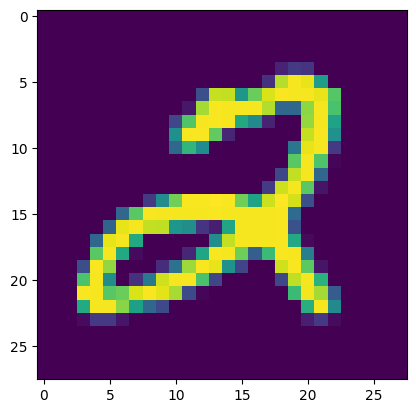

In [8]:
(x, _), = validation_dataset.take(1)

plt.imshow(tf.squeeze(x))
print(f"Data type: {x.dtype}")
print(f"Shape: {x.shape}")


To get the latent representation $y$, we need to cast it to `float32`, add a batch dimension, and pass it through the analysis transform.

In [9]:
x = tf.cast(x, tf.float32) / 255.
x = tf.reshape(x, (-1, 28, 28, 1))
y = make_analysis_transform(10)(x)

print("y:", y)


y: tf.Tensor(
[[ 0.02126924 -0.06894962  0.09302588 -0.03838679 -0.07932404  0.04434497
  -0.01607926  0.03123217 -0.00262138 -0.10917155]], shape=(1, 10), dtype=float32)


The latents will be quantized at test time. To model this in a differentiable way during training, we add uniform noise in the interval $(-.5, .5)$ and call the result $\tilde y$. This is the same terminology as used in the paper [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704).

In [10]:
y_tilde = y + tf.random.uniform(y.shape, -.5, .5)

print("y_tilde:", y_tilde)


y_tilde: tf.Tensor(
[[ 0.3478785   0.08000787 -0.18317918  0.25482622 -0.31788376 -0.13823514
   0.362665   -0.05973584  0.34111002 -0.1322978 ]], shape=(1, 10), dtype=float32)


The "prior" is a probability density that we train to model the marginal distribution of the noisy latents. For example, it could be a set of independent [logistic distributions](https://en.wikipedia.org/wiki/Logistic_distribution) with different scales for each latent dimension. `tfc.NoisyLogistic` accounts for the fact that the latents have additive noise. As the scale approaches zero, a logistic distribution approaches a dirac delta (spike), but the added noise causes the "noisy" distribution to approach the uniform distribution instead.

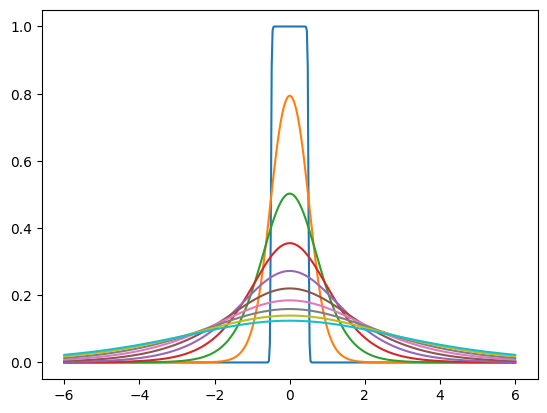

In [11]:
prior = tfc.NoisyLogistic(loc=0., scale=tf.linspace(.01, 2., 10))

_ = tf.linspace(-6., 6., 501)[:, None]
plt.plot(_, prior.prob(_));


During training, `tfc.ContinuousBatchedEntropyModel` adds uniform noise, and uses the noise and the prior to compute a (differentiable) upper bound on the rate (the average number of bits necessary to encode the latent representation). That bound can be minimized as a loss.

In [12]:
entropy_model = tfc.ContinuousBatchedEntropyModel(
    prior, coding_rank=1, compression=False)
y_tilde, rate = entropy_model(y, training=True)

print("rate:", rate)
print("y_tilde:", y_tilde)


rate: tf.Tensor([18.012472], shape=(1,), dtype=float32)
y_tilde: tf.Tensor(
[[-0.09349963 -0.02974442 -0.1147738   0.39858678  0.33601853 -0.13327162
  -0.10957606  0.2511304  -0.15129623  0.25686544]], shape=(1, 10), dtype=float32)


Lastly, the noisy latents are passed back through the synthesis transform to produce an image reconstruction $\tilde x$. Distortion is the error between original image and reconstruction. Obviously, with the transforms untrained, the reconstruction is not very useful.

distortion: tf.Tensor(0.17072156, shape=(), dtype=float32)
Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


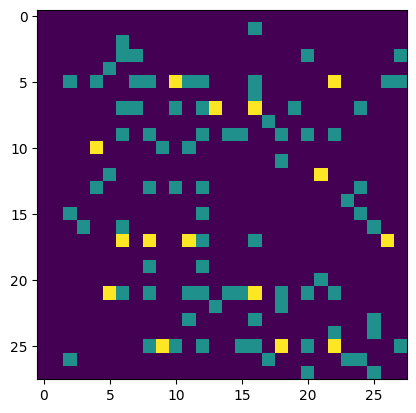

In [13]:
x_tilde = make_synthesis_transform()(y_tilde)

# Mean absolute difference across pixels.
distortion = tf.reduce_mean(abs(x - x_tilde))
print("distortion:", distortion)

x_tilde = tf.saturate_cast(x_tilde[0] * 255, tf.uint8)
plt.imshow(tf.squeeze(x_tilde))
print(f"Data type: {x_tilde.dtype}")
print(f"Shape: {x_tilde.shape}")


For every batch of digits, calling the `MNISTCompressionTrainer` produces the rate and distortion as an average over that batch:


In [14]:
(example_batch, _), = validation_dataset.batch(32).take(1)
trainer = MNISTCompressionTrainer(10)
example_output = trainer(example_batch)

print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])


rate:  tf.Tensor(20.296253, shape=(), dtype=float32)
distortion:  tf.Tensor(0.14659302, shape=(), dtype=float32)


2024-02-02 02:21:58.788887: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In the next section, we set up the model to do gradient descent on these two losses.

## Train the model.

We compile the trainer in a way that it optimizes the rate–distortion Lagrangian, that is, a sum of rate and distortion, where one of the terms is weighted by Lagrange parameter $\lambda$.

This loss function affects the different parts of the model differently:
- The analysis transform is trained to produce a latent representation that achieves the desired trade-off between rate and distortion.
- The synthesis transform is trained to minimize distortion, given the latent representation.
- The parameters of the prior are trained to minimize the rate given the latent representation. This is identical to fitting the prior to the marginal distribution of latents in a maximum likelihood sense.

In [15]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_mnist_compression_trainer(lmbda, latent_dims=50):
  trainer = MNISTCompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer


Next, train the model. The human annotations are not necessary here, since we just want to compress the images, so we drop them using a `map` and instead add "dummy" targets for rate and distortion.

In [16]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_mnist_model(lmbda):
  trainer = make_mnist_compression_trainer(lmbda)
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=15,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer

trainer = train_mnist_model(lmbda=2000)


Epoch 1/15


  1/469 [..............................] - ETA: 25:56 - loss: 350.7587 - distortion_loss: 0.1239 - rate_loss: 102.9191 - distortion_pass_through_loss: 0.1239 - rate_pass_through_loss: 102.9191

  3/469 [..............................] - ETA: 12s - loss: 361.4582 - distortion_loss: 0.1293 - rate_loss: 102.9176 - distortion_pass_through_loss: 0.1293 - rate_pass_through_loss: 102.9176  

  5/469 [..............................] - ETA: 12s - loss: 364.1946 - distortion_loss: 0.1307 - rate_loss: 102.8242 - distortion_pass_through_loss: 0.1307 - rate_pass_through_loss: 102.8242

  8/469 [..............................] - ETA: 11s - loss: 367.0277 - distortion_loss: 0.1322 - rate_loss: 102.7043 - distortion_pass_through_loss: 0.1322 - rate_pass_through_loss: 102.7043

 11/469 [..............................] - ETA: 11s - loss: 366.8285 - distortion_loss: 0.1321 - rate_loss: 102.5957 - distortion_pass_through_loss: 0.1321 - rate_pass_through_loss: 102.5957

 14/469 [..............................] - ETA: 10s - loss: 365.4016 - distortion_loss: 0.1314 - rate_loss: 102.5114 - distortion_pass_through_loss: 0.1314 - rate_pass_through_loss: 102.5114

 17/469 [>.............................] - ETA: 10s - loss: 363.5073 - distortion_loss: 0.1304 - rate_loss: 102.6207 - distortion_pass_through_loss: 0.1304 - rate_pass_through_loss: 102.6207

 20/469 [>.............................] - ETA: 10s - loss: 362.0897 - distortion_loss: 0.1296 - rate_loss: 102.8175 - distortion_pass_through_loss: 0.1296 - rate_pass_through_loss: 102.8175

 23/469 [>.............................] - ETA: 10s - loss: 360.6691 - distortion_loss: 0.1290 - rate_loss: 102.7533 - distortion_pass_through_loss: 0.1290 - rate_pass_through_loss: 102.7533

 26/469 [>.............................] - ETA: 9s - loss: 358.9984 - distortion_loss: 0.1282 - rate_loss: 102.6743 - distortion_pass_through_loss: 0.1282 - rate_pass_through_loss: 102.6743 

 29/469 [>.............................] - ETA: 9s - loss: 357.6626 - distortion_loss: 0.1275 - rate_loss: 102.5921 - distortion_pass_through_loss: 0.1275 - rate_pass_through_loss: 102.5921

 32/469 [=>............................] - ETA: 9s - loss: 355.5293 - distortion_loss: 0.1265 - rate_loss: 102.5431 - distortion_pass_through_loss: 0.1265 - rate_pass_through_loss: 102.5431

 35/469 [=>............................] - ETA: 9s - loss: 353.3021 - distortion_loss: 0.1254 - rate_loss: 102.5485 - distortion_pass_through_loss: 0.1254 - rate_pass_through_loss: 102.5485

 38/469 [=>............................] - ETA: 9s - loss: 350.2632 - distortion_loss: 0.1238 - rate_loss: 102.6000 - distortion_pass_through_loss: 0.1238 - rate_pass_through_loss: 102.6000

 41/469 [=>............................] - ETA: 9s - loss: 347.3533 - distortion_loss: 0.1223 - rate_loss: 102.6609 - distortion_pass_through_loss: 0.1223 - rate_pass_through_loss: 102.6609

 44/469 [=>............................] - ETA: 9s - loss: 344.5350 - distortion_loss: 0.1209 - rate_loss: 102.7254 - distortion_pass_through_loss: 0.1209 - rate_pass_through_loss: 102.7254

 47/469 [==>...........................] - ETA: 9s - loss: 341.5846 - distortion_loss: 0.1194 - rate_loss: 102.7839 - distortion_pass_through_loss: 0.1194 - rate_pass_through_loss: 102.7839

 50/469 [==>...........................] - ETA: 9s - loss: 338.7202 - distortion_loss: 0.1179 - rate_loss: 102.8208 - distortion_pass_through_loss: 0.1179 - rate_pass_through_loss: 102.8208

 53/469 [==>...........................] - ETA: 8s - loss: 335.8154 - distortion_loss: 0.1165 - rate_loss: 102.8576 - distortion_pass_through_loss: 0.1165 - rate_pass_through_loss: 102.8576

 56/469 [==>...........................] - ETA: 8s - loss: 332.7622 - distortion_loss: 0.1149 - rate_loss: 102.8825 - distortion_pass_through_loss: 0.1149 - rate_pass_through_loss: 102.8825

 59/469 [==>...........................] - ETA: 8s - loss: 329.9262 - distortion_loss: 0.1135 - rate_loss: 102.9055 - distortion_pass_through_loss: 0.1135 - rate_pass_through_loss: 102.9055

 62/469 [==>...........................] - ETA: 8s - loss: 327.4567 - distortion_loss: 0.1123 - rate_loss: 102.9177 - distortion_pass_through_loss: 0.1123 - rate_pass_through_loss: 102.9177

 65/469 [===>..........................] - ETA: 8s - loss: 324.8898 - distortion_loss: 0.1110 - rate_loss: 102.9266 - distortion_pass_through_loss: 0.1110 - rate_pass_through_loss: 102.9266

 68/469 [===>..........................] - ETA: 8s - loss: 322.3891 - distortion_loss: 0.1097 - rate_loss: 102.9512 - distortion_pass_through_loss: 0.1097 - rate_pass_through_loss: 102.9512

 71/469 [===>..........................] - ETA: 8s - loss: 319.8271 - distortion_loss: 0.1084 - rate_loss: 102.9761 - distortion_pass_through_loss: 0.1084 - rate_pass_through_loss: 102.9761

 74/469 [===>..........................] - ETA: 8s - loss: 317.2212 - distortion_loss: 0.1071 - rate_loss: 103.0116 - distortion_pass_through_loss: 0.1071 - rate_pass_through_loss: 103.0116

 77/469 [===>..........................] - ETA: 8s - loss: 314.8833 - distortion_loss: 0.1059 - rate_loss: 103.0498 - distortion_pass_through_loss: 0.1059 - rate_pass_through_loss: 103.0498

 80/469 [====>.........................] - ETA: 8s - loss: 312.5990 - distortion_loss: 0.1048 - rate_loss: 103.0863 - distortion_pass_through_loss: 0.1048 - rate_pass_through_loss: 103.0863

 83/469 [====>.........................] - ETA: 8s - loss: 310.4810 - distortion_loss: 0.1037 - rate_loss: 103.1265 - distortion_pass_through_loss: 0.1037 - rate_pass_through_loss: 103.1265

 86/469 [====>.........................] - ETA: 8s - loss: 308.2742 - distortion_loss: 0.1026 - rate_loss: 103.1735 - distortion_pass_through_loss: 0.1026 - rate_pass_through_loss: 103.1735

 89/469 [====>.........................] - ETA: 7s - loss: 306.1693 - distortion_loss: 0.1015 - rate_loss: 103.2012 - distortion_pass_through_loss: 0.1015 - rate_pass_through_loss: 103.2012

 92/469 [====>.........................] - ETA: 7s - loss: 304.0394 - distortion_loss: 0.1004 - rate_loss: 103.2243 - distortion_pass_through_loss: 0.1004 - rate_pass_through_loss: 103.2243

 95/469 [=====>........................] - ETA: 7s - loss: 302.1176 - distortion_loss: 0.0994 - rate_loss: 103.2481 - distortion_pass_through_loss: 0.0994 - rate_pass_through_loss: 103.2481

 98/469 [=====>........................] - ETA: 7s - loss: 300.1920 - distortion_loss: 0.0985 - rate_loss: 103.2703 - distortion_pass_through_loss: 0.0985 - rate_pass_through_loss: 103.2703

101/469 [=====>........................] - ETA: 7s - loss: 298.5103 - distortion_loss: 0.0976 - rate_loss: 103.2938 - distortion_pass_through_loss: 0.0976 - rate_pass_through_loss: 103.2938

104/469 [=====>........................] - ETA: 7s - loss: 296.7302 - distortion_loss: 0.0967 - rate_loss: 103.3122 - distortion_pass_through_loss: 0.0967 - rate_pass_through_loss: 103.3122

107/469 [=====>........................] - ETA: 7s - loss: 295.0223 - distortion_loss: 0.0959 - rate_loss: 103.3209 - distortion_pass_through_loss: 0.0959 - rate_pass_through_loss: 103.3209

110/469 [======>.......................] - ETA: 7s - loss: 293.3180 - distortion_loss: 0.0950 - rate_loss: 103.3314 - distortion_pass_through_loss: 0.0950 - rate_pass_through_loss: 103.3314

113/469 [======>.......................] - ETA: 7s - loss: 291.7860 - distortion_loss: 0.0942 - rate_loss: 103.3497 - distortion_pass_through_loss: 0.0942 - rate_pass_through_loss: 103.3497

116/469 [======>.......................] - ETA: 7s - loss: 290.2799 - distortion_loss: 0.0935 - rate_loss: 103.3665 - distortion_pass_through_loss: 0.0935 - rate_pass_through_loss: 103.3665

119/469 [======>.......................] - ETA: 7s - loss: 288.7861 - distortion_loss: 0.0927 - rate_loss: 103.3821 - distortion_pass_through_loss: 0.0927 - rate_pass_through_loss: 103.3821

122/469 [======>.......................] - ETA: 7s - loss: 287.2582 - distortion_loss: 0.0919 - rate_loss: 103.3894 - distortion_pass_through_loss: 0.0919 - rate_pass_through_loss: 103.3894

125/469 [======>.......................] - ETA: 7s - loss: 285.7451 - distortion_loss: 0.0912 - rate_loss: 103.4012 - distortion_pass_through_loss: 0.0912 - rate_pass_through_loss: 103.4012

128/469 [=======>......................] - ETA: 7s - loss: 284.3153 - distortion_loss: 0.0905 - rate_loss: 103.4012 - distortion_pass_through_loss: 0.0905 - rate_pass_through_loss: 103.4012

131/469 [=======>......................] - ETA: 7s - loss: 282.9404 - distortion_loss: 0.0898 - rate_loss: 103.4038 - distortion_pass_through_loss: 0.0898 - rate_pass_through_loss: 103.4038

134/469 [=======>......................] - ETA: 6s - loss: 281.5942 - distortion_loss: 0.0891 - rate_loss: 103.4065 - distortion_pass_through_loss: 0.0891 - rate_pass_through_loss: 103.4065

137/469 [=======>......................] - ETA: 6s - loss: 280.2892 - distortion_loss: 0.0884 - rate_loss: 103.4118 - distortion_pass_through_loss: 0.0884 - rate_pass_through_loss: 103.4118

140/469 [=======>......................] - ETA: 6s - loss: 279.0492 - distortion_loss: 0.0878 - rate_loss: 103.4112 - distortion_pass_through_loss: 0.0878 - rate_pass_through_loss: 103.4112

143/469 [========>.....................] - ETA: 6s - loss: 277.8254 - distortion_loss: 0.0872 - rate_loss: 103.4198 - distortion_pass_through_loss: 0.0872 - rate_pass_through_loss: 103.4198

146/469 [========>.....................] - ETA: 6s - loss: 276.7286 - distortion_loss: 0.0867 - rate_loss: 103.4251 - distortion_pass_through_loss: 0.0867 - rate_pass_through_loss: 103.4251

149/469 [========>.....................] - ETA: 6s - loss: 275.5482 - distortion_loss: 0.0861 - rate_loss: 103.4266 - distortion_pass_through_loss: 0.0861 - rate_pass_through_loss: 103.4266

152/469 [========>.....................] - ETA: 6s - loss: 274.3939 - distortion_loss: 0.0855 - rate_loss: 103.4293 - distortion_pass_through_loss: 0.0855 - rate_pass_through_loss: 103.4293

155/469 [========>.....................] - ETA: 6s - loss: 273.3284 - distortion_loss: 0.0849 - rate_loss: 103.4370 - distortion_pass_through_loss: 0.0849 - rate_pass_through_loss: 103.4370

158/469 [=========>....................] - ETA: 6s - loss: 272.2457 - distortion_loss: 0.0844 - rate_loss: 103.4335 - distortion_pass_through_loss: 0.0844 - rate_pass_through_loss: 103.4335

161/469 [=========>....................] - ETA: 6s - loss: 271.1992 - distortion_loss: 0.0839 - rate_loss: 103.4287 - distortion_pass_through_loss: 0.0839 - rate_pass_through_loss: 103.4287

164/469 [=========>....................] - ETA: 6s - loss: 270.2224 - distortion_loss: 0.0834 - rate_loss: 103.4178 - distortion_pass_through_loss: 0.0834 - rate_pass_through_loss: 103.4178

167/469 [=========>....................] - ETA: 6s - loss: 269.2136 - distortion_loss: 0.0829 - rate_loss: 103.4078 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 103.4078

170/469 [=========>....................] - ETA: 6s - loss: 268.2265 - distortion_loss: 0.0824 - rate_loss: 103.3974 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 103.3974

173/469 [==========>...................] - ETA: 6s - loss: 267.2445 - distortion_loss: 0.0819 - rate_loss: 103.3901 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 103.3901

176/469 [==========>...................] - ETA: 6s - loss: 266.2770 - distortion_loss: 0.0814 - rate_loss: 103.3777 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 103.3777

179/469 [==========>...................] - ETA: 5s - loss: 265.3810 - distortion_loss: 0.0810 - rate_loss: 103.3727 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 103.3727

182/469 [==========>...................] - ETA: 5s - loss: 264.4189 - distortion_loss: 0.0805 - rate_loss: 103.3589 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 103.3589

185/469 [==========>...................] - ETA: 5s - loss: 263.5656 - distortion_loss: 0.0801 - rate_loss: 103.3484 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 103.3484

188/469 [===========>..................] - ETA: 5s - loss: 262.6613 - distortion_loss: 0.0797 - rate_loss: 103.3331 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 103.3331

191/469 [===========>..................] - ETA: 5s - loss: 261.8206 - distortion_loss: 0.0792 - rate_loss: 103.3242 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 103.3242

194/469 [===========>..................] - ETA: 5s - loss: 260.9966 - distortion_loss: 0.0788 - rate_loss: 103.3107 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 103.3107

197/469 [===========>..................] - ETA: 5s - loss: 260.1440 - distortion_loss: 0.0784 - rate_loss: 103.2927 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 103.2927

200/469 [===========>..................] - ETA: 5s - loss: 259.3042 - distortion_loss: 0.0780 - rate_loss: 103.2732 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 103.2732

203/469 [===========>..................] - ETA: 5s - loss: 258.4671 - distortion_loss: 0.0776 - rate_loss: 103.2529 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 103.2529

206/469 [============>.................] - ETA: 5s - loss: 257.6672 - distortion_loss: 0.0772 - rate_loss: 103.2383 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 103.2383

209/469 [============>.................] - ETA: 5s - loss: 256.8743 - distortion_loss: 0.0768 - rate_loss: 103.2146 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 103.2146

212/469 [============>.................] - ETA: 5s - loss: 256.0940 - distortion_loss: 0.0764 - rate_loss: 103.1944 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 103.1944

215/469 [============>.................] - ETA: 5s - loss: 255.3484 - distortion_loss: 0.0761 - rate_loss: 103.1729 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 103.1729

218/469 [============>.................] - ETA: 5s - loss: 254.6198 - distortion_loss: 0.0757 - rate_loss: 103.1507 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 103.1507

221/469 [=============>................] - ETA: 5s - loss: 253.9281 - distortion_loss: 0.0754 - rate_loss: 103.1263 - distortion_pass_through_loss: 0.0754 - rate_pass_through_loss: 103.1263

224/469 [=============>................] - ETA: 5s - loss: 253.2012 - distortion_loss: 0.0750 - rate_loss: 103.1018 - distortion_pass_through_loss: 0.0750 - rate_pass_through_loss: 103.1018

227/469 [=============>................] - ETA: 4s - loss: 252.5307 - distortion_loss: 0.0747 - rate_loss: 103.0684 - distortion_pass_through_loss: 0.0747 - rate_pass_through_loss: 103.0684

230/469 [=============>................] - ETA: 4s - loss: 251.8738 - distortion_loss: 0.0744 - rate_loss: 103.0513 - distortion_pass_through_loss: 0.0744 - rate_pass_through_loss: 103.0513

233/469 [=============>................] - ETA: 4s - loss: 251.2355 - distortion_loss: 0.0741 - rate_loss: 103.0247 - distortion_pass_through_loss: 0.0741 - rate_pass_through_loss: 103.0247

236/469 [==============>...............] - ETA: 4s - loss: 250.5659 - distortion_loss: 0.0738 - rate_loss: 102.9955 - distortion_pass_through_loss: 0.0738 - rate_pass_through_loss: 102.9955

239/469 [==============>...............] - ETA: 4s - loss: 249.9450 - distortion_loss: 0.0735 - rate_loss: 102.9679 - distortion_pass_through_loss: 0.0735 - rate_pass_through_loss: 102.9679

242/469 [==============>...............] - ETA: 4s - loss: 249.2883 - distortion_loss: 0.0732 - rate_loss: 102.9339 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 102.9339

245/469 [==============>...............] - ETA: 4s - loss: 248.6884 - distortion_loss: 0.0729 - rate_loss: 102.9046 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 102.9046

248/469 [==============>...............] - ETA: 4s - loss: 248.1119 - distortion_loss: 0.0726 - rate_loss: 102.8791 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 102.8791

251/469 [===============>..............] - ETA: 4s - loss: 247.5122 - distortion_loss: 0.0723 - rate_loss: 102.8559 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 102.8559

254/469 [===============>..............] - ETA: 4s - loss: 246.9271 - distortion_loss: 0.0721 - rate_loss: 102.8265 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 102.8265

257/469 [===============>..............] - ETA: 4s - loss: 246.3552 - distortion_loss: 0.0718 - rate_loss: 102.7975 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 102.7975

260/469 [===============>..............] - ETA: 4s - loss: 245.7532 - distortion_loss: 0.0715 - rate_loss: 102.7640 - distortion_pass_through_loss: 0.0715 - rate_pass_through_loss: 102.7640

263/469 [===============>..............] - ETA: 4s - loss: 245.1878 - distortion_loss: 0.0712 - rate_loss: 102.7346 - distortion_pass_through_loss: 0.0712 - rate_pass_through_loss: 102.7346

266/469 [================>.............] - ETA: 4s - loss: 244.6441 - distortion_loss: 0.0710 - rate_loss: 102.7046 - distortion_pass_through_loss: 0.0710 - rate_pass_through_loss: 102.7046

269/469 [================>.............] - ETA: 4s - loss: 244.0813 - distortion_loss: 0.0707 - rate_loss: 102.6730 - distortion_pass_through_loss: 0.0707 - rate_pass_through_loss: 102.6730

272/469 [================>.............] - ETA: 4s - loss: 243.5310 - distortion_loss: 0.0704 - rate_loss: 102.6415 - distortion_pass_through_loss: 0.0704 - rate_pass_through_loss: 102.6415

275/469 [================>.............] - ETA: 4s - loss: 243.0210 - distortion_loss: 0.0702 - rate_loss: 102.6089 - distortion_pass_through_loss: 0.0702 - rate_pass_through_loss: 102.6089

278/469 [================>.............] - ETA: 3s - loss: 242.4908 - distortion_loss: 0.0700 - rate_loss: 102.5759 - distortion_pass_through_loss: 0.0700 - rate_pass_through_loss: 102.5759

281/469 [================>.............] - ETA: 3s - loss: 241.9667 - distortion_loss: 0.0697 - rate_loss: 102.5399 - distortion_pass_through_loss: 0.0697 - rate_pass_through_loss: 102.5399

284/469 [=================>............] - ETA: 3s - loss: 241.4938 - distortion_loss: 0.0695 - rate_loss: 102.5109 - distortion_pass_through_loss: 0.0695 - rate_pass_through_loss: 102.5109

287/469 [=================>............] - ETA: 3s - loss: 240.9915 - distortion_loss: 0.0693 - rate_loss: 102.4759 - distortion_pass_through_loss: 0.0693 - rate_pass_through_loss: 102.4759

290/469 [=================>............] - ETA: 3s - loss: 240.4932 - distortion_loss: 0.0690 - rate_loss: 102.4429 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 102.4429

293/469 [=================>............] - ETA: 3s - loss: 239.9894 - distortion_loss: 0.0688 - rate_loss: 102.4018 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 102.4018

296/469 [=================>............] - ETA: 3s - loss: 239.4877 - distortion_loss: 0.0686 - rate_loss: 102.3612 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 102.3612

299/469 [==================>...........] - ETA: 3s - loss: 239.0251 - distortion_loss: 0.0684 - rate_loss: 102.3211 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 102.3211

302/469 [==================>...........] - ETA: 3s - loss: 238.5692 - distortion_loss: 0.0681 - rate_loss: 102.2839 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 102.2839

305/469 [==================>...........] - ETA: 3s - loss: 238.1063 - distortion_loss: 0.0679 - rate_loss: 102.2452 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 102.2452

308/469 [==================>...........] - ETA: 3s - loss: 237.6426 - distortion_loss: 0.0677 - rate_loss: 102.2058 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 102.2058

311/469 [==================>...........] - ETA: 3s - loss: 237.2062 - distortion_loss: 0.0675 - rate_loss: 102.1683 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 102.1683

314/469 [===================>..........] - ETA: 3s - loss: 236.7766 - distortion_loss: 0.0673 - rate_loss: 102.1274 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 102.1274

317/469 [===================>..........] - ETA: 3s - loss: 236.3484 - distortion_loss: 0.0671 - rate_loss: 102.0908 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 102.0908

320/469 [===================>..........] - ETA: 3s - loss: 235.9014 - distortion_loss: 0.0669 - rate_loss: 102.0504 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 102.0504

323/469 [===================>..........] - ETA: 3s - loss: 235.4897 - distortion_loss: 0.0667 - rate_loss: 102.0113 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 102.0113

326/469 [===================>..........] - ETA: 2s - loss: 235.0820 - distortion_loss: 0.0666 - rate_loss: 101.9675 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 101.9675

329/469 [====================>.........] - ETA: 2s - loss: 234.6719 - distortion_loss: 0.0664 - rate_loss: 101.9262 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 101.9262

332/469 [====================>.........] - ETA: 2s - loss: 234.2498 - distortion_loss: 0.0662 - rate_loss: 101.8806 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 101.8806

335/469 [====================>.........] - ETA: 2s - loss: 233.8635 - distortion_loss: 0.0660 - rate_loss: 101.8470 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 101.8470

338/469 [====================>.........] - ETA: 2s - loss: 233.4493 - distortion_loss: 0.0658 - rate_loss: 101.8004 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 101.8004

341/469 [====================>.........] - ETA: 2s - loss: 233.0609 - distortion_loss: 0.0656 - rate_loss: 101.7637 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 101.7637

344/469 [=====================>........] - ETA: 2s - loss: 232.6577 - distortion_loss: 0.0655 - rate_loss: 101.7188 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 101.7188

347/469 [=====================>........] - ETA: 2s - loss: 232.2727 - distortion_loss: 0.0653 - rate_loss: 101.6781 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 101.6781

350/469 [=====================>........] - ETA: 2s - loss: 231.9185 - distortion_loss: 0.0651 - rate_loss: 101.6361 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 101.6361

353/469 [=====================>........] - ETA: 2s - loss: 231.5367 - distortion_loss: 0.0650 - rate_loss: 101.5943 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 101.5943

356/469 [=====================>........] - ETA: 2s - loss: 231.1512 - distortion_loss: 0.0648 - rate_loss: 101.5528 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 101.5528

359/469 [=====================>........] - ETA: 2s - loss: 230.7919 - distortion_loss: 0.0646 - rate_loss: 101.5110 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 101.5110

362/469 [======================>.......] - ETA: 2s - loss: 230.4376 - distortion_loss: 0.0645 - rate_loss: 101.4694 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 101.4694

365/469 [======================>.......] - ETA: 2s - loss: 230.0739 - distortion_loss: 0.0643 - rate_loss: 101.4279 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 101.4279

368/469 [======================>.......] - ETA: 2s - loss: 229.7132 - distortion_loss: 0.0642 - rate_loss: 101.3819 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 101.3819

371/469 [======================>.......] - ETA: 2s - loss: 229.3544 - distortion_loss: 0.0640 - rate_loss: 101.3393 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 101.3393

374/469 [======================>.......] - ETA: 1s - loss: 228.9916 - distortion_loss: 0.0638 - rate_loss: 101.2963 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 101.2963

377/469 [=======================>......] - ETA: 1s - loss: 228.6320 - distortion_loss: 0.0637 - rate_loss: 101.2507 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 101.2507

380/469 [=======================>......] - ETA: 1s - loss: 228.2873 - distortion_loss: 0.0635 - rate_loss: 101.2082 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 101.2082

383/469 [=======================>......] - ETA: 1s - loss: 227.9532 - distortion_loss: 0.0634 - rate_loss: 101.1645 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 101.1645

386/469 [=======================>......] - ETA: 1s - loss: 227.5997 - distortion_loss: 0.0632 - rate_loss: 101.1190 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 101.1190

389/469 [=======================>......] - ETA: 1s - loss: 227.2741 - distortion_loss: 0.0631 - rate_loss: 101.0733 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 101.0733

392/469 [========================>.....] - ETA: 1s - loss: 226.9278 - distortion_loss: 0.0629 - rate_loss: 101.0283 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 101.0283

395/469 [========================>.....] - ETA: 1s - loss: 226.5920 - distortion_loss: 0.0628 - rate_loss: 100.9840 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 100.9840

398/469 [========================>.....] - ETA: 1s - loss: 226.2483 - distortion_loss: 0.0627 - rate_loss: 100.9335 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 100.9335

401/469 [========================>.....] - ETA: 1s - loss: 225.9267 - distortion_loss: 0.0625 - rate_loss: 100.8872 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 100.8872

404/469 [========================>.....] - ETA: 1s - loss: 225.5881 - distortion_loss: 0.0624 - rate_loss: 100.8409 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 100.8409

407/469 [=========================>....] - ETA: 1s - loss: 225.2641 - distortion_loss: 0.0622 - rate_loss: 100.7959 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 100.7959

410/469 [=========================>....] - ETA: 1s - loss: 224.9527 - distortion_loss: 0.0621 - rate_loss: 100.7529 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 100.7529

413/469 [=========================>....] - ETA: 1s - loss: 224.6484 - distortion_loss: 0.0620 - rate_loss: 100.7081 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 100.7081

416/469 [=========================>....] - ETA: 1s - loss: 224.3364 - distortion_loss: 0.0618 - rate_loss: 100.6644 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 100.6644

419/469 [=========================>....] - ETA: 1s - loss: 224.0338 - distortion_loss: 0.0617 - rate_loss: 100.6153 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 100.6153

422/469 [=========================>....] - ETA: 0s - loss: 223.7165 - distortion_loss: 0.0616 - rate_loss: 100.5686 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 100.5686

425/469 [==========================>...] - ETA: 0s - loss: 223.4240 - distortion_loss: 0.0615 - rate_loss: 100.5221 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 100.5221

428/469 [==========================>...] - ETA: 0s - loss: 223.1285 - distortion_loss: 0.0613 - rate_loss: 100.4759 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 100.4759

431/469 [==========================>...] - ETA: 0s - loss: 222.8318 - distortion_loss: 0.0612 - rate_loss: 100.4307 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 100.4307

434/469 [==========================>...] - ETA: 0s - loss: 222.5437 - distortion_loss: 0.0611 - rate_loss: 100.3831 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 100.3831

437/469 [==========================>...] - ETA: 0s - loss: 222.2450 - distortion_loss: 0.0610 - rate_loss: 100.3355 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 100.3355

440/469 [===========================>..] - ETA: 0s - loss: 221.9644 - distortion_loss: 0.0608 - rate_loss: 100.2882 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 100.2882

443/469 [===========================>..] - ETA: 0s - loss: 221.6740 - distortion_loss: 0.0607 - rate_loss: 100.2408 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 100.2408

446/469 [===========================>..] - ETA: 0s - loss: 221.3910 - distortion_loss: 0.0606 - rate_loss: 100.1909 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 100.1909

449/469 [===========================>..] - ETA: 0s - loss: 221.1214 - distortion_loss: 0.0605 - rate_loss: 100.1436 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 100.1436

452/469 [===========================>..] - ETA: 0s - loss: 220.8387 - distortion_loss: 0.0604 - rate_loss: 100.0936 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 100.0936

455/469 [============================>.] - ETA: 0s - loss: 220.5613 - distortion_loss: 0.0603 - rate_loss: 100.0454 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 100.0454

458/469 [============================>.] - ETA: 0s - loss: 220.2933 - distortion_loss: 0.0601 - rate_loss: 100.0001 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 100.0001

461/469 [============================>.] - ETA: 0s - loss: 220.0360 - distortion_loss: 0.0600 - rate_loss: 99.9525 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 99.9525  

464/469 [============================>.] - ETA: 0s - loss: 219.7605 - distortion_loss: 0.0599 - rate_loss: 99.9026 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 99.9026

467/469 [============================>.] - ETA: 0s - loss: 219.4970 - distortion_loss: 0.0598 - rate_loss: 99.8539 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 99.8539

469/469 [==============================] - 14s 23ms/step - loss: 219.3287 - distortion_loss: 0.0598 - rate_loss: 99.8235 - distortion_pass_through_loss: 0.0597 - rate_pass_through_loss: 99.8190 - val_loss: 176.6952 - val_distortion_loss: 0.0424 - val_rate_loss: 91.9455 - val_distortion_pass_through_loss: 0.0424 - val_rate_pass_through_loss: 91.9553


Epoch 2/15


  1/469 [..............................] - ETA: 13s - loss: 171.6452 - distortion_loss: 0.0401 - rate_loss: 91.4797 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 91.4797

  4/469 [..............................] - ETA: 9s - loss: 176.0425 - distortion_loss: 0.0421 - rate_loss: 91.7823 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 91.7823 

  7/469 [..............................] - ETA: 9s - loss: 177.4645 - distortion_loss: 0.0427 - rate_loss: 92.1506 - distortion_pass_through_loss: 0.0427 - rate_pass_through_loss: 92.1506

 10/469 [..............................] - ETA: 9s - loss: 178.0685 - distortion_loss: 0.0430 - rate_loss: 92.0864 - distortion_pass_through_loss: 0.0430 - rate_pass_through_loss: 92.0864

 13/469 [..............................] - ETA: 9s - loss: 177.7568 - distortion_loss: 0.0429 - rate_loss: 91.9996 - distortion_pass_through_loss: 0.0429 - rate_pass_through_loss: 91.9996

 16/469 [>.............................] - ETA: 9s - loss: 177.4467 - distortion_loss: 0.0428 - rate_loss: 91.8832 - distortion_pass_through_loss: 0.0428 - rate_pass_through_loss: 91.8832

 19/469 [>.............................] - ETA: 9s - loss: 177.6021 - distortion_loss: 0.0429 - rate_loss: 91.8933 - distortion_pass_through_loss: 0.0429 - rate_pass_through_loss: 91.8933

 22/469 [>.............................] - ETA: 9s - loss: 177.8994 - distortion_loss: 0.0430 - rate_loss: 91.8036 - distortion_pass_through_loss: 0.0430 - rate_pass_through_loss: 91.8036

 25/469 [>.............................] - ETA: 9s - loss: 177.7690 - distortion_loss: 0.0430 - rate_loss: 91.6878 - distortion_pass_through_loss: 0.0430 - rate_pass_through_loss: 91.6878

 28/469 [>.............................] - ETA: 8s - loss: 177.7764 - distortion_loss: 0.0430 - rate_loss: 91.6898 - distortion_pass_through_loss: 0.0430 - rate_pass_through_loss: 91.6898

 31/469 [>.............................] - ETA: 8s - loss: 177.5083 - distortion_loss: 0.0429 - rate_loss: 91.6269 - distortion_pass_through_loss: 0.0429 - rate_pass_through_loss: 91.6269

 34/469 [=>............................] - ETA: 8s - loss: 177.4562 - distortion_loss: 0.0429 - rate_loss: 91.5616 - distortion_pass_through_loss: 0.0429 - rate_pass_through_loss: 91.5616

 37/469 [=>............................] - ETA: 8s - loss: 177.1601 - distortion_loss: 0.0429 - rate_loss: 91.4532 - distortion_pass_through_loss: 0.0429 - rate_pass_through_loss: 91.4532

 40/469 [=>............................] - ETA: 8s - loss: 177.0446 - distortion_loss: 0.0428 - rate_loss: 91.3966 - distortion_pass_through_loss: 0.0428 - rate_pass_through_loss: 91.3966

 43/469 [=>............................] - ETA: 8s - loss: 176.9353 - distortion_loss: 0.0428 - rate_loss: 91.3219 - distortion_pass_through_loss: 0.0428 - rate_pass_through_loss: 91.3219

 46/469 [=>............................] - ETA: 8s - loss: 176.7290 - distortion_loss: 0.0427 - rate_loss: 91.2392 - distortion_pass_through_loss: 0.0427 - rate_pass_through_loss: 91.2392

 49/469 [==>...........................] - ETA: 8s - loss: 176.6898 - distortion_loss: 0.0427 - rate_loss: 91.2076 - distortion_pass_through_loss: 0.0427 - rate_pass_through_loss: 91.2076

 52/469 [==>...........................] - ETA: 8s - loss: 176.6755 - distortion_loss: 0.0428 - rate_loss: 91.1515 - distortion_pass_through_loss: 0.0428 - rate_pass_through_loss: 91.1515

 55/469 [==>...........................] - ETA: 8s - loss: 176.5103 - distortion_loss: 0.0427 - rate_loss: 91.0981 - distortion_pass_through_loss: 0.0427 - rate_pass_through_loss: 91.0981

 58/469 [==>...........................] - ETA: 8s - loss: 176.4661 - distortion_loss: 0.0427 - rate_loss: 91.0327 - distortion_pass_through_loss: 0.0427 - rate_pass_through_loss: 91.0327

 61/469 [==>...........................] - ETA: 8s - loss: 176.3727 - distortion_loss: 0.0427 - rate_loss: 90.9969 - distortion_pass_through_loss: 0.0427 - rate_pass_through_loss: 90.9969

 64/469 [===>..........................] - ETA: 8s - loss: 176.3684 - distortion_loss: 0.0427 - rate_loss: 90.9306 - distortion_pass_through_loss: 0.0427 - rate_pass_through_loss: 90.9306

 67/469 [===>..........................] - ETA: 8s - loss: 176.3132 - distortion_loss: 0.0427 - rate_loss: 90.8783 - distortion_pass_through_loss: 0.0427 - rate_pass_through_loss: 90.8783

 70/469 [===>..........................] - ETA: 7s - loss: 176.1977 - distortion_loss: 0.0427 - rate_loss: 90.8102 - distortion_pass_through_loss: 0.0427 - rate_pass_through_loss: 90.8102

 73/469 [===>..........................] - ETA: 7s - loss: 175.9615 - distortion_loss: 0.0426 - rate_loss: 90.7473 - distortion_pass_through_loss: 0.0426 - rate_pass_through_loss: 90.7473

 76/469 [===>..........................] - ETA: 7s - loss: 175.8986 - distortion_loss: 0.0426 - rate_loss: 90.7106 - distortion_pass_through_loss: 0.0426 - rate_pass_through_loss: 90.7106

 79/469 [====>.........................] - ETA: 7s - loss: 175.8099 - distortion_loss: 0.0426 - rate_loss: 90.6580 - distortion_pass_through_loss: 0.0426 - rate_pass_through_loss: 90.6580

 82/469 [====>.........................] - ETA: 7s - loss: 175.7072 - distortion_loss: 0.0425 - rate_loss: 90.6160 - distortion_pass_through_loss: 0.0425 - rate_pass_through_loss: 90.6160

 85/469 [====>.........................] - ETA: 7s - loss: 175.5665 - distortion_loss: 0.0425 - rate_loss: 90.5535 - distortion_pass_through_loss: 0.0425 - rate_pass_through_loss: 90.5535

 88/469 [====>.........................] - ETA: 7s - loss: 175.4711 - distortion_loss: 0.0425 - rate_loss: 90.4943 - distortion_pass_through_loss: 0.0425 - rate_pass_through_loss: 90.4943

 91/469 [====>.........................] - ETA: 7s - loss: 175.2871 - distortion_loss: 0.0424 - rate_loss: 90.4352 - distortion_pass_through_loss: 0.0424 - rate_pass_through_loss: 90.4352

 94/469 [=====>........................] - ETA: 7s - loss: 175.2009 - distortion_loss: 0.0424 - rate_loss: 90.3804 - distortion_pass_through_loss: 0.0424 - rate_pass_through_loss: 90.3804

 97/469 [=====>........................] - ETA: 7s - loss: 175.0734 - distortion_loss: 0.0424 - rate_loss: 90.3276 - distortion_pass_through_loss: 0.0424 - rate_pass_through_loss: 90.3276

100/469 [=====>........................] - ETA: 7s - loss: 175.0299 - distortion_loss: 0.0424 - rate_loss: 90.2749 - distortion_pass_through_loss: 0.0424 - rate_pass_through_loss: 90.2749

103/469 [=====>........................] - ETA: 7s - loss: 174.9402 - distortion_loss: 0.0424 - rate_loss: 90.2193 - distortion_pass_through_loss: 0.0424 - rate_pass_through_loss: 90.2193

106/469 [=====>........................] - ETA: 7s - loss: 174.7874 - distortion_loss: 0.0423 - rate_loss: 90.1624 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 90.1624

109/469 [=====>........................] - ETA: 7s - loss: 174.6398 - distortion_loss: 0.0423 - rate_loss: 90.0995 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 90.0995

112/469 [======>.......................] - ETA: 7s - loss: 174.5936 - distortion_loss: 0.0423 - rate_loss: 90.0551 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 90.0551

115/469 [======>.......................] - ETA: 7s - loss: 174.5871 - distortion_loss: 0.0423 - rate_loss: 90.0037 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 90.0037

118/469 [======>.......................] - ETA: 6s - loss: 174.4230 - distortion_loss: 0.0422 - rate_loss: 89.9425 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 89.9425

121/469 [======>.......................] - ETA: 6s - loss: 174.3053 - distortion_loss: 0.0422 - rate_loss: 89.8838 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 89.8838

124/469 [======>.......................] - ETA: 6s - loss: 174.1874 - distortion_loss: 0.0422 - rate_loss: 89.8122 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 89.8122

127/469 [=======>......................] - ETA: 6s - loss: 174.0446 - distortion_loss: 0.0421 - rate_loss: 89.7512 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 89.7512

130/469 [=======>......................] - ETA: 6s - loss: 173.8943 - distortion_loss: 0.0421 - rate_loss: 89.6900 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 89.6900

133/469 [=======>......................] - ETA: 6s - loss: 173.7286 - distortion_loss: 0.0420 - rate_loss: 89.6337 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 89.6337

136/469 [=======>......................] - ETA: 6s - loss: 173.6183 - distortion_loss: 0.0420 - rate_loss: 89.5846 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 89.5846

139/469 [=======>......................] - ETA: 6s - loss: 173.5335 - distortion_loss: 0.0420 - rate_loss: 89.5405 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 89.5405

142/469 [========>.....................] - ETA: 6s - loss: 173.4099 - distortion_loss: 0.0420 - rate_loss: 89.4839 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 89.4839

145/469 [========>.....................] - ETA: 6s - loss: 173.3188 - distortion_loss: 0.0419 - rate_loss: 89.4312 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 89.4312

148/469 [========>.....................] - ETA: 6s - loss: 173.2379 - distortion_loss: 0.0419 - rate_loss: 89.3725 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 89.3725

151/469 [========>.....................] - ETA: 6s - loss: 173.1493 - distortion_loss: 0.0419 - rate_loss: 89.3142 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 89.3142

154/469 [========>.....................] - ETA: 6s - loss: 173.1008 - distortion_loss: 0.0419 - rate_loss: 89.2716 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 89.2716

157/469 [=========>....................] - ETA: 6s - loss: 173.0353 - distortion_loss: 0.0419 - rate_loss: 89.2208 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 89.2208

160/469 [=========>....................] - ETA: 6s - loss: 172.9855 - distortion_loss: 0.0419 - rate_loss: 89.1676 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 89.1676

163/469 [=========>....................] - ETA: 6s - loss: 172.8836 - distortion_loss: 0.0419 - rate_loss: 89.1067 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 89.1067

166/469 [=========>....................] - ETA: 5s - loss: 172.8266 - distortion_loss: 0.0419 - rate_loss: 89.0520 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 89.0520

169/469 [=========>....................] - ETA: 5s - loss: 172.7636 - distortion_loss: 0.0419 - rate_loss: 89.0053 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 89.0053

172/469 [==========>...................] - ETA: 5s - loss: 172.6523 - distortion_loss: 0.0419 - rate_loss: 88.9447 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 88.9447

175/469 [==========>...................] - ETA: 5s - loss: 172.6092 - distortion_loss: 0.0419 - rate_loss: 88.9007 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 88.9007

178/469 [==========>...................] - ETA: 5s - loss: 172.5299 - distortion_loss: 0.0418 - rate_loss: 88.8441 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 88.8441

181/469 [==========>...................] - ETA: 5s - loss: 172.4707 - distortion_loss: 0.0418 - rate_loss: 88.7977 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 88.7977

184/469 [==========>...................] - ETA: 5s - loss: 172.4170 - distortion_loss: 0.0418 - rate_loss: 88.7417 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 88.7417

187/469 [==========>...................] - ETA: 5s - loss: 172.3386 - distortion_loss: 0.0418 - rate_loss: 88.6834 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 88.6834

190/469 [===========>..................] - ETA: 5s - loss: 172.2869 - distortion_loss: 0.0418 - rate_loss: 88.6274 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 88.6274

193/469 [===========>..................] - ETA: 5s - loss: 172.2412 - distortion_loss: 0.0418 - rate_loss: 88.5725 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 88.5725

196/469 [===========>..................] - ETA: 5s - loss: 172.1646 - distortion_loss: 0.0418 - rate_loss: 88.5204 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 88.5204

199/469 [===========>..................] - ETA: 5s - loss: 172.0665 - distortion_loss: 0.0418 - rate_loss: 88.4601 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 88.4601

202/469 [===========>..................] - ETA: 5s - loss: 171.9765 - distortion_loss: 0.0418 - rate_loss: 88.4073 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 88.4073

205/469 [============>.................] - ETA: 5s - loss: 171.8972 - distortion_loss: 0.0418 - rate_loss: 88.3560 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 88.3560

208/469 [============>.................] - ETA: 5s - loss: 171.8177 - distortion_loss: 0.0418 - rate_loss: 88.3064 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 88.3064

211/469 [============>.................] - ETA: 5s - loss: 171.7046 - distortion_loss: 0.0417 - rate_loss: 88.2461 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 88.2461

214/469 [============>.................] - ETA: 5s - loss: 171.6220 - distortion_loss: 0.0417 - rate_loss: 88.1930 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 88.1930

217/469 [============>.................] - ETA: 4s - loss: 171.5370 - distortion_loss: 0.0417 - rate_loss: 88.1385 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 88.1385

220/469 [=============>................] - ETA: 4s - loss: 171.4624 - distortion_loss: 0.0417 - rate_loss: 88.0941 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 88.0941

223/469 [=============>................] - ETA: 4s - loss: 171.3785 - distortion_loss: 0.0417 - rate_loss: 88.0450 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 88.0450

226/469 [=============>................] - ETA: 4s - loss: 171.2766 - distortion_loss: 0.0416 - rate_loss: 87.9899 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 87.9899

229/469 [=============>................] - ETA: 4s - loss: 171.2227 - distortion_loss: 0.0416 - rate_loss: 87.9354 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 87.9354

232/469 [=============>................] - ETA: 4s - loss: 171.1773 - distortion_loss: 0.0416 - rate_loss: 87.8799 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 87.8799

235/469 [==============>...............] - ETA: 4s - loss: 171.1008 - distortion_loss: 0.0416 - rate_loss: 87.8196 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 87.8196

238/469 [==============>...............] - ETA: 4s - loss: 171.0262 - distortion_loss: 0.0416 - rate_loss: 87.7645 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 87.7645

241/469 [==============>...............] - ETA: 4s - loss: 170.9608 - distortion_loss: 0.0416 - rate_loss: 87.7120 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 87.7120

244/469 [==============>...............] - ETA: 4s - loss: 170.8618 - distortion_loss: 0.0416 - rate_loss: 87.6599 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 87.6599

247/469 [==============>...............] - ETA: 4s - loss: 170.8150 - distortion_loss: 0.0416 - rate_loss: 87.6126 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 87.6126

250/469 [==============>...............] - ETA: 4s - loss: 170.7610 - distortion_loss: 0.0416 - rate_loss: 87.5668 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 87.5668

253/469 [===============>..............] - ETA: 4s - loss: 170.6833 - distortion_loss: 0.0416 - rate_loss: 87.5159 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 87.5159

256/469 [===============>..............] - ETA: 4s - loss: 170.5908 - distortion_loss: 0.0416 - rate_loss: 87.4596 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 87.4596

259/469 [===============>..............] - ETA: 4s - loss: 170.5207 - distortion_loss: 0.0416 - rate_loss: 87.4134 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 87.4134

262/469 [===============>..............] - ETA: 4s - loss: 170.4493 - distortion_loss: 0.0415 - rate_loss: 87.3651 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 87.3651

265/469 [===============>..............] - ETA: 4s - loss: 170.3631 - distortion_loss: 0.0415 - rate_loss: 87.3127 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 87.3127

268/469 [================>.............] - ETA: 3s - loss: 170.2843 - distortion_loss: 0.0415 - rate_loss: 87.2592 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 87.2592

271/469 [================>.............] - ETA: 3s - loss: 170.2231 - distortion_loss: 0.0415 - rate_loss: 87.2130 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 87.2130

274/469 [================>.............] - ETA: 3s - loss: 170.1676 - distortion_loss: 0.0415 - rate_loss: 87.1626 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 87.1626

277/469 [================>.............] - ETA: 3s - loss: 170.0980 - distortion_loss: 0.0415 - rate_loss: 87.1159 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 87.1159

280/469 [================>.............] - ETA: 3s - loss: 170.0177 - distortion_loss: 0.0415 - rate_loss: 87.0605 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 87.0605

283/469 [=================>............] - ETA: 3s - loss: 169.9831 - distortion_loss: 0.0415 - rate_loss: 87.0126 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 87.0126

286/469 [=================>............] - ETA: 3s - loss: 169.9134 - distortion_loss: 0.0415 - rate_loss: 86.9620 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 86.9620

289/469 [=================>............] - ETA: 3s - loss: 169.8422 - distortion_loss: 0.0415 - rate_loss: 86.9132 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 86.9132

292/469 [=================>............] - ETA: 3s - loss: 169.7446 - distortion_loss: 0.0414 - rate_loss: 86.8635 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 86.8635

295/469 [=================>............] - ETA: 3s - loss: 169.6549 - distortion_loss: 0.0414 - rate_loss: 86.8077 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 86.8077

298/469 [==================>...........] - ETA: 3s - loss: 169.5779 - distortion_loss: 0.0414 - rate_loss: 86.7542 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 86.7542

301/469 [==================>...........] - ETA: 3s - loss: 169.5228 - distortion_loss: 0.0414 - rate_loss: 86.7060 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 86.7060

304/469 [==================>...........] - ETA: 3s - loss: 169.4344 - distortion_loss: 0.0414 - rate_loss: 86.6507 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 86.6507

307/469 [==================>...........] - ETA: 3s - loss: 169.3793 - distortion_loss: 0.0414 - rate_loss: 86.6013 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 86.6013

310/469 [==================>...........] - ETA: 3s - loss: 169.3250 - distortion_loss: 0.0414 - rate_loss: 86.5515 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 86.5515

313/469 [===================>..........] - ETA: 3s - loss: 169.2599 - distortion_loss: 0.0414 - rate_loss: 86.5044 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 86.5044

316/469 [===================>..........] - ETA: 3s - loss: 169.1954 - distortion_loss: 0.0414 - rate_loss: 86.4485 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 86.4485

319/469 [===================>..........] - ETA: 2s - loss: 169.1263 - distortion_loss: 0.0414 - rate_loss: 86.3993 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 86.3993

322/469 [===================>..........] - ETA: 2s - loss: 169.0650 - distortion_loss: 0.0414 - rate_loss: 86.3457 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 86.3457

325/469 [===================>..........] - ETA: 2s - loss: 168.9985 - distortion_loss: 0.0414 - rate_loss: 86.2958 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 86.2958

328/469 [===================>..........] - ETA: 2s - loss: 168.9417 - distortion_loss: 0.0413 - rate_loss: 86.2458 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 86.2458

331/469 [====================>.........] - ETA: 2s - loss: 168.8774 - distortion_loss: 0.0413 - rate_loss: 86.1980 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 86.1980

334/469 [====================>.........] - ETA: 2s - loss: 168.8299 - distortion_loss: 0.0413 - rate_loss: 86.1435 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 86.1435

337/469 [====================>.........] - ETA: 2s - loss: 168.7711 - distortion_loss: 0.0413 - rate_loss: 86.0976 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 86.0976

340/469 [====================>.........] - ETA: 2s - loss: 168.7044 - distortion_loss: 0.0413 - rate_loss: 86.0459 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 86.0459

343/469 [====================>.........] - ETA: 2s - loss: 168.6359 - distortion_loss: 0.0413 - rate_loss: 85.9985 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 85.9985

346/469 [=====================>........] - ETA: 2s - loss: 168.5614 - distortion_loss: 0.0413 - rate_loss: 85.9446 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 85.9446

349/469 [=====================>........] - ETA: 2s - loss: 168.5116 - distortion_loss: 0.0413 - rate_loss: 85.8969 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 85.8969

352/469 [=====================>........] - ETA: 2s - loss: 168.4614 - distortion_loss: 0.0413 - rate_loss: 85.8446 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 85.8446

355/469 [=====================>........] - ETA: 2s - loss: 168.3837 - distortion_loss: 0.0413 - rate_loss: 85.7916 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 85.7916

358/469 [=====================>........] - ETA: 2s - loss: 168.3185 - distortion_loss: 0.0413 - rate_loss: 85.7384 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 85.7384

361/469 [======================>.......] - ETA: 2s - loss: 168.2630 - distortion_loss: 0.0413 - rate_loss: 85.6891 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 85.6891

364/469 [======================>.......] - ETA: 2s - loss: 168.2064 - distortion_loss: 0.0413 - rate_loss: 85.6424 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 85.6424

367/469 [======================>.......] - ETA: 2s - loss: 168.1392 - distortion_loss: 0.0413 - rate_loss: 85.5986 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 85.5986

370/469 [======================>.......] - ETA: 1s - loss: 168.0731 - distortion_loss: 0.0413 - rate_loss: 85.5526 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 85.5526

373/469 [======================>.......] - ETA: 1s - loss: 167.9996 - distortion_loss: 0.0412 - rate_loss: 85.5058 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 85.5058

376/469 [=======================>......] - ETA: 1s - loss: 167.9248 - distortion_loss: 0.0412 - rate_loss: 85.4547 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 85.4547

379/469 [=======================>......] - ETA: 1s - loss: 167.8541 - distortion_loss: 0.0412 - rate_loss: 85.4085 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 85.4085

382/469 [=======================>......] - ETA: 1s - loss: 167.7852 - distortion_loss: 0.0412 - rate_loss: 85.3597 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 85.3597

385/469 [=======================>......] - ETA: 1s - loss: 167.7161 - distortion_loss: 0.0412 - rate_loss: 85.3117 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 85.3117

388/469 [=======================>......] - ETA: 1s - loss: 167.6773 - distortion_loss: 0.0412 - rate_loss: 85.2638 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 85.2638

391/469 [========================>.....] - ETA: 1s - loss: 167.6056 - distortion_loss: 0.0412 - rate_loss: 85.2150 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 85.2150

394/469 [========================>.....] - ETA: 1s - loss: 167.5424 - distortion_loss: 0.0412 - rate_loss: 85.1677 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 85.1677

397/469 [========================>.....] - ETA: 1s - loss: 167.4779 - distortion_loss: 0.0412 - rate_loss: 85.1170 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 85.1170

400/469 [========================>.....] - ETA: 1s - loss: 167.4079 - distortion_loss: 0.0412 - rate_loss: 85.0686 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 85.0686

403/469 [========================>.....] - ETA: 1s - loss: 167.3149 - distortion_loss: 0.0411 - rate_loss: 85.0162 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 85.0162

406/469 [========================>.....] - ETA: 1s - loss: 167.2541 - distortion_loss: 0.0411 - rate_loss: 84.9725 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 84.9725

409/469 [=========================>....] - ETA: 1s - loss: 167.1875 - distortion_loss: 0.0411 - rate_loss: 84.9289 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 84.9289

412/469 [=========================>....] - ETA: 1s - loss: 167.1368 - distortion_loss: 0.0411 - rate_loss: 84.8847 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 84.8847

415/469 [=========================>....] - ETA: 1s - loss: 167.0727 - distortion_loss: 0.0411 - rate_loss: 84.8352 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 84.8352

418/469 [=========================>....] - ETA: 1s - loss: 166.9998 - distortion_loss: 0.0411 - rate_loss: 84.7875 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 84.7875

421/469 [=========================>....] - ETA: 0s - loss: 166.9272 - distortion_loss: 0.0411 - rate_loss: 84.7379 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 84.7379

424/469 [==========================>...] - ETA: 0s - loss: 166.8571 - distortion_loss: 0.0411 - rate_loss: 84.6899 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 84.6899

427/469 [==========================>...] - ETA: 0s - loss: 166.8096 - distortion_loss: 0.0411 - rate_loss: 84.6467 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 84.6467

430/469 [==========================>...] - ETA: 0s - loss: 166.7502 - distortion_loss: 0.0411 - rate_loss: 84.6005 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 84.6005

433/469 [==========================>...] - ETA: 0s - loss: 166.6943 - distortion_loss: 0.0411 - rate_loss: 84.5519 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 84.5519

436/469 [==========================>...] - ETA: 0s - loss: 166.6311 - distortion_loss: 0.0411 - rate_loss: 84.5034 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 84.5034

439/469 [===========================>..] - ETA: 0s - loss: 166.5720 - distortion_loss: 0.0411 - rate_loss: 84.4565 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 84.4565

442/469 [===========================>..] - ETA: 0s - loss: 166.5144 - distortion_loss: 0.0411 - rate_loss: 84.4084 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 84.4084

445/469 [===========================>..] - ETA: 0s - loss: 166.4493 - distortion_loss: 0.0410 - rate_loss: 84.3618 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 84.3618

448/469 [===========================>..] - ETA: 0s - loss: 166.4050 - distortion_loss: 0.0410 - rate_loss: 84.3165 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 84.3165

451/469 [===========================>..] - ETA: 0s - loss: 166.3493 - distortion_loss: 0.0410 - rate_loss: 84.2703 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 84.2703

454/469 [============================>.] - ETA: 0s - loss: 166.2975 - distortion_loss: 0.0410 - rate_loss: 84.2197 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 84.2197

457/469 [============================>.] - ETA: 0s - loss: 166.2458 - distortion_loss: 0.0410 - rate_loss: 84.1751 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 84.1751

460/469 [============================>.] - ETA: 0s - loss: 166.2015 - distortion_loss: 0.0410 - rate_loss: 84.1275 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 84.1275

463/469 [============================>.] - ETA: 0s - loss: 166.1502 - distortion_loss: 0.0410 - rate_loss: 84.0797 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 84.0797

466/469 [============================>.] - ETA: 0s - loss: 166.1049 - distortion_loss: 0.0410 - rate_loss: 84.0341 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 84.0341

469/469 [==============================] - ETA: 0s - loss: 166.0387 - distortion_loss: 0.0410 - rate_loss: 83.9876 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 83.9833

469/469 [==============================] - 10s 21ms/step - loss: 166.0387 - distortion_loss: 0.0410 - rate_loss: 83.9876 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 83.9833 - val_loss: 156.0399 - val_distortion_loss: 0.0397 - val_rate_loss: 76.5447 - val_distortion_pass_through_loss: 0.0397 - val_rate_pass_through_loss: 76.5545


Epoch 3/15


  1/469 [..............................] - ETA: 12s - loss: 150.7174 - distortion_loss: 0.0374 - rate_loss: 76.0089 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 76.0089

  4/469 [..............................] - ETA: 10s - loss: 154.9362 - distortion_loss: 0.0392 - rate_loss: 76.5059 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 76.5059

  7/469 [..............................] - ETA: 9s - loss: 156.1202 - distortion_loss: 0.0397 - rate_loss: 76.7084 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 76.7084 

 10/469 [..............................] - ETA: 9s - loss: 156.8197 - distortion_loss: 0.0401 - rate_loss: 76.6920 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 76.6920

 13/469 [..............................] - ETA: 9s - loss: 156.5124 - distortion_loss: 0.0400 - rate_loss: 76.5179 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.5179

 16/469 [>.............................] - ETA: 8s - loss: 156.2017 - distortion_loss: 0.0399 - rate_loss: 76.4421 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 76.4421

 19/469 [>.............................] - ETA: 8s - loss: 156.1941 - distortion_loss: 0.0399 - rate_loss: 76.4583 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 76.4583

 22/469 [>.............................] - ETA: 8s - loss: 156.4993 - distortion_loss: 0.0400 - rate_loss: 76.4966 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.4966

 25/469 [>.............................] - ETA: 8s - loss: 156.4756 - distortion_loss: 0.0400 - rate_loss: 76.4090 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.4090

 28/469 [>.............................] - ETA: 8s - loss: 156.5967 - distortion_loss: 0.0401 - rate_loss: 76.4041 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 76.4041

 31/469 [>.............................] - ETA: 8s - loss: 156.4649 - distortion_loss: 0.0400 - rate_loss: 76.3774 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.3774

 34/469 [=>............................] - ETA: 8s - loss: 156.5396 - distortion_loss: 0.0401 - rate_loss: 76.3662 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 76.3662

 37/469 [=>............................] - ETA: 8s - loss: 156.3078 - distortion_loss: 0.0400 - rate_loss: 76.2865 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.2865

 40/469 [=>............................] - ETA: 8s - loss: 156.2138 - distortion_loss: 0.0400 - rate_loss: 76.2380 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.2380

 43/469 [=>............................] - ETA: 8s - loss: 156.1375 - distortion_loss: 0.0400 - rate_loss: 76.2232 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.2232

 46/469 [=>............................] - ETA: 8s - loss: 156.0364 - distortion_loss: 0.0399 - rate_loss: 76.1523 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 76.1523

 49/469 [==>...........................] - ETA: 8s - loss: 156.0582 - distortion_loss: 0.0400 - rate_loss: 76.1159 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.1159

 52/469 [==>...........................] - ETA: 8s - loss: 156.0637 - distortion_loss: 0.0400 - rate_loss: 76.0722 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.0722

 55/469 [==>...........................] - ETA: 8s - loss: 155.9948 - distortion_loss: 0.0400 - rate_loss: 76.0300 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.0300

 58/469 [==>...........................] - ETA: 7s - loss: 156.0579 - distortion_loss: 0.0400 - rate_loss: 76.0203 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.0203

 61/469 [==>...........................] - ETA: 7s - loss: 156.0934 - distortion_loss: 0.0401 - rate_loss: 75.9923 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 75.9923

 64/469 [===>..........................] - ETA: 7s - loss: 156.1562 - distortion_loss: 0.0401 - rate_loss: 75.9598 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 75.9598

 67/469 [===>..........................] - ETA: 7s - loss: 156.1423 - distortion_loss: 0.0401 - rate_loss: 75.9404 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 75.9404

 70/469 [===>..........................] - ETA: 7s - loss: 156.0789 - distortion_loss: 0.0401 - rate_loss: 75.8903 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 75.8903

 73/469 [===>..........................] - ETA: 7s - loss: 155.9450 - distortion_loss: 0.0401 - rate_loss: 75.8335 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 75.8335

 76/469 [===>..........................] - ETA: 7s - loss: 155.9100 - distortion_loss: 0.0401 - rate_loss: 75.7976 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 75.7976

 79/469 [====>.........................] - ETA: 7s - loss: 155.8341 - distortion_loss: 0.0400 - rate_loss: 75.7556 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 75.7556

 82/469 [====>.........................] - ETA: 7s - loss: 155.8209 - distortion_loss: 0.0401 - rate_loss: 75.7133 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 75.7133

 85/469 [====>.........................] - ETA: 7s - loss: 155.7325 - distortion_loss: 0.0400 - rate_loss: 75.6633 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 75.6633

 88/469 [====>.........................] - ETA: 7s - loss: 155.6877 - distortion_loss: 0.0400 - rate_loss: 75.6078 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 75.6078

 91/469 [====>.........................] - ETA: 7s - loss: 155.5275 - distortion_loss: 0.0400 - rate_loss: 75.5628 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 75.5628

 94/469 [=====>........................] - ETA: 7s - loss: 155.4878 - distortion_loss: 0.0400 - rate_loss: 75.5269 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 75.5269

 97/469 [=====>........................] - ETA: 7s - loss: 155.3897 - distortion_loss: 0.0400 - rate_loss: 75.4786 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 75.4786

100/469 [=====>........................] - ETA: 7s - loss: 155.3679 - distortion_loss: 0.0400 - rate_loss: 75.4494 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 75.4494

103/469 [=====>........................] - ETA: 7s - loss: 155.3224 - distortion_loss: 0.0400 - rate_loss: 75.4188 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 75.4188

106/469 [=====>........................] - ETA: 7s - loss: 155.2335 - distortion_loss: 0.0399 - rate_loss: 75.3679 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 75.3679

109/469 [=====>........................] - ETA: 7s - loss: 155.1420 - distortion_loss: 0.0399 - rate_loss: 75.3169 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 75.3169

112/469 [======>.......................] - ETA: 7s - loss: 155.1106 - distortion_loss: 0.0399 - rate_loss: 75.2759 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 75.2759

115/469 [======>.......................] - ETA: 6s - loss: 155.1529 - distortion_loss: 0.0400 - rate_loss: 75.2513 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 75.2513

118/469 [======>.......................] - ETA: 6s - loss: 155.0285 - distortion_loss: 0.0399 - rate_loss: 75.2044 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 75.2044

121/469 [======>.......................] - ETA: 6s - loss: 154.9559 - distortion_loss: 0.0399 - rate_loss: 75.1629 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 75.1629

124/469 [======>.......................] - ETA: 6s - loss: 154.8986 - distortion_loss: 0.0399 - rate_loss: 75.1198 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 75.1198

127/469 [=======>......................] - ETA: 6s - loss: 154.7997 - distortion_loss: 0.0399 - rate_loss: 75.0757 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 75.0757

130/469 [=======>......................] - ETA: 6s - loss: 154.7332 - distortion_loss: 0.0399 - rate_loss: 75.0200 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 75.0200

133/469 [=======>......................] - ETA: 6s - loss: 154.6387 - distortion_loss: 0.0398 - rate_loss: 74.9743 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 74.9743

136/469 [=======>......................] - ETA: 6s - loss: 154.5912 - distortion_loss: 0.0398 - rate_loss: 74.9347 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 74.9347

139/469 [=======>......................] - ETA: 6s - loss: 154.5716 - distortion_loss: 0.0398 - rate_loss: 74.9029 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 74.9029

142/469 [========>.....................] - ETA: 6s - loss: 154.5182 - distortion_loss: 0.0398 - rate_loss: 74.8699 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 74.8699

145/469 [========>.....................] - ETA: 6s - loss: 154.4528 - distortion_loss: 0.0398 - rate_loss: 74.8451 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 74.8451

148/469 [========>.....................] - ETA: 6s - loss: 154.4270 - distortion_loss: 0.0398 - rate_loss: 74.8141 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 74.8141

151/469 [========>.....................] - ETA: 6s - loss: 154.3994 - distortion_loss: 0.0398 - rate_loss: 74.7749 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 74.7749

154/469 [========>.....................] - ETA: 6s - loss: 154.4104 - distortion_loss: 0.0398 - rate_loss: 74.7402 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 74.7402

157/469 [=========>....................] - ETA: 6s - loss: 154.3935 - distortion_loss: 0.0398 - rate_loss: 74.7146 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 74.7146

160/469 [=========>....................] - ETA: 6s - loss: 154.3869 - distortion_loss: 0.0399 - rate_loss: 74.6757 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.6757

163/469 [=========>....................] - ETA: 6s - loss: 154.3098 - distortion_loss: 0.0398 - rate_loss: 74.6340 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 74.6340

166/469 [=========>....................] - ETA: 5s - loss: 154.3008 - distortion_loss: 0.0399 - rate_loss: 74.5945 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.5945

169/469 [=========>....................] - ETA: 5s - loss: 154.2899 - distortion_loss: 0.0399 - rate_loss: 74.5580 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.5580

172/469 [==========>...................] - ETA: 5s - loss: 154.2251 - distortion_loss: 0.0399 - rate_loss: 74.5196 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.5196

175/469 [==========>...................] - ETA: 5s - loss: 154.2215 - distortion_loss: 0.0399 - rate_loss: 74.4875 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.4875

178/469 [==========>...................] - ETA: 5s - loss: 154.1745 - distortion_loss: 0.0399 - rate_loss: 74.4513 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.4513

181/469 [==========>...................] - ETA: 5s - loss: 154.1511 - distortion_loss: 0.0399 - rate_loss: 74.4316 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.4316

184/469 [==========>...................] - ETA: 5s - loss: 154.1245 - distortion_loss: 0.0399 - rate_loss: 74.3862 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.3862

187/469 [==========>...................] - ETA: 5s - loss: 154.0709 - distortion_loss: 0.0399 - rate_loss: 74.3453 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.3453

190/469 [===========>..................] - ETA: 5s - loss: 154.0475 - distortion_loss: 0.0399 - rate_loss: 74.3044 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.3044

193/469 [===========>..................] - ETA: 5s - loss: 154.0193 - distortion_loss: 0.0399 - rate_loss: 74.2752 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.2752

196/469 [===========>..................] - ETA: 5s - loss: 153.9668 - distortion_loss: 0.0399 - rate_loss: 74.2426 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.2426

199/469 [===========>..................] - ETA: 5s - loss: 153.9080 - distortion_loss: 0.0399 - rate_loss: 74.2063 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 74.2063

202/469 [===========>..................] - ETA: 5s - loss: 153.8486 - distortion_loss: 0.0398 - rate_loss: 74.1688 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 74.1688

205/469 [============>.................] - ETA: 5s - loss: 153.7943 - distortion_loss: 0.0398 - rate_loss: 74.1336 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 74.1336

208/469 [============>.................] - ETA: 5s - loss: 153.7389 - distortion_loss: 0.0398 - rate_loss: 74.1046 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 74.1046

211/469 [============>.................] - ETA: 5s - loss: 153.6792 - distortion_loss: 0.0398 - rate_loss: 74.0553 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 74.0553

214/469 [============>.................] - ETA: 5s - loss: 153.6353 - distortion_loss: 0.0398 - rate_loss: 74.0205 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 74.0205

217/469 [============>.................] - ETA: 4s - loss: 153.5773 - distortion_loss: 0.0398 - rate_loss: 73.9827 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.9827

220/469 [=============>................] - ETA: 4s - loss: 153.5352 - distortion_loss: 0.0398 - rate_loss: 73.9531 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.9531

223/469 [=============>................] - ETA: 4s - loss: 153.4849 - distortion_loss: 0.0398 - rate_loss: 73.9166 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.9166

226/469 [=============>................] - ETA: 4s - loss: 153.4090 - distortion_loss: 0.0398 - rate_loss: 73.8761 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.8761

229/469 [=============>................] - ETA: 4s - loss: 153.3792 - distortion_loss: 0.0398 - rate_loss: 73.8423 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.8423

232/469 [=============>................] - ETA: 4s - loss: 153.3556 - distortion_loss: 0.0398 - rate_loss: 73.8066 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.8066

235/469 [==============>...............] - ETA: 4s - loss: 153.3027 - distortion_loss: 0.0398 - rate_loss: 73.7644 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.7644

238/469 [==============>...............] - ETA: 4s - loss: 153.2553 - distortion_loss: 0.0398 - rate_loss: 73.7314 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.7314

241/469 [==============>...............] - ETA: 4s - loss: 153.2129 - distortion_loss: 0.0398 - rate_loss: 73.6949 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.6949

244/469 [==============>...............] - ETA: 4s - loss: 153.1547 - distortion_loss: 0.0397 - rate_loss: 73.6587 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.6587

247/469 [==============>...............] - ETA: 4s - loss: 153.1601 - distortion_loss: 0.0398 - rate_loss: 73.6285 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.6285

250/469 [==============>...............] - ETA: 4s - loss: 153.1332 - distortion_loss: 0.0398 - rate_loss: 73.6041 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.6041

253/469 [===============>..............] - ETA: 4s - loss: 153.0959 - distortion_loss: 0.0398 - rate_loss: 73.5744 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.5744

256/469 [===============>..............] - ETA: 4s - loss: 153.0489 - distortion_loss: 0.0398 - rate_loss: 73.5338 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.5338

259/469 [===============>..............] - ETA: 4s - loss: 153.0268 - distortion_loss: 0.0398 - rate_loss: 73.5048 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.5048

262/469 [===============>..............] - ETA: 4s - loss: 152.9839 - distortion_loss: 0.0398 - rate_loss: 73.4740 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.4740

265/469 [===============>..............] - ETA: 4s - loss: 152.9449 - distortion_loss: 0.0398 - rate_loss: 73.4423 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.4423

268/469 [================>.............] - ETA: 3s - loss: 152.9039 - distortion_loss: 0.0397 - rate_loss: 73.4077 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.4077

271/469 [================>.............] - ETA: 3s - loss: 152.8725 - distortion_loss: 0.0398 - rate_loss: 73.3660 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.3660

274/469 [================>.............] - ETA: 3s - loss: 152.8663 - distortion_loss: 0.0398 - rate_loss: 73.3326 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.3326

277/469 [================>.............] - ETA: 3s - loss: 152.8415 - distortion_loss: 0.0398 - rate_loss: 73.2994 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.2994

280/469 [================>.............] - ETA: 3s - loss: 152.7972 - distortion_loss: 0.0398 - rate_loss: 73.2663 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.2663

283/469 [=================>............] - ETA: 3s - loss: 152.7978 - distortion_loss: 0.0398 - rate_loss: 73.2404 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.2404

286/469 [=================>............] - ETA: 3s - loss: 152.7739 - distortion_loss: 0.0398 - rate_loss: 73.2127 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.2127

289/469 [=================>............] - ETA: 3s - loss: 152.7346 - distortion_loss: 0.0398 - rate_loss: 73.1773 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.1773

292/469 [=================>............] - ETA: 3s - loss: 152.6843 - distortion_loss: 0.0398 - rate_loss: 73.1421 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.1421

295/469 [=================>............] - ETA: 3s - loss: 152.6414 - distortion_loss: 0.0398 - rate_loss: 73.1047 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.1047

298/469 [==================>...........] - ETA: 3s - loss: 152.5929 - distortion_loss: 0.0398 - rate_loss: 73.0681 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.0681

301/469 [==================>...........] - ETA: 3s - loss: 152.5777 - distortion_loss: 0.0398 - rate_loss: 73.0354 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 73.0354

304/469 [==================>...........] - ETA: 3s - loss: 152.5199 - distortion_loss: 0.0398 - rate_loss: 72.9961 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.9961

307/469 [==================>...........] - ETA: 3s - loss: 152.4980 - distortion_loss: 0.0398 - rate_loss: 72.9623 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.9623

310/469 [==================>...........] - ETA: 3s - loss: 152.4685 - distortion_loss: 0.0398 - rate_loss: 72.9296 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.9296

313/469 [===================>..........] - ETA: 3s - loss: 152.4392 - distortion_loss: 0.0398 - rate_loss: 72.8981 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.8981

316/469 [===================>..........] - ETA: 3s - loss: 152.4073 - distortion_loss: 0.0398 - rate_loss: 72.8645 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.8645

319/469 [===================>..........] - ETA: 2s - loss: 152.3704 - distortion_loss: 0.0398 - rate_loss: 72.8295 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.8295

322/469 [===================>..........] - ETA: 2s - loss: 152.3479 - distortion_loss: 0.0398 - rate_loss: 72.7993 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.7993

325/469 [===================>..........] - ETA: 2s - loss: 152.3138 - distortion_loss: 0.0398 - rate_loss: 72.7674 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.7674

328/469 [===================>..........] - ETA: 2s - loss: 152.2941 - distortion_loss: 0.0398 - rate_loss: 72.7369 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.7369

331/469 [====================>.........] - ETA: 2s - loss: 152.2586 - distortion_loss: 0.0398 - rate_loss: 72.7060 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.7060

334/469 [====================>.........] - ETA: 2s - loss: 152.2403 - distortion_loss: 0.0398 - rate_loss: 72.6710 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.6710

337/469 [====================>.........] - ETA: 2s - loss: 152.2130 - distortion_loss: 0.0398 - rate_loss: 72.6409 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.6409

340/469 [====================>.........] - ETA: 2s - loss: 152.1757 - distortion_loss: 0.0398 - rate_loss: 72.6066 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.6066

343/469 [====================>.........] - ETA: 2s - loss: 152.1290 - distortion_loss: 0.0398 - rate_loss: 72.5745 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.5745

346/469 [=====================>........] - ETA: 2s - loss: 152.0796 - distortion_loss: 0.0398 - rate_loss: 72.5368 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.5368

349/469 [=====================>........] - ETA: 2s - loss: 152.0583 - distortion_loss: 0.0398 - rate_loss: 72.5057 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.5057

352/469 [=====================>........] - ETA: 2s - loss: 152.0333 - distortion_loss: 0.0398 - rate_loss: 72.4726 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.4726

355/469 [=====================>........] - ETA: 2s - loss: 151.9895 - distortion_loss: 0.0398 - rate_loss: 72.4397 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.4397

358/469 [=====================>........] - ETA: 2s - loss: 151.9448 - distortion_loss: 0.0398 - rate_loss: 72.4048 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.4048

361/469 [======================>.......] - ETA: 2s - loss: 151.9263 - distortion_loss: 0.0398 - rate_loss: 72.3826 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.3826

364/469 [======================>.......] - ETA: 2s - loss: 151.8994 - distortion_loss: 0.0398 - rate_loss: 72.3500 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.3500

367/469 [======================>.......] - ETA: 2s - loss: 151.8698 - distortion_loss: 0.0398 - rate_loss: 72.3177 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.3177

370/469 [======================>.......] - ETA: 1s - loss: 151.8311 - distortion_loss: 0.0398 - rate_loss: 72.2824 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.2824

373/469 [======================>.......] - ETA: 1s - loss: 151.7925 - distortion_loss: 0.0398 - rate_loss: 72.2570 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.2570

376/469 [=======================>......] - ETA: 1s - loss: 151.7505 - distortion_loss: 0.0398 - rate_loss: 72.2209 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.2209

379/469 [=======================>......] - ETA: 1s - loss: 151.7186 - distortion_loss: 0.0398 - rate_loss: 72.1863 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.1863

382/469 [=======================>......] - ETA: 1s - loss: 151.6870 - distortion_loss: 0.0398 - rate_loss: 72.1509 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.1509

385/469 [=======================>......] - ETA: 1s - loss: 151.6452 - distortion_loss: 0.0398 - rate_loss: 72.1227 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.1227

388/469 [=======================>......] - ETA: 1s - loss: 151.6367 - distortion_loss: 0.0398 - rate_loss: 72.0927 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.0927

391/469 [========================>.....] - ETA: 1s - loss: 151.5922 - distortion_loss: 0.0398 - rate_loss: 72.0605 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.0605

394/469 [========================>.....] - ETA: 1s - loss: 151.5574 - distortion_loss: 0.0398 - rate_loss: 72.0290 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 72.0290

397/469 [========================>.....] - ETA: 1s - loss: 151.5222 - distortion_loss: 0.0398 - rate_loss: 71.9977 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.9977

400/469 [========================>.....] - ETA: 1s - loss: 151.4875 - distortion_loss: 0.0398 - rate_loss: 71.9644 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.9644

403/469 [========================>.....] - ETA: 1s - loss: 151.4314 - distortion_loss: 0.0398 - rate_loss: 71.9280 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.9280

406/469 [========================>.....] - ETA: 1s - loss: 151.4114 - distortion_loss: 0.0398 - rate_loss: 71.8988 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.8988

409/469 [=========================>....] - ETA: 1s - loss: 151.3839 - distortion_loss: 0.0398 - rate_loss: 71.8709 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.8709

412/469 [=========================>....] - ETA: 1s - loss: 151.3626 - distortion_loss: 0.0398 - rate_loss: 71.8434 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.8434

415/469 [=========================>....] - ETA: 1s - loss: 151.3346 - distortion_loss: 0.0398 - rate_loss: 71.8093 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.8093

418/469 [=========================>....] - ETA: 1s - loss: 151.3008 - distortion_loss: 0.0398 - rate_loss: 71.7759 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.7759

421/469 [=========================>....] - ETA: 0s - loss: 151.2619 - distortion_loss: 0.0398 - rate_loss: 71.7418 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.7418

424/469 [==========================>...] - ETA: 0s - loss: 151.2183 - distortion_loss: 0.0398 - rate_loss: 71.7103 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.7103

427/469 [==========================>...] - ETA: 0s - loss: 151.1950 - distortion_loss: 0.0398 - rate_loss: 71.6824 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.6824

430/469 [==========================>...] - ETA: 0s - loss: 151.1763 - distortion_loss: 0.0398 - rate_loss: 71.6528 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.6528

433/469 [==========================>...] - ETA: 0s - loss: 151.1503 - distortion_loss: 0.0398 - rate_loss: 71.6202 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.6202

436/469 [==========================>...] - ETA: 0s - loss: 151.1130 - distortion_loss: 0.0398 - rate_loss: 71.5900 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.5900

439/469 [===========================>..] - ETA: 0s - loss: 151.0828 - distortion_loss: 0.0398 - rate_loss: 71.5640 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.5640

442/469 [===========================>..] - ETA: 0s - loss: 151.0541 - distortion_loss: 0.0398 - rate_loss: 71.5335 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.5335

445/469 [===========================>..] - ETA: 0s - loss: 151.0145 - distortion_loss: 0.0398 - rate_loss: 71.5013 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.5013

448/469 [===========================>..] - ETA: 0s - loss: 150.9976 - distortion_loss: 0.0398 - rate_loss: 71.4718 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.4718

451/469 [===========================>..] - ETA: 0s - loss: 150.9576 - distortion_loss: 0.0398 - rate_loss: 71.4433 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.4433

454/469 [============================>.] - ETA: 0s - loss: 150.9246 - distortion_loss: 0.0398 - rate_loss: 71.4125 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.4125

457/469 [============================>.] - ETA: 0s - loss: 150.8954 - distortion_loss: 0.0398 - rate_loss: 71.3845 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.3845

460/469 [============================>.] - ETA: 0s - loss: 150.8700 - distortion_loss: 0.0398 - rate_loss: 71.3570 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.3570

463/469 [============================>.] - ETA: 0s - loss: 150.8321 - distortion_loss: 0.0398 - rate_loss: 71.3307 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.3307

466/469 [============================>.] - ETA: 0s - loss: 150.8058 - distortion_loss: 0.0398 - rate_loss: 71.3020 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 71.3020

469/469 [==============================] - ETA: 0s - loss: 150.7590 - distortion_loss: 0.0397 - rate_loss: 71.2698 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 71.2663

469/469 [==============================] - 10s 21ms/step - loss: 150.7590 - distortion_loss: 0.0397 - rate_loss: 71.2698 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 71.2663 - val_loss: 143.7437 - val_distortion_loss: 0.0399 - val_rate_loss: 64.0326 - val_distortion_pass_through_loss: 0.0399 - val_rate_pass_through_loss: 64.0276


Epoch 4/15


  1/469 [..............................] - ETA: 10s - loss: 139.3437 - distortion_loss: 0.0368 - rate_loss: 65.6504 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 65.6504

  4/469 [..............................] - ETA: 9s - loss: 143.4403 - distortion_loss: 0.0387 - rate_loss: 66.1084 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 66.1084 

  7/469 [..............................] - ETA: 9s - loss: 144.8395 - distortion_loss: 0.0392 - rate_loss: 66.5317 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 66.5317

 10/469 [..............................] - ETA: 9s - loss: 145.6690 - distortion_loss: 0.0396 - rate_loss: 66.5203 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 66.5203

 13/469 [..............................] - ETA: 9s - loss: 145.5849 - distortion_loss: 0.0395 - rate_loss: 66.5704 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 66.5704

 16/469 [>.............................] - ETA: 9s - loss: 145.5661 - distortion_loss: 0.0395 - rate_loss: 66.5342 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 66.5342

 19/469 [>.............................] - ETA: 8s - loss: 145.8653 - distortion_loss: 0.0396 - rate_loss: 66.5760 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 66.5760

 22/469 [>.............................] - ETA: 8s - loss: 146.1721 - distortion_loss: 0.0398 - rate_loss: 66.5122 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.5122

 25/469 [>.............................] - ETA: 8s - loss: 146.1807 - distortion_loss: 0.0399 - rate_loss: 66.4283 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 66.4283

 28/469 [>.............................] - ETA: 8s - loss: 146.3309 - distortion_loss: 0.0399 - rate_loss: 66.4599 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 66.4599

 31/469 [>.............................] - ETA: 8s - loss: 146.1514 - distortion_loss: 0.0399 - rate_loss: 66.4112 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 66.4112

 34/469 [=>............................] - ETA: 8s - loss: 146.2098 - distortion_loss: 0.0399 - rate_loss: 66.4042 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 66.4042

 37/469 [=>............................] - ETA: 8s - loss: 145.9704 - distortion_loss: 0.0398 - rate_loss: 66.3074 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.3074

 40/469 [=>............................] - ETA: 8s - loss: 145.8893 - distortion_loss: 0.0398 - rate_loss: 66.2978 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.2978

 43/469 [=>............................] - ETA: 8s - loss: 145.7979 - distortion_loss: 0.0398 - rate_loss: 66.2377 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.2377

 46/469 [=>............................] - ETA: 8s - loss: 145.6393 - distortion_loss: 0.0397 - rate_loss: 66.1881 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.1881

 49/469 [==>...........................] - ETA: 8s - loss: 145.6772 - distortion_loss: 0.0397 - rate_loss: 66.1987 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.1987

 52/469 [==>...........................] - ETA: 8s - loss: 145.6855 - distortion_loss: 0.0398 - rate_loss: 66.1827 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.1827

 55/469 [==>...........................] - ETA: 8s - loss: 145.5627 - distortion_loss: 0.0397 - rate_loss: 66.1637 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.1637

 58/469 [==>...........................] - ETA: 8s - loss: 145.5493 - distortion_loss: 0.0397 - rate_loss: 66.1446 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.1446

 61/469 [==>...........................] - ETA: 8s - loss: 145.5429 - distortion_loss: 0.0397 - rate_loss: 66.1276 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.1276

 64/469 [===>..........................] - ETA: 8s - loss: 145.6024 - distortion_loss: 0.0397 - rate_loss: 66.1242 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.1242

 67/469 [===>..........................] - ETA: 8s - loss: 145.6261 - distortion_loss: 0.0398 - rate_loss: 66.0755 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.0755

 70/469 [===>..........................] - ETA: 8s - loss: 145.5831 - distortion_loss: 0.0398 - rate_loss: 66.0472 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.0472

 73/469 [===>..........................] - ETA: 7s - loss: 145.4215 - distortion_loss: 0.0397 - rate_loss: 65.9964 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.9964

 76/469 [===>..........................] - ETA: 7s - loss: 145.4216 - distortion_loss: 0.0397 - rate_loss: 65.9856 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.9856

 79/469 [====>.........................] - ETA: 7s - loss: 145.3625 - distortion_loss: 0.0397 - rate_loss: 65.9621 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.9621

 82/469 [====>.........................] - ETA: 7s - loss: 145.3410 - distortion_loss: 0.0397 - rate_loss: 65.9454 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.9454

 85/469 [====>.........................] - ETA: 7s - loss: 145.2739 - distortion_loss: 0.0397 - rate_loss: 65.9160 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.9160

 88/469 [====>.........................] - ETA: 7s - loss: 145.2316 - distortion_loss: 0.0397 - rate_loss: 65.8982 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.8982

 91/469 [====>.........................] - ETA: 7s - loss: 145.1145 - distortion_loss: 0.0396 - rate_loss: 65.8632 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.8632

 94/469 [=====>........................] - ETA: 7s - loss: 145.1045 - distortion_loss: 0.0396 - rate_loss: 65.8501 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.8501

 97/469 [=====>........................] - ETA: 7s - loss: 145.0197 - distortion_loss: 0.0396 - rate_loss: 65.7861 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.7861

100/469 [=====>........................] - ETA: 7s - loss: 145.0341 - distortion_loss: 0.0396 - rate_loss: 65.7642 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.7642

103/469 [=====>........................] - ETA: 7s - loss: 144.9995 - distortion_loss: 0.0396 - rate_loss: 65.7311 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.7311

106/469 [=====>........................] - ETA: 7s - loss: 144.9052 - distortion_loss: 0.0396 - rate_loss: 65.6911 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.6911

109/469 [=====>........................] - ETA: 7s - loss: 144.8403 - distortion_loss: 0.0396 - rate_loss: 65.6475 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.6475

112/469 [======>.......................] - ETA: 7s - loss: 144.8421 - distortion_loss: 0.0396 - rate_loss: 65.6398 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.6398

115/469 [======>.......................] - ETA: 7s - loss: 144.8926 - distortion_loss: 0.0396 - rate_loss: 65.6420 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.6420

118/469 [======>.......................] - ETA: 7s - loss: 144.7953 - distortion_loss: 0.0396 - rate_loss: 65.6305 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.6305

121/469 [======>.......................] - ETA: 7s - loss: 144.7394 - distortion_loss: 0.0396 - rate_loss: 65.5888 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.5888

124/469 [======>.......................] - ETA: 6s - loss: 144.6788 - distortion_loss: 0.0396 - rate_loss: 65.5535 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.5535

127/469 [=======>......................] - ETA: 6s - loss: 144.6293 - distortion_loss: 0.0396 - rate_loss: 65.5111 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.5111

130/469 [=======>......................] - ETA: 6s - loss: 144.5729 - distortion_loss: 0.0395 - rate_loss: 65.4751 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 65.4751

133/469 [=======>......................] - ETA: 6s - loss: 144.5192 - distortion_loss: 0.0395 - rate_loss: 65.4636 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 65.4636

136/469 [=======>......................] - ETA: 6s - loss: 144.5038 - distortion_loss: 0.0395 - rate_loss: 65.4460 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 65.4460

139/469 [=======>......................] - ETA: 6s - loss: 144.5102 - distortion_loss: 0.0395 - rate_loss: 65.4152 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 65.4152

142/469 [========>.....................] - ETA: 6s - loss: 144.4762 - distortion_loss: 0.0395 - rate_loss: 65.3806 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 65.3806

145/469 [========>.....................] - ETA: 6s - loss: 144.4421 - distortion_loss: 0.0395 - rate_loss: 65.3652 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 65.3652

148/469 [========>.....................] - ETA: 6s - loss: 144.4175 - distortion_loss: 0.0395 - rate_loss: 65.3557 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 65.3557

151/469 [========>.....................] - ETA: 6s - loss: 144.4048 - distortion_loss: 0.0395 - rate_loss: 65.3308 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 65.3308

154/469 [========>.....................] - ETA: 6s - loss: 144.4260 - distortion_loss: 0.0396 - rate_loss: 65.3103 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.3103

157/469 [=========>....................] - ETA: 6s - loss: 144.4163 - distortion_loss: 0.0396 - rate_loss: 65.2927 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.2927

160/469 [=========>....................] - ETA: 6s - loss: 144.4062 - distortion_loss: 0.0396 - rate_loss: 65.2836 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.2836

163/469 [=========>....................] - ETA: 6s - loss: 144.3534 - distortion_loss: 0.0395 - rate_loss: 65.2580 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 65.2580

166/469 [=========>....................] - ETA: 6s - loss: 144.3535 - distortion_loss: 0.0396 - rate_loss: 65.2293 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.2293

169/469 [=========>....................] - ETA: 6s - loss: 144.3451 - distortion_loss: 0.0396 - rate_loss: 65.2067 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.2067

172/469 [==========>...................] - ETA: 5s - loss: 144.2802 - distortion_loss: 0.0396 - rate_loss: 65.1657 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.1657

175/469 [==========>...................] - ETA: 5s - loss: 144.2821 - distortion_loss: 0.0396 - rate_loss: 65.1497 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.1497

178/469 [==========>...................] - ETA: 5s - loss: 144.2508 - distortion_loss: 0.0396 - rate_loss: 65.1229 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.1229

181/469 [==========>...................] - ETA: 5s - loss: 144.2654 - distortion_loss: 0.0396 - rate_loss: 65.1130 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.1130

184/469 [==========>...................] - ETA: 5s - loss: 144.2677 - distortion_loss: 0.0396 - rate_loss: 65.0938 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.0938

187/469 [==========>...................] - ETA: 5s - loss: 144.2501 - distortion_loss: 0.0396 - rate_loss: 65.0733 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.0733

190/469 [===========>..................] - ETA: 5s - loss: 144.2515 - distortion_loss: 0.0396 - rate_loss: 65.0719 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.0719

193/469 [===========>..................] - ETA: 5s - loss: 144.2537 - distortion_loss: 0.0396 - rate_loss: 65.0501 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.0501

196/469 [===========>..................] - ETA: 5s - loss: 144.2417 - distortion_loss: 0.0396 - rate_loss: 65.0270 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.0270

199/469 [===========>..................] - ETA: 5s - loss: 144.2017 - distortion_loss: 0.0396 - rate_loss: 64.9886 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.9886

202/469 [===========>..................] - ETA: 5s - loss: 144.1779 - distortion_loss: 0.0396 - rate_loss: 64.9651 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.9651

205/469 [============>.................] - ETA: 5s - loss: 144.1464 - distortion_loss: 0.0396 - rate_loss: 64.9434 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.9434

208/469 [============>.................] - ETA: 5s - loss: 144.1239 - distortion_loss: 0.0396 - rate_loss: 64.9242 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.9242

211/469 [============>.................] - ETA: 5s - loss: 144.0619 - distortion_loss: 0.0396 - rate_loss: 64.8958 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.8958

214/469 [============>.................] - ETA: 5s - loss: 144.0467 - distortion_loss: 0.0396 - rate_loss: 64.8810 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.8810

217/469 [============>.................] - ETA: 5s - loss: 144.0171 - distortion_loss: 0.0396 - rate_loss: 64.8563 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.8563

220/469 [=============>................] - ETA: 4s - loss: 144.0010 - distortion_loss: 0.0396 - rate_loss: 64.8356 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.8356

223/469 [=============>................] - ETA: 4s - loss: 143.9745 - distortion_loss: 0.0396 - rate_loss: 64.8133 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.8133

226/469 [=============>................] - ETA: 4s - loss: 143.9161 - distortion_loss: 0.0396 - rate_loss: 64.7885 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.7885

229/469 [=============>................] - ETA: 4s - loss: 143.9017 - distortion_loss: 0.0396 - rate_loss: 64.7775 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.7775

232/469 [=============>................] - ETA: 4s - loss: 143.9025 - distortion_loss: 0.0396 - rate_loss: 64.7616 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.7616

235/469 [==============>...............] - ETA: 4s - loss: 143.8568 - distortion_loss: 0.0396 - rate_loss: 64.7384 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.7384

238/469 [==============>...............] - ETA: 4s - loss: 143.8320 - distortion_loss: 0.0396 - rate_loss: 64.7179 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.7179

241/469 [==============>...............] - ETA: 4s - loss: 143.8023 - distortion_loss: 0.0396 - rate_loss: 64.6935 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.6935

244/469 [==============>...............] - ETA: 4s - loss: 143.7641 - distortion_loss: 0.0396 - rate_loss: 64.6594 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.6594

247/469 [==============>...............] - ETA: 4s - loss: 143.7663 - distortion_loss: 0.0396 - rate_loss: 64.6406 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.6406

250/469 [==============>...............] - ETA: 4s - loss: 143.7557 - distortion_loss: 0.0396 - rate_loss: 64.6258 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.6258

253/469 [===============>..............] - ETA: 4s - loss: 143.7310 - distortion_loss: 0.0396 - rate_loss: 64.6089 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.6089

256/469 [===============>..............] - ETA: 4s - loss: 143.7075 - distortion_loss: 0.0396 - rate_loss: 64.5848 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.5848

259/469 [===============>..............] - ETA: 4s - loss: 143.6896 - distortion_loss: 0.0396 - rate_loss: 64.5664 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.5664

262/469 [===============>..............] - ETA: 4s - loss: 143.6583 - distortion_loss: 0.0396 - rate_loss: 64.5445 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.5445

265/469 [===============>..............] - ETA: 4s - loss: 143.6285 - distortion_loss: 0.0396 - rate_loss: 64.5241 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.5241

268/469 [================>.............] - ETA: 4s - loss: 143.6019 - distortion_loss: 0.0395 - rate_loss: 64.5025 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.5025

271/469 [================>.............] - ETA: 3s - loss: 143.5923 - distortion_loss: 0.0396 - rate_loss: 64.4812 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.4812

274/469 [================>.............] - ETA: 3s - loss: 143.5932 - distortion_loss: 0.0396 - rate_loss: 64.4604 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.4604

277/469 [================>.............] - ETA: 3s - loss: 143.5723 - distortion_loss: 0.0396 - rate_loss: 64.4400 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.4400

280/469 [================>.............] - ETA: 3s - loss: 143.5407 - distortion_loss: 0.0396 - rate_loss: 64.4225 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.4225

283/469 [=================>............] - ETA: 3s - loss: 143.5565 - distortion_loss: 0.0396 - rate_loss: 64.4156 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.4156

286/469 [=================>............] - ETA: 3s - loss: 143.5391 - distortion_loss: 0.0396 - rate_loss: 64.4003 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.4003

289/469 [=================>............] - ETA: 3s - loss: 143.5166 - distortion_loss: 0.0396 - rate_loss: 64.3763 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.3763

292/469 [=================>............] - ETA: 3s - loss: 143.4789 - distortion_loss: 0.0396 - rate_loss: 64.3516 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.3516

295/469 [=================>............] - ETA: 3s - loss: 143.4424 - distortion_loss: 0.0396 - rate_loss: 64.3277 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.3277

298/469 [==================>...........] - ETA: 3s - loss: 143.3988 - distortion_loss: 0.0395 - rate_loss: 64.2988 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.2988

301/469 [==================>...........] - ETA: 3s - loss: 143.3917 - distortion_loss: 0.0396 - rate_loss: 64.2861 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.2861

304/469 [==================>...........] - ETA: 3s - loss: 143.3519 - distortion_loss: 0.0395 - rate_loss: 64.2648 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.2648

307/469 [==================>...........] - ETA: 3s - loss: 143.3457 - distortion_loss: 0.0395 - rate_loss: 64.2474 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.2474

310/469 [==================>...........] - ETA: 3s - loss: 143.3352 - distortion_loss: 0.0396 - rate_loss: 64.2277 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.2277

313/469 [===================>..........] - ETA: 3s - loss: 143.3251 - distortion_loss: 0.0396 - rate_loss: 64.2109 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.2109

316/469 [===================>..........] - ETA: 3s - loss: 143.2955 - distortion_loss: 0.0396 - rate_loss: 64.1868 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.1868

319/469 [===================>..........] - ETA: 3s - loss: 143.2714 - distortion_loss: 0.0396 - rate_loss: 64.1664 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.1664

322/469 [===================>..........] - ETA: 2s - loss: 143.2543 - distortion_loss: 0.0396 - rate_loss: 64.1401 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.1401

325/469 [===================>..........] - ETA: 2s - loss: 143.2304 - distortion_loss: 0.0396 - rate_loss: 64.1217 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.1217

328/469 [===================>..........] - ETA: 2s - loss: 143.2266 - distortion_loss: 0.0396 - rate_loss: 64.1050 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.1050

331/469 [====================>.........] - ETA: 2s - loss: 143.2012 - distortion_loss: 0.0396 - rate_loss: 64.0916 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.0916

334/469 [====================>.........] - ETA: 2s - loss: 143.1988 - distortion_loss: 0.0396 - rate_loss: 64.0690 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.0690

337/469 [====================>.........] - ETA: 2s - loss: 143.1758 - distortion_loss: 0.0396 - rate_loss: 64.0480 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.0480

340/469 [====================>.........] - ETA: 2s - loss: 143.1589 - distortion_loss: 0.0396 - rate_loss: 64.0158 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.0158

343/469 [====================>.........] - ETA: 2s - loss: 143.1293 - distortion_loss: 0.0396 - rate_loss: 63.9997 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 63.9997

346/469 [=====================>........] - ETA: 2s - loss: 143.0927 - distortion_loss: 0.0396 - rate_loss: 63.9816 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 63.9816

349/469 [=====================>........] - ETA: 2s - loss: 143.0874 - distortion_loss: 0.0396 - rate_loss: 63.9727 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 63.9727

352/469 [=====================>........] - ETA: 2s - loss: 143.0752 - distortion_loss: 0.0396 - rate_loss: 63.9520 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 63.9520

355/469 [=====================>........] - ETA: 2s - loss: 143.0384 - distortion_loss: 0.0396 - rate_loss: 63.9329 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 63.9329

358/469 [=====================>........] - ETA: 2s - loss: 143.0143 - distortion_loss: 0.0396 - rate_loss: 63.9056 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 63.9056

361/469 [======================>.......] - ETA: 2s - loss: 143.0088 - distortion_loss: 0.0396 - rate_loss: 63.8871 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 63.8871

364/469 [======================>.......] - ETA: 2s - loss: 142.9938 - distortion_loss: 0.0396 - rate_loss: 63.8736 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 63.8736

367/469 [======================>.......] - ETA: 2s - loss: 142.9760 - distortion_loss: 0.0396 - rate_loss: 63.8585 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 63.8585

370/469 [======================>.......] - ETA: 1s - loss: 142.9511 - distortion_loss: 0.0396 - rate_loss: 63.8376 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 63.8376

373/469 [======================>.......] - ETA: 1s - loss: 142.9256 - distortion_loss: 0.0396 - rate_loss: 63.8215 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 63.8215

376/469 [=======================>......] - ETA: 1s - loss: 142.8982 - distortion_loss: 0.0395 - rate_loss: 63.8002 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.8002

379/469 [=======================>......] - ETA: 1s - loss: 142.8682 - distortion_loss: 0.0395 - rate_loss: 63.7805 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.7805

382/469 [=======================>......] - ETA: 1s - loss: 142.8470 - distortion_loss: 0.0395 - rate_loss: 63.7622 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.7622

385/469 [=======================>......] - ETA: 1s - loss: 142.8132 - distortion_loss: 0.0395 - rate_loss: 63.7447 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.7447

388/469 [=======================>......] - ETA: 1s - loss: 142.8089 - distortion_loss: 0.0395 - rate_loss: 63.7298 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.7298

391/469 [========================>.....] - ETA: 1s - loss: 142.7764 - distortion_loss: 0.0395 - rate_loss: 63.7063 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.7063

394/469 [========================>.....] - ETA: 1s - loss: 142.7512 - distortion_loss: 0.0395 - rate_loss: 63.6851 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.6851

397/469 [========================>.....] - ETA: 1s - loss: 142.7243 - distortion_loss: 0.0395 - rate_loss: 63.6643 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.6643

400/469 [========================>.....] - ETA: 1s - loss: 142.6993 - distortion_loss: 0.0395 - rate_loss: 63.6434 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.6434

403/469 [========================>.....] - ETA: 1s - loss: 142.6500 - distortion_loss: 0.0395 - rate_loss: 63.6213 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.6213

406/469 [========================>.....] - ETA: 1s - loss: 142.6383 - distortion_loss: 0.0395 - rate_loss: 63.6047 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.6047

409/469 [=========================>....] - ETA: 1s - loss: 142.6080 - distortion_loss: 0.0395 - rate_loss: 63.5847 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.5847

412/469 [=========================>....] - ETA: 1s - loss: 142.6070 - distortion_loss: 0.0395 - rate_loss: 63.5607 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.5607

415/469 [=========================>....] - ETA: 1s - loss: 142.5839 - distortion_loss: 0.0395 - rate_loss: 63.5399 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.5399

418/469 [=========================>....] - ETA: 1s - loss: 142.5576 - distortion_loss: 0.0395 - rate_loss: 63.5209 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.5209

421/469 [=========================>....] - ETA: 0s - loss: 142.5263 - distortion_loss: 0.0395 - rate_loss: 63.5039 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.5039

424/469 [==========================>...] - ETA: 0s - loss: 142.5022 - distortion_loss: 0.0395 - rate_loss: 63.4850 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.4850

427/469 [==========================>...] - ETA: 0s - loss: 142.5034 - distortion_loss: 0.0395 - rate_loss: 63.4681 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.4681

430/469 [==========================>...] - ETA: 0s - loss: 142.4936 - distortion_loss: 0.0395 - rate_loss: 63.4521 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.4521

433/469 [==========================>...] - ETA: 0s - loss: 142.4757 - distortion_loss: 0.0395 - rate_loss: 63.4356 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.4356

436/469 [==========================>...] - ETA: 0s - loss: 142.4578 - distortion_loss: 0.0395 - rate_loss: 63.4147 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.4147

439/469 [===========================>..] - ETA: 0s - loss: 142.4468 - distortion_loss: 0.0395 - rate_loss: 63.3938 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.3938

442/469 [===========================>..] - ETA: 0s - loss: 142.4271 - distortion_loss: 0.0395 - rate_loss: 63.3750 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.3750

445/469 [===========================>..] - ETA: 0s - loss: 142.4057 - distortion_loss: 0.0395 - rate_loss: 63.3537 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.3537

448/469 [===========================>..] - ETA: 0s - loss: 142.4003 - distortion_loss: 0.0395 - rate_loss: 63.3361 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.3361

451/469 [===========================>..] - ETA: 0s - loss: 142.3801 - distortion_loss: 0.0395 - rate_loss: 63.3147 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.3147

454/469 [============================>.] - ETA: 0s - loss: 142.3596 - distortion_loss: 0.0395 - rate_loss: 63.2989 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.2989

457/469 [============================>.] - ETA: 0s - loss: 142.3406 - distortion_loss: 0.0395 - rate_loss: 63.2827 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.2827

460/469 [============================>.] - ETA: 0s - loss: 142.3221 - distortion_loss: 0.0395 - rate_loss: 63.2717 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.2717

463/469 [============================>.] - ETA: 0s - loss: 142.3020 - distortion_loss: 0.0395 - rate_loss: 63.2507 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.2507

466/469 [============================>.] - ETA: 0s - loss: 142.2938 - distortion_loss: 0.0395 - rate_loss: 63.2342 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.2342

469/469 [==============================] - ETA: 0s - loss: 142.2607 - distortion_loss: 0.0395 - rate_loss: 63.2149 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.2126

469/469 [==============================] - 10s 21ms/step - loss: 142.2607 - distortion_loss: 0.0395 - rate_loss: 63.2149 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.2126 - val_loss: 136.2439 - val_distortion_loss: 0.0406 - val_rate_loss: 55.1126 - val_distortion_pass_through_loss: 0.0406 - val_rate_pass_through_loss: 55.0992


Epoch 5/15


  1/469 [..............................] - ETA: 10s - loss: 133.0423 - distortion_loss: 0.0367 - rate_loss: 59.6844 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 59.6844

  4/469 [..............................] - ETA: 8s - loss: 136.7040 - distortion_loss: 0.0383 - rate_loss: 60.0690 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 60.0690 

  7/469 [..............................] - ETA: 8s - loss: 138.2288 - distortion_loss: 0.0389 - rate_loss: 60.4312 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 60.4312

 10/469 [..............................] - ETA: 8s - loss: 139.0647 - distortion_loss: 0.0393 - rate_loss: 60.4061 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 60.4061

 13/469 [..............................] - ETA: 8s - loss: 138.6499 - distortion_loss: 0.0393 - rate_loss: 60.0994 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 60.0994

 16/469 [>.............................] - ETA: 8s - loss: 138.4982 - distortion_loss: 0.0391 - rate_loss: 60.2506 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 60.2506

 19/469 [>.............................] - ETA: 8s - loss: 138.6591 - distortion_loss: 0.0392 - rate_loss: 60.2393 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 60.2393

 22/469 [>.............................] - ETA: 8s - loss: 139.1515 - distortion_loss: 0.0394 - rate_loss: 60.2640 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 60.2640

 25/469 [>.............................] - ETA: 8s - loss: 139.2572 - distortion_loss: 0.0396 - rate_loss: 60.1553 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 60.1553

 28/469 [>.............................] - ETA: 8s - loss: 139.3510 - distortion_loss: 0.0396 - rate_loss: 60.1904 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 60.1904

 31/469 [>.............................] - ETA: 8s - loss: 139.2487 - distortion_loss: 0.0395 - rate_loss: 60.1543 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.1543

 34/469 [=>............................] - ETA: 8s - loss: 139.4066 - distortion_loss: 0.0396 - rate_loss: 60.1366 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 60.1366

 37/469 [=>............................] - ETA: 8s - loss: 139.1109 - distortion_loss: 0.0395 - rate_loss: 60.0402 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0402

 40/469 [=>............................] - ETA: 8s - loss: 139.1198 - distortion_loss: 0.0395 - rate_loss: 60.0605 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0605

 43/469 [=>............................] - ETA: 8s - loss: 139.0568 - distortion_loss: 0.0395 - rate_loss: 60.0447 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0447

 46/469 [=>............................] - ETA: 8s - loss: 138.9639 - distortion_loss: 0.0395 - rate_loss: 60.0341 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0341

 49/469 [==>...........................] - ETA: 7s - loss: 139.0173 - distortion_loss: 0.0395 - rate_loss: 60.0422 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0422

 52/469 [==>...........................] - ETA: 7s - loss: 139.0136 - distortion_loss: 0.0395 - rate_loss: 60.0364 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0364

 55/469 [==>...........................] - ETA: 7s - loss: 138.9282 - distortion_loss: 0.0395 - rate_loss: 60.0024 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0024

 58/469 [==>...........................] - ETA: 7s - loss: 138.9308 - distortion_loss: 0.0395 - rate_loss: 60.0294 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0294

 61/469 [==>...........................] - ETA: 7s - loss: 138.9420 - distortion_loss: 0.0394 - rate_loss: 60.0581 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 60.0581

 64/469 [===>..........................] - ETA: 7s - loss: 139.0271 - distortion_loss: 0.0395 - rate_loss: 60.0900 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0900

 67/469 [===>..........................] - ETA: 7s - loss: 139.0633 - distortion_loss: 0.0395 - rate_loss: 60.0819 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0819

 70/469 [===>..........................] - ETA: 7s - loss: 139.0164 - distortion_loss: 0.0395 - rate_loss: 60.0627 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0627

 73/469 [===>..........................] - ETA: 7s - loss: 138.9088 - distortion_loss: 0.0394 - rate_loss: 60.0257 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 60.0257

 76/469 [===>..........................] - ETA: 7s - loss: 138.8918 - distortion_loss: 0.0394 - rate_loss: 60.0107 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 60.0107

 79/469 [====>.........................] - ETA: 7s - loss: 138.8307 - distortion_loss: 0.0394 - rate_loss: 59.9939 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.9939

 82/469 [====>.........................] - ETA: 7s - loss: 138.8385 - distortion_loss: 0.0394 - rate_loss: 59.9765 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.9765

 85/469 [====>.........................] - ETA: 7s - loss: 138.7479 - distortion_loss: 0.0394 - rate_loss: 59.9460 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.9460

 88/469 [====>.........................] - ETA: 7s - loss: 138.7081 - distortion_loss: 0.0394 - rate_loss: 59.9222 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.9222

 91/469 [====>.........................] - ETA: 7s - loss: 138.5965 - distortion_loss: 0.0394 - rate_loss: 59.8959 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.8959

 94/469 [=====>........................] - ETA: 7s - loss: 138.5946 - distortion_loss: 0.0393 - rate_loss: 59.9020 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.9020

 97/469 [=====>........................] - ETA: 7s - loss: 138.5513 - distortion_loss: 0.0393 - rate_loss: 59.8739 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.8739

100/469 [=====>........................] - ETA: 7s - loss: 138.5584 - distortion_loss: 0.0394 - rate_loss: 59.8441 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.8441

103/469 [=====>........................] - ETA: 6s - loss: 138.5525 - distortion_loss: 0.0394 - rate_loss: 59.8376 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.8376

106/469 [=====>........................] - ETA: 6s - loss: 138.4540 - distortion_loss: 0.0393 - rate_loss: 59.8145 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.8145

109/469 [=====>........................] - ETA: 6s - loss: 138.3819 - distortion_loss: 0.0393 - rate_loss: 59.7774 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.7774

112/469 [======>.......................] - ETA: 6s - loss: 138.3684 - distortion_loss: 0.0393 - rate_loss: 59.7674 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.7674

115/469 [======>.......................] - ETA: 6s - loss: 138.4074 - distortion_loss: 0.0393 - rate_loss: 59.7721 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.7721

118/469 [======>.......................] - ETA: 6s - loss: 138.3045 - distortion_loss: 0.0393 - rate_loss: 59.7546 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.7546

121/469 [======>.......................] - ETA: 6s - loss: 138.2257 - distortion_loss: 0.0392 - rate_loss: 59.7325 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.7325

124/469 [======>.......................] - ETA: 6s - loss: 138.1751 - distortion_loss: 0.0392 - rate_loss: 59.7134 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.7134

127/469 [=======>......................] - ETA: 6s - loss: 138.0808 - distortion_loss: 0.0392 - rate_loss: 59.6976 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.6976

130/469 [=======>......................] - ETA: 6s - loss: 138.0323 - distortion_loss: 0.0392 - rate_loss: 59.6570 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.6570

133/469 [=======>......................] - ETA: 6s - loss: 137.9723 - distortion_loss: 0.0392 - rate_loss: 59.6288 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.6288

136/469 [=======>......................] - ETA: 6s - loss: 137.9343 - distortion_loss: 0.0392 - rate_loss: 59.6155 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.6155

139/469 [=======>......................] - ETA: 6s - loss: 137.9303 - distortion_loss: 0.0392 - rate_loss: 59.6119 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.6119

142/469 [========>.....................] - ETA: 6s - loss: 137.9014 - distortion_loss: 0.0392 - rate_loss: 59.5920 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.5920

145/469 [========>.....................] - ETA: 6s - loss: 137.8741 - distortion_loss: 0.0391 - rate_loss: 59.5790 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 59.5790

148/469 [========>.....................] - ETA: 6s - loss: 137.8582 - distortion_loss: 0.0391 - rate_loss: 59.5737 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 59.5737

151/469 [========>.....................] - ETA: 6s - loss: 137.8506 - distortion_loss: 0.0391 - rate_loss: 59.5617 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 59.5617

154/469 [========>.....................] - ETA: 5s - loss: 137.8637 - distortion_loss: 0.0392 - rate_loss: 59.5488 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.5488

157/469 [=========>....................] - ETA: 5s - loss: 137.8533 - distortion_loss: 0.0392 - rate_loss: 59.5433 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.5433

160/469 [=========>....................] - ETA: 5s - loss: 137.8732 - distortion_loss: 0.0392 - rate_loss: 59.5307 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.5307

163/469 [=========>....................] - ETA: 5s - loss: 137.8232 - distortion_loss: 0.0392 - rate_loss: 59.5087 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.5087

166/469 [=========>....................] - ETA: 5s - loss: 137.8491 - distortion_loss: 0.0392 - rate_loss: 59.4924 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.4924

169/469 [=========>....................] - ETA: 5s - loss: 137.8690 - distortion_loss: 0.0392 - rate_loss: 59.4672 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.4672

172/469 [==========>...................] - ETA: 5s - loss: 137.8501 - distortion_loss: 0.0392 - rate_loss: 59.4316 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.4316

175/469 [==========>...................] - ETA: 5s - loss: 137.8677 - distortion_loss: 0.0392 - rate_loss: 59.4281 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.4281

178/469 [==========>...................] - ETA: 5s - loss: 137.8398 - distortion_loss: 0.0392 - rate_loss: 59.4222 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.4222

181/469 [==========>...................] - ETA: 5s - loss: 137.8420 - distortion_loss: 0.0392 - rate_loss: 59.4156 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.4156

184/469 [==========>...................] - ETA: 5s - loss: 137.8589 - distortion_loss: 0.0392 - rate_loss: 59.4027 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.4027

187/469 [==========>...................] - ETA: 5s - loss: 137.8260 - distortion_loss: 0.0392 - rate_loss: 59.3721 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.3721

190/469 [===========>..................] - ETA: 5s - loss: 137.8554 - distortion_loss: 0.0392 - rate_loss: 59.3706 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.3706

193/469 [===========>..................] - ETA: 5s - loss: 137.8575 - distortion_loss: 0.0392 - rate_loss: 59.3640 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.3640

196/469 [===========>..................] - ETA: 5s - loss: 137.8437 - distortion_loss: 0.0392 - rate_loss: 59.3652 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.3652

199/469 [===========>..................] - ETA: 5s - loss: 137.8078 - distortion_loss: 0.0392 - rate_loss: 59.3439 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.3439

202/469 [===========>..................] - ETA: 5s - loss: 137.7736 - distortion_loss: 0.0392 - rate_loss: 59.3325 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.3325

205/469 [============>.................] - ETA: 5s - loss: 137.7501 - distortion_loss: 0.0392 - rate_loss: 59.3070 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.3070

208/469 [============>.................] - ETA: 5s - loss: 137.7315 - distortion_loss: 0.0392 - rate_loss: 59.2876 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.2876

211/469 [============>.................] - ETA: 4s - loss: 137.6948 - distortion_loss: 0.0392 - rate_loss: 59.2665 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.2665

214/469 [============>.................] - ETA: 4s - loss: 137.7023 - distortion_loss: 0.0392 - rate_loss: 59.2676 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.2676

217/469 [============>.................] - ETA: 4s - loss: 137.6869 - distortion_loss: 0.0392 - rate_loss: 59.2659 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.2659

220/469 [=============>................] - ETA: 4s - loss: 137.6783 - distortion_loss: 0.0392 - rate_loss: 59.2508 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.2508

223/469 [=============>................] - ETA: 4s - loss: 137.6585 - distortion_loss: 0.0392 - rate_loss: 59.2273 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.2273

226/469 [=============>................] - ETA: 4s - loss: 137.6266 - distortion_loss: 0.0392 - rate_loss: 59.2038 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.2038

229/469 [=============>................] - ETA: 4s - loss: 137.6304 - distortion_loss: 0.0392 - rate_loss: 59.2047 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.2047

232/469 [=============>................] - ETA: 4s - loss: 137.6427 - distortion_loss: 0.0392 - rate_loss: 59.1986 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.1986

235/469 [==============>...............] - ETA: 4s - loss: 137.6134 - distortion_loss: 0.0392 - rate_loss: 59.1800 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.1800

238/469 [==============>...............] - ETA: 4s - loss: 137.6082 - distortion_loss: 0.0392 - rate_loss: 59.1610 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.1610

241/469 [==============>...............] - ETA: 4s - loss: 137.6045 - distortion_loss: 0.0392 - rate_loss: 59.1542 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.1542

244/469 [==============>...............] - ETA: 4s - loss: 137.5899 - distortion_loss: 0.0392 - rate_loss: 59.1397 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.1397

247/469 [==============>...............] - ETA: 4s - loss: 137.6290 - distortion_loss: 0.0392 - rate_loss: 59.1305 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 59.1305

250/469 [==============>...............] - ETA: 4s - loss: 137.6410 - distortion_loss: 0.0393 - rate_loss: 59.1082 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.1082

253/469 [===============>..............] - ETA: 4s - loss: 137.6449 - distortion_loss: 0.0393 - rate_loss: 59.0956 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0956

256/469 [===============>..............] - ETA: 4s - loss: 137.6188 - distortion_loss: 0.0393 - rate_loss: 59.0843 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0843

259/469 [===============>..............] - ETA: 4s - loss: 137.6196 - distortion_loss: 0.0393 - rate_loss: 59.0754 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0754

262/469 [===============>..............] - ETA: 3s - loss: 137.6002 - distortion_loss: 0.0393 - rate_loss: 59.0630 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0630

265/469 [===============>..............] - ETA: 3s - loss: 137.5814 - distortion_loss: 0.0393 - rate_loss: 59.0500 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0500

268/469 [================>.............] - ETA: 3s - loss: 137.5578 - distortion_loss: 0.0393 - rate_loss: 59.0309 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0309

271/469 [================>.............] - ETA: 3s - loss: 137.5529 - distortion_loss: 0.0393 - rate_loss: 59.0208 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0208

274/469 [================>.............] - ETA: 3s - loss: 137.5592 - distortion_loss: 0.0393 - rate_loss: 59.0177 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0177

277/469 [================>.............] - ETA: 3s - loss: 137.5442 - distortion_loss: 0.0393 - rate_loss: 59.0045 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0045

280/469 [================>.............] - ETA: 3s - loss: 137.5172 - distortion_loss: 0.0393 - rate_loss: 58.9925 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9925

283/469 [=================>............] - ETA: 3s - loss: 137.5467 - distortion_loss: 0.0393 - rate_loss: 58.9907 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9907

286/469 [=================>............] - ETA: 3s - loss: 137.5337 - distortion_loss: 0.0393 - rate_loss: 58.9796 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9796

289/469 [=================>............] - ETA: 3s - loss: 137.5162 - distortion_loss: 0.0393 - rate_loss: 58.9716 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9716

292/469 [=================>............] - ETA: 3s - loss: 137.4807 - distortion_loss: 0.0393 - rate_loss: 58.9591 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9591

295/469 [=================>............] - ETA: 3s - loss: 137.4427 - distortion_loss: 0.0392 - rate_loss: 58.9488 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.9488

298/469 [==================>...........] - ETA: 3s - loss: 137.4179 - distortion_loss: 0.0392 - rate_loss: 58.9286 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.9286

301/469 [==================>...........] - ETA: 3s - loss: 137.4182 - distortion_loss: 0.0392 - rate_loss: 58.9185 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.9185

304/469 [==================>...........] - ETA: 3s - loss: 137.3923 - distortion_loss: 0.0392 - rate_loss: 58.8936 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.8936

307/469 [==================>...........] - ETA: 3s - loss: 137.3806 - distortion_loss: 0.0392 - rate_loss: 58.8845 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.8845

310/469 [==================>...........] - ETA: 3s - loss: 137.3786 - distortion_loss: 0.0392 - rate_loss: 58.8816 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.8816

313/469 [===================>..........] - ETA: 3s - loss: 137.3683 - distortion_loss: 0.0392 - rate_loss: 58.8796 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.8796

316/469 [===================>..........] - ETA: 2s - loss: 137.3528 - distortion_loss: 0.0392 - rate_loss: 58.8681 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.8681

319/469 [===================>..........] - ETA: 2s - loss: 137.3324 - distortion_loss: 0.0392 - rate_loss: 58.8497 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.8497

322/469 [===================>..........] - ETA: 2s - loss: 137.3207 - distortion_loss: 0.0392 - rate_loss: 58.8392 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.8392

325/469 [===================>..........] - ETA: 2s - loss: 137.3037 - distortion_loss: 0.0392 - rate_loss: 58.8278 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.8278

328/469 [===================>..........] - ETA: 2s - loss: 137.2904 - distortion_loss: 0.0392 - rate_loss: 58.8202 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.8202

331/469 [====================>.........] - ETA: 2s - loss: 137.2619 - distortion_loss: 0.0392 - rate_loss: 58.8075 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.8075

334/469 [====================>.........] - ETA: 2s - loss: 137.2525 - distortion_loss: 0.0392 - rate_loss: 58.7982 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.7982

337/469 [====================>.........] - ETA: 2s - loss: 137.2458 - distortion_loss: 0.0392 - rate_loss: 58.7846 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.7846

340/469 [====================>.........] - ETA: 2s - loss: 137.2325 - distortion_loss: 0.0392 - rate_loss: 58.7749 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.7749

343/469 [====================>.........] - ETA: 2s - loss: 137.2077 - distortion_loss: 0.0392 - rate_loss: 58.7619 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.7619

346/469 [=====================>........] - ETA: 2s - loss: 137.1857 - distortion_loss: 0.0392 - rate_loss: 58.7435 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.7435

349/469 [=====================>........] - ETA: 2s - loss: 137.1805 - distortion_loss: 0.0392 - rate_loss: 58.7307 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.7307

352/469 [=====================>........] - ETA: 2s - loss: 137.1788 - distortion_loss: 0.0392 - rate_loss: 58.7247 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.7247

355/469 [=====================>........] - ETA: 2s - loss: 137.1507 - distortion_loss: 0.0392 - rate_loss: 58.7149 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.7149

358/469 [=====================>........] - ETA: 2s - loss: 137.1306 - distortion_loss: 0.0392 - rate_loss: 58.7021 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.7021

361/469 [======================>.......] - ETA: 2s - loss: 137.1299 - distortion_loss: 0.0392 - rate_loss: 58.6926 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.6926

364/469 [======================>.......] - ETA: 2s - loss: 137.1225 - distortion_loss: 0.0392 - rate_loss: 58.6813 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.6813

367/469 [======================>.......] - ETA: 1s - loss: 137.1092 - distortion_loss: 0.0392 - rate_loss: 58.6690 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.6690

370/469 [======================>.......] - ETA: 1s - loss: 137.0944 - distortion_loss: 0.0392 - rate_loss: 58.6596 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.6596

373/469 [======================>.......] - ETA: 1s - loss: 137.0769 - distortion_loss: 0.0392 - rate_loss: 58.6551 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.6551

376/469 [=======================>......] - ETA: 1s - loss: 137.0582 - distortion_loss: 0.0392 - rate_loss: 58.6397 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.6397

379/469 [=======================>......] - ETA: 1s - loss: 137.0429 - distortion_loss: 0.0392 - rate_loss: 58.6271 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.6271

382/469 [=======================>......] - ETA: 1s - loss: 137.0326 - distortion_loss: 0.0392 - rate_loss: 58.6126 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.6126

385/469 [=======================>......] - ETA: 1s - loss: 137.0141 - distortion_loss: 0.0392 - rate_loss: 58.6027 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.6027

388/469 [=======================>......] - ETA: 1s - loss: 137.0218 - distortion_loss: 0.0392 - rate_loss: 58.5977 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.5977

391/469 [========================>.....] - ETA: 1s - loss: 136.9973 - distortion_loss: 0.0392 - rate_loss: 58.5940 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.5940

394/469 [========================>.....] - ETA: 1s - loss: 136.9807 - distortion_loss: 0.0392 - rate_loss: 58.5797 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.5797

397/469 [========================>.....] - ETA: 1s - loss: 136.9652 - distortion_loss: 0.0392 - rate_loss: 58.5639 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.5639

400/469 [========================>.....] - ETA: 1s - loss: 136.9431 - distortion_loss: 0.0392 - rate_loss: 58.5496 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.5496

403/469 [========================>.....] - ETA: 1s - loss: 136.8991 - distortion_loss: 0.0392 - rate_loss: 58.5330 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.5330

406/469 [========================>.....] - ETA: 1s - loss: 136.8979 - distortion_loss: 0.0392 - rate_loss: 58.5188 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.5188

409/469 [=========================>....] - ETA: 1s - loss: 136.8806 - distortion_loss: 0.0392 - rate_loss: 58.5089 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.5089

412/469 [=========================>....] - ETA: 1s - loss: 136.8773 - distortion_loss: 0.0392 - rate_loss: 58.4998 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.4998

415/469 [=========================>....] - ETA: 1s - loss: 136.8704 - distortion_loss: 0.0392 - rate_loss: 58.4905 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.4905

418/469 [=========================>....] - ETA: 0s - loss: 136.8545 - distortion_loss: 0.0392 - rate_loss: 58.4816 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.4816

421/469 [=========================>....] - ETA: 0s - loss: 136.8272 - distortion_loss: 0.0392 - rate_loss: 58.4644 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.4644

424/469 [==========================>...] - ETA: 0s - loss: 136.8049 - distortion_loss: 0.0392 - rate_loss: 58.4490 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.4490

427/469 [==========================>...] - ETA: 0s - loss: 136.7972 - distortion_loss: 0.0392 - rate_loss: 58.4385 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.4385

430/469 [==========================>...] - ETA: 0s - loss: 136.7983 - distortion_loss: 0.0392 - rate_loss: 58.4318 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.4318

433/469 [==========================>...] - ETA: 0s - loss: 136.7961 - distortion_loss: 0.0392 - rate_loss: 58.4212 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.4212

436/469 [==========================>...] - ETA: 0s - loss: 136.7796 - distortion_loss: 0.0392 - rate_loss: 58.4115 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.4115

439/469 [===========================>..] - ETA: 0s - loss: 136.7680 - distortion_loss: 0.0392 - rate_loss: 58.3990 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.3990

442/469 [===========================>..] - ETA: 0s - loss: 136.7533 - distortion_loss: 0.0392 - rate_loss: 58.3868 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.3868

445/469 [===========================>..] - ETA: 0s - loss: 136.7312 - distortion_loss: 0.0392 - rate_loss: 58.3776 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.3776

448/469 [===========================>..] - ETA: 0s - loss: 136.7249 - distortion_loss: 0.0392 - rate_loss: 58.3751 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.3751

451/469 [===========================>..] - ETA: 0s - loss: 136.7062 - distortion_loss: 0.0392 - rate_loss: 58.3651 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.3651

454/469 [============================>.] - ETA: 0s - loss: 136.6903 - distortion_loss: 0.0392 - rate_loss: 58.3510 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.3510

457/469 [============================>.] - ETA: 0s - loss: 136.6740 - distortion_loss: 0.0392 - rate_loss: 58.3383 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.3383

460/469 [============================>.] - ETA: 0s - loss: 136.6664 - distortion_loss: 0.0392 - rate_loss: 58.3260 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.3260

463/469 [============================>.] - ETA: 0s - loss: 136.6549 - distortion_loss: 0.0392 - rate_loss: 58.3205 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.3205

466/469 [============================>.] - ETA: 0s - loss: 136.6566 - distortion_loss: 0.0392 - rate_loss: 58.3109 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.3109

469/469 [==============================] - ETA: 0s - loss: 136.6350 - distortion_loss: 0.0392 - rate_loss: 58.2967 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.2950

469/469 [==============================] - 10s 21ms/step - loss: 136.6350 - distortion_loss: 0.0392 - rate_loss: 58.2967 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.2950 - val_loss: 131.8454 - val_distortion_loss: 0.0418 - val_rate_loss: 48.2437 - val_distortion_pass_through_loss: 0.0418 - val_rate_pass_through_loss: 48.2309


Epoch 6/15


  1/469 [..............................] - ETA: 11s - loss: 129.6595 - distortion_loss: 0.0373 - rate_loss: 55.0322 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 55.0322

  4/469 [..............................] - ETA: 8s - loss: 132.9377 - distortion_loss: 0.0383 - rate_loss: 56.2886 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 56.2886 

  7/469 [..............................] - ETA: 8s - loss: 134.3660 - distortion_loss: 0.0388 - rate_loss: 56.7212 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 56.7212

 10/469 [..............................] - ETA: 8s - loss: 135.3787 - distortion_loss: 0.0392 - rate_loss: 56.9034 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.9034

 13/469 [..............................] - ETA: 8s - loss: 134.8717 - distortion_loss: 0.0391 - rate_loss: 56.6479 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.6479

 16/469 [>.............................] - ETA: 8s - loss: 134.6543 - distortion_loss: 0.0390 - rate_loss: 56.5928 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.5928

 19/469 [>.............................] - ETA: 8s - loss: 134.7965 - distortion_loss: 0.0391 - rate_loss: 56.6102 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.6102

 22/469 [>.............................] - ETA: 8s - loss: 135.2155 - distortion_loss: 0.0393 - rate_loss: 56.5767 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 56.5767

 25/469 [>.............................] - ETA: 8s - loss: 135.1438 - distortion_loss: 0.0393 - rate_loss: 56.5335 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 56.5335

 28/469 [>.............................] - ETA: 8s - loss: 135.3196 - distortion_loss: 0.0393 - rate_loss: 56.6289 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 56.6289

 31/469 [>.............................] - ETA: 8s - loss: 135.1283 - distortion_loss: 0.0393 - rate_loss: 56.5297 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 56.5297

 34/469 [=>............................] - ETA: 8s - loss: 135.0961 - distortion_loss: 0.0393 - rate_loss: 56.5216 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 56.5216

 37/469 [=>............................] - ETA: 8s - loss: 134.8096 - distortion_loss: 0.0392 - rate_loss: 56.4926 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.4926

 40/469 [=>............................] - ETA: 8s - loss: 134.7906 - distortion_loss: 0.0392 - rate_loss: 56.4647 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.4647

 43/469 [=>............................] - ETA: 8s - loss: 134.7618 - distortion_loss: 0.0392 - rate_loss: 56.4410 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.4410

 46/469 [=>............................] - ETA: 8s - loss: 134.6234 - distortion_loss: 0.0391 - rate_loss: 56.3572 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.3572

 49/469 [==>...........................] - ETA: 8s - loss: 134.7103 - distortion_loss: 0.0392 - rate_loss: 56.4043 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.4043

 52/469 [==>...........................] - ETA: 7s - loss: 134.6670 - distortion_loss: 0.0391 - rate_loss: 56.4160 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.4160

 55/469 [==>...........................] - ETA: 7s - loss: 134.6119 - distortion_loss: 0.0391 - rate_loss: 56.4085 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.4085

 58/469 [==>...........................] - ETA: 7s - loss: 134.6270 - distortion_loss: 0.0391 - rate_loss: 56.3786 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.3786

 61/469 [==>...........................] - ETA: 7s - loss: 134.6693 - distortion_loss: 0.0392 - rate_loss: 56.3609 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.3609

 64/469 [===>..........................] - ETA: 7s - loss: 134.7793 - distortion_loss: 0.0392 - rate_loss: 56.3453 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.3453

 67/469 [===>..........................] - ETA: 7s - loss: 134.8461 - distortion_loss: 0.0392 - rate_loss: 56.3840 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.3840

 70/469 [===>..........................] - ETA: 7s - loss: 134.8388 - distortion_loss: 0.0392 - rate_loss: 56.4033 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.4033

 73/469 [===>..........................] - ETA: 7s - loss: 134.6985 - distortion_loss: 0.0392 - rate_loss: 56.3497 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.3497

 76/469 [===>..........................] - ETA: 7s - loss: 134.6772 - distortion_loss: 0.0392 - rate_loss: 56.3237 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.3237

 79/469 [====>.........................] - ETA: 7s - loss: 134.6509 - distortion_loss: 0.0392 - rate_loss: 56.3121 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.3121

 82/469 [====>.........................] - ETA: 7s - loss: 134.6203 - distortion_loss: 0.0391 - rate_loss: 56.3446 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.3446

 85/469 [====>.........................] - ETA: 7s - loss: 134.5589 - distortion_loss: 0.0391 - rate_loss: 56.3190 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.3190

 88/469 [====>.........................] - ETA: 7s - loss: 134.4873 - distortion_loss: 0.0391 - rate_loss: 56.2845 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.2845

 91/469 [====>.........................] - ETA: 7s - loss: 134.3992 - distortion_loss: 0.0391 - rate_loss: 56.2585 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.2585

 94/469 [=====>........................] - ETA: 7s - loss: 134.4243 - distortion_loss: 0.0391 - rate_loss: 56.2881 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.2881

 97/469 [=====>........................] - ETA: 7s - loss: 134.3874 - distortion_loss: 0.0391 - rate_loss: 56.2602 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.2602

100/469 [=====>........................] - ETA: 7s - loss: 134.4403 - distortion_loss: 0.0391 - rate_loss: 56.2274 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.2274

103/469 [=====>........................] - ETA: 6s - loss: 134.4329 - distortion_loss: 0.0391 - rate_loss: 56.2043 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.2043

106/469 [=====>........................] - ETA: 6s - loss: 134.3708 - distortion_loss: 0.0391 - rate_loss: 56.1815 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1815

109/469 [=====>........................] - ETA: 6s - loss: 134.3163 - distortion_loss: 0.0391 - rate_loss: 56.1886 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1886

112/469 [======>.......................] - ETA: 6s - loss: 134.3315 - distortion_loss: 0.0391 - rate_loss: 56.2056 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.2056

115/469 [======>.......................] - ETA: 6s - loss: 134.4197 - distortion_loss: 0.0391 - rate_loss: 56.2038 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.2038

118/469 [======>.......................] - ETA: 6s - loss: 134.3329 - distortion_loss: 0.0391 - rate_loss: 56.1865 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1865

121/469 [======>.......................] - ETA: 6s - loss: 134.2550 - distortion_loss: 0.0390 - rate_loss: 56.1672 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.1672

124/469 [======>.......................] - ETA: 6s - loss: 134.2062 - distortion_loss: 0.0390 - rate_loss: 56.1395 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.1395

127/469 [=======>......................] - ETA: 6s - loss: 134.1361 - distortion_loss: 0.0390 - rate_loss: 56.1315 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.1315

130/469 [=======>......................] - ETA: 6s - loss: 134.0795 - distortion_loss: 0.0390 - rate_loss: 56.1253 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.1253

133/469 [=======>......................] - ETA: 6s - loss: 133.9943 - distortion_loss: 0.0389 - rate_loss: 56.1068 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 56.1068

136/469 [=======>......................] - ETA: 6s - loss: 133.9615 - distortion_loss: 0.0389 - rate_loss: 56.0815 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 56.0815

139/469 [=======>......................] - ETA: 6s - loss: 133.9460 - distortion_loss: 0.0389 - rate_loss: 56.0586 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 56.0586

142/469 [========>.....................] - ETA: 6s - loss: 133.9143 - distortion_loss: 0.0389 - rate_loss: 56.0452 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 56.0452

145/469 [========>.....................] - ETA: 6s - loss: 133.8943 - distortion_loss: 0.0389 - rate_loss: 56.0393 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 56.0393

148/469 [========>.....................] - ETA: 6s - loss: 133.8752 - distortion_loss: 0.0389 - rate_loss: 56.0440 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 56.0440

151/469 [========>.....................] - ETA: 6s - loss: 133.8567 - distortion_loss: 0.0389 - rate_loss: 56.0381 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 56.0381

154/469 [========>.....................] - ETA: 6s - loss: 133.8692 - distortion_loss: 0.0389 - rate_loss: 56.0306 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 56.0306

157/469 [=========>....................] - ETA: 6s - loss: 133.8522 - distortion_loss: 0.0389 - rate_loss: 56.0307 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 56.0307

160/469 [=========>....................] - ETA: 5s - loss: 133.8535 - distortion_loss: 0.0389 - rate_loss: 56.0242 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 56.0242

163/469 [=========>....................] - ETA: 5s - loss: 133.8067 - distortion_loss: 0.0389 - rate_loss: 56.0047 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 56.0047

166/469 [=========>....................] - ETA: 5s - loss: 133.8267 - distortion_loss: 0.0389 - rate_loss: 55.9857 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.9857

169/469 [=========>....................] - ETA: 5s - loss: 133.8325 - distortion_loss: 0.0389 - rate_loss: 55.9946 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.9946

172/469 [==========>...................] - ETA: 5s - loss: 133.8046 - distortion_loss: 0.0389 - rate_loss: 55.9780 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.9780

175/469 [==========>...................] - ETA: 5s - loss: 133.8252 - distortion_loss: 0.0389 - rate_loss: 55.9757 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.9757

178/469 [==========>...................] - ETA: 5s - loss: 133.7954 - distortion_loss: 0.0389 - rate_loss: 55.9658 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.9658

181/469 [==========>...................] - ETA: 5s - loss: 133.8041 - distortion_loss: 0.0389 - rate_loss: 55.9623 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.9623

184/469 [==========>...................] - ETA: 5s - loss: 133.7964 - distortion_loss: 0.0389 - rate_loss: 55.9539 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.9539

187/469 [==========>...................] - ETA: 5s - loss: 133.7668 - distortion_loss: 0.0389 - rate_loss: 55.9351 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.9351

190/469 [===========>..................] - ETA: 5s - loss: 133.7732 - distortion_loss: 0.0389 - rate_loss: 55.9307 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.9307

193/469 [===========>..................] - ETA: 5s - loss: 133.7576 - distortion_loss: 0.0389 - rate_loss: 55.9250 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.9250

196/469 [===========>..................] - ETA: 5s - loss: 133.7427 - distortion_loss: 0.0389 - rate_loss: 55.9276 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.9276

199/469 [===========>..................] - ETA: 5s - loss: 133.6996 - distortion_loss: 0.0389 - rate_loss: 55.9130 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.9130

202/469 [===========>..................] - ETA: 5s - loss: 133.6739 - distortion_loss: 0.0389 - rate_loss: 55.9010 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.9010

205/469 [============>.................] - ETA: 5s - loss: 133.6428 - distortion_loss: 0.0389 - rate_loss: 55.8897 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.8897

208/469 [============>.................] - ETA: 5s - loss: 133.6276 - distortion_loss: 0.0389 - rate_loss: 55.8776 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.8776

211/469 [============>.................] - ETA: 4s - loss: 133.5896 - distortion_loss: 0.0389 - rate_loss: 55.8517 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.8517

214/469 [============>.................] - ETA: 4s - loss: 133.5961 - distortion_loss: 0.0389 - rate_loss: 55.8472 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.8472

217/469 [============>.................] - ETA: 4s - loss: 133.5811 - distortion_loss: 0.0389 - rate_loss: 55.8430 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.8430

220/469 [=============>................] - ETA: 4s - loss: 133.5755 - distortion_loss: 0.0389 - rate_loss: 55.8366 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.8366

223/469 [=============>................] - ETA: 4s - loss: 133.5946 - distortion_loss: 0.0389 - rate_loss: 55.8233 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.8233

226/469 [=============>................] - ETA: 4s - loss: 133.5693 - distortion_loss: 0.0389 - rate_loss: 55.8027 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.8027

229/469 [=============>................] - ETA: 4s - loss: 133.5806 - distortion_loss: 0.0389 - rate_loss: 55.7929 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.7929

232/469 [=============>................] - ETA: 4s - loss: 133.5911 - distortion_loss: 0.0389 - rate_loss: 55.7882 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.7882

235/469 [==============>...............] - ETA: 4s - loss: 133.5727 - distortion_loss: 0.0389 - rate_loss: 55.7859 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.7859

238/469 [==============>...............] - ETA: 4s - loss: 133.5643 - distortion_loss: 0.0389 - rate_loss: 55.7744 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.7744

241/469 [==============>...............] - ETA: 4s - loss: 133.5541 - distortion_loss: 0.0389 - rate_loss: 55.7697 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.7697

244/469 [==============>...............] - ETA: 4s - loss: 133.5180 - distortion_loss: 0.0389 - rate_loss: 55.7559 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.7559

247/469 [==============>...............] - ETA: 4s - loss: 133.5354 - distortion_loss: 0.0389 - rate_loss: 55.7511 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.7511

250/469 [==============>...............] - ETA: 4s - loss: 133.5411 - distortion_loss: 0.0389 - rate_loss: 55.7424 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.7424

253/469 [===============>..............] - ETA: 4s - loss: 133.5283 - distortion_loss: 0.0389 - rate_loss: 55.7347 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.7347

256/469 [===============>..............] - ETA: 4s - loss: 133.5051 - distortion_loss: 0.0389 - rate_loss: 55.7226 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.7226

259/469 [===============>..............] - ETA: 4s - loss: 133.4972 - distortion_loss: 0.0389 - rate_loss: 55.7125 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.7125

262/469 [===============>..............] - ETA: 3s - loss: 133.4871 - distortion_loss: 0.0389 - rate_loss: 55.7116 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.7116

265/469 [===============>..............] - ETA: 3s - loss: 133.4747 - distortion_loss: 0.0389 - rate_loss: 55.7005 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.7005

268/469 [================>.............] - ETA: 3s - loss: 133.4461 - distortion_loss: 0.0389 - rate_loss: 55.6954 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.6954

271/469 [================>.............] - ETA: 3s - loss: 133.4389 - distortion_loss: 0.0389 - rate_loss: 55.6839 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.6839

274/469 [================>.............] - ETA: 3s - loss: 133.4463 - distortion_loss: 0.0389 - rate_loss: 55.6737 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.6737

277/469 [================>.............] - ETA: 3s - loss: 133.4375 - distortion_loss: 0.0389 - rate_loss: 55.6696 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.6696

280/469 [================>.............] - ETA: 3s - loss: 133.4284 - distortion_loss: 0.0389 - rate_loss: 55.6630 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.6630

283/469 [=================>............] - ETA: 3s - loss: 133.4498 - distortion_loss: 0.0389 - rate_loss: 55.6699 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.6699

286/469 [=================>............] - ETA: 3s - loss: 133.4421 - distortion_loss: 0.0389 - rate_loss: 55.6626 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.6626

289/469 [=================>............] - ETA: 3s - loss: 133.4329 - distortion_loss: 0.0389 - rate_loss: 55.6446 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.6446

292/469 [=================>............] - ETA: 3s - loss: 133.4034 - distortion_loss: 0.0389 - rate_loss: 55.6272 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.6272

295/469 [=================>............] - ETA: 3s - loss: 133.3767 - distortion_loss: 0.0389 - rate_loss: 55.6223 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.6223

298/469 [==================>...........] - ETA: 3s - loss: 133.3525 - distortion_loss: 0.0389 - rate_loss: 55.6124 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.6124

301/469 [==================>...........] - ETA: 3s - loss: 133.3606 - distortion_loss: 0.0389 - rate_loss: 55.6022 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.6022

304/469 [==================>...........] - ETA: 3s - loss: 133.3358 - distortion_loss: 0.0389 - rate_loss: 55.5808 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.5808

307/469 [==================>...........] - ETA: 3s - loss: 133.3395 - distortion_loss: 0.0389 - rate_loss: 55.5762 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.5762

310/469 [==================>...........] - ETA: 3s - loss: 133.3463 - distortion_loss: 0.0389 - rate_loss: 55.5722 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.5722

313/469 [===================>..........] - ETA: 3s - loss: 133.3488 - distortion_loss: 0.0389 - rate_loss: 55.5605 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.5605

316/469 [===================>..........] - ETA: 2s - loss: 133.3432 - distortion_loss: 0.0389 - rate_loss: 55.5534 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.5534

319/469 [===================>..........] - ETA: 2s - loss: 133.3260 - distortion_loss: 0.0389 - rate_loss: 55.5449 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.5449

322/469 [===================>..........] - ETA: 2s - loss: 133.3245 - distortion_loss: 0.0389 - rate_loss: 55.5369 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.5369

325/469 [===================>..........] - ETA: 2s - loss: 133.3095 - distortion_loss: 0.0389 - rate_loss: 55.5245 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.5245

328/469 [===================>..........] - ETA: 2s - loss: 133.3087 - distortion_loss: 0.0389 - rate_loss: 55.5233 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.5233

331/469 [====================>.........] - ETA: 2s - loss: 133.3032 - distortion_loss: 0.0389 - rate_loss: 55.5177 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.5177

334/469 [====================>.........] - ETA: 2s - loss: 133.3075 - distortion_loss: 0.0389 - rate_loss: 55.5060 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.5060

337/469 [====================>.........] - ETA: 2s - loss: 133.2959 - distortion_loss: 0.0389 - rate_loss: 55.4977 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.4977

340/469 [====================>.........] - ETA: 2s - loss: 133.2809 - distortion_loss: 0.0389 - rate_loss: 55.4904 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.4904

343/469 [====================>.........] - ETA: 2s - loss: 133.2590 - distortion_loss: 0.0389 - rate_loss: 55.4850 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.4850

346/469 [=====================>........] - ETA: 2s - loss: 133.2357 - distortion_loss: 0.0389 - rate_loss: 55.4714 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.4714

349/469 [=====================>........] - ETA: 2s - loss: 133.2417 - distortion_loss: 0.0389 - rate_loss: 55.4647 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.4647

352/469 [=====================>........] - ETA: 2s - loss: 133.2503 - distortion_loss: 0.0389 - rate_loss: 55.4674 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.4674

355/469 [=====================>........] - ETA: 2s - loss: 133.2315 - distortion_loss: 0.0389 - rate_loss: 55.4643 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.4643

358/469 [=====================>........] - ETA: 2s - loss: 133.2176 - distortion_loss: 0.0389 - rate_loss: 55.4480 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.4480

361/469 [======================>.......] - ETA: 2s - loss: 133.2274 - distortion_loss: 0.0389 - rate_loss: 55.4370 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.4370

364/469 [======================>.......] - ETA: 2s - loss: 133.2228 - distortion_loss: 0.0389 - rate_loss: 55.4307 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.4307

367/469 [======================>.......] - ETA: 1s - loss: 133.2154 - distortion_loss: 0.0389 - rate_loss: 55.4292 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.4292

370/469 [======================>.......] - ETA: 1s - loss: 133.2117 - distortion_loss: 0.0389 - rate_loss: 55.4237 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.4237

373/469 [======================>.......] - ETA: 1s - loss: 133.1968 - distortion_loss: 0.0389 - rate_loss: 55.4126 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.4126

376/469 [=======================>......] - ETA: 1s - loss: 133.1746 - distortion_loss: 0.0389 - rate_loss: 55.3992 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.3992

379/469 [=======================>......] - ETA: 1s - loss: 133.1644 - distortion_loss: 0.0389 - rate_loss: 55.3862 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.3862

382/469 [=======================>......] - ETA: 1s - loss: 133.1543 - distortion_loss: 0.0389 - rate_loss: 55.3740 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.3740

385/469 [=======================>......] - ETA: 1s - loss: 133.1331 - distortion_loss: 0.0389 - rate_loss: 55.3705 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.3705

388/469 [=======================>......] - ETA: 1s - loss: 133.1385 - distortion_loss: 0.0389 - rate_loss: 55.3700 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.3700

391/469 [========================>.....] - ETA: 1s - loss: 133.1170 - distortion_loss: 0.0389 - rate_loss: 55.3660 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.3660

394/469 [========================>.....] - ETA: 1s - loss: 133.0984 - distortion_loss: 0.0389 - rate_loss: 55.3590 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.3590

397/469 [========================>.....] - ETA: 1s - loss: 133.0844 - distortion_loss: 0.0389 - rate_loss: 55.3537 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.3537

400/469 [========================>.....] - ETA: 1s - loss: 133.0622 - distortion_loss: 0.0389 - rate_loss: 55.3375 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.3375

403/469 [========================>.....] - ETA: 1s - loss: 133.0226 - distortion_loss: 0.0389 - rate_loss: 55.3204 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.3204

406/469 [========================>.....] - ETA: 1s - loss: 133.0193 - distortion_loss: 0.0389 - rate_loss: 55.3131 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.3131

409/469 [=========================>....] - ETA: 1s - loss: 133.0088 - distortion_loss: 0.0389 - rate_loss: 55.3083 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.3083

412/469 [=========================>....] - ETA: 1s - loss: 133.0105 - distortion_loss: 0.0389 - rate_loss: 55.3048 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.3048

415/469 [=========================>....] - ETA: 1s - loss: 132.9975 - distortion_loss: 0.0389 - rate_loss: 55.2951 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.2951

418/469 [=========================>....] - ETA: 0s - loss: 132.9823 - distortion_loss: 0.0388 - rate_loss: 55.2875 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.2875

421/469 [=========================>....] - ETA: 0s - loss: 132.9678 - distortion_loss: 0.0388 - rate_loss: 55.2799 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.2799

424/469 [==========================>...] - ETA: 0s - loss: 132.9514 - distortion_loss: 0.0388 - rate_loss: 55.2678 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.2678

427/469 [==========================>...] - ETA: 0s - loss: 132.9570 - distortion_loss: 0.0388 - rate_loss: 55.2640 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.2640

430/469 [==========================>...] - ETA: 0s - loss: 132.9594 - distortion_loss: 0.0388 - rate_loss: 55.2629 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.2629

433/469 [==========================>...] - ETA: 0s - loss: 132.9536 - distortion_loss: 0.0389 - rate_loss: 55.2510 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 55.2510

436/469 [==========================>...] - ETA: 0s - loss: 132.9377 - distortion_loss: 0.0388 - rate_loss: 55.2435 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.2435

439/469 [===========================>..] - ETA: 0s - loss: 132.9287 - distortion_loss: 0.0388 - rate_loss: 55.2396 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.2396

442/469 [===========================>..] - ETA: 0s - loss: 132.9187 - distortion_loss: 0.0388 - rate_loss: 55.2281 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.2281

445/469 [===========================>..] - ETA: 0s - loss: 132.8990 - distortion_loss: 0.0388 - rate_loss: 55.2161 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.2161

448/469 [===========================>..] - ETA: 0s - loss: 132.9050 - distortion_loss: 0.0388 - rate_loss: 55.2118 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.2118

451/469 [===========================>..] - ETA: 0s - loss: 132.8944 - distortion_loss: 0.0388 - rate_loss: 55.2077 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.2077

454/469 [============================>.] - ETA: 0s - loss: 132.8825 - distortion_loss: 0.0388 - rate_loss: 55.1968 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.1968

457/469 [============================>.] - ETA: 0s - loss: 132.8730 - distortion_loss: 0.0388 - rate_loss: 55.1841 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.1841

460/469 [============================>.] - ETA: 0s - loss: 132.8645 - distortion_loss: 0.0388 - rate_loss: 55.1733 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.1733

463/469 [============================>.] - ETA: 0s - loss: 132.8573 - distortion_loss: 0.0388 - rate_loss: 55.1708 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.1708

466/469 [============================>.] - ETA: 0s - loss: 132.8612 - distortion_loss: 0.0388 - rate_loss: 55.1680 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.1680

469/469 [==============================] - ETA: 0s - loss: 132.8357 - distortion_loss: 0.0388 - rate_loss: 55.1559 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.1541

469/469 [==============================] - 10s 21ms/step - loss: 132.8357 - distortion_loss: 0.0388 - rate_loss: 55.1559 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.1541 - val_loss: 126.8537 - val_distortion_loss: 0.0413 - val_rate_loss: 44.1647 - val_distortion_pass_through_loss: 0.0413 - val_rate_pass_through_loss: 44.1611


Epoch 7/15


  1/469 [..............................] - ETA: 11s - loss: 125.8021 - distortion_loss: 0.0363 - rate_loss: 53.1281 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 53.1281

  4/469 [..............................] - ETA: 8s - loss: 130.1980 - distortion_loss: 0.0383 - rate_loss: 53.6733 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 53.6733 

  7/469 [..............................] - ETA: 9s - loss: 131.2242 - distortion_loss: 0.0384 - rate_loss: 54.3261 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 54.3261

 10/469 [..............................] - ETA: 9s - loss: 132.0706 - distortion_loss: 0.0388 - rate_loss: 54.5062 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 54.5062

 13/469 [..............................] - ETA: 8s - loss: 131.4418 - distortion_loss: 0.0387 - rate_loss: 54.1259 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 54.1259

 16/469 [>.............................] - ETA: 8s - loss: 131.0354 - distortion_loss: 0.0385 - rate_loss: 54.0207 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 54.0207

 19/469 [>.............................] - ETA: 9s - loss: 131.1309 - distortion_loss: 0.0386 - rate_loss: 54.0147 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 54.0147

 22/469 [>.............................] - ETA: 8s - loss: 131.6710 - distortion_loss: 0.0388 - rate_loss: 54.0464 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 54.0464

 25/469 [>.............................] - ETA: 8s - loss: 131.4640 - distortion_loss: 0.0387 - rate_loss: 53.9741 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9741

 28/469 [>.............................] - ETA: 8s - loss: 131.6457 - distortion_loss: 0.0388 - rate_loss: 54.0236 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 54.0236

 31/469 [>.............................] - ETA: 8s - loss: 131.5578 - distortion_loss: 0.0388 - rate_loss: 54.0233 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 54.0233

 34/469 [=>............................] - ETA: 8s - loss: 131.5897 - distortion_loss: 0.0387 - rate_loss: 54.0948 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 54.0948

 37/469 [=>............................] - ETA: 8s - loss: 131.3342 - distortion_loss: 0.0387 - rate_loss: 54.0179 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 54.0179

 40/469 [=>............................] - ETA: 8s - loss: 131.2652 - distortion_loss: 0.0386 - rate_loss: 53.9865 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.9865

 43/469 [=>............................] - ETA: 8s - loss: 131.2609 - distortion_loss: 0.0387 - rate_loss: 53.9516 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9516

 46/469 [=>............................] - ETA: 8s - loss: 131.1740 - distortion_loss: 0.0386 - rate_loss: 53.9139 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.9139

 49/469 [==>...........................] - ETA: 8s - loss: 131.2364 - distortion_loss: 0.0386 - rate_loss: 53.9811 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.9811

 52/469 [==>...........................] - ETA: 8s - loss: 131.2984 - distortion_loss: 0.0387 - rate_loss: 53.9908 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9908

 55/469 [==>...........................] - ETA: 8s - loss: 131.1624 - distortion_loss: 0.0386 - rate_loss: 53.9434 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.9434

 58/469 [==>...........................] - ETA: 8s - loss: 131.1472 - distortion_loss: 0.0386 - rate_loss: 53.9360 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.9360

 61/469 [==>...........................] - ETA: 8s - loss: 131.1516 - distortion_loss: 0.0386 - rate_loss: 53.9596 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.9596

 64/469 [===>..........................] - ETA: 8s - loss: 131.2186 - distortion_loss: 0.0386 - rate_loss: 53.9558 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.9558

 67/469 [===>..........................] - ETA: 7s - loss: 131.2769 - distortion_loss: 0.0387 - rate_loss: 53.9330 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9330

 70/469 [===>..........................] - ETA: 7s - loss: 131.2514 - distortion_loss: 0.0387 - rate_loss: 53.9200 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9200

 73/469 [===>..........................] - ETA: 7s - loss: 131.0973 - distortion_loss: 0.0386 - rate_loss: 53.8778 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8778

 76/469 [===>..........................] - ETA: 7s - loss: 131.0910 - distortion_loss: 0.0386 - rate_loss: 53.8741 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8741

 79/469 [====>.........................] - ETA: 7s - loss: 131.0489 - distortion_loss: 0.0386 - rate_loss: 53.8437 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8437

 82/469 [====>.........................] - ETA: 7s - loss: 131.0235 - distortion_loss: 0.0386 - rate_loss: 53.8483 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8483

 85/469 [====>.........................] - ETA: 7s - loss: 130.9832 - distortion_loss: 0.0386 - rate_loss: 53.8378 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8378

 88/469 [====>.........................] - ETA: 7s - loss: 130.9237 - distortion_loss: 0.0386 - rate_loss: 53.7880 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7880

 91/469 [====>.........................] - ETA: 7s - loss: 130.7914 - distortion_loss: 0.0385 - rate_loss: 53.7356 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.7356

 94/469 [=====>........................] - ETA: 7s - loss: 130.7928 - distortion_loss: 0.0385 - rate_loss: 53.7535 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.7535

 97/469 [=====>........................] - ETA: 7s - loss: 130.7019 - distortion_loss: 0.0385 - rate_loss: 53.7334 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.7334

100/469 [=====>........................] - ETA: 7s - loss: 130.7217 - distortion_loss: 0.0385 - rate_loss: 53.7321 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.7321

103/469 [=====>........................] - ETA: 7s - loss: 130.7436 - distortion_loss: 0.0385 - rate_loss: 53.7360 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.7360

106/469 [=====>........................] - ETA: 7s - loss: 130.6735 - distortion_loss: 0.0385 - rate_loss: 53.7161 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.7161

109/469 [=====>........................] - ETA: 7s - loss: 130.6333 - distortion_loss: 0.0385 - rate_loss: 53.6910 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.6910

112/469 [======>.......................] - ETA: 6s - loss: 130.6898 - distortion_loss: 0.0385 - rate_loss: 53.6918 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.6918

115/469 [======>.......................] - ETA: 6s - loss: 130.7778 - distortion_loss: 0.0385 - rate_loss: 53.7174 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.7174

118/469 [======>.......................] - ETA: 6s - loss: 130.7127 - distortion_loss: 0.0385 - rate_loss: 53.7004 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.7004

121/469 [======>.......................] - ETA: 6s - loss: 130.6560 - distortion_loss: 0.0385 - rate_loss: 53.6761 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.6761

124/469 [======>.......................] - ETA: 6s - loss: 130.6332 - distortion_loss: 0.0385 - rate_loss: 53.6517 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.6517

127/469 [=======>......................] - ETA: 6s - loss: 130.5502 - distortion_loss: 0.0385 - rate_loss: 53.6356 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.6356

130/469 [=======>......................] - ETA: 6s - loss: 130.5007 - distortion_loss: 0.0384 - rate_loss: 53.6145 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.6145

133/469 [=======>......................] - ETA: 6s - loss: 130.4392 - distortion_loss: 0.0384 - rate_loss: 53.5974 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5974

136/469 [=======>......................] - ETA: 6s - loss: 130.4088 - distortion_loss: 0.0384 - rate_loss: 53.5972 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5972

139/469 [=======>......................] - ETA: 6s - loss: 130.4164 - distortion_loss: 0.0384 - rate_loss: 53.6028 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.6028

142/469 [========>.....................] - ETA: 6s - loss: 130.3720 - distortion_loss: 0.0384 - rate_loss: 53.5838 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5838

145/469 [========>.....................] - ETA: 6s - loss: 130.3473 - distortion_loss: 0.0384 - rate_loss: 53.5626 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5626

148/469 [========>.....................] - ETA: 6s - loss: 130.3440 - distortion_loss: 0.0384 - rate_loss: 53.5742 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5742

151/469 [========>.....................] - ETA: 6s - loss: 130.3302 - distortion_loss: 0.0384 - rate_loss: 53.5859 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5859

154/469 [========>.....................] - ETA: 6s - loss: 130.3327 - distortion_loss: 0.0384 - rate_loss: 53.5823 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5823

157/469 [=========>....................] - ETA: 6s - loss: 130.3236 - distortion_loss: 0.0384 - rate_loss: 53.5739 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5739

160/469 [=========>....................] - ETA: 6s - loss: 130.3448 - distortion_loss: 0.0384 - rate_loss: 53.5627 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5627

163/469 [=========>....................] - ETA: 5s - loss: 130.3029 - distortion_loss: 0.0384 - rate_loss: 53.5534 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5534

166/469 [=========>....................] - ETA: 5s - loss: 130.3179 - distortion_loss: 0.0384 - rate_loss: 53.5377 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5377

169/469 [=========>....................] - ETA: 5s - loss: 130.3341 - distortion_loss: 0.0384 - rate_loss: 53.5363 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5363

172/469 [==========>...................] - ETA: 5s - loss: 130.3094 - distortion_loss: 0.0384 - rate_loss: 53.5225 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5225

175/469 [==========>...................] - ETA: 5s - loss: 130.3456 - distortion_loss: 0.0384 - rate_loss: 53.5362 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5362

178/469 [==========>...................] - ETA: 5s - loss: 130.3212 - distortion_loss: 0.0384 - rate_loss: 53.5168 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5168

181/469 [==========>...................] - ETA: 5s - loss: 130.3298 - distortion_loss: 0.0384 - rate_loss: 53.5165 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5165

184/469 [==========>...................] - ETA: 5s - loss: 130.3227 - distortion_loss: 0.0384 - rate_loss: 53.5154 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5154

187/469 [==========>...................] - ETA: 5s - loss: 130.3034 - distortion_loss: 0.0384 - rate_loss: 53.5084 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5084

190/469 [===========>..................] - ETA: 5s - loss: 130.3216 - distortion_loss: 0.0384 - rate_loss: 53.5125 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5125

193/469 [===========>..................] - ETA: 5s - loss: 130.3317 - distortion_loss: 0.0384 - rate_loss: 53.5015 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5015

196/469 [===========>..................] - ETA: 5s - loss: 130.3173 - distortion_loss: 0.0384 - rate_loss: 53.4911 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.4911

199/469 [===========>..................] - ETA: 5s - loss: 130.2784 - distortion_loss: 0.0384 - rate_loss: 53.4848 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.4848

202/469 [===========>..................] - ETA: 5s - loss: 130.2513 - distortion_loss: 0.0384 - rate_loss: 53.4889 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.4889

205/469 [============>.................] - ETA: 5s - loss: 130.2290 - distortion_loss: 0.0384 - rate_loss: 53.4778 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.4778

208/469 [============>.................] - ETA: 5s - loss: 130.2219 - distortion_loss: 0.0384 - rate_loss: 53.4770 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.4770

211/469 [============>.................] - ETA: 5s - loss: 130.1870 - distortion_loss: 0.0384 - rate_loss: 53.4583 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.4583

214/469 [============>.................] - ETA: 4s - loss: 130.1960 - distortion_loss: 0.0384 - rate_loss: 53.4427 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.4427

217/469 [============>.................] - ETA: 4s - loss: 130.1810 - distortion_loss: 0.0384 - rate_loss: 53.4287 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.4287

220/469 [=============>................] - ETA: 4s - loss: 130.1847 - distortion_loss: 0.0384 - rate_loss: 53.4199 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.4199

223/469 [=============>................] - ETA: 4s - loss: 130.1860 - distortion_loss: 0.0384 - rate_loss: 53.4135 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.4135

226/469 [=============>................] - ETA: 4s - loss: 130.1585 - distortion_loss: 0.0384 - rate_loss: 53.3941 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3941

229/469 [=============>................] - ETA: 4s - loss: 130.1638 - distortion_loss: 0.0384 - rate_loss: 53.3903 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3903

232/469 [=============>................] - ETA: 4s - loss: 130.1683 - distortion_loss: 0.0384 - rate_loss: 53.3898 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3898

235/469 [==============>...............] - ETA: 4s - loss: 130.1602 - distortion_loss: 0.0384 - rate_loss: 53.3892 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3892

238/469 [==============>...............] - ETA: 4s - loss: 130.1581 - distortion_loss: 0.0384 - rate_loss: 53.3855 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3855

241/469 [==============>...............] - ETA: 4s - loss: 130.1531 - distortion_loss: 0.0384 - rate_loss: 53.3746 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3746

244/469 [==============>...............] - ETA: 4s - loss: 130.1409 - distortion_loss: 0.0384 - rate_loss: 53.3614 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3614

247/469 [==============>...............] - ETA: 4s - loss: 130.1762 - distortion_loss: 0.0384 - rate_loss: 53.3622 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3622

250/469 [==============>...............] - ETA: 4s - loss: 130.1966 - distortion_loss: 0.0384 - rate_loss: 53.3622 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3622

253/469 [===============>..............] - ETA: 4s - loss: 130.1974 - distortion_loss: 0.0384 - rate_loss: 53.3560 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3560

256/469 [===============>..............] - ETA: 4s - loss: 130.1800 - distortion_loss: 0.0384 - rate_loss: 53.3474 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3474

259/469 [===============>..............] - ETA: 4s - loss: 130.1769 - distortion_loss: 0.0384 - rate_loss: 53.3507 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3507

262/469 [===============>..............] - ETA: 4s - loss: 130.1504 - distortion_loss: 0.0384 - rate_loss: 53.3495 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3495

265/469 [===============>..............] - ETA: 3s - loss: 130.1227 - distortion_loss: 0.0384 - rate_loss: 53.3399 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3399

268/469 [================>.............] - ETA: 3s - loss: 130.0942 - distortion_loss: 0.0384 - rate_loss: 53.3299 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3299

271/469 [================>.............] - ETA: 3s - loss: 130.0921 - distortion_loss: 0.0384 - rate_loss: 53.3295 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3295

274/469 [================>.............] - ETA: 3s - loss: 130.0979 - distortion_loss: 0.0384 - rate_loss: 53.3284 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3284

277/469 [================>.............] - ETA: 3s - loss: 130.0886 - distortion_loss: 0.0384 - rate_loss: 53.3192 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3192

280/469 [================>.............] - ETA: 3s - loss: 130.0831 - distortion_loss: 0.0384 - rate_loss: 53.3166 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3166

283/469 [=================>............] - ETA: 3s - loss: 130.1236 - distortion_loss: 0.0384 - rate_loss: 53.3152 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3152

286/469 [=================>............] - ETA: 3s - loss: 130.1293 - distortion_loss: 0.0384 - rate_loss: 53.3101 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3101

289/469 [=================>............] - ETA: 3s - loss: 130.1283 - distortion_loss: 0.0384 - rate_loss: 53.3056 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3056

292/469 [=================>............] - ETA: 3s - loss: 130.0979 - distortion_loss: 0.0384 - rate_loss: 53.2998 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2998

295/469 [=================>............] - ETA: 3s - loss: 130.0737 - distortion_loss: 0.0384 - rate_loss: 53.2886 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2886

298/469 [==================>...........] - ETA: 3s - loss: 130.0491 - distortion_loss: 0.0384 - rate_loss: 53.2715 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2715

301/469 [==================>...........] - ETA: 3s - loss: 130.0541 - distortion_loss: 0.0384 - rate_loss: 53.2634 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2634

304/469 [==================>...........] - ETA: 3s - loss: 130.0212 - distortion_loss: 0.0384 - rate_loss: 53.2590 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2590

307/469 [==================>...........] - ETA: 3s - loss: 130.0182 - distortion_loss: 0.0384 - rate_loss: 53.2646 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2646

310/469 [==================>...........] - ETA: 3s - loss: 130.0137 - distortion_loss: 0.0384 - rate_loss: 53.2550 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2550

313/469 [===================>..........] - ETA: 3s - loss: 130.0025 - distortion_loss: 0.0384 - rate_loss: 53.2455 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2455

316/469 [===================>..........] - ETA: 2s - loss: 130.0006 - distortion_loss: 0.0384 - rate_loss: 53.2370 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2370

319/469 [===================>..........] - ETA: 2s - loss: 129.9815 - distortion_loss: 0.0384 - rate_loss: 53.2332 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2332

322/469 [===================>..........] - ETA: 2s - loss: 129.9761 - distortion_loss: 0.0384 - rate_loss: 53.2253 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2253

325/469 [===================>..........] - ETA: 2s - loss: 129.9609 - distortion_loss: 0.0384 - rate_loss: 53.2164 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2164

328/469 [===================>..........] - ETA: 2s - loss: 129.9575 - distortion_loss: 0.0384 - rate_loss: 53.2104 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2104

331/469 [====================>.........] - ETA: 2s - loss: 129.9423 - distortion_loss: 0.0384 - rate_loss: 53.2106 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2106

334/469 [====================>.........] - ETA: 2s - loss: 129.9443 - distortion_loss: 0.0384 - rate_loss: 53.2120 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2120

337/469 [====================>.........] - ETA: 2s - loss: 129.9351 - distortion_loss: 0.0384 - rate_loss: 53.2039 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2039

340/469 [====================>.........] - ETA: 2s - loss: 129.9275 - distortion_loss: 0.0384 - rate_loss: 53.1896 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.1896

343/469 [====================>.........] - ETA: 2s - loss: 129.9129 - distortion_loss: 0.0384 - rate_loss: 53.1804 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.1804

346/469 [=====================>........] - ETA: 2s - loss: 129.8900 - distortion_loss: 0.0384 - rate_loss: 53.1711 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.1711

349/469 [=====================>........] - ETA: 2s - loss: 129.9056 - distortion_loss: 0.0384 - rate_loss: 53.1723 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.1723

352/469 [=====================>........] - ETA: 2s - loss: 129.9199 - distortion_loss: 0.0384 - rate_loss: 53.1662 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.1662

355/469 [=====================>........] - ETA: 2s - loss: 129.9067 - distortion_loss: 0.0384 - rate_loss: 53.1555 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.1555

358/469 [=====================>........] - ETA: 2s - loss: 129.8960 - distortion_loss: 0.0384 - rate_loss: 53.1439 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.1439

361/469 [======================>.......] - ETA: 2s - loss: 129.9102 - distortion_loss: 0.0384 - rate_loss: 53.1428 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.1428

364/469 [======================>.......] - ETA: 2s - loss: 129.9129 - distortion_loss: 0.0384 - rate_loss: 53.1361 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.1361

367/469 [======================>.......] - ETA: 1s - loss: 129.9224 - distortion_loss: 0.0384 - rate_loss: 53.1325 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.1325

370/469 [======================>.......] - ETA: 1s - loss: 129.9208 - distortion_loss: 0.0384 - rate_loss: 53.1222 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.1222

373/469 [======================>.......] - ETA: 1s - loss: 129.9157 - distortion_loss: 0.0384 - rate_loss: 53.1182 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.1182

376/469 [=======================>......] - ETA: 1s - loss: 129.9016 - distortion_loss: 0.0384 - rate_loss: 53.1079 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.1079

379/469 [=======================>......] - ETA: 1s - loss: 129.8988 - distortion_loss: 0.0384 - rate_loss: 53.0994 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0994

382/469 [=======================>......] - ETA: 1s - loss: 129.8927 - distortion_loss: 0.0384 - rate_loss: 53.0906 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0906

385/469 [=======================>......] - ETA: 1s - loss: 129.8722 - distortion_loss: 0.0384 - rate_loss: 53.0834 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0834

388/469 [=======================>......] - ETA: 1s - loss: 129.8891 - distortion_loss: 0.0384 - rate_loss: 53.0825 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0825

391/469 [========================>.....] - ETA: 1s - loss: 129.8765 - distortion_loss: 0.0384 - rate_loss: 53.0786 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0786

394/469 [========================>.....] - ETA: 1s - loss: 129.8672 - distortion_loss: 0.0384 - rate_loss: 53.0668 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0668

397/469 [========================>.....] - ETA: 1s - loss: 129.8490 - distortion_loss: 0.0384 - rate_loss: 53.0563 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0563

400/469 [========================>.....] - ETA: 1s - loss: 129.8345 - distortion_loss: 0.0384 - rate_loss: 53.0501 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0501

403/469 [========================>.....] - ETA: 1s - loss: 129.7955 - distortion_loss: 0.0384 - rate_loss: 53.0471 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0471

406/469 [========================>.....] - ETA: 1s - loss: 129.7979 - distortion_loss: 0.0384 - rate_loss: 53.0427 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0427

409/469 [=========================>....] - ETA: 1s - loss: 129.7894 - distortion_loss: 0.0384 - rate_loss: 53.0328 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0328

412/469 [=========================>....] - ETA: 1s - loss: 129.7990 - distortion_loss: 0.0384 - rate_loss: 53.0295 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0295

415/469 [=========================>....] - ETA: 1s - loss: 129.8018 - distortion_loss: 0.0384 - rate_loss: 53.0287 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0287

418/469 [=========================>....] - ETA: 1s - loss: 129.7865 - distortion_loss: 0.0384 - rate_loss: 53.0298 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0298

421/469 [=========================>....] - ETA: 0s - loss: 129.7643 - distortion_loss: 0.0384 - rate_loss: 53.0194 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0194

424/469 [==========================>...] - ETA: 0s - loss: 129.7385 - distortion_loss: 0.0384 - rate_loss: 53.0080 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0080

427/469 [==========================>...] - ETA: 0s - loss: 129.7398 - distortion_loss: 0.0384 - rate_loss: 53.0076 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0076

430/469 [==========================>...] - ETA: 0s - loss: 129.7378 - distortion_loss: 0.0384 - rate_loss: 53.0085 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0085

433/469 [==========================>...] - ETA: 0s - loss: 129.7325 - distortion_loss: 0.0384 - rate_loss: 53.0008 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.0008

436/469 [==========================>...] - ETA: 0s - loss: 129.7210 - distortion_loss: 0.0384 - rate_loss: 52.9901 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.9901

439/469 [===========================>..] - ETA: 0s - loss: 129.7202 - distortion_loss: 0.0384 - rate_loss: 52.9848 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.9848

442/469 [===========================>..] - ETA: 0s - loss: 129.7152 - distortion_loss: 0.0384 - rate_loss: 52.9829 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.9829

445/469 [===========================>..] - ETA: 0s - loss: 129.7011 - distortion_loss: 0.0384 - rate_loss: 52.9730 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.9730

448/469 [===========================>..] - ETA: 0s - loss: 129.7085 - distortion_loss: 0.0384 - rate_loss: 52.9706 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.9706

451/469 [===========================>..] - ETA: 0s - loss: 129.6994 - distortion_loss: 0.0384 - rate_loss: 52.9673 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.9673

454/469 [============================>.] - ETA: 0s - loss: 129.6855 - distortion_loss: 0.0384 - rate_loss: 52.9631 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.9631

457/469 [============================>.] - ETA: 0s - loss: 129.6731 - distortion_loss: 0.0384 - rate_loss: 52.9565 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.9565

460/469 [============================>.] - ETA: 0s - loss: 129.6673 - distortion_loss: 0.0384 - rate_loss: 52.9471 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.9471

463/469 [============================>.] - ETA: 0s - loss: 129.6515 - distortion_loss: 0.0384 - rate_loss: 52.9412 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.9412

466/469 [============================>.] - ETA: 0s - loss: 129.6477 - distortion_loss: 0.0384 - rate_loss: 52.9418 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.9418

469/469 [==============================] - ETA: 0s - loss: 129.6230 - distortion_loss: 0.0383 - rate_loss: 52.9344 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.9332

469/469 [==============================] - 10s 21ms/step - loss: 129.6230 - distortion_loss: 0.0383 - rate_loss: 52.9344 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.9332 - val_loss: 123.1619 - val_distortion_loss: 0.0406 - val_rate_loss: 41.8766 - val_distortion_pass_through_loss: 0.0406 - val_rate_pass_through_loss: 41.8841


Epoch 8/15


  1/469 [..............................] - ETA: 11s - loss: 122.0838 - distortion_loss: 0.0355 - rate_loss: 51.0698 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 51.0698

  4/469 [..............................] - ETA: 8s - loss: 126.1333 - distortion_loss: 0.0375 - rate_loss: 51.0888 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 51.0888 

  7/469 [..............................] - ETA: 9s - loss: 127.9932 - distortion_loss: 0.0382 - rate_loss: 51.6058 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6058

 10/469 [..............................] - ETA: 8s - loss: 128.8690 - distortion_loss: 0.0384 - rate_loss: 51.9815 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 51.9815

 13/469 [..............................] - ETA: 8s - loss: 128.2145 - distortion_loss: 0.0381 - rate_loss: 51.9641 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.9641

 16/469 [>.............................] - ETA: 8s - loss: 127.8838 - distortion_loss: 0.0380 - rate_loss: 51.9315 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.9315

 19/469 [>.............................] - ETA: 8s - loss: 128.2473 - distortion_loss: 0.0381 - rate_loss: 51.9674 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.9674

 22/469 [>.............................] - ETA: 8s - loss: 128.6904 - distortion_loss: 0.0383 - rate_loss: 52.0030 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.0030

 25/469 [>.............................] - ETA: 8s - loss: 128.6236 - distortion_loss: 0.0383 - rate_loss: 51.9532 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.9532

 28/469 [>.............................] - ETA: 8s - loss: 128.7366 - distortion_loss: 0.0384 - rate_loss: 52.0198 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.0198

 31/469 [>.............................] - ETA: 8s - loss: 128.6102 - distortion_loss: 0.0383 - rate_loss: 51.9519 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.9519

 34/469 [=>............................] - ETA: 8s - loss: 128.6970 - distortion_loss: 0.0384 - rate_loss: 51.9406 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 51.9406

 37/469 [=>............................] - ETA: 8s - loss: 128.4595 - distortion_loss: 0.0383 - rate_loss: 51.8613 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8613

 40/469 [=>............................] - ETA: 8s - loss: 128.4983 - distortion_loss: 0.0383 - rate_loss: 51.8561 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8561

 43/469 [=>............................] - ETA: 8s - loss: 128.4700 - distortion_loss: 0.0383 - rate_loss: 51.8687 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8687

 46/469 [=>............................] - ETA: 8s - loss: 128.4001 - distortion_loss: 0.0383 - rate_loss: 51.8099 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8099

 49/469 [==>...........................] - ETA: 8s - loss: 128.5134 - distortion_loss: 0.0383 - rate_loss: 51.8526 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8526

 52/469 [==>...........................] - ETA: 8s - loss: 128.6010 - distortion_loss: 0.0384 - rate_loss: 51.8842 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 51.8842

 55/469 [==>...........................] - ETA: 8s - loss: 128.4787 - distortion_loss: 0.0383 - rate_loss: 51.8527 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8527

 58/469 [==>...........................] - ETA: 8s - loss: 128.5250 - distortion_loss: 0.0383 - rate_loss: 51.8632 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8632

 61/469 [==>...........................] - ETA: 7s - loss: 128.5836 - distortion_loss: 0.0384 - rate_loss: 51.8657 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 51.8657

 64/469 [===>..........................] - ETA: 7s - loss: 128.7396 - distortion_loss: 0.0384 - rate_loss: 51.8927 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 51.8927

 67/469 [===>..........................] - ETA: 7s - loss: 128.8039 - distortion_loss: 0.0384 - rate_loss: 51.9222 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 51.9222

 70/469 [===>..........................] - ETA: 7s - loss: 128.7904 - distortion_loss: 0.0384 - rate_loss: 51.9218 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 51.9218

 73/469 [===>..........................] - ETA: 7s - loss: 128.6878 - distortion_loss: 0.0384 - rate_loss: 51.8697 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 51.8697

 76/469 [===>..........................] - ETA: 7s - loss: 128.6876 - distortion_loss: 0.0384 - rate_loss: 51.8647 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 51.8647

 79/469 [====>.........................] - ETA: 7s - loss: 128.6588 - distortion_loss: 0.0384 - rate_loss: 51.8617 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 51.8617

 82/469 [====>.........................] - ETA: 7s - loss: 128.6217 - distortion_loss: 0.0384 - rate_loss: 51.8705 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 51.8705

 85/469 [====>.........................] - ETA: 7s - loss: 128.5363 - distortion_loss: 0.0383 - rate_loss: 51.8507 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8507

 88/469 [====>.........................] - ETA: 7s - loss: 128.4721 - distortion_loss: 0.0383 - rate_loss: 51.8471 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8471

 91/469 [====>.........................] - ETA: 7s - loss: 128.3797 - distortion_loss: 0.0383 - rate_loss: 51.8323 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8323

 94/469 [=====>........................] - ETA: 7s - loss: 128.3466 - distortion_loss: 0.0383 - rate_loss: 51.8379 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 51.8379

 97/469 [=====>........................] - ETA: 7s - loss: 128.2596 - distortion_loss: 0.0382 - rate_loss: 51.7965 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7965

100/469 [=====>........................] - ETA: 7s - loss: 128.2640 - distortion_loss: 0.0382 - rate_loss: 51.7888 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7888

103/469 [=====>........................] - ETA: 7s - loss: 128.2535 - distortion_loss: 0.0382 - rate_loss: 51.8088 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8088

106/469 [=====>........................] - ETA: 7s - loss: 128.1969 - distortion_loss: 0.0382 - rate_loss: 51.8027 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8027

109/469 [=====>........................] - ETA: 7s - loss: 128.1693 - distortion_loss: 0.0382 - rate_loss: 51.8073 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8073

112/469 [======>.......................] - ETA: 6s - loss: 128.1439 - distortion_loss: 0.0382 - rate_loss: 51.7940 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7940

115/469 [======>.......................] - ETA: 6s - loss: 128.2431 - distortion_loss: 0.0382 - rate_loss: 51.7982 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7982

118/469 [======>.......................] - ETA: 6s - loss: 128.1461 - distortion_loss: 0.0382 - rate_loss: 51.7835 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7835

121/469 [======>.......................] - ETA: 6s - loss: 128.0715 - distortion_loss: 0.0382 - rate_loss: 51.7714 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7714

124/469 [======>.......................] - ETA: 6s - loss: 128.0289 - distortion_loss: 0.0381 - rate_loss: 51.7536 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.7536

127/469 [=======>......................] - ETA: 6s - loss: 127.9447 - distortion_loss: 0.0381 - rate_loss: 51.7418 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.7418

130/469 [=======>......................] - ETA: 6s - loss: 127.9174 - distortion_loss: 0.0381 - rate_loss: 51.7354 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.7354

133/469 [=======>......................] - ETA: 6s - loss: 127.8658 - distortion_loss: 0.0381 - rate_loss: 51.7150 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.7150

136/469 [=======>......................] - ETA: 6s - loss: 127.8613 - distortion_loss: 0.0381 - rate_loss: 51.6996 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6996

139/469 [=======>......................] - ETA: 6s - loss: 127.8922 - distortion_loss: 0.0381 - rate_loss: 51.6869 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6869

142/469 [========>.....................] - ETA: 6s - loss: 127.8604 - distortion_loss: 0.0381 - rate_loss: 51.6760 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6760

145/469 [========>.....................] - ETA: 6s - loss: 127.8458 - distortion_loss: 0.0381 - rate_loss: 51.6785 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6785

148/469 [========>.....................] - ETA: 6s - loss: 127.8420 - distortion_loss: 0.0381 - rate_loss: 51.6717 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6717

151/469 [========>.....................] - ETA: 6s - loss: 127.8406 - distortion_loss: 0.0381 - rate_loss: 51.6494 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6494

154/469 [========>.....................] - ETA: 6s - loss: 127.8851 - distortion_loss: 0.0381 - rate_loss: 51.6564 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6564

157/469 [=========>....................] - ETA: 6s - loss: 127.8770 - distortion_loss: 0.0381 - rate_loss: 51.6639 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6639

160/469 [=========>....................] - ETA: 6s - loss: 127.8748 - distortion_loss: 0.0381 - rate_loss: 51.6677 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6677

163/469 [=========>....................] - ETA: 5s - loss: 127.8307 - distortion_loss: 0.0381 - rate_loss: 51.6507 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6507

166/469 [=========>....................] - ETA: 5s - loss: 127.8373 - distortion_loss: 0.0381 - rate_loss: 51.6407 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6407

169/469 [=========>....................] - ETA: 5s - loss: 127.8392 - distortion_loss: 0.0381 - rate_loss: 51.6459 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6459

172/469 [==========>...................] - ETA: 5s - loss: 127.8028 - distortion_loss: 0.0381 - rate_loss: 51.6375 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6375

175/469 [==========>...................] - ETA: 5s - loss: 127.8116 - distortion_loss: 0.0381 - rate_loss: 51.6468 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6468

178/469 [==========>...................] - ETA: 5s - loss: 127.7837 - distortion_loss: 0.0381 - rate_loss: 51.6337 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6337

181/469 [==========>...................] - ETA: 5s - loss: 127.7857 - distortion_loss: 0.0381 - rate_loss: 51.6301 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6301

184/469 [==========>...................] - ETA: 5s - loss: 127.7717 - distortion_loss: 0.0381 - rate_loss: 51.6315 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6315

187/469 [==========>...................] - ETA: 5s - loss: 127.7392 - distortion_loss: 0.0380 - rate_loss: 51.6391 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.6391

190/469 [===========>..................] - ETA: 5s - loss: 127.7555 - distortion_loss: 0.0381 - rate_loss: 51.6400 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6400

193/469 [===========>..................] - ETA: 5s - loss: 127.7515 - distortion_loss: 0.0381 - rate_loss: 51.6317 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6317

196/469 [===========>..................] - ETA: 5s - loss: 127.7440 - distortion_loss: 0.0381 - rate_loss: 51.6300 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6300

199/469 [===========>..................] - ETA: 5s - loss: 127.7155 - distortion_loss: 0.0380 - rate_loss: 51.6220 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.6220

202/469 [===========>..................] - ETA: 5s - loss: 127.6809 - distortion_loss: 0.0380 - rate_loss: 51.6137 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.6137

205/469 [============>.................] - ETA: 5s - loss: 127.6587 - distortion_loss: 0.0380 - rate_loss: 51.6083 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.6083

208/469 [============>.................] - ETA: 5s - loss: 127.6440 - distortion_loss: 0.0380 - rate_loss: 51.5932 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5932

211/469 [============>.................] - ETA: 5s - loss: 127.6241 - distortion_loss: 0.0380 - rate_loss: 51.5697 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5697

214/469 [============>.................] - ETA: 4s - loss: 127.6122 - distortion_loss: 0.0380 - rate_loss: 51.5648 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5648

217/469 [============>.................] - ETA: 4s - loss: 127.6015 - distortion_loss: 0.0380 - rate_loss: 51.5630 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5630

220/469 [=============>................] - ETA: 4s - loss: 127.6024 - distortion_loss: 0.0380 - rate_loss: 51.5579 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5579

223/469 [=============>................] - ETA: 4s - loss: 127.5972 - distortion_loss: 0.0380 - rate_loss: 51.5550 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5550

226/469 [=============>................] - ETA: 4s - loss: 127.5668 - distortion_loss: 0.0380 - rate_loss: 51.5369 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5369

229/469 [=============>................] - ETA: 4s - loss: 127.5643 - distortion_loss: 0.0380 - rate_loss: 51.5363 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5363

232/469 [=============>................] - ETA: 4s - loss: 127.5674 - distortion_loss: 0.0380 - rate_loss: 51.5346 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5346

235/469 [==============>...............] - ETA: 4s - loss: 127.5495 - distortion_loss: 0.0380 - rate_loss: 51.5313 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5313

238/469 [==============>...............] - ETA: 4s - loss: 127.5305 - distortion_loss: 0.0380 - rate_loss: 51.5257 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5257

241/469 [==============>...............] - ETA: 4s - loss: 127.5258 - distortion_loss: 0.0380 - rate_loss: 51.5219 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5219

244/469 [==============>...............] - ETA: 4s - loss: 127.5041 - distortion_loss: 0.0380 - rate_loss: 51.5090 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5090

247/469 [==============>...............] - ETA: 4s - loss: 127.5324 - distortion_loss: 0.0380 - rate_loss: 51.5132 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5132

250/469 [==============>...............] - ETA: 4s - loss: 127.5505 - distortion_loss: 0.0380 - rate_loss: 51.5174 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5174

253/469 [===============>..............] - ETA: 4s - loss: 127.5438 - distortion_loss: 0.0380 - rate_loss: 51.5162 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5162

256/469 [===============>..............] - ETA: 4s - loss: 127.5233 - distortion_loss: 0.0380 - rate_loss: 51.5047 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5047

259/469 [===============>..............] - ETA: 4s - loss: 127.5330 - distortion_loss: 0.0380 - rate_loss: 51.5060 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5060

262/469 [===============>..............] - ETA: 4s - loss: 127.5273 - distortion_loss: 0.0380 - rate_loss: 51.4977 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4977

265/469 [===============>..............] - ETA: 3s - loss: 127.5204 - distortion_loss: 0.0380 - rate_loss: 51.4918 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4918

268/469 [================>.............] - ETA: 3s - loss: 127.5049 - distortion_loss: 0.0380 - rate_loss: 51.4807 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4807

271/469 [================>.............] - ETA: 3s - loss: 127.5075 - distortion_loss: 0.0380 - rate_loss: 51.4760 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4760

274/469 [================>.............] - ETA: 3s - loss: 127.5287 - distortion_loss: 0.0380 - rate_loss: 51.4673 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4673

277/469 [================>.............] - ETA: 3s - loss: 127.5179 - distortion_loss: 0.0380 - rate_loss: 51.4608 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4608

280/469 [================>.............] - ETA: 3s - loss: 127.4971 - distortion_loss: 0.0380 - rate_loss: 51.4619 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4619

283/469 [=================>............] - ETA: 3s - loss: 127.5244 - distortion_loss: 0.0380 - rate_loss: 51.4670 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4670

286/469 [=================>............] - ETA: 3s - loss: 127.5232 - distortion_loss: 0.0380 - rate_loss: 51.4604 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4604

289/469 [=================>............] - ETA: 3s - loss: 127.5242 - distortion_loss: 0.0380 - rate_loss: 51.4530 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4530

292/469 [=================>............] - ETA: 3s - loss: 127.5086 - distortion_loss: 0.0380 - rate_loss: 51.4452 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4452

295/469 [=================>............] - ETA: 3s - loss: 127.4847 - distortion_loss: 0.0380 - rate_loss: 51.4350 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4350

298/469 [==================>...........] - ETA: 3s - loss: 127.4607 - distortion_loss: 0.0380 - rate_loss: 51.4187 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4187

301/469 [==================>...........] - ETA: 3s - loss: 127.4700 - distortion_loss: 0.0380 - rate_loss: 51.4163 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4163

304/469 [==================>...........] - ETA: 3s - loss: 127.4409 - distortion_loss: 0.0380 - rate_loss: 51.4048 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4048

307/469 [==================>...........] - ETA: 3s - loss: 127.4423 - distortion_loss: 0.0380 - rate_loss: 51.4007 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4007

310/469 [==================>...........] - ETA: 3s - loss: 127.4424 - distortion_loss: 0.0380 - rate_loss: 51.4042 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4042

313/469 [===================>..........] - ETA: 3s - loss: 127.4450 - distortion_loss: 0.0380 - rate_loss: 51.4017 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4017

316/469 [===================>..........] - ETA: 2s - loss: 127.4446 - distortion_loss: 0.0380 - rate_loss: 51.3913 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3913

319/469 [===================>..........] - ETA: 2s - loss: 127.4399 - distortion_loss: 0.0380 - rate_loss: 51.3784 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3784

322/469 [===================>..........] - ETA: 2s - loss: 127.4318 - distortion_loss: 0.0380 - rate_loss: 51.3786 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3786

325/469 [===================>..........] - ETA: 2s - loss: 127.4187 - distortion_loss: 0.0380 - rate_loss: 51.3778 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3778

328/469 [===================>..........] - ETA: 2s - loss: 127.4252 - distortion_loss: 0.0380 - rate_loss: 51.3750 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3750

331/469 [====================>.........] - ETA: 2s - loss: 127.4058 - distortion_loss: 0.0380 - rate_loss: 51.3680 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3680

334/469 [====================>.........] - ETA: 2s - loss: 127.3993 - distortion_loss: 0.0380 - rate_loss: 51.3630 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3630

337/469 [====================>.........] - ETA: 2s - loss: 127.3895 - distortion_loss: 0.0380 - rate_loss: 51.3581 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3581

340/469 [====================>.........] - ETA: 2s - loss: 127.3782 - distortion_loss: 0.0380 - rate_loss: 51.3526 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3526

343/469 [====================>.........] - ETA: 2s - loss: 127.3501 - distortion_loss: 0.0380 - rate_loss: 51.3484 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3484

346/469 [=====================>........] - ETA: 2s - loss: 127.3265 - distortion_loss: 0.0380 - rate_loss: 51.3383 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3383

349/469 [=====================>........] - ETA: 2s - loss: 127.3247 - distortion_loss: 0.0380 - rate_loss: 51.3370 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3370

352/469 [=====================>........] - ETA: 2s - loss: 127.3168 - distortion_loss: 0.0380 - rate_loss: 51.3378 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3378

355/469 [=====================>........] - ETA: 2s - loss: 127.2980 - distortion_loss: 0.0380 - rate_loss: 51.3358 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3358

358/469 [=====================>........] - ETA: 2s - loss: 127.2972 - distortion_loss: 0.0380 - rate_loss: 51.3259 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3259

361/469 [======================>.......] - ETA: 2s - loss: 127.3062 - distortion_loss: 0.0380 - rate_loss: 51.3195 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3195

364/469 [======================>.......] - ETA: 2s - loss: 127.3069 - distortion_loss: 0.0380 - rate_loss: 51.3144 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3144

367/469 [======================>.......] - ETA: 1s - loss: 127.3096 - distortion_loss: 0.0380 - rate_loss: 51.3143 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3143

370/469 [======================>.......] - ETA: 1s - loss: 127.3034 - distortion_loss: 0.0380 - rate_loss: 51.3106 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3106

373/469 [======================>.......] - ETA: 1s - loss: 127.2871 - distortion_loss: 0.0380 - rate_loss: 51.3055 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.3055

376/469 [=======================>......] - ETA: 1s - loss: 127.2734 - distortion_loss: 0.0380 - rate_loss: 51.2971 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.2971

379/469 [=======================>......] - ETA: 1s - loss: 127.2560 - distortion_loss: 0.0380 - rate_loss: 51.2892 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.2892

382/469 [=======================>......] - ETA: 1s - loss: 127.2423 - distortion_loss: 0.0380 - rate_loss: 51.2832 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.2832

385/469 [=======================>......] - ETA: 1s - loss: 127.2230 - distortion_loss: 0.0380 - rate_loss: 51.2772 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.2772

388/469 [=======================>......] - ETA: 1s - loss: 127.2370 - distortion_loss: 0.0380 - rate_loss: 51.2741 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.2741

391/469 [========================>.....] - ETA: 1s - loss: 127.2256 - distortion_loss: 0.0380 - rate_loss: 51.2704 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.2704

394/469 [========================>.....] - ETA: 1s - loss: 127.2168 - distortion_loss: 0.0380 - rate_loss: 51.2688 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.2688

397/469 [========================>.....] - ETA: 1s - loss: 127.1984 - distortion_loss: 0.0380 - rate_loss: 51.2619 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.2619

400/469 [========================>.....] - ETA: 1s - loss: 127.1799 - distortion_loss: 0.0380 - rate_loss: 51.2536 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.2536

403/469 [========================>.....] - ETA: 1s - loss: 127.1415 - distortion_loss: 0.0380 - rate_loss: 51.2403 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.2403

406/469 [========================>.....] - ETA: 1s - loss: 127.1359 - distortion_loss: 0.0379 - rate_loss: 51.2371 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.2371

409/469 [=========================>....] - ETA: 1s - loss: 127.1213 - distortion_loss: 0.0379 - rate_loss: 51.2368 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.2368

412/469 [=========================>....] - ETA: 1s - loss: 127.1251 - distortion_loss: 0.0379 - rate_loss: 51.2343 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.2343

415/469 [=========================>....] - ETA: 1s - loss: 127.1190 - distortion_loss: 0.0379 - rate_loss: 51.2251 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.2251

418/469 [=========================>....] - ETA: 0s - loss: 127.1091 - distortion_loss: 0.0379 - rate_loss: 51.2211 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.2211

421/469 [=========================>....] - ETA: 0s - loss: 127.0917 - distortion_loss: 0.0379 - rate_loss: 51.2140 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.2140

424/469 [==========================>...] - ETA: 0s - loss: 127.0822 - distortion_loss: 0.0379 - rate_loss: 51.2073 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.2073

427/469 [==========================>...] - ETA: 0s - loss: 127.0913 - distortion_loss: 0.0379 - rate_loss: 51.2035 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.2035

430/469 [==========================>...] - ETA: 0s - loss: 127.1010 - distortion_loss: 0.0380 - rate_loss: 51.1993 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.1993

433/469 [==========================>...] - ETA: 0s - loss: 127.0980 - distortion_loss: 0.0380 - rate_loss: 51.1954 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.1954

436/469 [==========================>...] - ETA: 0s - loss: 127.0837 - distortion_loss: 0.0379 - rate_loss: 51.1926 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.1926

439/469 [===========================>..] - ETA: 0s - loss: 127.0796 - distortion_loss: 0.0379 - rate_loss: 51.1906 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.1906

442/469 [===========================>..] - ETA: 0s - loss: 127.0715 - distortion_loss: 0.0379 - rate_loss: 51.1844 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.1844

445/469 [===========================>..] - ETA: 0s - loss: 127.0653 - distortion_loss: 0.0379 - rate_loss: 51.1808 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.1808

448/469 [===========================>..] - ETA: 0s - loss: 127.0718 - distortion_loss: 0.0379 - rate_loss: 51.1753 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.1753

451/469 [===========================>..] - ETA: 0s - loss: 127.0582 - distortion_loss: 0.0379 - rate_loss: 51.1706 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.1706

454/469 [============================>.] - ETA: 0s - loss: 127.0489 - distortion_loss: 0.0379 - rate_loss: 51.1640 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.1640

457/469 [============================>.] - ETA: 0s - loss: 127.0377 - distortion_loss: 0.0379 - rate_loss: 51.1609 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.1609

460/469 [============================>.] - ETA: 0s - loss: 127.0334 - distortion_loss: 0.0379 - rate_loss: 51.1590 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.1590

463/469 [============================>.] - ETA: 0s - loss: 127.0255 - distortion_loss: 0.0379 - rate_loss: 51.1576 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.1576

466/469 [============================>.] - ETA: 0s - loss: 127.0248 - distortion_loss: 0.0379 - rate_loss: 51.1569 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.1569

469/469 [==============================] - ETA: 0s - loss: 127.0022 - distortion_loss: 0.0379 - rate_loss: 51.1485 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.1476

469/469 [==============================] - 10s 21ms/step - loss: 127.0022 - distortion_loss: 0.0379 - rate_loss: 51.1485 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 51.1476 - val_loss: 119.7338 - val_distortion_loss: 0.0393 - val_rate_loss: 41.0842 - val_distortion_pass_through_loss: 0.0393 - val_rate_pass_through_loss: 41.0881


Epoch 9/15


  1/469 [..............................] - ETA: 11s - loss: 120.5081 - distortion_loss: 0.0353 - rate_loss: 49.9254 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 49.9254

  4/469 [..............................] - ETA: 9s - loss: 124.0321 - distortion_loss: 0.0367 - rate_loss: 50.5555 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 50.5555 

  7/469 [..............................] - ETA: 9s - loss: 125.2753 - distortion_loss: 0.0374 - rate_loss: 50.5029 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 50.5029

 10/469 [..............................] - ETA: 9s - loss: 126.2412 - distortion_loss: 0.0379 - rate_loss: 50.4558 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.4558

 13/469 [..............................] - ETA: 8s - loss: 125.7784 - distortion_loss: 0.0377 - rate_loss: 50.4529 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.4529

 16/469 [>.............................] - ETA: 8s - loss: 125.6250 - distortion_loss: 0.0375 - rate_loss: 50.5939 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.5939

 19/469 [>.............................] - ETA: 8s - loss: 125.8073 - distortion_loss: 0.0376 - rate_loss: 50.5453 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.5453

 22/469 [>.............................] - ETA: 8s - loss: 126.2134 - distortion_loss: 0.0379 - rate_loss: 50.5040 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.5040

 25/469 [>.............................] - ETA: 8s - loss: 126.1240 - distortion_loss: 0.0378 - rate_loss: 50.4267 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4267

 28/469 [>.............................] - ETA: 8s - loss: 126.2590 - distortion_loss: 0.0379 - rate_loss: 50.4804 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.4804

 31/469 [>.............................] - ETA: 8s - loss: 126.1107 - distortion_loss: 0.0378 - rate_loss: 50.4815 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4815

 34/469 [=>............................] - ETA: 8s - loss: 126.1284 - distortion_loss: 0.0378 - rate_loss: 50.4383 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4383

 37/469 [=>............................] - ETA: 8s - loss: 125.8776 - distortion_loss: 0.0378 - rate_loss: 50.3546 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3546

 40/469 [=>............................] - ETA: 8s - loss: 125.8264 - distortion_loss: 0.0378 - rate_loss: 50.3260 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3260

 43/469 [=>............................] - ETA: 8s - loss: 125.7467 - distortion_loss: 0.0377 - rate_loss: 50.3663 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.3663

 46/469 [=>............................] - ETA: 8s - loss: 125.6742 - distortion_loss: 0.0377 - rate_loss: 50.3072 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.3072

 49/469 [==>...........................] - ETA: 8s - loss: 125.7664 - distortion_loss: 0.0377 - rate_loss: 50.3473 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.3473

 52/469 [==>...........................] - ETA: 8s - loss: 125.8141 - distortion_loss: 0.0377 - rate_loss: 50.3664 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.3664

 55/469 [==>...........................] - ETA: 8s - loss: 125.7537 - distortion_loss: 0.0377 - rate_loss: 50.3641 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.3641

 58/469 [==>...........................] - ETA: 7s - loss: 125.7705 - distortion_loss: 0.0377 - rate_loss: 50.3505 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.3505

 61/469 [==>...........................] - ETA: 7s - loss: 125.8012 - distortion_loss: 0.0377 - rate_loss: 50.3289 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.3289

 64/469 [===>..........................] - ETA: 7s - loss: 125.9215 - distortion_loss: 0.0378 - rate_loss: 50.3249 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3249

 67/469 [===>..........................] - ETA: 7s - loss: 125.9844 - distortion_loss: 0.0378 - rate_loss: 50.3272 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3272

 70/469 [===>..........................] - ETA: 7s - loss: 126.0041 - distortion_loss: 0.0378 - rate_loss: 50.3244 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3244

 73/469 [===>..........................] - ETA: 7s - loss: 125.9449 - distortion_loss: 0.0378 - rate_loss: 50.3011 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3011

 76/469 [===>..........................] - ETA: 7s - loss: 125.9395 - distortion_loss: 0.0378 - rate_loss: 50.2726 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.2726

 79/469 [====>.........................] - ETA: 7s - loss: 125.9170 - distortion_loss: 0.0378 - rate_loss: 50.2592 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.2592

 82/469 [====>.........................] - ETA: 7s - loss: 125.9215 - distortion_loss: 0.0378 - rate_loss: 50.2894 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.2894

 85/469 [====>.........................] - ETA: 7s - loss: 125.8203 - distortion_loss: 0.0378 - rate_loss: 50.2707 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.2707

 88/469 [====>.........................] - ETA: 7s - loss: 125.7708 - distortion_loss: 0.0378 - rate_loss: 50.2296 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.2296

 91/469 [====>.........................] - ETA: 7s - loss: 125.6567 - distortion_loss: 0.0377 - rate_loss: 50.1941 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.1941

 94/469 [=====>........................] - ETA: 7s - loss: 125.6510 - distortion_loss: 0.0377 - rate_loss: 50.1968 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.1968

 97/469 [=====>........................] - ETA: 7s - loss: 125.5822 - distortion_loss: 0.0377 - rate_loss: 50.1890 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.1890

100/469 [=====>........................] - ETA: 7s - loss: 125.5910 - distortion_loss: 0.0377 - rate_loss: 50.1793 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.1793

103/469 [=====>........................] - ETA: 7s - loss: 125.5913 - distortion_loss: 0.0377 - rate_loss: 50.1761 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.1761

106/469 [=====>........................] - ETA: 7s - loss: 125.5082 - distortion_loss: 0.0377 - rate_loss: 50.1692 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.1692

109/469 [=====>........................] - ETA: 6s - loss: 125.4532 - distortion_loss: 0.0376 - rate_loss: 50.1621 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.1621

112/469 [======>.......................] - ETA: 6s - loss: 125.4654 - distortion_loss: 0.0376 - rate_loss: 50.1709 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.1709

115/469 [======>.......................] - ETA: 6s - loss: 125.5477 - distortion_loss: 0.0377 - rate_loss: 50.1824 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.1824

118/469 [======>.......................] - ETA: 6s - loss: 125.4763 - distortion_loss: 0.0377 - rate_loss: 50.1706 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.1706

121/469 [======>.......................] - ETA: 6s - loss: 125.4440 - distortion_loss: 0.0376 - rate_loss: 50.1642 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.1642

124/469 [======>.......................] - ETA: 6s - loss: 125.4231 - distortion_loss: 0.0376 - rate_loss: 50.1428 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.1428

127/469 [=======>......................] - ETA: 6s - loss: 125.3859 - distortion_loss: 0.0376 - rate_loss: 50.1248 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.1248

130/469 [=======>......................] - ETA: 6s - loss: 125.3497 - distortion_loss: 0.0376 - rate_loss: 50.1178 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.1178

133/469 [=======>......................] - ETA: 6s - loss: 125.2895 - distortion_loss: 0.0376 - rate_loss: 50.1075 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.1075

136/469 [=======>......................] - ETA: 6s - loss: 125.2875 - distortion_loss: 0.0376 - rate_loss: 50.1031 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.1031

139/469 [=======>......................] - ETA: 6s - loss: 125.2884 - distortion_loss: 0.0376 - rate_loss: 50.0792 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0792

142/469 [========>.....................] - ETA: 6s - loss: 125.2387 - distortion_loss: 0.0376 - rate_loss: 50.0575 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0575

145/469 [========>.....................] - ETA: 6s - loss: 125.2219 - distortion_loss: 0.0376 - rate_loss: 50.0569 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0569

148/469 [========>.....................] - ETA: 6s - loss: 125.2132 - distortion_loss: 0.0376 - rate_loss: 50.0579 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0579

151/469 [========>.....................] - ETA: 6s - loss: 125.2004 - distortion_loss: 0.0376 - rate_loss: 50.0639 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0639

154/469 [========>.....................] - ETA: 6s - loss: 125.2249 - distortion_loss: 0.0376 - rate_loss: 50.0774 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0774

157/469 [=========>....................] - ETA: 5s - loss: 125.2290 - distortion_loss: 0.0376 - rate_loss: 50.0768 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0768

160/469 [=========>....................] - ETA: 5s - loss: 125.2387 - distortion_loss: 0.0376 - rate_loss: 50.0695 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0695

163/469 [=========>....................] - ETA: 5s - loss: 125.1944 - distortion_loss: 0.0376 - rate_loss: 50.0644 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0644

166/469 [=========>....................] - ETA: 5s - loss: 125.2088 - distortion_loss: 0.0376 - rate_loss: 50.0510 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0510

169/469 [=========>....................] - ETA: 5s - loss: 125.2211 - distortion_loss: 0.0376 - rate_loss: 50.0552 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0552

172/469 [==========>...................] - ETA: 5s - loss: 125.1705 - distortion_loss: 0.0376 - rate_loss: 50.0442 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0442

175/469 [==========>...................] - ETA: 5s - loss: 125.1783 - distortion_loss: 0.0376 - rate_loss: 50.0541 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0541

178/469 [==========>...................] - ETA: 5s - loss: 125.1691 - distortion_loss: 0.0376 - rate_loss: 50.0520 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0520

181/469 [==========>...................] - ETA: 5s - loss: 125.2039 - distortion_loss: 0.0376 - rate_loss: 50.0511 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0511

184/469 [==========>...................] - ETA: 5s - loss: 125.2199 - distortion_loss: 0.0376 - rate_loss: 50.0403 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0403

187/469 [==========>...................] - ETA: 5s - loss: 125.2073 - distortion_loss: 0.0376 - rate_loss: 50.0281 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0281

190/469 [===========>..................] - ETA: 5s - loss: 125.2261 - distortion_loss: 0.0376 - rate_loss: 50.0288 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0288

193/469 [===========>..................] - ETA: 5s - loss: 125.2438 - distortion_loss: 0.0376 - rate_loss: 50.0244 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0244

196/469 [===========>..................] - ETA: 5s - loss: 125.2380 - distortion_loss: 0.0376 - rate_loss: 50.0199 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0199

199/469 [===========>..................] - ETA: 5s - loss: 125.2256 - distortion_loss: 0.0376 - rate_loss: 50.0048 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.0048

202/469 [===========>..................] - ETA: 5s - loss: 125.1971 - distortion_loss: 0.0376 - rate_loss: 49.9946 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.9946

205/469 [============>.................] - ETA: 5s - loss: 125.1664 - distortion_loss: 0.0376 - rate_loss: 49.9880 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.9880

208/469 [============>.................] - ETA: 5s - loss: 125.1453 - distortion_loss: 0.0376 - rate_loss: 49.9869 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.9869

211/469 [============>.................] - ETA: 4s - loss: 125.1079 - distortion_loss: 0.0376 - rate_loss: 49.9780 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.9780

214/469 [============>.................] - ETA: 4s - loss: 125.0892 - distortion_loss: 0.0376 - rate_loss: 49.9661 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.9661

217/469 [============>.................] - ETA: 4s - loss: 125.0681 - distortion_loss: 0.0376 - rate_loss: 49.9637 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.9637

220/469 [=============>................] - ETA: 4s - loss: 125.0411 - distortion_loss: 0.0375 - rate_loss: 49.9642 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.9642

223/469 [=============>................] - ETA: 4s - loss: 125.0371 - distortion_loss: 0.0375 - rate_loss: 49.9601 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.9601

226/469 [=============>................] - ETA: 4s - loss: 125.0050 - distortion_loss: 0.0375 - rate_loss: 49.9450 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.9450

229/469 [=============>................] - ETA: 4s - loss: 125.0228 - distortion_loss: 0.0375 - rate_loss: 49.9482 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.9482

232/469 [=============>................] - ETA: 4s - loss: 125.0300 - distortion_loss: 0.0375 - rate_loss: 49.9434 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.9434

235/469 [==============>...............] - ETA: 4s - loss: 125.0201 - distortion_loss: 0.0375 - rate_loss: 49.9390 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.9390

238/469 [==============>...............] - ETA: 4s - loss: 125.0129 - distortion_loss: 0.0375 - rate_loss: 49.9375 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.9375

241/469 [==============>...............] - ETA: 4s - loss: 125.0204 - distortion_loss: 0.0375 - rate_loss: 49.9379 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.9379

244/469 [==============>...............] - ETA: 4s - loss: 125.0019 - distortion_loss: 0.0375 - rate_loss: 49.9293 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.9293

247/469 [==============>...............] - ETA: 4s - loss: 125.0253 - distortion_loss: 0.0375 - rate_loss: 49.9303 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.9303

250/469 [==============>...............] - ETA: 4s - loss: 125.0386 - distortion_loss: 0.0376 - rate_loss: 49.9289 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.9289

253/469 [===============>..............] - ETA: 4s - loss: 125.0428 - distortion_loss: 0.0376 - rate_loss: 49.9277 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.9277

256/469 [===============>..............] - ETA: 4s - loss: 125.0326 - distortion_loss: 0.0376 - rate_loss: 49.9293 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.9293

259/469 [===============>..............] - ETA: 4s - loss: 125.0329 - distortion_loss: 0.0376 - rate_loss: 49.9290 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.9290

262/469 [===============>..............] - ETA: 3s - loss: 125.0161 - distortion_loss: 0.0375 - rate_loss: 49.9277 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.9277

265/469 [===============>..............] - ETA: 3s - loss: 125.0047 - distortion_loss: 0.0375 - rate_loss: 49.9152 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.9152

268/469 [================>.............] - ETA: 3s - loss: 124.9841 - distortion_loss: 0.0375 - rate_loss: 49.9034 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.9034

271/469 [================>.............] - ETA: 3s - loss: 124.9930 - distortion_loss: 0.0375 - rate_loss: 49.9010 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.9010

274/469 [================>.............] - ETA: 3s - loss: 125.0139 - distortion_loss: 0.0376 - rate_loss: 49.9015 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.9015

277/469 [================>.............] - ETA: 3s - loss: 125.0211 - distortion_loss: 0.0376 - rate_loss: 49.8982 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8982

280/469 [================>.............] - ETA: 3s - loss: 125.0154 - distortion_loss: 0.0376 - rate_loss: 49.8890 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8890

283/469 [=================>............] - ETA: 3s - loss: 125.0492 - distortion_loss: 0.0376 - rate_loss: 49.8882 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8882

286/469 [=================>............] - ETA: 3s - loss: 125.0528 - distortion_loss: 0.0376 - rate_loss: 49.8892 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8892

289/469 [=================>............] - ETA: 3s - loss: 125.0447 - distortion_loss: 0.0376 - rate_loss: 49.8849 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8849

292/469 [=================>............] - ETA: 3s - loss: 125.0183 - distortion_loss: 0.0376 - rate_loss: 49.8772 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8772

295/469 [=================>............] - ETA: 3s - loss: 124.9986 - distortion_loss: 0.0376 - rate_loss: 49.8655 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8655

298/469 [==================>...........] - ETA: 3s - loss: 124.9731 - distortion_loss: 0.0376 - rate_loss: 49.8526 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8526

301/469 [==================>...........] - ETA: 3s - loss: 124.9823 - distortion_loss: 0.0376 - rate_loss: 49.8455 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8455

304/469 [==================>...........] - ETA: 3s - loss: 124.9564 - distortion_loss: 0.0376 - rate_loss: 49.8358 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8358

307/469 [==================>...........] - ETA: 3s - loss: 124.9535 - distortion_loss: 0.0376 - rate_loss: 49.8415 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8415

310/469 [==================>...........] - ETA: 3s - loss: 124.9596 - distortion_loss: 0.0376 - rate_loss: 49.8398 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8398

313/469 [===================>..........] - ETA: 3s - loss: 124.9524 - distortion_loss: 0.0376 - rate_loss: 49.8377 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8377

316/469 [===================>..........] - ETA: 2s - loss: 124.9453 - distortion_loss: 0.0376 - rate_loss: 49.8333 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8333

319/469 [===================>..........] - ETA: 2s - loss: 124.9254 - distortion_loss: 0.0375 - rate_loss: 49.8320 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.8320

322/469 [===================>..........] - ETA: 2s - loss: 124.9219 - distortion_loss: 0.0375 - rate_loss: 49.8312 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.8312

325/469 [===================>..........] - ETA: 2s - loss: 124.9155 - distortion_loss: 0.0375 - rate_loss: 49.8257 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.8257

328/469 [===================>..........] - ETA: 2s - loss: 124.9258 - distortion_loss: 0.0375 - rate_loss: 49.8259 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.8259

331/469 [====================>.........] - ETA: 2s - loss: 124.9131 - distortion_loss: 0.0375 - rate_loss: 49.8202 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.8202

334/469 [====================>.........] - ETA: 2s - loss: 124.9214 - distortion_loss: 0.0376 - rate_loss: 49.8155 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8155

337/469 [====================>.........] - ETA: 2s - loss: 124.9140 - distortion_loss: 0.0376 - rate_loss: 49.8103 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8103

340/469 [====================>.........] - ETA: 2s - loss: 124.9048 - distortion_loss: 0.0376 - rate_loss: 49.8036 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.8036

343/469 [====================>.........] - ETA: 2s - loss: 124.9011 - distortion_loss: 0.0376 - rate_loss: 49.7931 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.7931

346/469 [=====================>........] - ETA: 2s - loss: 124.8876 - distortion_loss: 0.0376 - rate_loss: 49.7824 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.7824

349/469 [=====================>........] - ETA: 2s - loss: 124.9038 - distortion_loss: 0.0376 - rate_loss: 49.7780 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.7780

352/469 [=====================>........] - ETA: 2s - loss: 124.9115 - distortion_loss: 0.0376 - rate_loss: 49.7783 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.7783

355/469 [=====================>........] - ETA: 2s - loss: 124.8944 - distortion_loss: 0.0376 - rate_loss: 49.7741 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.7741

358/469 [=====================>........] - ETA: 2s - loss: 124.8820 - distortion_loss: 0.0376 - rate_loss: 49.7676 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.7676

361/469 [======================>.......] - ETA: 2s - loss: 124.8947 - distortion_loss: 0.0376 - rate_loss: 49.7667 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.7667

364/469 [======================>.......] - ETA: 2s - loss: 124.8897 - distortion_loss: 0.0376 - rate_loss: 49.7605 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.7605

367/469 [======================>.......] - ETA: 1s - loss: 124.8812 - distortion_loss: 0.0376 - rate_loss: 49.7563 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.7563

370/469 [======================>.......] - ETA: 1s - loss: 124.8763 - distortion_loss: 0.0376 - rate_loss: 49.7549 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.7549

373/469 [======================>.......] - ETA: 1s - loss: 124.8589 - distortion_loss: 0.0376 - rate_loss: 49.7556 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.7556

376/469 [=======================>......] - ETA: 1s - loss: 124.8406 - distortion_loss: 0.0375 - rate_loss: 49.7474 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.7474

379/469 [=======================>......] - ETA: 1s - loss: 124.8318 - distortion_loss: 0.0375 - rate_loss: 49.7381 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.7381

382/469 [=======================>......] - ETA: 1s - loss: 124.8151 - distortion_loss: 0.0375 - rate_loss: 49.7338 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.7338

385/469 [=======================>......] - ETA: 1s - loss: 124.7981 - distortion_loss: 0.0375 - rate_loss: 49.7360 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.7360

388/469 [=======================>......] - ETA: 1s - loss: 124.8099 - distortion_loss: 0.0375 - rate_loss: 49.7365 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.7365

391/469 [========================>.....] - ETA: 1s - loss: 124.7852 - distortion_loss: 0.0375 - rate_loss: 49.7295 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.7295

394/469 [========================>.....] - ETA: 1s - loss: 124.7735 - distortion_loss: 0.0375 - rate_loss: 49.7253 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.7253

397/469 [========================>.....] - ETA: 1s - loss: 124.7659 - distortion_loss: 0.0375 - rate_loss: 49.7247 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.7247

400/469 [========================>.....] - ETA: 1s - loss: 124.7529 - distortion_loss: 0.0375 - rate_loss: 49.7231 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.7231

403/469 [========================>.....] - ETA: 1s - loss: 124.7187 - distortion_loss: 0.0375 - rate_loss: 49.7110 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.7110

406/469 [========================>.....] - ETA: 1s - loss: 124.7166 - distortion_loss: 0.0375 - rate_loss: 49.7033 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.7033

409/469 [=========================>....] - ETA: 1s - loss: 124.7024 - distortion_loss: 0.0375 - rate_loss: 49.7013 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.7013

412/469 [=========================>....] - ETA: 1s - loss: 124.7088 - distortion_loss: 0.0375 - rate_loss: 49.7003 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.7003

415/469 [=========================>....] - ETA: 1s - loss: 124.7061 - distortion_loss: 0.0375 - rate_loss: 49.6970 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6970

418/469 [=========================>....] - ETA: 0s - loss: 124.6964 - distortion_loss: 0.0375 - rate_loss: 49.6950 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6950

421/469 [=========================>....] - ETA: 0s - loss: 124.6786 - distortion_loss: 0.0375 - rate_loss: 49.6906 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6906

424/469 [==========================>...] - ETA: 0s - loss: 124.6589 - distortion_loss: 0.0375 - rate_loss: 49.6858 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6858

427/469 [==========================>...] - ETA: 0s - loss: 124.6630 - distortion_loss: 0.0375 - rate_loss: 49.6797 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6797

430/469 [==========================>...] - ETA: 0s - loss: 124.6698 - distortion_loss: 0.0375 - rate_loss: 49.6767 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6767

433/469 [==========================>...] - ETA: 0s - loss: 124.6590 - distortion_loss: 0.0375 - rate_loss: 49.6746 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6746

436/469 [==========================>...] - ETA: 0s - loss: 124.6473 - distortion_loss: 0.0375 - rate_loss: 49.6688 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6688

439/469 [===========================>..] - ETA: 0s - loss: 124.6413 - distortion_loss: 0.0375 - rate_loss: 49.6633 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6633

442/469 [===========================>..] - ETA: 0s - loss: 124.6339 - distortion_loss: 0.0375 - rate_loss: 49.6581 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6581

445/469 [===========================>..] - ETA: 0s - loss: 124.6258 - distortion_loss: 0.0375 - rate_loss: 49.6536 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6536

448/469 [===========================>..] - ETA: 0s - loss: 124.6303 - distortion_loss: 0.0375 - rate_loss: 49.6511 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6511

451/469 [===========================>..] - ETA: 0s - loss: 124.6212 - distortion_loss: 0.0375 - rate_loss: 49.6480 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6480

454/469 [============================>.] - ETA: 0s - loss: 124.6186 - distortion_loss: 0.0375 - rate_loss: 49.6449 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6449

457/469 [============================>.] - ETA: 0s - loss: 124.6119 - distortion_loss: 0.0375 - rate_loss: 49.6414 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6414

460/469 [============================>.] - ETA: 0s - loss: 124.6080 - distortion_loss: 0.0375 - rate_loss: 49.6365 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6365

463/469 [============================>.] - ETA: 0s - loss: 124.6004 - distortion_loss: 0.0375 - rate_loss: 49.6337 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6337

466/469 [============================>.] - ETA: 0s - loss: 124.6017 - distortion_loss: 0.0375 - rate_loss: 49.6336 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6336

469/469 [==============================] - ETA: 0s - loss: 124.5822 - distortion_loss: 0.0375 - rate_loss: 49.6230 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6216

469/469 [==============================] - 10s 21ms/step - loss: 124.5822 - distortion_loss: 0.0375 - rate_loss: 49.6230 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6216 - val_loss: 118.7188 - val_distortion_loss: 0.0396 - val_rate_loss: 39.5464 - val_distortion_pass_through_loss: 0.0396 - val_rate_pass_through_loss: 39.5388


Epoch 10/15


  1/469 [..............................] - ETA: 11s - loss: 118.8047 - distortion_loss: 0.0357 - rate_loss: 47.4271 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 47.4271

  4/469 [..............................] - ETA: 9s - loss: 122.3188 - distortion_loss: 0.0371 - rate_loss: 48.1942 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.1942 

  7/469 [..............................] - ETA: 9s - loss: 123.5084 - distortion_loss: 0.0374 - rate_loss: 48.6963 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.6963

 10/469 [..............................] - ETA: 8s - loss: 124.3371 - distortion_loss: 0.0378 - rate_loss: 48.8358 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 48.8358

 13/469 [..............................] - ETA: 8s - loss: 123.7043 - distortion_loss: 0.0375 - rate_loss: 48.7640 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 48.7640

 16/469 [>.............................] - ETA: 8s - loss: 123.4055 - distortion_loss: 0.0373 - rate_loss: 48.7444 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.7444

 19/469 [>.............................] - ETA: 8s - loss: 123.4925 - distortion_loss: 0.0373 - rate_loss: 48.8251 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8251

 22/469 [>.............................] - ETA: 8s - loss: 123.7541 - distortion_loss: 0.0375 - rate_loss: 48.8344 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 48.8344

 25/469 [>.............................] - ETA: 8s - loss: 123.6927 - distortion_loss: 0.0374 - rate_loss: 48.8360 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.8360

 28/469 [>.............................] - ETA: 8s - loss: 123.7689 - distortion_loss: 0.0374 - rate_loss: 48.9107 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9107

 31/469 [>.............................] - ETA: 8s - loss: 123.6822 - distortion_loss: 0.0374 - rate_loss: 48.9073 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9073

 34/469 [=>............................] - ETA: 8s - loss: 123.6629 - distortion_loss: 0.0374 - rate_loss: 48.8902 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.8902

 37/469 [=>............................] - ETA: 8s - loss: 123.4474 - distortion_loss: 0.0373 - rate_loss: 48.8058 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8058

 40/469 [=>............................] - ETA: 8s - loss: 123.4303 - distortion_loss: 0.0373 - rate_loss: 48.8251 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8251

 43/469 [=>............................] - ETA: 8s - loss: 123.3975 - distortion_loss: 0.0373 - rate_loss: 48.8178 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8178

 46/469 [=>............................] - ETA: 8s - loss: 123.3318 - distortion_loss: 0.0373 - rate_loss: 48.7890 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.7890

 49/469 [==>...........................] - ETA: 8s - loss: 123.4547 - distortion_loss: 0.0373 - rate_loss: 48.7729 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.7729

 52/469 [==>...........................] - ETA: 8s - loss: 123.5069 - distortion_loss: 0.0374 - rate_loss: 48.7696 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.7696

 55/469 [==>...........................] - ETA: 8s - loss: 123.4428 - distortion_loss: 0.0373 - rate_loss: 48.7956 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.7956

 58/469 [==>...........................] - ETA: 7s - loss: 123.4200 - distortion_loss: 0.0373 - rate_loss: 48.8020 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8020

 61/469 [==>...........................] - ETA: 7s - loss: 123.4232 - distortion_loss: 0.0373 - rate_loss: 48.7623 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.7623

 64/469 [===>..........................] - ETA: 7s - loss: 123.4978 - distortion_loss: 0.0374 - rate_loss: 48.7801 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.7801

 67/469 [===>..........................] - ETA: 7s - loss: 123.5140 - distortion_loss: 0.0373 - rate_loss: 48.8156 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8156

 70/469 [===>..........................] - ETA: 7s - loss: 123.4733 - distortion_loss: 0.0373 - rate_loss: 48.8429 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8429

 73/469 [===>..........................] - ETA: 7s - loss: 123.3444 - distortion_loss: 0.0373 - rate_loss: 48.8268 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8268

 76/469 [===>..........................] - ETA: 7s - loss: 123.3349 - distortion_loss: 0.0373 - rate_loss: 48.8229 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8229

 79/469 [====>.........................] - ETA: 7s - loss: 123.3265 - distortion_loss: 0.0373 - rate_loss: 48.8124 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8124

 82/469 [====>.........................] - ETA: 7s - loss: 123.3358 - distortion_loss: 0.0373 - rate_loss: 48.8108 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8108

 85/469 [====>.........................] - ETA: 7s - loss: 123.3196 - distortion_loss: 0.0373 - rate_loss: 48.7890 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.7890

 88/469 [====>.........................] - ETA: 7s - loss: 123.2847 - distortion_loss: 0.0373 - rate_loss: 48.7738 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.7738

 91/469 [====>.........................] - ETA: 7s - loss: 123.2313 - distortion_loss: 0.0372 - rate_loss: 48.7770 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.7770

 94/469 [=====>........................] - ETA: 7s - loss: 123.2412 - distortion_loss: 0.0372 - rate_loss: 48.7723 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.7723

 97/469 [=====>........................] - ETA: 7s - loss: 123.2151 - distortion_loss: 0.0372 - rate_loss: 48.7434 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.7434

100/469 [=====>........................] - ETA: 7s - loss: 123.2491 - distortion_loss: 0.0373 - rate_loss: 48.7374 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.7374

103/469 [=====>........................] - ETA: 7s - loss: 123.2671 - distortion_loss: 0.0373 - rate_loss: 48.7309 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.7309

106/469 [=====>........................] - ETA: 6s - loss: 123.1970 - distortion_loss: 0.0372 - rate_loss: 48.7080 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.7080

109/469 [=====>........................] - ETA: 6s - loss: 123.1648 - distortion_loss: 0.0372 - rate_loss: 48.6939 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.6939

112/469 [======>.......................] - ETA: 6s - loss: 123.1849 - distortion_loss: 0.0372 - rate_loss: 48.7012 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.7012

115/469 [======>.......................] - ETA: 6s - loss: 123.2452 - distortion_loss: 0.0373 - rate_loss: 48.7013 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.7013

118/469 [======>.......................] - ETA: 6s - loss: 123.1555 - distortion_loss: 0.0372 - rate_loss: 48.6930 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.6930

121/469 [======>.......................] - ETA: 6s - loss: 123.0790 - distortion_loss: 0.0372 - rate_loss: 48.6831 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.6831

124/469 [======>.......................] - ETA: 6s - loss: 123.0508 - distortion_loss: 0.0372 - rate_loss: 48.6658 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.6658

127/469 [=======>......................] - ETA: 6s - loss: 122.9853 - distortion_loss: 0.0372 - rate_loss: 48.6599 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.6599

130/469 [=======>......................] - ETA: 6s - loss: 122.9465 - distortion_loss: 0.0372 - rate_loss: 48.6450 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.6450

133/469 [=======>......................] - ETA: 6s - loss: 122.8794 - distortion_loss: 0.0371 - rate_loss: 48.6334 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6334

136/469 [=======>......................] - ETA: 6s - loss: 122.8623 - distortion_loss: 0.0371 - rate_loss: 48.6244 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6244

139/469 [=======>......................] - ETA: 6s - loss: 122.8588 - distortion_loss: 0.0371 - rate_loss: 48.6190 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6190

142/469 [========>.....................] - ETA: 6s - loss: 122.8168 - distortion_loss: 0.0371 - rate_loss: 48.6155 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6155

145/469 [========>.....................] - ETA: 6s - loss: 122.7999 - distortion_loss: 0.0371 - rate_loss: 48.6109 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6109

148/469 [========>.....................] - ETA: 6s - loss: 122.7917 - distortion_loss: 0.0371 - rate_loss: 48.6234 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6234

151/469 [========>.....................] - ETA: 6s - loss: 122.7847 - distortion_loss: 0.0371 - rate_loss: 48.6146 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6146

154/469 [========>.....................] - ETA: 6s - loss: 122.8204 - distortion_loss: 0.0371 - rate_loss: 48.6141 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6141

157/469 [=========>....................] - ETA: 5s - loss: 122.8187 - distortion_loss: 0.0371 - rate_loss: 48.6377 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6377

160/469 [=========>....................] - ETA: 5s - loss: 122.8153 - distortion_loss: 0.0371 - rate_loss: 48.6325 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6325

163/469 [=========>....................] - ETA: 5s - loss: 122.7768 - distortion_loss: 0.0371 - rate_loss: 48.6131 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6131

166/469 [=========>....................] - ETA: 5s - loss: 122.7831 - distortion_loss: 0.0371 - rate_loss: 48.6072 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6072

169/469 [=========>....................] - ETA: 5s - loss: 122.7835 - distortion_loss: 0.0371 - rate_loss: 48.6126 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6126

172/469 [==========>...................] - ETA: 5s - loss: 122.7373 - distortion_loss: 0.0371 - rate_loss: 48.6105 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6105

175/469 [==========>...................] - ETA: 5s - loss: 122.7652 - distortion_loss: 0.0371 - rate_loss: 48.6186 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6186

178/469 [==========>...................] - ETA: 5s - loss: 122.7553 - distortion_loss: 0.0371 - rate_loss: 48.6058 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6058

181/469 [==========>...................] - ETA: 5s - loss: 122.7864 - distortion_loss: 0.0371 - rate_loss: 48.6074 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6074

184/469 [==========>...................] - ETA: 5s - loss: 122.7969 - distortion_loss: 0.0371 - rate_loss: 48.6101 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6101

187/469 [==========>...................] - ETA: 5s - loss: 122.7917 - distortion_loss: 0.0371 - rate_loss: 48.6072 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6072

190/469 [===========>..................] - ETA: 5s - loss: 122.7939 - distortion_loss: 0.0371 - rate_loss: 48.6083 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6083

193/469 [===========>..................] - ETA: 5s - loss: 122.8040 - distortion_loss: 0.0371 - rate_loss: 48.6073 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6073

196/469 [===========>..................] - ETA: 5s - loss: 122.8007 - distortion_loss: 0.0371 - rate_loss: 48.6150 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6150

199/469 [===========>..................] - ETA: 5s - loss: 122.7800 - distortion_loss: 0.0371 - rate_loss: 48.6077 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6077

202/469 [===========>..................] - ETA: 5s - loss: 122.7732 - distortion_loss: 0.0371 - rate_loss: 48.6018 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6018

205/469 [============>.................] - ETA: 5s - loss: 122.7639 - distortion_loss: 0.0371 - rate_loss: 48.5928 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5928

208/469 [============>.................] - ETA: 5s - loss: 122.7477 - distortion_loss: 0.0371 - rate_loss: 48.5861 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5861

211/469 [============>.................] - ETA: 4s - loss: 122.7230 - distortion_loss: 0.0371 - rate_loss: 48.5766 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5766

214/469 [============>.................] - ETA: 4s - loss: 122.7371 - distortion_loss: 0.0371 - rate_loss: 48.5732 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5732

217/469 [============>.................] - ETA: 4s - loss: 122.7337 - distortion_loss: 0.0371 - rate_loss: 48.5654 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5654

220/469 [=============>................] - ETA: 4s - loss: 122.7303 - distortion_loss: 0.0371 - rate_loss: 48.5561 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5561

223/469 [=============>................] - ETA: 4s - loss: 122.7179 - distortion_loss: 0.0371 - rate_loss: 48.5519 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5519

226/469 [=============>................] - ETA: 4s - loss: 122.6768 - distortion_loss: 0.0371 - rate_loss: 48.5432 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5432

229/469 [=============>................] - ETA: 4s - loss: 122.6850 - distortion_loss: 0.0371 - rate_loss: 48.5429 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5429

232/469 [=============>................] - ETA: 4s - loss: 122.6791 - distortion_loss: 0.0371 - rate_loss: 48.5405 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5405

235/469 [==============>...............] - ETA: 4s - loss: 122.6619 - distortion_loss: 0.0371 - rate_loss: 48.5361 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5361

238/469 [==============>...............] - ETA: 4s - loss: 122.6618 - distortion_loss: 0.0371 - rate_loss: 48.5342 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5342

241/469 [==============>...............] - ETA: 4s - loss: 122.6520 - distortion_loss: 0.0371 - rate_loss: 48.5311 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5311

244/469 [==============>...............] - ETA: 4s - loss: 122.6292 - distortion_loss: 0.0371 - rate_loss: 48.5221 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5221

247/469 [==============>...............] - ETA: 4s - loss: 122.6471 - distortion_loss: 0.0371 - rate_loss: 48.5320 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5320

250/469 [==============>...............] - ETA: 4s - loss: 122.6544 - distortion_loss: 0.0371 - rate_loss: 48.5294 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5294

253/469 [===============>..............] - ETA: 4s - loss: 122.6486 - distortion_loss: 0.0371 - rate_loss: 48.5189 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5189

256/469 [===============>..............] - ETA: 4s - loss: 122.6186 - distortion_loss: 0.0371 - rate_loss: 48.5116 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5116

259/469 [===============>..............] - ETA: 4s - loss: 122.6138 - distortion_loss: 0.0370 - rate_loss: 48.5166 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.5166

262/469 [===============>..............] - ETA: 3s - loss: 122.5933 - distortion_loss: 0.0370 - rate_loss: 48.5160 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.5160

265/469 [===============>..............] - ETA: 3s - loss: 122.5685 - distortion_loss: 0.0370 - rate_loss: 48.5096 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.5096

268/469 [================>.............] - ETA: 3s - loss: 122.5529 - distortion_loss: 0.0370 - rate_loss: 48.5032 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.5032

271/469 [================>.............] - ETA: 3s - loss: 122.5689 - distortion_loss: 0.0370 - rate_loss: 48.5069 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.5069

274/469 [================>.............] - ETA: 3s - loss: 122.5960 - distortion_loss: 0.0370 - rate_loss: 48.5028 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.5028

277/469 [================>.............] - ETA: 3s - loss: 122.5944 - distortion_loss: 0.0370 - rate_loss: 48.4954 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4954

280/469 [================>.............] - ETA: 3s - loss: 122.5799 - distortion_loss: 0.0370 - rate_loss: 48.4934 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4934

283/469 [=================>............] - ETA: 3s - loss: 122.6207 - distortion_loss: 0.0371 - rate_loss: 48.5005 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.5005

286/469 [=================>............] - ETA: 3s - loss: 122.6129 - distortion_loss: 0.0371 - rate_loss: 48.4962 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.4962

289/469 [=================>............] - ETA: 3s - loss: 122.6014 - distortion_loss: 0.0371 - rate_loss: 48.4879 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.4879

292/469 [=================>............] - ETA: 3s - loss: 122.5742 - distortion_loss: 0.0370 - rate_loss: 48.4815 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4815

295/469 [=================>............] - ETA: 3s - loss: 122.5573 - distortion_loss: 0.0370 - rate_loss: 48.4749 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4749

298/469 [==================>...........] - ETA: 3s - loss: 122.5412 - distortion_loss: 0.0370 - rate_loss: 48.4622 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4622

301/469 [==================>...........] - ETA: 3s - loss: 122.5451 - distortion_loss: 0.0370 - rate_loss: 48.4600 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4600

304/469 [==================>...........] - ETA: 3s - loss: 122.5263 - distortion_loss: 0.0370 - rate_loss: 48.4537 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4537

307/469 [==================>...........] - ETA: 3s - loss: 122.5367 - distortion_loss: 0.0370 - rate_loss: 48.4512 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4512

310/469 [==================>...........] - ETA: 3s - loss: 122.5476 - distortion_loss: 0.0370 - rate_loss: 48.4511 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4511

313/469 [===================>..........] - ETA: 3s - loss: 122.5434 - distortion_loss: 0.0370 - rate_loss: 48.4472 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4472

316/469 [===================>..........] - ETA: 2s - loss: 122.5421 - distortion_loss: 0.0370 - rate_loss: 48.4438 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4438

319/469 [===================>..........] - ETA: 2s - loss: 122.5172 - distortion_loss: 0.0370 - rate_loss: 48.4419 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4419

322/469 [===================>..........] - ETA: 2s - loss: 122.5156 - distortion_loss: 0.0370 - rate_loss: 48.4340 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4340

325/469 [===================>..........] - ETA: 2s - loss: 122.5103 - distortion_loss: 0.0370 - rate_loss: 48.4231 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4231

328/469 [===================>..........] - ETA: 2s - loss: 122.5116 - distortion_loss: 0.0370 - rate_loss: 48.4208 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4208

331/469 [====================>.........] - ETA: 2s - loss: 122.4978 - distortion_loss: 0.0370 - rate_loss: 48.4218 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4218

334/469 [====================>.........] - ETA: 2s - loss: 122.5010 - distortion_loss: 0.0370 - rate_loss: 48.4198 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4198

337/469 [====================>.........] - ETA: 2s - loss: 122.4912 - distortion_loss: 0.0370 - rate_loss: 48.4180 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4180

340/469 [====================>.........] - ETA: 2s - loss: 122.4931 - distortion_loss: 0.0370 - rate_loss: 48.4122 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4122

343/469 [====================>.........] - ETA: 2s - loss: 122.4741 - distortion_loss: 0.0370 - rate_loss: 48.4021 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.4021

346/469 [=====================>........] - ETA: 2s - loss: 122.4478 - distortion_loss: 0.0370 - rate_loss: 48.3955 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3955

349/469 [=====================>........] - ETA: 2s - loss: 122.4608 - distortion_loss: 0.0370 - rate_loss: 48.3963 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3963

352/469 [=====================>........] - ETA: 2s - loss: 122.4692 - distortion_loss: 0.0370 - rate_loss: 48.3956 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3956

355/469 [=====================>........] - ETA: 2s - loss: 122.4566 - distortion_loss: 0.0370 - rate_loss: 48.3889 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3889

358/469 [=====================>........] - ETA: 2s - loss: 122.4474 - distortion_loss: 0.0370 - rate_loss: 48.3845 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3845

361/469 [======================>.......] - ETA: 2s - loss: 122.4589 - distortion_loss: 0.0370 - rate_loss: 48.3810 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3810

364/469 [======================>.......] - ETA: 2s - loss: 122.4674 - distortion_loss: 0.0370 - rate_loss: 48.3752 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3752

367/469 [======================>.......] - ETA: 1s - loss: 122.4692 - distortion_loss: 0.0371 - rate_loss: 48.3673 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.3673

370/469 [======================>.......] - ETA: 1s - loss: 122.4643 - distortion_loss: 0.0370 - rate_loss: 48.3657 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3657

373/469 [======================>.......] - ETA: 1s - loss: 122.4546 - distortion_loss: 0.0370 - rate_loss: 48.3601 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3601

376/469 [=======================>......] - ETA: 1s - loss: 122.4451 - distortion_loss: 0.0370 - rate_loss: 48.3518 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3518

379/469 [=======================>......] - ETA: 1s - loss: 122.4472 - distortion_loss: 0.0371 - rate_loss: 48.3468 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.3468

382/469 [=======================>......] - ETA: 1s - loss: 122.4463 - distortion_loss: 0.0371 - rate_loss: 48.3406 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.3406

385/469 [=======================>......] - ETA: 1s - loss: 122.4401 - distortion_loss: 0.0370 - rate_loss: 48.3407 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3407

388/469 [=======================>......] - ETA: 1s - loss: 122.4574 - distortion_loss: 0.0371 - rate_loss: 48.3408 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.3408

391/469 [========================>.....] - ETA: 1s - loss: 122.4391 - distortion_loss: 0.0371 - rate_loss: 48.3377 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.3377

394/469 [========================>.....] - ETA: 1s - loss: 122.4282 - distortion_loss: 0.0370 - rate_loss: 48.3297 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3297

397/469 [========================>.....] - ETA: 1s - loss: 122.4211 - distortion_loss: 0.0370 - rate_loss: 48.3227 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3227

400/469 [========================>.....] - ETA: 1s - loss: 122.4075 - distortion_loss: 0.0370 - rate_loss: 48.3201 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3201

403/469 [========================>.....] - ETA: 1s - loss: 122.3777 - distortion_loss: 0.0370 - rate_loss: 48.3148 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3148

406/469 [========================>.....] - ETA: 1s - loss: 122.3758 - distortion_loss: 0.0370 - rate_loss: 48.3153 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3153

409/469 [=========================>....] - ETA: 1s - loss: 122.3745 - distortion_loss: 0.0370 - rate_loss: 48.3110 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3110

412/469 [=========================>....] - ETA: 1s - loss: 122.3843 - distortion_loss: 0.0370 - rate_loss: 48.3078 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3078

415/469 [=========================>....] - ETA: 1s - loss: 122.3827 - distortion_loss: 0.0370 - rate_loss: 48.3038 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.3038

418/469 [=========================>....] - ETA: 0s - loss: 122.3747 - distortion_loss: 0.0370 - rate_loss: 48.2979 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2979

421/469 [=========================>....] - ETA: 0s - loss: 122.3592 - distortion_loss: 0.0370 - rate_loss: 48.2940 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2940

424/469 [==========================>...] - ETA: 0s - loss: 122.3444 - distortion_loss: 0.0370 - rate_loss: 48.2893 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2893

427/469 [==========================>...] - ETA: 0s - loss: 122.3511 - distortion_loss: 0.0370 - rate_loss: 48.2849 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2849

430/469 [==========================>...] - ETA: 0s - loss: 122.3585 - distortion_loss: 0.0370 - rate_loss: 48.2795 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2795

433/469 [==========================>...] - ETA: 0s - loss: 122.3533 - distortion_loss: 0.0370 - rate_loss: 48.2751 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2751

436/469 [==========================>...] - ETA: 0s - loss: 122.3330 - distortion_loss: 0.0370 - rate_loss: 48.2746 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2746

439/469 [===========================>..] - ETA: 0s - loss: 122.3306 - distortion_loss: 0.0370 - rate_loss: 48.2720 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2720

442/469 [===========================>..] - ETA: 0s - loss: 122.3233 - distortion_loss: 0.0370 - rate_loss: 48.2638 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2638

445/469 [===========================>..] - ETA: 0s - loss: 122.3157 - distortion_loss: 0.0370 - rate_loss: 48.2607 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2607

448/469 [===========================>..] - ETA: 0s - loss: 122.3232 - distortion_loss: 0.0370 - rate_loss: 48.2629 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2629

451/469 [===========================>..] - ETA: 0s - loss: 122.3189 - distortion_loss: 0.0370 - rate_loss: 48.2561 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2561

454/469 [============================>.] - ETA: 0s - loss: 122.3153 - distortion_loss: 0.0370 - rate_loss: 48.2518 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2518

457/469 [============================>.] - ETA: 0s - loss: 122.3135 - distortion_loss: 0.0370 - rate_loss: 48.2491 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2491

460/469 [============================>.] - ETA: 0s - loss: 122.3186 - distortion_loss: 0.0370 - rate_loss: 48.2483 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2483

463/469 [============================>.] - ETA: 0s - loss: 122.3143 - distortion_loss: 0.0370 - rate_loss: 48.2428 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2428

466/469 [============================>.] - ETA: 0s - loss: 122.3134 - distortion_loss: 0.0370 - rate_loss: 48.2389 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2389

469/469 [==============================] - ETA: 0s - loss: 122.2946 - distortion_loss: 0.0370 - rate_loss: 48.2343 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2335

469/469 [==============================] - 10s 20ms/step - loss: 122.2946 - distortion_loss: 0.0370 - rate_loss: 48.2343 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.2335 - val_loss: 116.0431 - val_distortion_loss: 0.0378 - val_rate_loss: 40.5313 - val_distortion_pass_through_loss: 0.0378 - val_rate_pass_through_loss: 40.5214


Epoch 11/15


  1/469 [..............................] - ETA: 10s - loss: 115.7148 - distortion_loss: 0.0339 - rate_loss: 47.8526 - distortion_pass_through_loss: 0.0339 - rate_pass_through_loss: 47.8526

  4/469 [..............................] - ETA: 9s - loss: 119.6238 - distortion_loss: 0.0360 - rate_loss: 47.5271 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 47.5271 

  7/469 [..............................] - ETA: 9s - loss: 120.9188 - distortion_loss: 0.0367 - rate_loss: 47.5238 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.5238

 10/469 [..............................] - ETA: 8s - loss: 121.8352 - distortion_loss: 0.0371 - rate_loss: 47.6686 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 47.6686

 13/469 [..............................] - ETA: 8s - loss: 121.2889 - distortion_loss: 0.0368 - rate_loss: 47.7375 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.7375

 16/469 [>.............................] - ETA: 8s - loss: 121.0267 - distortion_loss: 0.0366 - rate_loss: 47.7984 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.7984

 19/469 [>.............................] - ETA: 8s - loss: 121.1262 - distortion_loss: 0.0367 - rate_loss: 47.7894 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.7894

 22/469 [>.............................] - ETA: 8s - loss: 121.5162 - distortion_loss: 0.0368 - rate_loss: 47.8237 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.8237

 25/469 [>.............................] - ETA: 8s - loss: 121.5109 - distortion_loss: 0.0369 - rate_loss: 47.7971 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.7971

 28/469 [>.............................] - ETA: 8s - loss: 121.5946 - distortion_loss: 0.0369 - rate_loss: 47.7717 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.7717

 31/469 [>.............................] - ETA: 8s - loss: 121.3455 - distortion_loss: 0.0368 - rate_loss: 47.6594 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.6594

 34/469 [=>............................] - ETA: 8s - loss: 121.4399 - distortion_loss: 0.0369 - rate_loss: 47.6368 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.6368

 37/469 [=>............................] - ETA: 8s - loss: 121.1777 - distortion_loss: 0.0368 - rate_loss: 47.6028 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.6028

 40/469 [=>............................] - ETA: 8s - loss: 121.1862 - distortion_loss: 0.0368 - rate_loss: 47.5904 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.5904

 43/469 [=>............................] - ETA: 8s - loss: 121.1490 - distortion_loss: 0.0368 - rate_loss: 47.5500 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.5500

 46/469 [=>............................] - ETA: 8s - loss: 121.0517 - distortion_loss: 0.0368 - rate_loss: 47.5107 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.5107

 49/469 [==>...........................] - ETA: 8s - loss: 121.1670 - distortion_loss: 0.0368 - rate_loss: 47.5609 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.5609

 52/469 [==>...........................] - ETA: 8s - loss: 121.2624 - distortion_loss: 0.0368 - rate_loss: 47.5862 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.5862

 55/469 [==>...........................] - ETA: 8s - loss: 121.1441 - distortion_loss: 0.0368 - rate_loss: 47.5691 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.5691

 58/469 [==>...........................] - ETA: 8s - loss: 121.1440 - distortion_loss: 0.0368 - rate_loss: 47.5781 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.5781

 61/469 [==>...........................] - ETA: 7s - loss: 121.2037 - distortion_loss: 0.0368 - rate_loss: 47.6197 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.6197

 64/469 [===>..........................] - ETA: 7s - loss: 121.3289 - distortion_loss: 0.0368 - rate_loss: 47.6639 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.6639

 67/469 [===>..........................] - ETA: 7s - loss: 121.3981 - distortion_loss: 0.0369 - rate_loss: 47.6733 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.6733

 70/469 [===>..........................] - ETA: 7s - loss: 121.4225 - distortion_loss: 0.0369 - rate_loss: 47.6497 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.6497

 73/469 [===>..........................] - ETA: 7s - loss: 121.3207 - distortion_loss: 0.0369 - rate_loss: 47.6116 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.6116

 76/469 [===>..........................] - ETA: 7s - loss: 121.3663 - distortion_loss: 0.0369 - rate_loss: 47.5987 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.5987

 79/469 [====>.........................] - ETA: 7s - loss: 121.3485 - distortion_loss: 0.0369 - rate_loss: 47.5717 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.5717

 82/469 [====>.........................] - ETA: 7s - loss: 121.3685 - distortion_loss: 0.0369 - rate_loss: 47.5727 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.5727

 85/469 [====>.........................] - ETA: 7s - loss: 121.3031 - distortion_loss: 0.0369 - rate_loss: 47.5572 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.5572

 88/469 [====>.........................] - ETA: 7s - loss: 121.2396 - distortion_loss: 0.0368 - rate_loss: 47.5485 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.5485

 91/469 [====>.........................] - ETA: 7s - loss: 121.1483 - distortion_loss: 0.0368 - rate_loss: 47.5393 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.5393

 94/469 [=====>........................] - ETA: 7s - loss: 121.1411 - distortion_loss: 0.0368 - rate_loss: 47.5408 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.5408

 97/469 [=====>........................] - ETA: 7s - loss: 121.0789 - distortion_loss: 0.0368 - rate_loss: 47.5240 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.5240

100/469 [=====>........................] - ETA: 7s - loss: 121.0868 - distortion_loss: 0.0368 - rate_loss: 47.5049 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.5049

103/469 [=====>........................] - ETA: 7s - loss: 121.1149 - distortion_loss: 0.0368 - rate_loss: 47.5032 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.5032

106/469 [=====>........................] - ETA: 7s - loss: 121.0481 - distortion_loss: 0.0368 - rate_loss: 47.5013 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.5013

109/469 [=====>........................] - ETA: 6s - loss: 121.0070 - distortion_loss: 0.0368 - rate_loss: 47.4845 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.4845

112/469 [======>.......................] - ETA: 6s - loss: 121.0217 - distortion_loss: 0.0368 - rate_loss: 47.4886 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.4886

115/469 [======>.......................] - ETA: 6s - loss: 121.1275 - distortion_loss: 0.0368 - rate_loss: 47.4949 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.4949

118/469 [======>.......................] - ETA: 6s - loss: 121.0579 - distortion_loss: 0.0368 - rate_loss: 47.4910 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.4910

121/469 [======>.......................] - ETA: 6s - loss: 121.0168 - distortion_loss: 0.0368 - rate_loss: 47.4801 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.4801

124/469 [======>.......................] - ETA: 6s - loss: 120.9977 - distortion_loss: 0.0368 - rate_loss: 47.4609 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.4609

127/469 [=======>......................] - ETA: 6s - loss: 120.9406 - distortion_loss: 0.0367 - rate_loss: 47.4467 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.4467

130/469 [=======>......................] - ETA: 6s - loss: 120.8970 - distortion_loss: 0.0367 - rate_loss: 47.4308 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.4308

133/469 [=======>......................] - ETA: 6s - loss: 120.8384 - distortion_loss: 0.0367 - rate_loss: 47.4272 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.4272

136/469 [=======>......................] - ETA: 6s - loss: 120.8447 - distortion_loss: 0.0367 - rate_loss: 47.4188 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.4188

139/469 [=======>......................] - ETA: 6s - loss: 120.8325 - distortion_loss: 0.0367 - rate_loss: 47.3970 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3970

142/469 [========>.....................] - ETA: 6s - loss: 120.7952 - distortion_loss: 0.0367 - rate_loss: 47.3861 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3861

145/469 [========>.....................] - ETA: 6s - loss: 120.7931 - distortion_loss: 0.0367 - rate_loss: 47.3891 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3891

148/469 [========>.....................] - ETA: 6s - loss: 120.7971 - distortion_loss: 0.0367 - rate_loss: 47.3808 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3808

151/469 [========>.....................] - ETA: 6s - loss: 120.7983 - distortion_loss: 0.0367 - rate_loss: 47.3691 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3691

154/469 [========>.....................] - ETA: 6s - loss: 120.8479 - distortion_loss: 0.0367 - rate_loss: 47.3706 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3706

157/469 [=========>....................] - ETA: 6s - loss: 120.8466 - distortion_loss: 0.0367 - rate_loss: 47.3757 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3757

160/469 [=========>....................] - ETA: 5s - loss: 120.8545 - distortion_loss: 0.0367 - rate_loss: 47.3723 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3723

163/469 [=========>....................] - ETA: 5s - loss: 120.8300 - distortion_loss: 0.0367 - rate_loss: 47.3664 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3664

166/469 [=========>....................] - ETA: 5s - loss: 120.8430 - distortion_loss: 0.0367 - rate_loss: 47.3740 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3740

169/469 [=========>....................] - ETA: 5s - loss: 120.8502 - distortion_loss: 0.0367 - rate_loss: 47.3706 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3706

172/469 [==========>...................] - ETA: 5s - loss: 120.7974 - distortion_loss: 0.0367 - rate_loss: 47.3506 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3506

175/469 [==========>...................] - ETA: 5s - loss: 120.8130 - distortion_loss: 0.0367 - rate_loss: 47.3602 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3602

178/469 [==========>...................] - ETA: 5s - loss: 120.7997 - distortion_loss: 0.0367 - rate_loss: 47.3716 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3716

181/469 [==========>...................] - ETA: 5s - loss: 120.8192 - distortion_loss: 0.0367 - rate_loss: 47.3783 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3783

184/469 [==========>...................] - ETA: 5s - loss: 120.8185 - distortion_loss: 0.0367 - rate_loss: 47.3724 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3724

187/469 [==========>...................] - ETA: 5s - loss: 120.7902 - distortion_loss: 0.0367 - rate_loss: 47.3720 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3720

190/469 [===========>..................] - ETA: 5s - loss: 120.8020 - distortion_loss: 0.0367 - rate_loss: 47.3871 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3871

193/469 [===========>..................] - ETA: 5s - loss: 120.8077 - distortion_loss: 0.0367 - rate_loss: 47.3849 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3849

196/469 [===========>..................] - ETA: 5s - loss: 120.8083 - distortion_loss: 0.0367 - rate_loss: 47.3787 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3787

199/469 [===========>..................] - ETA: 5s - loss: 120.7887 - distortion_loss: 0.0367 - rate_loss: 47.3769 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3769

202/469 [===========>..................] - ETA: 5s - loss: 120.7725 - distortion_loss: 0.0367 - rate_loss: 47.3728 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3728

205/469 [============>.................] - ETA: 5s - loss: 120.7520 - distortion_loss: 0.0367 - rate_loss: 47.3698 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3698

208/469 [============>.................] - ETA: 5s - loss: 120.7509 - distortion_loss: 0.0367 - rate_loss: 47.3598 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3598

211/469 [============>.................] - ETA: 4s - loss: 120.7297 - distortion_loss: 0.0367 - rate_loss: 47.3519 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3519

214/469 [============>.................] - ETA: 4s - loss: 120.7359 - distortion_loss: 0.0367 - rate_loss: 47.3520 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3520

217/469 [============>.................] - ETA: 4s - loss: 120.7134 - distortion_loss: 0.0367 - rate_loss: 47.3448 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3448

220/469 [=============>................] - ETA: 4s - loss: 120.6972 - distortion_loss: 0.0367 - rate_loss: 47.3398 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3398

223/469 [=============>................] - ETA: 4s - loss: 120.6934 - distortion_loss: 0.0367 - rate_loss: 47.3350 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3350

226/469 [=============>................] - ETA: 4s - loss: 120.6562 - distortion_loss: 0.0367 - rate_loss: 47.3203 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3203

229/469 [=============>................] - ETA: 4s - loss: 120.6601 - distortion_loss: 0.0367 - rate_loss: 47.3168 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3168

232/469 [=============>................] - ETA: 4s - loss: 120.6670 - distortion_loss: 0.0367 - rate_loss: 47.3166 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3166

235/469 [==============>...............] - ETA: 4s - loss: 120.6521 - distortion_loss: 0.0367 - rate_loss: 47.3161 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3161

238/469 [==============>...............] - ETA: 4s - loss: 120.6411 - distortion_loss: 0.0367 - rate_loss: 47.3101 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3101

241/469 [==============>...............] - ETA: 4s - loss: 120.6312 - distortion_loss: 0.0367 - rate_loss: 47.3093 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3093

244/469 [==============>...............] - ETA: 4s - loss: 120.6004 - distortion_loss: 0.0366 - rate_loss: 47.3005 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.3005

247/469 [==============>...............] - ETA: 4s - loss: 120.6188 - distortion_loss: 0.0367 - rate_loss: 47.3083 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3083

250/469 [==============>...............] - ETA: 4s - loss: 120.6203 - distortion_loss: 0.0367 - rate_loss: 47.3118 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3118

253/469 [===============>..............] - ETA: 4s - loss: 120.6229 - distortion_loss: 0.0367 - rate_loss: 47.3058 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.3058

256/469 [===============>..............] - ETA: 4s - loss: 120.6129 - distortion_loss: 0.0367 - rate_loss: 47.2962 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2962

259/469 [===============>..............] - ETA: 4s - loss: 120.6104 - distortion_loss: 0.0367 - rate_loss: 47.2863 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2863

262/469 [===============>..............] - ETA: 4s - loss: 120.5917 - distortion_loss: 0.0367 - rate_loss: 47.2789 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2789

265/469 [===============>..............] - ETA: 3s - loss: 120.5775 - distortion_loss: 0.0367 - rate_loss: 47.2760 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2760

268/469 [================>.............] - ETA: 3s - loss: 120.5633 - distortion_loss: 0.0366 - rate_loss: 47.2703 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.2703

271/469 [================>.............] - ETA: 3s - loss: 120.5673 - distortion_loss: 0.0366 - rate_loss: 47.2692 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.2692

274/469 [================>.............] - ETA: 3s - loss: 120.5856 - distortion_loss: 0.0367 - rate_loss: 47.2718 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2718

277/469 [================>.............] - ETA: 3s - loss: 120.5711 - distortion_loss: 0.0367 - rate_loss: 47.2672 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2672

280/469 [================>.............] - ETA: 3s - loss: 120.5671 - distortion_loss: 0.0367 - rate_loss: 47.2645 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2645

283/469 [=================>............] - ETA: 3s - loss: 120.6122 - distortion_loss: 0.0367 - rate_loss: 47.2618 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2618

286/469 [=================>............] - ETA: 3s - loss: 120.6179 - distortion_loss: 0.0367 - rate_loss: 47.2539 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2539

289/469 [=================>............] - ETA: 3s - loss: 120.6144 - distortion_loss: 0.0367 - rate_loss: 47.2451 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2451

292/469 [=================>............] - ETA: 3s - loss: 120.5969 - distortion_loss: 0.0367 - rate_loss: 47.2445 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2445

295/469 [=================>............] - ETA: 3s - loss: 120.5795 - distortion_loss: 0.0367 - rate_loss: 47.2363 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2363

298/469 [==================>...........] - ETA: 3s - loss: 120.5743 - distortion_loss: 0.0367 - rate_loss: 47.2221 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2221

301/469 [==================>...........] - ETA: 3s - loss: 120.6025 - distortion_loss: 0.0367 - rate_loss: 47.2211 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2211

304/469 [==================>...........] - ETA: 3s - loss: 120.5822 - distortion_loss: 0.0367 - rate_loss: 47.2154 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2154

307/469 [==================>...........] - ETA: 3s - loss: 120.5870 - distortion_loss: 0.0367 - rate_loss: 47.2145 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2145

310/469 [==================>...........] - ETA: 3s - loss: 120.5911 - distortion_loss: 0.0367 - rate_loss: 47.2132 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2132

313/469 [===================>..........] - ETA: 3s - loss: 120.5886 - distortion_loss: 0.0367 - rate_loss: 47.2122 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2122

316/469 [===================>..........] - ETA: 2s - loss: 120.5811 - distortion_loss: 0.0367 - rate_loss: 47.2086 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2086

319/469 [===================>..........] - ETA: 2s - loss: 120.5552 - distortion_loss: 0.0367 - rate_loss: 47.2027 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2027

322/469 [===================>..........] - ETA: 2s - loss: 120.5529 - distortion_loss: 0.0367 - rate_loss: 47.1965 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1965

325/469 [===================>..........] - ETA: 2s - loss: 120.5455 - distortion_loss: 0.0367 - rate_loss: 47.1892 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1892

328/469 [===================>..........] - ETA: 2s - loss: 120.5425 - distortion_loss: 0.0367 - rate_loss: 47.1915 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1915

331/469 [====================>.........] - ETA: 2s - loss: 120.5304 - distortion_loss: 0.0367 - rate_loss: 47.1885 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1885

334/469 [====================>.........] - ETA: 2s - loss: 120.5402 - distortion_loss: 0.0367 - rate_loss: 47.1872 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1872

337/469 [====================>.........] - ETA: 2s - loss: 120.5368 - distortion_loss: 0.0367 - rate_loss: 47.1838 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1838

340/469 [====================>.........] - ETA: 2s - loss: 120.5365 - distortion_loss: 0.0367 - rate_loss: 47.1768 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1768

343/469 [====================>.........] - ETA: 2s - loss: 120.5232 - distortion_loss: 0.0367 - rate_loss: 47.1645 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1645

346/469 [=====================>........] - ETA: 2s - loss: 120.5023 - distortion_loss: 0.0367 - rate_loss: 47.1542 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1542

349/469 [=====================>........] - ETA: 2s - loss: 120.5098 - distortion_loss: 0.0367 - rate_loss: 47.1545 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1545

352/469 [=====================>........] - ETA: 2s - loss: 120.5204 - distortion_loss: 0.0367 - rate_loss: 47.1564 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1564

355/469 [=====================>........] - ETA: 2s - loss: 120.5002 - distortion_loss: 0.0367 - rate_loss: 47.1497 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1497

358/469 [=====================>........] - ETA: 2s - loss: 120.4851 - distortion_loss: 0.0367 - rate_loss: 47.1470 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1470

361/469 [======================>.......] - ETA: 2s - loss: 120.4936 - distortion_loss: 0.0367 - rate_loss: 47.1529 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1529

364/469 [======================>.......] - ETA: 2s - loss: 120.4882 - distortion_loss: 0.0367 - rate_loss: 47.1526 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1526

367/469 [======================>.......] - ETA: 1s - loss: 120.4884 - distortion_loss: 0.0367 - rate_loss: 47.1492 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1492

370/469 [======================>.......] - ETA: 1s - loss: 120.4849 - distortion_loss: 0.0367 - rate_loss: 47.1452 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1452

373/469 [======================>.......] - ETA: 1s - loss: 120.4708 - distortion_loss: 0.0367 - rate_loss: 47.1390 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1390

376/469 [=======================>......] - ETA: 1s - loss: 120.4549 - distortion_loss: 0.0367 - rate_loss: 47.1364 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1364

379/469 [=======================>......] - ETA: 1s - loss: 120.4423 - distortion_loss: 0.0367 - rate_loss: 47.1325 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1325

382/469 [=======================>......] - ETA: 1s - loss: 120.4392 - distortion_loss: 0.0367 - rate_loss: 47.1286 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1286

385/469 [=======================>......] - ETA: 1s - loss: 120.4236 - distortion_loss: 0.0366 - rate_loss: 47.1261 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.1261

388/469 [=======================>......] - ETA: 1s - loss: 120.4454 - distortion_loss: 0.0367 - rate_loss: 47.1288 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1288

391/469 [========================>.....] - ETA: 1s - loss: 120.4325 - distortion_loss: 0.0367 - rate_loss: 47.1273 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1273

394/469 [========================>.....] - ETA: 1s - loss: 120.4245 - distortion_loss: 0.0367 - rate_loss: 47.1212 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1212

397/469 [========================>.....] - ETA: 1s - loss: 120.4195 - distortion_loss: 0.0367 - rate_loss: 47.1170 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.1170

400/469 [========================>.....] - ETA: 1s - loss: 120.4069 - distortion_loss: 0.0366 - rate_loss: 47.1094 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.1094

403/469 [========================>.....] - ETA: 1s - loss: 120.3779 - distortion_loss: 0.0366 - rate_loss: 47.0954 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0954

406/469 [========================>.....] - ETA: 1s - loss: 120.3835 - distortion_loss: 0.0366 - rate_loss: 47.0881 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0881

409/469 [=========================>....] - ETA: 1s - loss: 120.3790 - distortion_loss: 0.0366 - rate_loss: 47.0897 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0897

412/469 [=========================>....] - ETA: 1s - loss: 120.3859 - distortion_loss: 0.0366 - rate_loss: 47.0918 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0918

415/469 [=========================>....] - ETA: 1s - loss: 120.3824 - distortion_loss: 0.0366 - rate_loss: 47.0877 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0877

418/469 [=========================>....] - ETA: 0s - loss: 120.3702 - distortion_loss: 0.0366 - rate_loss: 47.0846 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0846

421/469 [=========================>....] - ETA: 0s - loss: 120.3452 - distortion_loss: 0.0366 - rate_loss: 47.0809 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0809

424/469 [==========================>...] - ETA: 0s - loss: 120.3215 - distortion_loss: 0.0366 - rate_loss: 47.0772 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0772

427/469 [==========================>...] - ETA: 0s - loss: 120.3278 - distortion_loss: 0.0366 - rate_loss: 47.0747 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0747

430/469 [==========================>...] - ETA: 0s - loss: 120.3278 - distortion_loss: 0.0366 - rate_loss: 47.0730 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0730

433/469 [==========================>...] - ETA: 0s - loss: 120.3224 - distortion_loss: 0.0366 - rate_loss: 47.0671 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0671

436/469 [==========================>...] - ETA: 0s - loss: 120.3074 - distortion_loss: 0.0366 - rate_loss: 47.0643 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0643

439/469 [===========================>..] - ETA: 0s - loss: 120.3030 - distortion_loss: 0.0366 - rate_loss: 47.0646 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0646

442/469 [===========================>..] - ETA: 0s - loss: 120.2976 - distortion_loss: 0.0366 - rate_loss: 47.0605 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0605

445/469 [===========================>..] - ETA: 0s - loss: 120.2929 - distortion_loss: 0.0366 - rate_loss: 47.0539 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0539

448/469 [===========================>..] - ETA: 0s - loss: 120.3051 - distortion_loss: 0.0366 - rate_loss: 47.0503 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0503

451/469 [===========================>..] - ETA: 0s - loss: 120.3073 - distortion_loss: 0.0366 - rate_loss: 47.0488 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0488

454/469 [============================>.] - ETA: 0s - loss: 120.3063 - distortion_loss: 0.0366 - rate_loss: 47.0466 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0466

457/469 [============================>.] - ETA: 0s - loss: 120.3048 - distortion_loss: 0.0366 - rate_loss: 47.0453 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0453

460/469 [============================>.] - ETA: 0s - loss: 120.3036 - distortion_loss: 0.0366 - rate_loss: 47.0423 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0423

463/469 [============================>.] - ETA: 0s - loss: 120.2974 - distortion_loss: 0.0366 - rate_loss: 47.0386 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0386

466/469 [============================>.] - ETA: 0s - loss: 120.2987 - distortion_loss: 0.0366 - rate_loss: 47.0392 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0392

469/469 [==============================] - ETA: 0s - loss: 120.2840 - distortion_loss: 0.0366 - rate_loss: 47.0336 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0329

469/469 [==============================] - 10s 20ms/step - loss: 120.2840 - distortion_loss: 0.0366 - rate_loss: 47.0336 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.0329 - val_loss: 115.0391 - val_distortion_loss: 0.0374 - val_rate_loss: 40.2651 - val_distortion_pass_through_loss: 0.0374 - val_rate_pass_through_loss: 40.2673


Epoch 12/15


  1/469 [..............................] - ETA: 10s - loss: 114.1748 - distortion_loss: 0.0343 - rate_loss: 45.5289 - distortion_pass_through_loss: 0.0343 - rate_pass_through_loss: 45.5289

  4/469 [..............................] - ETA: 8s - loss: 118.1616 - distortion_loss: 0.0361 - rate_loss: 46.0452 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.0452 

  7/469 [..............................] - ETA: 8s - loss: 119.9187 - distortion_loss: 0.0369 - rate_loss: 46.1986 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.1986

 10/469 [..............................] - ETA: 8s - loss: 120.5678 - distortion_loss: 0.0371 - rate_loss: 46.3308 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 46.3308

 13/469 [..............................] - ETA: 8s - loss: 120.0537 - distortion_loss: 0.0369 - rate_loss: 46.3034 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.3034

 16/469 [>.............................] - ETA: 8s - loss: 119.7886 - distortion_loss: 0.0368 - rate_loss: 46.2575 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 46.2575

 19/469 [>.............................] - ETA: 8s - loss: 120.0030 - distortion_loss: 0.0368 - rate_loss: 46.3133 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 46.3133

 22/469 [>.............................] - ETA: 8s - loss: 120.4355 - distortion_loss: 0.0370 - rate_loss: 46.4442 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 46.4442

 25/469 [>.............................] - ETA: 8s - loss: 120.3017 - distortion_loss: 0.0369 - rate_loss: 46.4110 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.4110

 28/469 [>.............................] - ETA: 8s - loss: 120.3047 - distortion_loss: 0.0369 - rate_loss: 46.4705 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 46.4705

 31/469 [>.............................] - ETA: 8s - loss: 120.0431 - distortion_loss: 0.0368 - rate_loss: 46.4306 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 46.4306

 34/469 [=>............................] - ETA: 8s - loss: 120.0555 - distortion_loss: 0.0368 - rate_loss: 46.4236 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 46.4236

 37/469 [=>............................] - ETA: 8s - loss: 119.7404 - distortion_loss: 0.0367 - rate_loss: 46.3445 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 46.3445

 40/469 [=>............................] - ETA: 8s - loss: 119.7118 - distortion_loss: 0.0367 - rate_loss: 46.3620 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 46.3620

 43/469 [=>............................] - ETA: 8s - loss: 119.6548 - distortion_loss: 0.0367 - rate_loss: 46.3496 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 46.3496

 46/469 [=>............................] - ETA: 8s - loss: 119.4807 - distortion_loss: 0.0366 - rate_loss: 46.2975 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.2975

 49/469 [==>...........................] - ETA: 8s - loss: 119.5851 - distortion_loss: 0.0366 - rate_loss: 46.3060 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.3060

 52/469 [==>...........................] - ETA: 8s - loss: 119.6750 - distortion_loss: 0.0367 - rate_loss: 46.3327 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 46.3327

 55/469 [==>...........................] - ETA: 8s - loss: 119.5502 - distortion_loss: 0.0366 - rate_loss: 46.3453 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.3453

 58/469 [==>...........................] - ETA: 8s - loss: 119.5279 - distortion_loss: 0.0366 - rate_loss: 46.3478 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.3478

 61/469 [==>...........................] - ETA: 8s - loss: 119.5429 - distortion_loss: 0.0366 - rate_loss: 46.3454 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.3454

 64/469 [===>..........................] - ETA: 7s - loss: 119.6733 - distortion_loss: 0.0367 - rate_loss: 46.3412 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 46.3412

 67/469 [===>..........................] - ETA: 7s - loss: 119.6624 - distortion_loss: 0.0367 - rate_loss: 46.3535 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 46.3535

 70/469 [===>..........................] - ETA: 7s - loss: 119.6425 - distortion_loss: 0.0366 - rate_loss: 46.3618 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.3618

 73/469 [===>..........................] - ETA: 7s - loss: 119.5455 - distortion_loss: 0.0366 - rate_loss: 46.3457 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.3457

 76/469 [===>..........................] - ETA: 7s - loss: 119.5422 - distortion_loss: 0.0366 - rate_loss: 46.3314 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.3314

 79/469 [====>.........................] - ETA: 7s - loss: 119.5398 - distortion_loss: 0.0366 - rate_loss: 46.3038 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.3038

 82/469 [====>.........................] - ETA: 7s - loss: 119.5454 - distortion_loss: 0.0366 - rate_loss: 46.3191 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.3191

 85/469 [====>.........................] - ETA: 7s - loss: 119.4904 - distortion_loss: 0.0366 - rate_loss: 46.3181 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.3181

 88/469 [====>.........................] - ETA: 7s - loss: 119.4295 - distortion_loss: 0.0366 - rate_loss: 46.2975 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.2975

 91/469 [====>.........................] - ETA: 7s - loss: 119.3425 - distortion_loss: 0.0365 - rate_loss: 46.2793 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 46.2793

 94/469 [=====>........................] - ETA: 7s - loss: 119.3354 - distortion_loss: 0.0365 - rate_loss: 46.2882 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 46.2882

 97/469 [=====>........................] - ETA: 7s - loss: 119.2645 - distortion_loss: 0.0365 - rate_loss: 46.2641 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 46.2641

100/469 [=====>........................] - ETA: 7s - loss: 119.2498 - distortion_loss: 0.0365 - rate_loss: 46.2453 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 46.2453

103/469 [=====>........................] - ETA: 7s - loss: 119.2577 - distortion_loss: 0.0365 - rate_loss: 46.2672 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 46.2672

106/469 [=====>........................] - ETA: 7s - loss: 119.1902 - distortion_loss: 0.0365 - rate_loss: 46.2651 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 46.2651

109/469 [=====>........................] - ETA: 7s - loss: 119.1423 - distortion_loss: 0.0364 - rate_loss: 46.2537 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.2537

112/469 [======>.......................] - ETA: 6s - loss: 119.1434 - distortion_loss: 0.0364 - rate_loss: 46.2616 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.2616

115/469 [======>.......................] - ETA: 6s - loss: 119.2233 - distortion_loss: 0.0365 - rate_loss: 46.2740 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 46.2740

118/469 [======>.......................] - ETA: 6s - loss: 119.1454 - distortion_loss: 0.0364 - rate_loss: 46.2483 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.2483

121/469 [======>.......................] - ETA: 6s - loss: 119.0907 - distortion_loss: 0.0364 - rate_loss: 46.2347 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.2347

124/469 [======>.......................] - ETA: 6s - loss: 119.0643 - distortion_loss: 0.0364 - rate_loss: 46.2454 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.2454

127/469 [=======>......................] - ETA: 6s - loss: 119.0077 - distortion_loss: 0.0364 - rate_loss: 46.2314 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.2314

130/469 [=======>......................] - ETA: 6s - loss: 118.9628 - distortion_loss: 0.0364 - rate_loss: 46.2184 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.2184

133/469 [=======>......................] - ETA: 6s - loss: 118.9135 - distortion_loss: 0.0364 - rate_loss: 46.2100 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.2100

136/469 [=======>......................] - ETA: 6s - loss: 118.9103 - distortion_loss: 0.0364 - rate_loss: 46.2051 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.2051

139/469 [=======>......................] - ETA: 6s - loss: 118.9107 - distortion_loss: 0.0364 - rate_loss: 46.1956 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1956

142/469 [========>.....................] - ETA: 6s - loss: 118.8663 - distortion_loss: 0.0363 - rate_loss: 46.1893 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.1893

145/469 [========>.....................] - ETA: 6s - loss: 118.8608 - distortion_loss: 0.0363 - rate_loss: 46.2114 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.2114

148/469 [========>.....................] - ETA: 6s - loss: 118.8372 - distortion_loss: 0.0363 - rate_loss: 46.2179 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.2179

151/469 [========>.....................] - ETA: 6s - loss: 118.8280 - distortion_loss: 0.0363 - rate_loss: 46.2170 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.2170

154/469 [========>.....................] - ETA: 6s - loss: 118.8632 - distortion_loss: 0.0363 - rate_loss: 46.2208 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.2208

157/469 [=========>....................] - ETA: 6s - loss: 118.8643 - distortion_loss: 0.0363 - rate_loss: 46.2215 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.2215

160/469 [=========>....................] - ETA: 5s - loss: 118.8908 - distortion_loss: 0.0363 - rate_loss: 46.2081 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.2081

163/469 [=========>....................] - ETA: 5s - loss: 118.8630 - distortion_loss: 0.0363 - rate_loss: 46.1886 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.1886

166/469 [=========>....................] - ETA: 5s - loss: 118.8917 - distortion_loss: 0.0363 - rate_loss: 46.1939 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.1939

169/469 [=========>....................] - ETA: 5s - loss: 118.9020 - distortion_loss: 0.0364 - rate_loss: 46.2006 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.2006

172/469 [==========>...................] - ETA: 5s - loss: 118.8830 - distortion_loss: 0.0363 - rate_loss: 46.1873 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.1873

175/469 [==========>...................] - ETA: 5s - loss: 118.9240 - distortion_loss: 0.0364 - rate_loss: 46.1830 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1830

178/469 [==========>...................] - ETA: 5s - loss: 118.9189 - distortion_loss: 0.0364 - rate_loss: 46.1770 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1770

181/469 [==========>...................] - ETA: 5s - loss: 118.9502 - distortion_loss: 0.0364 - rate_loss: 46.1768 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1768

184/469 [==========>...................] - ETA: 5s - loss: 118.9615 - distortion_loss: 0.0364 - rate_loss: 46.1802 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1802

187/469 [==========>...................] - ETA: 5s - loss: 118.9493 - distortion_loss: 0.0364 - rate_loss: 46.1858 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1858

190/469 [===========>..................] - ETA: 5s - loss: 118.9676 - distortion_loss: 0.0364 - rate_loss: 46.1921 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1921

193/469 [===========>..................] - ETA: 5s - loss: 119.0018 - distortion_loss: 0.0364 - rate_loss: 46.1857 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1857

196/469 [===========>..................] - ETA: 5s - loss: 118.9951 - distortion_loss: 0.0364 - rate_loss: 46.1811 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1811

199/469 [===========>..................] - ETA: 5s - loss: 118.9759 - distortion_loss: 0.0364 - rate_loss: 46.1655 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1655

202/469 [===========>..................] - ETA: 5s - loss: 118.9537 - distortion_loss: 0.0364 - rate_loss: 46.1596 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1596

205/469 [============>.................] - ETA: 5s - loss: 118.9258 - distortion_loss: 0.0364 - rate_loss: 46.1575 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1575

208/469 [============>.................] - ETA: 5s - loss: 118.9122 - distortion_loss: 0.0364 - rate_loss: 46.1617 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1617

211/469 [============>.................] - ETA: 4s - loss: 118.8855 - distortion_loss: 0.0364 - rate_loss: 46.1556 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1556

214/469 [============>.................] - ETA: 4s - loss: 118.8762 - distortion_loss: 0.0364 - rate_loss: 46.1477 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1477

217/469 [============>.................] - ETA: 4s - loss: 118.8671 - distortion_loss: 0.0364 - rate_loss: 46.1476 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1476

220/469 [=============>................] - ETA: 4s - loss: 118.8561 - distortion_loss: 0.0364 - rate_loss: 46.1509 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1509

223/469 [=============>................] - ETA: 4s - loss: 118.8514 - distortion_loss: 0.0364 - rate_loss: 46.1447 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1447

226/469 [=============>................] - ETA: 4s - loss: 118.8290 - distortion_loss: 0.0363 - rate_loss: 46.1322 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.1322

229/469 [=============>................] - ETA: 4s - loss: 118.8309 - distortion_loss: 0.0364 - rate_loss: 46.1301 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1301

232/469 [=============>................] - ETA: 4s - loss: 118.8376 - distortion_loss: 0.0364 - rate_loss: 46.1260 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1260

235/469 [==============>...............] - ETA: 4s - loss: 118.8359 - distortion_loss: 0.0364 - rate_loss: 46.1220 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1220

238/469 [==============>...............] - ETA: 4s - loss: 118.8369 - distortion_loss: 0.0364 - rate_loss: 46.1267 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1267

241/469 [==============>...............] - ETA: 4s - loss: 118.8305 - distortion_loss: 0.0363 - rate_loss: 46.1354 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.1354

244/469 [==============>...............] - ETA: 4s - loss: 118.8046 - distortion_loss: 0.0363 - rate_loss: 46.1215 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.1215

247/469 [==============>...............] - ETA: 4s - loss: 118.8354 - distortion_loss: 0.0364 - rate_loss: 46.1241 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1241

250/469 [==============>...............] - ETA: 4s - loss: 118.8405 - distortion_loss: 0.0364 - rate_loss: 46.1232 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1232

253/469 [===============>..............] - ETA: 4s - loss: 118.8447 - distortion_loss: 0.0364 - rate_loss: 46.1189 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1189

256/469 [===============>..............] - ETA: 4s - loss: 118.8144 - distortion_loss: 0.0364 - rate_loss: 46.1085 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.1085

259/469 [===============>..............] - ETA: 4s - loss: 118.8093 - distortion_loss: 0.0363 - rate_loss: 46.1128 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.1128

262/469 [===============>..............] - ETA: 3s - loss: 118.7984 - distortion_loss: 0.0363 - rate_loss: 46.1113 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.1113

265/469 [===============>..............] - ETA: 3s - loss: 118.7857 - distortion_loss: 0.0363 - rate_loss: 46.1057 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.1057

268/469 [================>.............] - ETA: 3s - loss: 118.7694 - distortion_loss: 0.0363 - rate_loss: 46.1048 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.1048

271/469 [================>.............] - ETA: 3s - loss: 118.7675 - distortion_loss: 0.0363 - rate_loss: 46.1056 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.1056

274/469 [================>.............] - ETA: 3s - loss: 118.7834 - distortion_loss: 0.0363 - rate_loss: 46.1002 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.1002

277/469 [================>.............] - ETA: 3s - loss: 118.7755 - distortion_loss: 0.0363 - rate_loss: 46.0938 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0938

280/469 [================>.............] - ETA: 3s - loss: 118.7723 - distortion_loss: 0.0363 - rate_loss: 46.0971 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0971

283/469 [=================>............] - ETA: 3s - loss: 118.8122 - distortion_loss: 0.0364 - rate_loss: 46.0979 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.0979

286/469 [=================>............] - ETA: 3s - loss: 118.8039 - distortion_loss: 0.0364 - rate_loss: 46.0976 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.0976

289/469 [=================>............] - ETA: 3s - loss: 118.7880 - distortion_loss: 0.0363 - rate_loss: 46.0969 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0969

292/469 [=================>............] - ETA: 3s - loss: 118.7561 - distortion_loss: 0.0363 - rate_loss: 46.0947 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0947

295/469 [=================>............] - ETA: 3s - loss: 118.7342 - distortion_loss: 0.0363 - rate_loss: 46.0841 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0841

298/469 [==================>...........] - ETA: 3s - loss: 118.7154 - distortion_loss: 0.0363 - rate_loss: 46.0748 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0748

301/469 [==================>...........] - ETA: 3s - loss: 118.7268 - distortion_loss: 0.0363 - rate_loss: 46.0743 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0743

304/469 [==================>...........] - ETA: 3s - loss: 118.6981 - distortion_loss: 0.0363 - rate_loss: 46.0648 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0648

307/469 [==================>...........] - ETA: 3s - loss: 118.6990 - distortion_loss: 0.0363 - rate_loss: 46.0678 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0678

310/469 [==================>...........] - ETA: 3s - loss: 118.7083 - distortion_loss: 0.0363 - rate_loss: 46.0691 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0691

313/469 [===================>..........] - ETA: 3s - loss: 118.7151 - distortion_loss: 0.0363 - rate_loss: 46.0700 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0700

316/469 [===================>..........] - ETA: 2s - loss: 118.7078 - distortion_loss: 0.0363 - rate_loss: 46.0643 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0643

319/469 [===================>..........] - ETA: 2s - loss: 118.7050 - distortion_loss: 0.0363 - rate_loss: 46.0559 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0559

322/469 [===================>..........] - ETA: 2s - loss: 118.7071 - distortion_loss: 0.0363 - rate_loss: 46.0501 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0501

325/469 [===================>..........] - ETA: 2s - loss: 118.7100 - distortion_loss: 0.0363 - rate_loss: 46.0439 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0439

328/469 [===================>..........] - ETA: 2s - loss: 118.7166 - distortion_loss: 0.0363 - rate_loss: 46.0455 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0455

331/469 [====================>.........] - ETA: 2s - loss: 118.7089 - distortion_loss: 0.0363 - rate_loss: 46.0428 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0428

334/469 [====================>.........] - ETA: 2s - loss: 118.7151 - distortion_loss: 0.0363 - rate_loss: 46.0393 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0393

337/469 [====================>.........] - ETA: 2s - loss: 118.7116 - distortion_loss: 0.0363 - rate_loss: 46.0401 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0401

340/469 [====================>.........] - ETA: 2s - loss: 118.7099 - distortion_loss: 0.0363 - rate_loss: 46.0380 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0380

343/469 [====================>.........] - ETA: 2s - loss: 118.6999 - distortion_loss: 0.0363 - rate_loss: 46.0344 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0344

346/469 [=====================>........] - ETA: 2s - loss: 118.6798 - distortion_loss: 0.0363 - rate_loss: 46.0273 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0273

349/469 [=====================>........] - ETA: 2s - loss: 118.6824 - distortion_loss: 0.0363 - rate_loss: 46.0317 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0317

352/469 [=====================>........] - ETA: 2s - loss: 118.6925 - distortion_loss: 0.0363 - rate_loss: 46.0290 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0290

355/469 [=====================>........] - ETA: 2s - loss: 118.6848 - distortion_loss: 0.0363 - rate_loss: 46.0271 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0271

358/469 [=====================>........] - ETA: 2s - loss: 118.6773 - distortion_loss: 0.0363 - rate_loss: 46.0252 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0252

361/469 [======================>.......] - ETA: 2s - loss: 118.6903 - distortion_loss: 0.0363 - rate_loss: 46.0269 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0269

364/469 [======================>.......] - ETA: 2s - loss: 118.6998 - distortion_loss: 0.0363 - rate_loss: 46.0227 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0227

367/469 [======================>.......] - ETA: 1s - loss: 118.6979 - distortion_loss: 0.0363 - rate_loss: 46.0248 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0248

370/469 [======================>.......] - ETA: 1s - loss: 118.6999 - distortion_loss: 0.0363 - rate_loss: 46.0250 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0250

373/469 [======================>.......] - ETA: 1s - loss: 118.6967 - distortion_loss: 0.0363 - rate_loss: 46.0199 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0199

376/469 [=======================>......] - ETA: 1s - loss: 118.6912 - distortion_loss: 0.0363 - rate_loss: 46.0087 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0087

379/469 [=======================>......] - ETA: 1s - loss: 118.6949 - distortion_loss: 0.0363 - rate_loss: 46.0018 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0018

382/469 [=======================>......] - ETA: 1s - loss: 118.6895 - distortion_loss: 0.0363 - rate_loss: 46.0006 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.0006

385/469 [=======================>......] - ETA: 1s - loss: 118.6758 - distortion_loss: 0.0363 - rate_loss: 45.9956 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9956

388/469 [=======================>......] - ETA: 1s - loss: 118.6906 - distortion_loss: 0.0363 - rate_loss: 45.9956 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9956

391/469 [========================>.....] - ETA: 1s - loss: 118.6718 - distortion_loss: 0.0363 - rate_loss: 45.9948 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9948

394/469 [========================>.....] - ETA: 1s - loss: 118.6594 - distortion_loss: 0.0363 - rate_loss: 45.9893 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9893

397/469 [========================>.....] - ETA: 1s - loss: 118.6485 - distortion_loss: 0.0363 - rate_loss: 45.9871 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9871

400/469 [========================>.....] - ETA: 1s - loss: 118.6360 - distortion_loss: 0.0363 - rate_loss: 45.9829 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9829

403/469 [========================>.....] - ETA: 1s - loss: 118.6009 - distortion_loss: 0.0363 - rate_loss: 45.9744 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9744

406/469 [========================>.....] - ETA: 1s - loss: 118.6015 - distortion_loss: 0.0363 - rate_loss: 45.9730 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9730

409/469 [=========================>....] - ETA: 1s - loss: 118.5938 - distortion_loss: 0.0363 - rate_loss: 45.9700 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9700

412/469 [=========================>....] - ETA: 1s - loss: 118.5955 - distortion_loss: 0.0363 - rate_loss: 45.9670 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9670

415/469 [=========================>....] - ETA: 1s - loss: 118.5923 - distortion_loss: 0.0363 - rate_loss: 45.9637 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9637

418/469 [=========================>....] - ETA: 0s - loss: 118.5868 - distortion_loss: 0.0363 - rate_loss: 45.9604 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9604

421/469 [=========================>....] - ETA: 0s - loss: 118.5652 - distortion_loss: 0.0363 - rate_loss: 45.9569 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9569

424/469 [==========================>...] - ETA: 0s - loss: 118.5459 - distortion_loss: 0.0363 - rate_loss: 45.9522 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9522

427/469 [==========================>...] - ETA: 0s - loss: 118.5535 - distortion_loss: 0.0363 - rate_loss: 45.9489 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9489

430/469 [==========================>...] - ETA: 0s - loss: 118.5584 - distortion_loss: 0.0363 - rate_loss: 45.9445 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9445

433/469 [==========================>...] - ETA: 0s - loss: 118.5491 - distortion_loss: 0.0363 - rate_loss: 45.9462 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9462

436/469 [==========================>...] - ETA: 0s - loss: 118.5375 - distortion_loss: 0.0363 - rate_loss: 45.9453 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9453

439/469 [===========================>..] - ETA: 0s - loss: 118.5369 - distortion_loss: 0.0363 - rate_loss: 45.9442 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9442

442/469 [===========================>..] - ETA: 0s - loss: 118.5367 - distortion_loss: 0.0363 - rate_loss: 45.9407 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9407

445/469 [===========================>..] - ETA: 0s - loss: 118.5334 - distortion_loss: 0.0363 - rate_loss: 45.9367 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9367

448/469 [===========================>..] - ETA: 0s - loss: 118.5456 - distortion_loss: 0.0363 - rate_loss: 45.9360 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9360

451/469 [===========================>..] - ETA: 0s - loss: 118.5479 - distortion_loss: 0.0363 - rate_loss: 45.9296 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9296

454/469 [============================>.] - ETA: 0s - loss: 118.5467 - distortion_loss: 0.0363 - rate_loss: 45.9229 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9229

457/469 [============================>.] - ETA: 0s - loss: 118.5483 - distortion_loss: 0.0363 - rate_loss: 45.9210 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9210

460/469 [============================>.] - ETA: 0s - loss: 118.5453 - distortion_loss: 0.0363 - rate_loss: 45.9230 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9230

463/469 [============================>.] - ETA: 0s - loss: 118.5359 - distortion_loss: 0.0363 - rate_loss: 45.9200 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9200

466/469 [============================>.] - ETA: 0s - loss: 118.5400 - distortion_loss: 0.0363 - rate_loss: 45.9146 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9146

469/469 [==============================] - ETA: 0s - loss: 118.5191 - distortion_loss: 0.0363 - rate_loss: 45.9115 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9113

469/469 [==============================] - 9s 20ms/step - loss: 118.5191 - distortion_loss: 0.0363 - rate_loss: 45.9115 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.9113 - val_loss: 113.4488 - val_distortion_loss: 0.0362 - val_rate_loss: 41.1207 - val_distortion_pass_through_loss: 0.0362 - val_rate_pass_through_loss: 41.1314


Epoch 13/15


  1/469 [..............................] - ETA: 10s - loss: 111.6400 - distortion_loss: 0.0330 - rate_loss: 45.6850 - distortion_pass_through_loss: 0.0330 - rate_pass_through_loss: 45.6850

  4/469 [..............................] - ETA: 8s - loss: 116.3728 - distortion_loss: 0.0353 - rate_loss: 45.8087 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 45.8087 

  7/469 [..............................] - ETA: 8s - loss: 117.6920 - distortion_loss: 0.0361 - rate_loss: 45.4517 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.4517

 10/469 [..............................] - ETA: 8s - loss: 118.3023 - distortion_loss: 0.0364 - rate_loss: 45.4436 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 45.4436

 13/469 [..............................] - ETA: 8s - loss: 117.7669 - distortion_loss: 0.0362 - rate_loss: 45.3833 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.3833

 16/469 [>.............................] - ETA: 8s - loss: 117.5706 - distortion_loss: 0.0360 - rate_loss: 45.5100 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.5100

 19/469 [>.............................] - ETA: 8s - loss: 117.6044 - distortion_loss: 0.0360 - rate_loss: 45.5086 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.5086

 22/469 [>.............................] - ETA: 8s - loss: 118.0466 - distortion_loss: 0.0362 - rate_loss: 45.5486 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.5486

 25/469 [>.............................] - ETA: 8s - loss: 118.0246 - distortion_loss: 0.0363 - rate_loss: 45.4738 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.4738

 28/469 [>.............................] - ETA: 8s - loss: 118.2358 - distortion_loss: 0.0363 - rate_loss: 45.5548 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.5548

 31/469 [>.............................] - ETA: 8s - loss: 118.1423 - distortion_loss: 0.0363 - rate_loss: 45.4892 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.4892

 34/469 [=>............................] - ETA: 8s - loss: 118.1860 - distortion_loss: 0.0364 - rate_loss: 45.4581 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 45.4581

 37/469 [=>............................] - ETA: 8s - loss: 117.9388 - distortion_loss: 0.0363 - rate_loss: 45.4158 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.4158

 40/469 [=>............................] - ETA: 8s - loss: 117.9515 - distortion_loss: 0.0363 - rate_loss: 45.4460 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 45.4460

 43/469 [=>............................] - ETA: 8s - loss: 117.8986 - distortion_loss: 0.0362 - rate_loss: 45.4087 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.4087

 46/469 [=>............................] - ETA: 8s - loss: 117.7675 - distortion_loss: 0.0362 - rate_loss: 45.3617 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.3617

 49/469 [==>...........................] - ETA: 8s - loss: 117.8272 - distortion_loss: 0.0362 - rate_loss: 45.4649 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.4649

 52/469 [==>...........................] - ETA: 8s - loss: 117.8945 - distortion_loss: 0.0362 - rate_loss: 45.4950 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.4950

 55/469 [==>...........................] - ETA: 7s - loss: 117.8034 - distortion_loss: 0.0362 - rate_loss: 45.4493 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.4493

 58/469 [==>...........................] - ETA: 7s - loss: 117.7729 - distortion_loss: 0.0362 - rate_loss: 45.4440 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.4440

 61/469 [==>...........................] - ETA: 7s - loss: 117.7717 - distortion_loss: 0.0361 - rate_loss: 45.4824 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.4824

 64/469 [===>..........................] - ETA: 7s - loss: 117.8499 - distortion_loss: 0.0362 - rate_loss: 45.5050 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.5050

 67/469 [===>..........................] - ETA: 7s - loss: 117.8654 - distortion_loss: 0.0362 - rate_loss: 45.4988 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.4988

 70/469 [===>..........................] - ETA: 7s - loss: 117.8476 - distortion_loss: 0.0362 - rate_loss: 45.4899 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.4899

 73/469 [===>..........................] - ETA: 7s - loss: 117.7389 - distortion_loss: 0.0361 - rate_loss: 45.4679 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.4679

 76/469 [===>..........................] - ETA: 7s - loss: 117.7170 - distortion_loss: 0.0361 - rate_loss: 45.4663 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.4663

 79/469 [====>.........................] - ETA: 7s - loss: 117.6656 - distortion_loss: 0.0361 - rate_loss: 45.4616 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.4616

 82/469 [====>.........................] - ETA: 7s - loss: 117.6749 - distortion_loss: 0.0361 - rate_loss: 45.4550 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.4550

 85/469 [====>.........................] - ETA: 7s - loss: 117.6035 - distortion_loss: 0.0361 - rate_loss: 45.4553 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.4553

 88/469 [====>.........................] - ETA: 7s - loss: 117.5713 - distortion_loss: 0.0361 - rate_loss: 45.4386 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.4386

 91/469 [====>.........................] - ETA: 7s - loss: 117.4728 - distortion_loss: 0.0360 - rate_loss: 45.4205 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4205

 94/469 [=====>........................] - ETA: 7s - loss: 117.4729 - distortion_loss: 0.0360 - rate_loss: 45.4066 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4066

 97/469 [=====>........................] - ETA: 7s - loss: 117.4335 - distortion_loss: 0.0360 - rate_loss: 45.3803 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.3803

100/469 [=====>........................] - ETA: 7s - loss: 117.4543 - distortion_loss: 0.0360 - rate_loss: 45.3810 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.3810

103/469 [=====>........................] - ETA: 7s - loss: 117.4483 - distortion_loss: 0.0360 - rate_loss: 45.3595 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.3595

106/469 [=====>........................] - ETA: 6s - loss: 117.3623 - distortion_loss: 0.0360 - rate_loss: 45.3602 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.3602

109/469 [=====>........................] - ETA: 6s - loss: 117.3282 - distortion_loss: 0.0360 - rate_loss: 45.3746 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.3746

112/469 [======>.......................] - ETA: 6s - loss: 117.3473 - distortion_loss: 0.0360 - rate_loss: 45.3799 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.3799

115/469 [======>.......................] - ETA: 6s - loss: 117.4340 - distortion_loss: 0.0360 - rate_loss: 45.3762 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.3762

118/469 [======>.......................] - ETA: 6s - loss: 117.3442 - distortion_loss: 0.0360 - rate_loss: 45.3680 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.3680

121/469 [======>.......................] - ETA: 6s - loss: 117.2585 - distortion_loss: 0.0359 - rate_loss: 45.3681 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3681

124/469 [======>.......................] - ETA: 6s - loss: 117.2314 - distortion_loss: 0.0359 - rate_loss: 45.3542 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3542

127/469 [=======>......................] - ETA: 6s - loss: 117.1659 - distortion_loss: 0.0359 - rate_loss: 45.3391 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3391

130/469 [=======>......................] - ETA: 6s - loss: 117.1136 - distortion_loss: 0.0359 - rate_loss: 45.3391 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3391

133/469 [=======>......................] - ETA: 6s - loss: 117.0671 - distortion_loss: 0.0359 - rate_loss: 45.3180 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3180

136/469 [=======>......................] - ETA: 6s - loss: 117.0564 - distortion_loss: 0.0359 - rate_loss: 45.3018 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3018

139/469 [=======>......................] - ETA: 6s - loss: 117.0649 - distortion_loss: 0.0359 - rate_loss: 45.3084 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3084

142/469 [========>.....................] - ETA: 6s - loss: 117.0249 - distortion_loss: 0.0359 - rate_loss: 45.3011 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3011

145/469 [========>.....................] - ETA: 6s - loss: 117.0126 - distortion_loss: 0.0359 - rate_loss: 45.3005 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3005

148/469 [========>.....................] - ETA: 6s - loss: 117.0065 - distortion_loss: 0.0358 - rate_loss: 45.3114 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.3114

151/469 [========>.....................] - ETA: 6s - loss: 117.0086 - distortion_loss: 0.0358 - rate_loss: 45.3108 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.3108

154/469 [========>.....................] - ETA: 6s - loss: 117.0389 - distortion_loss: 0.0359 - rate_loss: 45.3145 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3145

157/469 [=========>....................] - ETA: 5s - loss: 117.0502 - distortion_loss: 0.0359 - rate_loss: 45.3217 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3217

160/469 [=========>....................] - ETA: 5s - loss: 117.0666 - distortion_loss: 0.0359 - rate_loss: 45.3315 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3315

163/469 [=========>....................] - ETA: 5s - loss: 117.0446 - distortion_loss: 0.0359 - rate_loss: 45.3190 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3190

166/469 [=========>....................] - ETA: 5s - loss: 117.0671 - distortion_loss: 0.0359 - rate_loss: 45.3179 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3179

169/469 [=========>....................] - ETA: 5s - loss: 117.0762 - distortion_loss: 0.0359 - rate_loss: 45.3117 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3117

172/469 [==========>...................] - ETA: 5s - loss: 117.0538 - distortion_loss: 0.0359 - rate_loss: 45.3020 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3020

175/469 [==========>...................] - ETA: 5s - loss: 117.0722 - distortion_loss: 0.0359 - rate_loss: 45.3159 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3159

178/469 [==========>...................] - ETA: 5s - loss: 117.0769 - distortion_loss: 0.0359 - rate_loss: 45.3135 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3135

181/469 [==========>...................] - ETA: 5s - loss: 117.1211 - distortion_loss: 0.0359 - rate_loss: 45.3101 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3101

184/469 [==========>...................] - ETA: 5s - loss: 117.1290 - distortion_loss: 0.0359 - rate_loss: 45.3105 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3105

187/469 [==========>...................] - ETA: 5s - loss: 117.1163 - distortion_loss: 0.0359 - rate_loss: 45.3124 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3124

190/469 [===========>..................] - ETA: 5s - loss: 117.1249 - distortion_loss: 0.0359 - rate_loss: 45.3123 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3123

193/469 [===========>..................] - ETA: 5s - loss: 117.1381 - distortion_loss: 0.0359 - rate_loss: 45.3131 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3131

196/469 [===========>..................] - ETA: 5s - loss: 117.1289 - distortion_loss: 0.0359 - rate_loss: 45.3094 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3094

199/469 [===========>..................] - ETA: 5s - loss: 117.1074 - distortion_loss: 0.0359 - rate_loss: 45.3017 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3017

202/469 [===========>..................] - ETA: 5s - loss: 117.0832 - distortion_loss: 0.0359 - rate_loss: 45.2862 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.2862

205/469 [============>.................] - ETA: 5s - loss: 117.0627 - distortion_loss: 0.0359 - rate_loss: 45.2837 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.2837

208/469 [============>.................] - ETA: 4s - loss: 117.0445 - distortion_loss: 0.0359 - rate_loss: 45.2834 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.2834

211/469 [============>.................] - ETA: 4s - loss: 117.0252 - distortion_loss: 0.0359 - rate_loss: 45.2777 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.2777

214/469 [============>.................] - ETA: 4s - loss: 117.0155 - distortion_loss: 0.0359 - rate_loss: 45.2886 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.2886

217/469 [============>.................] - ETA: 4s - loss: 116.9956 - distortion_loss: 0.0359 - rate_loss: 45.2921 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.2921

220/469 [=============>................] - ETA: 4s - loss: 116.9804 - distortion_loss: 0.0358 - rate_loss: 45.2907 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2907

223/469 [=============>................] - ETA: 4s - loss: 116.9881 - distortion_loss: 0.0359 - rate_loss: 45.2880 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.2880

226/469 [=============>................] - ETA: 4s - loss: 116.9709 - distortion_loss: 0.0358 - rate_loss: 45.2772 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2772

229/469 [=============>................] - ETA: 4s - loss: 116.9928 - distortion_loss: 0.0359 - rate_loss: 45.2776 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.2776

232/469 [=============>................] - ETA: 4s - loss: 117.0034 - distortion_loss: 0.0359 - rate_loss: 45.2823 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.2823

235/469 [==============>...............] - ETA: 4s - loss: 116.9892 - distortion_loss: 0.0359 - rate_loss: 45.2813 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.2813

238/469 [==============>...............] - ETA: 4s - loss: 116.9837 - distortion_loss: 0.0359 - rate_loss: 45.2828 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.2828

241/469 [==============>...............] - ETA: 4s - loss: 116.9806 - distortion_loss: 0.0358 - rate_loss: 45.2815 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2815

244/469 [==============>...............] - ETA: 4s - loss: 116.9556 - distortion_loss: 0.0358 - rate_loss: 45.2703 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2703

247/469 [==============>...............] - ETA: 4s - loss: 116.9823 - distortion_loss: 0.0359 - rate_loss: 45.2730 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.2730

250/469 [==============>...............] - ETA: 4s - loss: 116.9925 - distortion_loss: 0.0359 - rate_loss: 45.2723 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.2723

253/469 [===============>..............] - ETA: 4s - loss: 116.9786 - distortion_loss: 0.0359 - rate_loss: 45.2687 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.2687

256/469 [===============>..............] - ETA: 4s - loss: 116.9573 - distortion_loss: 0.0358 - rate_loss: 45.2674 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2674

259/469 [===============>..............] - ETA: 4s - loss: 116.9566 - distortion_loss: 0.0358 - rate_loss: 45.2621 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2621

262/469 [===============>..............] - ETA: 3s - loss: 116.9474 - distortion_loss: 0.0358 - rate_loss: 45.2620 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2620

265/469 [===============>..............] - ETA: 3s - loss: 116.9288 - distortion_loss: 0.0358 - rate_loss: 45.2559 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2559

268/469 [================>.............] - ETA: 3s - loss: 116.9042 - distortion_loss: 0.0358 - rate_loss: 45.2583 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2583

271/469 [================>.............] - ETA: 3s - loss: 116.9049 - distortion_loss: 0.0358 - rate_loss: 45.2556 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2556

274/469 [================>.............] - ETA: 3s - loss: 116.9162 - distortion_loss: 0.0358 - rate_loss: 45.2518 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2518

277/469 [================>.............] - ETA: 3s - loss: 116.9169 - distortion_loss: 0.0358 - rate_loss: 45.2519 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2519

280/469 [================>.............] - ETA: 3s - loss: 116.9026 - distortion_loss: 0.0358 - rate_loss: 45.2535 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2535

283/469 [=================>............] - ETA: 3s - loss: 116.9379 - distortion_loss: 0.0358 - rate_loss: 45.2645 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2645

286/469 [=================>............] - ETA: 3s - loss: 116.9366 - distortion_loss: 0.0358 - rate_loss: 45.2628 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2628

289/469 [=================>............] - ETA: 3s - loss: 116.9369 - distortion_loss: 0.0358 - rate_loss: 45.2538 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2538

292/469 [=================>............] - ETA: 3s - loss: 116.9213 - distortion_loss: 0.0358 - rate_loss: 45.2466 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2466

295/469 [=================>............] - ETA: 3s - loss: 116.9046 - distortion_loss: 0.0358 - rate_loss: 45.2455 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2455

298/469 [==================>...........] - ETA: 3s - loss: 116.8939 - distortion_loss: 0.0358 - rate_loss: 45.2366 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2366

301/469 [==================>...........] - ETA: 3s - loss: 116.9054 - distortion_loss: 0.0358 - rate_loss: 45.2331 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2331

304/469 [==================>...........] - ETA: 3s - loss: 116.8827 - distortion_loss: 0.0358 - rate_loss: 45.2293 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2293

307/469 [==================>...........] - ETA: 3s - loss: 116.8856 - distortion_loss: 0.0358 - rate_loss: 45.2312 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2312

310/469 [==================>...........] - ETA: 3s - loss: 116.8914 - distortion_loss: 0.0358 - rate_loss: 45.2279 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2279

313/469 [===================>..........] - ETA: 2s - loss: 116.8909 - distortion_loss: 0.0358 - rate_loss: 45.2260 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2260

316/469 [===================>..........] - ETA: 2s - loss: 116.8854 - distortion_loss: 0.0358 - rate_loss: 45.2263 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2263

319/469 [===================>..........] - ETA: 2s - loss: 116.8795 - distortion_loss: 0.0358 - rate_loss: 45.2259 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2259

322/469 [===================>..........] - ETA: 2s - loss: 116.8920 - distortion_loss: 0.0358 - rate_loss: 45.2293 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2293

325/469 [===================>..........] - ETA: 2s - loss: 116.8891 - distortion_loss: 0.0358 - rate_loss: 45.2243 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2243

328/469 [===================>..........] - ETA: 2s - loss: 116.8949 - distortion_loss: 0.0358 - rate_loss: 45.2218 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2218

331/469 [====================>.........] - ETA: 2s - loss: 116.8883 - distortion_loss: 0.0358 - rate_loss: 45.2185 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2185

334/469 [====================>.........] - ETA: 2s - loss: 116.9074 - distortion_loss: 0.0358 - rate_loss: 45.2160 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2160

337/469 [====================>.........] - ETA: 2s - loss: 116.9015 - distortion_loss: 0.0358 - rate_loss: 45.2128 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2128

340/469 [====================>.........] - ETA: 2s - loss: 116.9007 - distortion_loss: 0.0358 - rate_loss: 45.2066 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2066

343/469 [====================>.........] - ETA: 2s - loss: 116.8940 - distortion_loss: 0.0358 - rate_loss: 45.2027 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2027

346/469 [=====================>........] - ETA: 2s - loss: 116.8803 - distortion_loss: 0.0358 - rate_loss: 45.2009 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2009

349/469 [=====================>........] - ETA: 2s - loss: 116.8891 - distortion_loss: 0.0358 - rate_loss: 45.2034 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2034

352/469 [=====================>........] - ETA: 2s - loss: 116.8966 - distortion_loss: 0.0358 - rate_loss: 45.1997 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1997

355/469 [=====================>........] - ETA: 2s - loss: 116.8819 - distortion_loss: 0.0358 - rate_loss: 45.1962 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1962

358/469 [=====================>........] - ETA: 2s - loss: 116.8768 - distortion_loss: 0.0358 - rate_loss: 45.1991 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1991

361/469 [======================>.......] - ETA: 2s - loss: 116.8806 - distortion_loss: 0.0358 - rate_loss: 45.2022 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2022

364/469 [======================>.......] - ETA: 2s - loss: 116.8835 - distortion_loss: 0.0358 - rate_loss: 45.1942 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1942

367/469 [======================>.......] - ETA: 1s - loss: 116.8848 - distortion_loss: 0.0358 - rate_loss: 45.1908 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1908

370/469 [======================>.......] - ETA: 1s - loss: 116.8818 - distortion_loss: 0.0358 - rate_loss: 45.1934 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1934

373/469 [======================>.......] - ETA: 1s - loss: 116.8689 - distortion_loss: 0.0358 - rate_loss: 45.1917 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1917

376/469 [=======================>......] - ETA: 1s - loss: 116.8620 - distortion_loss: 0.0358 - rate_loss: 45.1885 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1885

379/469 [=======================>......] - ETA: 1s - loss: 116.8593 - distortion_loss: 0.0358 - rate_loss: 45.1841 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1841

382/469 [=======================>......] - ETA: 1s - loss: 116.8542 - distortion_loss: 0.0358 - rate_loss: 45.1794 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1794

385/469 [=======================>......] - ETA: 1s - loss: 116.8452 - distortion_loss: 0.0358 - rate_loss: 45.1770 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1770

388/469 [=======================>......] - ETA: 1s - loss: 116.8609 - distortion_loss: 0.0358 - rate_loss: 45.1774 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1774

391/469 [========================>.....] - ETA: 1s - loss: 116.8456 - distortion_loss: 0.0358 - rate_loss: 45.1782 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1782

394/469 [========================>.....] - ETA: 1s - loss: 116.8407 - distortion_loss: 0.0358 - rate_loss: 45.1765 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1765

397/469 [========================>.....] - ETA: 1s - loss: 116.8293 - distortion_loss: 0.0358 - rate_loss: 45.1737 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1737

400/469 [========================>.....] - ETA: 1s - loss: 116.8201 - distortion_loss: 0.0358 - rate_loss: 45.1694 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1694

403/469 [========================>.....] - ETA: 1s - loss: 116.7928 - distortion_loss: 0.0358 - rate_loss: 45.1593 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1593

406/469 [========================>.....] - ETA: 1s - loss: 116.7947 - distortion_loss: 0.0358 - rate_loss: 45.1572 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1572

409/469 [=========================>....] - ETA: 1s - loss: 116.7969 - distortion_loss: 0.0358 - rate_loss: 45.1565 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1565

412/469 [=========================>....] - ETA: 1s - loss: 116.8078 - distortion_loss: 0.0358 - rate_loss: 45.1556 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1556

415/469 [=========================>....] - ETA: 1s - loss: 116.8089 - distortion_loss: 0.0358 - rate_loss: 45.1545 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1545

418/469 [=========================>....] - ETA: 0s - loss: 116.8069 - distortion_loss: 0.0358 - rate_loss: 45.1522 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1522

421/469 [=========================>....] - ETA: 0s - loss: 116.7939 - distortion_loss: 0.0358 - rate_loss: 45.1481 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1481

424/469 [==========================>...] - ETA: 0s - loss: 116.7794 - distortion_loss: 0.0358 - rate_loss: 45.1439 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1439

427/469 [==========================>...] - ETA: 0s - loss: 116.7858 - distortion_loss: 0.0358 - rate_loss: 45.1435 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1435

430/469 [==========================>...] - ETA: 0s - loss: 116.7952 - distortion_loss: 0.0358 - rate_loss: 45.1450 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1450

433/469 [==========================>...] - ETA: 0s - loss: 116.7966 - distortion_loss: 0.0358 - rate_loss: 45.1440 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1440

436/469 [==========================>...] - ETA: 0s - loss: 116.7913 - distortion_loss: 0.0358 - rate_loss: 45.1381 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1381

439/469 [===========================>..] - ETA: 0s - loss: 116.7873 - distortion_loss: 0.0358 - rate_loss: 45.1407 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1407

442/469 [===========================>..] - ETA: 0s - loss: 116.7843 - distortion_loss: 0.0358 - rate_loss: 45.1394 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1394

445/469 [===========================>..] - ETA: 0s - loss: 116.7803 - distortion_loss: 0.0358 - rate_loss: 45.1369 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1369

448/469 [===========================>..] - ETA: 0s - loss: 116.7915 - distortion_loss: 0.0358 - rate_loss: 45.1365 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1365

451/469 [===========================>..] - ETA: 0s - loss: 116.7874 - distortion_loss: 0.0358 - rate_loss: 45.1328 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1328

454/469 [============================>.] - ETA: 0s - loss: 116.7770 - distortion_loss: 0.0358 - rate_loss: 45.1326 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1326

457/469 [============================>.] - ETA: 0s - loss: 116.7807 - distortion_loss: 0.0358 - rate_loss: 45.1346 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1346

460/469 [============================>.] - ETA: 0s - loss: 116.7871 - distortion_loss: 0.0358 - rate_loss: 45.1361 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1361

463/469 [============================>.] - ETA: 0s - loss: 116.7832 - distortion_loss: 0.0358 - rate_loss: 45.1304 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1304

466/469 [============================>.] - ETA: 0s - loss: 116.7898 - distortion_loss: 0.0358 - rate_loss: 45.1235 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1235

469/469 [==============================] - ETA: 0s - loss: 116.7709 - distortion_loss: 0.0358 - rate_loss: 45.1241 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1242

469/469 [==============================] - 10s 20ms/step - loss: 116.7709 - distortion_loss: 0.0358 - rate_loss: 45.1241 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.1242 - val_loss: 112.9705 - val_distortion_loss: 0.0358 - val_rate_loss: 41.3719 - val_distortion_pass_through_loss: 0.0358 - val_rate_pass_through_loss: 41.3784


Epoch 14/15


  1/469 [..............................] - ETA: 11s - loss: 111.1948 - distortion_loss: 0.0332 - rate_loss: 44.8138 - distortion_pass_through_loss: 0.0332 - rate_pass_through_loss: 44.8138

  4/469 [..............................] - ETA: 9s - loss: 115.4120 - distortion_loss: 0.0352 - rate_loss: 45.0932 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 45.0932 

  7/469 [..............................] - ETA: 9s - loss: 116.6523 - distortion_loss: 0.0359 - rate_loss: 44.8909 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.8909

 10/469 [..............................] - ETA: 9s - loss: 117.2282 - distortion_loss: 0.0361 - rate_loss: 44.9786 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.9786

 13/469 [..............................] - ETA: 9s - loss: 116.6904 - distortion_loss: 0.0359 - rate_loss: 44.8317 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.8317

 16/469 [>.............................] - ETA: 9s - loss: 116.5404 - distortion_loss: 0.0358 - rate_loss: 44.9126 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 44.9126

 19/469 [>.............................] - ETA: 9s - loss: 116.6093 - distortion_loss: 0.0359 - rate_loss: 44.8926 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.8926

 22/469 [>.............................] - ETA: 8s - loss: 117.0887 - distortion_loss: 0.0362 - rate_loss: 44.7586 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7586

 25/469 [>.............................] - ETA: 8s - loss: 117.0614 - distortion_loss: 0.0362 - rate_loss: 44.7299 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 44.7299

 28/469 [>.............................] - ETA: 8s - loss: 117.1164 - distortion_loss: 0.0361 - rate_loss: 44.8858 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 44.8858

 31/469 [>.............................] - ETA: 8s - loss: 116.8488 - distortion_loss: 0.0360 - rate_loss: 44.9046 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.9046

 34/469 [=>............................] - ETA: 8s - loss: 116.8531 - distortion_loss: 0.0360 - rate_loss: 44.8634 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 44.8634

 37/469 [=>............................] - ETA: 8s - loss: 116.5182 - distortion_loss: 0.0359 - rate_loss: 44.8000 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.8000

 40/469 [=>............................] - ETA: 8s - loss: 116.5209 - distortion_loss: 0.0359 - rate_loss: 44.7945 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 44.7945

 43/469 [=>............................] - ETA: 8s - loss: 116.4558 - distortion_loss: 0.0358 - rate_loss: 44.7969 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 44.7969

 46/469 [=>............................] - ETA: 8s - loss: 116.3841 - distortion_loss: 0.0358 - rate_loss: 44.8053 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 44.8053

 49/469 [==>...........................] - ETA: 8s - loss: 116.4643 - distortion_loss: 0.0358 - rate_loss: 44.8598 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 44.8598

 52/469 [==>...........................] - ETA: 8s - loss: 116.4923 - distortion_loss: 0.0358 - rate_loss: 44.8622 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 44.8622

 55/469 [==>...........................] - ETA: 8s - loss: 116.4149 - distortion_loss: 0.0358 - rate_loss: 44.8378 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 44.8378

 58/469 [==>...........................] - ETA: 8s - loss: 116.3932 - distortion_loss: 0.0358 - rate_loss: 44.8593 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 44.8593

 61/469 [==>...........................] - ETA: 7s - loss: 116.3927 - distortion_loss: 0.0358 - rate_loss: 44.8722 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 44.8722

 64/469 [===>..........................] - ETA: 7s - loss: 116.4817 - distortion_loss: 0.0358 - rate_loss: 44.8916 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 44.8916

 67/469 [===>..........................] - ETA: 7s - loss: 116.4943 - distortion_loss: 0.0358 - rate_loss: 44.8905 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 44.8905

 70/469 [===>..........................] - ETA: 7s - loss: 116.4812 - distortion_loss: 0.0358 - rate_loss: 44.8985 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 44.8985

 73/469 [===>..........................] - ETA: 7s - loss: 116.3502 - distortion_loss: 0.0357 - rate_loss: 44.8770 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.8770

 76/469 [===>..........................] - ETA: 7s - loss: 116.3173 - distortion_loss: 0.0357 - rate_loss: 44.8733 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.8733

 79/469 [====>.........................] - ETA: 7s - loss: 116.3091 - distortion_loss: 0.0357 - rate_loss: 44.8809 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.8809

 82/469 [====>.........................] - ETA: 7s - loss: 116.2968 - distortion_loss: 0.0357 - rate_loss: 44.8804 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.8804

 85/469 [====>.........................] - ETA: 7s - loss: 116.2335 - distortion_loss: 0.0357 - rate_loss: 44.8517 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.8517

 88/469 [====>.........................] - ETA: 7s - loss: 116.1785 - distortion_loss: 0.0357 - rate_loss: 44.8397 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.8397

 91/469 [====>.........................] - ETA: 7s - loss: 116.1022 - distortion_loss: 0.0356 - rate_loss: 44.8209 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.8209

 94/469 [=====>........................] - ETA: 7s - loss: 116.1040 - distortion_loss: 0.0356 - rate_loss: 44.8123 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.8123

 97/469 [=====>........................] - ETA: 7s - loss: 116.0553 - distortion_loss: 0.0356 - rate_loss: 44.7912 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.7912

100/469 [=====>........................] - ETA: 7s - loss: 116.0722 - distortion_loss: 0.0356 - rate_loss: 44.7928 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.7928

103/469 [=====>........................] - ETA: 7s - loss: 116.0635 - distortion_loss: 0.0356 - rate_loss: 44.7859 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.7859

106/469 [=====>........................] - ETA: 7s - loss: 115.9682 - distortion_loss: 0.0356 - rate_loss: 44.7719 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.7719

109/469 [=====>........................] - ETA: 7s - loss: 115.9194 - distortion_loss: 0.0356 - rate_loss: 44.7702 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.7702

112/469 [======>.......................] - ETA: 6s - loss: 115.9252 - distortion_loss: 0.0356 - rate_loss: 44.7984 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.7984

115/469 [======>.......................] - ETA: 6s - loss: 116.0049 - distortion_loss: 0.0356 - rate_loss: 44.8110 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.8110

118/469 [======>.......................] - ETA: 6s - loss: 115.9392 - distortion_loss: 0.0356 - rate_loss: 44.7972 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.7972

121/469 [======>.......................] - ETA: 6s - loss: 115.8807 - distortion_loss: 0.0355 - rate_loss: 44.7809 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.7809

124/469 [======>.......................] - ETA: 6s - loss: 115.8506 - distortion_loss: 0.0355 - rate_loss: 44.7674 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.7674

127/469 [=======>......................] - ETA: 6s - loss: 115.7716 - distortion_loss: 0.0355 - rate_loss: 44.7597 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.7597

130/469 [=======>......................] - ETA: 6s - loss: 115.7436 - distortion_loss: 0.0355 - rate_loss: 44.7501 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.7501

133/469 [=======>......................] - ETA: 6s - loss: 115.6849 - distortion_loss: 0.0355 - rate_loss: 44.7346 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.7346

136/469 [=======>......................] - ETA: 6s - loss: 115.6896 - distortion_loss: 0.0355 - rate_loss: 44.7222 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.7222

139/469 [=======>......................] - ETA: 6s - loss: 115.7186 - distortion_loss: 0.0355 - rate_loss: 44.7140 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.7140

142/469 [========>.....................] - ETA: 6s - loss: 115.6990 - distortion_loss: 0.0355 - rate_loss: 44.7044 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.7044

145/469 [========>.....................] - ETA: 6s - loss: 115.6997 - distortion_loss: 0.0355 - rate_loss: 44.7046 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.7046

148/469 [========>.....................] - ETA: 6s - loss: 115.6894 - distortion_loss: 0.0355 - rate_loss: 44.7106 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.7106

151/469 [========>.....................] - ETA: 6s - loss: 115.6774 - distortion_loss: 0.0355 - rate_loss: 44.6983 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6983

154/469 [========>.....................] - ETA: 6s - loss: 115.7164 - distortion_loss: 0.0355 - rate_loss: 44.6891 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6891

157/469 [=========>....................] - ETA: 6s - loss: 115.7228 - distortion_loss: 0.0355 - rate_loss: 44.6833 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6833

160/469 [=========>....................] - ETA: 6s - loss: 115.7496 - distortion_loss: 0.0355 - rate_loss: 44.6807 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6807

163/469 [=========>....................] - ETA: 5s - loss: 115.7238 - distortion_loss: 0.0355 - rate_loss: 44.6761 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6761

166/469 [=========>....................] - ETA: 5s - loss: 115.7599 - distortion_loss: 0.0355 - rate_loss: 44.6776 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6776

169/469 [=========>....................] - ETA: 5s - loss: 115.7661 - distortion_loss: 0.0355 - rate_loss: 44.6691 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6691

172/469 [==========>...................] - ETA: 5s - loss: 115.7390 - distortion_loss: 0.0355 - rate_loss: 44.6514 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6514

175/469 [==========>...................] - ETA: 5s - loss: 115.7451 - distortion_loss: 0.0355 - rate_loss: 44.6543 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6543

178/469 [==========>...................] - ETA: 5s - loss: 115.7266 - distortion_loss: 0.0355 - rate_loss: 44.6623 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6623

181/469 [==========>...................] - ETA: 5s - loss: 115.7391 - distortion_loss: 0.0355 - rate_loss: 44.6708 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6708

184/469 [==========>...................] - ETA: 5s - loss: 115.7369 - distortion_loss: 0.0355 - rate_loss: 44.6667 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6667

187/469 [==========>...................] - ETA: 5s - loss: 115.7217 - distortion_loss: 0.0355 - rate_loss: 44.6567 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6567

190/469 [===========>..................] - ETA: 5s - loss: 115.7356 - distortion_loss: 0.0355 - rate_loss: 44.6655 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6655

193/469 [===========>..................] - ETA: 5s - loss: 115.7467 - distortion_loss: 0.0355 - rate_loss: 44.6735 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6735

196/469 [===========>..................] - ETA: 5s - loss: 115.7326 - distortion_loss: 0.0355 - rate_loss: 44.6749 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6749

199/469 [===========>..................] - ETA: 5s - loss: 115.7136 - distortion_loss: 0.0355 - rate_loss: 44.6646 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6646

202/469 [===========>..................] - ETA: 5s - loss: 115.6975 - distortion_loss: 0.0355 - rate_loss: 44.6606 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6606

205/469 [============>.................] - ETA: 5s - loss: 115.6802 - distortion_loss: 0.0355 - rate_loss: 44.6568 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6568

208/469 [============>.................] - ETA: 5s - loss: 115.6593 - distortion_loss: 0.0355 - rate_loss: 44.6530 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6530

211/469 [============>.................] - ETA: 5s - loss: 115.6505 - distortion_loss: 0.0355 - rate_loss: 44.6411 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6411

214/469 [============>.................] - ETA: 4s - loss: 115.6492 - distortion_loss: 0.0355 - rate_loss: 44.6418 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6418

217/469 [============>.................] - ETA: 4s - loss: 115.6340 - distortion_loss: 0.0355 - rate_loss: 44.6437 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6437

220/469 [=============>................] - ETA: 4s - loss: 115.6327 - distortion_loss: 0.0355 - rate_loss: 44.6432 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6432

223/469 [=============>................] - ETA: 4s - loss: 115.6304 - distortion_loss: 0.0355 - rate_loss: 44.6355 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6355

226/469 [=============>................] - ETA: 4s - loss: 115.6039 - distortion_loss: 0.0355 - rate_loss: 44.6200 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6200

229/469 [=============>................] - ETA: 4s - loss: 115.6182 - distortion_loss: 0.0355 - rate_loss: 44.6187 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6187

232/469 [=============>................] - ETA: 4s - loss: 115.6362 - distortion_loss: 0.0355 - rate_loss: 44.6202 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6202

235/469 [==============>...............] - ETA: 4s - loss: 115.6340 - distortion_loss: 0.0355 - rate_loss: 44.6117 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6117

238/469 [==============>...............] - ETA: 4s - loss: 115.6419 - distortion_loss: 0.0355 - rate_loss: 44.6074 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6074

241/469 [==============>...............] - ETA: 4s - loss: 115.6536 - distortion_loss: 0.0355 - rate_loss: 44.6148 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6148

244/469 [==============>...............] - ETA: 4s - loss: 115.6366 - distortion_loss: 0.0355 - rate_loss: 44.6147 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6147

247/469 [==============>...............] - ETA: 4s - loss: 115.6755 - distortion_loss: 0.0355 - rate_loss: 44.6225 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6225

250/469 [==============>...............] - ETA: 4s - loss: 115.6923 - distortion_loss: 0.0355 - rate_loss: 44.6185 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6185

253/469 [===============>..............] - ETA: 4s - loss: 115.6936 - distortion_loss: 0.0355 - rate_loss: 44.6168 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6168

256/469 [===============>..............] - ETA: 4s - loss: 115.6790 - distortion_loss: 0.0355 - rate_loss: 44.6102 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6102

259/469 [===============>..............] - ETA: 4s - loss: 115.6767 - distortion_loss: 0.0355 - rate_loss: 44.6102 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6102

262/469 [===============>..............] - ETA: 4s - loss: 115.6651 - distortion_loss: 0.0355 - rate_loss: 44.6165 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6165

265/469 [===============>..............] - ETA: 3s - loss: 115.6480 - distortion_loss: 0.0355 - rate_loss: 44.6097 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6097

268/469 [================>.............] - ETA: 3s - loss: 115.6308 - distortion_loss: 0.0355 - rate_loss: 44.5996 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5996

271/469 [================>.............] - ETA: 3s - loss: 115.6363 - distortion_loss: 0.0355 - rate_loss: 44.5987 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5987

274/469 [================>.............] - ETA: 3s - loss: 115.6475 - distortion_loss: 0.0355 - rate_loss: 44.5989 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5989

277/469 [================>.............] - ETA: 3s - loss: 115.6450 - distortion_loss: 0.0355 - rate_loss: 44.5956 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5956

280/469 [================>.............] - ETA: 3s - loss: 115.6447 - distortion_loss: 0.0355 - rate_loss: 44.5924 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5924

283/469 [=================>............] - ETA: 3s - loss: 115.6855 - distortion_loss: 0.0355 - rate_loss: 44.6000 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6000

286/469 [=================>............] - ETA: 3s - loss: 115.6924 - distortion_loss: 0.0355 - rate_loss: 44.6031 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.6031

289/469 [=================>............] - ETA: 3s - loss: 115.6860 - distortion_loss: 0.0355 - rate_loss: 44.5993 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5993

292/469 [=================>............] - ETA: 3s - loss: 115.6690 - distortion_loss: 0.0355 - rate_loss: 44.5911 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5911

295/469 [=================>............] - ETA: 3s - loss: 115.6545 - distortion_loss: 0.0355 - rate_loss: 44.5826 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5826

298/469 [==================>...........] - ETA: 3s - loss: 115.6414 - distortion_loss: 0.0355 - rate_loss: 44.5776 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5776

301/469 [==================>...........] - ETA: 3s - loss: 115.6582 - distortion_loss: 0.0355 - rate_loss: 44.5769 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5769

304/469 [==================>...........] - ETA: 3s - loss: 115.6481 - distortion_loss: 0.0355 - rate_loss: 44.5745 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5745

307/469 [==================>...........] - ETA: 3s - loss: 115.6634 - distortion_loss: 0.0355 - rate_loss: 44.5786 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5786

310/469 [==================>...........] - ETA: 3s - loss: 115.6781 - distortion_loss: 0.0356 - rate_loss: 44.5781 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.5781

313/469 [===================>..........] - ETA: 3s - loss: 115.6841 - distortion_loss: 0.0356 - rate_loss: 44.5789 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.5789

316/469 [===================>..........] - ETA: 2s - loss: 115.6798 - distortion_loss: 0.0356 - rate_loss: 44.5777 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.5777

319/469 [===================>..........] - ETA: 2s - loss: 115.6697 - distortion_loss: 0.0355 - rate_loss: 44.5726 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5726

322/469 [===================>..........] - ETA: 2s - loss: 115.6698 - distortion_loss: 0.0356 - rate_loss: 44.5676 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.5676

325/469 [===================>..........] - ETA: 2s - loss: 115.6632 - distortion_loss: 0.0355 - rate_loss: 44.5669 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5669

328/469 [===================>..........] - ETA: 2s - loss: 115.6719 - distortion_loss: 0.0356 - rate_loss: 44.5703 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.5703

331/469 [====================>.........] - ETA: 2s - loss: 115.6649 - distortion_loss: 0.0355 - rate_loss: 44.5656 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5656

334/469 [====================>.........] - ETA: 2s - loss: 115.6684 - distortion_loss: 0.0356 - rate_loss: 44.5650 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.5650

337/469 [====================>.........] - ETA: 2s - loss: 115.6702 - distortion_loss: 0.0356 - rate_loss: 44.5660 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.5660

340/469 [====================>.........] - ETA: 2s - loss: 115.6670 - distortion_loss: 0.0356 - rate_loss: 44.5653 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.5653

343/469 [====================>.........] - ETA: 2s - loss: 115.6513 - distortion_loss: 0.0355 - rate_loss: 44.5617 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5617

346/469 [=====================>........] - ETA: 2s - loss: 115.6364 - distortion_loss: 0.0355 - rate_loss: 44.5575 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5575

349/469 [=====================>........] - ETA: 2s - loss: 115.6492 - distortion_loss: 0.0355 - rate_loss: 44.5645 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5645

352/469 [=====================>........] - ETA: 2s - loss: 115.6538 - distortion_loss: 0.0355 - rate_loss: 44.5700 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5700

355/469 [=====================>........] - ETA: 2s - loss: 115.6422 - distortion_loss: 0.0355 - rate_loss: 44.5636 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5636

358/469 [=====================>........] - ETA: 2s - loss: 115.6379 - distortion_loss: 0.0355 - rate_loss: 44.5661 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5661

361/469 [======================>.......] - ETA: 2s - loss: 115.6468 - distortion_loss: 0.0355 - rate_loss: 44.5708 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5708

364/469 [======================>.......] - ETA: 2s - loss: 115.6548 - distortion_loss: 0.0355 - rate_loss: 44.5689 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5689

367/469 [======================>.......] - ETA: 1s - loss: 115.6555 - distortion_loss: 0.0355 - rate_loss: 44.5666 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5666

370/469 [======================>.......] - ETA: 1s - loss: 115.6488 - distortion_loss: 0.0355 - rate_loss: 44.5703 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5703

373/469 [======================>.......] - ETA: 1s - loss: 115.6373 - distortion_loss: 0.0355 - rate_loss: 44.5710 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5710

376/469 [=======================>......] - ETA: 1s - loss: 115.6283 - distortion_loss: 0.0355 - rate_loss: 44.5651 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5651

379/469 [=======================>......] - ETA: 1s - loss: 115.6263 - distortion_loss: 0.0355 - rate_loss: 44.5631 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5631

382/469 [=======================>......] - ETA: 1s - loss: 115.6221 - distortion_loss: 0.0355 - rate_loss: 44.5603 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5603

385/469 [=======================>......] - ETA: 1s - loss: 115.6164 - distortion_loss: 0.0355 - rate_loss: 44.5532 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5532

388/469 [=======================>......] - ETA: 1s - loss: 115.6320 - distortion_loss: 0.0355 - rate_loss: 44.5527 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5527

391/469 [========================>.....] - ETA: 1s - loss: 115.6179 - distortion_loss: 0.0355 - rate_loss: 44.5561 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5561

394/469 [========================>.....] - ETA: 1s - loss: 115.6082 - distortion_loss: 0.0355 - rate_loss: 44.5565 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5565

397/469 [========================>.....] - ETA: 1s - loss: 115.6029 - distortion_loss: 0.0355 - rate_loss: 44.5532 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5532

400/469 [========================>.....] - ETA: 1s - loss: 115.5906 - distortion_loss: 0.0355 - rate_loss: 44.5493 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5493

403/469 [========================>.....] - ETA: 1s - loss: 115.5654 - distortion_loss: 0.0355 - rate_loss: 44.5448 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5448

406/469 [========================>.....] - ETA: 1s - loss: 115.5714 - distortion_loss: 0.0355 - rate_loss: 44.5458 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5458

409/469 [=========================>....] - ETA: 1s - loss: 115.5749 - distortion_loss: 0.0355 - rate_loss: 44.5461 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5461

412/469 [=========================>....] - ETA: 1s - loss: 115.5785 - distortion_loss: 0.0355 - rate_loss: 44.5513 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5513

415/469 [=========================>....] - ETA: 1s - loss: 115.5760 - distortion_loss: 0.0355 - rate_loss: 44.5496 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5496

418/469 [=========================>....] - ETA: 0s - loss: 115.5751 - distortion_loss: 0.0355 - rate_loss: 44.5484 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5484

421/469 [=========================>....] - ETA: 0s - loss: 115.5582 - distortion_loss: 0.0355 - rate_loss: 44.5490 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5490

424/469 [==========================>...] - ETA: 0s - loss: 115.5448 - distortion_loss: 0.0355 - rate_loss: 44.5421 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5421

427/469 [==========================>...] - ETA: 0s - loss: 115.5571 - distortion_loss: 0.0355 - rate_loss: 44.5376 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5376

430/469 [==========================>...] - ETA: 0s - loss: 115.5668 - distortion_loss: 0.0355 - rate_loss: 44.5442 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5442

433/469 [==========================>...] - ETA: 0s - loss: 115.5596 - distortion_loss: 0.0355 - rate_loss: 44.5450 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5450

436/469 [==========================>...] - ETA: 0s - loss: 115.5492 - distortion_loss: 0.0355 - rate_loss: 44.5395 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5395

439/469 [===========================>..] - ETA: 0s - loss: 115.5480 - distortion_loss: 0.0355 - rate_loss: 44.5380 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5380

442/469 [===========================>..] - ETA: 0s - loss: 115.5410 - distortion_loss: 0.0355 - rate_loss: 44.5379 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5379

445/469 [===========================>..] - ETA: 0s - loss: 115.5342 - distortion_loss: 0.0355 - rate_loss: 44.5383 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5383

448/469 [===========================>..] - ETA: 0s - loss: 115.5459 - distortion_loss: 0.0355 - rate_loss: 44.5407 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5407

451/469 [===========================>..] - ETA: 0s - loss: 115.5407 - distortion_loss: 0.0355 - rate_loss: 44.5388 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5388

454/469 [============================>.] - ETA: 0s - loss: 115.5321 - distortion_loss: 0.0355 - rate_loss: 44.5359 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5359

457/469 [============================>.] - ETA: 0s - loss: 115.5291 - distortion_loss: 0.0355 - rate_loss: 44.5360 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5360

460/469 [============================>.] - ETA: 0s - loss: 115.5323 - distortion_loss: 0.0355 - rate_loss: 44.5368 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5368

463/469 [============================>.] - ETA: 0s - loss: 115.5317 - distortion_loss: 0.0355 - rate_loss: 44.5366 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5366

466/469 [============================>.] - ETA: 0s - loss: 115.5353 - distortion_loss: 0.0355 - rate_loss: 44.5355 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5355

469/469 [==============================] - ETA: 0s - loss: 115.5197 - distortion_loss: 0.0355 - rate_loss: 44.5284 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5273

469/469 [==============================] - 10s 20ms/step - loss: 115.5197 - distortion_loss: 0.0355 - rate_loss: 44.5284 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5273 - val_loss: 111.5821 - val_distortion_loss: 0.0356 - val_rate_loss: 40.3043 - val_distortion_pass_through_loss: 0.0356 - val_rate_pass_through_loss: 40.3116


Epoch 15/15


  1/469 [..............................] - ETA: 10s - loss: 109.7032 - distortion_loss: 0.0332 - rate_loss: 43.2908 - distortion_pass_through_loss: 0.0332 - rate_pass_through_loss: 43.2908

  4/469 [..............................] - ETA: 9s - loss: 112.9630 - distortion_loss: 0.0345 - rate_loss: 43.9938 - distortion_pass_through_loss: 0.0345 - rate_pass_through_loss: 43.9938 

  7/469 [..............................] - ETA: 9s - loss: 114.1589 - distortion_loss: 0.0349 - rate_loss: 44.3589 - distortion_pass_through_loss: 0.0349 - rate_pass_through_loss: 44.3589

 10/469 [..............................] - ETA: 9s - loss: 115.0660 - distortion_loss: 0.0353 - rate_loss: 44.4766 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.4766

 13/469 [..............................] - ETA: 8s - loss: 114.6789 - distortion_loss: 0.0351 - rate_loss: 44.3840 - distortion_pass_through_loss: 0.0351 - rate_pass_through_loss: 44.3840

 16/469 [>.............................] - ETA: 8s - loss: 114.5010 - distortion_loss: 0.0350 - rate_loss: 44.4475 - distortion_pass_through_loss: 0.0350 - rate_pass_through_loss: 44.4475

 19/469 [>.............................] - ETA: 8s - loss: 114.9320 - distortion_loss: 0.0352 - rate_loss: 44.4458 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.4458

 22/469 [>.............................] - ETA: 8s - loss: 115.3220 - distortion_loss: 0.0354 - rate_loss: 44.4907 - distortion_pass_through_loss: 0.0354 - rate_pass_through_loss: 44.4907

 25/469 [>.............................] - ETA: 8s - loss: 115.4118 - distortion_loss: 0.0355 - rate_loss: 44.4279 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.4279

 28/469 [>.............................] - ETA: 8s - loss: 115.5028 - distortion_loss: 0.0355 - rate_loss: 44.5076 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 44.5076

 31/469 [>.............................] - ETA: 8s - loss: 115.2809 - distortion_loss: 0.0354 - rate_loss: 44.4718 - distortion_pass_through_loss: 0.0354 - rate_pass_through_loss: 44.4718

 34/469 [=>............................] - ETA: 8s - loss: 115.3012 - distortion_loss: 0.0354 - rate_loss: 44.4550 - distortion_pass_through_loss: 0.0354 - rate_pass_through_loss: 44.4550

 37/469 [=>............................] - ETA: 8s - loss: 115.0623 - distortion_loss: 0.0354 - rate_loss: 44.3541 - distortion_pass_through_loss: 0.0354 - rate_pass_through_loss: 44.3541

 40/469 [=>............................] - ETA: 8s - loss: 115.0987 - distortion_loss: 0.0354 - rate_loss: 44.3257 - distortion_pass_through_loss: 0.0354 - rate_pass_through_loss: 44.3257

 43/469 [=>............................] - ETA: 8s - loss: 115.0575 - distortion_loss: 0.0354 - rate_loss: 44.3093 - distortion_pass_through_loss: 0.0354 - rate_pass_through_loss: 44.3093

 46/469 [=>............................] - ETA: 8s - loss: 114.9038 - distortion_loss: 0.0353 - rate_loss: 44.3242 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.3242

 49/469 [==>...........................] - ETA: 8s - loss: 114.9980 - distortion_loss: 0.0353 - rate_loss: 44.3545 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.3545

 52/469 [==>...........................] - ETA: 7s - loss: 115.0788 - distortion_loss: 0.0354 - rate_loss: 44.3567 - distortion_pass_through_loss: 0.0354 - rate_pass_through_loss: 44.3567

 55/469 [==>...........................] - ETA: 7s - loss: 114.9915 - distortion_loss: 0.0353 - rate_loss: 44.3144 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.3144

 58/469 [==>...........................] - ETA: 7s - loss: 115.0506 - distortion_loss: 0.0354 - rate_loss: 44.3204 - distortion_pass_through_loss: 0.0354 - rate_pass_through_loss: 44.3204

 61/469 [==>...........................] - ETA: 7s - loss: 115.0785 - distortion_loss: 0.0354 - rate_loss: 44.3491 - distortion_pass_through_loss: 0.0354 - rate_pass_through_loss: 44.3491

 64/469 [===>..........................] - ETA: 7s - loss: 115.1586 - distortion_loss: 0.0354 - rate_loss: 44.3431 - distortion_pass_through_loss: 0.0354 - rate_pass_through_loss: 44.3431

 67/469 [===>..........................] - ETA: 7s - loss: 115.1446 - distortion_loss: 0.0354 - rate_loss: 44.3449 - distortion_pass_through_loss: 0.0354 - rate_pass_through_loss: 44.3449

 70/469 [===>..........................] - ETA: 7s - loss: 115.1325 - distortion_loss: 0.0354 - rate_loss: 44.3526 - distortion_pass_through_loss: 0.0354 - rate_pass_through_loss: 44.3526

 73/469 [===>..........................] - ETA: 7s - loss: 114.9928 - distortion_loss: 0.0353 - rate_loss: 44.3357 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.3357

 76/469 [===>..........................] - ETA: 7s - loss: 114.9594 - distortion_loss: 0.0353 - rate_loss: 44.3444 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.3444

 79/469 [====>.........................] - ETA: 7s - loss: 114.9191 - distortion_loss: 0.0353 - rate_loss: 44.3535 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.3535

 82/469 [====>.........................] - ETA: 7s - loss: 114.9264 - distortion_loss: 0.0353 - rate_loss: 44.3387 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.3387

 85/469 [====>.........................] - ETA: 7s - loss: 114.8693 - distortion_loss: 0.0353 - rate_loss: 44.3308 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.3308

 88/469 [====>.........................] - ETA: 7s - loss: 114.8161 - distortion_loss: 0.0353 - rate_loss: 44.3126 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.3126

 91/469 [====>.........................] - ETA: 7s - loss: 114.7045 - distortion_loss: 0.0352 - rate_loss: 44.2938 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.2938

 94/469 [=====>........................] - ETA: 7s - loss: 114.7191 - distortion_loss: 0.0352 - rate_loss: 44.3028 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.3028

 97/469 [=====>........................] - ETA: 7s - loss: 114.6953 - distortion_loss: 0.0352 - rate_loss: 44.2888 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.2888

100/469 [=====>........................] - ETA: 7s - loss: 114.7180 - distortion_loss: 0.0352 - rate_loss: 44.2945 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.2945

103/469 [=====>........................] - ETA: 7s - loss: 114.7192 - distortion_loss: 0.0352 - rate_loss: 44.2924 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.2924

106/469 [=====>........................] - ETA: 6s - loss: 114.6860 - distortion_loss: 0.0352 - rate_loss: 44.2776 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.2776

109/469 [=====>........................] - ETA: 6s - loss: 114.6581 - distortion_loss: 0.0352 - rate_loss: 44.2658 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.2658

112/469 [======>.......................] - ETA: 6s - loss: 114.6962 - distortion_loss: 0.0352 - rate_loss: 44.2828 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.2828

115/469 [======>.......................] - ETA: 6s - loss: 114.7848 - distortion_loss: 0.0352 - rate_loss: 44.2982 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.2982

118/469 [======>.......................] - ETA: 6s - loss: 114.7509 - distortion_loss: 0.0352 - rate_loss: 44.2871 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.2871

121/469 [======>.......................] - ETA: 6s - loss: 114.7359 - distortion_loss: 0.0352 - rate_loss: 44.2738 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.2738

124/469 [======>.......................] - ETA: 6s - loss: 114.7313 - distortion_loss: 0.0352 - rate_loss: 44.2720 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.2720

127/469 [=======>......................] - ETA: 6s - loss: 114.6856 - distortion_loss: 0.0352 - rate_loss: 44.2395 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.2395

130/469 [=======>......................] - ETA: 6s - loss: 114.6798 - distortion_loss: 0.0352 - rate_loss: 44.2225 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.2225

133/469 [=======>......................] - ETA: 6s - loss: 114.6278 - distortion_loss: 0.0352 - rate_loss: 44.2122 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.2122

136/469 [=======>......................] - ETA: 6s - loss: 114.6229 - distortion_loss: 0.0352 - rate_loss: 44.2075 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.2075

139/469 [=======>......................] - ETA: 6s - loss: 114.6237 - distortion_loss: 0.0352 - rate_loss: 44.1958 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1958

142/469 [========>.....................] - ETA: 6s - loss: 114.5813 - distortion_loss: 0.0352 - rate_loss: 44.1858 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1858

145/469 [========>.....................] - ETA: 6s - loss: 114.5610 - distortion_loss: 0.0352 - rate_loss: 44.1906 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1906

148/469 [========>.....................] - ETA: 6s - loss: 114.5594 - distortion_loss: 0.0352 - rate_loss: 44.2050 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.2050

151/469 [========>.....................] - ETA: 6s - loss: 114.5497 - distortion_loss: 0.0352 - rate_loss: 44.1999 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1999

154/469 [========>.....................] - ETA: 6s - loss: 114.5676 - distortion_loss: 0.0352 - rate_loss: 44.1970 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1970

157/469 [=========>....................] - ETA: 6s - loss: 114.5662 - distortion_loss: 0.0352 - rate_loss: 44.1963 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1963

160/469 [=========>....................] - ETA: 5s - loss: 114.5728 - distortion_loss: 0.0352 - rate_loss: 44.1937 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1937

163/469 [=========>....................] - ETA: 5s - loss: 114.5519 - distortion_loss: 0.0352 - rate_loss: 44.1824 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1824

166/469 [=========>....................] - ETA: 5s - loss: 114.5751 - distortion_loss: 0.0352 - rate_loss: 44.1820 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1820

169/469 [=========>....................] - ETA: 5s - loss: 114.5691 - distortion_loss: 0.0352 - rate_loss: 44.1834 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1834

172/469 [==========>...................] - ETA: 5s - loss: 114.5511 - distortion_loss: 0.0352 - rate_loss: 44.1759 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1759

175/469 [==========>...................] - ETA: 5s - loss: 114.5715 - distortion_loss: 0.0352 - rate_loss: 44.1803 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1803

178/469 [==========>...................] - ETA: 5s - loss: 114.5818 - distortion_loss: 0.0352 - rate_loss: 44.1836 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1836

181/469 [==========>...................] - ETA: 5s - loss: 114.6173 - distortion_loss: 0.0352 - rate_loss: 44.1910 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1910

184/469 [==========>...................] - ETA: 5s - loss: 114.6271 - distortion_loss: 0.0352 - rate_loss: 44.1869 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1869

187/469 [==========>...................] - ETA: 5s - loss: 114.6297 - distortion_loss: 0.0352 - rate_loss: 44.1776 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1776

190/469 [===========>..................] - ETA: 5s - loss: 114.6743 - distortion_loss: 0.0352 - rate_loss: 44.1911 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1911

193/469 [===========>..................] - ETA: 5s - loss: 114.6850 - distortion_loss: 0.0352 - rate_loss: 44.1893 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1893

196/469 [===========>..................] - ETA: 5s - loss: 114.6778 - distortion_loss: 0.0352 - rate_loss: 44.1838 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1838

199/469 [===========>..................] - ETA: 5s - loss: 114.6692 - distortion_loss: 0.0352 - rate_loss: 44.1699 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1699

202/469 [===========>..................] - ETA: 5s - loss: 114.6521 - distortion_loss: 0.0352 - rate_loss: 44.1724 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1724

205/469 [============>.................] - ETA: 5s - loss: 114.6181 - distortion_loss: 0.0352 - rate_loss: 44.1704 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1704

208/469 [============>.................] - ETA: 5s - loss: 114.6051 - distortion_loss: 0.0352 - rate_loss: 44.1645 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1645

211/469 [============>.................] - ETA: 5s - loss: 114.5983 - distortion_loss: 0.0352 - rate_loss: 44.1563 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1563

214/469 [============>.................] - ETA: 4s - loss: 114.5874 - distortion_loss: 0.0352 - rate_loss: 44.1501 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1501

217/469 [============>.................] - ETA: 4s - loss: 114.5750 - distortion_loss: 0.0352 - rate_loss: 44.1558 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1558

220/469 [=============>................] - ETA: 4s - loss: 114.5718 - distortion_loss: 0.0352 - rate_loss: 44.1557 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1557

223/469 [=============>................] - ETA: 4s - loss: 114.5707 - distortion_loss: 0.0352 - rate_loss: 44.1422 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1422

226/469 [=============>................] - ETA: 4s - loss: 114.5552 - distortion_loss: 0.0352 - rate_loss: 44.1317 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1317

229/469 [=============>................] - ETA: 4s - loss: 114.5595 - distortion_loss: 0.0352 - rate_loss: 44.1388 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1388

232/469 [=============>................] - ETA: 4s - loss: 114.5760 - distortion_loss: 0.0352 - rate_loss: 44.1377 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1377

235/469 [==============>...............] - ETA: 4s - loss: 114.5680 - distortion_loss: 0.0352 - rate_loss: 44.1303 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1303

238/469 [==============>...............] - ETA: 4s - loss: 114.5643 - distortion_loss: 0.0352 - rate_loss: 44.1242 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1242

241/469 [==============>...............] - ETA: 4s - loss: 114.5621 - distortion_loss: 0.0352 - rate_loss: 44.1257 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1257

244/469 [==============>...............] - ETA: 4s - loss: 114.5397 - distortion_loss: 0.0352 - rate_loss: 44.1214 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1214

247/469 [==============>...............] - ETA: 4s - loss: 114.5672 - distortion_loss: 0.0352 - rate_loss: 44.1281 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1281

250/469 [==============>...............] - ETA: 4s - loss: 114.5751 - distortion_loss: 0.0352 - rate_loss: 44.1256 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1256

253/469 [===============>..............] - ETA: 4s - loss: 114.5748 - distortion_loss: 0.0352 - rate_loss: 44.1156 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1156

256/469 [===============>..............] - ETA: 4s - loss: 114.5525 - distortion_loss: 0.0352 - rate_loss: 44.1139 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1139

259/469 [===============>..............] - ETA: 4s - loss: 114.5581 - distortion_loss: 0.0352 - rate_loss: 44.1196 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1196

262/469 [===============>..............] - ETA: 4s - loss: 114.5514 - distortion_loss: 0.0352 - rate_loss: 44.1190 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1190

265/469 [===============>..............] - ETA: 3s - loss: 114.5455 - distortion_loss: 0.0352 - rate_loss: 44.1127 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1127

268/469 [================>.............] - ETA: 3s - loss: 114.5351 - distortion_loss: 0.0352 - rate_loss: 44.1077 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1077

271/469 [================>.............] - ETA: 3s - loss: 114.5416 - distortion_loss: 0.0352 - rate_loss: 44.1071 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1071

274/469 [================>.............] - ETA: 3s - loss: 114.5566 - distortion_loss: 0.0352 - rate_loss: 44.1066 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1066

277/469 [================>.............] - ETA: 3s - loss: 114.5533 - distortion_loss: 0.0352 - rate_loss: 44.1119 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1119

280/469 [================>.............] - ETA: 3s - loss: 114.5391 - distortion_loss: 0.0352 - rate_loss: 44.1117 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1117

283/469 [=================>............] - ETA: 3s - loss: 114.5708 - distortion_loss: 0.0352 - rate_loss: 44.1173 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1173

286/469 [=================>............] - ETA: 3s - loss: 114.5587 - distortion_loss: 0.0352 - rate_loss: 44.1220 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1220

289/469 [=================>............] - ETA: 3s - loss: 114.5521 - distortion_loss: 0.0352 - rate_loss: 44.1196 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1196

292/469 [=================>............] - ETA: 3s - loss: 114.5228 - distortion_loss: 0.0352 - rate_loss: 44.1141 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1141

295/469 [=================>............] - ETA: 3s - loss: 114.5043 - distortion_loss: 0.0352 - rate_loss: 44.1102 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1102

298/469 [==================>...........] - ETA: 3s - loss: 114.4902 - distortion_loss: 0.0352 - rate_loss: 44.1112 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1112

301/469 [==================>...........] - ETA: 3s - loss: 114.5111 - distortion_loss: 0.0352 - rate_loss: 44.1201 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1201

304/469 [==================>...........] - ETA: 3s - loss: 114.4923 - distortion_loss: 0.0352 - rate_loss: 44.1159 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1159

307/469 [==================>...........] - ETA: 3s - loss: 114.5039 - distortion_loss: 0.0352 - rate_loss: 44.1144 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1144

310/469 [==================>...........] - ETA: 3s - loss: 114.5163 - distortion_loss: 0.0352 - rate_loss: 44.1169 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1169

313/469 [===================>..........] - ETA: 3s - loss: 114.5204 - distortion_loss: 0.0352 - rate_loss: 44.1149 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1149

316/469 [===================>..........] - ETA: 2s - loss: 114.5210 - distortion_loss: 0.0352 - rate_loss: 44.1084 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1084

319/469 [===================>..........] - ETA: 2s - loss: 114.5116 - distortion_loss: 0.0352 - rate_loss: 44.1051 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1051

322/469 [===================>..........] - ETA: 2s - loss: 114.5114 - distortion_loss: 0.0352 - rate_loss: 44.1103 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1103

325/469 [===================>..........] - ETA: 2s - loss: 114.5088 - distortion_loss: 0.0352 - rate_loss: 44.1069 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1069

328/469 [===================>..........] - ETA: 2s - loss: 114.5094 - distortion_loss: 0.0352 - rate_loss: 44.1041 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1041

331/469 [====================>.........] - ETA: 2s - loss: 114.4985 - distortion_loss: 0.0352 - rate_loss: 44.1025 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1025

334/469 [====================>.........] - ETA: 2s - loss: 114.4985 - distortion_loss: 0.0352 - rate_loss: 44.1054 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1054

337/469 [====================>.........] - ETA: 2s - loss: 114.4910 - distortion_loss: 0.0352 - rate_loss: 44.1024 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1024

340/469 [====================>.........] - ETA: 2s - loss: 114.4907 - distortion_loss: 0.0352 - rate_loss: 44.1014 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1014

343/469 [====================>.........] - ETA: 2s - loss: 114.4743 - distortion_loss: 0.0352 - rate_loss: 44.0984 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0984

346/469 [=====================>........] - ETA: 2s - loss: 114.4630 - distortion_loss: 0.0352 - rate_loss: 44.0955 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0955

349/469 [=====================>........] - ETA: 2s - loss: 114.4729 - distortion_loss: 0.0352 - rate_loss: 44.1027 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1027

352/469 [=====================>........] - ETA: 2s - loss: 114.4839 - distortion_loss: 0.0352 - rate_loss: 44.1027 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.1027

355/469 [=====================>........] - ETA: 2s - loss: 114.4676 - distortion_loss: 0.0352 - rate_loss: 44.0963 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0963

358/469 [=====================>........] - ETA: 2s - loss: 114.4662 - distortion_loss: 0.0352 - rate_loss: 44.0935 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0935

361/469 [======================>.......] - ETA: 2s - loss: 114.4751 - distortion_loss: 0.0352 - rate_loss: 44.0950 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0950

364/469 [======================>.......] - ETA: 2s - loss: 114.4907 - distortion_loss: 0.0352 - rate_loss: 44.0903 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0903

367/469 [======================>.......] - ETA: 1s - loss: 114.4917 - distortion_loss: 0.0352 - rate_loss: 44.0878 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0878

370/469 [======================>.......] - ETA: 1s - loss: 114.4974 - distortion_loss: 0.0352 - rate_loss: 44.0906 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0906

373/469 [======================>.......] - ETA: 1s - loss: 114.4907 - distortion_loss: 0.0352 - rate_loss: 44.0897 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0897

376/469 [=======================>......] - ETA: 1s - loss: 114.4930 - distortion_loss: 0.0352 - rate_loss: 44.0823 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0823

379/469 [=======================>......] - ETA: 1s - loss: 114.4980 - distortion_loss: 0.0352 - rate_loss: 44.0754 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0754

382/469 [=======================>......] - ETA: 1s - loss: 114.5027 - distortion_loss: 0.0352 - rate_loss: 44.0762 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0762

385/469 [=======================>......] - ETA: 1s - loss: 114.4908 - distortion_loss: 0.0352 - rate_loss: 44.0730 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0730

388/469 [=======================>......] - ETA: 1s - loss: 114.5160 - distortion_loss: 0.0352 - rate_loss: 44.0750 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0750

391/469 [========================>.....] - ETA: 1s - loss: 114.5053 - distortion_loss: 0.0352 - rate_loss: 44.0706 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0706

394/469 [========================>.....] - ETA: 1s - loss: 114.4952 - distortion_loss: 0.0352 - rate_loss: 44.0723 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0723

397/469 [========================>.....] - ETA: 1s - loss: 114.4876 - distortion_loss: 0.0352 - rate_loss: 44.0718 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0718

400/469 [========================>.....] - ETA: 1s - loss: 114.4736 - distortion_loss: 0.0352 - rate_loss: 44.0703 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0703

403/469 [========================>.....] - ETA: 1s - loss: 114.4445 - distortion_loss: 0.0352 - rate_loss: 44.0662 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0662

406/469 [========================>.....] - ETA: 1s - loss: 114.4432 - distortion_loss: 0.0352 - rate_loss: 44.0639 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0639

409/469 [=========================>....] - ETA: 1s - loss: 114.4379 - distortion_loss: 0.0352 - rate_loss: 44.0618 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0618

412/469 [=========================>....] - ETA: 1s - loss: 114.4421 - distortion_loss: 0.0352 - rate_loss: 44.0643 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0643

415/469 [=========================>....] - ETA: 1s - loss: 114.4393 - distortion_loss: 0.0352 - rate_loss: 44.0675 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0675

418/469 [=========================>....] - ETA: 0s - loss: 114.4314 - distortion_loss: 0.0352 - rate_loss: 44.0633 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0633

421/469 [=========================>....] - ETA: 0s - loss: 114.4128 - distortion_loss: 0.0352 - rate_loss: 44.0583 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0583

424/469 [==========================>...] - ETA: 0s - loss: 114.3933 - distortion_loss: 0.0352 - rate_loss: 44.0555 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0555

427/469 [==========================>...] - ETA: 0s - loss: 114.4006 - distortion_loss: 0.0352 - rate_loss: 44.0585 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0585

430/469 [==========================>...] - ETA: 0s - loss: 114.4054 - distortion_loss: 0.0352 - rate_loss: 44.0607 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0607

433/469 [==========================>...] - ETA: 0s - loss: 114.3985 - distortion_loss: 0.0352 - rate_loss: 44.0592 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0592

436/469 [==========================>...] - ETA: 0s - loss: 114.3858 - distortion_loss: 0.0352 - rate_loss: 44.0584 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0584

439/469 [===========================>..] - ETA: 0s - loss: 114.3838 - distortion_loss: 0.0352 - rate_loss: 44.0603 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0603

442/469 [===========================>..] - ETA: 0s - loss: 114.3807 - distortion_loss: 0.0352 - rate_loss: 44.0601 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0601

445/469 [===========================>..] - ETA: 0s - loss: 114.3830 - distortion_loss: 0.0352 - rate_loss: 44.0564 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0564

448/469 [===========================>..] - ETA: 0s - loss: 114.3991 - distortion_loss: 0.0352 - rate_loss: 44.0569 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0569

451/469 [===========================>..] - ETA: 0s - loss: 114.4033 - distortion_loss: 0.0352 - rate_loss: 44.0553 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0553

454/469 [============================>.] - ETA: 0s - loss: 114.4093 - distortion_loss: 0.0352 - rate_loss: 44.0514 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0514

457/469 [============================>.] - ETA: 0s - loss: 114.4131 - distortion_loss: 0.0352 - rate_loss: 44.0489 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0489

460/469 [============================>.] - ETA: 0s - loss: 114.4157 - distortion_loss: 0.0352 - rate_loss: 44.0493 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0493

463/469 [============================>.] - ETA: 0s - loss: 114.4132 - distortion_loss: 0.0352 - rate_loss: 44.0472 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0472

466/469 [============================>.] - ETA: 0s - loss: 114.4199 - distortion_loss: 0.0352 - rate_loss: 44.0465 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0465

469/469 [==============================] - ETA: 0s - loss: 114.3993 - distortion_loss: 0.0352 - rate_loss: 44.0437 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0429

469/469 [==============================] - 10s 21ms/step - loss: 114.3993 - distortion_loss: 0.0352 - rate_loss: 44.0437 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.0429 - val_loss: 110.9734 - val_distortion_loss: 0.0350 - val_rate_loss: 40.9841 - val_distortion_pass_through_loss: 0.0350 - val_rate_pass_through_loss: 40.9915


## Compress some MNIST images.

For compression and decompression at test time, we split the trained model in two parts:

- The encoder side consists of the analysis transform and the entropy model.
- The decoder side consists of the synthesis transform and the same entropy model.

At test time, the latents will not have additive noise, but they will be quantized and then losslessly compressed, so we give them new names. We call them and the image reconstruction $\hat x$ and $\hat y$, respectively (following [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)).

In [17]:
class MNISTCompressor(tf.keras.Model):
  """Compresses MNIST images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits


In [18]:
class MNISTDecompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)


When instantiated with `compression=True`, the entropy model converts the learned prior into tables for a range coding algorithm. When calling `compress()`, this algorithm is invoked to convert the latent space vector into bit sequences. The length of each binary string approximates the information content of the latent (the negative log likelihood of the latent under the prior).

The entropy model for compression and decompression must be the same instance, because the range coding tables need to be exactly identical on both sides. Otherwise, decoding errors can occur.

In [19]:
def make_mnist_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = MNISTCompressor(trainer.analysis_transform, entropy_model)
  decompressor = MNISTDecompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_mnist_codec(trainer)


Grab 16 images from the validation dataset. You can select a different subset by changing the argument to `skip`.

In [20]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)


Compress them to strings, and keep track of each of their information content in bits.

In [21]:
strings, entropies = compressor(originals)

print(f"String representation of first digit in hexadecimal: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")


String representation of first digit in hexadecimal: 0x4d63d90ed1
Number of bits actually needed to represent it: 37.99


Decompress the images back from the strings.

In [22]:
reconstructions = decompressor(strings)


Display each of the 16 original digits together with its compressed binary representation, and the reconstructed digit.

In [23]:
#@title

def display_digits(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((28, 14), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        .5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


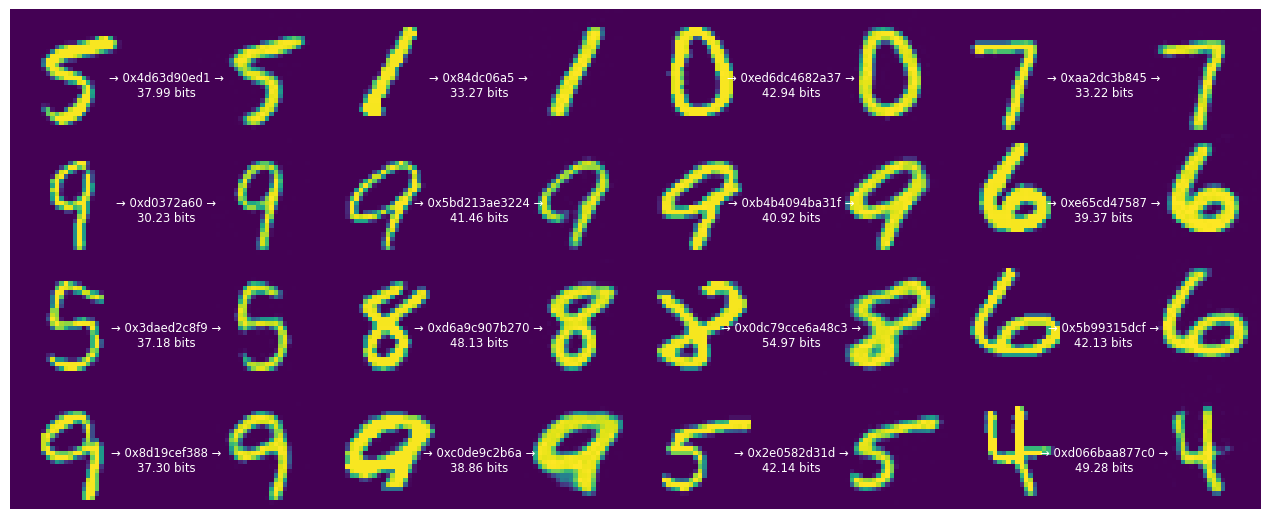

In [24]:
display_digits(originals, strings, entropies, reconstructions)


Note that the length of the encoded string differs from the information content of each digit.

This is because the range coding process works with discrete probabilities, and has a small amount of overhead. So, especially for short strings, the correspondence is only approximate. However, range coding is **asymptotically optimal**: in the limit, the expected bit count will approach the cross entropy (the expected information content), for which the rate term in the training model is an upper bound.

## The rate–distortion trade-off

Above, the model was trained for a specific trade-off (given by `lmbda=2000`) between the average number of bits used to represent each digit and the incurred error in the reconstruction.

What happens when we repeat the experiment with different values?

Let's start by reducing $\lambda$ to 500.

Epoch 1/15


  1/469 [..............................] - ETA: 16:36 - loss: 164.9507 - distortion_loss: 0.1240 - rate_loss: 102.9330 - distortion_pass_through_loss: 0.1240 - rate_pass_through_loss: 102.9330

  4/469 [..............................] - ETA: 9s - loss: 168.4234 - distortion_loss: 0.1311 - rate_loss: 102.8538 - distortion_pass_through_loss: 0.1311 - rate_pass_through_loss: 102.8538   

  7/469 [..............................] - ETA: 9s - loss: 168.6989 - distortion_loss: 0.1319 - rate_loss: 102.7341 - distortion_pass_through_loss: 0.1319 - rate_pass_through_loss: 102.7341

 10/469 [..............................] - ETA: 9s - loss: 168.7055 - distortion_loss: 0.1322 - rate_loss: 102.6221 - distortion_pass_through_loss: 0.1322 - rate_pass_through_loss: 102.6221

 13/469 [..............................] - ETA: 9s - loss: 168.3025 - distortion_loss: 0.1316 - rate_loss: 102.5163 - distortion_pass_through_loss: 0.1316 - rate_pass_through_loss: 102.5163

 16/469 [>.............................] - ETA: 8s - loss: 167.7993 - distortion_loss: 0.1308 - rate_loss: 102.4184 - distortion_pass_through_loss: 0.1308 - rate_pass_through_loss: 102.4184

 19/469 [>.............................] - ETA: 8s - loss: 167.4534 - distortion_loss: 0.1302 - rate_loss: 102.3508 - distortion_pass_through_loss: 0.1302 - rate_pass_through_loss: 102.3508

 22/469 [>.............................] - ETA: 8s - loss: 167.2416 - distortion_loss: 0.1299 - rate_loss: 102.2994 - distortion_pass_through_loss: 0.1299 - rate_pass_through_loss: 102.2994

 25/469 [>.............................] - ETA: 8s - loss: 166.6839 - distortion_loss: 0.1290 - rate_loss: 102.2044 - distortion_pass_through_loss: 0.1290 - rate_pass_through_loss: 102.2044

 28/469 [>.............................] - ETA: 8s - loss: 166.4753 - distortion_loss: 0.1287 - rate_loss: 102.1240 - distortion_pass_through_loss: 0.1287 - rate_pass_through_loss: 102.1240

 31/469 [>.............................] - ETA: 8s - loss: 166.0406 - distortion_loss: 0.1280 - rate_loss: 102.0350 - distortion_pass_through_loss: 0.1280 - rate_pass_through_loss: 102.0350

 34/469 [=>............................] - ETA: 8s - loss: 165.6631 - distortion_loss: 0.1274 - rate_loss: 101.9607 - distortion_pass_through_loss: 0.1274 - rate_pass_through_loss: 101.9607

 37/469 [=>............................] - ETA: 8s - loss: 165.1225 - distortion_loss: 0.1265 - rate_loss: 101.8805 - distortion_pass_through_loss: 0.1265 - rate_pass_through_loss: 101.8805

 40/469 [=>............................] - ETA: 8s - loss: 164.5849 - distortion_loss: 0.1255 - rate_loss: 101.8225 - distortion_pass_through_loss: 0.1255 - rate_pass_through_loss: 101.8225

 43/469 [=>............................] - ETA: 8s - loss: 164.1511 - distortion_loss: 0.1247 - rate_loss: 101.7822 - distortion_pass_through_loss: 0.1247 - rate_pass_through_loss: 101.7822

 46/469 [=>............................] - ETA: 8s - loss: 163.6164 - distortion_loss: 0.1237 - rate_loss: 101.7445 - distortion_pass_through_loss: 0.1237 - rate_pass_through_loss: 101.7445

 49/469 [==>...........................] - ETA: 8s - loss: 163.1375 - distortion_loss: 0.1229 - rate_loss: 101.6877 - distortion_pass_through_loss: 0.1229 - rate_pass_through_loss: 101.6877

 52/469 [==>...........................] - ETA: 8s - loss: 162.6079 - distortion_loss: 0.1219 - rate_loss: 101.6366 - distortion_pass_through_loss: 0.1219 - rate_pass_through_loss: 101.6366

 55/469 [==>...........................] - ETA: 8s - loss: 161.9890 - distortion_loss: 0.1208 - rate_loss: 101.6035 - distortion_pass_through_loss: 0.1208 - rate_pass_through_loss: 101.6035

 58/469 [==>...........................] - ETA: 8s - loss: 161.4188 - distortion_loss: 0.1197 - rate_loss: 101.5600 - distortion_pass_through_loss: 0.1197 - rate_pass_through_loss: 101.5600

 61/469 [==>...........................] - ETA: 8s - loss: 160.8385 - distortion_loss: 0.1187 - rate_loss: 101.5040 - distortion_pass_through_loss: 0.1187 - rate_pass_through_loss: 101.5040

 64/469 [===>..........................] - ETA: 7s - loss: 160.3024 - distortion_loss: 0.1177 - rate_loss: 101.4526 - distortion_pass_through_loss: 0.1177 - rate_pass_through_loss: 101.4526

 67/469 [===>..........................] - ETA: 7s - loss: 159.7254 - distortion_loss: 0.1166 - rate_loss: 101.4037 - distortion_pass_through_loss: 0.1166 - rate_pass_through_loss: 101.4037

 70/469 [===>..........................] - ETA: 7s - loss: 159.1283 - distortion_loss: 0.1155 - rate_loss: 101.3567 - distortion_pass_through_loss: 0.1155 - rate_pass_through_loss: 101.3567

 73/469 [===>..........................] - ETA: 7s - loss: 158.4843 - distortion_loss: 0.1143 - rate_loss: 101.3112 - distortion_pass_through_loss: 0.1143 - rate_pass_through_loss: 101.3112

 76/469 [===>..........................] - ETA: 7s - loss: 157.9339 - distortion_loss: 0.1133 - rate_loss: 101.2716 - distortion_pass_through_loss: 0.1133 - rate_pass_through_loss: 101.2716

 79/469 [====>.........................] - ETA: 7s - loss: 157.3543 - distortion_loss: 0.1123 - rate_loss: 101.2275 - distortion_pass_through_loss: 0.1123 - rate_pass_through_loss: 101.2275

 82/469 [====>.........................] - ETA: 7s - loss: 156.8255 - distortion_loss: 0.1113 - rate_loss: 101.1760 - distortion_pass_through_loss: 0.1113 - rate_pass_through_loss: 101.1760

 85/469 [====>.........................] - ETA: 7s - loss: 156.2734 - distortion_loss: 0.1103 - rate_loss: 101.1291 - distortion_pass_through_loss: 0.1103 - rate_pass_through_loss: 101.1291

 88/469 [====>.........................] - ETA: 7s - loss: 155.7474 - distortion_loss: 0.1093 - rate_loss: 101.0841 - distortion_pass_through_loss: 0.1093 - rate_pass_through_loss: 101.0841

 91/469 [====>.........................] - ETA: 7s - loss: 155.2026 - distortion_loss: 0.1083 - rate_loss: 101.0312 - distortion_pass_through_loss: 0.1083 - rate_pass_through_loss: 101.0312

 94/469 [=====>........................] - ETA: 7s - loss: 154.7135 - distortion_loss: 0.1074 - rate_loss: 100.9889 - distortion_pass_through_loss: 0.1074 - rate_pass_through_loss: 100.9889

 97/469 [=====>........................] - ETA: 7s - loss: 154.1983 - distortion_loss: 0.1065 - rate_loss: 100.9419 - distortion_pass_through_loss: 0.1065 - rate_pass_through_loss: 100.9419

100/469 [=====>........................] - ETA: 7s - loss: 153.7390 - distortion_loss: 0.1057 - rate_loss: 100.8931 - distortion_pass_through_loss: 0.1057 - rate_pass_through_loss: 100.8931

103/469 [=====>........................] - ETA: 7s - loss: 153.2849 - distortion_loss: 0.1049 - rate_loss: 100.8395 - distortion_pass_through_loss: 0.1049 - rate_pass_through_loss: 100.8395

106/469 [=====>........................] - ETA: 7s - loss: 152.8064 - distortion_loss: 0.1040 - rate_loss: 100.7853 - distortion_pass_through_loss: 0.1040 - rate_pass_through_loss: 100.7853

109/469 [=====>........................] - ETA: 7s - loss: 152.3447 - distortion_loss: 0.1032 - rate_loss: 100.7331 - distortion_pass_through_loss: 0.1032 - rate_pass_through_loss: 100.7331

112/469 [======>.......................] - ETA: 7s - loss: 151.9362 - distortion_loss: 0.1025 - rate_loss: 100.6816 - distortion_pass_through_loss: 0.1025 - rate_pass_through_loss: 100.6816

115/469 [======>.......................] - ETA: 6s - loss: 151.5474 - distortion_loss: 0.1018 - rate_loss: 100.6246 - distortion_pass_through_loss: 0.1018 - rate_pass_through_loss: 100.6246

118/469 [======>.......................] - ETA: 6s - loss: 151.1087 - distortion_loss: 0.1011 - rate_loss: 100.5711 - distortion_pass_through_loss: 0.1011 - rate_pass_through_loss: 100.5711

121/469 [======>.......................] - ETA: 6s - loss: 150.6943 - distortion_loss: 0.1004 - rate_loss: 100.5167 - distortion_pass_through_loss: 0.1004 - rate_pass_through_loss: 100.5167

124/469 [======>.......................] - ETA: 6s - loss: 150.2941 - distortion_loss: 0.0997 - rate_loss: 100.4625 - distortion_pass_through_loss: 0.0997 - rate_pass_through_loss: 100.4625

127/469 [=======>......................] - ETA: 6s - loss: 149.8924 - distortion_loss: 0.0990 - rate_loss: 100.4062 - distortion_pass_through_loss: 0.0990 - rate_pass_through_loss: 100.4062

130/469 [=======>......................] - ETA: 6s - loss: 149.5036 - distortion_loss: 0.0983 - rate_loss: 100.3463 - distortion_pass_through_loss: 0.0983 - rate_pass_through_loss: 100.3463

133/469 [=======>......................] - ETA: 6s - loss: 149.1177 - distortion_loss: 0.0977 - rate_loss: 100.2917 - distortion_pass_through_loss: 0.0977 - rate_pass_through_loss: 100.2917

136/469 [=======>......................] - ETA: 6s - loss: 148.7546 - distortion_loss: 0.0970 - rate_loss: 100.2368 - distortion_pass_through_loss: 0.0970 - rate_pass_through_loss: 100.2368

139/469 [=======>......................] - ETA: 6s - loss: 148.4143 - distortion_loss: 0.0965 - rate_loss: 100.1804 - distortion_pass_through_loss: 0.0965 - rate_pass_through_loss: 100.1804

142/469 [========>.....................] - ETA: 6s - loss: 148.0595 - distortion_loss: 0.0959 - rate_loss: 100.1213 - distortion_pass_through_loss: 0.0959 - rate_pass_through_loss: 100.1213

145/469 [========>.....................] - ETA: 6s - loss: 147.7239 - distortion_loss: 0.0953 - rate_loss: 100.0647 - distortion_pass_through_loss: 0.0953 - rate_pass_through_loss: 100.0647

148/469 [========>.....................] - ETA: 6s - loss: 147.3996 - distortion_loss: 0.0948 - rate_loss: 100.0025 - distortion_pass_through_loss: 0.0948 - rate_pass_through_loss: 100.0025

151/469 [========>.....................] - ETA: 6s - loss: 147.0819 - distortion_loss: 0.0943 - rate_loss: 99.9501 - distortion_pass_through_loss: 0.0943 - rate_pass_through_loss: 99.9501  

154/469 [========>.....................] - ETA: 6s - loss: 146.7830 - distortion_loss: 0.0938 - rate_loss: 99.8943 - distortion_pass_through_loss: 0.0938 - rate_pass_through_loss: 99.8943

157/469 [=========>....................] - ETA: 6s - loss: 146.4813 - distortion_loss: 0.0933 - rate_loss: 99.8365 - distortion_pass_through_loss: 0.0933 - rate_pass_through_loss: 99.8365

160/469 [=========>....................] - ETA: 6s - loss: 146.1842 - distortion_loss: 0.0928 - rate_loss: 99.7775 - distortion_pass_through_loss: 0.0928 - rate_pass_through_loss: 99.7775

163/469 [=========>....................] - ETA: 6s - loss: 145.8703 - distortion_loss: 0.0923 - rate_loss: 99.7127 - distortion_pass_through_loss: 0.0923 - rate_pass_through_loss: 99.7127

166/469 [=========>....................] - ETA: 5s - loss: 145.5775 - distortion_loss: 0.0919 - rate_loss: 99.6491 - distortion_pass_through_loss: 0.0919 - rate_pass_through_loss: 99.6491

169/469 [=========>....................] - ETA: 5s - loss: 145.2958 - distortion_loss: 0.0914 - rate_loss: 99.5875 - distortion_pass_through_loss: 0.0914 - rate_pass_through_loss: 99.5875

172/469 [==========>...................] - ETA: 5s - loss: 145.0046 - distortion_loss: 0.0910 - rate_loss: 99.5252 - distortion_pass_through_loss: 0.0910 - rate_pass_through_loss: 99.5252

175/469 [==========>...................] - ETA: 5s - loss: 144.7330 - distortion_loss: 0.0905 - rate_loss: 99.4628 - distortion_pass_through_loss: 0.0905 - rate_pass_through_loss: 99.4628

178/469 [==========>...................] - ETA: 5s - loss: 144.4536 - distortion_loss: 0.0901 - rate_loss: 99.4012 - distortion_pass_through_loss: 0.0901 - rate_pass_through_loss: 99.4012

181/469 [==========>...................] - ETA: 5s - loss: 144.1913 - distortion_loss: 0.0897 - rate_loss: 99.3398 - distortion_pass_through_loss: 0.0897 - rate_pass_through_loss: 99.3398

184/469 [==========>...................] - ETA: 5s - loss: 143.9304 - distortion_loss: 0.0893 - rate_loss: 99.2785 - distortion_pass_through_loss: 0.0893 - rate_pass_through_loss: 99.2785

187/469 [==========>...................] - ETA: 5s - loss: 143.6598 - distortion_loss: 0.0889 - rate_loss: 99.2118 - distortion_pass_through_loss: 0.0889 - rate_pass_through_loss: 99.2118

190/469 [===========>..................] - ETA: 5s - loss: 143.4077 - distortion_loss: 0.0885 - rate_loss: 99.1486 - distortion_pass_through_loss: 0.0885 - rate_pass_through_loss: 99.1486

193/469 [===========>..................] - ETA: 5s - loss: 143.1565 - distortion_loss: 0.0881 - rate_loss: 99.0881 - distortion_pass_through_loss: 0.0881 - rate_pass_through_loss: 99.0881

196/469 [===========>..................] - ETA: 5s - loss: 142.9081 - distortion_loss: 0.0878 - rate_loss: 99.0235 - distortion_pass_through_loss: 0.0878 - rate_pass_through_loss: 99.0235

199/469 [===========>..................] - ETA: 5s - loss: 142.6445 - distortion_loss: 0.0874 - rate_loss: 98.9594 - distortion_pass_through_loss: 0.0874 - rate_pass_through_loss: 98.9594

202/469 [===========>..................] - ETA: 5s - loss: 142.3922 - distortion_loss: 0.0870 - rate_loss: 98.8955 - distortion_pass_through_loss: 0.0870 - rate_pass_through_loss: 98.8955

205/469 [============>.................] - ETA: 5s - loss: 142.1444 - distortion_loss: 0.0866 - rate_loss: 98.8301 - distortion_pass_through_loss: 0.0866 - rate_pass_through_loss: 98.8301

208/469 [============>.................] - ETA: 5s - loss: 141.8977 - distortion_loss: 0.0863 - rate_loss: 98.7639 - distortion_pass_through_loss: 0.0863 - rate_pass_through_loss: 98.7639

211/469 [============>.................] - ETA: 5s - loss: 141.6441 - distortion_loss: 0.0859 - rate_loss: 98.6961 - distortion_pass_through_loss: 0.0859 - rate_pass_through_loss: 98.6961

214/469 [============>.................] - ETA: 5s - loss: 141.4077 - distortion_loss: 0.0856 - rate_loss: 98.6309 - distortion_pass_through_loss: 0.0856 - rate_pass_through_loss: 98.6309

217/469 [============>.................] - ETA: 4s - loss: 141.1702 - distortion_loss: 0.0852 - rate_loss: 98.5640 - distortion_pass_through_loss: 0.0852 - rate_pass_through_loss: 98.5640

220/469 [=============>................] - ETA: 4s - loss: 140.9414 - distortion_loss: 0.0849 - rate_loss: 98.4984 - distortion_pass_through_loss: 0.0849 - rate_pass_through_loss: 98.4984

223/469 [=============>................] - ETA: 4s - loss: 140.7125 - distortion_loss: 0.0846 - rate_loss: 98.4290 - distortion_pass_through_loss: 0.0846 - rate_pass_through_loss: 98.4290

226/469 [=============>................] - ETA: 4s - loss: 140.4794 - distortion_loss: 0.0842 - rate_loss: 98.3626 - distortion_pass_through_loss: 0.0842 - rate_pass_through_loss: 98.3626

229/469 [=============>................] - ETA: 4s - loss: 140.2674 - distortion_loss: 0.0839 - rate_loss: 98.2951 - distortion_pass_through_loss: 0.0839 - rate_pass_through_loss: 98.2951

232/469 [=============>................] - ETA: 4s - loss: 140.0583 - distortion_loss: 0.0837 - rate_loss: 98.2288 - distortion_pass_through_loss: 0.0837 - rate_pass_through_loss: 98.2288

235/469 [==============>...............] - ETA: 4s - loss: 139.8399 - distortion_loss: 0.0834 - rate_loss: 98.1598 - distortion_pass_through_loss: 0.0834 - rate_pass_through_loss: 98.1598

238/469 [==============>...............] - ETA: 4s - loss: 139.6282 - distortion_loss: 0.0831 - rate_loss: 98.0919 - distortion_pass_through_loss: 0.0831 - rate_pass_through_loss: 98.0919

241/469 [==============>...............] - ETA: 4s - loss: 139.4172 - distortion_loss: 0.0828 - rate_loss: 98.0231 - distortion_pass_through_loss: 0.0828 - rate_pass_through_loss: 98.0231

244/469 [==============>...............] - ETA: 4s - loss: 139.2039 - distortion_loss: 0.0825 - rate_loss: 97.9541 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 97.9541

247/469 [==============>...............] - ETA: 4s - loss: 139.0086 - distortion_loss: 0.0822 - rate_loss: 97.8865 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 97.8865

250/469 [==============>...............] - ETA: 4s - loss: 138.8132 - distortion_loss: 0.0820 - rate_loss: 97.8185 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 97.8185

253/469 [===============>..............] - ETA: 4s - loss: 138.6122 - distortion_loss: 0.0817 - rate_loss: 97.7482 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 97.7482

256/469 [===============>..............] - ETA: 4s - loss: 138.4085 - distortion_loss: 0.0815 - rate_loss: 97.6783 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 97.6783

259/469 [===============>..............] - ETA: 4s - loss: 138.2110 - distortion_loss: 0.0812 - rate_loss: 97.6098 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 97.6098

262/469 [===============>..............] - ETA: 4s - loss: 138.0130 - distortion_loss: 0.0809 - rate_loss: 97.5425 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 97.5425

265/469 [===============>..............] - ETA: 4s - loss: 137.8116 - distortion_loss: 0.0807 - rate_loss: 97.4745 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 97.4745

268/469 [================>.............] - ETA: 3s - loss: 137.6152 - distortion_loss: 0.0804 - rate_loss: 97.4031 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 97.4031

271/469 [================>.............] - ETA: 3s - loss: 137.4282 - distortion_loss: 0.0802 - rate_loss: 97.3313 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 97.3313

274/469 [================>.............] - ETA: 3s - loss: 137.2438 - distortion_loss: 0.0800 - rate_loss: 97.2579 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 97.2579

277/469 [================>.............] - ETA: 3s - loss: 137.0571 - distortion_loss: 0.0797 - rate_loss: 97.1886 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 97.1886

280/469 [================>.............] - ETA: 3s - loss: 136.8669 - distortion_loss: 0.0795 - rate_loss: 97.1190 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 97.1190

283/469 [=================>............] - ETA: 3s - loss: 136.6997 - distortion_loss: 0.0793 - rate_loss: 97.0515 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 97.0515

286/469 [=================>............] - ETA: 3s - loss: 136.5195 - distortion_loss: 0.0791 - rate_loss: 96.9839 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 96.9839

289/469 [=================>............] - ETA: 3s - loss: 136.3403 - distortion_loss: 0.0789 - rate_loss: 96.9133 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 96.9133

292/469 [=================>............] - ETA: 3s - loss: 136.1568 - distortion_loss: 0.0786 - rate_loss: 96.8435 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 96.8435

295/469 [=================>............] - ETA: 3s - loss: 135.9769 - distortion_loss: 0.0784 - rate_loss: 96.7702 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 96.7702

298/469 [==================>...........] - ETA: 3s - loss: 135.7953 - distortion_loss: 0.0782 - rate_loss: 96.6986 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 96.6986

301/469 [==================>...........] - ETA: 3s - loss: 135.6275 - distortion_loss: 0.0780 - rate_loss: 96.6287 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 96.6287

304/469 [==================>...........] - ETA: 3s - loss: 135.4474 - distortion_loss: 0.0778 - rate_loss: 96.5572 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 96.5572

307/469 [==================>...........] - ETA: 3s - loss: 135.2823 - distortion_loss: 0.0776 - rate_loss: 96.4851 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 96.4851

310/469 [==================>...........] - ETA: 3s - loss: 135.1136 - distortion_loss: 0.0774 - rate_loss: 96.4133 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 96.4133

313/469 [===================>..........] - ETA: 3s - loss: 134.9456 - distortion_loss: 0.0772 - rate_loss: 96.3432 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 96.3432

316/469 [===================>..........] - ETA: 2s - loss: 134.7797 - distortion_loss: 0.0770 - rate_loss: 96.2719 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 96.2719

319/469 [===================>..........] - ETA: 2s - loss: 134.6103 - distortion_loss: 0.0768 - rate_loss: 96.2015 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 96.2015

322/469 [===================>..........] - ETA: 2s - loss: 134.4480 - distortion_loss: 0.0766 - rate_loss: 96.1290 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 96.1290

325/469 [===================>..........] - ETA: 2s - loss: 134.2797 - distortion_loss: 0.0764 - rate_loss: 96.0572 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 96.0572

328/469 [===================>..........] - ETA: 2s - loss: 134.1219 - distortion_loss: 0.0763 - rate_loss: 95.9866 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 95.9866

331/469 [====================>.........] - ETA: 2s - loss: 133.9600 - distortion_loss: 0.0761 - rate_loss: 95.9142 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 95.9142

334/469 [====================>.........] - ETA: 2s - loss: 133.8035 - distortion_loss: 0.0759 - rate_loss: 95.8442 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 95.8442

337/469 [====================>.........] - ETA: 2s - loss: 133.6455 - distortion_loss: 0.0757 - rate_loss: 95.7721 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 95.7721

340/469 [====================>.........] - ETA: 2s - loss: 133.4870 - distortion_loss: 0.0756 - rate_loss: 95.6991 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 95.6991

343/469 [====================>.........] - ETA: 2s - loss: 133.3305 - distortion_loss: 0.0754 - rate_loss: 95.6270 - distortion_pass_through_loss: 0.0754 - rate_pass_through_loss: 95.6270

346/469 [=====================>........] - ETA: 2s - loss: 133.1692 - distortion_loss: 0.0752 - rate_loss: 95.5538 - distortion_pass_through_loss: 0.0752 - rate_pass_through_loss: 95.5538

349/469 [=====================>........] - ETA: 2s - loss: 133.0226 - distortion_loss: 0.0751 - rate_loss: 95.4824 - distortion_pass_through_loss: 0.0751 - rate_pass_through_loss: 95.4824

352/469 [=====================>........] - ETA: 2s - loss: 132.8743 - distortion_loss: 0.0749 - rate_loss: 95.4080 - distortion_pass_through_loss: 0.0749 - rate_pass_through_loss: 95.4080

355/469 [=====================>........] - ETA: 2s - loss: 132.7218 - distortion_loss: 0.0748 - rate_loss: 95.3363 - distortion_pass_through_loss: 0.0748 - rate_pass_through_loss: 95.3363

358/469 [=====================>........] - ETA: 2s - loss: 132.5693 - distortion_loss: 0.0746 - rate_loss: 95.2618 - distortion_pass_through_loss: 0.0746 - rate_pass_through_loss: 95.2618

361/469 [======================>.......] - ETA: 2s - loss: 132.4238 - distortion_loss: 0.0745 - rate_loss: 95.1892 - distortion_pass_through_loss: 0.0745 - rate_pass_through_loss: 95.1892

364/469 [======================>.......] - ETA: 2s - loss: 132.2770 - distortion_loss: 0.0743 - rate_loss: 95.1159 - distortion_pass_through_loss: 0.0743 - rate_pass_through_loss: 95.1159

367/469 [======================>.......] - ETA: 1s - loss: 132.1301 - distortion_loss: 0.0742 - rate_loss: 95.0442 - distortion_pass_through_loss: 0.0742 - rate_pass_through_loss: 95.0442

370/469 [======================>.......] - ETA: 1s - loss: 131.9822 - distortion_loss: 0.0740 - rate_loss: 94.9715 - distortion_pass_through_loss: 0.0740 - rate_pass_through_loss: 94.9715

373/469 [======================>.......] - ETA: 1s - loss: 131.8334 - distortion_loss: 0.0739 - rate_loss: 94.8977 - distortion_pass_through_loss: 0.0739 - rate_pass_through_loss: 94.8977

376/469 [=======================>......] - ETA: 1s - loss: 131.6842 - distortion_loss: 0.0737 - rate_loss: 94.8243 - distortion_pass_through_loss: 0.0737 - rate_pass_through_loss: 94.8243

379/469 [=======================>......] - ETA: 1s - loss: 131.5381 - distortion_loss: 0.0736 - rate_loss: 94.7504 - distortion_pass_through_loss: 0.0736 - rate_pass_through_loss: 94.7504

382/469 [=======================>......] - ETA: 1s - loss: 131.3935 - distortion_loss: 0.0734 - rate_loss: 94.6784 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 94.6784

385/469 [=======================>......] - ETA: 1s - loss: 131.2462 - distortion_loss: 0.0733 - rate_loss: 94.6047 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 94.6047

388/469 [=======================>......] - ETA: 1s - loss: 131.1081 - distortion_loss: 0.0732 - rate_loss: 94.5324 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 94.5324

391/469 [========================>.....] - ETA: 1s - loss: 130.9628 - distortion_loss: 0.0730 - rate_loss: 94.4570 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 94.4570

394/469 [========================>.....] - ETA: 1s - loss: 130.8214 - distortion_loss: 0.0729 - rate_loss: 94.3837 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 94.3837

397/469 [========================>.....] - ETA: 1s - loss: 130.6800 - distortion_loss: 0.0727 - rate_loss: 94.3113 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 94.3113

400/469 [========================>.....] - ETA: 1s - loss: 130.5407 - distortion_loss: 0.0726 - rate_loss: 94.2364 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 94.2364

403/469 [========================>.....] - ETA: 1s - loss: 130.3911 - distortion_loss: 0.0725 - rate_loss: 94.1614 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 94.1614

406/469 [========================>.....] - ETA: 1s - loss: 130.2553 - distortion_loss: 0.0723 - rate_loss: 94.0870 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 94.0870

409/469 [=========================>....] - ETA: 1s - loss: 130.1182 - distortion_loss: 0.0722 - rate_loss: 94.0149 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 94.0149

412/469 [=========================>....] - ETA: 1s - loss: 129.9838 - distortion_loss: 0.0721 - rate_loss: 93.9400 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 93.9400

415/469 [=========================>....] - ETA: 1s - loss: 129.8486 - distortion_loss: 0.0720 - rate_loss: 93.8656 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 93.8656

418/469 [=========================>....] - ETA: 0s - loss: 129.7128 - distortion_loss: 0.0718 - rate_loss: 93.7927 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 93.7927

421/469 [=========================>....] - ETA: 0s - loss: 129.5753 - distortion_loss: 0.0717 - rate_loss: 93.7196 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 93.7196

424/469 [==========================>...] - ETA: 0s - loss: 129.4385 - distortion_loss: 0.0716 - rate_loss: 93.6465 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 93.6465

427/469 [==========================>...] - ETA: 0s - loss: 129.3080 - distortion_loss: 0.0715 - rate_loss: 93.5725 - distortion_pass_through_loss: 0.0715 - rate_pass_through_loss: 93.5725

430/469 [==========================>...] - ETA: 0s - loss: 129.1803 - distortion_loss: 0.0714 - rate_loss: 93.4990 - distortion_pass_through_loss: 0.0714 - rate_pass_through_loss: 93.4990

433/469 [==========================>...] - ETA: 0s - loss: 129.0492 - distortion_loss: 0.0713 - rate_loss: 93.4240 - distortion_pass_through_loss: 0.0713 - rate_pass_through_loss: 93.4240

436/469 [==========================>...] - ETA: 0s - loss: 128.9171 - distortion_loss: 0.0711 - rate_loss: 93.3492 - distortion_pass_through_loss: 0.0711 - rate_pass_through_loss: 93.3492

439/469 [===========================>..] - ETA: 0s - loss: 128.7882 - distortion_loss: 0.0710 - rate_loss: 93.2770 - distortion_pass_through_loss: 0.0710 - rate_pass_through_loss: 93.2770

442/469 [===========================>..] - ETA: 0s - loss: 128.6596 - distortion_loss: 0.0709 - rate_loss: 93.2029 - distortion_pass_through_loss: 0.0709 - rate_pass_through_loss: 93.2029

445/469 [===========================>..] - ETA: 0s - loss: 128.5295 - distortion_loss: 0.0708 - rate_loss: 93.1280 - distortion_pass_through_loss: 0.0708 - rate_pass_through_loss: 93.1280

448/469 [===========================>..] - ETA: 0s - loss: 128.4054 - distortion_loss: 0.0707 - rate_loss: 93.0542 - distortion_pass_through_loss: 0.0707 - rate_pass_through_loss: 93.0542

451/469 [===========================>..] - ETA: 0s - loss: 128.2761 - distortion_loss: 0.0706 - rate_loss: 92.9787 - distortion_pass_through_loss: 0.0706 - rate_pass_through_loss: 92.9787

454/469 [============================>.] - ETA: 0s - loss: 128.1491 - distortion_loss: 0.0705 - rate_loss: 92.9048 - distortion_pass_through_loss: 0.0705 - rate_pass_through_loss: 92.9048

457/469 [============================>.] - ETA: 0s - loss: 128.0242 - distortion_loss: 0.0704 - rate_loss: 92.8313 - distortion_pass_through_loss: 0.0704 - rate_pass_through_loss: 92.8313

460/469 [============================>.] - ETA: 0s - loss: 127.8998 - distortion_loss: 0.0703 - rate_loss: 92.7576 - distortion_pass_through_loss: 0.0703 - rate_pass_through_loss: 92.7576

463/469 [============================>.] - ETA: 0s - loss: 127.7730 - distortion_loss: 0.0702 - rate_loss: 92.6829 - distortion_pass_through_loss: 0.0702 - rate_pass_through_loss: 92.6829

466/469 [============================>.] - ETA: 0s - loss: 127.6506 - distortion_loss: 0.0701 - rate_loss: 92.6086 - distortion_pass_through_loss: 0.0701 - rate_pass_through_loss: 92.6086

469/469 [==============================] - ETA: 0s - loss: 127.5305 - distortion_loss: 0.0700 - rate_loss: 92.5392 - distortion_pass_through_loss: 0.0700 - rate_pass_through_loss: 92.5329

469/469 [==============================] - 12s 21ms/step - loss: 127.5305 - distortion_loss: 0.0700 - rate_loss: 92.5392 - distortion_pass_through_loss: 0.0700 - rate_pass_through_loss: 92.5329 - val_loss: 107.4705 - val_distortion_loss: 0.0548 - val_rate_loss: 80.0521 - val_distortion_pass_through_loss: 0.0549 - val_rate_pass_through_loss: 80.0560


Epoch 2/15


  1/469 [..............................] - ETA: 11s - loss: 106.3193 - distortion_loss: 0.0506 - rate_loss: 81.0400 - distortion_pass_through_loss: 0.0506 - rate_pass_through_loss: 81.0400

  4/469 [..............................] - ETA: 8s - loss: 107.8617 - distortion_loss: 0.0538 - rate_loss: 80.9568 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 80.9568 

  7/469 [..............................] - ETA: 8s - loss: 108.0674 - distortion_loss: 0.0544 - rate_loss: 80.8846 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 80.8846

 10/469 [..............................] - ETA: 8s - loss: 108.2358 - distortion_loss: 0.0549 - rate_loss: 80.7928 - distortion_pass_through_loss: 0.0549 - rate_pass_through_loss: 80.7928

 13/469 [..............................] - ETA: 8s - loss: 108.0161 - distortion_loss: 0.0547 - rate_loss: 80.6657 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 80.6657

 16/469 [>.............................] - ETA: 8s - loss: 107.8643 - distortion_loss: 0.0546 - rate_loss: 80.5668 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 80.5668

 19/469 [>.............................] - ETA: 8s - loss: 107.8194 - distortion_loss: 0.0547 - rate_loss: 80.4724 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 80.4724

 22/469 [>.............................] - ETA: 8s - loss: 107.8412 - distortion_loss: 0.0548 - rate_loss: 80.4357 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 80.4357

 25/469 [>.............................] - ETA: 8s - loss: 107.7059 - distortion_loss: 0.0547 - rate_loss: 80.3452 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 80.3452

 28/469 [>.............................] - ETA: 8s - loss: 107.6783 - distortion_loss: 0.0548 - rate_loss: 80.2946 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 80.2946

 31/469 [>.............................] - ETA: 8s - loss: 107.5456 - distortion_loss: 0.0547 - rate_loss: 80.2005 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 80.2005

 34/469 [=>............................] - ETA: 8s - loss: 107.4619 - distortion_loss: 0.0547 - rate_loss: 80.1358 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 80.1358

 37/469 [=>............................] - ETA: 8s - loss: 107.3018 - distortion_loss: 0.0545 - rate_loss: 80.0302 - distortion_pass_through_loss: 0.0545 - rate_pass_through_loss: 80.0302

 40/469 [=>............................] - ETA: 8s - loss: 107.2033 - distortion_loss: 0.0545 - rate_loss: 79.9713 - distortion_pass_through_loss: 0.0545 - rate_pass_through_loss: 79.9713

 43/469 [=>............................] - ETA: 8s - loss: 107.1128 - distortion_loss: 0.0544 - rate_loss: 79.9001 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 79.9001

 46/469 [=>............................] - ETA: 8s - loss: 107.0016 - distortion_loss: 0.0544 - rate_loss: 79.8228 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 79.8228

 49/469 [==>...........................] - ETA: 8s - loss: 106.9469 - distortion_loss: 0.0544 - rate_loss: 79.7630 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 79.7630

 52/469 [==>...........................] - ETA: 7s - loss: 106.8962 - distortion_loss: 0.0544 - rate_loss: 79.6801 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 79.6801

 55/469 [==>...........................] - ETA: 7s - loss: 106.7915 - distortion_loss: 0.0544 - rate_loss: 79.6119 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 79.6119

 58/469 [==>...........................] - ETA: 7s - loss: 106.7206 - distortion_loss: 0.0544 - rate_loss: 79.5370 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 79.5370

 61/469 [==>...........................] - ETA: 7s - loss: 106.6365 - distortion_loss: 0.0543 - rate_loss: 79.4734 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 79.4734

 64/469 [===>..........................] - ETA: 7s - loss: 106.6027 - distortion_loss: 0.0544 - rate_loss: 79.4026 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 79.4026

 67/469 [===>..........................] - ETA: 7s - loss: 106.5308 - distortion_loss: 0.0544 - rate_loss: 79.3332 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 79.3332

 70/469 [===>..........................] - ETA: 7s - loss: 106.4446 - distortion_loss: 0.0544 - rate_loss: 79.2632 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 79.2632

 73/469 [===>..........................] - ETA: 7s - loss: 106.3279 - distortion_loss: 0.0543 - rate_loss: 79.1865 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 79.1865

 76/469 [===>..........................] - ETA: 7s - loss: 106.2570 - distortion_loss: 0.0543 - rate_loss: 79.1204 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 79.1204

 79/469 [====>.........................] - ETA: 7s - loss: 106.1735 - distortion_loss: 0.0543 - rate_loss: 79.0420 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 79.0420

 82/469 [====>.........................] - ETA: 7s - loss: 106.0990 - distortion_loss: 0.0543 - rate_loss: 78.9698 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 78.9698

 85/469 [====>.........................] - ETA: 7s - loss: 106.0014 - distortion_loss: 0.0542 - rate_loss: 78.8968 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 78.8968

 88/469 [====>.........................] - ETA: 7s - loss: 105.9118 - distortion_loss: 0.0542 - rate_loss: 78.8252 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 78.8252

 91/469 [====>.........................] - ETA: 7s - loss: 105.7997 - distortion_loss: 0.0541 - rate_loss: 78.7449 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 78.7449

 94/469 [=====>........................] - ETA: 7s - loss: 105.7240 - distortion_loss: 0.0541 - rate_loss: 78.6785 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 78.6785

 97/469 [=====>........................] - ETA: 7s - loss: 105.6328 - distortion_loss: 0.0541 - rate_loss: 78.5980 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 78.5980

100/469 [=====>........................] - ETA: 7s - loss: 105.5816 - distortion_loss: 0.0541 - rate_loss: 78.5415 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 78.5415

103/469 [=====>........................] - ETA: 7s - loss: 105.5120 - distortion_loss: 0.0541 - rate_loss: 78.4592 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 78.4592

106/469 [=====>........................] - ETA: 6s - loss: 105.4186 - distortion_loss: 0.0541 - rate_loss: 78.3785 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 78.3785

109/469 [=====>........................] - ETA: 6s - loss: 105.3367 - distortion_loss: 0.0541 - rate_loss: 78.2950 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 78.2950

112/469 [======>.......................] - ETA: 6s - loss: 105.2722 - distortion_loss: 0.0541 - rate_loss: 78.2241 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 78.2241

115/469 [======>.......................] - ETA: 6s - loss: 105.2275 - distortion_loss: 0.0541 - rate_loss: 78.1662 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 78.1662

118/469 [======>.......................] - ETA: 6s - loss: 105.1281 - distortion_loss: 0.0541 - rate_loss: 78.0883 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 78.0883

121/469 [======>.......................] - ETA: 6s - loss: 105.0477 - distortion_loss: 0.0540 - rate_loss: 78.0229 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 78.0229

124/469 [======>.......................] - ETA: 6s - loss: 104.9732 - distortion_loss: 0.0541 - rate_loss: 77.9456 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 77.9456

127/469 [=======>......................] - ETA: 6s - loss: 104.8802 - distortion_loss: 0.0540 - rate_loss: 77.8663 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 77.8663

130/469 [=======>......................] - ETA: 6s - loss: 104.7910 - distortion_loss: 0.0540 - rate_loss: 77.7884 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 77.7884

133/469 [=======>......................] - ETA: 6s - loss: 104.7009 - distortion_loss: 0.0540 - rate_loss: 77.7156 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 77.7156

136/469 [=======>......................] - ETA: 6s - loss: 104.6201 - distortion_loss: 0.0539 - rate_loss: 77.6475 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.6475

139/469 [=======>......................] - ETA: 6s - loss: 104.5557 - distortion_loss: 0.0540 - rate_loss: 77.5758 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 77.5758

142/469 [========>.....................] - ETA: 6s - loss: 104.4755 - distortion_loss: 0.0539 - rate_loss: 77.5011 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.5011

145/469 [========>.....................] - ETA: 6s - loss: 104.3966 - distortion_loss: 0.0539 - rate_loss: 77.4320 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.4320

148/469 [========>.....................] - ETA: 6s - loss: 104.3257 - distortion_loss: 0.0539 - rate_loss: 77.3597 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.3597

151/469 [========>.....................] - ETA: 6s - loss: 104.2503 - distortion_loss: 0.0539 - rate_loss: 77.2924 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.2924

154/469 [========>.....................] - ETA: 6s - loss: 104.1890 - distortion_loss: 0.0539 - rate_loss: 77.2284 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.2284

157/469 [=========>....................] - ETA: 6s - loss: 104.1177 - distortion_loss: 0.0539 - rate_loss: 77.1560 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.1560

160/469 [=========>....................] - ETA: 5s - loss: 104.0514 - distortion_loss: 0.0539 - rate_loss: 77.0868 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.0868

163/469 [=========>....................] - ETA: 5s - loss: 103.9710 - distortion_loss: 0.0539 - rate_loss: 77.0104 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.0104

166/469 [=========>....................] - ETA: 5s - loss: 103.8994 - distortion_loss: 0.0539 - rate_loss: 76.9422 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.9422

169/469 [=========>....................] - ETA: 5s - loss: 103.8354 - distortion_loss: 0.0539 - rate_loss: 76.8723 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.8723

172/469 [==========>...................] - ETA: 5s - loss: 103.7560 - distortion_loss: 0.0539 - rate_loss: 76.8014 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.8014

175/469 [==========>...................] - ETA: 5s - loss: 103.6934 - distortion_loss: 0.0539 - rate_loss: 76.7295 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.7295

178/469 [==========>...................] - ETA: 5s - loss: 103.6225 - distortion_loss: 0.0539 - rate_loss: 76.6586 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.6586

181/469 [==========>...................] - ETA: 5s - loss: 103.5610 - distortion_loss: 0.0539 - rate_loss: 76.5911 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.5911

184/469 [==========>...................] - ETA: 5s - loss: 103.4971 - distortion_loss: 0.0540 - rate_loss: 76.5191 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.5191

187/469 [==========>...................] - ETA: 5s - loss: 103.4190 - distortion_loss: 0.0539 - rate_loss: 76.4480 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.4480

190/469 [===========>..................] - ETA: 5s - loss: 103.3561 - distortion_loss: 0.0540 - rate_loss: 76.3772 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.3772

193/469 [===========>..................] - ETA: 5s - loss: 103.2942 - distortion_loss: 0.0540 - rate_loss: 76.3133 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.3133

196/469 [===========>..................] - ETA: 5s - loss: 103.2265 - distortion_loss: 0.0540 - rate_loss: 76.2442 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.2442

199/469 [===========>..................] - ETA: 5s - loss: 103.1505 - distortion_loss: 0.0540 - rate_loss: 76.1739 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.1739

202/469 [===========>..................] - ETA: 5s - loss: 103.0736 - distortion_loss: 0.0539 - rate_loss: 76.1035 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.1035

205/469 [============>.................] - ETA: 5s - loss: 103.0024 - distortion_loss: 0.0539 - rate_loss: 76.0292 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.0292

208/469 [============>.................] - ETA: 5s - loss: 102.9299 - distortion_loss: 0.0539 - rate_loss: 75.9623 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 75.9623

211/469 [============>.................] - ETA: 4s - loss: 102.8467 - distortion_loss: 0.0539 - rate_loss: 75.8928 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 75.8928

214/469 [============>.................] - ETA: 4s - loss: 102.7789 - distortion_loss: 0.0539 - rate_loss: 75.8239 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 75.8239

217/469 [============>.................] - ETA: 4s - loss: 102.7060 - distortion_loss: 0.0539 - rate_loss: 75.7526 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 75.7526

220/469 [=============>................] - ETA: 4s - loss: 102.6368 - distortion_loss: 0.0539 - rate_loss: 75.6808 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 75.6808

223/469 [=============>................] - ETA: 4s - loss: 102.5697 - distortion_loss: 0.0539 - rate_loss: 75.6125 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 75.6125

226/469 [=============>................] - ETA: 4s - loss: 102.4913 - distortion_loss: 0.0539 - rate_loss: 75.5439 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 75.5439

229/469 [=============>................] - ETA: 4s - loss: 102.4260 - distortion_loss: 0.0539 - rate_loss: 75.4784 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 75.4784

232/469 [=============>................] - ETA: 4s - loss: 102.3627 - distortion_loss: 0.0539 - rate_loss: 75.4112 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 75.4112

235/469 [==============>...............] - ETA: 4s - loss: 102.2883 - distortion_loss: 0.0539 - rate_loss: 75.3377 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 75.3377

238/469 [==============>...............] - ETA: 4s - loss: 102.2203 - distortion_loss: 0.0539 - rate_loss: 75.2694 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 75.2694

241/469 [==============>...............] - ETA: 4s - loss: 102.1484 - distortion_loss: 0.0539 - rate_loss: 75.2011 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 75.2011

244/469 [==============>...............] - ETA: 4s - loss: 102.0713 - distortion_loss: 0.0539 - rate_loss: 75.1317 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 75.1317

247/469 [==============>...............] - ETA: 4s - loss: 102.0150 - distortion_loss: 0.0539 - rate_loss: 75.0670 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 75.0670

250/469 [==============>...............] - ETA: 4s - loss: 101.9499 - distortion_loss: 0.0539 - rate_loss: 74.9977 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.9977

253/469 [===============>..............] - ETA: 4s - loss: 101.8823 - distortion_loss: 0.0539 - rate_loss: 74.9296 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.9296

256/469 [===============>..............] - ETA: 4s - loss: 101.8101 - distortion_loss: 0.0539 - rate_loss: 74.8625 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.8625

259/469 [===============>..............] - ETA: 4s - loss: 101.7437 - distortion_loss: 0.0539 - rate_loss: 74.7965 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.7965

262/469 [===============>..............] - ETA: 3s - loss: 101.6753 - distortion_loss: 0.0539 - rate_loss: 74.7264 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.7264

265/469 [===============>..............] - ETA: 3s - loss: 101.6043 - distortion_loss: 0.0539 - rate_loss: 74.6579 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.6579

268/469 [================>.............] - ETA: 3s - loss: 101.5319 - distortion_loss: 0.0539 - rate_loss: 74.5919 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.5919

271/469 [================>.............] - ETA: 3s - loss: 101.4698 - distortion_loss: 0.0539 - rate_loss: 74.5262 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.5262

274/469 [================>.............] - ETA: 3s - loss: 101.4062 - distortion_loss: 0.0539 - rate_loss: 74.4583 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.4583

277/469 [================>.............] - ETA: 3s - loss: 101.3383 - distortion_loss: 0.0539 - rate_loss: 74.3869 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.3869

280/469 [================>.............] - ETA: 3s - loss: 101.2680 - distortion_loss: 0.0539 - rate_loss: 74.3215 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.3215

283/469 [=================>............] - ETA: 3s - loss: 101.2143 - distortion_loss: 0.0539 - rate_loss: 74.2579 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.2579

286/469 [=================>............] - ETA: 3s - loss: 101.1505 - distortion_loss: 0.0539 - rate_loss: 74.1941 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.1941

289/469 [=================>............] - ETA: 3s - loss: 101.0824 - distortion_loss: 0.0539 - rate_loss: 74.1259 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.1259

292/469 [=================>............] - ETA: 3s - loss: 101.0116 - distortion_loss: 0.0539 - rate_loss: 74.0566 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.0566

295/469 [=================>............] - ETA: 3s - loss: 100.9374 - distortion_loss: 0.0539 - rate_loss: 73.9899 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.9899

298/469 [==================>...........] - ETA: 3s - loss: 100.8611 - distortion_loss: 0.0539 - rate_loss: 73.9233 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.9233

301/469 [==================>...........] - ETA: 3s - loss: 100.8021 - distortion_loss: 0.0539 - rate_loss: 73.8597 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.8597

304/469 [==================>...........] - ETA: 3s - loss: 100.7294 - distortion_loss: 0.0539 - rate_loss: 73.7894 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.7894

307/469 [==================>...........] - ETA: 3s - loss: 100.6663 - distortion_loss: 0.0539 - rate_loss: 73.7206 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.7206

310/469 [==================>...........] - ETA: 3s - loss: 100.6061 - distortion_loss: 0.0539 - rate_loss: 73.6555 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.6555

313/469 [===================>..........] - ETA: 2s - loss: 100.5417 - distortion_loss: 0.0539 - rate_loss: 73.5923 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.5923

316/469 [===================>..........] - ETA: 2s - loss: 100.4756 - distortion_loss: 0.0539 - rate_loss: 73.5254 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.5254

319/469 [===================>..........] - ETA: 2s - loss: 100.4103 - distortion_loss: 0.0539 - rate_loss: 73.4572 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.4572

322/469 [===================>..........] - ETA: 2s - loss: 100.3496 - distortion_loss: 0.0539 - rate_loss: 73.3910 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.3910

325/469 [===================>..........] - ETA: 2s - loss: 100.2851 - distortion_loss: 0.0539 - rate_loss: 73.3263 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.3263

328/469 [===================>..........] - ETA: 2s - loss: 100.2217 - distortion_loss: 0.0539 - rate_loss: 73.2574 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.2574

331/469 [====================>.........] - ETA: 2s - loss: 100.1556 - distortion_loss: 0.0539 - rate_loss: 73.1924 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.1924

334/469 [====================>.........] - ETA: 2s - loss: 100.0941 - distortion_loss: 0.0539 - rate_loss: 73.1257 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.1257

337/469 [====================>.........] - ETA: 2s - loss: 100.0296 - distortion_loss: 0.0539 - rate_loss: 73.0640 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.0640

340/469 [====================>.........] - ETA: 2s - loss: 99.9643 - distortion_loss: 0.0539 - rate_loss: 72.9979 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 72.9979 

343/469 [====================>.........] - ETA: 2s - loss: 99.8969 - distortion_loss: 0.0539 - rate_loss: 72.9318 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 72.9318

346/469 [=====================>........] - ETA: 2s - loss: 99.8272 - distortion_loss: 0.0539 - rate_loss: 72.8658 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 72.8658

349/469 [=====================>........] - ETA: 2s - loss: 99.7702 - distortion_loss: 0.0539 - rate_loss: 72.8032 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 72.8032

352/469 [=====================>........] - ETA: 2s - loss: 99.7105 - distortion_loss: 0.0539 - rate_loss: 72.7378 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 72.7378

355/469 [=====================>........] - ETA: 2s - loss: 99.6444 - distortion_loss: 0.0539 - rate_loss: 72.6713 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 72.6713

358/469 [=====================>........] - ETA: 2s - loss: 99.5780 - distortion_loss: 0.0539 - rate_loss: 72.6044 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 72.6044

361/469 [======================>.......] - ETA: 2s - loss: 99.5179 - distortion_loss: 0.0540 - rate_loss: 72.5400 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.5400

364/469 [======================>.......] - ETA: 2s - loss: 99.4577 - distortion_loss: 0.0540 - rate_loss: 72.4764 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.4764

367/469 [======================>.......] - ETA: 1s - loss: 99.3963 - distortion_loss: 0.0540 - rate_loss: 72.4107 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.4107

370/469 [======================>.......] - ETA: 1s - loss: 99.3335 - distortion_loss: 0.0540 - rate_loss: 72.3475 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.3475

373/469 [======================>.......] - ETA: 1s - loss: 99.2698 - distortion_loss: 0.0540 - rate_loss: 72.2843 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.2843

376/469 [=======================>......] - ETA: 1s - loss: 99.2039 - distortion_loss: 0.0540 - rate_loss: 72.2172 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.2172

379/469 [=======================>......] - ETA: 1s - loss: 99.1418 - distortion_loss: 0.0540 - rate_loss: 72.1521 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.1521

382/469 [=======================>......] - ETA: 1s - loss: 99.0825 - distortion_loss: 0.0540 - rate_loss: 72.0904 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.0904

385/469 [=======================>......] - ETA: 1s - loss: 99.0157 - distortion_loss: 0.0540 - rate_loss: 72.0260 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.0260

388/469 [=======================>......] - ETA: 1s - loss: 98.9577 - distortion_loss: 0.0540 - rate_loss: 71.9616 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.9616

391/469 [========================>.....] - ETA: 1s - loss: 98.8923 - distortion_loss: 0.0540 - rate_loss: 71.8965 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.8965

394/469 [========================>.....] - ETA: 1s - loss: 98.8287 - distortion_loss: 0.0540 - rate_loss: 71.8331 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.8331

397/469 [========================>.....] - ETA: 1s - loss: 98.7669 - distortion_loss: 0.0540 - rate_loss: 71.7716 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.7716

400/469 [========================>.....] - ETA: 1s - loss: 98.7018 - distortion_loss: 0.0540 - rate_loss: 71.7076 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.7076

403/469 [========================>.....] - ETA: 1s - loss: 98.6302 - distortion_loss: 0.0540 - rate_loss: 71.6413 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.6413

406/469 [========================>.....] - ETA: 1s - loss: 98.5717 - distortion_loss: 0.0540 - rate_loss: 71.5777 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.5777

409/469 [=========================>....] - ETA: 1s - loss: 98.5067 - distortion_loss: 0.0540 - rate_loss: 71.5148 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.5148

412/469 [=========================>....] - ETA: 1s - loss: 98.4489 - distortion_loss: 0.0540 - rate_loss: 71.4505 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.4505

415/469 [=========================>....] - ETA: 1s - loss: 98.3888 - distortion_loss: 0.0540 - rate_loss: 71.3868 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.3868

418/469 [=========================>....] - ETA: 0s - loss: 98.3251 - distortion_loss: 0.0540 - rate_loss: 71.3230 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.3230

421/469 [=========================>....] - ETA: 0s - loss: 98.2583 - distortion_loss: 0.0540 - rate_loss: 71.2592 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.2592

424/469 [==========================>...] - ETA: 0s - loss: 98.1968 - distortion_loss: 0.0540 - rate_loss: 71.1960 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.1960

427/469 [==========================>...] - ETA: 0s - loss: 98.1375 - distortion_loss: 0.0540 - rate_loss: 71.1336 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.1336

430/469 [==========================>...] - ETA: 0s - loss: 98.0798 - distortion_loss: 0.0540 - rate_loss: 71.0711 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.0711

433/469 [==========================>...] - ETA: 0s - loss: 98.0188 - distortion_loss: 0.0540 - rate_loss: 71.0078 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.0078

436/469 [==========================>...] - ETA: 0s - loss: 97.9530 - distortion_loss: 0.0540 - rate_loss: 70.9438 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 70.9438

439/469 [===========================>..] - ETA: 0s - loss: 97.8947 - distortion_loss: 0.0540 - rate_loss: 70.8811 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 70.8811

442/469 [===========================>..] - ETA: 0s - loss: 97.8337 - distortion_loss: 0.0540 - rate_loss: 70.8175 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 70.8175

445/469 [===========================>..] - ETA: 0s - loss: 97.7710 - distortion_loss: 0.0540 - rate_loss: 70.7549 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 70.7549

448/469 [===========================>..] - ETA: 0s - loss: 97.7128 - distortion_loss: 0.0540 - rate_loss: 70.6920 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 70.6920

451/469 [===========================>..] - ETA: 0s - loss: 97.6518 - distortion_loss: 0.0540 - rate_loss: 70.6317 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 70.6317

454/469 [============================>.] - ETA: 0s - loss: 97.5890 - distortion_loss: 0.0540 - rate_loss: 70.5676 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 70.5676

457/469 [============================>.] - ETA: 0s - loss: 97.5306 - distortion_loss: 0.0540 - rate_loss: 70.5059 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 70.5059

460/469 [============================>.] - ETA: 0s - loss: 97.4730 - distortion_loss: 0.0541 - rate_loss: 70.4431 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.4431

463/469 [============================>.] - ETA: 0s - loss: 97.4140 - distortion_loss: 0.0541 - rate_loss: 70.3822 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.3822

466/469 [============================>.] - ETA: 0s - loss: 97.3581 - distortion_loss: 0.0541 - rate_loss: 70.3204 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.3204

469/469 [==============================] - ETA: 0s - loss: 97.2982 - distortion_loss: 0.0541 - rate_loss: 70.2615 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.2563

469/469 [==============================] - 10s 20ms/step - loss: 97.2982 - distortion_loss: 0.0541 - rate_loss: 70.2615 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.2563 - val_loss: 86.4681 - val_distortion_loss: 0.0599 - val_rate_loss: 56.5326 - val_distortion_pass_through_loss: 0.0599 - val_rate_pass_through_loss: 56.5317


Epoch 3/15


  1/469 [..............................] - ETA: 10s - loss: 86.5907 - distortion_loss: 0.0523 - rate_loss: 60.4535 - distortion_pass_through_loss: 0.0523 - rate_pass_through_loss: 60.4535

  4/469 [..............................] - ETA: 9s - loss: 87.6485 - distortion_loss: 0.0542 - rate_loss: 60.5536 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 60.5536 

  7/469 [..............................] - ETA: 9s - loss: 87.9618 - distortion_loss: 0.0548 - rate_loss: 60.5377 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 60.5377

 10/469 [..............................] - ETA: 8s - loss: 88.1366 - distortion_loss: 0.0552 - rate_loss: 60.5276 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 60.5276

 13/469 [..............................] - ETA: 8s - loss: 87.9214 - distortion_loss: 0.0551 - rate_loss: 60.3953 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 60.3953

 16/469 [>.............................] - ETA: 8s - loss: 87.7860 - distortion_loss: 0.0549 - rate_loss: 60.3287 - distortion_pass_through_loss: 0.0549 - rate_pass_through_loss: 60.3287

 19/469 [>.............................] - ETA: 8s - loss: 87.7673 - distortion_loss: 0.0550 - rate_loss: 60.2814 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 60.2814

 22/469 [>.............................] - ETA: 8s - loss: 87.8322 - distortion_loss: 0.0551 - rate_loss: 60.2733 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 60.2733

 25/469 [>.............................] - ETA: 8s - loss: 87.7482 - distortion_loss: 0.0551 - rate_loss: 60.1884 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 60.1884

 28/469 [>.............................] - ETA: 8s - loss: 87.7256 - distortion_loss: 0.0551 - rate_loss: 60.1555 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 60.1555

 31/469 [>.............................] - ETA: 8s - loss: 87.6354 - distortion_loss: 0.0551 - rate_loss: 60.0885 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 60.0885

 34/469 [=>............................] - ETA: 8s - loss: 87.6034 - distortion_loss: 0.0552 - rate_loss: 60.0124 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 60.0124

 37/469 [=>............................] - ETA: 8s - loss: 87.4783 - distortion_loss: 0.0551 - rate_loss: 59.9298 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 59.9298

 40/469 [=>............................] - ETA: 8s - loss: 87.4441 - distortion_loss: 0.0551 - rate_loss: 59.8720 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 59.8720

 43/469 [=>............................] - ETA: 8s - loss: 87.3932 - distortion_loss: 0.0551 - rate_loss: 59.8234 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 59.8234

 46/469 [=>............................] - ETA: 8s - loss: 87.3121 - distortion_loss: 0.0551 - rate_loss: 59.7614 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 59.7614

 49/469 [==>...........................] - ETA: 8s - loss: 87.3004 - distortion_loss: 0.0552 - rate_loss: 59.7199 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.7199

 52/469 [==>...........................] - ETA: 8s - loss: 87.2773 - distortion_loss: 0.0552 - rate_loss: 59.6770 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.6770

 55/469 [==>...........................] - ETA: 7s - loss: 87.2137 - distortion_loss: 0.0552 - rate_loss: 59.5967 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.5967

 58/469 [==>...........................] - ETA: 7s - loss: 87.1712 - distortion_loss: 0.0553 - rate_loss: 59.5455 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 59.5455

 61/469 [==>...........................] - ETA: 7s - loss: 87.1118 - distortion_loss: 0.0552 - rate_loss: 59.4998 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.4998

 64/469 [===>..........................] - ETA: 7s - loss: 87.0957 - distortion_loss: 0.0553 - rate_loss: 59.4544 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 59.4544

 67/469 [===>..........................] - ETA: 7s - loss: 87.0654 - distortion_loss: 0.0553 - rate_loss: 59.3934 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 59.3934

 70/469 [===>..........................] - ETA: 7s - loss: 86.9970 - distortion_loss: 0.0553 - rate_loss: 59.3429 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 59.3429

 73/469 [===>..........................] - ETA: 7s - loss: 86.8974 - distortion_loss: 0.0552 - rate_loss: 59.2977 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.2977

 76/469 [===>..........................] - ETA: 7s - loss: 86.8400 - distortion_loss: 0.0552 - rate_loss: 59.2574 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.2574

 79/469 [====>.........................] - ETA: 7s - loss: 86.7686 - distortion_loss: 0.0552 - rate_loss: 59.1900 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.1900

 82/469 [====>.........................] - ETA: 7s - loss: 86.7181 - distortion_loss: 0.0552 - rate_loss: 59.1234 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.1234

 85/469 [====>.........................] - ETA: 7s - loss: 86.6406 - distortion_loss: 0.0551 - rate_loss: 59.0733 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 59.0733

 88/469 [====>.........................] - ETA: 7s - loss: 86.5819 - distortion_loss: 0.0551 - rate_loss: 59.0217 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 59.0217

 91/469 [====>.........................] - ETA: 7s - loss: 86.4958 - distortion_loss: 0.0551 - rate_loss: 58.9634 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.9634

 94/469 [=====>........................] - ETA: 7s - loss: 86.4548 - distortion_loss: 0.0551 - rate_loss: 58.9149 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.9149

 97/469 [=====>........................] - ETA: 7s - loss: 86.3867 - distortion_loss: 0.0551 - rate_loss: 58.8517 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.8517

100/469 [=====>........................] - ETA: 7s - loss: 86.3484 - distortion_loss: 0.0551 - rate_loss: 58.8130 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.8130

103/469 [=====>........................] - ETA: 7s - loss: 86.2950 - distortion_loss: 0.0551 - rate_loss: 58.7662 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.7662

106/469 [=====>........................] - ETA: 6s - loss: 86.2338 - distortion_loss: 0.0550 - rate_loss: 58.7114 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 58.7114

109/469 [=====>........................] - ETA: 6s - loss: 86.1674 - distortion_loss: 0.0550 - rate_loss: 58.6563 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 58.6563

112/469 [======>.......................] - ETA: 6s - loss: 86.1195 - distortion_loss: 0.0550 - rate_loss: 58.6057 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 58.6057

115/469 [======>.......................] - ETA: 6s - loss: 86.0980 - distortion_loss: 0.0551 - rate_loss: 58.5508 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.5508

118/469 [======>.......................] - ETA: 6s - loss: 86.0266 - distortion_loss: 0.0550 - rate_loss: 58.5060 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 58.5060

121/469 [======>.......................] - ETA: 6s - loss: 85.9749 - distortion_loss: 0.0550 - rate_loss: 58.4537 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 58.4537

124/469 [======>.......................] - ETA: 6s - loss: 85.9103 - distortion_loss: 0.0550 - rate_loss: 58.3955 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 58.3955

127/469 [=======>......................] - ETA: 6s - loss: 85.8463 - distortion_loss: 0.0550 - rate_loss: 58.3489 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 58.3489

130/469 [=======>......................] - ETA: 6s - loss: 85.7844 - distortion_loss: 0.0550 - rate_loss: 58.2932 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 58.2932

133/469 [=======>......................] - ETA: 6s - loss: 85.7160 - distortion_loss: 0.0550 - rate_loss: 58.2386 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 58.2386

136/469 [=======>......................] - ETA: 6s - loss: 85.6644 - distortion_loss: 0.0550 - rate_loss: 58.1887 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 58.1887

139/469 [=======>......................] - ETA: 6s - loss: 85.6208 - distortion_loss: 0.0550 - rate_loss: 58.1351 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 58.1351

142/469 [========>.....................] - ETA: 6s - loss: 85.5644 - distortion_loss: 0.0550 - rate_loss: 58.0787 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 58.0787

145/469 [========>.....................] - ETA: 6s - loss: 85.5186 - distortion_loss: 0.0550 - rate_loss: 58.0270 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 58.0270

148/469 [========>.....................] - ETA: 6s - loss: 85.4767 - distortion_loss: 0.0550 - rate_loss: 57.9843 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 57.9843

151/469 [========>.....................] - ETA: 6s - loss: 85.4400 - distortion_loss: 0.0550 - rate_loss: 57.9343 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 57.9343

154/469 [========>.....................] - ETA: 6s - loss: 85.4063 - distortion_loss: 0.0550 - rate_loss: 57.8845 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 57.8845

157/469 [=========>....................] - ETA: 5s - loss: 85.3582 - distortion_loss: 0.0551 - rate_loss: 57.8319 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 57.8319

160/469 [=========>....................] - ETA: 5s - loss: 85.3264 - distortion_loss: 0.0551 - rate_loss: 57.7852 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 57.7852

163/469 [=========>....................] - ETA: 5s - loss: 85.2724 - distortion_loss: 0.0551 - rate_loss: 57.7308 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 57.7308

166/469 [=========>....................] - ETA: 5s - loss: 85.2341 - distortion_loss: 0.0551 - rate_loss: 57.6820 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 57.6820

169/469 [=========>....................] - ETA: 5s - loss: 85.2036 - distortion_loss: 0.0551 - rate_loss: 57.6308 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 57.6308

172/469 [==========>...................] - ETA: 5s - loss: 85.1554 - distortion_loss: 0.0551 - rate_loss: 57.5811 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 57.5811

175/469 [==========>...................] - ETA: 5s - loss: 85.1189 - distortion_loss: 0.0552 - rate_loss: 57.5324 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 57.5324

178/469 [==========>...................] - ETA: 5s - loss: 85.0726 - distortion_loss: 0.0552 - rate_loss: 57.4836 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 57.4836

181/469 [==========>...................] - ETA: 5s - loss: 85.0380 - distortion_loss: 0.0552 - rate_loss: 57.4352 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 57.4352

184/469 [==========>...................] - ETA: 5s - loss: 85.0080 - distortion_loss: 0.0553 - rate_loss: 57.3825 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.3825

187/469 [==========>...................] - ETA: 5s - loss: 84.9607 - distortion_loss: 0.0553 - rate_loss: 57.3320 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.3320

190/469 [===========>..................] - ETA: 5s - loss: 84.9247 - distortion_loss: 0.0553 - rate_loss: 57.2919 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.2919

193/469 [===========>..................] - ETA: 5s - loss: 84.8847 - distortion_loss: 0.0553 - rate_loss: 57.2457 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.2457

196/469 [===========>..................] - ETA: 5s - loss: 84.8462 - distortion_loss: 0.0553 - rate_loss: 57.1918 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.1918

199/469 [===========>..................] - ETA: 5s - loss: 84.7976 - distortion_loss: 0.0553 - rate_loss: 57.1438 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.1438

202/469 [===========>..................] - ETA: 5s - loss: 84.7505 - distortion_loss: 0.0553 - rate_loss: 57.0963 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.0963

205/469 [============>.................] - ETA: 5s - loss: 84.7007 - distortion_loss: 0.0553 - rate_loss: 57.0456 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.0456

208/469 [============>.................] - ETA: 5s - loss: 84.6568 - distortion_loss: 0.0553 - rate_loss: 56.9974 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 56.9974

211/469 [============>.................] - ETA: 4s - loss: 84.6056 - distortion_loss: 0.0553 - rate_loss: 56.9425 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 56.9425

214/469 [============>.................] - ETA: 4s - loss: 84.5602 - distortion_loss: 0.0553 - rate_loss: 56.8951 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 56.8951

217/469 [============>.................] - ETA: 4s - loss: 84.5112 - distortion_loss: 0.0553 - rate_loss: 56.8458 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 56.8458

220/469 [=============>................] - ETA: 4s - loss: 84.4647 - distortion_loss: 0.0553 - rate_loss: 56.7967 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 56.7967

223/469 [=============>................] - ETA: 4s - loss: 84.4228 - distortion_loss: 0.0553 - rate_loss: 56.7482 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 56.7482

226/469 [=============>................] - ETA: 4s - loss: 84.3684 - distortion_loss: 0.0553 - rate_loss: 56.7007 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 56.7007

229/469 [=============>................] - ETA: 4s - loss: 84.3331 - distortion_loss: 0.0554 - rate_loss: 56.6532 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 56.6532

232/469 [=============>................] - ETA: 4s - loss: 84.2946 - distortion_loss: 0.0554 - rate_loss: 56.6036 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 56.6036

235/469 [==============>...............] - ETA: 4s - loss: 84.2516 - distortion_loss: 0.0554 - rate_loss: 56.5561 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 56.5561

238/469 [==============>...............] - ETA: 4s - loss: 84.2129 - distortion_loss: 0.0554 - rate_loss: 56.5119 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 56.5119

241/469 [==============>...............] - ETA: 4s - loss: 84.1688 - distortion_loss: 0.0554 - rate_loss: 56.4686 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 56.4686

244/469 [==============>...............] - ETA: 4s - loss: 84.1156 - distortion_loss: 0.0554 - rate_loss: 56.4121 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 56.4121

247/469 [==============>...............] - ETA: 4s - loss: 84.0865 - distortion_loss: 0.0554 - rate_loss: 56.3690 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 56.3690

250/469 [==============>...............] - ETA: 4s - loss: 84.0522 - distortion_loss: 0.0555 - rate_loss: 56.3252 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.3252

253/469 [===============>..............] - ETA: 4s - loss: 84.0102 - distortion_loss: 0.0555 - rate_loss: 56.2775 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.2775

256/469 [===============>..............] - ETA: 4s - loss: 83.9622 - distortion_loss: 0.0555 - rate_loss: 56.2304 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.2304

259/469 [===============>..............] - ETA: 4s - loss: 83.9228 - distortion_loss: 0.0555 - rate_loss: 56.1865 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.1865

262/469 [===============>..............] - ETA: 3s - loss: 83.8839 - distortion_loss: 0.0555 - rate_loss: 56.1371 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.1371

265/469 [===============>..............] - ETA: 3s - loss: 83.8424 - distortion_loss: 0.0555 - rate_loss: 56.0913 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.0913

268/469 [================>.............] - ETA: 3s - loss: 83.7991 - distortion_loss: 0.0555 - rate_loss: 56.0489 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.0489

271/469 [================>.............] - ETA: 3s - loss: 83.7623 - distortion_loss: 0.0555 - rate_loss: 56.0051 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.0051

274/469 [================>.............] - ETA: 3s - loss: 83.7216 - distortion_loss: 0.0555 - rate_loss: 55.9597 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 55.9597

277/469 [================>.............] - ETA: 3s - loss: 83.6796 - distortion_loss: 0.0555 - rate_loss: 55.9134 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 55.9134

280/469 [================>.............] - ETA: 3s - loss: 83.6321 - distortion_loss: 0.0555 - rate_loss: 55.8626 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 55.8626

283/469 [=================>............] - ETA: 3s - loss: 83.6086 - distortion_loss: 0.0556 - rate_loss: 55.8199 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.8199

286/469 [=================>............] - ETA: 3s - loss: 83.5729 - distortion_loss: 0.0556 - rate_loss: 55.7829 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.7829

289/469 [=================>............] - ETA: 3s - loss: 83.5338 - distortion_loss: 0.0556 - rate_loss: 55.7350 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.7350

292/469 [=================>............] - ETA: 3s - loss: 83.4898 - distortion_loss: 0.0556 - rate_loss: 55.6840 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.6840

295/469 [=================>............] - ETA: 3s - loss: 83.4444 - distortion_loss: 0.0556 - rate_loss: 55.6350 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.6350

298/469 [==================>...........] - ETA: 3s - loss: 83.3956 - distortion_loss: 0.0556 - rate_loss: 55.5918 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.5918

301/469 [==================>...........] - ETA: 3s - loss: 83.3627 - distortion_loss: 0.0556 - rate_loss: 55.5494 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.5494

304/469 [==================>...........] - ETA: 3s - loss: 83.3142 - distortion_loss: 0.0556 - rate_loss: 55.4969 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.4969

307/469 [==================>...........] - ETA: 3s - loss: 83.2775 - distortion_loss: 0.0557 - rate_loss: 55.4523 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.4523

310/469 [==================>...........] - ETA: 3s - loss: 83.2401 - distortion_loss: 0.0556 - rate_loss: 55.4158 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.4158

313/469 [===================>..........] - ETA: 2s - loss: 83.1982 - distortion_loss: 0.0557 - rate_loss: 55.3675 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.3675

316/469 [===================>..........] - ETA: 2s - loss: 83.1583 - distortion_loss: 0.0557 - rate_loss: 55.3168 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.3168

319/469 [===================>..........] - ETA: 2s - loss: 83.1201 - distortion_loss: 0.0557 - rate_loss: 55.2720 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.2720

322/469 [===================>..........] - ETA: 2s - loss: 83.0830 - distortion_loss: 0.0557 - rate_loss: 55.2332 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.2332

325/469 [===================>..........] - ETA: 2s - loss: 83.0414 - distortion_loss: 0.0557 - rate_loss: 55.1882 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.1882

328/469 [===================>..........] - ETA: 2s - loss: 83.0058 - distortion_loss: 0.0557 - rate_loss: 55.1424 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.1424

331/469 [====================>.........] - ETA: 2s - loss: 82.9677 - distortion_loss: 0.0557 - rate_loss: 55.0968 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.0968

334/469 [====================>.........] - ETA: 2s - loss: 82.9325 - distortion_loss: 0.0558 - rate_loss: 55.0560 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.0560

337/469 [====================>.........] - ETA: 2s - loss: 82.8941 - distortion_loss: 0.0558 - rate_loss: 55.0131 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.0131

340/469 [====================>.........] - ETA: 2s - loss: 82.8524 - distortion_loss: 0.0558 - rate_loss: 54.9659 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 54.9659

343/469 [====================>.........] - ETA: 2s - loss: 82.8107 - distortion_loss: 0.0558 - rate_loss: 54.9189 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 54.9189

346/469 [=====================>........] - ETA: 2s - loss: 82.7679 - distortion_loss: 0.0558 - rate_loss: 54.8704 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 54.8704

349/469 [=====================>........] - ETA: 2s - loss: 82.7359 - distortion_loss: 0.0558 - rate_loss: 54.8300 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 54.8300

352/469 [=====================>........] - ETA: 2s - loss: 82.6993 - distortion_loss: 0.0558 - rate_loss: 54.7860 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 54.7860

355/469 [=====================>........] - ETA: 2s - loss: 82.6568 - distortion_loss: 0.0558 - rate_loss: 54.7425 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 54.7425

358/469 [=====================>........] - ETA: 2s - loss: 82.6154 - distortion_loss: 0.0558 - rate_loss: 54.6951 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 54.6951

361/469 [======================>.......] - ETA: 2s - loss: 82.5804 - distortion_loss: 0.0559 - rate_loss: 54.6549 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.6549

364/469 [======================>.......] - ETA: 2s - loss: 82.5426 - distortion_loss: 0.0559 - rate_loss: 54.6120 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.6120

367/469 [======================>.......] - ETA: 1s - loss: 82.5074 - distortion_loss: 0.0559 - rate_loss: 54.5657 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.5657

370/469 [======================>.......] - ETA: 1s - loss: 82.4671 - distortion_loss: 0.0559 - rate_loss: 54.5211 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.5211

373/469 [======================>.......] - ETA: 1s - loss: 82.4289 - distortion_loss: 0.0559 - rate_loss: 54.4782 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.4782

376/469 [=======================>......] - ETA: 1s - loss: 82.3873 - distortion_loss: 0.0559 - rate_loss: 54.4368 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.4368

379/469 [=======================>......] - ETA: 1s - loss: 82.3479 - distortion_loss: 0.0559 - rate_loss: 54.3930 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.3930

382/469 [=======================>......] - ETA: 1s - loss: 82.3076 - distortion_loss: 0.0559 - rate_loss: 54.3435 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.3435

385/469 [=======================>......] - ETA: 1s - loss: 82.2696 - distortion_loss: 0.0559 - rate_loss: 54.3029 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.3029

388/469 [=======================>......] - ETA: 1s - loss: 82.2370 - distortion_loss: 0.0559 - rate_loss: 54.2625 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.2625

391/469 [========================>.....] - ETA: 1s - loss: 82.1953 - distortion_loss: 0.0560 - rate_loss: 54.2195 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.2195

394/469 [========================>.....] - ETA: 1s - loss: 82.1542 - distortion_loss: 0.0560 - rate_loss: 54.1738 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.1738

397/469 [========================>.....] - ETA: 1s - loss: 82.1160 - distortion_loss: 0.0560 - rate_loss: 54.1262 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.1262

400/469 [========================>.....] - ETA: 1s - loss: 82.0733 - distortion_loss: 0.0560 - rate_loss: 54.0842 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.0842

403/469 [========================>.....] - ETA: 1s - loss: 82.0254 - distortion_loss: 0.0560 - rate_loss: 54.0393 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.0393

406/469 [========================>.....] - ETA: 1s - loss: 81.9901 - distortion_loss: 0.0560 - rate_loss: 53.9972 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 53.9972

409/469 [=========================>....] - ETA: 1s - loss: 81.9500 - distortion_loss: 0.0560 - rate_loss: 53.9550 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 53.9550

412/469 [=========================>....] - ETA: 1s - loss: 81.9149 - distortion_loss: 0.0560 - rate_loss: 53.9117 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 53.9117

415/469 [=========================>....] - ETA: 1s - loss: 81.8798 - distortion_loss: 0.0560 - rate_loss: 53.8688 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 53.8688

418/469 [=========================>....] - ETA: 0s - loss: 81.8399 - distortion_loss: 0.0560 - rate_loss: 53.8295 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 53.8295

421/469 [=========================>....] - ETA: 0s - loss: 81.7990 - distortion_loss: 0.0560 - rate_loss: 53.7857 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 53.7857

424/469 [==========================>...] - ETA: 0s - loss: 81.7586 - distortion_loss: 0.0560 - rate_loss: 53.7425 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 53.7425

427/469 [==========================>...] - ETA: 0s - loss: 81.7246 - distortion_loss: 0.0560 - rate_loss: 53.7017 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 53.7017

430/469 [==========================>...] - ETA: 0s - loss: 81.6914 - distortion_loss: 0.0561 - rate_loss: 53.6630 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 53.6630

433/469 [==========================>...] - ETA: 0s - loss: 81.6559 - distortion_loss: 0.0561 - rate_loss: 53.6191 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 53.6191

436/469 [==========================>...] - ETA: 0s - loss: 81.6155 - distortion_loss: 0.0561 - rate_loss: 53.5755 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 53.5755

439/469 [===========================>..] - ETA: 0s - loss: 81.5823 - distortion_loss: 0.0561 - rate_loss: 53.5312 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 53.5312

442/469 [===========================>..] - ETA: 0s - loss: 81.5473 - distortion_loss: 0.0561 - rate_loss: 53.4892 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 53.4892

445/469 [===========================>..] - ETA: 0s - loss: 81.5117 - distortion_loss: 0.0561 - rate_loss: 53.4470 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 53.4470

448/469 [===========================>..] - ETA: 0s - loss: 81.4802 - distortion_loss: 0.0561 - rate_loss: 53.4068 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 53.4068

451/469 [===========================>..] - ETA: 0s - loss: 81.4428 - distortion_loss: 0.0562 - rate_loss: 53.3631 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.3631

454/469 [============================>.] - ETA: 0s - loss: 81.4068 - distortion_loss: 0.0562 - rate_loss: 53.3225 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.3225

457/469 [============================>.] - ETA: 0s - loss: 81.3730 - distortion_loss: 0.0562 - rate_loss: 53.2840 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.2840

460/469 [============================>.] - ETA: 0s - loss: 81.3385 - distortion_loss: 0.0562 - rate_loss: 53.2423 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.2423

463/469 [============================>.] - ETA: 0s - loss: 81.3045 - distortion_loss: 0.0562 - rate_loss: 53.2012 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.2012

466/469 [============================>.] - ETA: 0s - loss: 81.2733 - distortion_loss: 0.0562 - rate_loss: 53.1606 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.1606

469/469 [==============================] - ETA: 0s - loss: 81.2346 - distortion_loss: 0.0562 - rate_loss: 53.1251 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.1215

469/469 [==============================] - 10s 20ms/step - loss: 81.2346 - distortion_loss: 0.0562 - rate_loss: 53.1251 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.1215 - val_loss: 71.9185 - val_distortion_loss: 0.0682 - val_rate_loss: 37.8106 - val_distortion_pass_through_loss: 0.0683 - val_rate_pass_through_loss: 37.8011


Epoch 4/15


  1/469 [..............................] - ETA: 10s - loss: 72.9314 - distortion_loss: 0.0533 - rate_loss: 46.2835 - distortion_pass_through_loss: 0.0533 - rate_pass_through_loss: 46.2835

  4/469 [..............................] - ETA: 8s - loss: 74.9300 - distortion_loss: 0.0578 - rate_loss: 46.0305 - distortion_pass_through_loss: 0.0578 - rate_pass_through_loss: 46.0305 

  7/469 [..............................] - ETA: 9s - loss: 75.3014 - distortion_loss: 0.0584 - rate_loss: 46.1195 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 46.1195

 10/469 [..............................] - ETA: 8s - loss: 75.4902 - distortion_loss: 0.0582 - rate_loss: 46.3819 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 46.3819

 13/469 [..............................] - ETA: 8s - loss: 75.3497 - distortion_loss: 0.0579 - rate_loss: 46.3970 - distortion_pass_through_loss: 0.0579 - rate_pass_through_loss: 46.3970

 16/469 [>.............................] - ETA: 8s - loss: 75.3132 - distortion_loss: 0.0579 - rate_loss: 46.3460 - distortion_pass_through_loss: 0.0579 - rate_pass_through_loss: 46.3460

 19/469 [>.............................] - ETA: 8s - loss: 75.2762 - distortion_loss: 0.0579 - rate_loss: 46.3015 - distortion_pass_through_loss: 0.0579 - rate_pass_through_loss: 46.3015

 22/469 [>.............................] - ETA: 8s - loss: 75.3933 - distortion_loss: 0.0582 - rate_loss: 46.2745 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 46.2745

 25/469 [>.............................] - ETA: 8s - loss: 75.3371 - distortion_loss: 0.0581 - rate_loss: 46.2661 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 46.2661

 28/469 [>.............................] - ETA: 8s - loss: 75.3851 - distortion_loss: 0.0582 - rate_loss: 46.2766 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 46.2766

 31/469 [>.............................] - ETA: 8s - loss: 75.3182 - distortion_loss: 0.0582 - rate_loss: 46.2429 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 46.2429

 34/469 [=>............................] - ETA: 8s - loss: 75.3611 - distortion_loss: 0.0584 - rate_loss: 46.1547 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 46.1547

 37/469 [=>............................] - ETA: 8s - loss: 75.2851 - distortion_loss: 0.0582 - rate_loss: 46.1736 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 46.1736

 40/469 [=>............................] - ETA: 8s - loss: 75.2347 - distortion_loss: 0.0582 - rate_loss: 46.1311 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 46.1311

 43/469 [=>............................] - ETA: 8s - loss: 75.2099 - distortion_loss: 0.0583 - rate_loss: 46.0721 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 46.0721

 46/469 [=>............................] - ETA: 8s - loss: 75.1533 - distortion_loss: 0.0582 - rate_loss: 46.0459 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 46.0459

 49/469 [==>...........................] - ETA: 8s - loss: 75.1613 - distortion_loss: 0.0582 - rate_loss: 46.0491 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 46.0491

 52/469 [==>...........................] - ETA: 7s - loss: 75.1559 - distortion_loss: 0.0583 - rate_loss: 46.0080 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 46.0080

 55/469 [==>...........................] - ETA: 7s - loss: 75.0889 - distortion_loss: 0.0583 - rate_loss: 45.9404 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.9404

 58/469 [==>...........................] - ETA: 7s - loss: 75.0590 - distortion_loss: 0.0583 - rate_loss: 45.9070 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.9070

 61/469 [==>...........................] - ETA: 7s - loss: 75.0506 - distortion_loss: 0.0583 - rate_loss: 45.9182 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.9182

 64/469 [===>..........................] - ETA: 7s - loss: 75.0594 - distortion_loss: 0.0583 - rate_loss: 45.8896 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.8896

 67/469 [===>..........................] - ETA: 7s - loss: 75.0427 - distortion_loss: 0.0584 - rate_loss: 45.8326 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 45.8326

 70/469 [===>..........................] - ETA: 7s - loss: 75.0142 - distortion_loss: 0.0584 - rate_loss: 45.8099 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 45.8099

 73/469 [===>..........................] - ETA: 7s - loss: 74.9515 - distortion_loss: 0.0583 - rate_loss: 45.8016 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.8016

 76/469 [===>..........................] - ETA: 7s - loss: 74.9281 - distortion_loss: 0.0583 - rate_loss: 45.7712 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.7712

 79/469 [====>.........................] - ETA: 7s - loss: 74.8832 - distortion_loss: 0.0583 - rate_loss: 45.7303 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.7303

 82/469 [====>.........................] - ETA: 7s - loss: 74.8526 - distortion_loss: 0.0583 - rate_loss: 45.7053 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.7053

 85/469 [====>.........................] - ETA: 7s - loss: 74.8036 - distortion_loss: 0.0583 - rate_loss: 45.6748 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.6748

 88/469 [====>.........................] - ETA: 7s - loss: 74.7653 - distortion_loss: 0.0583 - rate_loss: 45.6403 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.6403

 91/469 [====>.........................] - ETA: 7s - loss: 74.7028 - distortion_loss: 0.0582 - rate_loss: 45.6014 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 45.6014

 94/469 [=====>........................] - ETA: 7s - loss: 74.6713 - distortion_loss: 0.0582 - rate_loss: 45.5717 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 45.5717

 97/469 [=====>........................] - ETA: 7s - loss: 74.6097 - distortion_loss: 0.0582 - rate_loss: 45.5249 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 45.5249

100/469 [=====>........................] - ETA: 7s - loss: 74.5868 - distortion_loss: 0.0582 - rate_loss: 45.4981 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 45.4981

103/469 [=====>........................] - ETA: 7s - loss: 74.5664 - distortion_loss: 0.0582 - rate_loss: 45.4603 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 45.4603

106/469 [=====>........................] - ETA: 6s - loss: 74.5047 - distortion_loss: 0.0582 - rate_loss: 45.4274 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 45.4274

109/469 [=====>........................] - ETA: 6s - loss: 74.4548 - distortion_loss: 0.0582 - rate_loss: 45.3792 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 45.3792

112/469 [======>.......................] - ETA: 6s - loss: 74.4316 - distortion_loss: 0.0582 - rate_loss: 45.3476 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 45.3476

115/469 [======>.......................] - ETA: 6s - loss: 74.4366 - distortion_loss: 0.0582 - rate_loss: 45.3226 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 45.3226

118/469 [======>.......................] - ETA: 6s - loss: 74.3778 - distortion_loss: 0.0582 - rate_loss: 45.2912 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 45.2912

121/469 [======>.......................] - ETA: 6s - loss: 74.3372 - distortion_loss: 0.0582 - rate_loss: 45.2517 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 45.2517

124/469 [======>.......................] - ETA: 6s - loss: 74.3054 - distortion_loss: 0.0582 - rate_loss: 45.2144 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 45.2144

127/469 [=======>......................] - ETA: 6s - loss: 74.2542 - distortion_loss: 0.0581 - rate_loss: 45.1858 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.1858

130/469 [=======>......................] - ETA: 6s - loss: 74.2033 - distortion_loss: 0.0581 - rate_loss: 45.1447 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.1447

133/469 [=======>......................] - ETA: 6s - loss: 74.1489 - distortion_loss: 0.0581 - rate_loss: 45.1087 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.1087

136/469 [=======>......................] - ETA: 6s - loss: 74.1173 - distortion_loss: 0.0581 - rate_loss: 45.0770 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.0770

139/469 [=======>......................] - ETA: 6s - loss: 74.0896 - distortion_loss: 0.0581 - rate_loss: 45.0408 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.0408

142/469 [========>.....................] - ETA: 6s - loss: 74.0472 - distortion_loss: 0.0581 - rate_loss: 45.0118 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.0118

145/469 [========>.....................] - ETA: 6s - loss: 74.0245 - distortion_loss: 0.0581 - rate_loss: 44.9822 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 44.9822

148/469 [========>.....................] - ETA: 6s - loss: 73.9975 - distortion_loss: 0.0581 - rate_loss: 44.9451 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 44.9451

151/469 [========>.....................] - ETA: 6s - loss: 73.9702 - distortion_loss: 0.0581 - rate_loss: 44.9105 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 44.9105

154/469 [========>.....................] - ETA: 6s - loss: 73.9586 - distortion_loss: 0.0581 - rate_loss: 44.8921 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 44.8921

157/469 [=========>....................] - ETA: 5s - loss: 73.9378 - distortion_loss: 0.0581 - rate_loss: 44.8645 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 44.8645

160/469 [=========>....................] - ETA: 5s - loss: 73.9163 - distortion_loss: 0.0582 - rate_loss: 44.8346 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 44.8346

163/469 [=========>....................] - ETA: 5s - loss: 73.8843 - distortion_loss: 0.0582 - rate_loss: 44.7970 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 44.7970

166/469 [=========>....................] - ETA: 5s - loss: 73.8604 - distortion_loss: 0.0582 - rate_loss: 44.7616 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 44.7616

169/469 [=========>....................] - ETA: 5s - loss: 73.8426 - distortion_loss: 0.0582 - rate_loss: 44.7371 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 44.7371

172/469 [==========>...................] - ETA: 5s - loss: 73.8032 - distortion_loss: 0.0582 - rate_loss: 44.6928 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 44.6928

175/469 [==========>...................] - ETA: 5s - loss: 73.7907 - distortion_loss: 0.0582 - rate_loss: 44.6691 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 44.6691

178/469 [==========>...................] - ETA: 5s - loss: 73.7630 - distortion_loss: 0.0582 - rate_loss: 44.6407 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 44.6407

181/469 [==========>...................] - ETA: 5s - loss: 73.7464 - distortion_loss: 0.0583 - rate_loss: 44.6097 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.6097

184/469 [==========>...................] - ETA: 5s - loss: 73.7262 - distortion_loss: 0.0583 - rate_loss: 44.5791 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.5791

187/469 [==========>...................] - ETA: 5s - loss: 73.6978 - distortion_loss: 0.0583 - rate_loss: 44.5542 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.5542

190/469 [===========>..................] - ETA: 5s - loss: 73.6810 - distortion_loss: 0.0583 - rate_loss: 44.5337 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.5337

193/469 [===========>..................] - ETA: 5s - loss: 73.6627 - distortion_loss: 0.0583 - rate_loss: 44.5016 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.5016

196/469 [===========>..................] - ETA: 5s - loss: 73.6368 - distortion_loss: 0.0583 - rate_loss: 44.4629 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.4629

199/469 [===========>..................] - ETA: 5s - loss: 73.6065 - distortion_loss: 0.0583 - rate_loss: 44.4329 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.4329

202/469 [===========>..................] - ETA: 5s - loss: 73.5812 - distortion_loss: 0.0583 - rate_loss: 44.4099 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.4099

205/469 [============>.................] - ETA: 5s - loss: 73.5558 - distortion_loss: 0.0583 - rate_loss: 44.3813 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.3813

208/469 [============>.................] - ETA: 5s - loss: 73.5303 - distortion_loss: 0.0584 - rate_loss: 44.3513 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.3513

211/469 [============>.................] - ETA: 4s - loss: 73.4872 - distortion_loss: 0.0584 - rate_loss: 44.3118 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.3118

214/469 [============>.................] - ETA: 4s - loss: 73.4621 - distortion_loss: 0.0584 - rate_loss: 44.2805 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.2805

217/469 [============>.................] - ETA: 4s - loss: 73.4357 - distortion_loss: 0.0584 - rate_loss: 44.2537 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.2537

220/469 [=============>................] - ETA: 4s - loss: 73.4115 - distortion_loss: 0.0584 - rate_loss: 44.2211 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.2211

223/469 [=============>................] - ETA: 4s - loss: 73.3884 - distortion_loss: 0.0584 - rate_loss: 44.1911 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.1911

226/469 [=============>................] - ETA: 4s - loss: 73.3564 - distortion_loss: 0.0584 - rate_loss: 44.1591 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.1591

229/469 [=============>................] - ETA: 4s - loss: 73.3379 - distortion_loss: 0.0584 - rate_loss: 44.1333 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.1333

232/469 [=============>................] - ETA: 4s - loss: 73.3202 - distortion_loss: 0.0584 - rate_loss: 44.0998 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.0998

235/469 [==============>...............] - ETA: 4s - loss: 73.2956 - distortion_loss: 0.0585 - rate_loss: 44.0663 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 44.0663

238/469 [==============>...............] - ETA: 4s - loss: 73.2664 - distortion_loss: 0.0585 - rate_loss: 44.0399 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 44.0399

241/469 [==============>...............] - ETA: 4s - loss: 73.2433 - distortion_loss: 0.0585 - rate_loss: 44.0127 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 44.0127

244/469 [==============>...............] - ETA: 4s - loss: 73.2040 - distortion_loss: 0.0584 - rate_loss: 43.9800 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 43.9800

247/469 [==============>...............] - ETA: 4s - loss: 73.1953 - distortion_loss: 0.0585 - rate_loss: 43.9527 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 43.9527

250/469 [==============>...............] - ETA: 4s - loss: 73.1729 - distortion_loss: 0.0585 - rate_loss: 43.9190 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 43.9190

253/469 [===============>..............] - ETA: 4s - loss: 73.1469 - distortion_loss: 0.0585 - rate_loss: 43.8866 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 43.8866

256/469 [===============>..............] - ETA: 4s - loss: 73.1202 - distortion_loss: 0.0585 - rate_loss: 43.8567 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 43.8567

259/469 [===============>..............] - ETA: 4s - loss: 73.0956 - distortion_loss: 0.0585 - rate_loss: 43.8274 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 43.8274

262/469 [===============>..............] - ETA: 3s - loss: 73.0721 - distortion_loss: 0.0585 - rate_loss: 43.8002 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 43.8002

265/469 [===============>..............] - ETA: 3s - loss: 73.0454 - distortion_loss: 0.0586 - rate_loss: 43.7679 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 43.7679

268/469 [================>.............] - ETA: 3s - loss: 73.0190 - distortion_loss: 0.0586 - rate_loss: 43.7324 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 43.7324

271/469 [================>.............] - ETA: 3s - loss: 73.0035 - distortion_loss: 0.0586 - rate_loss: 43.7042 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 43.7042

274/469 [================>.............] - ETA: 3s - loss: 72.9861 - distortion_loss: 0.0586 - rate_loss: 43.6835 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 43.6835

277/469 [================>.............] - ETA: 3s - loss: 72.9624 - distortion_loss: 0.0586 - rate_loss: 43.6496 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 43.6496

280/469 [================>.............] - ETA: 3s - loss: 72.9328 - distortion_loss: 0.0586 - rate_loss: 43.6149 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 43.6149

283/469 [=================>............] - ETA: 3s - loss: 72.9252 - distortion_loss: 0.0587 - rate_loss: 43.5893 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.5893

286/469 [=================>............] - ETA: 3s - loss: 72.9072 - distortion_loss: 0.0587 - rate_loss: 43.5666 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.5666

289/469 [=================>............] - ETA: 3s - loss: 72.8811 - distortion_loss: 0.0587 - rate_loss: 43.5379 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.5379

292/469 [=================>............] - ETA: 3s - loss: 72.8450 - distortion_loss: 0.0587 - rate_loss: 43.5051 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.5051

295/469 [=================>............] - ETA: 3s - loss: 72.8104 - distortion_loss: 0.0587 - rate_loss: 43.4766 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.4766

298/469 [==================>...........] - ETA: 3s - loss: 72.7818 - distortion_loss: 0.0587 - rate_loss: 43.4480 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.4480

301/469 [==================>...........] - ETA: 3s - loss: 72.7629 - distortion_loss: 0.0587 - rate_loss: 43.4199 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.4199

304/469 [==================>...........] - ETA: 3s - loss: 72.7315 - distortion_loss: 0.0587 - rate_loss: 43.3858 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.3858

307/469 [==================>...........] - ETA: 3s - loss: 72.7130 - distortion_loss: 0.0587 - rate_loss: 43.3574 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.3574

310/469 [==================>...........] - ETA: 3s - loss: 72.6942 - distortion_loss: 0.0587 - rate_loss: 43.3324 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.3324

313/469 [===================>..........] - ETA: 2s - loss: 72.6730 - distortion_loss: 0.0587 - rate_loss: 43.3052 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.3052

316/469 [===================>..........] - ETA: 2s - loss: 72.6452 - distortion_loss: 0.0587 - rate_loss: 43.2708 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.2708

319/469 [===================>..........] - ETA: 2s - loss: 72.6206 - distortion_loss: 0.0588 - rate_loss: 43.2436 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.2436

322/469 [===================>..........] - ETA: 2s - loss: 72.6009 - distortion_loss: 0.0588 - rate_loss: 43.2208 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.2208

325/469 [===================>..........] - ETA: 2s - loss: 72.5742 - distortion_loss: 0.0588 - rate_loss: 43.1918 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.1918

328/469 [===================>..........] - ETA: 2s - loss: 72.5533 - distortion_loss: 0.0588 - rate_loss: 43.1591 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.1591

331/469 [====================>.........] - ETA: 2s - loss: 72.5269 - distortion_loss: 0.0588 - rate_loss: 43.1283 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.1283

334/469 [====================>.........] - ETA: 2s - loss: 72.5092 - distortion_loss: 0.0588 - rate_loss: 43.1039 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.1039

337/469 [====================>.........] - ETA: 2s - loss: 72.4861 - distortion_loss: 0.0588 - rate_loss: 43.0747 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.0747

340/469 [====================>.........] - ETA: 2s - loss: 72.4604 - distortion_loss: 0.0588 - rate_loss: 43.0476 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.0476

343/469 [====================>.........] - ETA: 2s - loss: 72.4356 - distortion_loss: 0.0588 - rate_loss: 43.0208 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.0208

346/469 [=====================>........] - ETA: 2s - loss: 72.4057 - distortion_loss: 0.0588 - rate_loss: 42.9890 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 42.9890

349/469 [=====================>........] - ETA: 2s - loss: 72.3907 - distortion_loss: 0.0589 - rate_loss: 42.9582 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 42.9582

352/469 [=====================>........] - ETA: 2s - loss: 72.3722 - distortion_loss: 0.0589 - rate_loss: 42.9314 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 42.9314

355/469 [=====================>........] - ETA: 2s - loss: 72.3485 - distortion_loss: 0.0589 - rate_loss: 42.9066 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 42.9066

358/469 [=====================>........] - ETA: 2s - loss: 72.3291 - distortion_loss: 0.0589 - rate_loss: 42.8772 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 42.8772

361/469 [======================>.......] - ETA: 2s - loss: 72.3156 - distortion_loss: 0.0589 - rate_loss: 42.8468 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 42.8468

364/469 [======================>.......] - ETA: 2s - loss: 72.2983 - distortion_loss: 0.0590 - rate_loss: 42.8216 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 42.8216

367/469 [======================>.......] - ETA: 1s - loss: 72.2778 - distortion_loss: 0.0590 - rate_loss: 42.7951 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 42.7951

370/469 [======================>.......] - ETA: 1s - loss: 72.2561 - distortion_loss: 0.0590 - rate_loss: 42.7684 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 42.7684

373/469 [======================>.......] - ETA: 1s - loss: 72.2327 - distortion_loss: 0.0590 - rate_loss: 42.7380 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 42.7380

376/469 [=======================>......] - ETA: 1s - loss: 72.2093 - distortion_loss: 0.0590 - rate_loss: 42.7091 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 42.7091

379/469 [=======================>......] - ETA: 1s - loss: 72.1883 - distortion_loss: 0.0590 - rate_loss: 42.6884 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 42.6884

382/469 [=======================>......] - ETA: 1s - loss: 72.1698 - distortion_loss: 0.0590 - rate_loss: 42.6565 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 42.6565

385/469 [=======================>......] - ETA: 1s - loss: 72.1438 - distortion_loss: 0.0590 - rate_loss: 42.6271 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 42.6271

388/469 [=======================>......] - ETA: 1s - loss: 72.1243 - distortion_loss: 0.0590 - rate_loss: 42.6016 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 42.6016

391/469 [========================>.....] - ETA: 1s - loss: 72.0988 - distortion_loss: 0.0591 - rate_loss: 42.5711 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.5711

394/469 [========================>.....] - ETA: 1s - loss: 72.0769 - distortion_loss: 0.0591 - rate_loss: 42.5466 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.5466

397/469 [========================>.....] - ETA: 1s - loss: 72.0545 - distortion_loss: 0.0591 - rate_loss: 42.5241 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.5241

400/469 [========================>.....] - ETA: 1s - loss: 72.0319 - distortion_loss: 0.0591 - rate_loss: 42.4971 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.4971

403/469 [========================>.....] - ETA: 1s - loss: 71.9995 - distortion_loss: 0.0591 - rate_loss: 42.4650 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.4650

406/469 [========================>.....] - ETA: 1s - loss: 71.9808 - distortion_loss: 0.0591 - rate_loss: 42.4425 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.4425

409/469 [=========================>....] - ETA: 1s - loss: 71.9615 - distortion_loss: 0.0591 - rate_loss: 42.4186 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.4186

412/469 [=========================>....] - ETA: 1s - loss: 71.9427 - distortion_loss: 0.0591 - rate_loss: 42.3934 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.3934

415/469 [=========================>....] - ETA: 1s - loss: 71.9239 - distortion_loss: 0.0591 - rate_loss: 42.3659 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.3659

418/469 [=========================>....] - ETA: 0s - loss: 71.8993 - distortion_loss: 0.0591 - rate_loss: 42.3333 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.3333

421/469 [=========================>....] - ETA: 0s - loss: 71.8766 - distortion_loss: 0.0591 - rate_loss: 42.3114 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.3114

424/469 [==========================>...] - ETA: 0s - loss: 71.8550 - distortion_loss: 0.0591 - rate_loss: 42.2876 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.2876

427/469 [==========================>...] - ETA: 0s - loss: 71.8378 - distortion_loss: 0.0592 - rate_loss: 42.2558 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.2558

430/469 [==========================>...] - ETA: 0s - loss: 71.8232 - distortion_loss: 0.0592 - rate_loss: 42.2305 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.2305

433/469 [==========================>...] - ETA: 0s - loss: 71.8003 - distortion_loss: 0.0592 - rate_loss: 42.2068 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.2068

436/469 [==========================>...] - ETA: 0s - loss: 71.7756 - distortion_loss: 0.0592 - rate_loss: 42.1784 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.1784

439/469 [===========================>..] - ETA: 0s - loss: 71.7551 - distortion_loss: 0.0592 - rate_loss: 42.1515 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.1515

442/469 [===========================>..] - ETA: 0s - loss: 71.7354 - distortion_loss: 0.0592 - rate_loss: 42.1263 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.1263

445/469 [===========================>..] - ETA: 0s - loss: 71.7105 - distortion_loss: 0.0592 - rate_loss: 42.0992 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.0992

448/469 [===========================>..] - ETA: 0s - loss: 71.6964 - distortion_loss: 0.0593 - rate_loss: 42.0694 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.0694

451/469 [===========================>..] - ETA: 0s - loss: 71.6748 - distortion_loss: 0.0593 - rate_loss: 42.0420 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.0420

454/469 [============================>.] - ETA: 0s - loss: 71.6524 - distortion_loss: 0.0593 - rate_loss: 42.0165 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.0165

457/469 [============================>.] - ETA: 0s - loss: 71.6347 - distortion_loss: 0.0593 - rate_loss: 41.9937 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 41.9937

460/469 [============================>.] - ETA: 0s - loss: 71.6142 - distortion_loss: 0.0593 - rate_loss: 41.9650 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 41.9650

463/469 [============================>.] - ETA: 0s - loss: 71.5944 - distortion_loss: 0.0593 - rate_loss: 41.9408 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 41.9408

466/469 [============================>.] - ETA: 0s - loss: 71.5746 - distortion_loss: 0.0593 - rate_loss: 41.9171 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 41.9171

469/469 [==============================] - ETA: 0s - loss: 71.5505 - distortion_loss: 0.0593 - rate_loss: 41.8880 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 41.8856

469/469 [==============================] - 10s 20ms/step - loss: 71.5505 - distortion_loss: 0.0593 - rate_loss: 41.8880 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 41.8856 - val_loss: 63.3954 - val_distortion_loss: 0.0762 - val_rate_loss: 25.3134 - val_distortion_pass_through_loss: 0.0762 - val_rate_pass_through_loss: 25.3113


Epoch 5/15


  1/469 [..............................] - ETA: 10s - loss: 65.5854 - distortion_loss: 0.0571 - rate_loss: 37.0536 - distortion_pass_through_loss: 0.0571 - rate_pass_through_loss: 37.0536

  4/469 [..............................] - ETA: 9s - loss: 67.7454 - distortion_loss: 0.0594 - rate_loss: 38.0683 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 38.0683 

  7/469 [..............................] - ETA: 9s - loss: 68.2015 - distortion_loss: 0.0603 - rate_loss: 38.0605 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 38.0605

 10/469 [..............................] - ETA: 9s - loss: 68.4478 - distortion_loss: 0.0611 - rate_loss: 37.8956 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.8956

 13/469 [..............................] - ETA: 9s - loss: 68.2094 - distortion_loss: 0.0608 - rate_loss: 37.7954 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 37.7954

 16/469 [>.............................] - ETA: 9s - loss: 68.1564 - distortion_loss: 0.0609 - rate_loss: 37.7111 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 37.7111

 19/469 [>.............................] - ETA: 8s - loss: 68.1638 - distortion_loss: 0.0610 - rate_loss: 37.6718 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 37.6718

 22/469 [>.............................] - ETA: 8s - loss: 68.2498 - distortion_loss: 0.0612 - rate_loss: 37.6599 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.6599

 25/469 [>.............................] - ETA: 8s - loss: 68.2033 - distortion_loss: 0.0611 - rate_loss: 37.6541 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.6541

 28/469 [>.............................] - ETA: 8s - loss: 68.2291 - distortion_loss: 0.0613 - rate_loss: 37.5841 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.5841

 31/469 [>.............................] - ETA: 8s - loss: 68.1853 - distortion_loss: 0.0612 - rate_loss: 37.5863 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.5863

 34/469 [=>............................] - ETA: 8s - loss: 68.1848 - distortion_loss: 0.0612 - rate_loss: 37.5910 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.5910

 37/469 [=>............................] - ETA: 8s - loss: 68.0782 - distortion_loss: 0.0611 - rate_loss: 37.5417 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.5417

 40/469 [=>............................] - ETA: 8s - loss: 68.0363 - distortion_loss: 0.0611 - rate_loss: 37.4786 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.4786

 43/469 [=>............................] - ETA: 8s - loss: 68.0422 - distortion_loss: 0.0611 - rate_loss: 37.5129 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.5129

 46/469 [=>............................] - ETA: 8s - loss: 67.9888 - distortion_loss: 0.0610 - rate_loss: 37.4935 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 37.4935

 49/469 [==>...........................] - ETA: 8s - loss: 68.0279 - distortion_loss: 0.0612 - rate_loss: 37.4521 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.4521

 52/469 [==>...........................] - ETA: 8s - loss: 68.0373 - distortion_loss: 0.0612 - rate_loss: 37.4518 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.4518

 55/469 [==>...........................] - ETA: 7s - loss: 67.9788 - distortion_loss: 0.0612 - rate_loss: 37.3890 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.3890

 58/469 [==>...........................] - ETA: 7s - loss: 67.9585 - distortion_loss: 0.0611 - rate_loss: 37.3896 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.3896

 61/469 [==>...........................] - ETA: 7s - loss: 67.9515 - distortion_loss: 0.0611 - rate_loss: 37.3886 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.3886

 64/469 [===>..........................] - ETA: 7s - loss: 67.9874 - distortion_loss: 0.0612 - rate_loss: 37.3661 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.3661

 67/469 [===>..........................] - ETA: 7s - loss: 67.9973 - distortion_loss: 0.0613 - rate_loss: 37.3513 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.3513

 70/469 [===>..........................] - ETA: 7s - loss: 67.9583 - distortion_loss: 0.0612 - rate_loss: 37.3360 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.3360

 73/469 [===>..........................] - ETA: 7s - loss: 67.8992 - distortion_loss: 0.0612 - rate_loss: 37.3080 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.3080

 76/469 [===>..........................] - ETA: 7s - loss: 67.8690 - distortion_loss: 0.0612 - rate_loss: 37.2884 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.2884

 79/469 [====>.........................] - ETA: 7s - loss: 67.8328 - distortion_loss: 0.0611 - rate_loss: 37.2612 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.2612

 82/469 [====>.........................] - ETA: 7s - loss: 67.8163 - distortion_loss: 0.0611 - rate_loss: 37.2494 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.2494

 85/469 [====>.........................] - ETA: 7s - loss: 67.7808 - distortion_loss: 0.0611 - rate_loss: 37.2253 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.2253

 88/469 [====>.........................] - ETA: 7s - loss: 67.7474 - distortion_loss: 0.0611 - rate_loss: 37.1907 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.1907

 91/469 [====>.........................] - ETA: 7s - loss: 67.7018 - distortion_loss: 0.0611 - rate_loss: 37.1595 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.1595

 94/469 [=====>........................] - ETA: 7s - loss: 67.6843 - distortion_loss: 0.0610 - rate_loss: 37.1653 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 37.1653

 97/469 [=====>........................] - ETA: 7s - loss: 67.6453 - distortion_loss: 0.0610 - rate_loss: 37.1418 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 37.1418

100/469 [=====>........................] - ETA: 7s - loss: 67.6409 - distortion_loss: 0.0611 - rate_loss: 37.1090 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.1090

103/469 [=====>........................] - ETA: 7s - loss: 67.6340 - distortion_loss: 0.0611 - rate_loss: 37.0892 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.0892

106/469 [=====>........................] - ETA: 6s - loss: 67.6115 - distortion_loss: 0.0611 - rate_loss: 37.0674 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.0674

109/469 [=====>........................] - ETA: 6s - loss: 67.5851 - distortion_loss: 0.0611 - rate_loss: 37.0375 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.0375

112/469 [======>.......................] - ETA: 6s - loss: 67.5792 - distortion_loss: 0.0611 - rate_loss: 37.0209 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.0209

115/469 [======>.......................] - ETA: 6s - loss: 67.5870 - distortion_loss: 0.0612 - rate_loss: 36.9946 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.9946

118/469 [======>.......................] - ETA: 6s - loss: 67.5443 - distortion_loss: 0.0612 - rate_loss: 36.9612 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.9612

121/469 [======>.......................] - ETA: 6s - loss: 67.5178 - distortion_loss: 0.0611 - rate_loss: 36.9561 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 36.9561

124/469 [======>.......................] - ETA: 6s - loss: 67.4940 - distortion_loss: 0.0611 - rate_loss: 36.9387 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 36.9387

127/469 [=======>......................] - ETA: 6s - loss: 67.4550 - distortion_loss: 0.0611 - rate_loss: 36.9082 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 36.9082

130/469 [=======>......................] - ETA: 6s - loss: 67.4333 - distortion_loss: 0.0611 - rate_loss: 36.8822 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 36.8822

133/469 [=======>......................] - ETA: 6s - loss: 67.4004 - distortion_loss: 0.0611 - rate_loss: 36.8609 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 36.8609

136/469 [=======>......................] - ETA: 6s - loss: 67.3869 - distortion_loss: 0.0611 - rate_loss: 36.8372 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 36.8372

139/469 [=======>......................] - ETA: 6s - loss: 67.3829 - distortion_loss: 0.0611 - rate_loss: 36.8121 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 36.8121

142/469 [========>.....................] - ETA: 6s - loss: 67.3531 - distortion_loss: 0.0611 - rate_loss: 36.7956 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 36.7956

145/469 [========>.....................] - ETA: 6s - loss: 67.3464 - distortion_loss: 0.0612 - rate_loss: 36.7701 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.7701

148/469 [========>.....................] - ETA: 6s - loss: 67.3402 - distortion_loss: 0.0612 - rate_loss: 36.7522 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.7522

151/469 [========>.....................] - ETA: 6s - loss: 67.3238 - distortion_loss: 0.0612 - rate_loss: 36.7285 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.7285

154/469 [========>.....................] - ETA: 6s - loss: 67.3323 - distortion_loss: 0.0612 - rate_loss: 36.7247 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.7247

157/469 [=========>....................] - ETA: 5s - loss: 67.3171 - distortion_loss: 0.0612 - rate_loss: 36.7079 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.7079

160/469 [=========>....................] - ETA: 5s - loss: 67.3118 - distortion_loss: 0.0613 - rate_loss: 36.6824 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.6824

163/469 [=========>....................] - ETA: 5s - loss: 67.2868 - distortion_loss: 0.0612 - rate_loss: 36.6765 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.6765

166/469 [=========>....................] - ETA: 5s - loss: 67.2768 - distortion_loss: 0.0613 - rate_loss: 36.6498 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.6498

169/469 [=========>....................] - ETA: 5s - loss: 67.2668 - distortion_loss: 0.0613 - rate_loss: 36.6295 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.6295

172/469 [==========>...................] - ETA: 5s - loss: 67.2386 - distortion_loss: 0.0612 - rate_loss: 36.6187 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.6187

175/469 [==========>...................] - ETA: 5s - loss: 67.2334 - distortion_loss: 0.0613 - rate_loss: 36.6003 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.6003

178/469 [==========>...................] - ETA: 5s - loss: 67.2167 - distortion_loss: 0.0613 - rate_loss: 36.5785 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.5785

181/469 [==========>...................] - ETA: 5s - loss: 67.2089 - distortion_loss: 0.0613 - rate_loss: 36.5661 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.5661

184/469 [==========>...................] - ETA: 5s - loss: 67.2060 - distortion_loss: 0.0613 - rate_loss: 36.5516 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.5516

187/469 [==========>...................] - ETA: 5s - loss: 67.1894 - distortion_loss: 0.0613 - rate_loss: 36.5221 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.5221

190/469 [===========>..................] - ETA: 5s - loss: 67.1818 - distortion_loss: 0.0613 - rate_loss: 36.5122 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.5122

193/469 [===========>..................] - ETA: 5s - loss: 67.1704 - distortion_loss: 0.0614 - rate_loss: 36.4906 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.4906

196/469 [===========>..................] - ETA: 5s - loss: 67.1624 - distortion_loss: 0.0614 - rate_loss: 36.4681 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.4681

199/469 [===========>..................] - ETA: 5s - loss: 67.1385 - distortion_loss: 0.0614 - rate_loss: 36.4613 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.4613

202/469 [===========>..................] - ETA: 5s - loss: 67.1191 - distortion_loss: 0.0613 - rate_loss: 36.4456 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.4456

205/469 [============>.................] - ETA: 5s - loss: 67.0993 - distortion_loss: 0.0614 - rate_loss: 36.4146 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.4146

208/469 [============>.................] - ETA: 5s - loss: 67.0783 - distortion_loss: 0.0614 - rate_loss: 36.3940 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.3940

211/469 [============>.................] - ETA: 4s - loss: 67.0534 - distortion_loss: 0.0613 - rate_loss: 36.3816 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.3816

214/469 [============>.................] - ETA: 4s - loss: 67.0458 - distortion_loss: 0.0614 - rate_loss: 36.3637 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.3637

217/469 [============>.................] - ETA: 4s - loss: 67.0279 - distortion_loss: 0.0614 - rate_loss: 36.3340 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.3340

220/469 [=============>................] - ETA: 4s - loss: 67.0162 - distortion_loss: 0.0614 - rate_loss: 36.3252 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.3252

223/469 [=============>................] - ETA: 4s - loss: 67.0033 - distortion_loss: 0.0614 - rate_loss: 36.3081 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.3081

226/469 [=============>................] - ETA: 4s - loss: 66.9780 - distortion_loss: 0.0614 - rate_loss: 36.2847 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.2847

229/469 [=============>................] - ETA: 4s - loss: 66.9700 - distortion_loss: 0.0614 - rate_loss: 36.2702 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.2702

232/469 [=============>................] - ETA: 4s - loss: 66.9623 - distortion_loss: 0.0614 - rate_loss: 36.2497 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.2497

235/469 [==============>...............] - ETA: 4s - loss: 66.9515 - distortion_loss: 0.0615 - rate_loss: 36.2260 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.2260

238/469 [==============>...............] - ETA: 4s - loss: 66.9459 - distortion_loss: 0.0615 - rate_loss: 36.2053 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.2053

241/469 [==============>...............] - ETA: 4s - loss: 66.9454 - distortion_loss: 0.0615 - rate_loss: 36.1917 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.1917

244/469 [==============>...............] - ETA: 4s - loss: 66.9262 - distortion_loss: 0.0615 - rate_loss: 36.1672 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.1672

247/469 [==============>...............] - ETA: 4s - loss: 66.9274 - distortion_loss: 0.0616 - rate_loss: 36.1471 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.1471

250/469 [==============>...............] - ETA: 4s - loss: 66.9272 - distortion_loss: 0.0616 - rate_loss: 36.1322 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.1322

253/469 [===============>..............] - ETA: 4s - loss: 66.9148 - distortion_loss: 0.0616 - rate_loss: 36.1204 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.1204

256/469 [===============>..............] - ETA: 4s - loss: 66.8950 - distortion_loss: 0.0616 - rate_loss: 36.0963 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.0963

259/469 [===============>..............] - ETA: 4s - loss: 66.8830 - distortion_loss: 0.0616 - rate_loss: 36.0782 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.0782

262/469 [===============>..............] - ETA: 3s - loss: 66.8671 - distortion_loss: 0.0616 - rate_loss: 36.0587 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.0587

265/469 [===============>..............] - ETA: 3s - loss: 66.8445 - distortion_loss: 0.0616 - rate_loss: 36.0350 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.0350

268/469 [================>.............] - ETA: 3s - loss: 66.8242 - distortion_loss: 0.0616 - rate_loss: 36.0222 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.0222

271/469 [================>.............] - ETA: 3s - loss: 66.8156 - distortion_loss: 0.0616 - rate_loss: 36.0034 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.0034

274/469 [================>.............] - ETA: 3s - loss: 66.8037 - distortion_loss: 0.0617 - rate_loss: 35.9785 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.9785

277/469 [================>.............] - ETA: 3s - loss: 66.7953 - distortion_loss: 0.0617 - rate_loss: 35.9656 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.9656

280/469 [================>.............] - ETA: 3s - loss: 66.7760 - distortion_loss: 0.0617 - rate_loss: 35.9476 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.9476

283/469 [=================>............] - ETA: 3s - loss: 66.7784 - distortion_loss: 0.0617 - rate_loss: 35.9265 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.9265

286/469 [=================>............] - ETA: 3s - loss: 66.7664 - distortion_loss: 0.0617 - rate_loss: 35.9114 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.9114

289/469 [=================>............] - ETA: 3s - loss: 66.7559 - distortion_loss: 0.0617 - rate_loss: 35.8981 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.8981

292/469 [=================>............] - ETA: 3s - loss: 66.7306 - distortion_loss: 0.0617 - rate_loss: 35.8779 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.8779

295/469 [=================>............] - ETA: 3s - loss: 66.7091 - distortion_loss: 0.0617 - rate_loss: 35.8578 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.8578

298/469 [==================>...........] - ETA: 3s - loss: 66.6900 - distortion_loss: 0.0617 - rate_loss: 35.8413 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.8413

301/469 [==================>...........] - ETA: 3s - loss: 66.6830 - distortion_loss: 0.0617 - rate_loss: 35.8237 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.8237

304/469 [==================>...........] - ETA: 3s - loss: 66.6634 - distortion_loss: 0.0617 - rate_loss: 35.8016 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.8016

307/469 [==================>...........] - ETA: 3s - loss: 66.6552 - distortion_loss: 0.0617 - rate_loss: 35.7895 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.7895

310/469 [==================>...........] - ETA: 3s - loss: 66.6497 - distortion_loss: 0.0617 - rate_loss: 35.7750 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.7750

313/469 [===================>..........] - ETA: 2s - loss: 66.6412 - distortion_loss: 0.0618 - rate_loss: 35.7496 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.7496

316/469 [===================>..........] - ETA: 2s - loss: 66.6279 - distortion_loss: 0.0618 - rate_loss: 35.7327 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.7327

319/469 [===================>..........] - ETA: 2s - loss: 66.6149 - distortion_loss: 0.0618 - rate_loss: 35.7235 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.7235

322/469 [===================>..........] - ETA: 2s - loss: 66.6046 - distortion_loss: 0.0618 - rate_loss: 35.6982 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.6982

325/469 [===================>..........] - ETA: 2s - loss: 66.5939 - distortion_loss: 0.0618 - rate_loss: 35.6831 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.6831

328/469 [===================>..........] - ETA: 2s - loss: 66.5848 - distortion_loss: 0.0618 - rate_loss: 35.6780 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.6780

331/469 [====================>.........] - ETA: 2s - loss: 66.5698 - distortion_loss: 0.0618 - rate_loss: 35.6547 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.6547

334/469 [====================>.........] - ETA: 2s - loss: 66.5619 - distortion_loss: 0.0619 - rate_loss: 35.6306 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.6306

337/469 [====================>.........] - ETA: 2s - loss: 66.5514 - distortion_loss: 0.0619 - rate_loss: 35.6239 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.6239

340/469 [====================>.........] - ETA: 2s - loss: 66.5352 - distortion_loss: 0.0619 - rate_loss: 35.6059 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.6059

343/469 [====================>.........] - ETA: 2s - loss: 66.5204 - distortion_loss: 0.0619 - rate_loss: 35.5816 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5816

346/469 [=====================>........] - ETA: 2s - loss: 66.4979 - distortion_loss: 0.0619 - rate_loss: 35.5632 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5632

349/469 [=====================>........] - ETA: 2s - loss: 66.4887 - distortion_loss: 0.0619 - rate_loss: 35.5535 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5535

352/469 [=====================>........] - ETA: 2s - loss: 66.4796 - distortion_loss: 0.0619 - rate_loss: 35.5349 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5349

355/469 [=====================>........] - ETA: 2s - loss: 66.4597 - distortion_loss: 0.0619 - rate_loss: 35.5174 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5174

358/469 [=====================>........] - ETA: 2s - loss: 66.4467 - distortion_loss: 0.0619 - rate_loss: 35.5017 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5017

361/469 [======================>.......] - ETA: 2s - loss: 66.4358 - distortion_loss: 0.0619 - rate_loss: 35.4837 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.4837

364/469 [======================>.......] - ETA: 2s - loss: 66.4255 - distortion_loss: 0.0619 - rate_loss: 35.4688 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.4688

367/469 [======================>.......] - ETA: 1s - loss: 66.4116 - distortion_loss: 0.0619 - rate_loss: 35.4519 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.4519

370/469 [======================>.......] - ETA: 1s - loss: 66.3939 - distortion_loss: 0.0619 - rate_loss: 35.4333 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.4333

373/469 [======================>.......] - ETA: 1s - loss: 66.3784 - distortion_loss: 0.0619 - rate_loss: 35.4103 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.4103

376/469 [=======================>......] - ETA: 1s - loss: 66.3630 - distortion_loss: 0.0619 - rate_loss: 35.3920 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.3920

379/469 [=======================>......] - ETA: 1s - loss: 66.3482 - distortion_loss: 0.0619 - rate_loss: 35.3771 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.3771

382/469 [=======================>......] - ETA: 1s - loss: 66.3343 - distortion_loss: 0.0619 - rate_loss: 35.3629 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.3629

385/469 [=======================>......] - ETA: 1s - loss: 66.3163 - distortion_loss: 0.0619 - rate_loss: 35.3450 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.3450

388/469 [=======================>......] - ETA: 1s - loss: 66.3116 - distortion_loss: 0.0620 - rate_loss: 35.3232 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.3232

391/469 [========================>.....] - ETA: 1s - loss: 66.2943 - distortion_loss: 0.0620 - rate_loss: 35.3089 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.3089

394/469 [========================>.....] - ETA: 1s - loss: 66.2793 - distortion_loss: 0.0620 - rate_loss: 35.2915 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.2915

397/469 [========================>.....] - ETA: 1s - loss: 66.2638 - distortion_loss: 0.0620 - rate_loss: 35.2703 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.2703

400/469 [========================>.....] - ETA: 1s - loss: 66.2458 - distortion_loss: 0.0620 - rate_loss: 35.2507 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.2507

403/469 [========================>.....] - ETA: 1s - loss: 66.2199 - distortion_loss: 0.0620 - rate_loss: 35.2394 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.2394

406/469 [========================>.....] - ETA: 1s - loss: 66.2087 - distortion_loss: 0.0620 - rate_loss: 35.2253 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.2253

409/469 [=========================>....] - ETA: 1s - loss: 66.1961 - distortion_loss: 0.0620 - rate_loss: 35.2016 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.2016

412/469 [=========================>....] - ETA: 1s - loss: 66.1890 - distortion_loss: 0.0620 - rate_loss: 35.1823 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.1823

415/469 [=========================>....] - ETA: 1s - loss: 66.1760 - distortion_loss: 0.0620 - rate_loss: 35.1677 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.1677

418/469 [=========================>....] - ETA: 0s - loss: 66.1614 - distortion_loss: 0.0620 - rate_loss: 35.1524 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.1524

421/469 [=========================>....] - ETA: 0s - loss: 66.1452 - distortion_loss: 0.0620 - rate_loss: 35.1322 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.1322

424/469 [==========================>...] - ETA: 0s - loss: 66.1298 - distortion_loss: 0.0620 - rate_loss: 35.1115 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.1115

427/469 [==========================>...] - ETA: 0s - loss: 66.1214 - distortion_loss: 0.0620 - rate_loss: 35.0988 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.0988

430/469 [==========================>...] - ETA: 0s - loss: 66.1164 - distortion_loss: 0.0621 - rate_loss: 35.0856 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.0856

433/469 [==========================>...] - ETA: 0s - loss: 66.1053 - distortion_loss: 0.0621 - rate_loss: 35.0655 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.0655

436/469 [==========================>...] - ETA: 0s - loss: 66.0898 - distortion_loss: 0.0621 - rate_loss: 35.0441 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.0441

439/469 [===========================>..] - ETA: 0s - loss: 66.0766 - distortion_loss: 0.0621 - rate_loss: 35.0310 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.0310

442/469 [===========================>..] - ETA: 0s - loss: 66.0656 - distortion_loss: 0.0621 - rate_loss: 35.0161 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.0161

445/469 [===========================>..] - ETA: 0s - loss: 66.0508 - distortion_loss: 0.0621 - rate_loss: 34.9966 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 34.9966

448/469 [===========================>..] - ETA: 0s - loss: 66.0412 - distortion_loss: 0.0621 - rate_loss: 34.9804 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 34.9804

451/469 [===========================>..] - ETA: 0s - loss: 66.0230 - distortion_loss: 0.0621 - rate_loss: 34.9626 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 34.9626

454/469 [============================>.] - ETA: 0s - loss: 66.0103 - distortion_loss: 0.0621 - rate_loss: 34.9436 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 34.9436

457/469 [============================>.] - ETA: 0s - loss: 65.9983 - distortion_loss: 0.0621 - rate_loss: 34.9247 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 34.9247

460/469 [============================>.] - ETA: 0s - loss: 65.9873 - distortion_loss: 0.0621 - rate_loss: 34.9145 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 34.9145

463/469 [============================>.] - ETA: 0s - loss: 65.9750 - distortion_loss: 0.0621 - rate_loss: 34.9036 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 34.9036

466/469 [============================>.] - ETA: 0s - loss: 65.9653 - distortion_loss: 0.0622 - rate_loss: 34.8843 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.8843

469/469 [==============================] - ETA: 0s - loss: 65.9471 - distortion_loss: 0.0622 - rate_loss: 34.8656 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.8637

469/469 [==============================] - 10s 20ms/step - loss: 65.9471 - distortion_loss: 0.0622 - rate_loss: 34.8656 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.8637 - val_loss: 57.6301 - val_distortion_loss: 0.0786 - val_rate_loss: 18.3391 - val_distortion_pass_through_loss: 0.0786 - val_rate_pass_through_loss: 18.3298


Epoch 6/15


  1/469 [..............................] - ETA: 10s - loss: 61.1917 - distortion_loss: 0.0579 - rate_loss: 32.2346 - distortion_pass_through_loss: 0.0579 - rate_pass_through_loss: 32.2346

  4/469 [..............................] - ETA: 8s - loss: 63.3036 - distortion_loss: 0.0613 - rate_loss: 32.6463 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 32.6463 

  7/469 [..............................] - ETA: 8s - loss: 63.6180 - distortion_loss: 0.0628 - rate_loss: 32.1932 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 32.1932

 10/469 [..............................] - ETA: 8s - loss: 63.8630 - distortion_loss: 0.0634 - rate_loss: 32.1723 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 32.1723

 13/469 [..............................] - ETA: 8s - loss: 63.7554 - distortion_loss: 0.0633 - rate_loss: 32.0825 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 32.0825

 16/469 [>.............................] - ETA: 8s - loss: 63.6896 - distortion_loss: 0.0631 - rate_loss: 32.1641 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 32.1641

 19/469 [>.............................] - ETA: 8s - loss: 63.7651 - distortion_loss: 0.0633 - rate_loss: 32.1261 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 32.1261

 22/469 [>.............................] - ETA: 8s - loss: 63.9810 - distortion_loss: 0.0636 - rate_loss: 32.1893 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 32.1893

 25/469 [>.............................] - ETA: 8s - loss: 63.8755 - distortion_loss: 0.0634 - rate_loss: 32.1718 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 32.1718

 28/469 [>.............................] - ETA: 8s - loss: 63.9395 - distortion_loss: 0.0636 - rate_loss: 32.1248 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 32.1248

 31/469 [>.............................] - ETA: 8s - loss: 63.8934 - distortion_loss: 0.0636 - rate_loss: 32.0862 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 32.0862

 34/469 [=>............................] - ETA: 8s - loss: 63.8907 - distortion_loss: 0.0637 - rate_loss: 32.0571 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 32.0571

 37/469 [=>............................] - ETA: 7s - loss: 63.7907 - distortion_loss: 0.0636 - rate_loss: 32.0131 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 32.0131

 40/469 [=>............................] - ETA: 7s - loss: 63.7779 - distortion_loss: 0.0635 - rate_loss: 32.0210 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 32.0210

 43/469 [=>............................] - ETA: 7s - loss: 63.7739 - distortion_loss: 0.0634 - rate_loss: 32.0748 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 32.0748

 46/469 [=>............................] - ETA: 7s - loss: 63.7394 - distortion_loss: 0.0634 - rate_loss: 32.0161 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 32.0161

 49/469 [==>...........................] - ETA: 7s - loss: 63.7816 - distortion_loss: 0.0635 - rate_loss: 32.0216 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 32.0216

 52/469 [==>...........................] - ETA: 7s - loss: 63.8239 - distortion_loss: 0.0636 - rate_loss: 32.0048 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 32.0048

 55/469 [==>...........................] - ETA: 7s - loss: 63.7935 - distortion_loss: 0.0636 - rate_loss: 32.0032 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 32.0032

 58/469 [==>...........................] - ETA: 7s - loss: 63.7960 - distortion_loss: 0.0636 - rate_loss: 32.0027 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 32.0027

 61/469 [==>...........................] - ETA: 7s - loss: 63.7907 - distortion_loss: 0.0636 - rate_loss: 31.9923 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.9923

 64/469 [===>..........................] - ETA: 7s - loss: 63.8212 - distortion_loss: 0.0637 - rate_loss: 31.9918 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.9918

 67/469 [===>..........................] - ETA: 7s - loss: 63.8263 - distortion_loss: 0.0636 - rate_loss: 32.0020 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 32.0020

 70/469 [===>..........................] - ETA: 7s - loss: 63.8043 - distortion_loss: 0.0636 - rate_loss: 31.9812 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.9812

 73/469 [===>..........................] - ETA: 7s - loss: 63.7560 - distortion_loss: 0.0636 - rate_loss: 31.9376 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.9376

 76/469 [===>..........................] - ETA: 7s - loss: 63.7517 - distortion_loss: 0.0636 - rate_loss: 31.9605 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.9605

 79/469 [====>.........................] - ETA: 7s - loss: 63.7286 - distortion_loss: 0.0636 - rate_loss: 31.9413 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.9413

 82/469 [====>.........................] - ETA: 7s - loss: 63.7191 - distortion_loss: 0.0636 - rate_loss: 31.9221 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.9221

 85/469 [====>.........................] - ETA: 7s - loss: 63.6827 - distortion_loss: 0.0636 - rate_loss: 31.9064 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.9064

 88/469 [====>.........................] - ETA: 7s - loss: 63.6578 - distortion_loss: 0.0635 - rate_loss: 31.8958 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.8958

 91/469 [====>.........................] - ETA: 7s - loss: 63.6138 - distortion_loss: 0.0635 - rate_loss: 31.8722 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.8722

 94/469 [=====>........................] - ETA: 7s - loss: 63.6058 - distortion_loss: 0.0635 - rate_loss: 31.8547 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.8547

 97/469 [=====>........................] - ETA: 6s - loss: 63.5779 - distortion_loss: 0.0635 - rate_loss: 31.8438 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.8438

100/469 [=====>........................] - ETA: 6s - loss: 63.5788 - distortion_loss: 0.0635 - rate_loss: 31.8275 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.8275

103/469 [=====>........................] - ETA: 6s - loss: 63.5608 - distortion_loss: 0.0635 - rate_loss: 31.8315 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.8315

106/469 [=====>........................] - ETA: 6s - loss: 63.5300 - distortion_loss: 0.0634 - rate_loss: 31.8186 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 31.8186

109/469 [=====>........................] - ETA: 6s - loss: 63.4881 - distortion_loss: 0.0634 - rate_loss: 31.7825 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 31.7825

112/469 [======>.......................] - ETA: 6s - loss: 63.5027 - distortion_loss: 0.0635 - rate_loss: 31.7672 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.7672

115/469 [======>.......................] - ETA: 6s - loss: 63.5192 - distortion_loss: 0.0635 - rate_loss: 31.7638 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.7638

118/469 [======>.......................] - ETA: 6s - loss: 63.4856 - distortion_loss: 0.0635 - rate_loss: 31.7395 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.7395

121/469 [======>.......................] - ETA: 6s - loss: 63.4788 - distortion_loss: 0.0635 - rate_loss: 31.7274 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.7274

124/469 [======>.......................] - ETA: 6s - loss: 63.4753 - distortion_loss: 0.0635 - rate_loss: 31.7286 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.7286

127/469 [=======>......................] - ETA: 6s - loss: 63.4503 - distortion_loss: 0.0635 - rate_loss: 31.7047 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.7047

130/469 [=======>......................] - ETA: 6s - loss: 63.4325 - distortion_loss: 0.0635 - rate_loss: 31.6668 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.6668

133/469 [=======>......................] - ETA: 6s - loss: 63.4138 - distortion_loss: 0.0635 - rate_loss: 31.6507 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.6507

136/469 [=======>......................] - ETA: 6s - loss: 63.3985 - distortion_loss: 0.0635 - rate_loss: 31.6439 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.6439

139/469 [=======>......................] - ETA: 6s - loss: 63.3931 - distortion_loss: 0.0636 - rate_loss: 31.6172 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.6172

142/469 [========>.....................] - ETA: 6s - loss: 63.3669 - distortion_loss: 0.0636 - rate_loss: 31.5796 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.5796

145/469 [========>.....................] - ETA: 6s - loss: 63.3628 - distortion_loss: 0.0636 - rate_loss: 31.5878 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.5878

148/469 [========>.....................] - ETA: 5s - loss: 63.3462 - distortion_loss: 0.0635 - rate_loss: 31.5797 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.5797

151/469 [========>.....................] - ETA: 5s - loss: 63.3454 - distortion_loss: 0.0636 - rate_loss: 31.5501 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.5501

154/469 [========>.....................] - ETA: 5s - loss: 63.3518 - distortion_loss: 0.0636 - rate_loss: 31.5460 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.5460

157/469 [=========>....................] - ETA: 5s - loss: 63.3453 - distortion_loss: 0.0636 - rate_loss: 31.5482 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.5482

160/469 [=========>....................] - ETA: 5s - loss: 63.3526 - distortion_loss: 0.0637 - rate_loss: 31.5272 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.5272

163/469 [=========>....................] - ETA: 5s - loss: 63.3256 - distortion_loss: 0.0636 - rate_loss: 31.5118 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.5118

166/469 [=========>....................] - ETA: 5s - loss: 63.3169 - distortion_loss: 0.0636 - rate_loss: 31.5094 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.5094

169/469 [=========>....................] - ETA: 5s - loss: 63.3174 - distortion_loss: 0.0636 - rate_loss: 31.4955 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.4955

172/469 [==========>...................] - ETA: 5s - loss: 63.2965 - distortion_loss: 0.0636 - rate_loss: 31.4735 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.4735

175/469 [==========>...................] - ETA: 5s - loss: 63.2986 - distortion_loss: 0.0637 - rate_loss: 31.4635 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.4635

178/469 [==========>...................] - ETA: 5s - loss: 63.2816 - distortion_loss: 0.0637 - rate_loss: 31.4552 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.4552

181/469 [==========>...................] - ETA: 5s - loss: 63.2802 - distortion_loss: 0.0637 - rate_loss: 31.4481 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.4481

184/469 [==========>...................] - ETA: 5s - loss: 63.2808 - distortion_loss: 0.0637 - rate_loss: 31.4388 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.4388

187/469 [==========>...................] - ETA: 5s - loss: 63.2610 - distortion_loss: 0.0637 - rate_loss: 31.4300 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.4300

190/469 [===========>..................] - ETA: 5s - loss: 63.2612 - distortion_loss: 0.0637 - rate_loss: 31.4212 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.4212

193/469 [===========>..................] - ETA: 5s - loss: 63.2568 - distortion_loss: 0.0637 - rate_loss: 31.4033 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.4033

196/469 [===========>..................] - ETA: 5s - loss: 63.2553 - distortion_loss: 0.0637 - rate_loss: 31.4032 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.4032

199/469 [===========>..................] - ETA: 5s - loss: 63.2359 - distortion_loss: 0.0637 - rate_loss: 31.3940 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.3940

202/469 [===========>..................] - ETA: 4s - loss: 63.2258 - distortion_loss: 0.0637 - rate_loss: 31.3758 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.3758

205/469 [============>.................] - ETA: 4s - loss: 63.2136 - distortion_loss: 0.0637 - rate_loss: 31.3529 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.3529

208/469 [============>.................] - ETA: 4s - loss: 63.2005 - distortion_loss: 0.0637 - rate_loss: 31.3492 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.3492

211/469 [============>.................] - ETA: 4s - loss: 63.1799 - distortion_loss: 0.0637 - rate_loss: 31.3286 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.3286

214/469 [============>.................] - ETA: 4s - loss: 63.1739 - distortion_loss: 0.0637 - rate_loss: 31.3056 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.3056

217/469 [============>.................] - ETA: 4s - loss: 63.1560 - distortion_loss: 0.0637 - rate_loss: 31.3011 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.3011

220/469 [=============>................] - ETA: 4s - loss: 63.1434 - distortion_loss: 0.0637 - rate_loss: 31.2930 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.2930

223/469 [=============>................] - ETA: 4s - loss: 63.1394 - distortion_loss: 0.0637 - rate_loss: 31.2748 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.2748

226/469 [=============>................] - ETA: 4s - loss: 63.1260 - distortion_loss: 0.0637 - rate_loss: 31.2567 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.2567

229/469 [=============>................] - ETA: 4s - loss: 63.1240 - distortion_loss: 0.0637 - rate_loss: 31.2574 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.2574

232/469 [=============>................] - ETA: 4s - loss: 63.1156 - distortion_loss: 0.0637 - rate_loss: 31.2493 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.2493

235/469 [==============>...............] - ETA: 4s - loss: 63.1039 - distortion_loss: 0.0638 - rate_loss: 31.2183 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.2183

238/469 [==============>...............] - ETA: 4s - loss: 63.0887 - distortion_loss: 0.0638 - rate_loss: 31.2087 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.2087

241/469 [==============>...............] - ETA: 4s - loss: 63.0799 - distortion_loss: 0.0637 - rate_loss: 31.2050 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.2050

244/469 [==============>...............] - ETA: 4s - loss: 63.0603 - distortion_loss: 0.0637 - rate_loss: 31.1933 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.1933

247/469 [==============>...............] - ETA: 4s - loss: 63.0632 - distortion_loss: 0.0638 - rate_loss: 31.1766 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.1766

250/469 [==============>...............] - ETA: 4s - loss: 63.0552 - distortion_loss: 0.0638 - rate_loss: 31.1688 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.1688

253/469 [===============>..............] - ETA: 4s - loss: 63.0423 - distortion_loss: 0.0638 - rate_loss: 31.1590 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.1590

256/469 [===============>..............] - ETA: 3s - loss: 63.0283 - distortion_loss: 0.0638 - rate_loss: 31.1464 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.1464

259/469 [===============>..............] - ETA: 3s - loss: 63.0193 - distortion_loss: 0.0638 - rate_loss: 31.1337 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.1337

262/469 [===============>..............] - ETA: 3s - loss: 63.0098 - distortion_loss: 0.0638 - rate_loss: 31.1243 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.1243

265/469 [===============>..............] - ETA: 3s - loss: 62.9987 - distortion_loss: 0.0638 - rate_loss: 31.1185 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.1185

268/469 [================>.............] - ETA: 3s - loss: 62.9836 - distortion_loss: 0.0638 - rate_loss: 31.1070 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.1070

271/469 [================>.............] - ETA: 3s - loss: 62.9768 - distortion_loss: 0.0638 - rate_loss: 31.0903 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.0903

274/469 [================>.............] - ETA: 3s - loss: 62.9713 - distortion_loss: 0.0638 - rate_loss: 31.0745 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.0745

277/469 [================>.............] - ETA: 3s - loss: 62.9618 - distortion_loss: 0.0638 - rate_loss: 31.0629 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.0629

280/469 [================>.............] - ETA: 3s - loss: 62.9509 - distortion_loss: 0.0638 - rate_loss: 31.0526 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.0526

283/469 [=================>............] - ETA: 3s - loss: 62.9597 - distortion_loss: 0.0638 - rate_loss: 31.0445 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.0445

286/469 [=================>............] - ETA: 3s - loss: 62.9504 - distortion_loss: 0.0638 - rate_loss: 31.0284 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.0284

289/469 [=================>............] - ETA: 3s - loss: 62.9426 - distortion_loss: 0.0639 - rate_loss: 31.0113 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.0113

292/469 [=================>............] - ETA: 3s - loss: 62.9250 - distortion_loss: 0.0638 - rate_loss: 31.0085 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.0085

295/469 [=================>............] - ETA: 3s - loss: 62.9081 - distortion_loss: 0.0638 - rate_loss: 30.9935 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 30.9935

298/469 [==================>...........] - ETA: 3s - loss: 62.8879 - distortion_loss: 0.0638 - rate_loss: 30.9789 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 30.9789

301/469 [==================>...........] - ETA: 3s - loss: 62.8890 - distortion_loss: 0.0638 - rate_loss: 30.9681 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 30.9681

304/469 [==================>...........] - ETA: 3s - loss: 62.8739 - distortion_loss: 0.0638 - rate_loss: 30.9583 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 30.9583

307/469 [==================>...........] - ETA: 3s - loss: 62.8680 - distortion_loss: 0.0638 - rate_loss: 30.9469 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 30.9469

310/469 [==================>...........] - ETA: 2s - loss: 62.8653 - distortion_loss: 0.0639 - rate_loss: 30.9326 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.9326

313/469 [===================>..........] - ETA: 2s - loss: 62.8580 - distortion_loss: 0.0639 - rate_loss: 30.9227 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.9227

316/469 [===================>..........] - ETA: 2s - loss: 62.8494 - distortion_loss: 0.0639 - rate_loss: 30.9098 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.9098

319/469 [===================>..........] - ETA: 2s - loss: 62.8391 - distortion_loss: 0.0639 - rate_loss: 30.8995 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.8995

322/469 [===================>..........] - ETA: 2s - loss: 62.8349 - distortion_loss: 0.0639 - rate_loss: 30.8895 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.8895

325/469 [===================>..........] - ETA: 2s - loss: 62.8227 - distortion_loss: 0.0639 - rate_loss: 30.8754 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.8754

328/469 [===================>..........] - ETA: 2s - loss: 62.8167 - distortion_loss: 0.0639 - rate_loss: 30.8669 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.8669

331/469 [====================>.........] - ETA: 2s - loss: 62.8068 - distortion_loss: 0.0639 - rate_loss: 30.8525 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.8525

334/469 [====================>.........] - ETA: 2s - loss: 62.8019 - distortion_loss: 0.0639 - rate_loss: 30.8413 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.8413

337/469 [====================>.........] - ETA: 2s - loss: 62.7926 - distortion_loss: 0.0639 - rate_loss: 30.8302 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.8302

340/469 [====================>.........] - ETA: 2s - loss: 62.7814 - distortion_loss: 0.0639 - rate_loss: 30.8100 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.8100

343/469 [====================>.........] - ETA: 2s - loss: 62.7709 - distortion_loss: 0.0639 - rate_loss: 30.8055 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.8055

346/469 [=====================>........] - ETA: 2s - loss: 62.7561 - distortion_loss: 0.0639 - rate_loss: 30.7935 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.7935

349/469 [=====================>........] - ETA: 2s - loss: 62.7488 - distortion_loss: 0.0639 - rate_loss: 30.7791 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.7791

352/469 [=====================>........] - ETA: 2s - loss: 62.7407 - distortion_loss: 0.0639 - rate_loss: 30.7702 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.7702

355/469 [=====================>........] - ETA: 2s - loss: 62.7251 - distortion_loss: 0.0639 - rate_loss: 30.7619 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.7619

358/469 [=====================>........] - ETA: 2s - loss: 62.7150 - distortion_loss: 0.0639 - rate_loss: 30.7471 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.7471

361/469 [======================>.......] - ETA: 2s - loss: 62.7094 - distortion_loss: 0.0639 - rate_loss: 30.7351 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.7351

364/469 [======================>.......] - ETA: 1s - loss: 62.7057 - distortion_loss: 0.0640 - rate_loss: 30.7217 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.7217

367/469 [======================>.......] - ETA: 1s - loss: 62.6988 - distortion_loss: 0.0640 - rate_loss: 30.7151 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.7151

370/469 [======================>.......] - ETA: 1s - loss: 62.6941 - distortion_loss: 0.0640 - rate_loss: 30.7039 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.7039

373/469 [======================>.......] - ETA: 1s - loss: 62.6887 - distortion_loss: 0.0640 - rate_loss: 30.6906 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.6906

376/469 [=======================>......] - ETA: 1s - loss: 62.6782 - distortion_loss: 0.0640 - rate_loss: 30.6753 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.6753

379/469 [=======================>......] - ETA: 1s - loss: 62.6698 - distortion_loss: 0.0640 - rate_loss: 30.6636 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.6636

382/469 [=======================>......] - ETA: 1s - loss: 62.6603 - distortion_loss: 0.0640 - rate_loss: 30.6534 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.6534

385/469 [=======================>......] - ETA: 1s - loss: 62.6467 - distortion_loss: 0.0640 - rate_loss: 30.6379 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.6379

388/469 [=======================>......] - ETA: 1s - loss: 62.6394 - distortion_loss: 0.0640 - rate_loss: 30.6270 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.6270

391/469 [========================>.....] - ETA: 1s - loss: 62.6272 - distortion_loss: 0.0640 - rate_loss: 30.6163 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.6163

394/469 [========================>.....] - ETA: 1s - loss: 62.6181 - distortion_loss: 0.0640 - rate_loss: 30.5972 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.5972

397/469 [========================>.....] - ETA: 1s - loss: 62.6085 - distortion_loss: 0.0640 - rate_loss: 30.5842 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.5842

400/469 [========================>.....] - ETA: 1s - loss: 62.5994 - distortion_loss: 0.0640 - rate_loss: 30.5792 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.5792

403/469 [========================>.....] - ETA: 1s - loss: 62.5806 - distortion_loss: 0.0640 - rate_loss: 30.5649 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.5649

406/469 [========================>.....] - ETA: 1s - loss: 62.5715 - distortion_loss: 0.0641 - rate_loss: 30.5464 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.5464

409/469 [=========================>....] - ETA: 1s - loss: 62.5623 - distortion_loss: 0.0640 - rate_loss: 30.5396 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.5396

412/469 [=========================>....] - ETA: 1s - loss: 62.5581 - distortion_loss: 0.0641 - rate_loss: 30.5308 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.5308

415/469 [=========================>....] - ETA: 1s - loss: 62.5506 - distortion_loss: 0.0641 - rate_loss: 30.5126 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.5126

418/469 [=========================>....] - ETA: 0s - loss: 62.5401 - distortion_loss: 0.0641 - rate_loss: 30.5023 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.5023

421/469 [=========================>....] - ETA: 0s - loss: 62.5282 - distortion_loss: 0.0641 - rate_loss: 30.4922 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.4922

424/469 [==========================>...] - ETA: 0s - loss: 62.5145 - distortion_loss: 0.0641 - rate_loss: 30.4798 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.4798

427/469 [==========================>...] - ETA: 0s - loss: 62.5121 - distortion_loss: 0.0641 - rate_loss: 30.4633 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.4633

430/469 [==========================>...] - ETA: 0s - loss: 62.5124 - distortion_loss: 0.0641 - rate_loss: 30.4530 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.4530

433/469 [==========================>...] - ETA: 0s - loss: 62.5020 - distortion_loss: 0.0641 - rate_loss: 30.4482 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.4482

436/469 [==========================>...] - ETA: 0s - loss: 62.4886 - distortion_loss: 0.0641 - rate_loss: 30.4303 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.4303

439/469 [===========================>..] - ETA: 0s - loss: 62.4821 - distortion_loss: 0.0641 - rate_loss: 30.4137 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.4137

442/469 [===========================>..] - ETA: 0s - loss: 62.4773 - distortion_loss: 0.0641 - rate_loss: 30.4092 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.4092

445/469 [===========================>..] - ETA: 0s - loss: 62.4671 - distortion_loss: 0.0641 - rate_loss: 30.3980 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.3980

448/469 [===========================>..] - ETA: 0s - loss: 62.4636 - distortion_loss: 0.0642 - rate_loss: 30.3828 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.3828

451/469 [===========================>..] - ETA: 0s - loss: 62.4543 - distortion_loss: 0.0642 - rate_loss: 30.3743 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.3743

454/469 [============================>.] - ETA: 0s - loss: 62.4441 - distortion_loss: 0.0642 - rate_loss: 30.3669 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.3669

457/469 [============================>.] - ETA: 0s - loss: 62.4360 - distortion_loss: 0.0642 - rate_loss: 30.3552 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.3552

460/469 [============================>.] - ETA: 0s - loss: 62.4287 - distortion_loss: 0.0642 - rate_loss: 30.3436 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.3436

463/469 [============================>.] - ETA: 0s - loss: 62.4181 - distortion_loss: 0.0642 - rate_loss: 30.3314 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.3314

466/469 [============================>.] - ETA: 0s - loss: 62.4133 - distortion_loss: 0.0642 - rate_loss: 30.3245 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.3245

469/469 [==============================] - ETA: 0s - loss: 62.4032 - distortion_loss: 0.0642 - rate_loss: 30.3145 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.3131

469/469 [==============================] - 9s 20ms/step - loss: 62.4032 - distortion_loss: 0.0642 - rate_loss: 30.3145 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.3131 - val_loss: 55.5859 - val_distortion_loss: 0.0848 - val_rate_loss: 13.1697 - val_distortion_pass_through_loss: 0.0848 - val_rate_pass_through_loss: 13.1684


Epoch 7/15


  1/469 [..............................] - ETA: 10s - loss: 59.3352 - distortion_loss: 0.0632 - rate_loss: 27.7260 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 27.7260

  4/469 [..............................] - ETA: 9s - loss: 60.7386 - distortion_loss: 0.0651 - rate_loss: 28.1673 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.1673 

  7/469 [..............................] - ETA: 9s - loss: 61.1318 - distortion_loss: 0.0647 - rate_loss: 28.8014 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 28.8014

 10/469 [..............................] - ETA: 8s - loss: 61.4398 - distortion_loss: 0.0655 - rate_loss: 28.7007 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.7007

 13/469 [..............................] - ETA: 8s - loss: 61.3031 - distortion_loss: 0.0654 - rate_loss: 28.6111 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.6111

 16/469 [>.............................] - ETA: 8s - loss: 61.1442 - distortion_loss: 0.0650 - rate_loss: 28.6376 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 28.6376

 19/469 [>.............................] - ETA: 8s - loss: 61.1897 - distortion_loss: 0.0653 - rate_loss: 28.5613 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.5613

 22/469 [>.............................] - ETA: 8s - loss: 61.3313 - distortion_loss: 0.0657 - rate_loss: 28.4682 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 28.4682

 25/469 [>.............................] - ETA: 8s - loss: 61.3107 - distortion_loss: 0.0656 - rate_loss: 28.5145 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 28.5145

 28/469 [>.............................] - ETA: 8s - loss: 61.3816 - distortion_loss: 0.0655 - rate_loss: 28.6081 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.6081

 31/469 [>.............................] - ETA: 8s - loss: 61.3458 - distortion_loss: 0.0656 - rate_loss: 28.5576 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 28.5576

 34/469 [=>............................] - ETA: 8s - loss: 61.4024 - distortion_loss: 0.0659 - rate_loss: 28.4707 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 28.4707

 37/469 [=>............................] - ETA: 8s - loss: 61.2191 - distortion_loss: 0.0656 - rate_loss: 28.3950 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 28.3950

 40/469 [=>............................] - ETA: 8s - loss: 61.1752 - distortion_loss: 0.0656 - rate_loss: 28.3658 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 28.3658

 43/469 [=>............................] - ETA: 8s - loss: 61.1338 - distortion_loss: 0.0655 - rate_loss: 28.3839 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.3839

 46/469 [=>............................] - ETA: 8s - loss: 61.0929 - distortion_loss: 0.0655 - rate_loss: 28.3503 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.3503

 49/469 [==>...........................] - ETA: 7s - loss: 61.1442 - distortion_loss: 0.0657 - rate_loss: 28.3175 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 28.3175

 52/469 [==>...........................] - ETA: 7s - loss: 61.1833 - distortion_loss: 0.0656 - rate_loss: 28.3708 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 28.3708

 55/469 [==>...........................] - ETA: 7s - loss: 61.1289 - distortion_loss: 0.0655 - rate_loss: 28.3832 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.3832

 58/469 [==>...........................] - ETA: 7s - loss: 61.1138 - distortion_loss: 0.0655 - rate_loss: 28.3721 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.3721

 61/469 [==>...........................] - ETA: 7s - loss: 61.1076 - distortion_loss: 0.0655 - rate_loss: 28.3535 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.3535

 64/469 [===>..........................] - ETA: 7s - loss: 61.1367 - distortion_loss: 0.0656 - rate_loss: 28.3602 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 28.3602

 67/469 [===>..........................] - ETA: 7s - loss: 61.1008 - distortion_loss: 0.0655 - rate_loss: 28.3462 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.3462

 70/469 [===>..........................] - ETA: 7s - loss: 61.0925 - distortion_loss: 0.0655 - rate_loss: 28.3351 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.3351

 73/469 [===>..........................] - ETA: 7s - loss: 61.0415 - distortion_loss: 0.0655 - rate_loss: 28.3093 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.3093

 76/469 [===>..........................] - ETA: 7s - loss: 61.0391 - distortion_loss: 0.0654 - rate_loss: 28.3225 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.3225

 79/469 [====>.........................] - ETA: 7s - loss: 61.0101 - distortion_loss: 0.0654 - rate_loss: 28.3160 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.3160

 82/469 [====>.........................] - ETA: 7s - loss: 61.0129 - distortion_loss: 0.0654 - rate_loss: 28.3016 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.3016

 85/469 [====>.........................] - ETA: 7s - loss: 60.9679 - distortion_loss: 0.0654 - rate_loss: 28.2735 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.2735

 88/469 [====>.........................] - ETA: 7s - loss: 60.9471 - distortion_loss: 0.0653 - rate_loss: 28.2775 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.2775

 91/469 [====>.........................] - ETA: 7s - loss: 60.9003 - distortion_loss: 0.0653 - rate_loss: 28.2692 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.2692

 94/469 [=====>........................] - ETA: 7s - loss: 60.8938 - distortion_loss: 0.0653 - rate_loss: 28.2551 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.2551

 97/469 [=====>........................] - ETA: 7s - loss: 60.8615 - distortion_loss: 0.0653 - rate_loss: 28.2287 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.2287

100/469 [=====>........................] - ETA: 7s - loss: 60.8667 - distortion_loss: 0.0653 - rate_loss: 28.2390 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.2390

103/469 [=====>........................] - ETA: 6s - loss: 60.8697 - distortion_loss: 0.0653 - rate_loss: 28.2184 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.2184

106/469 [=====>........................] - ETA: 6s - loss: 60.8528 - distortion_loss: 0.0653 - rate_loss: 28.2198 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.2198

109/469 [=====>........................] - ETA: 6s - loss: 60.8281 - distortion_loss: 0.0653 - rate_loss: 28.2020 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.2020

112/469 [======>.......................] - ETA: 6s - loss: 60.8442 - distortion_loss: 0.0653 - rate_loss: 28.1854 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.1854

115/469 [======>.......................] - ETA: 6s - loss: 60.8753 - distortion_loss: 0.0653 - rate_loss: 28.2040 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.2040

118/469 [======>.......................] - ETA: 6s - loss: 60.8463 - distortion_loss: 0.0653 - rate_loss: 28.1907 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.1907

121/469 [======>.......................] - ETA: 6s - loss: 60.8113 - distortion_loss: 0.0653 - rate_loss: 28.1599 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.1599

124/469 [======>.......................] - ETA: 6s - loss: 60.7915 - distortion_loss: 0.0653 - rate_loss: 28.1541 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.1541

127/469 [=======>......................] - ETA: 6s - loss: 60.7534 - distortion_loss: 0.0652 - rate_loss: 28.1491 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.1491

130/469 [=======>......................] - ETA: 6s - loss: 60.7208 - distortion_loss: 0.0652 - rate_loss: 28.1166 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.1166

133/469 [=======>......................] - ETA: 6s - loss: 60.6943 - distortion_loss: 0.0652 - rate_loss: 28.0963 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0963

136/469 [=======>......................] - ETA: 6s - loss: 60.6857 - distortion_loss: 0.0652 - rate_loss: 28.0983 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0983

139/469 [=======>......................] - ETA: 6s - loss: 60.6784 - distortion_loss: 0.0652 - rate_loss: 28.0917 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0917

142/469 [========>.....................] - ETA: 6s - loss: 60.6628 - distortion_loss: 0.0652 - rate_loss: 28.0775 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0775

145/469 [========>.....................] - ETA: 6s - loss: 60.6560 - distortion_loss: 0.0652 - rate_loss: 28.0631 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0631

148/469 [========>.....................] - ETA: 6s - loss: 60.6548 - distortion_loss: 0.0652 - rate_loss: 28.0562 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0562

151/469 [========>.....................] - ETA: 6s - loss: 60.6444 - distortion_loss: 0.0652 - rate_loss: 28.0510 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0510

154/469 [========>.....................] - ETA: 6s - loss: 60.6514 - distortion_loss: 0.0652 - rate_loss: 28.0288 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0288

157/469 [=========>....................] - ETA: 5s - loss: 60.6536 - distortion_loss: 0.0652 - rate_loss: 28.0357 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0357

160/469 [=========>....................] - ETA: 5s - loss: 60.6491 - distortion_loss: 0.0652 - rate_loss: 28.0323 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0323

163/469 [=========>....................] - ETA: 5s - loss: 60.6220 - distortion_loss: 0.0652 - rate_loss: 28.0178 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0178

166/469 [=========>....................] - ETA: 5s - loss: 60.6162 - distortion_loss: 0.0652 - rate_loss: 27.9998 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.9998

169/469 [=========>....................] - ETA: 5s - loss: 60.6170 - distortion_loss: 0.0652 - rate_loss: 27.9975 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.9975

172/469 [==========>...................] - ETA: 5s - loss: 60.6041 - distortion_loss: 0.0652 - rate_loss: 27.9960 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.9960

175/469 [==========>...................] - ETA: 5s - loss: 60.6103 - distortion_loss: 0.0652 - rate_loss: 27.9875 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.9875

178/469 [==========>...................] - ETA: 5s - loss: 60.5947 - distortion_loss: 0.0652 - rate_loss: 27.9740 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.9740

181/469 [==========>...................] - ETA: 5s - loss: 60.6034 - distortion_loss: 0.0653 - rate_loss: 27.9688 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9688

184/469 [==========>...................] - ETA: 5s - loss: 60.6014 - distortion_loss: 0.0653 - rate_loss: 27.9739 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9739

187/469 [==========>...................] - ETA: 5s - loss: 60.5871 - distortion_loss: 0.0653 - rate_loss: 27.9611 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9611

190/469 [===========>..................] - ETA: 5s - loss: 60.5970 - distortion_loss: 0.0653 - rate_loss: 27.9633 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9633

193/469 [===========>..................] - ETA: 5s - loss: 60.5991 - distortion_loss: 0.0653 - rate_loss: 27.9515 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9515

196/469 [===========>..................] - ETA: 5s - loss: 60.5999 - distortion_loss: 0.0653 - rate_loss: 27.9465 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9465

199/469 [===========>..................] - ETA: 5s - loss: 60.5940 - distortion_loss: 0.0653 - rate_loss: 27.9386 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9386

202/469 [===========>..................] - ETA: 5s - loss: 60.5851 - distortion_loss: 0.0653 - rate_loss: 27.9184 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9184

205/469 [============>.................] - ETA: 5s - loss: 60.5775 - distortion_loss: 0.0653 - rate_loss: 27.9096 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9096

208/469 [============>.................] - ETA: 4s - loss: 60.5676 - distortion_loss: 0.0653 - rate_loss: 27.9019 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9019

211/469 [============>.................] - ETA: 4s - loss: 60.5474 - distortion_loss: 0.0653 - rate_loss: 27.8842 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8842

214/469 [============>.................] - ETA: 4s - loss: 60.5451 - distortion_loss: 0.0654 - rate_loss: 27.8688 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.8688

217/469 [============>.................] - ETA: 4s - loss: 60.5327 - distortion_loss: 0.0653 - rate_loss: 27.8631 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8631

220/469 [=============>................] - ETA: 4s - loss: 60.5201 - distortion_loss: 0.0653 - rate_loss: 27.8522 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8522

223/469 [=============>................] - ETA: 4s - loss: 60.5051 - distortion_loss: 0.0653 - rate_loss: 27.8407 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8407

226/469 [=============>................] - ETA: 4s - loss: 60.4807 - distortion_loss: 0.0653 - rate_loss: 27.8282 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8282

229/469 [=============>................] - ETA: 4s - loss: 60.4782 - distortion_loss: 0.0653 - rate_loss: 27.8184 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8184

232/469 [=============>................] - ETA: 4s - loss: 60.4829 - distortion_loss: 0.0653 - rate_loss: 27.8217 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8217

235/469 [==============>...............] - ETA: 4s - loss: 60.4752 - distortion_loss: 0.0653 - rate_loss: 27.8083 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8083

238/469 [==============>...............] - ETA: 4s - loss: 60.4695 - distortion_loss: 0.0653 - rate_loss: 27.8040 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8040

241/469 [==============>...............] - ETA: 4s - loss: 60.4688 - distortion_loss: 0.0654 - rate_loss: 27.7931 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7931

244/469 [==============>...............] - ETA: 4s - loss: 60.4511 - distortion_loss: 0.0653 - rate_loss: 27.7795 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.7795

247/469 [==============>...............] - ETA: 4s - loss: 60.4540 - distortion_loss: 0.0654 - rate_loss: 27.7750 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7750

250/469 [==============>...............] - ETA: 4s - loss: 60.4525 - distortion_loss: 0.0654 - rate_loss: 27.7620 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7620

253/469 [===============>..............] - ETA: 4s - loss: 60.4465 - distortion_loss: 0.0654 - rate_loss: 27.7536 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7536

256/469 [===============>..............] - ETA: 4s - loss: 60.4321 - distortion_loss: 0.0654 - rate_loss: 27.7397 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7397

259/469 [===============>..............] - ETA: 4s - loss: 60.4261 - distortion_loss: 0.0654 - rate_loss: 27.7264 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7264

262/469 [===============>..............] - ETA: 3s - loss: 60.4152 - distortion_loss: 0.0654 - rate_loss: 27.7216 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7216

265/469 [===============>..............] - ETA: 3s - loss: 60.4091 - distortion_loss: 0.0654 - rate_loss: 27.7159 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7159

268/469 [================>.............] - ETA: 3s - loss: 60.3973 - distortion_loss: 0.0654 - rate_loss: 27.7020 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7020

271/469 [================>.............] - ETA: 3s - loss: 60.3978 - distortion_loss: 0.0654 - rate_loss: 27.6927 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6927

274/469 [================>.............] - ETA: 3s - loss: 60.3945 - distortion_loss: 0.0654 - rate_loss: 27.6866 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6866

277/469 [================>.............] - ETA: 3s - loss: 60.3906 - distortion_loss: 0.0654 - rate_loss: 27.6837 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6837

280/469 [================>.............] - ETA: 3s - loss: 60.3818 - distortion_loss: 0.0654 - rate_loss: 27.6675 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6675

283/469 [=================>............] - ETA: 3s - loss: 60.3896 - distortion_loss: 0.0655 - rate_loss: 27.6630 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.6630

286/469 [=================>............] - ETA: 3s - loss: 60.3841 - distortion_loss: 0.0654 - rate_loss: 27.6605 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6605

289/469 [=================>............] - ETA: 3s - loss: 60.3768 - distortion_loss: 0.0655 - rate_loss: 27.6506 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.6506

292/469 [=================>............] - ETA: 3s - loss: 60.3592 - distortion_loss: 0.0654 - rate_loss: 27.6385 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6385

295/469 [=================>............] - ETA: 3s - loss: 60.3465 - distortion_loss: 0.0654 - rate_loss: 27.6276 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6276

298/469 [==================>...........] - ETA: 3s - loss: 60.3291 - distortion_loss: 0.0654 - rate_loss: 27.6209 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6209

301/469 [==================>...........] - ETA: 3s - loss: 60.3277 - distortion_loss: 0.0654 - rate_loss: 27.6209 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6209

304/469 [==================>...........] - ETA: 3s - loss: 60.3171 - distortion_loss: 0.0654 - rate_loss: 27.6054 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6054

307/469 [==================>...........] - ETA: 3s - loss: 60.3082 - distortion_loss: 0.0654 - rate_loss: 27.5958 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.5958

310/469 [==================>...........] - ETA: 3s - loss: 60.3063 - distortion_loss: 0.0654 - rate_loss: 27.5970 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.5970

313/469 [===================>..........] - ETA: 2s - loss: 60.3014 - distortion_loss: 0.0654 - rate_loss: 27.5870 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.5870

316/469 [===================>..........] - ETA: 2s - loss: 60.3027 - distortion_loss: 0.0655 - rate_loss: 27.5752 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5752

319/469 [===================>..........] - ETA: 2s - loss: 60.2900 - distortion_loss: 0.0654 - rate_loss: 27.5700 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.5700

322/469 [===================>..........] - ETA: 2s - loss: 60.2821 - distortion_loss: 0.0654 - rate_loss: 27.5614 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.5614

325/469 [===================>..........] - ETA: 2s - loss: 60.2757 - distortion_loss: 0.0655 - rate_loss: 27.5505 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5505

328/469 [===================>..........] - ETA: 2s - loss: 60.2739 - distortion_loss: 0.0655 - rate_loss: 27.5423 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5423

331/469 [====================>.........] - ETA: 2s - loss: 60.2622 - distortion_loss: 0.0655 - rate_loss: 27.5330 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5330

334/469 [====================>.........] - ETA: 2s - loss: 60.2594 - distortion_loss: 0.0655 - rate_loss: 27.5249 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5249

337/469 [====================>.........] - ETA: 2s - loss: 60.2526 - distortion_loss: 0.0655 - rate_loss: 27.5184 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5184

340/469 [====================>.........] - ETA: 2s - loss: 60.2451 - distortion_loss: 0.0655 - rate_loss: 27.5083 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5083

343/469 [====================>.........] - ETA: 2s - loss: 60.2361 - distortion_loss: 0.0655 - rate_loss: 27.5036 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5036

346/469 [=====================>........] - ETA: 2s - loss: 60.2223 - distortion_loss: 0.0655 - rate_loss: 27.4924 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4924

349/469 [=====================>........] - ETA: 2s - loss: 60.2221 - distortion_loss: 0.0655 - rate_loss: 27.4807 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4807

352/469 [=====================>........] - ETA: 2s - loss: 60.2192 - distortion_loss: 0.0655 - rate_loss: 27.4766 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4766

355/469 [=====================>........] - ETA: 2s - loss: 60.2053 - distortion_loss: 0.0655 - rate_loss: 27.4713 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4713

358/469 [=====================>........] - ETA: 2s - loss: 60.1961 - distortion_loss: 0.0655 - rate_loss: 27.4592 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4592

361/469 [======================>.......] - ETA: 2s - loss: 60.1973 - distortion_loss: 0.0655 - rate_loss: 27.4552 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4552

364/469 [======================>.......] - ETA: 1s - loss: 60.1911 - distortion_loss: 0.0655 - rate_loss: 27.4444 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4444

367/469 [======================>.......] - ETA: 1s - loss: 60.1852 - distortion_loss: 0.0655 - rate_loss: 27.4368 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4368

370/469 [======================>.......] - ETA: 1s - loss: 60.1795 - distortion_loss: 0.0655 - rate_loss: 27.4296 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4296

373/469 [======================>.......] - ETA: 1s - loss: 60.1727 - distortion_loss: 0.0655 - rate_loss: 27.4208 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4208

376/469 [=======================>......] - ETA: 1s - loss: 60.1629 - distortion_loss: 0.0655 - rate_loss: 27.4148 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4148

379/469 [=======================>......] - ETA: 1s - loss: 60.1535 - distortion_loss: 0.0655 - rate_loss: 27.4090 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4090

382/469 [=======================>......] - ETA: 1s - loss: 60.1435 - distortion_loss: 0.0655 - rate_loss: 27.3956 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3956

385/469 [=======================>......] - ETA: 1s - loss: 60.1322 - distortion_loss: 0.0655 - rate_loss: 27.3889 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3889

388/469 [=======================>......] - ETA: 1s - loss: 60.1357 - distortion_loss: 0.0655 - rate_loss: 27.3804 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3804

391/469 [========================>.....] - ETA: 1s - loss: 60.1254 - distortion_loss: 0.0655 - rate_loss: 27.3742 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3742

394/469 [========================>.....] - ETA: 1s - loss: 60.1188 - distortion_loss: 0.0655 - rate_loss: 27.3608 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3608

397/469 [========================>.....] - ETA: 1s - loss: 60.1112 - distortion_loss: 0.0655 - rate_loss: 27.3510 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3510

400/469 [========================>.....] - ETA: 1s - loss: 60.0998 - distortion_loss: 0.0655 - rate_loss: 27.3467 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3467

403/469 [========================>.....] - ETA: 1s - loss: 60.0802 - distortion_loss: 0.0655 - rate_loss: 27.3345 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3345

406/469 [========================>.....] - ETA: 1s - loss: 60.0764 - distortion_loss: 0.0655 - rate_loss: 27.3172 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3172

409/469 [=========================>....] - ETA: 1s - loss: 60.0697 - distortion_loss: 0.0655 - rate_loss: 27.3101 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3101

412/469 [=========================>....] - ETA: 1s - loss: 60.0658 - distortion_loss: 0.0655 - rate_loss: 27.3065 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3065

415/469 [=========================>....] - ETA: 1s - loss: 60.0613 - distortion_loss: 0.0655 - rate_loss: 27.2963 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2963

418/469 [=========================>....] - ETA: 0s - loss: 60.0492 - distortion_loss: 0.0655 - rate_loss: 27.2838 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2838

421/469 [=========================>....] - ETA: 0s - loss: 60.0404 - distortion_loss: 0.0655 - rate_loss: 27.2804 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2804

424/469 [==========================>...] - ETA: 0s - loss: 60.0316 - distortion_loss: 0.0655 - rate_loss: 27.2719 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2719

427/469 [==========================>...] - ETA: 0s - loss: 60.0322 - distortion_loss: 0.0655 - rate_loss: 27.2630 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2630

430/469 [==========================>...] - ETA: 0s - loss: 60.0312 - distortion_loss: 0.0656 - rate_loss: 27.2539 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.2539

433/469 [==========================>...] - ETA: 0s - loss: 60.0225 - distortion_loss: 0.0656 - rate_loss: 27.2472 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.2472

436/469 [==========================>...] - ETA: 0s - loss: 60.0081 - distortion_loss: 0.0655 - rate_loss: 27.2378 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2378

439/469 [===========================>..] - ETA: 0s - loss: 60.0012 - distortion_loss: 0.0655 - rate_loss: 27.2294 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2294

442/469 [===========================>..] - ETA: 0s - loss: 59.9939 - distortion_loss: 0.0655 - rate_loss: 27.2197 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2197

445/469 [===========================>..] - ETA: 0s - loss: 59.9814 - distortion_loss: 0.0655 - rate_loss: 27.2119 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2119

448/469 [===========================>..] - ETA: 0s - loss: 59.9757 - distortion_loss: 0.0655 - rate_loss: 27.2043 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2043

451/469 [===========================>..] - ETA: 0s - loss: 59.9659 - distortion_loss: 0.0655 - rate_loss: 27.1933 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.1933

454/469 [============================>.] - ETA: 0s - loss: 59.9556 - distortion_loss: 0.0655 - rate_loss: 27.1858 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.1858

457/469 [============================>.] - ETA: 0s - loss: 59.9455 - distortion_loss: 0.0655 - rate_loss: 27.1771 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.1771

460/469 [============================>.] - ETA: 0s - loss: 59.9410 - distortion_loss: 0.0655 - rate_loss: 27.1723 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.1723

463/469 [============================>.] - ETA: 0s - loss: 59.9352 - distortion_loss: 0.0655 - rate_loss: 27.1640 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.1640

466/469 [============================>.] - ETA: 0s - loss: 59.9313 - distortion_loss: 0.0656 - rate_loss: 27.1530 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.1530

469/469 [==============================] - ETA: 0s - loss: 59.9169 - distortion_loss: 0.0656 - rate_loss: 27.1412 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.1403

469/469 [==============================] - 9s 20ms/step - loss: 59.9169 - distortion_loss: 0.0656 - rate_loss: 27.1412 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.1403 - val_loss: 51.1707 - val_distortion_loss: 0.0758 - val_rate_loss: 13.2823 - val_distortion_pass_through_loss: 0.0758 - val_rate_pass_through_loss: 13.2810


Epoch 8/15


  1/469 [..............................] - ETA: 11s - loss: 57.1733 - distortion_loss: 0.0623 - rate_loss: 26.0420 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 26.0420

  4/469 [..............................] - ETA: 8s - loss: 58.5009 - distortion_loss: 0.0644 - rate_loss: 26.3055 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 26.3055 

  7/469 [..............................] - ETA: 8s - loss: 58.8957 - distortion_loss: 0.0658 - rate_loss: 26.0022 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 26.0022

 10/469 [..............................] - ETA: 8s - loss: 59.0844 - distortion_loss: 0.0664 - rate_loss: 25.9086 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.9086

 13/469 [..............................] - ETA: 8s - loss: 58.6763 - distortion_loss: 0.0657 - rate_loss: 25.8269 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 25.8269

 16/469 [>.............................] - ETA: 8s - loss: 58.5937 - distortion_loss: 0.0656 - rate_loss: 25.7900 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 25.7900

 19/469 [>.............................] - ETA: 8s - loss: 58.6489 - distortion_loss: 0.0656 - rate_loss: 25.8508 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 25.8508

 22/469 [>.............................] - ETA: 8s - loss: 58.8086 - distortion_loss: 0.0660 - rate_loss: 25.7934 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.7934

 25/469 [>.............................] - ETA: 8s - loss: 58.7831 - distortion_loss: 0.0661 - rate_loss: 25.7402 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.7402

 28/469 [>.............................] - ETA: 8s - loss: 58.8948 - distortion_loss: 0.0663 - rate_loss: 25.7626 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 25.7626

 31/469 [>.............................] - ETA: 8s - loss: 58.8605 - distortion_loss: 0.0661 - rate_loss: 25.7951 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.7951

 34/469 [=>............................] - ETA: 8s - loss: 58.8732 - distortion_loss: 0.0663 - rate_loss: 25.7293 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 25.7293

 37/469 [=>............................] - ETA: 8s - loss: 58.7630 - distortion_loss: 0.0662 - rate_loss: 25.6829 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.6829

 40/469 [=>............................] - ETA: 8s - loss: 58.7644 - distortion_loss: 0.0661 - rate_loss: 25.7141 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.7141

 43/469 [=>............................] - ETA: 8s - loss: 58.7195 - distortion_loss: 0.0660 - rate_loss: 25.7044 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.7044

 46/469 [=>............................] - ETA: 8s - loss: 58.7018 - distortion_loss: 0.0661 - rate_loss: 25.6631 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.6631

 49/469 [==>...........................] - ETA: 7s - loss: 58.7434 - distortion_loss: 0.0662 - rate_loss: 25.6313 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.6313

 52/469 [==>...........................] - ETA: 7s - loss: 58.7598 - distortion_loss: 0.0662 - rate_loss: 25.6567 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.6567

 55/469 [==>...........................] - ETA: 7s - loss: 58.7080 - distortion_loss: 0.0661 - rate_loss: 25.6681 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.6681

 58/469 [==>...........................] - ETA: 7s - loss: 58.7318 - distortion_loss: 0.0662 - rate_loss: 25.6337 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.6337

 61/469 [==>...........................] - ETA: 7s - loss: 58.7342 - distortion_loss: 0.0662 - rate_loss: 25.6433 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.6433

 64/469 [===>..........................] - ETA: 7s - loss: 58.7577 - distortion_loss: 0.0662 - rate_loss: 25.6686 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.6686

 67/469 [===>..........................] - ETA: 7s - loss: 58.7741 - distortion_loss: 0.0662 - rate_loss: 25.6712 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.6712

 70/469 [===>..........................] - ETA: 7s - loss: 58.7491 - distortion_loss: 0.0661 - rate_loss: 25.6764 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.6764

 73/469 [===>..........................] - ETA: 7s - loss: 58.6945 - distortion_loss: 0.0661 - rate_loss: 25.6446 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.6446

 76/469 [===>..........................] - ETA: 7s - loss: 58.6782 - distortion_loss: 0.0661 - rate_loss: 25.6284 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.6284

 79/469 [====>.........................] - ETA: 7s - loss: 58.6634 - distortion_loss: 0.0661 - rate_loss: 25.6332 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.6332

 82/469 [====>.........................] - ETA: 7s - loss: 58.6643 - distortion_loss: 0.0661 - rate_loss: 25.6244 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.6244

 85/469 [====>.........................] - ETA: 7s - loss: 58.6126 - distortion_loss: 0.0660 - rate_loss: 25.6029 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.6029

 88/469 [====>.........................] - ETA: 7s - loss: 58.6146 - distortion_loss: 0.0660 - rate_loss: 25.6131 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.6131

 91/469 [====>.........................] - ETA: 7s - loss: 58.5781 - distortion_loss: 0.0660 - rate_loss: 25.5866 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.5866

 94/469 [=====>........................] - ETA: 7s - loss: 58.5863 - distortion_loss: 0.0660 - rate_loss: 25.5937 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.5937

 97/469 [=====>........................] - ETA: 7s - loss: 58.5524 - distortion_loss: 0.0659 - rate_loss: 25.5800 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.5800

100/469 [=====>........................] - ETA: 7s - loss: 58.5694 - distortion_loss: 0.0660 - rate_loss: 25.5606 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.5606

103/469 [=====>........................] - ETA: 6s - loss: 58.5783 - distortion_loss: 0.0660 - rate_loss: 25.5642 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.5642

106/469 [=====>........................] - ETA: 6s - loss: 58.5395 - distortion_loss: 0.0660 - rate_loss: 25.5644 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.5644

109/469 [=====>........................] - ETA: 6s - loss: 58.5025 - distortion_loss: 0.0659 - rate_loss: 25.5364 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.5364

112/469 [======>.......................] - ETA: 6s - loss: 58.5081 - distortion_loss: 0.0660 - rate_loss: 25.5255 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.5255

115/469 [======>.......................] - ETA: 6s - loss: 58.5416 - distortion_loss: 0.0660 - rate_loss: 25.5310 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.5310

118/469 [======>.......................] - ETA: 6s - loss: 58.5038 - distortion_loss: 0.0660 - rate_loss: 25.5248 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.5248

121/469 [======>.......................] - ETA: 6s - loss: 58.4849 - distortion_loss: 0.0660 - rate_loss: 25.5072 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.5072

124/469 [======>.......................] - ETA: 6s - loss: 58.4766 - distortion_loss: 0.0660 - rate_loss: 25.4962 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.4962

127/469 [=======>......................] - ETA: 6s - loss: 58.4407 - distortion_loss: 0.0659 - rate_loss: 25.4987 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4987

130/469 [=======>......................] - ETA: 6s - loss: 58.4117 - distortion_loss: 0.0659 - rate_loss: 25.4823 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4823

133/469 [=======>......................] - ETA: 6s - loss: 58.3838 - distortion_loss: 0.0658 - rate_loss: 25.4690 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.4690

136/469 [=======>......................] - ETA: 6s - loss: 58.3636 - distortion_loss: 0.0658 - rate_loss: 25.4605 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.4605

139/469 [=======>......................] - ETA: 6s - loss: 58.3599 - distortion_loss: 0.0658 - rate_loss: 25.4537 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.4537

142/469 [========>.....................] - ETA: 6s - loss: 58.3457 - distortion_loss: 0.0658 - rate_loss: 25.4507 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.4507

145/469 [========>.....................] - ETA: 6s - loss: 58.3476 - distortion_loss: 0.0658 - rate_loss: 25.4503 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.4503

148/469 [========>.....................] - ETA: 6s - loss: 58.3416 - distortion_loss: 0.0658 - rate_loss: 25.4429 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.4429

151/469 [========>.....................] - ETA: 6s - loss: 58.3359 - distortion_loss: 0.0658 - rate_loss: 25.4382 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.4382

154/469 [========>.....................] - ETA: 6s - loss: 58.3562 - distortion_loss: 0.0658 - rate_loss: 25.4345 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.4345

157/469 [=========>....................] - ETA: 5s - loss: 58.3592 - distortion_loss: 0.0658 - rate_loss: 25.4410 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.4410

160/469 [=========>....................] - ETA: 5s - loss: 58.3691 - distortion_loss: 0.0659 - rate_loss: 25.4411 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4411

163/469 [=========>....................] - ETA: 5s - loss: 58.3412 - distortion_loss: 0.0658 - rate_loss: 25.4273 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.4273

166/469 [=========>....................] - ETA: 5s - loss: 58.3337 - distortion_loss: 0.0658 - rate_loss: 25.4167 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.4167

169/469 [=========>....................] - ETA: 5s - loss: 58.3249 - distortion_loss: 0.0658 - rate_loss: 25.4071 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.4071

172/469 [==========>...................] - ETA: 5s - loss: 58.3142 - distortion_loss: 0.0658 - rate_loss: 25.3963 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.3963

175/469 [==========>...................] - ETA: 5s - loss: 58.3229 - distortion_loss: 0.0659 - rate_loss: 25.3915 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.3915

178/469 [==========>...................] - ETA: 5s - loss: 58.3115 - distortion_loss: 0.0659 - rate_loss: 25.3825 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.3825

181/469 [==========>...................] - ETA: 5s - loss: 58.3179 - distortion_loss: 0.0659 - rate_loss: 25.3858 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.3858

184/469 [==========>...................] - ETA: 5s - loss: 58.3105 - distortion_loss: 0.0659 - rate_loss: 25.3819 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.3819

187/469 [==========>...................] - ETA: 5s - loss: 58.2973 - distortion_loss: 0.0659 - rate_loss: 25.3683 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.3683

190/469 [===========>..................] - ETA: 5s - loss: 58.3071 - distortion_loss: 0.0659 - rate_loss: 25.3594 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.3594

193/469 [===========>..................] - ETA: 5s - loss: 58.3026 - distortion_loss: 0.0659 - rate_loss: 25.3519 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.3519

196/469 [===========>..................] - ETA: 5s - loss: 58.2966 - distortion_loss: 0.0659 - rate_loss: 25.3481 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.3481

199/469 [===========>..................] - ETA: 5s - loss: 58.2761 - distortion_loss: 0.0659 - rate_loss: 25.3371 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.3371

202/469 [===========>..................] - ETA: 5s - loss: 58.2760 - distortion_loss: 0.0659 - rate_loss: 25.3237 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.3237

205/469 [============>.................] - ETA: 5s - loss: 58.2638 - distortion_loss: 0.0659 - rate_loss: 25.3173 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.3173

208/469 [============>.................] - ETA: 4s - loss: 58.2559 - distortion_loss: 0.0659 - rate_loss: 25.3227 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.3227

211/469 [============>.................] - ETA: 4s - loss: 58.2407 - distortion_loss: 0.0659 - rate_loss: 25.3022 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.3022

214/469 [============>.................] - ETA: 4s - loss: 58.2331 - distortion_loss: 0.0659 - rate_loss: 25.2900 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.2900

217/469 [============>.................] - ETA: 4s - loss: 58.2229 - distortion_loss: 0.0659 - rate_loss: 25.2906 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.2906

220/469 [=============>................] - ETA: 4s - loss: 58.2170 - distortion_loss: 0.0659 - rate_loss: 25.2875 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.2875

223/469 [=============>................] - ETA: 4s - loss: 58.2104 - distortion_loss: 0.0659 - rate_loss: 25.2837 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.2837

226/469 [=============>................] - ETA: 4s - loss: 58.1955 - distortion_loss: 0.0658 - rate_loss: 25.2707 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.2707

229/469 [=============>................] - ETA: 4s - loss: 58.1990 - distortion_loss: 0.0659 - rate_loss: 25.2655 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.2655

232/469 [=============>................] - ETA: 4s - loss: 58.1925 - distortion_loss: 0.0659 - rate_loss: 25.2638 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.2638

235/469 [==============>...............] - ETA: 4s - loss: 58.1809 - distortion_loss: 0.0659 - rate_loss: 25.2464 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.2464

238/469 [==============>...............] - ETA: 4s - loss: 58.1725 - distortion_loss: 0.0659 - rate_loss: 25.2425 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.2425

241/469 [==============>...............] - ETA: 4s - loss: 58.1698 - distortion_loss: 0.0659 - rate_loss: 25.2424 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.2424

244/469 [==============>...............] - ETA: 4s - loss: 58.1551 - distortion_loss: 0.0659 - rate_loss: 25.2289 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.2289

247/469 [==============>...............] - ETA: 4s - loss: 58.1630 - distortion_loss: 0.0659 - rate_loss: 25.2214 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.2214

250/469 [==============>...............] - ETA: 4s - loss: 58.1630 - distortion_loss: 0.0659 - rate_loss: 25.2140 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.2140

253/469 [===============>..............] - ETA: 4s - loss: 58.1564 - distortion_loss: 0.0659 - rate_loss: 25.2060 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.2060

256/469 [===============>..............] - ETA: 4s - loss: 58.1490 - distortion_loss: 0.0659 - rate_loss: 25.2072 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.2072

259/469 [===============>..............] - ETA: 3s - loss: 58.1452 - distortion_loss: 0.0659 - rate_loss: 25.1957 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.1957

262/469 [===============>..............] - ETA: 3s - loss: 58.1375 - distortion_loss: 0.0659 - rate_loss: 25.1894 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.1894

265/469 [===============>..............] - ETA: 3s - loss: 58.1297 - distortion_loss: 0.0659 - rate_loss: 25.1862 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.1862

268/469 [================>.............] - ETA: 3s - loss: 58.1218 - distortion_loss: 0.0659 - rate_loss: 25.1759 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.1759

271/469 [================>.............] - ETA: 3s - loss: 58.1224 - distortion_loss: 0.0659 - rate_loss: 25.1657 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.1657

274/469 [================>.............] - ETA: 3s - loss: 58.1298 - distortion_loss: 0.0659 - rate_loss: 25.1596 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.1596

277/469 [================>.............] - ETA: 3s - loss: 58.1232 - distortion_loss: 0.0659 - rate_loss: 25.1521 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.1521

280/469 [================>.............] - ETA: 3s - loss: 58.1145 - distortion_loss: 0.0659 - rate_loss: 25.1459 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.1459

283/469 [=================>............] - ETA: 3s - loss: 58.1282 - distortion_loss: 0.0660 - rate_loss: 25.1362 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.1362

286/469 [=================>............] - ETA: 3s - loss: 58.1259 - distortion_loss: 0.0660 - rate_loss: 25.1397 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.1397

289/469 [=================>............] - ETA: 3s - loss: 58.1189 - distortion_loss: 0.0660 - rate_loss: 25.1358 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.1358

292/469 [=================>............] - ETA: 3s - loss: 58.1023 - distortion_loss: 0.0659 - rate_loss: 25.1276 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.1276

295/469 [=================>............] - ETA: 3s - loss: 58.0858 - distortion_loss: 0.0659 - rate_loss: 25.1153 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.1153

298/469 [==================>...........] - ETA: 3s - loss: 58.0705 - distortion_loss: 0.0659 - rate_loss: 25.1076 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.1076

301/469 [==================>...........] - ETA: 3s - loss: 58.0711 - distortion_loss: 0.0659 - rate_loss: 25.1009 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.1009

304/469 [==================>...........] - ETA: 3s - loss: 58.0556 - distortion_loss: 0.0659 - rate_loss: 25.0947 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.0947

307/469 [==================>...........] - ETA: 3s - loss: 58.0527 - distortion_loss: 0.0659 - rate_loss: 25.0890 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.0890

310/469 [==================>...........] - ETA: 3s - loss: 58.0567 - distortion_loss: 0.0660 - rate_loss: 25.0774 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.0774

313/469 [===================>..........] - ETA: 2s - loss: 58.0525 - distortion_loss: 0.0660 - rate_loss: 25.0690 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.0690

316/469 [===================>..........] - ETA: 2s - loss: 58.0469 - distortion_loss: 0.0660 - rate_loss: 25.0670 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.0670

319/469 [===================>..........] - ETA: 2s - loss: 58.0403 - distortion_loss: 0.0660 - rate_loss: 25.0639 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.0639

322/469 [===================>..........] - ETA: 2s - loss: 58.0316 - distortion_loss: 0.0660 - rate_loss: 25.0522 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.0522

325/469 [===================>..........] - ETA: 2s - loss: 58.0246 - distortion_loss: 0.0660 - rate_loss: 25.0441 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.0441

328/469 [===================>..........] - ETA: 2s - loss: 58.0220 - distortion_loss: 0.0660 - rate_loss: 25.0443 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.0443

331/469 [====================>.........] - ETA: 2s - loss: 58.0168 - distortion_loss: 0.0660 - rate_loss: 25.0363 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.0363

334/469 [====================>.........] - ETA: 2s - loss: 58.0139 - distortion_loss: 0.0660 - rate_loss: 25.0261 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.0261

337/469 [====================>.........] - ETA: 2s - loss: 58.0090 - distortion_loss: 0.0660 - rate_loss: 25.0226 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.0226

340/469 [====================>.........] - ETA: 2s - loss: 58.0012 - distortion_loss: 0.0660 - rate_loss: 25.0151 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.0151

343/469 [====================>.........] - ETA: 2s - loss: 57.9898 - distortion_loss: 0.0660 - rate_loss: 25.0093 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.0093

346/469 [=====================>........] - ETA: 2s - loss: 57.9769 - distortion_loss: 0.0659 - rate_loss: 25.0044 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.0044

349/469 [=====================>........] - ETA: 2s - loss: 57.9833 - distortion_loss: 0.0660 - rate_loss: 25.0041 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.0041

352/469 [=====================>........] - ETA: 2s - loss: 57.9835 - distortion_loss: 0.0660 - rate_loss: 24.9930 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.9930

355/469 [=====================>........] - ETA: 2s - loss: 57.9739 - distortion_loss: 0.0660 - rate_loss: 24.9891 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.9891

358/469 [=====================>........] - ETA: 2s - loss: 57.9658 - distortion_loss: 0.0660 - rate_loss: 24.9776 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.9776

361/469 [======================>.......] - ETA: 2s - loss: 57.9650 - distortion_loss: 0.0660 - rate_loss: 24.9724 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.9724

364/469 [======================>.......] - ETA: 1s - loss: 57.9644 - distortion_loss: 0.0660 - rate_loss: 24.9653 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.9653

367/469 [======================>.......] - ETA: 1s - loss: 57.9562 - distortion_loss: 0.0660 - rate_loss: 24.9551 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.9551

370/469 [======================>.......] - ETA: 1s - loss: 57.9473 - distortion_loss: 0.0660 - rate_loss: 24.9460 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.9460

373/469 [======================>.......] - ETA: 1s - loss: 57.9391 - distortion_loss: 0.0660 - rate_loss: 24.9396 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.9396

376/469 [=======================>......] - ETA: 1s - loss: 57.9313 - distortion_loss: 0.0660 - rate_loss: 24.9338 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.9338

379/469 [=======================>......] - ETA: 1s - loss: 57.9239 - distortion_loss: 0.0660 - rate_loss: 24.9254 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.9254

382/469 [=======================>......] - ETA: 1s - loss: 57.9179 - distortion_loss: 0.0660 - rate_loss: 24.9175 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.9175

385/469 [=======================>......] - ETA: 1s - loss: 57.9099 - distortion_loss: 0.0660 - rate_loss: 24.9131 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.9131

388/469 [=======================>......] - ETA: 1s - loss: 57.9160 - distortion_loss: 0.0660 - rate_loss: 24.9094 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.9094

391/469 [========================>.....] - ETA: 1s - loss: 57.9091 - distortion_loss: 0.0660 - rate_loss: 24.9026 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.9026

394/469 [========================>.....] - ETA: 1s - loss: 57.9016 - distortion_loss: 0.0660 - rate_loss: 24.8912 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.8912

397/469 [========================>.....] - ETA: 1s - loss: 57.8923 - distortion_loss: 0.0660 - rate_loss: 24.8886 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.8886

400/469 [========================>.....] - ETA: 1s - loss: 57.8799 - distortion_loss: 0.0660 - rate_loss: 24.8833 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.8833

403/469 [========================>.....] - ETA: 1s - loss: 57.8617 - distortion_loss: 0.0660 - rate_loss: 24.8691 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.8691

406/469 [========================>.....] - ETA: 1s - loss: 57.8583 - distortion_loss: 0.0660 - rate_loss: 24.8569 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.8569

409/469 [=========================>....] - ETA: 1s - loss: 57.8545 - distortion_loss: 0.0660 - rate_loss: 24.8581 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.8581

412/469 [=========================>....] - ETA: 1s - loss: 57.8528 - distortion_loss: 0.0660 - rate_loss: 24.8499 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.8499

415/469 [=========================>....] - ETA: 1s - loss: 57.8472 - distortion_loss: 0.0660 - rate_loss: 24.8398 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.8398

418/469 [=========================>....] - ETA: 0s - loss: 57.8364 - distortion_loss: 0.0660 - rate_loss: 24.8339 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.8339

421/469 [=========================>....] - ETA: 0s - loss: 57.8277 - distortion_loss: 0.0660 - rate_loss: 24.8308 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.8308

424/469 [==========================>...] - ETA: 0s - loss: 57.8165 - distortion_loss: 0.0660 - rate_loss: 24.8204 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.8204

427/469 [==========================>...] - ETA: 0s - loss: 57.8124 - distortion_loss: 0.0660 - rate_loss: 24.8136 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.8136

430/469 [==========================>...] - ETA: 0s - loss: 57.8124 - distortion_loss: 0.0660 - rate_loss: 24.8095 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.8095

433/469 [==========================>...] - ETA: 0s - loss: 57.8033 - distortion_loss: 0.0660 - rate_loss: 24.8054 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.8054

436/469 [==========================>...] - ETA: 0s - loss: 57.7908 - distortion_loss: 0.0660 - rate_loss: 24.7973 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.7973

439/469 [===========================>..] - ETA: 0s - loss: 57.7848 - distortion_loss: 0.0660 - rate_loss: 24.7885 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.7885

442/469 [===========================>..] - ETA: 0s - loss: 57.7754 - distortion_loss: 0.0660 - rate_loss: 24.7788 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.7788

445/469 [===========================>..] - ETA: 0s - loss: 57.7658 - distortion_loss: 0.0660 - rate_loss: 24.7703 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.7703

448/469 [===========================>..] - ETA: 0s - loss: 57.7653 - distortion_loss: 0.0660 - rate_loss: 24.7661 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.7661

451/469 [===========================>..] - ETA: 0s - loss: 57.7589 - distortion_loss: 0.0660 - rate_loss: 24.7604 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.7604

454/469 [============================>.] - ETA: 0s - loss: 57.7529 - distortion_loss: 0.0660 - rate_loss: 24.7532 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.7532

457/469 [============================>.] - ETA: 0s - loss: 57.7475 - distortion_loss: 0.0660 - rate_loss: 24.7477 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.7477

460/469 [============================>.] - ETA: 0s - loss: 57.7424 - distortion_loss: 0.0660 - rate_loss: 24.7405 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.7405

463/469 [============================>.] - ETA: 0s - loss: 57.7397 - distortion_loss: 0.0660 - rate_loss: 24.7336 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.7336

466/469 [============================>.] - ETA: 0s - loss: 57.7347 - distortion_loss: 0.0660 - rate_loss: 24.7284 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.7284

469/469 [==============================] - ETA: 0s - loss: 57.7210 - distortion_loss: 0.0660 - rate_loss: 24.7239 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.7234

469/469 [==============================] - 9s 20ms/step - loss: 57.7210 - distortion_loss: 0.0660 - rate_loss: 24.7239 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 24.7234 - val_loss: 49.3867 - val_distortion_loss: 0.0736 - val_rate_loss: 12.5935 - val_distortion_pass_through_loss: 0.0736 - val_rate_pass_through_loss: 12.5888


Epoch 9/15


  1/469 [..............................] - ETA: 11s - loss: 54.4777 - distortion_loss: 0.0627 - rate_loss: 23.1323 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 23.1323

  4/469 [..............................] - ETA: 9s - loss: 56.2738 - distortion_loss: 0.0662 - rate_loss: 23.1646 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1646 

  7/469 [..............................] - ETA: 9s - loss: 56.8873 - distortion_loss: 0.0674 - rate_loss: 23.1732 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 23.1732

 10/469 [..............................] - ETA: 8s - loss: 57.1398 - distortion_loss: 0.0674 - rate_loss: 23.4477 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 23.4477

 13/469 [..............................] - ETA: 8s - loss: 56.7905 - distortion_loss: 0.0663 - rate_loss: 23.6349 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.6349

 16/469 [>.............................] - ETA: 8s - loss: 56.6774 - distortion_loss: 0.0662 - rate_loss: 23.5923 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.5923

 19/469 [>.............................] - ETA: 8s - loss: 56.7563 - distortion_loss: 0.0666 - rate_loss: 23.4788 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 23.4788

 22/469 [>.............................] - ETA: 8s - loss: 56.9264 - distortion_loss: 0.0668 - rate_loss: 23.5255 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 23.5255

 25/469 [>.............................] - ETA: 8s - loss: 56.8799 - distortion_loss: 0.0665 - rate_loss: 23.6157 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.6157

 28/469 [>.............................] - ETA: 8s - loss: 56.8870 - distortion_loss: 0.0666 - rate_loss: 23.6079 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 23.6079

 31/469 [>.............................] - ETA: 8s - loss: 56.8443 - distortion_loss: 0.0666 - rate_loss: 23.5211 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 23.5211

 34/469 [=>............................] - ETA: 8s - loss: 56.8489 - distortion_loss: 0.0665 - rate_loss: 23.5948 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.5948

 37/469 [=>............................] - ETA: 8s - loss: 56.7336 - distortion_loss: 0.0661 - rate_loss: 23.6595 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.6595

 40/469 [=>............................] - ETA: 8s - loss: 56.7283 - distortion_loss: 0.0663 - rate_loss: 23.5750 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5750

 43/469 [=>............................] - ETA: 8s - loss: 56.6521 - distortion_loss: 0.0663 - rate_loss: 23.5146 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5146

 46/469 [=>............................] - ETA: 8s - loss: 56.6182 - distortion_loss: 0.0662 - rate_loss: 23.5267 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.5267

 49/469 [==>...........................] - ETA: 8s - loss: 56.6850 - distortion_loss: 0.0663 - rate_loss: 23.5590 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5590

 52/469 [==>...........................] - ETA: 7s - loss: 56.6938 - distortion_loss: 0.0663 - rate_loss: 23.5620 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5620

 55/469 [==>...........................] - ETA: 7s - loss: 56.6625 - distortion_loss: 0.0662 - rate_loss: 23.5514 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.5514

 58/469 [==>...........................] - ETA: 7s - loss: 56.6593 - distortion_loss: 0.0662 - rate_loss: 23.5523 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.5523

 61/469 [==>...........................] - ETA: 7s - loss: 56.6796 - distortion_loss: 0.0662 - rate_loss: 23.5767 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.5767

 64/469 [===>..........................] - ETA: 7s - loss: 56.6999 - distortion_loss: 0.0663 - rate_loss: 23.5619 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5619

 67/469 [===>..........................] - ETA: 7s - loss: 56.7044 - distortion_loss: 0.0663 - rate_loss: 23.5657 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5657

 70/469 [===>..........................] - ETA: 7s - loss: 56.7039 - distortion_loss: 0.0663 - rate_loss: 23.5657 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5657

 73/469 [===>..........................] - ETA: 7s - loss: 56.6352 - distortion_loss: 0.0662 - rate_loss: 23.5259 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.5259

 76/469 [===>..........................] - ETA: 7s - loss: 56.6272 - distortion_loss: 0.0662 - rate_loss: 23.5254 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.5254

 79/469 [====>.........................] - ETA: 7s - loss: 56.6164 - distortion_loss: 0.0662 - rate_loss: 23.5268 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.5268

 82/469 [====>.........................] - ETA: 7s - loss: 56.6137 - distortion_loss: 0.0662 - rate_loss: 23.5313 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.5313

 85/469 [====>.........................] - ETA: 7s - loss: 56.5810 - distortion_loss: 0.0661 - rate_loss: 23.5329 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.5329

 88/469 [====>.........................] - ETA: 7s - loss: 56.5643 - distortion_loss: 0.0661 - rate_loss: 23.5151 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.5151

 91/469 [====>.........................] - ETA: 7s - loss: 56.5235 - distortion_loss: 0.0660 - rate_loss: 23.5044 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.5044

 94/469 [=====>........................] - ETA: 7s - loss: 56.5279 - distortion_loss: 0.0661 - rate_loss: 23.5016 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.5016

 97/469 [=====>........................] - ETA: 7s - loss: 56.5038 - distortion_loss: 0.0660 - rate_loss: 23.4816 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.4816

100/469 [=====>........................] - ETA: 7s - loss: 56.4992 - distortion_loss: 0.0660 - rate_loss: 23.4815 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.4815

103/469 [=====>........................] - ETA: 6s - loss: 56.5041 - distortion_loss: 0.0661 - rate_loss: 23.4641 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.4641

106/469 [=====>........................] - ETA: 6s - loss: 56.4754 - distortion_loss: 0.0660 - rate_loss: 23.4527 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.4527

109/469 [=====>........................] - ETA: 6s - loss: 56.4615 - distortion_loss: 0.0660 - rate_loss: 23.4503 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.4503

112/469 [======>.......................] - ETA: 6s - loss: 56.4674 - distortion_loss: 0.0661 - rate_loss: 23.4378 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.4378

115/469 [======>.......................] - ETA: 6s - loss: 56.4973 - distortion_loss: 0.0661 - rate_loss: 23.4349 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.4349

118/469 [======>.......................] - ETA: 6s - loss: 56.4663 - distortion_loss: 0.0661 - rate_loss: 23.4106 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.4106

121/469 [======>.......................] - ETA: 6s - loss: 56.4365 - distortion_loss: 0.0661 - rate_loss: 23.4101 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.4101

124/469 [======>.......................] - ETA: 6s - loss: 56.4276 - distortion_loss: 0.0660 - rate_loss: 23.4075 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.4075

127/469 [=======>......................] - ETA: 6s - loss: 56.4042 - distortion_loss: 0.0660 - rate_loss: 23.4104 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.4104

130/469 [=======>......................] - ETA: 6s - loss: 56.3797 - distortion_loss: 0.0660 - rate_loss: 23.4038 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.4038

133/469 [=======>......................] - ETA: 6s - loss: 56.3509 - distortion_loss: 0.0659 - rate_loss: 23.3967 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.3967

136/469 [=======>......................] - ETA: 6s - loss: 56.3512 - distortion_loss: 0.0659 - rate_loss: 23.3784 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.3784

139/469 [=======>......................] - ETA: 6s - loss: 56.3476 - distortion_loss: 0.0659 - rate_loss: 23.3835 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.3835

142/469 [========>.....................] - ETA: 6s - loss: 56.3386 - distortion_loss: 0.0659 - rate_loss: 23.3682 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.3682

145/469 [========>.....................] - ETA: 6s - loss: 56.3451 - distortion_loss: 0.0660 - rate_loss: 23.3680 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.3680

148/469 [========>.....................] - ETA: 6s - loss: 56.3337 - distortion_loss: 0.0659 - rate_loss: 23.3705 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.3705

151/469 [========>.....................] - ETA: 6s - loss: 56.3205 - distortion_loss: 0.0659 - rate_loss: 23.3667 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.3667

154/469 [========>.....................] - ETA: 5s - loss: 56.3298 - distortion_loss: 0.0659 - rate_loss: 23.3646 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.3646

157/469 [=========>....................] - ETA: 5s - loss: 56.3358 - distortion_loss: 0.0660 - rate_loss: 23.3590 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.3590

160/469 [=========>....................] - ETA: 5s - loss: 56.3405 - distortion_loss: 0.0660 - rate_loss: 23.3626 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.3626

163/469 [=========>....................] - ETA: 5s - loss: 56.3197 - distortion_loss: 0.0659 - rate_loss: 23.3636 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.3636

166/469 [=========>....................] - ETA: 5s - loss: 56.3127 - distortion_loss: 0.0659 - rate_loss: 23.3478 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.3478

169/469 [=========>....................] - ETA: 5s - loss: 56.3070 - distortion_loss: 0.0659 - rate_loss: 23.3338 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.3338

172/469 [==========>...................] - ETA: 5s - loss: 56.2877 - distortion_loss: 0.0659 - rate_loss: 23.3340 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.3340

175/469 [==========>...................] - ETA: 5s - loss: 56.2967 - distortion_loss: 0.0659 - rate_loss: 23.3249 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.3249

178/469 [==========>...................] - ETA: 5s - loss: 56.2911 - distortion_loss: 0.0660 - rate_loss: 23.3113 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.3113

181/469 [==========>...................] - ETA: 5s - loss: 56.3055 - distortion_loss: 0.0660 - rate_loss: 23.3173 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.3173

184/469 [==========>...................] - ETA: 5s - loss: 56.3034 - distortion_loss: 0.0660 - rate_loss: 23.3138 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.3138

187/469 [==========>...................] - ETA: 5s - loss: 56.2913 - distortion_loss: 0.0660 - rate_loss: 23.3030 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.3030

190/469 [===========>..................] - ETA: 5s - loss: 56.2917 - distortion_loss: 0.0660 - rate_loss: 23.2932 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2932

193/469 [===========>..................] - ETA: 5s - loss: 56.2929 - distortion_loss: 0.0660 - rate_loss: 23.2901 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2901

196/469 [===========>..................] - ETA: 5s - loss: 56.2875 - distortion_loss: 0.0660 - rate_loss: 23.2806 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2806

199/469 [===========>..................] - ETA: 5s - loss: 56.2790 - distortion_loss: 0.0660 - rate_loss: 23.2698 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2698

202/469 [===========>..................] - ETA: 5s - loss: 56.2650 - distortion_loss: 0.0660 - rate_loss: 23.2579 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2579

205/469 [============>.................] - ETA: 5s - loss: 56.2549 - distortion_loss: 0.0660 - rate_loss: 23.2615 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2615

208/469 [============>.................] - ETA: 4s - loss: 56.2469 - distortion_loss: 0.0660 - rate_loss: 23.2584 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2584

211/469 [============>.................] - ETA: 4s - loss: 56.2293 - distortion_loss: 0.0660 - rate_loss: 23.2458 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2458

214/469 [============>.................] - ETA: 4s - loss: 56.2243 - distortion_loss: 0.0660 - rate_loss: 23.2408 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2408

217/469 [============>.................] - ETA: 4s - loss: 56.2116 - distortion_loss: 0.0660 - rate_loss: 23.2354 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2354

220/469 [=============>................] - ETA: 4s - loss: 56.1963 - distortion_loss: 0.0659 - rate_loss: 23.2289 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.2289

223/469 [=============>................] - ETA: 4s - loss: 56.1859 - distortion_loss: 0.0659 - rate_loss: 23.2289 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.2289

226/469 [=============>................] - ETA: 4s - loss: 56.1704 - distortion_loss: 0.0659 - rate_loss: 23.2179 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.2179

229/469 [=============>................] - ETA: 4s - loss: 56.1781 - distortion_loss: 0.0659 - rate_loss: 23.2114 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.2114

232/469 [=============>................] - ETA: 4s - loss: 56.1828 - distortion_loss: 0.0659 - rate_loss: 23.2142 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.2142

235/469 [==============>...............] - ETA: 4s - loss: 56.1778 - distortion_loss: 0.0659 - rate_loss: 23.2149 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.2149

238/469 [==============>...............] - ETA: 4s - loss: 56.1691 - distortion_loss: 0.0659 - rate_loss: 23.2127 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.2127

241/469 [==============>...............] - ETA: 4s - loss: 56.1590 - distortion_loss: 0.0659 - rate_loss: 23.1948 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1948

244/469 [==============>...............] - ETA: 4s - loss: 56.1409 - distortion_loss: 0.0659 - rate_loss: 23.1849 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1849

247/469 [==============>...............] - ETA: 4s - loss: 56.1462 - distortion_loss: 0.0659 - rate_loss: 23.1836 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1836

250/469 [==============>...............] - ETA: 4s - loss: 56.1505 - distortion_loss: 0.0659 - rate_loss: 23.1791 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1791

253/469 [===============>..............] - ETA: 4s - loss: 56.1415 - distortion_loss: 0.0659 - rate_loss: 23.1710 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1710

256/469 [===============>..............] - ETA: 4s - loss: 56.1206 - distortion_loss: 0.0659 - rate_loss: 23.1631 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1631

259/469 [===============>..............] - ETA: 3s - loss: 56.1129 - distortion_loss: 0.0659 - rate_loss: 23.1612 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1612

262/469 [===============>..............] - ETA: 3s - loss: 56.1042 - distortion_loss: 0.0659 - rate_loss: 23.1616 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1616

265/469 [===============>..............] - ETA: 3s - loss: 56.0950 - distortion_loss: 0.0659 - rate_loss: 23.1557 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1557

268/469 [================>.............] - ETA: 3s - loss: 56.0775 - distortion_loss: 0.0659 - rate_loss: 23.1494 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1494

271/469 [================>.............] - ETA: 3s - loss: 56.0711 - distortion_loss: 0.0659 - rate_loss: 23.1388 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1388

274/469 [================>.............] - ETA: 3s - loss: 56.0719 - distortion_loss: 0.0659 - rate_loss: 23.1304 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1304

277/469 [================>.............] - ETA: 3s - loss: 56.0713 - distortion_loss: 0.0659 - rate_loss: 23.1284 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1284

280/469 [================>.............] - ETA: 3s - loss: 56.0628 - distortion_loss: 0.0659 - rate_loss: 23.1260 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1260

283/469 [=================>............] - ETA: 3s - loss: 56.0773 - distortion_loss: 0.0659 - rate_loss: 23.1219 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1219

286/469 [=================>............] - ETA: 3s - loss: 56.0778 - distortion_loss: 0.0659 - rate_loss: 23.1249 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1249

289/469 [=================>............] - ETA: 3s - loss: 56.0706 - distortion_loss: 0.0659 - rate_loss: 23.1161 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1161

292/469 [=================>............] - ETA: 3s - loss: 56.0568 - distortion_loss: 0.0659 - rate_loss: 23.1077 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1077

295/469 [=================>............] - ETA: 3s - loss: 56.0390 - distortion_loss: 0.0659 - rate_loss: 23.1015 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.1015

298/469 [==================>...........] - ETA: 3s - loss: 56.0259 - distortion_loss: 0.0659 - rate_loss: 23.0946 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0946

301/469 [==================>...........] - ETA: 3s - loss: 56.0287 - distortion_loss: 0.0659 - rate_loss: 23.0901 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0901

304/469 [==================>...........] - ETA: 3s - loss: 56.0114 - distortion_loss: 0.0659 - rate_loss: 23.0842 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0842

307/469 [==================>...........] - ETA: 3s - loss: 56.0095 - distortion_loss: 0.0659 - rate_loss: 23.0783 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0783

310/469 [==================>...........] - ETA: 3s - loss: 56.0072 - distortion_loss: 0.0659 - rate_loss: 23.0781 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0781

313/469 [===================>..........] - ETA: 2s - loss: 56.0067 - distortion_loss: 0.0659 - rate_loss: 23.0696 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0696

316/469 [===================>..........] - ETA: 2s - loss: 56.0037 - distortion_loss: 0.0659 - rate_loss: 23.0609 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0609

319/469 [===================>..........] - ETA: 2s - loss: 55.9961 - distortion_loss: 0.0659 - rate_loss: 23.0634 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0634

322/469 [===================>..........] - ETA: 2s - loss: 55.9887 - distortion_loss: 0.0659 - rate_loss: 23.0618 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0618

325/469 [===================>..........] - ETA: 2s - loss: 55.9820 - distortion_loss: 0.0659 - rate_loss: 23.0499 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0499

328/469 [===================>..........] - ETA: 2s - loss: 55.9763 - distortion_loss: 0.0659 - rate_loss: 23.0426 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0426

331/469 [====================>.........] - ETA: 2s - loss: 55.9695 - distortion_loss: 0.0659 - rate_loss: 23.0414 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0414

334/469 [====================>.........] - ETA: 2s - loss: 55.9673 - distortion_loss: 0.0659 - rate_loss: 23.0348 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0348

337/469 [====================>.........] - ETA: 2s - loss: 55.9661 - distortion_loss: 0.0659 - rate_loss: 23.0296 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0296

340/469 [====================>.........] - ETA: 2s - loss: 55.9566 - distortion_loss: 0.0659 - rate_loss: 23.0253 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0253

343/469 [====================>.........] - ETA: 2s - loss: 55.9486 - distortion_loss: 0.0659 - rate_loss: 23.0199 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0199

346/469 [=====================>........] - ETA: 2s - loss: 55.9359 - distortion_loss: 0.0659 - rate_loss: 23.0083 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0083

349/469 [=====================>........] - ETA: 2s - loss: 55.9395 - distortion_loss: 0.0659 - rate_loss: 23.0065 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 23.0065

352/469 [=====================>........] - ETA: 2s - loss: 55.9369 - distortion_loss: 0.0659 - rate_loss: 22.9997 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 22.9997

355/469 [=====================>........] - ETA: 2s - loss: 55.9281 - distortion_loss: 0.0659 - rate_loss: 22.9964 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 22.9964

358/469 [=====================>........] - ETA: 2s - loss: 55.9181 - distortion_loss: 0.0659 - rate_loss: 22.9917 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 22.9917

361/469 [======================>.......] - ETA: 2s - loss: 55.9177 - distortion_loss: 0.0659 - rate_loss: 22.9875 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 22.9875

364/469 [======================>.......] - ETA: 1s - loss: 55.9126 - distortion_loss: 0.0659 - rate_loss: 22.9797 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 22.9797

367/469 [======================>.......] - ETA: 1s - loss: 55.9055 - distortion_loss: 0.0659 - rate_loss: 22.9731 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 22.9731

370/469 [======================>.......] - ETA: 1s - loss: 55.8991 - distortion_loss: 0.0659 - rate_loss: 22.9648 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 22.9648

373/469 [======================>.......] - ETA: 1s - loss: 55.8915 - distortion_loss: 0.0659 - rate_loss: 22.9649 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 22.9649

376/469 [=======================>......] - ETA: 1s - loss: 55.8862 - distortion_loss: 0.0659 - rate_loss: 22.9572 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 22.9572

379/469 [=======================>......] - ETA: 1s - loss: 55.8784 - distortion_loss: 0.0659 - rate_loss: 22.9505 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 22.9505

382/469 [=======================>......] - ETA: 1s - loss: 55.8690 - distortion_loss: 0.0658 - rate_loss: 22.9470 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.9470

385/469 [=======================>......] - ETA: 1s - loss: 55.8587 - distortion_loss: 0.0658 - rate_loss: 22.9416 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.9416

388/469 [=======================>......] - ETA: 1s - loss: 55.8595 - distortion_loss: 0.0658 - rate_loss: 22.9373 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.9373

391/469 [========================>.....] - ETA: 1s - loss: 55.8489 - distortion_loss: 0.0658 - rate_loss: 22.9356 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.9356

394/469 [========================>.....] - ETA: 1s - loss: 55.8466 - distortion_loss: 0.0658 - rate_loss: 22.9303 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.9303

397/469 [========================>.....] - ETA: 1s - loss: 55.8410 - distortion_loss: 0.0658 - rate_loss: 22.9245 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.9245

400/469 [========================>.....] - ETA: 1s - loss: 55.8331 - distortion_loss: 0.0658 - rate_loss: 22.9237 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.9237

403/469 [========================>.....] - ETA: 1s - loss: 55.8167 - distortion_loss: 0.0658 - rate_loss: 22.9130 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.9130

406/469 [========================>.....] - ETA: 1s - loss: 55.8110 - distortion_loss: 0.0658 - rate_loss: 22.9087 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.9087

409/469 [=========================>....] - ETA: 1s - loss: 55.8049 - distortion_loss: 0.0658 - rate_loss: 22.9059 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.9059

412/469 [=========================>....] - ETA: 1s - loss: 55.8063 - distortion_loss: 0.0658 - rate_loss: 22.9035 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.9035

415/469 [=========================>....] - ETA: 1s - loss: 55.8055 - distortion_loss: 0.0658 - rate_loss: 22.8945 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8945

418/469 [=========================>....] - ETA: 0s - loss: 55.8010 - distortion_loss: 0.0658 - rate_loss: 22.8877 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8877

421/469 [=========================>....] - ETA: 0s - loss: 55.7920 - distortion_loss: 0.0658 - rate_loss: 22.8889 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8889

424/469 [==========================>...] - ETA: 0s - loss: 55.7842 - distortion_loss: 0.0658 - rate_loss: 22.8821 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8821

427/469 [==========================>...] - ETA: 0s - loss: 55.7821 - distortion_loss: 0.0658 - rate_loss: 22.8701 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8701

430/469 [==========================>...] - ETA: 0s - loss: 55.7837 - distortion_loss: 0.0658 - rate_loss: 22.8669 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8669

433/469 [==========================>...] - ETA: 0s - loss: 55.7797 - distortion_loss: 0.0658 - rate_loss: 22.8696 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8696

436/469 [==========================>...] - ETA: 0s - loss: 55.7722 - distortion_loss: 0.0658 - rate_loss: 22.8629 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8629

439/469 [===========================>..] - ETA: 0s - loss: 55.7685 - distortion_loss: 0.0658 - rate_loss: 22.8536 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8536

442/469 [===========================>..] - ETA: 0s - loss: 55.7629 - distortion_loss: 0.0658 - rate_loss: 22.8477 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8477

445/469 [===========================>..] - ETA: 0s - loss: 55.7535 - distortion_loss: 0.0658 - rate_loss: 22.8425 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8425

448/469 [===========================>..] - ETA: 0s - loss: 55.7518 - distortion_loss: 0.0658 - rate_loss: 22.8368 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8368

451/469 [===========================>..] - ETA: 0s - loss: 55.7429 - distortion_loss: 0.0658 - rate_loss: 22.8296 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8296

454/469 [============================>.] - ETA: 0s - loss: 55.7361 - distortion_loss: 0.0658 - rate_loss: 22.8240 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8240

457/469 [============================>.] - ETA: 0s - loss: 55.7328 - distortion_loss: 0.0658 - rate_loss: 22.8222 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8222

460/469 [============================>.] - ETA: 0s - loss: 55.7267 - distortion_loss: 0.0658 - rate_loss: 22.8188 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8188

463/469 [============================>.] - ETA: 0s - loss: 55.7213 - distortion_loss: 0.0658 - rate_loss: 22.8166 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8166

466/469 [============================>.] - ETA: 0s - loss: 55.7226 - distortion_loss: 0.0658 - rate_loss: 22.8064 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.8064

469/469 [==============================] - ETA: 0s - loss: 55.7091 - distortion_loss: 0.0658 - rate_loss: 22.7991 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.7988

469/469 [==============================] - 10s 20ms/step - loss: 55.7091 - distortion_loss: 0.0658 - rate_loss: 22.7991 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.7988 - val_loss: 48.4335 - val_distortion_loss: 0.0695 - val_rate_loss: 13.6779 - val_distortion_pass_through_loss: 0.0695 - val_rate_pass_through_loss: 13.6865


Epoch 10/15


  1/469 [..............................] - ETA: 10s - loss: 53.1637 - distortion_loss: 0.0610 - rate_loss: 22.6485 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 22.6485

  4/469 [..............................] - ETA: 8s - loss: 54.5965 - distortion_loss: 0.0635 - rate_loss: 22.8376 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 22.8376 

  7/469 [..............................] - ETA: 8s - loss: 55.2862 - distortion_loss: 0.0659 - rate_loss: 22.3196 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 22.3196

 10/469 [..............................] - ETA: 8s - loss: 55.3801 - distortion_loss: 0.0663 - rate_loss: 22.2515 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 22.2515

 13/469 [..............................] - ETA: 8s - loss: 55.1080 - distortion_loss: 0.0658 - rate_loss: 22.1892 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.1892

 16/469 [>.............................] - ETA: 8s - loss: 55.0235 - distortion_loss: 0.0659 - rate_loss: 22.0541 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 22.0541

 19/469 [>.............................] - ETA: 8s - loss: 55.0475 - distortion_loss: 0.0660 - rate_loss: 22.0272 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.0272

 22/469 [>.............................] - ETA: 8s - loss: 55.1813 - distortion_loss: 0.0663 - rate_loss: 22.0413 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 22.0413

 25/469 [>.............................] - ETA: 8s - loss: 55.0850 - distortion_loss: 0.0662 - rate_loss: 21.9747 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 21.9747

 28/469 [>.............................] - ETA: 8s - loss: 55.1330 - distortion_loss: 0.0662 - rate_loss: 22.0103 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 22.0103

 31/469 [>.............................] - ETA: 8s - loss: 55.0489 - distortion_loss: 0.0661 - rate_loss: 21.9987 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.9987

 34/469 [=>............................] - ETA: 8s - loss: 55.0605 - distortion_loss: 0.0661 - rate_loss: 22.0029 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.0029

 37/469 [=>............................] - ETA: 8s - loss: 54.9016 - distortion_loss: 0.0658 - rate_loss: 22.0202 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 22.0202

 40/469 [=>............................] - ETA: 8s - loss: 54.8989 - distortion_loss: 0.0658 - rate_loss: 21.9894 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 21.9894

 43/469 [=>............................] - ETA: 8s - loss: 54.8567 - distortion_loss: 0.0658 - rate_loss: 21.9705 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 21.9705

 46/469 [=>............................] - ETA: 8s - loss: 54.8064 - distortion_loss: 0.0656 - rate_loss: 21.9864 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.9864

 49/469 [==>...........................] - ETA: 8s - loss: 54.8261 - distortion_loss: 0.0657 - rate_loss: 21.9929 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.9929

 52/469 [==>...........................] - ETA: 8s - loss: 54.8161 - distortion_loss: 0.0658 - rate_loss: 21.9375 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 21.9375

 55/469 [==>...........................] - ETA: 7s - loss: 54.7445 - distortion_loss: 0.0656 - rate_loss: 21.9231 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.9231

 58/469 [==>...........................] - ETA: 7s - loss: 54.7561 - distortion_loss: 0.0656 - rate_loss: 21.9509 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.9509

 61/469 [==>...........................] - ETA: 7s - loss: 54.7783 - distortion_loss: 0.0656 - rate_loss: 21.9682 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.9682

 64/469 [===>..........................] - ETA: 7s - loss: 54.8229 - distortion_loss: 0.0657 - rate_loss: 21.9557 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.9557

 67/469 [===>..........................] - ETA: 7s - loss: 54.8476 - distortion_loss: 0.0658 - rate_loss: 21.9491 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 21.9491

 70/469 [===>..........................] - ETA: 7s - loss: 54.8258 - distortion_loss: 0.0657 - rate_loss: 21.9632 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.9632

 73/469 [===>..........................] - ETA: 7s - loss: 54.7798 - distortion_loss: 0.0657 - rate_loss: 21.9382 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.9382

 76/469 [===>..........................] - ETA: 7s - loss: 54.8070 - distortion_loss: 0.0657 - rate_loss: 21.9591 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.9591

 79/469 [====>.........................] - ETA: 7s - loss: 54.8083 - distortion_loss: 0.0657 - rate_loss: 21.9592 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.9592

 82/469 [====>.........................] - ETA: 7s - loss: 54.8157 - distortion_loss: 0.0657 - rate_loss: 21.9490 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.9490

 85/469 [====>.........................] - ETA: 7s - loss: 54.7848 - distortion_loss: 0.0657 - rate_loss: 21.9369 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.9369

 88/469 [====>.........................] - ETA: 7s - loss: 54.7672 - distortion_loss: 0.0657 - rate_loss: 21.9322 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.9322

 91/469 [====>.........................] - ETA: 7s - loss: 54.7231 - distortion_loss: 0.0656 - rate_loss: 21.9256 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.9256

 94/469 [=====>........................] - ETA: 7s - loss: 54.7326 - distortion_loss: 0.0656 - rate_loss: 21.9213 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.9213

 97/469 [=====>........................] - ETA: 7s - loss: 54.6976 - distortion_loss: 0.0656 - rate_loss: 21.9130 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.9130

100/469 [=====>........................] - ETA: 7s - loss: 54.6858 - distortion_loss: 0.0655 - rate_loss: 21.9257 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.9257

103/469 [=====>........................] - ETA: 6s - loss: 54.6808 - distortion_loss: 0.0655 - rate_loss: 21.9087 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.9087

106/469 [=====>........................] - ETA: 6s - loss: 54.6483 - distortion_loss: 0.0655 - rate_loss: 21.8971 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.8971

109/469 [=====>........................] - ETA: 6s - loss: 54.6115 - distortion_loss: 0.0655 - rate_loss: 21.8798 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.8798

112/469 [======>.......................] - ETA: 6s - loss: 54.6261 - distortion_loss: 0.0655 - rate_loss: 21.8872 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.8872

115/469 [======>.......................] - ETA: 6s - loss: 54.6446 - distortion_loss: 0.0655 - rate_loss: 21.8711 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.8711

118/469 [======>.......................] - ETA: 6s - loss: 54.6088 - distortion_loss: 0.0655 - rate_loss: 21.8703 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.8703

121/469 [======>.......................] - ETA: 6s - loss: 54.5925 - distortion_loss: 0.0655 - rate_loss: 21.8625 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.8625

124/469 [======>.......................] - ETA: 6s - loss: 54.5793 - distortion_loss: 0.0655 - rate_loss: 21.8460 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.8460

127/469 [=======>......................] - ETA: 6s - loss: 54.5439 - distortion_loss: 0.0654 - rate_loss: 21.8473 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8473

130/469 [=======>......................] - ETA: 6s - loss: 54.5259 - distortion_loss: 0.0654 - rate_loss: 21.8304 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8304

133/469 [=======>......................] - ETA: 6s - loss: 54.5029 - distortion_loss: 0.0654 - rate_loss: 21.8203 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8203

136/469 [=======>......................] - ETA: 6s - loss: 54.4984 - distortion_loss: 0.0654 - rate_loss: 21.8138 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.8138

139/469 [=======>......................] - ETA: 6s - loss: 54.4973 - distortion_loss: 0.0653 - rate_loss: 21.8232 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.8232

142/469 [========>.....................] - ETA: 6s - loss: 54.4759 - distortion_loss: 0.0653 - rate_loss: 21.8124 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.8124

145/469 [========>.....................] - ETA: 6s - loss: 54.4808 - distortion_loss: 0.0654 - rate_loss: 21.7920 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7920

148/469 [========>.....................] - ETA: 6s - loss: 54.4814 - distortion_loss: 0.0654 - rate_loss: 21.7969 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7969

151/469 [========>.....................] - ETA: 6s - loss: 54.4729 - distortion_loss: 0.0653 - rate_loss: 21.8045 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.8045

154/469 [========>.....................] - ETA: 6s - loss: 54.4835 - distortion_loss: 0.0654 - rate_loss: 21.7914 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7914

157/469 [=========>....................] - ETA: 5s - loss: 54.4838 - distortion_loss: 0.0654 - rate_loss: 21.7887 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7887

160/469 [=========>....................] - ETA: 5s - loss: 54.4841 - distortion_loss: 0.0654 - rate_loss: 21.7937 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7937

163/469 [=========>....................] - ETA: 5s - loss: 54.4579 - distortion_loss: 0.0653 - rate_loss: 21.7848 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.7848

166/469 [=========>....................] - ETA: 5s - loss: 54.4565 - distortion_loss: 0.0654 - rate_loss: 21.7808 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7808

169/469 [=========>....................] - ETA: 5s - loss: 54.4616 - distortion_loss: 0.0654 - rate_loss: 21.7738 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7738

172/469 [==========>...................] - ETA: 5s - loss: 54.4465 - distortion_loss: 0.0654 - rate_loss: 21.7605 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7605

175/469 [==========>...................] - ETA: 5s - loss: 54.4507 - distortion_loss: 0.0654 - rate_loss: 21.7592 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7592

178/469 [==========>...................] - ETA: 5s - loss: 54.4440 - distortion_loss: 0.0654 - rate_loss: 21.7557 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7557

181/469 [==========>...................] - ETA: 5s - loss: 54.4571 - distortion_loss: 0.0654 - rate_loss: 21.7531 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7531

184/469 [==========>...................] - ETA: 5s - loss: 54.4561 - distortion_loss: 0.0654 - rate_loss: 21.7534 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7534

187/469 [==========>...................] - ETA: 5s - loss: 54.4409 - distortion_loss: 0.0654 - rate_loss: 21.7472 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7472

190/469 [===========>..................] - ETA: 5s - loss: 54.4502 - distortion_loss: 0.0654 - rate_loss: 21.7542 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7542

193/469 [===========>..................] - ETA: 5s - loss: 54.4502 - distortion_loss: 0.0654 - rate_loss: 21.7529 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7529

196/469 [===========>..................] - ETA: 5s - loss: 54.4425 - distortion_loss: 0.0654 - rate_loss: 21.7468 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7468

199/469 [===========>..................] - ETA: 5s - loss: 54.4298 - distortion_loss: 0.0654 - rate_loss: 21.7374 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7374

202/469 [===========>..................] - ETA: 5s - loss: 54.4159 - distortion_loss: 0.0654 - rate_loss: 21.7275 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7275

205/469 [============>.................] - ETA: 5s - loss: 54.4093 - distortion_loss: 0.0654 - rate_loss: 21.7151 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7151

208/469 [============>.................] - ETA: 4s - loss: 54.3905 - distortion_loss: 0.0654 - rate_loss: 21.7121 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7121

211/469 [============>.................] - ETA: 4s - loss: 54.3812 - distortion_loss: 0.0654 - rate_loss: 21.7014 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.7014

214/469 [============>.................] - ETA: 4s - loss: 54.3770 - distortion_loss: 0.0654 - rate_loss: 21.6980 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6980

217/469 [============>.................] - ETA: 4s - loss: 54.3653 - distortion_loss: 0.0653 - rate_loss: 21.6948 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6948

220/469 [=============>................] - ETA: 4s - loss: 54.3589 - distortion_loss: 0.0653 - rate_loss: 21.6929 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6929

223/469 [=============>................] - ETA: 4s - loss: 54.3598 - distortion_loss: 0.0653 - rate_loss: 21.6936 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6936

226/469 [=============>................] - ETA: 4s - loss: 54.3397 - distortion_loss: 0.0653 - rate_loss: 21.6934 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6934

229/469 [=============>................] - ETA: 4s - loss: 54.3401 - distortion_loss: 0.0653 - rate_loss: 21.6865 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6865

232/469 [=============>................] - ETA: 4s - loss: 54.3405 - distortion_loss: 0.0653 - rate_loss: 21.6880 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6880

235/469 [==============>...............] - ETA: 4s - loss: 54.3300 - distortion_loss: 0.0653 - rate_loss: 21.6830 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6830

238/469 [==============>...............] - ETA: 4s - loss: 54.3269 - distortion_loss: 0.0653 - rate_loss: 21.6825 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6825

241/469 [==============>...............] - ETA: 4s - loss: 54.3227 - distortion_loss: 0.0653 - rate_loss: 21.6762 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6762

244/469 [==============>...............] - ETA: 4s - loss: 54.3094 - distortion_loss: 0.0653 - rate_loss: 21.6689 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6689

247/469 [==============>...............] - ETA: 4s - loss: 54.3179 - distortion_loss: 0.0653 - rate_loss: 21.6626 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6626

250/469 [==============>...............] - ETA: 4s - loss: 54.3154 - distortion_loss: 0.0653 - rate_loss: 21.6582 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6582

253/469 [===============>..............] - ETA: 4s - loss: 54.3109 - distortion_loss: 0.0653 - rate_loss: 21.6547 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6547

256/469 [===============>..............] - ETA: 4s - loss: 54.2983 - distortion_loss: 0.0653 - rate_loss: 21.6525 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6525

259/469 [===============>..............] - ETA: 4s - loss: 54.2935 - distortion_loss: 0.0653 - rate_loss: 21.6503 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6503

262/469 [===============>..............] - ETA: 3s - loss: 54.2826 - distortion_loss: 0.0653 - rate_loss: 21.6432 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6432

265/469 [===============>..............] - ETA: 3s - loss: 54.2716 - distortion_loss: 0.0653 - rate_loss: 21.6389 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6389

268/469 [================>.............] - ETA: 3s - loss: 54.2571 - distortion_loss: 0.0652 - rate_loss: 21.6349 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.6349

271/469 [================>.............] - ETA: 3s - loss: 54.2537 - distortion_loss: 0.0652 - rate_loss: 21.6298 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.6298

274/469 [================>.............] - ETA: 3s - loss: 54.2489 - distortion_loss: 0.0652 - rate_loss: 21.6291 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.6291

277/469 [================>.............] - ETA: 3s - loss: 54.2458 - distortion_loss: 0.0652 - rate_loss: 21.6255 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.6255

280/469 [================>.............] - ETA: 3s - loss: 54.2365 - distortion_loss: 0.0652 - rate_loss: 21.6196 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.6196

283/469 [=================>............] - ETA: 3s - loss: 54.2452 - distortion_loss: 0.0653 - rate_loss: 21.6202 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6202

286/469 [=================>............] - ETA: 3s - loss: 54.2416 - distortion_loss: 0.0652 - rate_loss: 21.6184 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.6184

289/469 [=================>............] - ETA: 3s - loss: 54.2405 - distortion_loss: 0.0653 - rate_loss: 21.6146 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.6146

292/469 [=================>............] - ETA: 3s - loss: 54.2287 - distortion_loss: 0.0652 - rate_loss: 21.6067 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.6067

295/469 [=================>............] - ETA: 3s - loss: 54.2171 - distortion_loss: 0.0652 - rate_loss: 21.6022 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.6022

298/469 [==================>...........] - ETA: 3s - loss: 54.2010 - distortion_loss: 0.0652 - rate_loss: 21.5989 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5989

301/469 [==================>...........] - ETA: 3s - loss: 54.1995 - distortion_loss: 0.0652 - rate_loss: 21.5917 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5917

304/469 [==================>...........] - ETA: 3s - loss: 54.1856 - distortion_loss: 0.0652 - rate_loss: 21.5818 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5818

307/469 [==================>...........] - ETA: 3s - loss: 54.1803 - distortion_loss: 0.0652 - rate_loss: 21.5820 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5820

310/469 [==================>...........] - ETA: 3s - loss: 54.1795 - distortion_loss: 0.0652 - rate_loss: 21.5748 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5748

313/469 [===================>..........] - ETA: 2s - loss: 54.1760 - distortion_loss: 0.0652 - rate_loss: 21.5725 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5725

316/469 [===================>..........] - ETA: 2s - loss: 54.1716 - distortion_loss: 0.0652 - rate_loss: 21.5631 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5631

319/469 [===================>..........] - ETA: 2s - loss: 54.1617 - distortion_loss: 0.0652 - rate_loss: 21.5604 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5604

322/469 [===================>..........] - ETA: 2s - loss: 54.1572 - distortion_loss: 0.0652 - rate_loss: 21.5570 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5570

325/469 [===================>..........] - ETA: 2s - loss: 54.1524 - distortion_loss: 0.0652 - rate_loss: 21.5544 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5544

328/469 [===================>..........] - ETA: 2s - loss: 54.1478 - distortion_loss: 0.0652 - rate_loss: 21.5512 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5512

331/469 [====================>.........] - ETA: 2s - loss: 54.1426 - distortion_loss: 0.0652 - rate_loss: 21.5438 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5438

334/469 [====================>.........] - ETA: 2s - loss: 54.1435 - distortion_loss: 0.0652 - rate_loss: 21.5401 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5401

337/469 [====================>.........] - ETA: 2s - loss: 54.1401 - distortion_loss: 0.0652 - rate_loss: 21.5397 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5397

340/469 [====================>.........] - ETA: 2s - loss: 54.1382 - distortion_loss: 0.0652 - rate_loss: 21.5411 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5411

343/469 [====================>.........] - ETA: 2s - loss: 54.1283 - distortion_loss: 0.0652 - rate_loss: 21.5358 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5358

346/469 [=====================>........] - ETA: 2s - loss: 54.1192 - distortion_loss: 0.0652 - rate_loss: 21.5227 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5227

349/469 [=====================>........] - ETA: 2s - loss: 54.1237 - distortion_loss: 0.0652 - rate_loss: 21.5235 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5235

352/469 [=====================>........] - ETA: 2s - loss: 54.1205 - distortion_loss: 0.0652 - rate_loss: 21.5217 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5217

355/469 [=====================>........] - ETA: 2s - loss: 54.1154 - distortion_loss: 0.0652 - rate_loss: 21.5158 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5158

358/469 [=====================>........] - ETA: 2s - loss: 54.1099 - distortion_loss: 0.0652 - rate_loss: 21.5085 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5085

361/469 [======================>.......] - ETA: 2s - loss: 54.1080 - distortion_loss: 0.0652 - rate_loss: 21.5092 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5092

364/469 [======================>.......] - ETA: 2s - loss: 54.1065 - distortion_loss: 0.0652 - rate_loss: 21.5077 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5077

367/469 [======================>.......] - ETA: 1s - loss: 54.1061 - distortion_loss: 0.0652 - rate_loss: 21.5077 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5077

370/469 [======================>.......] - ETA: 1s - loss: 54.0974 - distortion_loss: 0.0652 - rate_loss: 21.5044 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5044

373/469 [======================>.......] - ETA: 1s - loss: 54.0926 - distortion_loss: 0.0652 - rate_loss: 21.5003 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.5003

376/469 [=======================>......] - ETA: 1s - loss: 54.0847 - distortion_loss: 0.0652 - rate_loss: 21.4954 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4954

379/469 [=======================>......] - ETA: 1s - loss: 54.0796 - distortion_loss: 0.0652 - rate_loss: 21.4908 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4908

382/469 [=======================>......] - ETA: 1s - loss: 54.0711 - distortion_loss: 0.0652 - rate_loss: 21.4847 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4847

385/469 [=======================>......] - ETA: 1s - loss: 54.0641 - distortion_loss: 0.0652 - rate_loss: 21.4823 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4823

388/469 [=======================>......] - ETA: 1s - loss: 54.0671 - distortion_loss: 0.0652 - rate_loss: 21.4757 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4757

391/469 [========================>.....] - ETA: 1s - loss: 54.0583 - distortion_loss: 0.0652 - rate_loss: 21.4728 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4728

394/469 [========================>.....] - ETA: 1s - loss: 54.0510 - distortion_loss: 0.0652 - rate_loss: 21.4654 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4654

397/469 [========================>.....] - ETA: 1s - loss: 54.0448 - distortion_loss: 0.0652 - rate_loss: 21.4607 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4607

400/469 [========================>.....] - ETA: 1s - loss: 54.0366 - distortion_loss: 0.0652 - rate_loss: 21.4611 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 21.4611

403/469 [========================>.....] - ETA: 1s - loss: 54.0193 - distortion_loss: 0.0651 - rate_loss: 21.4548 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.4548

406/469 [========================>.....] - ETA: 1s - loss: 54.0144 - distortion_loss: 0.0651 - rate_loss: 21.4510 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.4510

409/469 [=========================>....] - ETA: 1s - loss: 54.0078 - distortion_loss: 0.0651 - rate_loss: 21.4482 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.4482

412/469 [=========================>....] - ETA: 1s - loss: 54.0080 - distortion_loss: 0.0651 - rate_loss: 21.4448 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.4448

415/469 [=========================>....] - ETA: 1s - loss: 54.0061 - distortion_loss: 0.0651 - rate_loss: 21.4391 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.4391

418/469 [=========================>....] - ETA: 0s - loss: 53.9955 - distortion_loss: 0.0651 - rate_loss: 21.4351 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.4351

421/469 [=========================>....] - ETA: 0s - loss: 53.9883 - distortion_loss: 0.0651 - rate_loss: 21.4328 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.4328

424/469 [==========================>...] - ETA: 0s - loss: 53.9783 - distortion_loss: 0.0651 - rate_loss: 21.4311 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.4311

427/469 [==========================>...] - ETA: 0s - loss: 53.9744 - distortion_loss: 0.0651 - rate_loss: 21.4290 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.4290

430/469 [==========================>...] - ETA: 0s - loss: 53.9751 - distortion_loss: 0.0651 - rate_loss: 21.4231 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.4231

433/469 [==========================>...] - ETA: 0s - loss: 53.9690 - distortion_loss: 0.0651 - rate_loss: 21.4178 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.4178

436/469 [==========================>...] - ETA: 0s - loss: 53.9593 - distortion_loss: 0.0651 - rate_loss: 21.4118 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.4118

439/469 [===========================>..] - ETA: 0s - loss: 53.9551 - distortion_loss: 0.0651 - rate_loss: 21.4087 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.4087

442/469 [===========================>..] - ETA: 0s - loss: 53.9520 - distortion_loss: 0.0651 - rate_loss: 21.4078 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.4078

445/469 [===========================>..] - ETA: 0s - loss: 53.9440 - distortion_loss: 0.0651 - rate_loss: 21.4010 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.4010

448/469 [===========================>..] - ETA: 0s - loss: 53.9412 - distortion_loss: 0.0651 - rate_loss: 21.3973 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.3973

451/469 [===========================>..] - ETA: 0s - loss: 53.9339 - distortion_loss: 0.0651 - rate_loss: 21.3933 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.3933

454/469 [============================>.] - ETA: 0s - loss: 53.9264 - distortion_loss: 0.0651 - rate_loss: 21.3878 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.3878

457/469 [============================>.] - ETA: 0s - loss: 53.9232 - distortion_loss: 0.0651 - rate_loss: 21.3830 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.3830

460/469 [============================>.] - ETA: 0s - loss: 53.9200 - distortion_loss: 0.0651 - rate_loss: 21.3812 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.3812

463/469 [============================>.] - ETA: 0s - loss: 53.9160 - distortion_loss: 0.0651 - rate_loss: 21.3810 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.3810

466/469 [============================>.] - ETA: 0s - loss: 53.9135 - distortion_loss: 0.0651 - rate_loss: 21.3776 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.3776

469/469 [==============================] - ETA: 0s - loss: 53.9030 - distortion_loss: 0.0651 - rate_loss: 21.3707 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.3701

469/469 [==============================] - 10s 20ms/step - loss: 53.9030 - distortion_loss: 0.0651 - rate_loss: 21.3707 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.3701 - val_loss: 47.2973 - val_distortion_loss: 0.0689 - val_rate_loss: 12.8318 - val_distortion_pass_through_loss: 0.0690 - val_rate_pass_through_loss: 12.8296


Epoch 11/15


  1/469 [..............................] - ETA: 10s - loss: 50.5908 - distortion_loss: 0.0612 - rate_loss: 20.0078 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 20.0078

  4/469 [..............................] - ETA: 8s - loss: 52.4389 - distortion_loss: 0.0636 - rate_loss: 20.6351 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.6351 

  7/469 [..............................] - ETA: 8s - loss: 52.9608 - distortion_loss: 0.0643 - rate_loss: 20.8090 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.8090

 10/469 [..............................] - ETA: 8s - loss: 53.4218 - distortion_loss: 0.0655 - rate_loss: 20.6933 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 20.6933

 13/469 [..............................] - ETA: 8s - loss: 53.1090 - distortion_loss: 0.0648 - rate_loss: 20.7133 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.7133

 16/469 [>.............................] - ETA: 8s - loss: 53.0997 - distortion_loss: 0.0646 - rate_loss: 20.7835 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.7835

 19/469 [>.............................] - ETA: 8s - loss: 53.1518 - distortion_loss: 0.0647 - rate_loss: 20.8181 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.8181

 22/469 [>.............................] - ETA: 8s - loss: 53.3654 - distortion_loss: 0.0652 - rate_loss: 20.7617 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 20.7617

 25/469 [>.............................] - ETA: 8s - loss: 53.2855 - distortion_loss: 0.0650 - rate_loss: 20.7740 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 20.7740

 28/469 [>.............................] - ETA: 8s - loss: 53.3117 - distortion_loss: 0.0651 - rate_loss: 20.7857 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 20.7857

 31/469 [>.............................] - ETA: 8s - loss: 53.2548 - distortion_loss: 0.0650 - rate_loss: 20.7739 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 20.7739

 34/469 [=>............................] - ETA: 8s - loss: 53.2602 - distortion_loss: 0.0649 - rate_loss: 20.7854 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 20.7854

 37/469 [=>............................] - ETA: 8s - loss: 53.1600 - distortion_loss: 0.0649 - rate_loss: 20.7319 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 20.7319

 40/469 [=>............................] - ETA: 8s - loss: 53.1422 - distortion_loss: 0.0648 - rate_loss: 20.7254 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.7254

 43/469 [=>............................] - ETA: 8s - loss: 53.1011 - distortion_loss: 0.0647 - rate_loss: 20.7299 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.7299

 46/469 [=>............................] - ETA: 8s - loss: 53.0318 - distortion_loss: 0.0647 - rate_loss: 20.7028 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.7028

 49/469 [==>...........................] - ETA: 7s - loss: 53.1002 - distortion_loss: 0.0648 - rate_loss: 20.7190 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.7190

 52/469 [==>...........................] - ETA: 7s - loss: 53.1035 - distortion_loss: 0.0648 - rate_loss: 20.7102 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.7102

 55/469 [==>...........................] - ETA: 7s - loss: 53.0527 - distortion_loss: 0.0647 - rate_loss: 20.6840 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.6840

 58/469 [==>...........................] - ETA: 7s - loss: 53.0420 - distortion_loss: 0.0647 - rate_loss: 20.7097 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.7097

 61/469 [==>...........................] - ETA: 7s - loss: 53.0622 - distortion_loss: 0.0646 - rate_loss: 20.7409 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.7409

 64/469 [===>..........................] - ETA: 7s - loss: 53.1075 - distortion_loss: 0.0648 - rate_loss: 20.7249 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.7249

 67/469 [===>..........................] - ETA: 7s - loss: 53.1308 - distortion_loss: 0.0648 - rate_loss: 20.7116 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.7116

 70/469 [===>..........................] - ETA: 7s - loss: 53.1211 - distortion_loss: 0.0648 - rate_loss: 20.7344 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.7344

 73/469 [===>..........................] - ETA: 7s - loss: 53.0658 - distortion_loss: 0.0647 - rate_loss: 20.7196 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.7196

 76/469 [===>..........................] - ETA: 7s - loss: 53.0422 - distortion_loss: 0.0647 - rate_loss: 20.7105 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.7105

 79/469 [====>.........................] - ETA: 7s - loss: 53.0230 - distortion_loss: 0.0646 - rate_loss: 20.7020 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.7020

 82/469 [====>.........................] - ETA: 7s - loss: 53.0199 - distortion_loss: 0.0646 - rate_loss: 20.7211 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.7211

 85/469 [====>.........................] - ETA: 7s - loss: 52.9807 - distortion_loss: 0.0645 - rate_loss: 20.7110 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.7110

 88/469 [====>.........................] - ETA: 7s - loss: 52.9571 - distortion_loss: 0.0645 - rate_loss: 20.6986 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.6986

 91/469 [====>.........................] - ETA: 7s - loss: 52.9084 - distortion_loss: 0.0645 - rate_loss: 20.6833 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.6833

 94/469 [=====>........................] - ETA: 7s - loss: 52.9002 - distortion_loss: 0.0644 - rate_loss: 20.6893 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.6893

 97/469 [=====>........................] - ETA: 7s - loss: 52.8691 - distortion_loss: 0.0644 - rate_loss: 20.6797 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.6797

100/469 [=====>........................] - ETA: 6s - loss: 52.8627 - distortion_loss: 0.0644 - rate_loss: 20.6703 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.6703

103/469 [=====>........................] - ETA: 6s - loss: 52.8708 - distortion_loss: 0.0644 - rate_loss: 20.6643 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.6643

106/469 [=====>........................] - ETA: 6s - loss: 52.8424 - distortion_loss: 0.0644 - rate_loss: 20.6595 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.6595

109/469 [=====>........................] - ETA: 6s - loss: 52.8130 - distortion_loss: 0.0643 - rate_loss: 20.6460 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6460

112/469 [======>.......................] - ETA: 6s - loss: 52.8117 - distortion_loss: 0.0643 - rate_loss: 20.6447 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6447

115/469 [======>.......................] - ETA: 6s - loss: 52.8416 - distortion_loss: 0.0644 - rate_loss: 20.6497 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.6497

118/469 [======>.......................] - ETA: 6s - loss: 52.8024 - distortion_loss: 0.0643 - rate_loss: 20.6452 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6452

121/469 [======>.......................] - ETA: 6s - loss: 52.7791 - distortion_loss: 0.0643 - rate_loss: 20.6408 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6408

124/469 [======>.......................] - ETA: 6s - loss: 52.7702 - distortion_loss: 0.0643 - rate_loss: 20.6311 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6311

127/469 [=======>......................] - ETA: 6s - loss: 52.7450 - distortion_loss: 0.0643 - rate_loss: 20.6187 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.6187

130/469 [=======>......................] - ETA: 6s - loss: 52.7242 - distortion_loss: 0.0642 - rate_loss: 20.6111 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.6111

133/469 [=======>......................] - ETA: 6s - loss: 52.6861 - distortion_loss: 0.0641 - rate_loss: 20.6128 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.6128

136/469 [=======>......................] - ETA: 6s - loss: 52.6839 - distortion_loss: 0.0642 - rate_loss: 20.5976 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5976

139/469 [=======>......................] - ETA: 6s - loss: 52.6832 - distortion_loss: 0.0642 - rate_loss: 20.5947 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5947

142/469 [========>.....................] - ETA: 6s - loss: 52.6659 - distortion_loss: 0.0641 - rate_loss: 20.5976 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.5976

145/469 [========>.....................] - ETA: 6s - loss: 52.6628 - distortion_loss: 0.0641 - rate_loss: 20.5893 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.5893

148/469 [========>.....................] - ETA: 6s - loss: 52.6680 - distortion_loss: 0.0642 - rate_loss: 20.5856 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5856

151/469 [========>.....................] - ETA: 6s - loss: 52.6645 - distortion_loss: 0.0642 - rate_loss: 20.5852 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5852

154/469 [========>.....................] - ETA: 5s - loss: 52.6773 - distortion_loss: 0.0642 - rate_loss: 20.5838 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5838

157/469 [=========>....................] - ETA: 5s - loss: 52.6823 - distortion_loss: 0.0642 - rate_loss: 20.5864 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5864

160/469 [=========>....................] - ETA: 5s - loss: 52.6896 - distortion_loss: 0.0642 - rate_loss: 20.5921 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5921

163/469 [=========>....................] - ETA: 5s - loss: 52.6751 - distortion_loss: 0.0642 - rate_loss: 20.5789 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5789

166/469 [=========>....................] - ETA: 5s - loss: 52.6702 - distortion_loss: 0.0642 - rate_loss: 20.5726 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5726

169/469 [=========>....................] - ETA: 5s - loss: 52.6707 - distortion_loss: 0.0642 - rate_loss: 20.5760 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5760

172/469 [==========>...................] - ETA: 5s - loss: 52.6567 - distortion_loss: 0.0642 - rate_loss: 20.5716 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5716

175/469 [==========>...................] - ETA: 5s - loss: 52.6670 - distortion_loss: 0.0642 - rate_loss: 20.5584 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5584

178/469 [==========>...................] - ETA: 5s - loss: 52.6697 - distortion_loss: 0.0642 - rate_loss: 20.5604 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5604

181/469 [==========>...................] - ETA: 5s - loss: 52.6816 - distortion_loss: 0.0642 - rate_loss: 20.5715 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5715

184/469 [==========>...................] - ETA: 5s - loss: 52.6775 - distortion_loss: 0.0642 - rate_loss: 20.5663 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5663

187/469 [==========>...................] - ETA: 5s - loss: 52.6725 - distortion_loss: 0.0642 - rate_loss: 20.5592 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5592

190/469 [===========>..................] - ETA: 5s - loss: 52.6820 - distortion_loss: 0.0642 - rate_loss: 20.5678 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5678

193/469 [===========>..................] - ETA: 5s - loss: 52.6868 - distortion_loss: 0.0642 - rate_loss: 20.5621 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5621

196/469 [===========>..................] - ETA: 5s - loss: 52.6860 - distortion_loss: 0.0643 - rate_loss: 20.5583 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.5583

199/469 [===========>..................] - ETA: 5s - loss: 52.6758 - distortion_loss: 0.0642 - rate_loss: 20.5511 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5511

202/469 [===========>..................] - ETA: 5s - loss: 52.6677 - distortion_loss: 0.0642 - rate_loss: 20.5464 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5464

205/469 [============>.................] - ETA: 4s - loss: 52.6639 - distortion_loss: 0.0642 - rate_loss: 20.5539 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5539

208/469 [============>.................] - ETA: 4s - loss: 52.6577 - distortion_loss: 0.0642 - rate_loss: 20.5467 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5467

211/469 [============>.................] - ETA: 4s - loss: 52.6384 - distortion_loss: 0.0642 - rate_loss: 20.5314 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5314

214/469 [============>.................] - ETA: 4s - loss: 52.6372 - distortion_loss: 0.0642 - rate_loss: 20.5350 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5350

217/469 [============>.................] - ETA: 4s - loss: 52.6269 - distortion_loss: 0.0642 - rate_loss: 20.5279 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5279

220/469 [=============>................] - ETA: 4s - loss: 52.6217 - distortion_loss: 0.0642 - rate_loss: 20.5345 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5345

223/469 [=============>................] - ETA: 4s - loss: 52.6156 - distortion_loss: 0.0642 - rate_loss: 20.5354 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5354

226/469 [=============>................] - ETA: 4s - loss: 52.5980 - distortion_loss: 0.0641 - rate_loss: 20.5239 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.5239

229/469 [=============>................] - ETA: 4s - loss: 52.6014 - distortion_loss: 0.0642 - rate_loss: 20.5175 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5175

232/469 [=============>................] - ETA: 4s - loss: 52.6054 - distortion_loss: 0.0642 - rate_loss: 20.5257 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5257

235/469 [==============>...............] - ETA: 4s - loss: 52.5998 - distortion_loss: 0.0642 - rate_loss: 20.5141 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5141

238/469 [==============>...............] - ETA: 4s - loss: 52.5937 - distortion_loss: 0.0642 - rate_loss: 20.5018 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5018

241/469 [==============>...............] - ETA: 4s - loss: 52.5910 - distortion_loss: 0.0642 - rate_loss: 20.5048 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5048

244/469 [==============>...............] - ETA: 4s - loss: 52.5835 - distortion_loss: 0.0642 - rate_loss: 20.4926 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4926

247/469 [==============>...............] - ETA: 4s - loss: 52.6008 - distortion_loss: 0.0642 - rate_loss: 20.4931 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4931

250/469 [==============>...............] - ETA: 4s - loss: 52.6055 - distortion_loss: 0.0642 - rate_loss: 20.4948 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4948

253/469 [===============>..............] - ETA: 4s - loss: 52.6051 - distortion_loss: 0.0642 - rate_loss: 20.4839 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4839

256/469 [===============>..............] - ETA: 4s - loss: 52.5943 - distortion_loss: 0.0642 - rate_loss: 20.4814 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4814

259/469 [===============>..............] - ETA: 3s - loss: 52.5899 - distortion_loss: 0.0642 - rate_loss: 20.4812 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4812

262/469 [===============>..............] - ETA: 3s - loss: 52.5832 - distortion_loss: 0.0642 - rate_loss: 20.4737 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4737

265/469 [===============>..............] - ETA: 3s - loss: 52.5777 - distortion_loss: 0.0642 - rate_loss: 20.4719 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4719

268/469 [================>.............] - ETA: 3s - loss: 52.5700 - distortion_loss: 0.0642 - rate_loss: 20.4622 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4622

271/469 [================>.............] - ETA: 3s - loss: 52.5727 - distortion_loss: 0.0642 - rate_loss: 20.4630 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4630

274/469 [================>.............] - ETA: 3s - loss: 52.5734 - distortion_loss: 0.0642 - rate_loss: 20.4604 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4604

277/469 [================>.............] - ETA: 3s - loss: 52.5688 - distortion_loss: 0.0642 - rate_loss: 20.4579 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4579

280/469 [================>.............] - ETA: 3s - loss: 52.5630 - distortion_loss: 0.0642 - rate_loss: 20.4530 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4530

283/469 [=================>............] - ETA: 3s - loss: 52.5758 - distortion_loss: 0.0642 - rate_loss: 20.4536 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4536

286/469 [=================>............] - ETA: 3s - loss: 52.5783 - distortion_loss: 0.0642 - rate_loss: 20.4586 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4586

289/469 [=================>............] - ETA: 3s - loss: 52.5730 - distortion_loss: 0.0643 - rate_loss: 20.4469 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.4469

292/469 [=================>............] - ETA: 3s - loss: 52.5634 - distortion_loss: 0.0642 - rate_loss: 20.4413 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4413

295/469 [=================>............] - ETA: 3s - loss: 52.5527 - distortion_loss: 0.0642 - rate_loss: 20.4377 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4377

298/469 [==================>...........] - ETA: 3s - loss: 52.5404 - distortion_loss: 0.0642 - rate_loss: 20.4350 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4350

301/469 [==================>...........] - ETA: 3s - loss: 52.5421 - distortion_loss: 0.0642 - rate_loss: 20.4353 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4353

304/469 [==================>...........] - ETA: 3s - loss: 52.5278 - distortion_loss: 0.0642 - rate_loss: 20.4284 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4284

307/469 [==================>...........] - ETA: 3s - loss: 52.5288 - distortion_loss: 0.0642 - rate_loss: 20.4282 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4282

310/469 [==================>...........] - ETA: 3s - loss: 52.5282 - distortion_loss: 0.0642 - rate_loss: 20.4192 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4192

313/469 [===================>..........] - ETA: 2s - loss: 52.5284 - distortion_loss: 0.0642 - rate_loss: 20.4133 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4133

316/469 [===================>..........] - ETA: 2s - loss: 52.5246 - distortion_loss: 0.0642 - rate_loss: 20.4134 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4134

319/469 [===================>..........] - ETA: 2s - loss: 52.5205 - distortion_loss: 0.0642 - rate_loss: 20.4094 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4094

322/469 [===================>..........] - ETA: 2s - loss: 52.5211 - distortion_loss: 0.0642 - rate_loss: 20.4127 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4127

325/469 [===================>..........] - ETA: 2s - loss: 52.5159 - distortion_loss: 0.0642 - rate_loss: 20.4079 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4079

328/469 [===================>..........] - ETA: 2s - loss: 52.5148 - distortion_loss: 0.0642 - rate_loss: 20.4065 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.4065

331/469 [====================>.........] - ETA: 2s - loss: 52.5080 - distortion_loss: 0.0642 - rate_loss: 20.3985 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3985

334/469 [====================>.........] - ETA: 2s - loss: 52.5053 - distortion_loss: 0.0642 - rate_loss: 20.3927 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3927

337/469 [====================>.........] - ETA: 2s - loss: 52.5034 - distortion_loss: 0.0642 - rate_loss: 20.3907 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3907

340/469 [====================>.........] - ETA: 2s - loss: 52.4975 - distortion_loss: 0.0642 - rate_loss: 20.3920 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3920

343/469 [====================>.........] - ETA: 2s - loss: 52.4943 - distortion_loss: 0.0642 - rate_loss: 20.3888 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3888

346/469 [=====================>........] - ETA: 2s - loss: 52.4849 - distortion_loss: 0.0642 - rate_loss: 20.3827 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3827

349/469 [=====================>........] - ETA: 2s - loss: 52.4882 - distortion_loss: 0.0642 - rate_loss: 20.3824 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3824

352/469 [=====================>........] - ETA: 2s - loss: 52.4848 - distortion_loss: 0.0642 - rate_loss: 20.3801 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3801

355/469 [=====================>........] - ETA: 2s - loss: 52.4790 - distortion_loss: 0.0642 - rate_loss: 20.3746 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3746

358/469 [=====================>........] - ETA: 2s - loss: 52.4742 - distortion_loss: 0.0642 - rate_loss: 20.3713 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3713

361/469 [======================>.......] - ETA: 2s - loss: 52.4755 - distortion_loss: 0.0642 - rate_loss: 20.3718 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3718

364/469 [======================>.......] - ETA: 1s - loss: 52.4759 - distortion_loss: 0.0642 - rate_loss: 20.3660 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3660

367/469 [======================>.......] - ETA: 1s - loss: 52.4755 - distortion_loss: 0.0642 - rate_loss: 20.3642 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3642

370/469 [======================>.......] - ETA: 1s - loss: 52.4687 - distortion_loss: 0.0642 - rate_loss: 20.3640 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3640

373/469 [======================>.......] - ETA: 1s - loss: 52.4638 - distortion_loss: 0.0642 - rate_loss: 20.3566 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3566

376/469 [=======================>......] - ETA: 1s - loss: 52.4561 - distortion_loss: 0.0642 - rate_loss: 20.3530 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3530

379/469 [=======================>......] - ETA: 1s - loss: 52.4526 - distortion_loss: 0.0642 - rate_loss: 20.3516 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3516

382/469 [=======================>......] - ETA: 1s - loss: 52.4443 - distortion_loss: 0.0642 - rate_loss: 20.3457 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3457

385/469 [=======================>......] - ETA: 1s - loss: 52.4365 - distortion_loss: 0.0642 - rate_loss: 20.3416 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3416

388/469 [=======================>......] - ETA: 1s - loss: 52.4413 - distortion_loss: 0.0642 - rate_loss: 20.3412 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3412

391/469 [========================>.....] - ETA: 1s - loss: 52.4329 - distortion_loss: 0.0642 - rate_loss: 20.3355 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3355

394/469 [========================>.....] - ETA: 1s - loss: 52.4280 - distortion_loss: 0.0642 - rate_loss: 20.3323 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3323

397/469 [========================>.....] - ETA: 1s - loss: 52.4285 - distortion_loss: 0.0642 - rate_loss: 20.3292 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3292

400/469 [========================>.....] - ETA: 1s - loss: 52.4194 - distortion_loss: 0.0642 - rate_loss: 20.3237 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3237

403/469 [========================>.....] - ETA: 1s - loss: 52.4026 - distortion_loss: 0.0642 - rate_loss: 20.3189 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3189

406/469 [========================>.....] - ETA: 1s - loss: 52.3972 - distortion_loss: 0.0642 - rate_loss: 20.3187 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3187

409/469 [=========================>....] - ETA: 1s - loss: 52.3930 - distortion_loss: 0.0642 - rate_loss: 20.3173 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3173

412/469 [=========================>....] - ETA: 1s - loss: 52.3952 - distortion_loss: 0.0642 - rate_loss: 20.3145 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3145

415/469 [=========================>....] - ETA: 1s - loss: 52.3940 - distortion_loss: 0.0642 - rate_loss: 20.3102 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3102

418/469 [=========================>....] - ETA: 0s - loss: 52.3883 - distortion_loss: 0.0642 - rate_loss: 20.3105 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.3105

421/469 [=========================>....] - ETA: 0s - loss: 52.3804 - distortion_loss: 0.0641 - rate_loss: 20.3058 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.3058

424/469 [==========================>...] - ETA: 0s - loss: 52.3737 - distortion_loss: 0.0641 - rate_loss: 20.3024 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.3024

427/469 [==========================>...] - ETA: 0s - loss: 52.3730 - distortion_loss: 0.0641 - rate_loss: 20.3018 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.3018

430/469 [==========================>...] - ETA: 0s - loss: 52.3729 - distortion_loss: 0.0641 - rate_loss: 20.2987 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.2987

433/469 [==========================>...] - ETA: 0s - loss: 52.3681 - distortion_loss: 0.0642 - rate_loss: 20.2923 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.2923

436/469 [==========================>...] - ETA: 0s - loss: 52.3610 - distortion_loss: 0.0641 - rate_loss: 20.2907 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.2907

439/469 [===========================>..] - ETA: 0s - loss: 52.3574 - distortion_loss: 0.0641 - rate_loss: 20.2896 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.2896

442/469 [===========================>..] - ETA: 0s - loss: 52.3528 - distortion_loss: 0.0641 - rate_loss: 20.2869 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.2869

445/469 [===========================>..] - ETA: 0s - loss: 52.3456 - distortion_loss: 0.0641 - rate_loss: 20.2850 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.2850

448/469 [===========================>..] - ETA: 0s - loss: 52.3479 - distortion_loss: 0.0641 - rate_loss: 20.2815 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.2815

451/469 [===========================>..] - ETA: 0s - loss: 52.3413 - distortion_loss: 0.0641 - rate_loss: 20.2768 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.2768

454/469 [============================>.] - ETA: 0s - loss: 52.3361 - distortion_loss: 0.0641 - rate_loss: 20.2726 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.2726

457/469 [============================>.] - ETA: 0s - loss: 52.3328 - distortion_loss: 0.0641 - rate_loss: 20.2714 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.2714

460/469 [============================>.] - ETA: 0s - loss: 52.3318 - distortion_loss: 0.0641 - rate_loss: 20.2696 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.2696

463/469 [============================>.] - ETA: 0s - loss: 52.3278 - distortion_loss: 0.0641 - rate_loss: 20.2685 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.2685

466/469 [============================>.] - ETA: 0s - loss: 52.3279 - distortion_loss: 0.0641 - rate_loss: 20.2674 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.2674

469/469 [==============================] - ETA: 0s - loss: 52.3183 - distortion_loss: 0.0641 - rate_loss: 20.2617 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.2610

469/469 [==============================] - 9s 20ms/step - loss: 52.3183 - distortion_loss: 0.0641 - rate_loss: 20.2617 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.2610 - val_loss: 46.6293 - val_distortion_loss: 0.0671 - val_rate_loss: 13.0571 - val_distortion_pass_through_loss: 0.0672 - val_rate_pass_through_loss: 13.0598


Epoch 12/15


  1/469 [..............................] - ETA: 10s - loss: 48.9530 - distortion_loss: 0.0603 - rate_loss: 18.7832 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 18.7832

  4/469 [..............................] - ETA: 9s - loss: 50.9956 - distortion_loss: 0.0625 - rate_loss: 19.7362 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 19.7362 

  7/469 [..............................] - ETA: 9s - loss: 51.7699 - distortion_loss: 0.0634 - rate_loss: 20.0451 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 20.0451

 10/469 [..............................] - ETA: 9s - loss: 52.0369 - distortion_loss: 0.0639 - rate_loss: 20.1108 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 20.1108

 13/469 [..............................] - ETA: 9s - loss: 51.8116 - distortion_loss: 0.0635 - rate_loss: 20.0501 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 20.0501

 16/469 [>.............................] - ETA: 8s - loss: 51.7783 - distortion_loss: 0.0637 - rate_loss: 19.9149 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.9149

 19/469 [>.............................] - ETA: 8s - loss: 51.8538 - distortion_loss: 0.0638 - rate_loss: 19.9641 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.9641

 22/469 [>.............................] - ETA: 8s - loss: 51.9839 - distortion_loss: 0.0640 - rate_loss: 19.9855 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.9855

 25/469 [>.............................] - ETA: 8s - loss: 51.9112 - distortion_loss: 0.0641 - rate_loss: 19.8479 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 19.8479

 28/469 [>.............................] - ETA: 8s - loss: 51.9160 - distortion_loss: 0.0641 - rate_loss: 19.8655 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 19.8655

 31/469 [>.............................] - ETA: 8s - loss: 51.8360 - distortion_loss: 0.0638 - rate_loss: 19.9149 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.9149

 34/469 [=>............................] - ETA: 8s - loss: 51.8418 - distortion_loss: 0.0639 - rate_loss: 19.8723 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 19.8723

 37/469 [=>............................] - ETA: 8s - loss: 51.7215 - distortion_loss: 0.0637 - rate_loss: 19.8645 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.8645

 40/469 [=>............................] - ETA: 8s - loss: 51.7179 - distortion_loss: 0.0638 - rate_loss: 19.8409 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.8409

 43/469 [=>............................] - ETA: 8s - loss: 51.6961 - distortion_loss: 0.0637 - rate_loss: 19.8390 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.8390

 46/469 [=>............................] - ETA: 8s - loss: 51.6702 - distortion_loss: 0.0637 - rate_loss: 19.8420 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.8420

 49/469 [==>...........................] - ETA: 8s - loss: 51.7120 - distortion_loss: 0.0638 - rate_loss: 19.8279 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.8279

 52/469 [==>...........................] - ETA: 8s - loss: 51.7559 - distortion_loss: 0.0639 - rate_loss: 19.8064 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 19.8064

 55/469 [==>...........................] - ETA: 8s - loss: 51.7178 - distortion_loss: 0.0638 - rate_loss: 19.8209 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.8209

 58/469 [==>...........................] - ETA: 8s - loss: 51.7291 - distortion_loss: 0.0638 - rate_loss: 19.8226 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.8226

 61/469 [==>...........................] - ETA: 7s - loss: 51.7595 - distortion_loss: 0.0638 - rate_loss: 19.8383 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.8383

 64/469 [===>..........................] - ETA: 7s - loss: 51.7824 - distortion_loss: 0.0639 - rate_loss: 19.8567 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 19.8567

 67/469 [===>..........................] - ETA: 7s - loss: 51.7876 - distortion_loss: 0.0638 - rate_loss: 19.8646 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.8646

 70/469 [===>..........................] - ETA: 7s - loss: 51.7582 - distortion_loss: 0.0638 - rate_loss: 19.8479 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.8479

 73/469 [===>..........................] - ETA: 7s - loss: 51.6959 - distortion_loss: 0.0638 - rate_loss: 19.8018 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.8018

 76/469 [===>..........................] - ETA: 7s - loss: 51.6904 - distortion_loss: 0.0638 - rate_loss: 19.8101 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.8101

 79/469 [====>.........................] - ETA: 7s - loss: 51.6594 - distortion_loss: 0.0637 - rate_loss: 19.8079 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.8079

 82/469 [====>.........................] - ETA: 7s - loss: 51.6570 - distortion_loss: 0.0637 - rate_loss: 19.7922 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.7922

 85/469 [====>.........................] - ETA: 7s - loss: 51.6241 - distortion_loss: 0.0637 - rate_loss: 19.7812 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.7812

 88/469 [====>.........................] - ETA: 7s - loss: 51.5953 - distortion_loss: 0.0636 - rate_loss: 19.7846 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.7846

 91/469 [====>.........................] - ETA: 7s - loss: 51.5605 - distortion_loss: 0.0636 - rate_loss: 19.7715 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.7715

 94/469 [=====>........................] - ETA: 7s - loss: 51.5591 - distortion_loss: 0.0636 - rate_loss: 19.7621 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.7621

 97/469 [=====>........................] - ETA: 7s - loss: 51.5238 - distortion_loss: 0.0636 - rate_loss: 19.7482 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.7482

100/469 [=====>........................] - ETA: 7s - loss: 51.5296 - distortion_loss: 0.0635 - rate_loss: 19.7571 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.7571

103/469 [=====>........................] - ETA: 7s - loss: 51.5310 - distortion_loss: 0.0636 - rate_loss: 19.7450 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.7450

106/469 [=====>........................] - ETA: 7s - loss: 51.5116 - distortion_loss: 0.0636 - rate_loss: 19.7265 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.7265

109/469 [=====>........................] - ETA: 7s - loss: 51.4907 - distortion_loss: 0.0635 - rate_loss: 19.7280 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.7280

112/469 [======>.......................] - ETA: 6s - loss: 51.4948 - distortion_loss: 0.0635 - rate_loss: 19.7260 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.7260

115/469 [======>.......................] - ETA: 6s - loss: 51.5138 - distortion_loss: 0.0636 - rate_loss: 19.7171 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.7171

118/469 [======>.......................] - ETA: 6s - loss: 51.4702 - distortion_loss: 0.0635 - rate_loss: 19.7106 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.7106

121/469 [======>.......................] - ETA: 6s - loss: 51.4462 - distortion_loss: 0.0635 - rate_loss: 19.7106 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.7106

124/469 [======>.......................] - ETA: 6s - loss: 51.4372 - distortion_loss: 0.0635 - rate_loss: 19.6993 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.6993

127/469 [=======>......................] - ETA: 6s - loss: 51.4053 - distortion_loss: 0.0634 - rate_loss: 19.6961 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.6961

130/469 [=======>......................] - ETA: 6s - loss: 51.3795 - distortion_loss: 0.0634 - rate_loss: 19.6791 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.6791

133/469 [=======>......................] - ETA: 6s - loss: 51.3544 - distortion_loss: 0.0633 - rate_loss: 19.6817 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6817

136/469 [=======>......................] - ETA: 6s - loss: 51.3480 - distortion_loss: 0.0633 - rate_loss: 19.6883 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6883

139/469 [=======>......................] - ETA: 6s - loss: 51.3487 - distortion_loss: 0.0633 - rate_loss: 19.6793 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6793

142/469 [========>.....................] - ETA: 6s - loss: 51.3356 - distortion_loss: 0.0633 - rate_loss: 19.6779 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6779

145/469 [========>.....................] - ETA: 6s - loss: 51.3372 - distortion_loss: 0.0633 - rate_loss: 19.6847 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6847

148/469 [========>.....................] - ETA: 6s - loss: 51.3371 - distortion_loss: 0.0633 - rate_loss: 19.6771 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6771

151/469 [========>.....................] - ETA: 6s - loss: 51.3306 - distortion_loss: 0.0633 - rate_loss: 19.6708 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6708

154/469 [========>.....................] - ETA: 6s - loss: 51.3436 - distortion_loss: 0.0633 - rate_loss: 19.6732 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6732

157/469 [=========>....................] - ETA: 6s - loss: 51.3488 - distortion_loss: 0.0633 - rate_loss: 19.6838 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6838

160/469 [=========>....................] - ETA: 5s - loss: 51.3574 - distortion_loss: 0.0633 - rate_loss: 19.6832 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6832

163/469 [=========>....................] - ETA: 5s - loss: 51.3430 - distortion_loss: 0.0633 - rate_loss: 19.6730 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6730

166/469 [=========>....................] - ETA: 5s - loss: 51.3449 - distortion_loss: 0.0633 - rate_loss: 19.6715 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6715

169/469 [=========>....................] - ETA: 5s - loss: 51.3384 - distortion_loss: 0.0633 - rate_loss: 19.6682 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6682

172/469 [==========>...................] - ETA: 5s - loss: 51.3273 - distortion_loss: 0.0633 - rate_loss: 19.6616 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6616

175/469 [==========>...................] - ETA: 5s - loss: 51.3398 - distortion_loss: 0.0634 - rate_loss: 19.6573 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.6573

178/469 [==========>...................] - ETA: 5s - loss: 51.3411 - distortion_loss: 0.0634 - rate_loss: 19.6623 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.6623

181/469 [==========>...................] - ETA: 5s - loss: 51.3507 - distortion_loss: 0.0634 - rate_loss: 19.6645 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.6645

184/469 [==========>...................] - ETA: 5s - loss: 51.3450 - distortion_loss: 0.0634 - rate_loss: 19.6548 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.6548

187/469 [==========>...................] - ETA: 5s - loss: 51.3406 - distortion_loss: 0.0634 - rate_loss: 19.6505 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.6505

190/469 [===========>..................] - ETA: 5s - loss: 51.3452 - distortion_loss: 0.0634 - rate_loss: 19.6557 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.6557

193/469 [===========>..................] - ETA: 5s - loss: 51.3514 - distortion_loss: 0.0634 - rate_loss: 19.6559 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.6559

196/469 [===========>..................] - ETA: 5s - loss: 51.3491 - distortion_loss: 0.0634 - rate_loss: 19.6497 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.6497

199/469 [===========>..................] - ETA: 5s - loss: 51.3473 - distortion_loss: 0.0634 - rate_loss: 19.6428 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.6428

202/469 [===========>..................] - ETA: 5s - loss: 51.3357 - distortion_loss: 0.0634 - rate_loss: 19.6396 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.6396

205/469 [============>.................] - ETA: 5s - loss: 51.3217 - distortion_loss: 0.0634 - rate_loss: 19.6363 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.6363

208/469 [============>.................] - ETA: 5s - loss: 51.3100 - distortion_loss: 0.0634 - rate_loss: 19.6326 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.6326

211/469 [============>.................] - ETA: 4s - loss: 51.2961 - distortion_loss: 0.0633 - rate_loss: 19.6255 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6255

214/469 [============>.................] - ETA: 4s - loss: 51.2970 - distortion_loss: 0.0634 - rate_loss: 19.6218 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.6218

217/469 [============>.................] - ETA: 4s - loss: 51.2883 - distortion_loss: 0.0633 - rate_loss: 19.6246 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6246

220/469 [=============>................] - ETA: 4s - loss: 51.2793 - distortion_loss: 0.0633 - rate_loss: 19.6226 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6226

223/469 [=============>................] - ETA: 4s - loss: 51.2730 - distortion_loss: 0.0633 - rate_loss: 19.6198 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6198

226/469 [=============>................] - ETA: 4s - loss: 51.2602 - distortion_loss: 0.0633 - rate_loss: 19.6216 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6216

229/469 [=============>................] - ETA: 4s - loss: 51.2638 - distortion_loss: 0.0633 - rate_loss: 19.6173 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6173

232/469 [=============>................] - ETA: 4s - loss: 51.2670 - distortion_loss: 0.0633 - rate_loss: 19.6123 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6123

235/469 [==============>...............] - ETA: 4s - loss: 51.2629 - distortion_loss: 0.0633 - rate_loss: 19.6063 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6063

238/469 [==============>...............] - ETA: 4s - loss: 51.2570 - distortion_loss: 0.0633 - rate_loss: 19.5990 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5990

241/469 [==============>...............] - ETA: 4s - loss: 51.2552 - distortion_loss: 0.0633 - rate_loss: 19.5902 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5902

244/469 [==============>...............] - ETA: 4s - loss: 51.2482 - distortion_loss: 0.0633 - rate_loss: 19.5860 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5860

247/469 [==============>...............] - ETA: 4s - loss: 51.2634 - distortion_loss: 0.0633 - rate_loss: 19.5923 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5923

250/469 [==============>...............] - ETA: 4s - loss: 51.2629 - distortion_loss: 0.0633 - rate_loss: 19.5908 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5908

253/469 [===============>..............] - ETA: 4s - loss: 51.2577 - distortion_loss: 0.0634 - rate_loss: 19.5807 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.5807

256/469 [===============>..............] - ETA: 4s - loss: 51.2525 - distortion_loss: 0.0634 - rate_loss: 19.5774 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.5774

259/469 [===============>..............] - ETA: 4s - loss: 51.2518 - distortion_loss: 0.0634 - rate_loss: 19.5719 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.5719

262/469 [===============>..............] - ETA: 3s - loss: 51.2450 - distortion_loss: 0.0634 - rate_loss: 19.5687 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.5687

265/469 [===============>..............] - ETA: 3s - loss: 51.2407 - distortion_loss: 0.0633 - rate_loss: 19.5668 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5668

268/469 [================>.............] - ETA: 3s - loss: 51.2343 - distortion_loss: 0.0633 - rate_loss: 19.5642 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5642

271/469 [================>.............] - ETA: 3s - loss: 51.2348 - distortion_loss: 0.0633 - rate_loss: 19.5622 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5622

274/469 [================>.............] - ETA: 3s - loss: 51.2351 - distortion_loss: 0.0634 - rate_loss: 19.5581 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.5581

277/469 [================>.............] - ETA: 3s - loss: 51.2338 - distortion_loss: 0.0634 - rate_loss: 19.5580 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.5580

280/469 [================>.............] - ETA: 3s - loss: 51.2256 - distortion_loss: 0.0633 - rate_loss: 19.5572 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5572

283/469 [=================>............] - ETA: 3s - loss: 51.2375 - distortion_loss: 0.0634 - rate_loss: 19.5523 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.5523

286/469 [=================>............] - ETA: 3s - loss: 51.2381 - distortion_loss: 0.0634 - rate_loss: 19.5539 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.5539

289/469 [=================>............] - ETA: 3s - loss: 51.2339 - distortion_loss: 0.0634 - rate_loss: 19.5523 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.5523

292/469 [=================>............] - ETA: 3s - loss: 51.2217 - distortion_loss: 0.0633 - rate_loss: 19.5489 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5489

295/469 [=================>............] - ETA: 3s - loss: 51.2059 - distortion_loss: 0.0633 - rate_loss: 19.5398 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5398

298/469 [==================>...........] - ETA: 3s - loss: 51.1925 - distortion_loss: 0.0633 - rate_loss: 19.5351 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5351

301/469 [==================>...........] - ETA: 3s - loss: 51.1968 - distortion_loss: 0.0633 - rate_loss: 19.5377 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5377

304/469 [==================>...........] - ETA: 3s - loss: 51.1828 - distortion_loss: 0.0633 - rate_loss: 19.5314 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5314

307/469 [==================>...........] - ETA: 3s - loss: 51.1838 - distortion_loss: 0.0633 - rate_loss: 19.5290 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5290

310/469 [==================>...........] - ETA: 3s - loss: 51.1849 - distortion_loss: 0.0633 - rate_loss: 19.5224 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5224

313/469 [===================>..........] - ETA: 3s - loss: 51.1858 - distortion_loss: 0.0633 - rate_loss: 19.5218 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5218

316/469 [===================>..........] - ETA: 2s - loss: 51.1837 - distortion_loss: 0.0633 - rate_loss: 19.5190 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5190

319/469 [===================>..........] - ETA: 2s - loss: 51.1791 - distortion_loss: 0.0633 - rate_loss: 19.5179 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5179

322/469 [===================>..........] - ETA: 2s - loss: 51.1781 - distortion_loss: 0.0633 - rate_loss: 19.5141 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5141

325/469 [===================>..........] - ETA: 2s - loss: 51.1789 - distortion_loss: 0.0633 - rate_loss: 19.5102 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5102

328/469 [===================>..........] - ETA: 2s - loss: 51.1815 - distortion_loss: 0.0633 - rate_loss: 19.5116 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5116

331/469 [====================>.........] - ETA: 2s - loss: 51.1769 - distortion_loss: 0.0633 - rate_loss: 19.5064 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5064

334/469 [====================>.........] - ETA: 2s - loss: 51.1801 - distortion_loss: 0.0634 - rate_loss: 19.5029 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.5029

337/469 [====================>.........] - ETA: 2s - loss: 51.1795 - distortion_loss: 0.0634 - rate_loss: 19.5029 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.5029

340/469 [====================>.........] - ETA: 2s - loss: 51.1737 - distortion_loss: 0.0633 - rate_loss: 19.4989 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4989

343/469 [====================>.........] - ETA: 2s - loss: 51.1684 - distortion_loss: 0.0633 - rate_loss: 19.4981 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4981

346/469 [=====================>........] - ETA: 2s - loss: 51.1617 - distortion_loss: 0.0633 - rate_loss: 19.4914 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4914

349/469 [=====================>........] - ETA: 2s - loss: 51.1646 - distortion_loss: 0.0633 - rate_loss: 19.4903 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4903

352/469 [=====================>........] - ETA: 2s - loss: 51.1648 - distortion_loss: 0.0634 - rate_loss: 19.4873 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.4873

355/469 [=====================>........] - ETA: 2s - loss: 51.1589 - distortion_loss: 0.0634 - rate_loss: 19.4822 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.4822

358/469 [=====================>........] - ETA: 2s - loss: 51.1530 - distortion_loss: 0.0633 - rate_loss: 19.4783 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4783

361/469 [======================>.......] - ETA: 2s - loss: 51.1535 - distortion_loss: 0.0634 - rate_loss: 19.4764 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.4764

364/469 [======================>.......] - ETA: 2s - loss: 51.1525 - distortion_loss: 0.0634 - rate_loss: 19.4756 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.4756

367/469 [======================>.......] - ETA: 1s - loss: 51.1505 - distortion_loss: 0.0634 - rate_loss: 19.4689 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.4689

370/469 [======================>.......] - ETA: 1s - loss: 51.1432 - distortion_loss: 0.0634 - rate_loss: 19.4679 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.4679

373/469 [======================>.......] - ETA: 1s - loss: 51.1368 - distortion_loss: 0.0633 - rate_loss: 19.4638 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4638

376/469 [=======================>......] - ETA: 1s - loss: 51.1302 - distortion_loss: 0.0633 - rate_loss: 19.4583 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4583

379/469 [=======================>......] - ETA: 1s - loss: 51.1258 - distortion_loss: 0.0633 - rate_loss: 19.4558 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4558

382/469 [=======================>......] - ETA: 1s - loss: 51.1194 - distortion_loss: 0.0633 - rate_loss: 19.4560 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4560

385/469 [=======================>......] - ETA: 1s - loss: 51.1111 - distortion_loss: 0.0633 - rate_loss: 19.4518 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4518

388/469 [=======================>......] - ETA: 1s - loss: 51.1152 - distortion_loss: 0.0633 - rate_loss: 19.4475 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4475

391/469 [========================>.....] - ETA: 1s - loss: 51.1062 - distortion_loss: 0.0633 - rate_loss: 19.4432 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4432

394/469 [========================>.....] - ETA: 1s - loss: 51.0986 - distortion_loss: 0.0633 - rate_loss: 19.4395 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4395

397/469 [========================>.....] - ETA: 1s - loss: 51.0959 - distortion_loss: 0.0633 - rate_loss: 19.4400 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4400

400/469 [========================>.....] - ETA: 1s - loss: 51.0858 - distortion_loss: 0.0633 - rate_loss: 19.4339 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4339

403/469 [========================>.....] - ETA: 1s - loss: 51.0699 - distortion_loss: 0.0633 - rate_loss: 19.4310 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4310

406/469 [========================>.....] - ETA: 1s - loss: 51.0684 - distortion_loss: 0.0633 - rate_loss: 19.4280 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4280

409/469 [=========================>....] - ETA: 1s - loss: 51.0654 - distortion_loss: 0.0633 - rate_loss: 19.4231 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4231

412/469 [=========================>....] - ETA: 1s - loss: 51.0676 - distortion_loss: 0.0633 - rate_loss: 19.4203 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4203

415/469 [=========================>....] - ETA: 1s - loss: 51.0675 - distortion_loss: 0.0633 - rate_loss: 19.4188 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4188

418/469 [=========================>....] - ETA: 0s - loss: 51.0596 - distortion_loss: 0.0633 - rate_loss: 19.4158 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4158

421/469 [=========================>....] - ETA: 0s - loss: 51.0512 - distortion_loss: 0.0633 - rate_loss: 19.4111 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4111

424/469 [==========================>...] - ETA: 0s - loss: 51.0446 - distortion_loss: 0.0633 - rate_loss: 19.4084 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4084

427/469 [==========================>...] - ETA: 0s - loss: 51.0449 - distortion_loss: 0.0633 - rate_loss: 19.4090 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4090

430/469 [==========================>...] - ETA: 0s - loss: 51.0468 - distortion_loss: 0.0633 - rate_loss: 19.4073 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4073

433/469 [==========================>...] - ETA: 0s - loss: 51.0450 - distortion_loss: 0.0633 - rate_loss: 19.4027 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.4027

436/469 [==========================>...] - ETA: 0s - loss: 51.0381 - distortion_loss: 0.0633 - rate_loss: 19.3945 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.3945

439/469 [===========================>..] - ETA: 0s - loss: 51.0354 - distortion_loss: 0.0633 - rate_loss: 19.3951 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.3951

442/469 [===========================>..] - ETA: 0s - loss: 51.0314 - distortion_loss: 0.0633 - rate_loss: 19.3922 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.3922

445/469 [===========================>..] - ETA: 0s - loss: 51.0247 - distortion_loss: 0.0633 - rate_loss: 19.3865 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.3865

448/469 [===========================>..] - ETA: 0s - loss: 51.0282 - distortion_loss: 0.0633 - rate_loss: 19.3851 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.3851

451/469 [===========================>..] - ETA: 0s - loss: 51.0242 - distortion_loss: 0.0633 - rate_loss: 19.3826 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.3826

454/469 [============================>.] - ETA: 0s - loss: 51.0183 - distortion_loss: 0.0633 - rate_loss: 19.3796 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.3796

457/469 [============================>.] - ETA: 0s - loss: 51.0163 - distortion_loss: 0.0633 - rate_loss: 19.3764 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.3764

460/469 [============================>.] - ETA: 0s - loss: 51.0133 - distortion_loss: 0.0633 - rate_loss: 19.3753 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.3753

463/469 [============================>.] - ETA: 0s - loss: 51.0099 - distortion_loss: 0.0633 - rate_loss: 19.3768 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.3768

466/469 [============================>.] - ETA: 0s - loss: 51.0103 - distortion_loss: 0.0633 - rate_loss: 19.3740 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.3740

469/469 [==============================] - ETA: 0s - loss: 51.0015 - distortion_loss: 0.0633 - rate_loss: 19.3680 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.3676

469/469 [==============================] - 10s 20ms/step - loss: 51.0015 - distortion_loss: 0.0633 - rate_loss: 19.3680 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.3676 - val_loss: 46.1679 - val_distortion_loss: 0.0642 - val_rate_loss: 14.0836 - val_distortion_pass_through_loss: 0.0642 - val_rate_pass_through_loss: 14.0873


Epoch 13/15


  1/469 [..............................] - ETA: 11s - loss: 48.5630 - distortion_loss: 0.0594 - rate_loss: 18.8752 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 18.8752

  4/469 [..............................] - ETA: 9s - loss: 50.0262 - distortion_loss: 0.0619 - rate_loss: 19.0858 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 19.0858 

  7/469 [..............................] - ETA: 8s - loss: 50.4681 - distortion_loss: 0.0629 - rate_loss: 19.0382 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.0382

 10/469 [..............................] - ETA: 8s - loss: 50.7999 - distortion_loss: 0.0637 - rate_loss: 18.9330 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 18.9330

 13/469 [..............................] - ETA: 8s - loss: 50.4923 - distortion_loss: 0.0630 - rate_loss: 19.0003 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 19.0003

 16/469 [>.............................] - ETA: 8s - loss: 50.3902 - distortion_loss: 0.0629 - rate_loss: 18.9236 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.9236

 19/469 [>.............................] - ETA: 8s - loss: 50.4727 - distortion_loss: 0.0631 - rate_loss: 18.9357 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.9357

 22/469 [>.............................] - ETA: 8s - loss: 50.6077 - distortion_loss: 0.0633 - rate_loss: 18.9411 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 18.9411

 25/469 [>.............................] - ETA: 8s - loss: 50.5306 - distortion_loss: 0.0633 - rate_loss: 18.8622 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 18.8622

 28/469 [>.............................] - ETA: 8s - loss: 50.6020 - distortion_loss: 0.0634 - rate_loss: 18.8937 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 18.8937

 31/469 [>.............................] - ETA: 8s - loss: 50.5693 - distortion_loss: 0.0634 - rate_loss: 18.8465 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 18.8465

 34/469 [=>............................] - ETA: 8s - loss: 50.5866 - distortion_loss: 0.0635 - rate_loss: 18.8233 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.8233

 37/469 [=>............................] - ETA: 8s - loss: 50.4549 - distortion_loss: 0.0632 - rate_loss: 18.8321 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.8321

 40/469 [=>............................] - ETA: 8s - loss: 50.4477 - distortion_loss: 0.0632 - rate_loss: 18.8237 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.8237

 43/469 [=>............................] - ETA: 8s - loss: 50.4104 - distortion_loss: 0.0632 - rate_loss: 18.8332 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.8332

 46/469 [=>............................] - ETA: 8s - loss: 50.3796 - distortion_loss: 0.0630 - rate_loss: 18.8658 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 18.8658

 49/469 [==>...........................] - ETA: 7s - loss: 50.4452 - distortion_loss: 0.0631 - rate_loss: 18.8731 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.8731

 52/469 [==>...........................] - ETA: 7s - loss: 50.4872 - distortion_loss: 0.0633 - rate_loss: 18.8459 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 18.8459

 55/469 [==>...........................] - ETA: 7s - loss: 50.4515 - distortion_loss: 0.0632 - rate_loss: 18.8647 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.8647

 58/469 [==>...........................] - ETA: 7s - loss: 50.4594 - distortion_loss: 0.0632 - rate_loss: 18.8832 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.8832

 61/469 [==>...........................] - ETA: 7s - loss: 50.4654 - distortion_loss: 0.0632 - rate_loss: 18.8814 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.8814

 64/469 [===>..........................] - ETA: 7s - loss: 50.4930 - distortion_loss: 0.0632 - rate_loss: 18.9064 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.9064

 67/469 [===>..........................] - ETA: 7s - loss: 50.5109 - distortion_loss: 0.0632 - rate_loss: 18.9107 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.9107

 70/469 [===>..........................] - ETA: 7s - loss: 50.5005 - distortion_loss: 0.0632 - rate_loss: 18.8958 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.8958

 73/469 [===>..........................] - ETA: 7s - loss: 50.4510 - distortion_loss: 0.0631 - rate_loss: 18.8925 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.8925

 76/469 [===>..........................] - ETA: 7s - loss: 50.4486 - distortion_loss: 0.0631 - rate_loss: 18.8956 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.8956

 79/469 [====>.........................] - ETA: 7s - loss: 50.4226 - distortion_loss: 0.0630 - rate_loss: 18.8987 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 18.8987

 82/469 [====>.........................] - ETA: 7s - loss: 50.4375 - distortion_loss: 0.0631 - rate_loss: 18.8997 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.8997

 85/469 [====>.........................] - ETA: 7s - loss: 50.3957 - distortion_loss: 0.0630 - rate_loss: 18.8966 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 18.8966

 88/469 [====>.........................] - ETA: 7s - loss: 50.3819 - distortion_loss: 0.0629 - rate_loss: 18.9111 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.9111

 91/469 [====>.........................] - ETA: 7s - loss: 50.3366 - distortion_loss: 0.0629 - rate_loss: 18.8914 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.8914

 94/469 [=====>........................] - ETA: 7s - loss: 50.3374 - distortion_loss: 0.0629 - rate_loss: 18.8914 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.8914

 97/469 [=====>........................] - ETA: 7s - loss: 50.2903 - distortion_loss: 0.0628 - rate_loss: 18.8822 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.8822

100/469 [=====>........................] - ETA: 7s - loss: 50.2830 - distortion_loss: 0.0628 - rate_loss: 18.8647 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.8647

103/469 [=====>........................] - ETA: 6s - loss: 50.2970 - distortion_loss: 0.0629 - rate_loss: 18.8569 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.8569

106/469 [=====>........................] - ETA: 6s - loss: 50.2623 - distortion_loss: 0.0628 - rate_loss: 18.8618 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.8618

109/469 [=====>........................] - ETA: 6s - loss: 50.2403 - distortion_loss: 0.0628 - rate_loss: 18.8516 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.8516

112/469 [======>.......................] - ETA: 6s - loss: 50.2451 - distortion_loss: 0.0628 - rate_loss: 18.8604 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.8604

115/469 [======>.......................] - ETA: 6s - loss: 50.2700 - distortion_loss: 0.0628 - rate_loss: 18.8601 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.8601

118/469 [======>.......................] - ETA: 6s - loss: 50.2377 - distortion_loss: 0.0628 - rate_loss: 18.8456 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.8456

121/469 [======>.......................] - ETA: 6s - loss: 50.2176 - distortion_loss: 0.0627 - rate_loss: 18.8469 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.8469

124/469 [======>.......................] - ETA: 6s - loss: 50.2081 - distortion_loss: 0.0627 - rate_loss: 18.8454 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.8454

127/469 [=======>......................] - ETA: 6s - loss: 50.1740 - distortion_loss: 0.0627 - rate_loss: 18.8454 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.8454

130/469 [=======>......................] - ETA: 6s - loss: 50.1602 - distortion_loss: 0.0627 - rate_loss: 18.8312 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.8312

133/469 [=======>......................] - ETA: 6s - loss: 50.1349 - distortion_loss: 0.0626 - rate_loss: 18.8301 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8301

136/469 [=======>......................] - ETA: 6s - loss: 50.1321 - distortion_loss: 0.0626 - rate_loss: 18.8340 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8340

139/469 [=======>......................] - ETA: 6s - loss: 50.1354 - distortion_loss: 0.0626 - rate_loss: 18.8417 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8417

142/469 [========>.....................] - ETA: 6s - loss: 50.1204 - distortion_loss: 0.0626 - rate_loss: 18.8371 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8371

145/469 [========>.....................] - ETA: 6s - loss: 50.1216 - distortion_loss: 0.0626 - rate_loss: 18.8368 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8368

148/469 [========>.....................] - ETA: 6s - loss: 50.1258 - distortion_loss: 0.0626 - rate_loss: 18.8305 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8305

151/469 [========>.....................] - ETA: 6s - loss: 50.1179 - distortion_loss: 0.0626 - rate_loss: 18.8343 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8343

154/469 [========>.....................] - ETA: 6s - loss: 50.1273 - distortion_loss: 0.0626 - rate_loss: 18.8355 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8355

157/469 [=========>....................] - ETA: 5s - loss: 50.1406 - distortion_loss: 0.0626 - rate_loss: 18.8339 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8339

160/469 [=========>....................] - ETA: 5s - loss: 50.1485 - distortion_loss: 0.0626 - rate_loss: 18.8385 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8385

163/469 [=========>....................] - ETA: 5s - loss: 50.1327 - distortion_loss: 0.0626 - rate_loss: 18.8430 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8430

166/469 [=========>....................] - ETA: 5s - loss: 50.1349 - distortion_loss: 0.0626 - rate_loss: 18.8331 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8331

169/469 [=========>....................] - ETA: 5s - loss: 50.1363 - distortion_loss: 0.0626 - rate_loss: 18.8306 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8306

172/469 [==========>...................] - ETA: 5s - loss: 50.1196 - distortion_loss: 0.0626 - rate_loss: 18.8332 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8332

175/469 [==========>...................] - ETA: 5s - loss: 50.1281 - distortion_loss: 0.0626 - rate_loss: 18.8284 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8284

178/469 [==========>...................] - ETA: 5s - loss: 50.1281 - distortion_loss: 0.0626 - rate_loss: 18.8271 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8271

181/469 [==========>...................] - ETA: 5s - loss: 50.1402 - distortion_loss: 0.0626 - rate_loss: 18.8293 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8293

184/469 [==========>...................] - ETA: 5s - loss: 50.1429 - distortion_loss: 0.0626 - rate_loss: 18.8336 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8336

187/469 [==========>...................] - ETA: 5s - loss: 50.1405 - distortion_loss: 0.0626 - rate_loss: 18.8231 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.8231

190/469 [===========>..................] - ETA: 5s - loss: 50.1480 - distortion_loss: 0.0627 - rate_loss: 18.8214 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.8214

193/469 [===========>..................] - ETA: 5s - loss: 50.1531 - distortion_loss: 0.0627 - rate_loss: 18.8182 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.8182

196/469 [===========>..................] - ETA: 5s - loss: 50.1568 - distortion_loss: 0.0627 - rate_loss: 18.8162 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.8162

199/469 [===========>..................] - ETA: 5s - loss: 50.1538 - distortion_loss: 0.0627 - rate_loss: 18.8075 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.8075

202/469 [===========>..................] - ETA: 5s - loss: 50.1477 - distortion_loss: 0.0627 - rate_loss: 18.8029 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.8029

205/469 [============>.................] - ETA: 5s - loss: 50.1434 - distortion_loss: 0.0627 - rate_loss: 18.8047 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.8047

208/469 [============>.................] - ETA: 4s - loss: 50.1391 - distortion_loss: 0.0627 - rate_loss: 18.8001 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.8001

211/469 [============>.................] - ETA: 4s - loss: 50.1361 - distortion_loss: 0.0627 - rate_loss: 18.7925 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7925

214/469 [============>.................] - ETA: 4s - loss: 50.1349 - distortion_loss: 0.0627 - rate_loss: 18.7960 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7960

217/469 [============>.................] - ETA: 4s - loss: 50.1255 - distortion_loss: 0.0627 - rate_loss: 18.7965 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7965

220/469 [=============>................] - ETA: 4s - loss: 50.1229 - distortion_loss: 0.0627 - rate_loss: 18.7911 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7911

223/469 [=============>................] - ETA: 4s - loss: 50.1216 - distortion_loss: 0.0627 - rate_loss: 18.7882 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7882

226/469 [=============>................] - ETA: 4s - loss: 50.1079 - distortion_loss: 0.0626 - rate_loss: 18.7890 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.7890

229/469 [=============>................] - ETA: 4s - loss: 50.1096 - distortion_loss: 0.0627 - rate_loss: 18.7834 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7834

232/469 [=============>................] - ETA: 4s - loss: 50.1107 - distortion_loss: 0.0627 - rate_loss: 18.7769 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7769

235/469 [==============>...............] - ETA: 4s - loss: 50.1046 - distortion_loss: 0.0627 - rate_loss: 18.7703 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7703

238/469 [==============>...............] - ETA: 4s - loss: 50.1033 - distortion_loss: 0.0627 - rate_loss: 18.7736 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7736

241/469 [==============>...............] - ETA: 4s - loss: 50.1038 - distortion_loss: 0.0627 - rate_loss: 18.7721 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7721

244/469 [==============>...............] - ETA: 4s - loss: 50.0936 - distortion_loss: 0.0627 - rate_loss: 18.7562 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7562

247/469 [==============>...............] - ETA: 4s - loss: 50.1041 - distortion_loss: 0.0627 - rate_loss: 18.7592 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7592

250/469 [==============>...............] - ETA: 4s - loss: 50.1087 - distortion_loss: 0.0627 - rate_loss: 18.7650 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7650

253/469 [===============>..............] - ETA: 4s - loss: 50.1062 - distortion_loss: 0.0627 - rate_loss: 18.7641 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7641

256/469 [===============>..............] - ETA: 4s - loss: 50.0956 - distortion_loss: 0.0627 - rate_loss: 18.7546 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7546

259/469 [===============>..............] - ETA: 3s - loss: 50.0964 - distortion_loss: 0.0627 - rate_loss: 18.7519 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7519

262/469 [===============>..............] - ETA: 3s - loss: 50.0948 - distortion_loss: 0.0627 - rate_loss: 18.7565 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7565

265/469 [===============>..............] - ETA: 3s - loss: 50.0905 - distortion_loss: 0.0627 - rate_loss: 18.7512 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7512

268/469 [================>.............] - ETA: 3s - loss: 50.0828 - distortion_loss: 0.0627 - rate_loss: 18.7508 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7508

271/469 [================>.............] - ETA: 3s - loss: 50.0846 - distortion_loss: 0.0627 - rate_loss: 18.7485 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7485

274/469 [================>.............] - ETA: 3s - loss: 50.0846 - distortion_loss: 0.0627 - rate_loss: 18.7421 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7421

277/469 [================>.............] - ETA: 3s - loss: 50.0832 - distortion_loss: 0.0627 - rate_loss: 18.7401 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7401

280/469 [================>.............] - ETA: 3s - loss: 50.0716 - distortion_loss: 0.0627 - rate_loss: 18.7365 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7365

283/469 [=================>............] - ETA: 3s - loss: 50.0796 - distortion_loss: 0.0627 - rate_loss: 18.7321 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7321

286/469 [=================>............] - ETA: 3s - loss: 50.0793 - distortion_loss: 0.0627 - rate_loss: 18.7303 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7303

289/469 [=================>............] - ETA: 3s - loss: 50.0734 - distortion_loss: 0.0627 - rate_loss: 18.7301 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7301

292/469 [=================>............] - ETA: 3s - loss: 50.0641 - distortion_loss: 0.0627 - rate_loss: 18.7274 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7274

295/469 [=================>............] - ETA: 3s - loss: 50.0586 - distortion_loss: 0.0627 - rate_loss: 18.7190 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7190

298/469 [==================>...........] - ETA: 3s - loss: 50.0465 - distortion_loss: 0.0627 - rate_loss: 18.7136 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7136

301/469 [==================>...........] - ETA: 3s - loss: 50.0526 - distortion_loss: 0.0627 - rate_loss: 18.7170 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7170

304/469 [==================>...........] - ETA: 3s - loss: 50.0440 - distortion_loss: 0.0627 - rate_loss: 18.7118 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7118

307/469 [==================>...........] - ETA: 3s - loss: 50.0483 - distortion_loss: 0.0627 - rate_loss: 18.7082 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7082

310/469 [==================>...........] - ETA: 3s - loss: 50.0504 - distortion_loss: 0.0627 - rate_loss: 18.7047 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7047

313/469 [===================>..........] - ETA: 2s - loss: 50.0511 - distortion_loss: 0.0627 - rate_loss: 18.7064 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7064

316/469 [===================>..........] - ETA: 2s - loss: 50.0462 - distortion_loss: 0.0627 - rate_loss: 18.7003 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7003

319/469 [===================>..........] - ETA: 2s - loss: 50.0417 - distortion_loss: 0.0627 - rate_loss: 18.6986 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6986

322/469 [===================>..........] - ETA: 2s - loss: 50.0426 - distortion_loss: 0.0627 - rate_loss: 18.7011 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7011

325/469 [===================>..........] - ETA: 2s - loss: 50.0398 - distortion_loss: 0.0627 - rate_loss: 18.6953 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6953

328/469 [===================>..........] - ETA: 2s - loss: 50.0397 - distortion_loss: 0.0627 - rate_loss: 18.6909 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6909

331/469 [====================>.........] - ETA: 2s - loss: 50.0362 - distortion_loss: 0.0627 - rate_loss: 18.6878 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6878

334/469 [====================>.........] - ETA: 2s - loss: 50.0391 - distortion_loss: 0.0627 - rate_loss: 18.6853 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6853

337/469 [====================>.........] - ETA: 2s - loss: 50.0403 - distortion_loss: 0.0627 - rate_loss: 18.6805 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6805

340/469 [====================>.........] - ETA: 2s - loss: 50.0363 - distortion_loss: 0.0627 - rate_loss: 18.6797 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6797

343/469 [====================>.........] - ETA: 2s - loss: 50.0307 - distortion_loss: 0.0627 - rate_loss: 18.6766 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6766

346/469 [=====================>........] - ETA: 2s - loss: 50.0230 - distortion_loss: 0.0627 - rate_loss: 18.6743 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6743

349/469 [=====================>........] - ETA: 2s - loss: 50.0272 - distortion_loss: 0.0627 - rate_loss: 18.6757 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6757

352/469 [=====================>........] - ETA: 2s - loss: 50.0270 - distortion_loss: 0.0627 - rate_loss: 18.6729 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6729

355/469 [=====================>........] - ETA: 2s - loss: 50.0221 - distortion_loss: 0.0627 - rate_loss: 18.6684 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6684

358/469 [=====================>........] - ETA: 2s - loss: 50.0186 - distortion_loss: 0.0627 - rate_loss: 18.6608 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6608

361/469 [======================>.......] - ETA: 2s - loss: 50.0186 - distortion_loss: 0.0627 - rate_loss: 18.6606 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6606

364/469 [======================>.......] - ETA: 1s - loss: 50.0205 - distortion_loss: 0.0627 - rate_loss: 18.6623 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6623

367/469 [======================>.......] - ETA: 1s - loss: 50.0186 - distortion_loss: 0.0627 - rate_loss: 18.6560 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6560

370/469 [======================>.......] - ETA: 1s - loss: 50.0134 - distortion_loss: 0.0627 - rate_loss: 18.6499 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6499

373/469 [======================>.......] - ETA: 1s - loss: 50.0101 - distortion_loss: 0.0627 - rate_loss: 18.6470 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6470

376/469 [=======================>......] - ETA: 1s - loss: 50.0053 - distortion_loss: 0.0627 - rate_loss: 18.6457 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6457

379/469 [=======================>......] - ETA: 1s - loss: 50.0018 - distortion_loss: 0.0627 - rate_loss: 18.6401 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6401

382/469 [=======================>......] - ETA: 1s - loss: 49.9971 - distortion_loss: 0.0627 - rate_loss: 18.6370 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6370

385/469 [=======================>......] - ETA: 1s - loss: 49.9947 - distortion_loss: 0.0627 - rate_loss: 18.6352 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6352

388/469 [=======================>......] - ETA: 1s - loss: 50.0050 - distortion_loss: 0.0627 - rate_loss: 18.6361 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6361

391/469 [========================>.....] - ETA: 1s - loss: 49.9977 - distortion_loss: 0.0627 - rate_loss: 18.6316 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6316

394/469 [========================>.....] - ETA: 1s - loss: 49.9960 - distortion_loss: 0.0627 - rate_loss: 18.6258 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6258

397/469 [========================>.....] - ETA: 1s - loss: 49.9970 - distortion_loss: 0.0627 - rate_loss: 18.6259 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6259

400/469 [========================>.....] - ETA: 1s - loss: 49.9920 - distortion_loss: 0.0627 - rate_loss: 18.6263 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6263

403/469 [========================>.....] - ETA: 1s - loss: 49.9766 - distortion_loss: 0.0627 - rate_loss: 18.6198 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6198

406/469 [========================>.....] - ETA: 1s - loss: 49.9736 - distortion_loss: 0.0627 - rate_loss: 18.6153 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6153

409/469 [=========================>....] - ETA: 1s - loss: 49.9689 - distortion_loss: 0.0627 - rate_loss: 18.6163 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6163

412/469 [=========================>....] - ETA: 1s - loss: 49.9693 - distortion_loss: 0.0627 - rate_loss: 18.6139 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6139

415/469 [=========================>....] - ETA: 1s - loss: 49.9670 - distortion_loss: 0.0627 - rate_loss: 18.6088 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6088

418/469 [=========================>....] - ETA: 0s - loss: 49.9618 - distortion_loss: 0.0627 - rate_loss: 18.6061 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6061

421/469 [=========================>....] - ETA: 0s - loss: 49.9554 - distortion_loss: 0.0627 - rate_loss: 18.6041 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6041

424/469 [==========================>...] - ETA: 0s - loss: 49.9512 - distortion_loss: 0.0627 - rate_loss: 18.6051 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6051

427/469 [==========================>...] - ETA: 0s - loss: 49.9529 - distortion_loss: 0.0627 - rate_loss: 18.6015 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6015

430/469 [==========================>...] - ETA: 0s - loss: 49.9551 - distortion_loss: 0.0627 - rate_loss: 18.6003 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.6003

433/469 [==========================>...] - ETA: 0s - loss: 49.9512 - distortion_loss: 0.0627 - rate_loss: 18.5987 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.5987

436/469 [==========================>...] - ETA: 0s - loss: 49.9462 - distortion_loss: 0.0627 - rate_loss: 18.5951 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.5951

439/469 [===========================>..] - ETA: 0s - loss: 49.9449 - distortion_loss: 0.0627 - rate_loss: 18.5938 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.5938

442/469 [===========================>..] - ETA: 0s - loss: 49.9456 - distortion_loss: 0.0627 - rate_loss: 18.5932 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.5932

445/469 [===========================>..] - ETA: 0s - loss: 49.9392 - distortion_loss: 0.0627 - rate_loss: 18.5891 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.5891

448/469 [===========================>..] - ETA: 0s - loss: 49.9436 - distortion_loss: 0.0627 - rate_loss: 18.5883 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.5883

451/469 [===========================>..] - ETA: 0s - loss: 49.9401 - distortion_loss: 0.0627 - rate_loss: 18.5866 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.5866

454/469 [============================>.] - ETA: 0s - loss: 49.9367 - distortion_loss: 0.0627 - rate_loss: 18.5811 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.5811

457/469 [============================>.] - ETA: 0s - loss: 49.9331 - distortion_loss: 0.0627 - rate_loss: 18.5801 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.5801

460/469 [============================>.] - ETA: 0s - loss: 49.9309 - distortion_loss: 0.0627 - rate_loss: 18.5805 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.5805

463/469 [============================>.] - ETA: 0s - loss: 49.9283 - distortion_loss: 0.0627 - rate_loss: 18.5800 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.5800

466/469 [============================>.] - ETA: 0s - loss: 49.9281 - distortion_loss: 0.0627 - rate_loss: 18.5783 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.5783

469/469 [==============================] - ETA: 0s - loss: 49.9189 - distortion_loss: 0.0627 - rate_loss: 18.5747 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.5742

469/469 [==============================] - 9s 20ms/step - loss: 49.9189 - distortion_loss: 0.0627 - rate_loss: 18.5747 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.5742 - val_loss: 45.6781 - val_distortion_loss: 0.0640 - val_rate_loss: 13.6870 - val_distortion_pass_through_loss: 0.0640 - val_rate_pass_through_loss: 13.6915


Epoch 14/15


  1/469 [..............................] - ETA: 10s - loss: 46.9057 - distortion_loss: 0.0588 - rate_loss: 17.5259 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 17.5259

  4/469 [..............................] - ETA: 8s - loss: 48.7303 - distortion_loss: 0.0611 - rate_loss: 18.1820 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 18.1820 

  7/469 [..............................] - ETA: 8s - loss: 49.3084 - distortion_loss: 0.0621 - rate_loss: 18.2658 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.2658

 10/469 [..............................] - ETA: 8s - loss: 49.6702 - distortion_loss: 0.0628 - rate_loss: 18.2582 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2582

 13/469 [..............................] - ETA: 8s - loss: 49.3894 - distortion_loss: 0.0624 - rate_loss: 18.1984 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.1984

 16/469 [>.............................] - ETA: 8s - loss: 49.2995 - distortion_loss: 0.0623 - rate_loss: 18.1477 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.1477

 19/469 [>.............................] - ETA: 8s - loss: 49.3853 - distortion_loss: 0.0623 - rate_loss: 18.2327 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.2327

 22/469 [>.............................] - ETA: 8s - loss: 49.5279 - distortion_loss: 0.0626 - rate_loss: 18.2192 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.2192

 25/469 [>.............................] - ETA: 8s - loss: 49.5158 - distortion_loss: 0.0627 - rate_loss: 18.1735 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.1735

 28/469 [>.............................] - ETA: 8s - loss: 49.5587 - distortion_loss: 0.0628 - rate_loss: 18.1591 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.1591

 31/469 [>.............................] - ETA: 8s - loss: 49.5468 - distortion_loss: 0.0628 - rate_loss: 18.1633 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.1633

 34/469 [=>............................] - ETA: 8s - loss: 49.5396 - distortion_loss: 0.0627 - rate_loss: 18.2009 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2009

 37/469 [=>............................] - ETA: 8s - loss: 49.4162 - distortion_loss: 0.0625 - rate_loss: 18.1888 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.1888

 40/469 [=>............................] - ETA: 8s - loss: 49.4122 - distortion_loss: 0.0625 - rate_loss: 18.1451 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.1451

 43/469 [=>............................] - ETA: 7s - loss: 49.4016 - distortion_loss: 0.0625 - rate_loss: 18.1654 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.1654

 46/469 [=>............................] - ETA: 7s - loss: 49.3676 - distortion_loss: 0.0624 - rate_loss: 18.1575 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.1575

 49/469 [==>...........................] - ETA: 7s - loss: 49.4336 - distortion_loss: 0.0625 - rate_loss: 18.1742 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.1742

 52/469 [==>...........................] - ETA: 7s - loss: 49.4845 - distortion_loss: 0.0626 - rate_loss: 18.1675 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.1675

 55/469 [==>...........................] - ETA: 7s - loss: 49.4233 - distortion_loss: 0.0625 - rate_loss: 18.1755 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.1755

 58/469 [==>...........................] - ETA: 7s - loss: 49.4186 - distortion_loss: 0.0625 - rate_loss: 18.1884 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.1884

 61/469 [==>...........................] - ETA: 7s - loss: 49.4355 - distortion_loss: 0.0625 - rate_loss: 18.1941 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.1941

 64/469 [===>..........................] - ETA: 7s - loss: 49.4725 - distortion_loss: 0.0625 - rate_loss: 18.2015 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.2015

 67/469 [===>..........................] - ETA: 7s - loss: 49.4800 - distortion_loss: 0.0625 - rate_loss: 18.2125 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.2125

 70/469 [===>..........................] - ETA: 7s - loss: 49.4656 - distortion_loss: 0.0625 - rate_loss: 18.1972 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.1972

 73/469 [===>..........................] - ETA: 7s - loss: 49.4043 - distortion_loss: 0.0625 - rate_loss: 18.1731 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.1731

 76/469 [===>..........................] - ETA: 7s - loss: 49.4059 - distortion_loss: 0.0624 - rate_loss: 18.1931 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.1931

 79/469 [====>.........................] - ETA: 7s - loss: 49.3930 - distortion_loss: 0.0624 - rate_loss: 18.1968 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.1968

 82/469 [====>.........................] - ETA: 7s - loss: 49.3987 - distortion_loss: 0.0624 - rate_loss: 18.1892 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.1892

 85/469 [====>.........................] - ETA: 7s - loss: 49.3603 - distortion_loss: 0.0624 - rate_loss: 18.1659 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.1659

 88/469 [====>.........................] - ETA: 7s - loss: 49.3315 - distortion_loss: 0.0623 - rate_loss: 18.1602 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.1602

 91/469 [====>.........................] - ETA: 7s - loss: 49.2922 - distortion_loss: 0.0623 - rate_loss: 18.1651 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.1651

 94/469 [=====>........................] - ETA: 7s - loss: 49.2898 - distortion_loss: 0.0623 - rate_loss: 18.1562 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.1562

 97/469 [=====>........................] - ETA: 7s - loss: 49.2575 - distortion_loss: 0.0622 - rate_loss: 18.1340 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1340

100/469 [=====>........................] - ETA: 6s - loss: 49.2624 - distortion_loss: 0.0622 - rate_loss: 18.1425 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1425

103/469 [=====>........................] - ETA: 6s - loss: 49.2641 - distortion_loss: 0.0622 - rate_loss: 18.1441 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1441

106/469 [=====>........................] - ETA: 6s - loss: 49.2393 - distortion_loss: 0.0622 - rate_loss: 18.1315 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1315

109/469 [=====>........................] - ETA: 6s - loss: 49.2236 - distortion_loss: 0.0622 - rate_loss: 18.1170 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1170

112/469 [======>.......................] - ETA: 6s - loss: 49.2377 - distortion_loss: 0.0622 - rate_loss: 18.1227 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1227

115/469 [======>.......................] - ETA: 6s - loss: 49.2592 - distortion_loss: 0.0623 - rate_loss: 18.1326 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.1326

118/469 [======>.......................] - ETA: 6s - loss: 49.2460 - distortion_loss: 0.0622 - rate_loss: 18.1317 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1317

121/469 [======>.......................] - ETA: 6s - loss: 49.2236 - distortion_loss: 0.0622 - rate_loss: 18.1271 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1271

124/469 [======>.......................] - ETA: 6s - loss: 49.2137 - distortion_loss: 0.0622 - rate_loss: 18.1304 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1304

127/469 [=======>......................] - ETA: 6s - loss: 49.1910 - distortion_loss: 0.0621 - rate_loss: 18.1233 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.1233

130/469 [=======>......................] - ETA: 6s - loss: 49.1667 - distortion_loss: 0.0621 - rate_loss: 18.1129 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.1129

133/469 [=======>......................] - ETA: 6s - loss: 49.1494 - distortion_loss: 0.0621 - rate_loss: 18.1079 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.1079

136/469 [=======>......................] - ETA: 6s - loss: 49.1466 - distortion_loss: 0.0621 - rate_loss: 18.1029 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.1029

139/469 [=======>......................] - ETA: 6s - loss: 49.1486 - distortion_loss: 0.0621 - rate_loss: 18.1064 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.1064

142/469 [========>.....................] - ETA: 6s - loss: 49.1357 - distortion_loss: 0.0621 - rate_loss: 18.1086 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.1086

145/469 [========>.....................] - ETA: 6s - loss: 49.1431 - distortion_loss: 0.0621 - rate_loss: 18.1072 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.1072

148/469 [========>.....................] - ETA: 6s - loss: 49.1437 - distortion_loss: 0.0621 - rate_loss: 18.0990 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0990

151/469 [========>.....................] - ETA: 5s - loss: 49.1457 - distortion_loss: 0.0621 - rate_loss: 18.0963 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0963

154/469 [========>.....................] - ETA: 5s - loss: 49.1677 - distortion_loss: 0.0621 - rate_loss: 18.1007 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.1007

157/469 [=========>....................] - ETA: 5s - loss: 49.1770 - distortion_loss: 0.0621 - rate_loss: 18.1045 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.1045

160/469 [=========>....................] - ETA: 5s - loss: 49.1821 - distortion_loss: 0.0622 - rate_loss: 18.0981 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0981

163/469 [=========>....................] - ETA: 5s - loss: 49.1645 - distortion_loss: 0.0621 - rate_loss: 18.0958 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0958

166/469 [=========>....................] - ETA: 5s - loss: 49.1691 - distortion_loss: 0.0622 - rate_loss: 18.0878 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0878

169/469 [=========>....................] - ETA: 5s - loss: 49.1698 - distortion_loss: 0.0622 - rate_loss: 18.0879 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0879

172/469 [==========>...................] - ETA: 5s - loss: 49.1577 - distortion_loss: 0.0621 - rate_loss: 18.0859 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0859

175/469 [==========>...................] - ETA: 5s - loss: 49.1626 - distortion_loss: 0.0622 - rate_loss: 18.0822 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0822

178/469 [==========>...................] - ETA: 5s - loss: 49.1646 - distortion_loss: 0.0622 - rate_loss: 18.0852 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0852

181/469 [==========>...................] - ETA: 5s - loss: 49.1774 - distortion_loss: 0.0622 - rate_loss: 18.0895 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0895

184/469 [==========>...................] - ETA: 5s - loss: 49.1791 - distortion_loss: 0.0622 - rate_loss: 18.0899 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0899

187/469 [==========>...................] - ETA: 5s - loss: 49.1765 - distortion_loss: 0.0622 - rate_loss: 18.0822 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0822

190/469 [===========>..................] - ETA: 5s - loss: 49.1839 - distortion_loss: 0.0622 - rate_loss: 18.0831 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0831

193/469 [===========>..................] - ETA: 5s - loss: 49.1885 - distortion_loss: 0.0622 - rate_loss: 18.0855 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0855

196/469 [===========>..................] - ETA: 5s - loss: 49.1926 - distortion_loss: 0.0622 - rate_loss: 18.0806 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0806

199/469 [===========>..................] - ETA: 5s - loss: 49.1811 - distortion_loss: 0.0622 - rate_loss: 18.0750 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0750

202/469 [===========>..................] - ETA: 5s - loss: 49.1738 - distortion_loss: 0.0622 - rate_loss: 18.0700 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0700

205/469 [============>.................] - ETA: 4s - loss: 49.1679 - distortion_loss: 0.0622 - rate_loss: 18.0707 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0707

208/469 [============>.................] - ETA: 4s - loss: 49.1674 - distortion_loss: 0.0622 - rate_loss: 18.0664 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0664

211/469 [============>.................] - ETA: 4s - loss: 49.1542 - distortion_loss: 0.0622 - rate_loss: 18.0618 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0618

214/469 [============>.................] - ETA: 4s - loss: 49.1526 - distortion_loss: 0.0622 - rate_loss: 18.0649 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0649

217/469 [============>.................] - ETA: 4s - loss: 49.1432 - distortion_loss: 0.0622 - rate_loss: 18.0665 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0665

220/469 [=============>................] - ETA: 4s - loss: 49.1399 - distortion_loss: 0.0621 - rate_loss: 18.0700 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0700

223/469 [=============>................] - ETA: 4s - loss: 49.1345 - distortion_loss: 0.0621 - rate_loss: 18.0690 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0690

226/469 [=============>................] - ETA: 4s - loss: 49.1175 - distortion_loss: 0.0621 - rate_loss: 18.0646 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0646

229/469 [=============>................] - ETA: 4s - loss: 49.1258 - distortion_loss: 0.0621 - rate_loss: 18.0689 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0689

232/469 [=============>................] - ETA: 4s - loss: 49.1245 - distortion_loss: 0.0621 - rate_loss: 18.0668 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0668

235/469 [==============>...............] - ETA: 4s - loss: 49.1217 - distortion_loss: 0.0621 - rate_loss: 18.0584 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0584

238/469 [==============>...............] - ETA: 4s - loss: 49.1197 - distortion_loss: 0.0621 - rate_loss: 18.0609 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0609

241/469 [==============>...............] - ETA: 4s - loss: 49.1184 - distortion_loss: 0.0621 - rate_loss: 18.0590 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0590

244/469 [==============>...............] - ETA: 4s - loss: 49.1093 - distortion_loss: 0.0621 - rate_loss: 18.0521 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0521

247/469 [==============>...............] - ETA: 4s - loss: 49.1225 - distortion_loss: 0.0621 - rate_loss: 18.0546 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0546

250/469 [==============>...............] - ETA: 4s - loss: 49.1255 - distortion_loss: 0.0621 - rate_loss: 18.0533 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0533

253/469 [===============>..............] - ETA: 4s - loss: 49.1219 - distortion_loss: 0.0622 - rate_loss: 18.0461 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.0461

256/469 [===============>..............] - ETA: 4s - loss: 49.1158 - distortion_loss: 0.0621 - rate_loss: 18.0450 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0450

259/469 [===============>..............] - ETA: 3s - loss: 49.1128 - distortion_loss: 0.0621 - rate_loss: 18.0459 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0459

262/469 [===============>..............] - ETA: 3s - loss: 49.1054 - distortion_loss: 0.0621 - rate_loss: 18.0431 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0431

265/469 [===============>..............] - ETA: 3s - loss: 49.1044 - distortion_loss: 0.0621 - rate_loss: 18.0396 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0396

268/469 [================>.............] - ETA: 3s - loss: 49.0962 - distortion_loss: 0.0621 - rate_loss: 18.0370 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0370

271/469 [================>.............] - ETA: 3s - loss: 49.0961 - distortion_loss: 0.0621 - rate_loss: 18.0357 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0357

274/469 [================>.............] - ETA: 3s - loss: 49.1014 - distortion_loss: 0.0621 - rate_loss: 18.0389 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0389

277/469 [================>.............] - ETA: 3s - loss: 49.1002 - distortion_loss: 0.0621 - rate_loss: 18.0353 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0353

280/469 [================>.............] - ETA: 3s - loss: 49.0929 - distortion_loss: 0.0621 - rate_loss: 18.0367 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0367

283/469 [=================>............] - ETA: 3s - loss: 49.1026 - distortion_loss: 0.0621 - rate_loss: 18.0356 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0356

286/469 [=================>............] - ETA: 3s - loss: 49.1045 - distortion_loss: 0.0621 - rate_loss: 18.0349 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0349

289/469 [=================>............] - ETA: 3s - loss: 49.0988 - distortion_loss: 0.0621 - rate_loss: 18.0346 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0346

292/469 [=================>............] - ETA: 3s - loss: 49.0897 - distortion_loss: 0.0621 - rate_loss: 18.0336 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0336

295/469 [=================>............] - ETA: 3s - loss: 49.0756 - distortion_loss: 0.0621 - rate_loss: 18.0272 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0272

298/469 [==================>...........] - ETA: 3s - loss: 49.0658 - distortion_loss: 0.0621 - rate_loss: 18.0240 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0240

301/469 [==================>...........] - ETA: 3s - loss: 49.0670 - distortion_loss: 0.0621 - rate_loss: 18.0278 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0278

304/469 [==================>...........] - ETA: 3s - loss: 49.0561 - distortion_loss: 0.0621 - rate_loss: 18.0225 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0225

307/469 [==================>...........] - ETA: 3s - loss: 49.0640 - distortion_loss: 0.0621 - rate_loss: 18.0181 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0181

310/469 [==================>...........] - ETA: 2s - loss: 49.0660 - distortion_loss: 0.0621 - rate_loss: 18.0170 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0170

313/469 [===================>..........] - ETA: 2s - loss: 49.0716 - distortion_loss: 0.0621 - rate_loss: 18.0170 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0170

316/469 [===================>..........] - ETA: 2s - loss: 49.0729 - distortion_loss: 0.0621 - rate_loss: 18.0147 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0147

319/469 [===================>..........] - ETA: 2s - loss: 49.0714 - distortion_loss: 0.0621 - rate_loss: 18.0149 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0149

322/469 [===================>..........] - ETA: 2s - loss: 49.0735 - distortion_loss: 0.0621 - rate_loss: 18.0145 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0145

325/469 [===================>..........] - ETA: 2s - loss: 49.0749 - distortion_loss: 0.0621 - rate_loss: 18.0097 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0097

328/469 [===================>..........] - ETA: 2s - loss: 49.0771 - distortion_loss: 0.0621 - rate_loss: 18.0087 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0087

331/469 [====================>.........] - ETA: 2s - loss: 49.0761 - distortion_loss: 0.0621 - rate_loss: 18.0075 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0075

334/469 [====================>.........] - ETA: 2s - loss: 49.0754 - distortion_loss: 0.0621 - rate_loss: 18.0070 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0070

337/469 [====================>.........] - ETA: 2s - loss: 49.0743 - distortion_loss: 0.0621 - rate_loss: 18.0050 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0050

340/469 [====================>.........] - ETA: 2s - loss: 49.0687 - distortion_loss: 0.0621 - rate_loss: 18.0024 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0024

343/469 [====================>.........] - ETA: 2s - loss: 49.0636 - distortion_loss: 0.0621 - rate_loss: 18.0026 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.0026

346/469 [=====================>........] - ETA: 2s - loss: 49.0528 - distortion_loss: 0.0621 - rate_loss: 17.9991 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9991

349/469 [=====================>........] - ETA: 2s - loss: 49.0561 - distortion_loss: 0.0621 - rate_loss: 17.9985 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9985

352/469 [=====================>........] - ETA: 2s - loss: 49.0598 - distortion_loss: 0.0621 - rate_loss: 17.9967 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9967

355/469 [=====================>........] - ETA: 2s - loss: 49.0541 - distortion_loss: 0.0621 - rate_loss: 17.9981 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9981

358/469 [=====================>........] - ETA: 2s - loss: 49.0503 - distortion_loss: 0.0621 - rate_loss: 17.9955 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9955

361/469 [======================>.......] - ETA: 2s - loss: 49.0545 - distortion_loss: 0.0621 - rate_loss: 17.9901 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9901

364/469 [======================>.......] - ETA: 1s - loss: 49.0587 - distortion_loss: 0.0621 - rate_loss: 17.9883 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9883

367/469 [======================>.......] - ETA: 1s - loss: 49.0560 - distortion_loss: 0.0621 - rate_loss: 17.9896 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9896

370/469 [======================>.......] - ETA: 1s - loss: 49.0493 - distortion_loss: 0.0621 - rate_loss: 17.9870 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9870

373/469 [======================>.......] - ETA: 1s - loss: 49.0464 - distortion_loss: 0.0621 - rate_loss: 17.9811 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9811

376/469 [=======================>......] - ETA: 1s - loss: 49.0448 - distortion_loss: 0.0621 - rate_loss: 17.9788 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9788

379/469 [=======================>......] - ETA: 1s - loss: 49.0437 - distortion_loss: 0.0621 - rate_loss: 17.9754 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9754

382/469 [=======================>......] - ETA: 1s - loss: 49.0406 - distortion_loss: 0.0621 - rate_loss: 17.9739 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9739

385/469 [=======================>......] - ETA: 1s - loss: 49.0343 - distortion_loss: 0.0621 - rate_loss: 17.9704 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9704

388/469 [=======================>......] - ETA: 1s - loss: 49.0421 - distortion_loss: 0.0621 - rate_loss: 17.9693 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9693

391/469 [========================>.....] - ETA: 1s - loss: 49.0363 - distortion_loss: 0.0621 - rate_loss: 17.9693 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9693

394/469 [========================>.....] - ETA: 1s - loss: 49.0346 - distortion_loss: 0.0621 - rate_loss: 17.9701 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9701

397/469 [========================>.....] - ETA: 1s - loss: 49.0326 - distortion_loss: 0.0621 - rate_loss: 17.9683 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9683

400/469 [========================>.....] - ETA: 1s - loss: 49.0278 - distortion_loss: 0.0621 - rate_loss: 17.9639 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9639

403/469 [========================>.....] - ETA: 1s - loss: 49.0152 - distortion_loss: 0.0621 - rate_loss: 17.9626 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9626

406/469 [========================>.....] - ETA: 1s - loss: 49.0132 - distortion_loss: 0.0621 - rate_loss: 17.9616 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9616

409/469 [=========================>....] - ETA: 1s - loss: 49.0090 - distortion_loss: 0.0621 - rate_loss: 17.9572 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9572

412/469 [=========================>....] - ETA: 1s - loss: 49.0099 - distortion_loss: 0.0621 - rate_loss: 17.9528 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9528

415/469 [=========================>....] - ETA: 1s - loss: 49.0074 - distortion_loss: 0.0621 - rate_loss: 17.9525 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9525

418/469 [=========================>....] - ETA: 0s - loss: 49.0003 - distortion_loss: 0.0621 - rate_loss: 17.9514 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9514

421/469 [=========================>....] - ETA: 0s - loss: 48.9922 - distortion_loss: 0.0621 - rate_loss: 17.9454 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9454

424/469 [==========================>...] - ETA: 0s - loss: 48.9886 - distortion_loss: 0.0621 - rate_loss: 17.9446 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9446

427/469 [==========================>...] - ETA: 0s - loss: 48.9880 - distortion_loss: 0.0621 - rate_loss: 17.9425 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9425

430/469 [==========================>...] - ETA: 0s - loss: 48.9901 - distortion_loss: 0.0621 - rate_loss: 17.9433 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9433

433/469 [==========================>...] - ETA: 0s - loss: 48.9880 - distortion_loss: 0.0621 - rate_loss: 17.9416 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9416

436/469 [==========================>...] - ETA: 0s - loss: 48.9815 - distortion_loss: 0.0621 - rate_loss: 17.9387 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9387

439/469 [===========================>..] - ETA: 0s - loss: 48.9789 - distortion_loss: 0.0621 - rate_loss: 17.9375 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9375

442/469 [===========================>..] - ETA: 0s - loss: 48.9770 - distortion_loss: 0.0621 - rate_loss: 17.9360 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9360

445/469 [===========================>..] - ETA: 0s - loss: 48.9701 - distortion_loss: 0.0621 - rate_loss: 17.9356 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9356

448/469 [===========================>..] - ETA: 0s - loss: 48.9704 - distortion_loss: 0.0621 - rate_loss: 17.9328 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9328

451/469 [===========================>..] - ETA: 0s - loss: 48.9654 - distortion_loss: 0.0621 - rate_loss: 17.9300 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9300

454/469 [============================>.] - ETA: 0s - loss: 48.9624 - distortion_loss: 0.0621 - rate_loss: 17.9284 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9284

457/469 [============================>.] - ETA: 0s - loss: 48.9635 - distortion_loss: 0.0621 - rate_loss: 17.9273 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9273

460/469 [============================>.] - ETA: 0s - loss: 48.9614 - distortion_loss: 0.0621 - rate_loss: 17.9275 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9275

463/469 [============================>.] - ETA: 0s - loss: 48.9585 - distortion_loss: 0.0621 - rate_loss: 17.9238 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9238

466/469 [============================>.] - ETA: 0s - loss: 48.9592 - distortion_loss: 0.0621 - rate_loss: 17.9233 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9233

469/469 [==============================] - ETA: 0s - loss: 48.9510 - distortion_loss: 0.0621 - rate_loss: 17.9217 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9215

469/469 [==============================] - 9s 20ms/step - loss: 48.9510 - distortion_loss: 0.0621 - rate_loss: 17.9217 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.9215 - val_loss: 45.1058 - val_distortion_loss: 0.0614 - val_rate_loss: 14.4060 - val_distortion_pass_through_loss: 0.0614 - val_rate_pass_through_loss: 14.4218


Epoch 15/15


  1/469 [..............................] - ETA: 10s - loss: 46.1568 - distortion_loss: 0.0570 - rate_loss: 17.6425 - distortion_pass_through_loss: 0.0570 - rate_pass_through_loss: 17.6425

  4/469 [..............................] - ETA: 8s - loss: 47.9502 - distortion_loss: 0.0605 - rate_loss: 17.7199 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 17.7199 

  7/469 [..............................] - ETA: 8s - loss: 48.7306 - distortion_loss: 0.0619 - rate_loss: 17.7847 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7847

 10/469 [..............................] - ETA: 8s - loss: 48.9203 - distortion_loss: 0.0620 - rate_loss: 17.9079 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.9079

 13/469 [..............................] - ETA: 8s - loss: 48.5618 - distortion_loss: 0.0614 - rate_loss: 17.8409 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.8409

 16/469 [>.............................] - ETA: 8s - loss: 48.4932 - distortion_loss: 0.0614 - rate_loss: 17.7905 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.7905

 19/469 [>.............................] - ETA: 8s - loss: 48.5480 - distortion_loss: 0.0616 - rate_loss: 17.7617 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.7617

 22/469 [>.............................] - ETA: 8s - loss: 48.7608 - distortion_loss: 0.0620 - rate_loss: 17.7642 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.7642

 25/469 [>.............................] - ETA: 8s - loss: 48.7550 - distortion_loss: 0.0621 - rate_loss: 17.7013 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.7013

 28/469 [>.............................] - ETA: 8s - loss: 48.8213 - distortion_loss: 0.0621 - rate_loss: 17.7607 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.7607

 31/469 [>.............................] - ETA: 8s - loss: 48.7330 - distortion_loss: 0.0619 - rate_loss: 17.7605 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7605

 34/469 [=>............................] - ETA: 8s - loss: 48.7513 - distortion_loss: 0.0620 - rate_loss: 17.7426 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.7426

 37/469 [=>............................] - ETA: 8s - loss: 48.6155 - distortion_loss: 0.0618 - rate_loss: 17.7096 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7096

 40/469 [=>............................] - ETA: 8s - loss: 48.6262 - distortion_loss: 0.0618 - rate_loss: 17.7056 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7056

 43/469 [=>............................] - ETA: 7s - loss: 48.6203 - distortion_loss: 0.0618 - rate_loss: 17.7242 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7242

 46/469 [=>............................] - ETA: 7s - loss: 48.5948 - distortion_loss: 0.0618 - rate_loss: 17.7125 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7125

 49/469 [==>...........................] - ETA: 7s - loss: 48.6362 - distortion_loss: 0.0619 - rate_loss: 17.7027 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7027

 52/469 [==>...........................] - ETA: 7s - loss: 48.6959 - distortion_loss: 0.0620 - rate_loss: 17.6885 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.6885

 55/469 [==>...........................] - ETA: 7s - loss: 48.6609 - distortion_loss: 0.0619 - rate_loss: 17.7283 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7283

 58/469 [==>...........................] - ETA: 7s - loss: 48.6449 - distortion_loss: 0.0619 - rate_loss: 17.6995 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.6995

 61/469 [==>...........................] - ETA: 7s - loss: 48.6536 - distortion_loss: 0.0619 - rate_loss: 17.6829 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.6829

 64/469 [===>..........................] - ETA: 7s - loss: 48.6869 - distortion_loss: 0.0619 - rate_loss: 17.7218 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7218

 67/469 [===>..........................] - ETA: 7s - loss: 48.7188 - distortion_loss: 0.0620 - rate_loss: 17.7207 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.7207

 70/469 [===>..........................] - ETA: 7s - loss: 48.6971 - distortion_loss: 0.0620 - rate_loss: 17.7060 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.7060

 73/469 [===>..........................] - ETA: 7s - loss: 48.6404 - distortion_loss: 0.0619 - rate_loss: 17.6904 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.6904

 76/469 [===>..........................] - ETA: 7s - loss: 48.6476 - distortion_loss: 0.0619 - rate_loss: 17.6967 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.6967

 79/469 [====>.........................] - ETA: 7s - loss: 48.6424 - distortion_loss: 0.0619 - rate_loss: 17.6950 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.6950

 82/469 [====>.........................] - ETA: 7s - loss: 48.6400 - distortion_loss: 0.0619 - rate_loss: 17.6893 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.6893

 85/469 [====>.........................] - ETA: 7s - loss: 48.6156 - distortion_loss: 0.0619 - rate_loss: 17.6682 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.6682

 88/469 [====>.........................] - ETA: 7s - loss: 48.6003 - distortion_loss: 0.0618 - rate_loss: 17.6760 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6760

 91/469 [====>.........................] - ETA: 7s - loss: 48.5613 - distortion_loss: 0.0618 - rate_loss: 17.6732 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6732

 94/469 [=====>........................] - ETA: 7s - loss: 48.5751 - distortion_loss: 0.0618 - rate_loss: 17.6779 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6779

 97/469 [=====>........................] - ETA: 6s - loss: 48.5411 - distortion_loss: 0.0618 - rate_loss: 17.6554 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6554

100/469 [=====>........................] - ETA: 6s - loss: 48.5385 - distortion_loss: 0.0618 - rate_loss: 17.6528 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6528

103/469 [=====>........................] - ETA: 6s - loss: 48.5449 - distortion_loss: 0.0618 - rate_loss: 17.6528 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6528

106/469 [=====>........................] - ETA: 6s - loss: 48.5226 - distortion_loss: 0.0617 - rate_loss: 17.6489 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6489

109/469 [=====>........................] - ETA: 6s - loss: 48.4928 - distortion_loss: 0.0617 - rate_loss: 17.6386 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6386

112/469 [======>.......................] - ETA: 6s - loss: 48.4994 - distortion_loss: 0.0617 - rate_loss: 17.6274 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6274

115/469 [======>.......................] - ETA: 6s - loss: 48.5267 - distortion_loss: 0.0618 - rate_loss: 17.6411 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6411

118/469 [======>.......................] - ETA: 6s - loss: 48.4985 - distortion_loss: 0.0617 - rate_loss: 17.6365 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6365

121/469 [======>.......................] - ETA: 6s - loss: 48.4720 - distortion_loss: 0.0617 - rate_loss: 17.6314 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6314

124/469 [======>.......................] - ETA: 6s - loss: 48.4512 - distortion_loss: 0.0616 - rate_loss: 17.6276 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.6276

127/469 [=======>......................] - ETA: 6s - loss: 48.4262 - distortion_loss: 0.0616 - rate_loss: 17.6148 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.6148

130/469 [=======>......................] - ETA: 6s - loss: 48.4002 - distortion_loss: 0.0616 - rate_loss: 17.6055 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.6055

133/469 [=======>......................] - ETA: 6s - loss: 48.3656 - distortion_loss: 0.0615 - rate_loss: 17.6010 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.6010

136/469 [=======>......................] - ETA: 6s - loss: 48.3698 - distortion_loss: 0.0616 - rate_loss: 17.5903 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5903

139/469 [=======>......................] - ETA: 6s - loss: 48.3734 - distortion_loss: 0.0616 - rate_loss: 17.5927 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5927

142/469 [========>.....................] - ETA: 6s - loss: 48.3509 - distortion_loss: 0.0615 - rate_loss: 17.5877 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5877

145/469 [========>.....................] - ETA: 6s - loss: 48.3510 - distortion_loss: 0.0615 - rate_loss: 17.5856 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5856

148/469 [========>.....................] - ETA: 6s - loss: 48.3524 - distortion_loss: 0.0615 - rate_loss: 17.5834 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5834

151/469 [========>.....................] - ETA: 5s - loss: 48.3507 - distortion_loss: 0.0615 - rate_loss: 17.5815 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5815

154/469 [========>.....................] - ETA: 5s - loss: 48.3673 - distortion_loss: 0.0616 - rate_loss: 17.5830 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5830

157/469 [=========>....................] - ETA: 5s - loss: 48.3659 - distortion_loss: 0.0616 - rate_loss: 17.5797 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5797

160/469 [=========>....................] - ETA: 5s - loss: 48.3696 - distortion_loss: 0.0616 - rate_loss: 17.5862 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5862

163/469 [=========>....................] - ETA: 5s - loss: 48.3626 - distortion_loss: 0.0616 - rate_loss: 17.5814 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5814

166/469 [=========>....................] - ETA: 5s - loss: 48.3577 - distortion_loss: 0.0616 - rate_loss: 17.5769 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5769

169/469 [=========>....................] - ETA: 5s - loss: 48.3568 - distortion_loss: 0.0616 - rate_loss: 17.5810 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5810

172/469 [==========>...................] - ETA: 5s - loss: 48.3445 - distortion_loss: 0.0615 - rate_loss: 17.5752 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5752

175/469 [==========>...................] - ETA: 5s - loss: 48.3492 - distortion_loss: 0.0615 - rate_loss: 17.5751 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5751

178/469 [==========>...................] - ETA: 5s - loss: 48.3462 - distortion_loss: 0.0616 - rate_loss: 17.5705 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5705

181/469 [==========>...................] - ETA: 5s - loss: 48.3629 - distortion_loss: 0.0616 - rate_loss: 17.5685 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5685

184/469 [==========>...................] - ETA: 5s - loss: 48.3664 - distortion_loss: 0.0616 - rate_loss: 17.5758 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5758

187/469 [==========>...................] - ETA: 5s - loss: 48.3638 - distortion_loss: 0.0616 - rate_loss: 17.5745 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5745

190/469 [===========>..................] - ETA: 5s - loss: 48.3691 - distortion_loss: 0.0616 - rate_loss: 17.5755 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5755

193/469 [===========>..................] - ETA: 5s - loss: 48.3754 - distortion_loss: 0.0616 - rate_loss: 17.5744 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5744

196/469 [===========>..................] - ETA: 5s - loss: 48.3793 - distortion_loss: 0.0616 - rate_loss: 17.5723 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5723

199/469 [===========>..................] - ETA: 5s - loss: 48.3673 - distortion_loss: 0.0616 - rate_loss: 17.5673 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5673

202/469 [===========>..................] - ETA: 5s - loss: 48.3574 - distortion_loss: 0.0616 - rate_loss: 17.5609 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5609

205/469 [============>.................] - ETA: 4s - loss: 48.3531 - distortion_loss: 0.0616 - rate_loss: 17.5560 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5560

208/469 [============>.................] - ETA: 4s - loss: 48.3442 - distortion_loss: 0.0616 - rate_loss: 17.5578 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5578

211/469 [============>.................] - ETA: 4s - loss: 48.3303 - distortion_loss: 0.0616 - rate_loss: 17.5492 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5492

214/469 [============>.................] - ETA: 4s - loss: 48.3309 - distortion_loss: 0.0616 - rate_loss: 17.5441 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5441

217/469 [============>.................] - ETA: 4s - loss: 48.3213 - distortion_loss: 0.0616 - rate_loss: 17.5429 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5429

220/469 [=============>................] - ETA: 4s - loss: 48.3178 - distortion_loss: 0.0616 - rate_loss: 17.5414 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5414

223/469 [=============>................] - ETA: 4s - loss: 48.3105 - distortion_loss: 0.0615 - rate_loss: 17.5441 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5441

226/469 [=============>................] - ETA: 4s - loss: 48.2935 - distortion_loss: 0.0615 - rate_loss: 17.5428 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5428

229/469 [=============>................] - ETA: 4s - loss: 48.2996 - distortion_loss: 0.0615 - rate_loss: 17.5371 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5371

232/469 [=============>................] - ETA: 4s - loss: 48.3046 - distortion_loss: 0.0615 - rate_loss: 17.5393 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5393

235/469 [==============>...............] - ETA: 4s - loss: 48.3033 - distortion_loss: 0.0615 - rate_loss: 17.5361 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5361

238/469 [==============>...............] - ETA: 4s - loss: 48.3020 - distortion_loss: 0.0615 - rate_loss: 17.5302 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5302

241/469 [==============>...............] - ETA: 4s - loss: 48.2993 - distortion_loss: 0.0615 - rate_loss: 17.5294 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5294

244/469 [==============>...............] - ETA: 4s - loss: 48.2885 - distortion_loss: 0.0615 - rate_loss: 17.5208 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5208

247/469 [==============>...............] - ETA: 4s - loss: 48.3009 - distortion_loss: 0.0616 - rate_loss: 17.5186 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5186

250/469 [==============>...............] - ETA: 4s - loss: 48.3020 - distortion_loss: 0.0616 - rate_loss: 17.5194 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5194

253/469 [===============>..............] - ETA: 4s - loss: 48.2965 - distortion_loss: 0.0616 - rate_loss: 17.5198 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.5198

256/469 [===============>..............] - ETA: 4s - loss: 48.2898 - distortion_loss: 0.0615 - rate_loss: 17.5174 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5174

259/469 [===============>..............] - ETA: 3s - loss: 48.2882 - distortion_loss: 0.0615 - rate_loss: 17.5155 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5155

262/469 [===============>..............] - ETA: 3s - loss: 48.2815 - distortion_loss: 0.0615 - rate_loss: 17.5177 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5177

265/469 [===============>..............] - ETA: 3s - loss: 48.2741 - distortion_loss: 0.0615 - rate_loss: 17.5158 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5158

268/469 [================>.............] - ETA: 3s - loss: 48.2639 - distortion_loss: 0.0615 - rate_loss: 17.5123 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5123

271/469 [================>.............] - ETA: 3s - loss: 48.2666 - distortion_loss: 0.0615 - rate_loss: 17.5099 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5099

274/469 [================>.............] - ETA: 3s - loss: 48.2721 - distortion_loss: 0.0615 - rate_loss: 17.5089 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5089

277/469 [================>.............] - ETA: 3s - loss: 48.2676 - distortion_loss: 0.0615 - rate_loss: 17.5048 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5048

280/469 [================>.............] - ETA: 3s - loss: 48.2605 - distortion_loss: 0.0615 - rate_loss: 17.5028 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5028

283/469 [=================>............] - ETA: 3s - loss: 48.2722 - distortion_loss: 0.0615 - rate_loss: 17.5038 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5038

286/469 [=================>............] - ETA: 3s - loss: 48.2785 - distortion_loss: 0.0615 - rate_loss: 17.5047 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5047

289/469 [=================>............] - ETA: 3s - loss: 48.2770 - distortion_loss: 0.0615 - rate_loss: 17.5083 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5083

292/469 [=================>............] - ETA: 3s - loss: 48.2701 - distortion_loss: 0.0615 - rate_loss: 17.5052 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.5052

295/469 [=================>............] - ETA: 3s - loss: 48.2625 - distortion_loss: 0.0615 - rate_loss: 17.4971 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4971

298/469 [==================>...........] - ETA: 3s - loss: 48.2527 - distortion_loss: 0.0615 - rate_loss: 17.4942 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4942

301/469 [==================>...........] - ETA: 3s - loss: 48.2609 - distortion_loss: 0.0615 - rate_loss: 17.4984 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4984

304/469 [==================>...........] - ETA: 3s - loss: 48.2518 - distortion_loss: 0.0615 - rate_loss: 17.4924 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4924

307/469 [==================>...........] - ETA: 3s - loss: 48.2543 - distortion_loss: 0.0615 - rate_loss: 17.4865 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4865

310/469 [==================>...........] - ETA: 3s - loss: 48.2565 - distortion_loss: 0.0615 - rate_loss: 17.4875 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4875

313/469 [===================>..........] - ETA: 2s - loss: 48.2605 - distortion_loss: 0.0615 - rate_loss: 17.4877 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4877

316/469 [===================>..........] - ETA: 2s - loss: 48.2594 - distortion_loss: 0.0615 - rate_loss: 17.4846 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4846

319/469 [===================>..........] - ETA: 2s - loss: 48.2537 - distortion_loss: 0.0615 - rate_loss: 17.4833 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4833

322/469 [===================>..........] - ETA: 2s - loss: 48.2516 - distortion_loss: 0.0615 - rate_loss: 17.4859 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4859

325/469 [===================>..........] - ETA: 2s - loss: 48.2480 - distortion_loss: 0.0615 - rate_loss: 17.4850 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4850

328/469 [===================>..........] - ETA: 2s - loss: 48.2491 - distortion_loss: 0.0615 - rate_loss: 17.4808 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4808

331/469 [====================>.........] - ETA: 2s - loss: 48.2443 - distortion_loss: 0.0615 - rate_loss: 17.4774 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4774

334/469 [====================>.........] - ETA: 2s - loss: 48.2444 - distortion_loss: 0.0615 - rate_loss: 17.4779 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4779

337/469 [====================>.........] - ETA: 2s - loss: 48.2456 - distortion_loss: 0.0615 - rate_loss: 17.4762 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4762

340/469 [====================>.........] - ETA: 2s - loss: 48.2455 - distortion_loss: 0.0615 - rate_loss: 17.4728 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4728

343/469 [====================>.........] - ETA: 2s - loss: 48.2386 - distortion_loss: 0.0615 - rate_loss: 17.4751 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4751

346/469 [=====================>........] - ETA: 2s - loss: 48.2295 - distortion_loss: 0.0615 - rate_loss: 17.4743 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4743

349/469 [=====================>........] - ETA: 2s - loss: 48.2323 - distortion_loss: 0.0615 - rate_loss: 17.4722 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4722

352/469 [=====================>........] - ETA: 2s - loss: 48.2347 - distortion_loss: 0.0615 - rate_loss: 17.4709 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4709

355/469 [=====================>........] - ETA: 2s - loss: 48.2323 - distortion_loss: 0.0615 - rate_loss: 17.4726 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4726

358/469 [=====================>........] - ETA: 2s - loss: 48.2302 - distortion_loss: 0.0615 - rate_loss: 17.4690 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4690

361/469 [======================>.......] - ETA: 2s - loss: 48.2352 - distortion_loss: 0.0615 - rate_loss: 17.4668 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4668

364/469 [======================>.......] - ETA: 1s - loss: 48.2380 - distortion_loss: 0.0615 - rate_loss: 17.4647 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4647

367/469 [======================>.......] - ETA: 1s - loss: 48.2372 - distortion_loss: 0.0615 - rate_loss: 17.4664 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4664

370/469 [======================>.......] - ETA: 1s - loss: 48.2344 - distortion_loss: 0.0615 - rate_loss: 17.4666 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4666

373/469 [======================>.......] - ETA: 1s - loss: 48.2301 - distortion_loss: 0.0615 - rate_loss: 17.4603 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4603

376/469 [=======================>......] - ETA: 1s - loss: 48.2245 - distortion_loss: 0.0615 - rate_loss: 17.4559 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4559

379/469 [=======================>......] - ETA: 1s - loss: 48.2209 - distortion_loss: 0.0615 - rate_loss: 17.4563 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4563

382/469 [=======================>......] - ETA: 1s - loss: 48.2133 - distortion_loss: 0.0615 - rate_loss: 17.4557 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4557

385/469 [=======================>......] - ETA: 1s - loss: 48.2120 - distortion_loss: 0.0615 - rate_loss: 17.4519 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4519

388/469 [=======================>......] - ETA: 1s - loss: 48.2175 - distortion_loss: 0.0615 - rate_loss: 17.4492 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4492

391/469 [========================>.....] - ETA: 1s - loss: 48.2139 - distortion_loss: 0.0615 - rate_loss: 17.4468 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4468

394/469 [========================>.....] - ETA: 1s - loss: 48.2113 - distortion_loss: 0.0615 - rate_loss: 17.4463 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4463

397/469 [========================>.....] - ETA: 1s - loss: 48.2110 - distortion_loss: 0.0615 - rate_loss: 17.4457 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4457

400/469 [========================>.....] - ETA: 1s - loss: 48.2076 - distortion_loss: 0.0615 - rate_loss: 17.4412 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4412

403/469 [========================>.....] - ETA: 1s - loss: 48.1963 - distortion_loss: 0.0615 - rate_loss: 17.4377 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4377

406/469 [========================>.....] - ETA: 1s - loss: 48.1952 - distortion_loss: 0.0615 - rate_loss: 17.4350 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4350

409/469 [=========================>....] - ETA: 1s - loss: 48.1929 - distortion_loss: 0.0615 - rate_loss: 17.4347 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4347

412/469 [=========================>....] - ETA: 1s - loss: 48.1986 - distortion_loss: 0.0615 - rate_loss: 17.4356 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4356

415/469 [=========================>....] - ETA: 1s - loss: 48.2002 - distortion_loss: 0.0615 - rate_loss: 17.4340 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4340

418/469 [=========================>....] - ETA: 0s - loss: 48.1956 - distortion_loss: 0.0615 - rate_loss: 17.4315 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4315

421/469 [=========================>....] - ETA: 0s - loss: 48.1891 - distortion_loss: 0.0615 - rate_loss: 17.4303 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4303

424/469 [==========================>...] - ETA: 0s - loss: 48.1863 - distortion_loss: 0.0615 - rate_loss: 17.4297 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4297

427/469 [==========================>...] - ETA: 0s - loss: 48.1863 - distortion_loss: 0.0615 - rate_loss: 17.4265 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4265

430/469 [==========================>...] - ETA: 0s - loss: 48.1870 - distortion_loss: 0.0615 - rate_loss: 17.4264 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4264

433/469 [==========================>...] - ETA: 0s - loss: 48.1845 - distortion_loss: 0.0615 - rate_loss: 17.4256 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4256

436/469 [==========================>...] - ETA: 0s - loss: 48.1762 - distortion_loss: 0.0615 - rate_loss: 17.4235 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4235

439/469 [===========================>..] - ETA: 0s - loss: 48.1738 - distortion_loss: 0.0615 - rate_loss: 17.4212 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4212

442/469 [===========================>..] - ETA: 0s - loss: 48.1720 - distortion_loss: 0.0615 - rate_loss: 17.4202 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4202

445/469 [===========================>..] - ETA: 0s - loss: 48.1694 - distortion_loss: 0.0615 - rate_loss: 17.4183 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4183

448/469 [===========================>..] - ETA: 0s - loss: 48.1707 - distortion_loss: 0.0615 - rate_loss: 17.4169 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4169

451/469 [===========================>..] - ETA: 0s - loss: 48.1685 - distortion_loss: 0.0615 - rate_loss: 17.4165 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4165

454/469 [============================>.] - ETA: 0s - loss: 48.1664 - distortion_loss: 0.0615 - rate_loss: 17.4150 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4150

457/469 [============================>.] - ETA: 0s - loss: 48.1664 - distortion_loss: 0.0615 - rate_loss: 17.4148 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4148

460/469 [============================>.] - ETA: 0s - loss: 48.1641 - distortion_loss: 0.0615 - rate_loss: 17.4144 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4144

463/469 [============================>.] - ETA: 0s - loss: 48.1633 - distortion_loss: 0.0615 - rate_loss: 17.4138 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4138

466/469 [============================>.] - ETA: 0s - loss: 48.1647 - distortion_loss: 0.0615 - rate_loss: 17.4124 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4124

469/469 [==============================] - ETA: 0s - loss: 48.1553 - distortion_loss: 0.0615 - rate_loss: 17.4100 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4101

469/469 [==============================] - 9s 20ms/step - loss: 48.1553 - distortion_loss: 0.0615 - rate_loss: 17.4100 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.4101 - val_loss: 44.9707 - val_distortion_loss: 0.0609 - val_rate_loss: 14.5456 - val_distortion_pass_through_loss: 0.0609 - val_rate_pass_through_loss: 14.5536


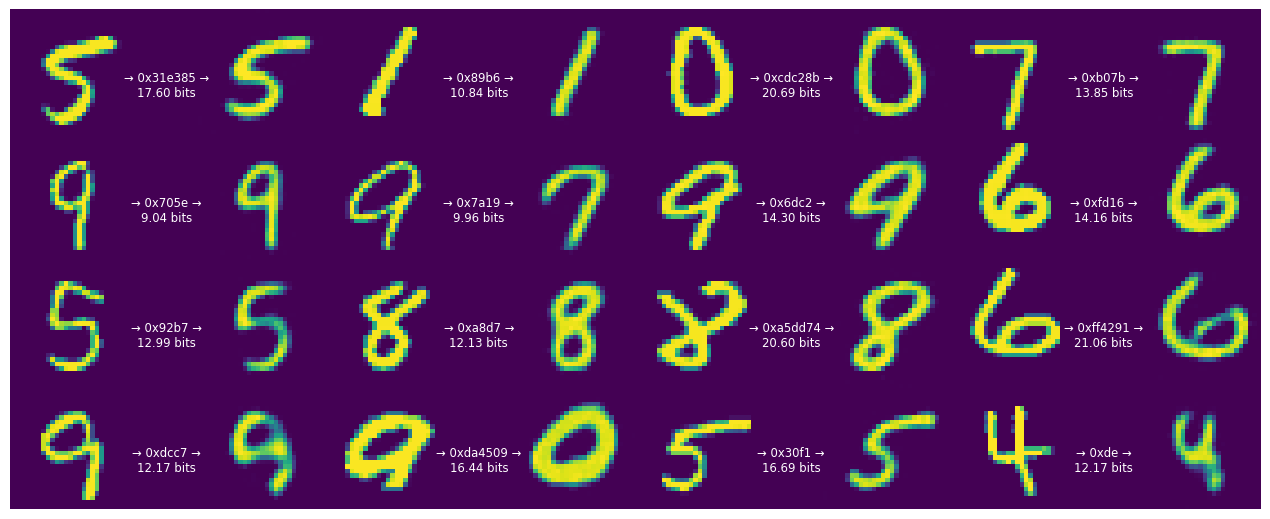

In [25]:
def train_and_visualize_model(lmbda):
  trainer = train_mnist_model(lmbda=lmbda)
  compressor, decompressor = make_mnist_codec(trainer)
  strings, entropies = compressor(originals)
  reconstructions = decompressor(strings)
  display_digits(originals, strings, entropies, reconstructions)

train_and_visualize_model(lmbda=500)


The bit rate of our code goes down, as does the fidelity of the digits. However, most of the digits remain recognizable.

Let's reduce $\lambda$ further.

Epoch 1/15


  1/469 [..............................] - ETA: 15:01 - loss: 139.9957 - distortion_loss: 0.1236 - rate_loss: 102.9241 - distortion_pass_through_loss: 0.1236 - rate_pass_through_loss: 102.9241

  4/469 [..............................] - ETA: 9s - loss: 142.1251 - distortion_loss: 0.1310 - rate_loss: 102.8373 - distortion_pass_through_loss: 0.1310 - rate_pass_through_loss: 102.8373   

  7/469 [..............................] - ETA: 8s - loss: 142.2832 - distortion_loss: 0.1318 - rate_loss: 102.7315 - distortion_pass_through_loss: 0.1318 - rate_pass_through_loss: 102.7315

 10/469 [..............................] - ETA: 8s - loss: 142.2524 - distortion_loss: 0.1321 - rate_loss: 102.6194 - distortion_pass_through_loss: 0.1321 - rate_pass_through_loss: 102.6194

 13/469 [..............................] - ETA: 8s - loss: 141.9859 - distortion_loss: 0.1316 - rate_loss: 102.5146 - distortion_pass_through_loss: 0.1316 - rate_pass_through_loss: 102.5146

 16/469 [>.............................] - ETA: 8s - loss: 141.6736 - distortion_loss: 0.1309 - rate_loss: 102.4127 - distortion_pass_through_loss: 0.1309 - rate_pass_through_loss: 102.4127

 19/469 [>.............................] - ETA: 8s - loss: 141.4770 - distortion_loss: 0.1305 - rate_loss: 102.3124 - distortion_pass_through_loss: 0.1305 - rate_pass_through_loss: 102.3124

 22/469 [>.............................] - ETA: 8s - loss: 141.3393 - distortion_loss: 0.1304 - rate_loss: 102.2147 - distortion_pass_through_loss: 0.1304 - rate_pass_through_loss: 102.2147

 25/469 [>.............................] - ETA: 8s - loss: 141.0191 - distortion_loss: 0.1297 - rate_loss: 102.1213 - distortion_pass_through_loss: 0.1297 - rate_pass_through_loss: 102.1213

 28/469 [>.............................] - ETA: 8s - loss: 140.9085 - distortion_loss: 0.1296 - rate_loss: 102.0273 - distortion_pass_through_loss: 0.1296 - rate_pass_through_loss: 102.0273

 31/469 [>.............................] - ETA: 8s - loss: 140.6437 - distortion_loss: 0.1290 - rate_loss: 101.9387 - distortion_pass_through_loss: 0.1290 - rate_pass_through_loss: 101.9387

 34/469 [=>............................] - ETA: 8s - loss: 140.4138 - distortion_loss: 0.1285 - rate_loss: 101.8577 - distortion_pass_through_loss: 0.1285 - rate_pass_through_loss: 101.8577

 37/469 [=>............................] - ETA: 8s - loss: 140.0891 - distortion_loss: 0.1277 - rate_loss: 101.7748 - distortion_pass_through_loss: 0.1277 - rate_pass_through_loss: 101.7748

 40/469 [=>............................] - ETA: 8s - loss: 139.7921 - distortion_loss: 0.1270 - rate_loss: 101.6818 - distortion_pass_through_loss: 0.1270 - rate_pass_through_loss: 101.6818

 43/469 [=>............................] - ETA: 8s - loss: 139.5836 - distortion_loss: 0.1266 - rate_loss: 101.5934 - distortion_pass_through_loss: 0.1266 - rate_pass_through_loss: 101.5934

 46/469 [=>............................] - ETA: 8s - loss: 139.3447 - distortion_loss: 0.1261 - rate_loss: 101.5051 - distortion_pass_through_loss: 0.1261 - rate_pass_through_loss: 101.5051

 49/469 [==>...........................] - ETA: 8s - loss: 139.1533 - distortion_loss: 0.1258 - rate_loss: 101.4227 - distortion_pass_through_loss: 0.1258 - rate_pass_through_loss: 101.4227

 52/469 [==>...........................] - ETA: 8s - loss: 138.9299 - distortion_loss: 0.1253 - rate_loss: 101.3412 - distortion_pass_through_loss: 0.1253 - rate_pass_through_loss: 101.3412

 55/469 [==>...........................] - ETA: 8s - loss: 138.6712 - distortion_loss: 0.1247 - rate_loss: 101.2666 - distortion_pass_through_loss: 0.1247 - rate_pass_through_loss: 101.2666

 58/469 [==>...........................] - ETA: 7s - loss: 138.4256 - distortion_loss: 0.1241 - rate_loss: 101.1973 - distortion_pass_through_loss: 0.1241 - rate_pass_through_loss: 101.1973

 61/469 [==>...........................] - ETA: 7s - loss: 138.1505 - distortion_loss: 0.1234 - rate_loss: 101.1317 - distortion_pass_through_loss: 0.1234 - rate_pass_through_loss: 101.1317

 64/469 [===>..........................] - ETA: 7s - loss: 137.8988 - distortion_loss: 0.1228 - rate_loss: 101.0627 - distortion_pass_through_loss: 0.1228 - rate_pass_through_loss: 101.0627

 67/469 [===>..........................] - ETA: 7s - loss: 137.6041 - distortion_loss: 0.1220 - rate_loss: 100.9925 - distortion_pass_through_loss: 0.1220 - rate_pass_through_loss: 100.9925

 70/469 [===>..........................] - ETA: 7s - loss: 137.3024 - distortion_loss: 0.1213 - rate_loss: 100.9223 - distortion_pass_through_loss: 0.1213 - rate_pass_through_loss: 100.9223

 73/469 [===>..........................] - ETA: 7s - loss: 136.9606 - distortion_loss: 0.1204 - rate_loss: 100.8529 - distortion_pass_through_loss: 0.1204 - rate_pass_through_loss: 100.8529

 76/469 [===>..........................] - ETA: 7s - loss: 136.6704 - distortion_loss: 0.1196 - rate_loss: 100.7813 - distortion_pass_through_loss: 0.1196 - rate_pass_through_loss: 100.7813

 79/469 [====>.........................] - ETA: 7s - loss: 136.3395 - distortion_loss: 0.1188 - rate_loss: 100.7131 - distortion_pass_through_loss: 0.1188 - rate_pass_through_loss: 100.7131

 82/469 [====>.........................] - ETA: 7s - loss: 136.0220 - distortion_loss: 0.1179 - rate_loss: 100.6463 - distortion_pass_through_loss: 0.1179 - rate_pass_through_loss: 100.6463

 85/469 [====>.........................] - ETA: 7s - loss: 135.6885 - distortion_loss: 0.1170 - rate_loss: 100.5776 - distortion_pass_through_loss: 0.1170 - rate_pass_through_loss: 100.5776

 88/469 [====>.........................] - ETA: 7s - loss: 135.3663 - distortion_loss: 0.1162 - rate_loss: 100.5127 - distortion_pass_through_loss: 0.1162 - rate_pass_through_loss: 100.5127

 91/469 [====>.........................] - ETA: 7s - loss: 135.0257 - distortion_loss: 0.1153 - rate_loss: 100.4466 - distortion_pass_through_loss: 0.1153 - rate_pass_through_loss: 100.4466

 94/469 [=====>........................] - ETA: 7s - loss: 134.7229 - distortion_loss: 0.1145 - rate_loss: 100.3814 - distortion_pass_through_loss: 0.1145 - rate_pass_through_loss: 100.3814

 97/469 [=====>........................] - ETA: 7s - loss: 134.3947 - distortion_loss: 0.1136 - rate_loss: 100.3178 - distortion_pass_through_loss: 0.1136 - rate_pass_through_loss: 100.3178

100/469 [=====>........................] - ETA: 7s - loss: 134.1133 - distortion_loss: 0.1129 - rate_loss: 100.2555 - distortion_pass_through_loss: 0.1129 - rate_pass_through_loss: 100.2555

103/469 [=====>........................] - ETA: 7s - loss: 133.8133 - distortion_loss: 0.1121 - rate_loss: 100.1918 - distortion_pass_through_loss: 0.1121 - rate_pass_through_loss: 100.1918

106/469 [=====>........................] - ETA: 7s - loss: 133.5053 - distortion_loss: 0.1113 - rate_loss: 100.1232 - distortion_pass_through_loss: 0.1113 - rate_pass_through_loss: 100.1232

109/469 [=====>........................] - ETA: 7s - loss: 133.1966 - distortion_loss: 0.1105 - rate_loss: 100.0567 - distortion_pass_through_loss: 0.1105 - rate_pass_through_loss: 100.0567

112/469 [======>.......................] - ETA: 6s - loss: 132.9276 - distortion_loss: 0.1098 - rate_loss: 99.9896 - distortion_pass_through_loss: 0.1098 - rate_pass_through_loss: 99.9896  

115/469 [======>.......................] - ETA: 6s - loss: 132.6694 - distortion_loss: 0.1091 - rate_loss: 99.9254 - distortion_pass_through_loss: 0.1091 - rate_pass_through_loss: 99.9254

118/469 [======>.......................] - ETA: 6s - loss: 132.3795 - distortion_loss: 0.1084 - rate_loss: 99.8573 - distortion_pass_through_loss: 0.1084 - rate_pass_through_loss: 99.8573

121/469 [======>.......................] - ETA: 6s - loss: 132.0998 - distortion_loss: 0.1077 - rate_loss: 99.7880 - distortion_pass_through_loss: 0.1077 - rate_pass_through_loss: 99.7880

124/469 [======>.......................] - ETA: 6s - loss: 131.8273 - distortion_loss: 0.1070 - rate_loss: 99.7203 - distortion_pass_through_loss: 0.1070 - rate_pass_through_loss: 99.7203

127/469 [=======>......................] - ETA: 6s - loss: 131.5513 - distortion_loss: 0.1063 - rate_loss: 99.6534 - distortion_pass_through_loss: 0.1063 - rate_pass_through_loss: 99.6534

130/469 [=======>......................] - ETA: 6s - loss: 131.2836 - distortion_loss: 0.1057 - rate_loss: 99.5825 - distortion_pass_through_loss: 0.1057 - rate_pass_through_loss: 99.5825

133/469 [=======>......................] - ETA: 6s - loss: 131.0134 - distortion_loss: 0.1050 - rate_loss: 99.5137 - distortion_pass_through_loss: 0.1050 - rate_pass_through_loss: 99.5137

136/469 [=======>......................] - ETA: 6s - loss: 130.7630 - distortion_loss: 0.1044 - rate_loss: 99.4478 - distortion_pass_through_loss: 0.1044 - rate_pass_through_loss: 99.4478

139/469 [=======>......................] - ETA: 6s - loss: 130.5216 - distortion_loss: 0.1038 - rate_loss: 99.3791 - distortion_pass_through_loss: 0.1038 - rate_pass_through_loss: 99.3791

142/469 [========>.....................] - ETA: 6s - loss: 130.2751 - distortion_loss: 0.1032 - rate_loss: 99.3103 - distortion_pass_through_loss: 0.1032 - rate_pass_through_loss: 99.3103

145/469 [========>.....................] - ETA: 6s - loss: 130.0382 - distortion_loss: 0.1027 - rate_loss: 99.2415 - distortion_pass_through_loss: 0.1027 - rate_pass_through_loss: 99.2415

148/469 [========>.....................] - ETA: 6s - loss: 129.8017 - distortion_loss: 0.1021 - rate_loss: 99.1697 - distortion_pass_through_loss: 0.1021 - rate_pass_through_loss: 99.1697

151/469 [========>.....................] - ETA: 6s - loss: 129.5736 - distortion_loss: 0.1016 - rate_loss: 99.0999 - distortion_pass_through_loss: 0.1016 - rate_pass_through_loss: 99.0999

154/469 [========>.....................] - ETA: 6s - loss: 129.3585 - distortion_loss: 0.1011 - rate_loss: 99.0314 - distortion_pass_through_loss: 0.1011 - rate_pass_through_loss: 99.0314

157/469 [=========>....................] - ETA: 6s - loss: 129.1402 - distortion_loss: 0.1006 - rate_loss: 98.9634 - distortion_pass_through_loss: 0.1006 - rate_pass_through_loss: 98.9634

160/469 [=========>....................] - ETA: 6s - loss: 128.9263 - distortion_loss: 0.1001 - rate_loss: 98.8958 - distortion_pass_through_loss: 0.1001 - rate_pass_through_loss: 98.8958

163/469 [=========>....................] - ETA: 5s - loss: 128.7006 - distortion_loss: 0.0996 - rate_loss: 98.8233 - distortion_pass_through_loss: 0.0996 - rate_pass_through_loss: 98.8233

166/469 [=========>....................] - ETA: 5s - loss: 128.4869 - distortion_loss: 0.0991 - rate_loss: 98.7524 - distortion_pass_through_loss: 0.0991 - rate_pass_through_loss: 98.7524

169/469 [=========>....................] - ETA: 5s - loss: 128.2805 - distortion_loss: 0.0987 - rate_loss: 98.6833 - distortion_pass_through_loss: 0.0987 - rate_pass_through_loss: 98.6833

172/469 [==========>...................] - ETA: 5s - loss: 128.0680 - distortion_loss: 0.0982 - rate_loss: 98.6121 - distortion_pass_through_loss: 0.0982 - rate_pass_through_loss: 98.6121

175/469 [==========>...................] - ETA: 5s - loss: 127.8704 - distortion_loss: 0.0978 - rate_loss: 98.5416 - distortion_pass_through_loss: 0.0978 - rate_pass_through_loss: 98.5416

178/469 [==========>...................] - ETA: 5s - loss: 127.6681 - distortion_loss: 0.0973 - rate_loss: 98.4697 - distortion_pass_through_loss: 0.0973 - rate_pass_through_loss: 98.4697

181/469 [==========>...................] - ETA: 5s - loss: 127.4773 - distortion_loss: 0.0969 - rate_loss: 98.3983 - distortion_pass_through_loss: 0.0969 - rate_pass_through_loss: 98.3983

184/469 [==========>...................] - ETA: 5s - loss: 127.2837 - distortion_loss: 0.0965 - rate_loss: 98.3286 - distortion_pass_through_loss: 0.0965 - rate_pass_through_loss: 98.3286

187/469 [==========>...................] - ETA: 5s - loss: 127.0858 - distortion_loss: 0.0961 - rate_loss: 98.2551 - distortion_pass_through_loss: 0.0961 - rate_pass_through_loss: 98.2551

190/469 [===========>..................] - ETA: 5s - loss: 126.8976 - distortion_loss: 0.0957 - rate_loss: 98.1828 - distortion_pass_through_loss: 0.0957 - rate_pass_through_loss: 98.1828

193/469 [===========>..................] - ETA: 5s - loss: 126.7094 - distortion_loss: 0.0953 - rate_loss: 98.1125 - distortion_pass_through_loss: 0.0953 - rate_pass_through_loss: 98.1125

196/469 [===========>..................] - ETA: 5s - loss: 126.5227 - distortion_loss: 0.0949 - rate_loss: 98.0381 - distortion_pass_through_loss: 0.0949 - rate_pass_through_loss: 98.0381

199/469 [===========>..................] - ETA: 5s - loss: 126.3271 - distortion_loss: 0.0945 - rate_loss: 97.9656 - distortion_pass_through_loss: 0.0945 - rate_pass_through_loss: 97.9656

202/469 [===========>..................] - ETA: 5s - loss: 126.1369 - distortion_loss: 0.0942 - rate_loss: 97.8897 - distortion_pass_through_loss: 0.0942 - rate_pass_through_loss: 97.8897

205/469 [============>.................] - ETA: 5s - loss: 125.9504 - distortion_loss: 0.0938 - rate_loss: 97.8170 - distortion_pass_through_loss: 0.0938 - rate_pass_through_loss: 97.8170

208/469 [============>.................] - ETA: 5s - loss: 125.7639 - distortion_loss: 0.0934 - rate_loss: 97.7431 - distortion_pass_through_loss: 0.0934 - rate_pass_through_loss: 97.7431

211/469 [============>.................] - ETA: 5s - loss: 125.5746 - distortion_loss: 0.0930 - rate_loss: 97.6685 - distortion_pass_through_loss: 0.0930 - rate_pass_through_loss: 97.6685

214/469 [============>.................] - ETA: 4s - loss: 125.3966 - distortion_loss: 0.0927 - rate_loss: 97.5965 - distortion_pass_through_loss: 0.0927 - rate_pass_through_loss: 97.5965

217/469 [============>.................] - ETA: 4s - loss: 125.2157 - distortion_loss: 0.0923 - rate_loss: 97.5218 - distortion_pass_through_loss: 0.0923 - rate_pass_through_loss: 97.5218

220/469 [=============>................] - ETA: 4s - loss: 125.0410 - distortion_loss: 0.0920 - rate_loss: 97.4468 - distortion_pass_through_loss: 0.0920 - rate_pass_through_loss: 97.4468

223/469 [=============>................] - ETA: 4s - loss: 124.8671 - distortion_loss: 0.0916 - rate_loss: 97.3725 - distortion_pass_through_loss: 0.0916 - rate_pass_through_loss: 97.3725

226/469 [=============>................] - ETA: 4s - loss: 124.6903 - distortion_loss: 0.0913 - rate_loss: 97.2965 - distortion_pass_through_loss: 0.0913 - rate_pass_through_loss: 97.2965

229/469 [=============>................] - ETA: 4s - loss: 124.5258 - distortion_loss: 0.0910 - rate_loss: 97.2221 - distortion_pass_through_loss: 0.0910 - rate_pass_through_loss: 97.2221

232/469 [=============>................] - ETA: 4s - loss: 124.3636 - distortion_loss: 0.0907 - rate_loss: 97.1487 - distortion_pass_through_loss: 0.0907 - rate_pass_through_loss: 97.1487

235/469 [==============>...............] - ETA: 4s - loss: 124.1945 - distortion_loss: 0.0904 - rate_loss: 97.0737 - distortion_pass_through_loss: 0.0904 - rate_pass_through_loss: 97.0737

238/469 [==============>...............] - ETA: 4s - loss: 124.0272 - distortion_loss: 0.0901 - rate_loss: 96.9990 - distortion_pass_through_loss: 0.0901 - rate_pass_through_loss: 96.9990

241/469 [==============>...............] - ETA: 4s - loss: 123.8648 - distortion_loss: 0.0898 - rate_loss: 96.9230 - distortion_pass_through_loss: 0.0898 - rate_pass_through_loss: 96.9230

244/469 [==============>...............] - ETA: 4s - loss: 123.6969 - distortion_loss: 0.0895 - rate_loss: 96.8463 - distortion_pass_through_loss: 0.0895 - rate_pass_through_loss: 96.8463

247/469 [==============>...............] - ETA: 4s - loss: 123.5458 - distortion_loss: 0.0893 - rate_loss: 96.7705 - distortion_pass_through_loss: 0.0893 - rate_pass_through_loss: 96.7705

250/469 [==============>...............] - ETA: 4s - loss: 123.3894 - distortion_loss: 0.0890 - rate_loss: 96.6942 - distortion_pass_through_loss: 0.0890 - rate_pass_through_loss: 96.6942

253/469 [===============>..............] - ETA: 4s - loss: 123.2315 - distortion_loss: 0.0887 - rate_loss: 96.6189 - distortion_pass_through_loss: 0.0887 - rate_pass_through_loss: 96.6189

256/469 [===============>..............] - ETA: 4s - loss: 123.0726 - distortion_loss: 0.0884 - rate_loss: 96.5409 - distortion_pass_through_loss: 0.0884 - rate_pass_through_loss: 96.5409

259/469 [===============>..............] - ETA: 4s - loss: 122.9175 - distortion_loss: 0.0882 - rate_loss: 96.4657 - distortion_pass_through_loss: 0.0882 - rate_pass_through_loss: 96.4657

262/469 [===============>..............] - ETA: 4s - loss: 122.7612 - distortion_loss: 0.0879 - rate_loss: 96.3900 - distortion_pass_through_loss: 0.0879 - rate_pass_through_loss: 96.3900

265/469 [===============>..............] - ETA: 3s - loss: 122.6048 - distortion_loss: 0.0876 - rate_loss: 96.3120 - distortion_pass_through_loss: 0.0876 - rate_pass_through_loss: 96.3120

268/469 [================>.............] - ETA: 3s - loss: 122.4517 - distortion_loss: 0.0874 - rate_loss: 96.2357 - distortion_pass_through_loss: 0.0874 - rate_pass_through_loss: 96.2357

271/469 [================>.............] - ETA: 3s - loss: 122.3045 - distortion_loss: 0.0871 - rate_loss: 96.1597 - distortion_pass_through_loss: 0.0871 - rate_pass_through_loss: 96.1597

274/469 [================>.............] - ETA: 3s - loss: 122.1577 - distortion_loss: 0.0869 - rate_loss: 96.0809 - distortion_pass_through_loss: 0.0869 - rate_pass_through_loss: 96.0809

277/469 [================>.............] - ETA: 3s - loss: 122.0094 - distortion_loss: 0.0867 - rate_loss: 96.0046 - distortion_pass_through_loss: 0.0867 - rate_pass_through_loss: 96.0046

280/469 [================>.............] - ETA: 3s - loss: 121.8578 - distortion_loss: 0.0864 - rate_loss: 95.9276 - distortion_pass_through_loss: 0.0864 - rate_pass_through_loss: 95.9276

283/469 [=================>............] - ETA: 3s - loss: 121.7199 - distortion_loss: 0.0862 - rate_loss: 95.8520 - distortion_pass_through_loss: 0.0862 - rate_pass_through_loss: 95.8520

286/469 [=================>............] - ETA: 3s - loss: 121.5777 - distortion_loss: 0.0860 - rate_loss: 95.7753 - distortion_pass_through_loss: 0.0860 - rate_pass_through_loss: 95.7753

289/469 [=================>............] - ETA: 3s - loss: 121.4349 - distortion_loss: 0.0858 - rate_loss: 95.6994 - distortion_pass_through_loss: 0.0858 - rate_pass_through_loss: 95.6994

292/469 [=================>............] - ETA: 3s - loss: 121.2871 - distortion_loss: 0.0856 - rate_loss: 95.6213 - distortion_pass_through_loss: 0.0856 - rate_pass_through_loss: 95.6213

295/469 [=================>............] - ETA: 3s - loss: 121.1408 - distortion_loss: 0.0853 - rate_loss: 95.5434 - distortion_pass_through_loss: 0.0853 - rate_pass_through_loss: 95.5434

298/469 [==================>...........] - ETA: 3s - loss: 120.9948 - distortion_loss: 0.0851 - rate_loss: 95.4660 - distortion_pass_through_loss: 0.0851 - rate_pass_through_loss: 95.4660

301/469 [==================>...........] - ETA: 3s - loss: 120.8591 - distortion_loss: 0.0849 - rate_loss: 95.3892 - distortion_pass_through_loss: 0.0849 - rate_pass_through_loss: 95.3892

304/469 [==================>...........] - ETA: 3s - loss: 120.7163 - distortion_loss: 0.0847 - rate_loss: 95.3102 - distortion_pass_through_loss: 0.0847 - rate_pass_through_loss: 95.3102

307/469 [==================>...........] - ETA: 3s - loss: 120.5806 - distortion_loss: 0.0845 - rate_loss: 95.2338 - distortion_pass_through_loss: 0.0845 - rate_pass_through_loss: 95.2338

310/469 [==================>...........] - ETA: 3s - loss: 120.4451 - distortion_loss: 0.0843 - rate_loss: 95.1555 - distortion_pass_through_loss: 0.0843 - rate_pass_through_loss: 95.1555

313/469 [===================>..........] - ETA: 3s - loss: 120.3085 - distortion_loss: 0.0841 - rate_loss: 95.0782 - distortion_pass_through_loss: 0.0841 - rate_pass_through_loss: 95.0782

316/469 [===================>..........] - ETA: 2s - loss: 120.1726 - distortion_loss: 0.0839 - rate_loss: 94.9999 - distortion_pass_through_loss: 0.0839 - rate_pass_through_loss: 94.9999

319/469 [===================>..........] - ETA: 2s - loss: 120.0376 - distortion_loss: 0.0837 - rate_loss: 94.9223 - distortion_pass_through_loss: 0.0837 - rate_pass_through_loss: 94.9223

322/469 [===================>..........] - ETA: 2s - loss: 119.9055 - distortion_loss: 0.0835 - rate_loss: 94.8434 - distortion_pass_through_loss: 0.0835 - rate_pass_through_loss: 94.8434

325/469 [===================>..........] - ETA: 2s - loss: 119.7700 - distortion_loss: 0.0833 - rate_loss: 94.7660 - distortion_pass_through_loss: 0.0833 - rate_pass_through_loss: 94.7660

328/469 [===================>..........] - ETA: 2s - loss: 119.6378 - distortion_loss: 0.0832 - rate_loss: 94.6885 - distortion_pass_through_loss: 0.0832 - rate_pass_through_loss: 94.6885

331/469 [====================>.........] - ETA: 2s - loss: 119.5070 - distortion_loss: 0.0830 - rate_loss: 94.6103 - distortion_pass_through_loss: 0.0830 - rate_pass_through_loss: 94.6103

334/469 [====================>.........] - ETA: 2s - loss: 119.3784 - distortion_loss: 0.0828 - rate_loss: 94.5328 - distortion_pass_through_loss: 0.0828 - rate_pass_through_loss: 94.5328

337/469 [====================>.........] - ETA: 2s - loss: 119.2481 - distortion_loss: 0.0826 - rate_loss: 94.4540 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 94.4540

340/469 [====================>.........] - ETA: 2s - loss: 119.1173 - distortion_loss: 0.0825 - rate_loss: 94.3757 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 94.3757

343/469 [====================>.........] - ETA: 2s - loss: 118.9871 - distortion_loss: 0.0823 - rate_loss: 94.2973 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 94.2973

346/469 [=====================>........] - ETA: 2s - loss: 118.8547 - distortion_loss: 0.0821 - rate_loss: 94.2174 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 94.2174

349/469 [=====================>........] - ETA: 2s - loss: 118.7306 - distortion_loss: 0.0820 - rate_loss: 94.1399 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 94.1399

352/469 [=====================>........] - ETA: 2s - loss: 118.6064 - distortion_loss: 0.0818 - rate_loss: 94.0603 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 94.0603

355/469 [=====================>........] - ETA: 2s - loss: 118.4787 - distortion_loss: 0.0817 - rate_loss: 93.9834 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 93.9834

358/469 [=====================>........] - ETA: 2s - loss: 118.3507 - distortion_loss: 0.0815 - rate_loss: 93.9048 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 93.9048

361/469 [======================>.......] - ETA: 2s - loss: 118.2283 - distortion_loss: 0.0813 - rate_loss: 93.8263 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 93.8263

364/469 [======================>.......] - ETA: 2s - loss: 118.1069 - distortion_loss: 0.0812 - rate_loss: 93.7493 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 93.7493

367/469 [======================>.......] - ETA: 1s - loss: 117.9833 - distortion_loss: 0.0810 - rate_loss: 93.6698 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 93.6698

370/469 [======================>.......] - ETA: 1s - loss: 117.8597 - distortion_loss: 0.0809 - rate_loss: 93.5899 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 93.5899

373/469 [======================>.......] - ETA: 1s - loss: 117.7368 - distortion_loss: 0.0808 - rate_loss: 93.5116 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 93.5116

376/469 [=======================>......] - ETA: 1s - loss: 117.6118 - distortion_loss: 0.0806 - rate_loss: 93.4315 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 93.4315

379/469 [=======================>......] - ETA: 1s - loss: 117.4892 - distortion_loss: 0.0805 - rate_loss: 93.3540 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 93.3540

382/469 [=======================>......] - ETA: 1s - loss: 117.3663 - distortion_loss: 0.0803 - rate_loss: 93.2747 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 93.2747

385/469 [=======================>......] - ETA: 1s - loss: 117.2419 - distortion_loss: 0.0802 - rate_loss: 93.1959 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 93.1959

388/469 [=======================>......] - ETA: 1s - loss: 117.1247 - distortion_loss: 0.0800 - rate_loss: 93.1164 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 93.1164

391/469 [========================>.....] - ETA: 1s - loss: 117.0026 - distortion_loss: 0.0799 - rate_loss: 93.0370 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 93.0370

394/469 [========================>.....] - ETA: 1s - loss: 116.8830 - distortion_loss: 0.0797 - rate_loss: 92.9592 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 92.9592

397/469 [========================>.....] - ETA: 1s - loss: 116.7644 - distortion_loss: 0.0796 - rate_loss: 92.8796 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 92.8796

400/469 [========================>.....] - ETA: 1s - loss: 116.6444 - distortion_loss: 0.0795 - rate_loss: 92.8006 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 92.8006

403/469 [========================>.....] - ETA: 1s - loss: 116.5209 - distortion_loss: 0.0793 - rate_loss: 92.7212 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 92.7212

406/469 [========================>.....] - ETA: 1s - loss: 116.4033 - distortion_loss: 0.0792 - rate_loss: 92.6419 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 92.6419

409/469 [=========================>....] - ETA: 1s - loss: 116.2846 - distortion_loss: 0.0791 - rate_loss: 92.5641 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 92.5641

412/469 [=========================>....] - ETA: 1s - loss: 116.1711 - distortion_loss: 0.0790 - rate_loss: 92.4847 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 92.4847

415/469 [=========================>....] - ETA: 1s - loss: 116.0553 - distortion_loss: 0.0788 - rate_loss: 92.4062 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 92.4062

418/469 [=========================>....] - ETA: 0s - loss: 115.9380 - distortion_loss: 0.0787 - rate_loss: 92.3267 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 92.3267

421/469 [=========================>....] - ETA: 0s - loss: 115.8210 - distortion_loss: 0.0786 - rate_loss: 92.2467 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 92.2467

424/469 [==========================>...] - ETA: 0s - loss: 115.7053 - distortion_loss: 0.0785 - rate_loss: 92.1683 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 92.1683

427/469 [==========================>...] - ETA: 0s - loss: 115.5936 - distortion_loss: 0.0783 - rate_loss: 92.0897 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 92.0897

430/469 [==========================>...] - ETA: 0s - loss: 115.4822 - distortion_loss: 0.0782 - rate_loss: 92.0107 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 92.0107

433/469 [==========================>...] - ETA: 0s - loss: 115.3672 - distortion_loss: 0.0781 - rate_loss: 91.9315 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 91.9315

436/469 [==========================>...] - ETA: 0s - loss: 115.2523 - distortion_loss: 0.0780 - rate_loss: 91.8526 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 91.8526

439/469 [===========================>..] - ETA: 0s - loss: 115.1384 - distortion_loss: 0.0779 - rate_loss: 91.7739 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 91.7739

442/469 [===========================>..] - ETA: 0s - loss: 115.0275 - distortion_loss: 0.0778 - rate_loss: 91.6957 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 91.6957

445/469 [===========================>..] - ETA: 0s - loss: 114.9138 - distortion_loss: 0.0777 - rate_loss: 91.6160 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 91.6160

448/469 [===========================>..] - ETA: 0s - loss: 114.8050 - distortion_loss: 0.0776 - rate_loss: 91.5369 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 91.5369

451/469 [===========================>..] - ETA: 0s - loss: 114.6915 - distortion_loss: 0.0774 - rate_loss: 91.4573 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 91.4573

454/469 [============================>.] - ETA: 0s - loss: 114.5786 - distortion_loss: 0.0773 - rate_loss: 91.3791 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 91.3791

457/469 [============================>.] - ETA: 0s - loss: 114.4686 - distortion_loss: 0.0772 - rate_loss: 91.3008 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 91.3008

460/469 [============================>.] - ETA: 0s - loss: 114.3589 - distortion_loss: 0.0771 - rate_loss: 91.2222 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 91.2222

463/469 [============================>.] - ETA: 0s - loss: 114.2499 - distortion_loss: 0.0770 - rate_loss: 91.1433 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 91.1433

466/469 [============================>.] - ETA: 0s - loss: 114.1426 - distortion_loss: 0.0769 - rate_loss: 91.0649 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 91.0649

469/469 [==============================] - ETA: 0s - loss: 114.0398 - distortion_loss: 0.0768 - rate_loss: 90.9927 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 90.9862

469/469 [==============================] - 12s 21ms/step - loss: 114.0398 - distortion_loss: 0.0768 - rate_loss: 90.9927 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 90.9862 - val_loss: 96.7790 - val_distortion_loss: 0.0688 - val_rate_loss: 76.1469 - val_distortion_pass_through_loss: 0.0688 - val_rate_pass_through_loss: 76.1451


Epoch 2/15


  1/469 [..............................] - ETA: 11s - loss: 95.6817 - distortion_loss: 0.0575 - rate_loss: 78.4188 - distortion_pass_through_loss: 0.0575 - rate_pass_through_loss: 78.4188

  4/469 [..............................] - ETA: 8s - loss: 96.5567 - distortion_loss: 0.0601 - rate_loss: 78.5255 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 78.5255 

  7/469 [..............................] - ETA: 8s - loss: 96.7796 - distortion_loss: 0.0611 - rate_loss: 78.4523 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 78.4523

 10/469 [..............................] - ETA: 8s - loss: 96.9007 - distortion_loss: 0.0616 - rate_loss: 78.4248 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 78.4248

 13/469 [..............................] - ETA: 8s - loss: 96.7321 - distortion_loss: 0.0613 - rate_loss: 78.3409 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 78.3409

 16/469 [>.............................] - ETA: 8s - loss: 96.5987 - distortion_loss: 0.0611 - rate_loss: 78.2700 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 78.2700

 19/469 [>.............................] - ETA: 8s - loss: 96.5249 - distortion_loss: 0.0611 - rate_loss: 78.1836 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 78.1836

 22/469 [>.............................] - ETA: 8s - loss: 96.5288 - distortion_loss: 0.0614 - rate_loss: 78.1205 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 78.1205

 25/469 [>.............................] - ETA: 8s - loss: 96.4240 - distortion_loss: 0.0614 - rate_loss: 78.0176 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 78.0176

 28/469 [>.............................] - ETA: 8s - loss: 96.4088 - distortion_loss: 0.0615 - rate_loss: 77.9525 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 77.9525

 31/469 [>.............................] - ETA: 8s - loss: 96.2899 - distortion_loss: 0.0613 - rate_loss: 77.8934 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 77.8934

 34/469 [=>............................] - ETA: 8s - loss: 96.2336 - distortion_loss: 0.0614 - rate_loss: 77.8006 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 77.8006

 37/469 [=>............................] - ETA: 8s - loss: 96.1026 - distortion_loss: 0.0613 - rate_loss: 77.7244 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 77.7244

 40/469 [=>............................] - ETA: 8s - loss: 96.0073 - distortion_loss: 0.0612 - rate_loss: 77.6328 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 77.6328

 43/469 [=>............................] - ETA: 8s - loss: 95.9221 - distortion_loss: 0.0612 - rate_loss: 77.5494 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 77.5494

 46/469 [=>............................] - ETA: 8s - loss: 95.8266 - distortion_loss: 0.0612 - rate_loss: 77.4814 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 77.4814

 49/469 [==>...........................] - ETA: 8s - loss: 95.7739 - distortion_loss: 0.0613 - rate_loss: 77.3980 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 77.3980

 52/469 [==>...........................] - ETA: 8s - loss: 95.7234 - distortion_loss: 0.0613 - rate_loss: 77.3343 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 77.3343

 55/469 [==>...........................] - ETA: 7s - loss: 95.6316 - distortion_loss: 0.0612 - rate_loss: 77.2592 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 77.2592

 58/469 [==>...........................] - ETA: 7s - loss: 95.5642 - distortion_loss: 0.0613 - rate_loss: 77.1730 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 77.1730

 61/469 [==>...........................] - ETA: 7s - loss: 95.4943 - distortion_loss: 0.0613 - rate_loss: 77.0940 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 77.0940

 64/469 [===>..........................] - ETA: 7s - loss: 95.4445 - distortion_loss: 0.0614 - rate_loss: 77.0234 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 77.0234

 67/469 [===>..........................] - ETA: 7s - loss: 95.3804 - distortion_loss: 0.0614 - rate_loss: 76.9493 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 76.9493

 70/469 [===>..........................] - ETA: 7s - loss: 95.3003 - distortion_loss: 0.0614 - rate_loss: 76.8710 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 76.8710

 73/469 [===>..........................] - ETA: 7s - loss: 95.2009 - distortion_loss: 0.0614 - rate_loss: 76.7924 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 76.7924

 76/469 [===>..........................] - ETA: 7s - loss: 95.1227 - distortion_loss: 0.0613 - rate_loss: 76.7203 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 76.7203

 79/469 [====>.........................] - ETA: 7s - loss: 95.0405 - distortion_loss: 0.0613 - rate_loss: 76.6414 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 76.6414

 82/469 [====>.........................] - ETA: 7s - loss: 94.9649 - distortion_loss: 0.0613 - rate_loss: 76.5694 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 76.5694

 85/469 [====>.........................] - ETA: 7s - loss: 94.8726 - distortion_loss: 0.0613 - rate_loss: 76.4949 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 76.4949

 88/469 [====>.........................] - ETA: 7s - loss: 94.7955 - distortion_loss: 0.0612 - rate_loss: 76.4215 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 76.4215

 91/469 [====>.........................] - ETA: 7s - loss: 94.6970 - distortion_loss: 0.0612 - rate_loss: 76.3402 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 76.3402

 94/469 [=====>........................] - ETA: 7s - loss: 94.6192 - distortion_loss: 0.0612 - rate_loss: 76.2641 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 76.2641

 97/469 [=====>........................] - ETA: 7s - loss: 94.5219 - distortion_loss: 0.0611 - rate_loss: 76.1866 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 76.1866

100/469 [=====>........................] - ETA: 7s - loss: 94.4516 - distortion_loss: 0.0611 - rate_loss: 76.1164 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 76.1164

103/469 [=====>........................] - ETA: 7s - loss: 94.3700 - distortion_loss: 0.0611 - rate_loss: 76.0378 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 76.0378

106/469 [=====>........................] - ETA: 7s - loss: 94.2749 - distortion_loss: 0.0611 - rate_loss: 75.9593 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 75.9593

109/469 [=====>........................] - ETA: 6s - loss: 94.1845 - distortion_loss: 0.0610 - rate_loss: 75.8829 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 75.8829

112/469 [======>.......................] - ETA: 6s - loss: 94.1108 - distortion_loss: 0.0610 - rate_loss: 75.8071 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 75.8071

115/469 [======>.......................] - ETA: 6s - loss: 94.0537 - distortion_loss: 0.0611 - rate_loss: 75.7359 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 75.7359

118/469 [======>.......................] - ETA: 6s - loss: 93.9628 - distortion_loss: 0.0610 - rate_loss: 75.6605 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 75.6605

121/469 [======>.......................] - ETA: 6s - loss: 93.8790 - distortion_loss: 0.0610 - rate_loss: 75.5850 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 75.5850

124/469 [======>.......................] - ETA: 6s - loss: 93.7937 - distortion_loss: 0.0609 - rate_loss: 75.5088 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 75.5088

127/469 [=======>......................] - ETA: 6s - loss: 93.7099 - distortion_loss: 0.0609 - rate_loss: 75.4329 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 75.4329

130/469 [=======>......................] - ETA: 6s - loss: 93.6253 - distortion_loss: 0.0609 - rate_loss: 75.3544 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 75.3544

133/469 [=======>......................] - ETA: 6s - loss: 93.5362 - distortion_loss: 0.0609 - rate_loss: 75.2787 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 75.2787

136/469 [=======>......................] - ETA: 6s - loss: 93.4590 - distortion_loss: 0.0608 - rate_loss: 75.2042 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 75.2042

139/469 [=======>......................] - ETA: 6s - loss: 93.3866 - distortion_loss: 0.0609 - rate_loss: 75.1294 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 75.1294

142/469 [========>.....................] - ETA: 6s - loss: 93.3105 - distortion_loss: 0.0609 - rate_loss: 75.0553 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 75.0553

145/469 [========>.....................] - ETA: 6s - loss: 93.2351 - distortion_loss: 0.0608 - rate_loss: 74.9853 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 74.9853

148/469 [========>.....................] - ETA: 6s - loss: 93.1592 - distortion_loss: 0.0608 - rate_loss: 74.9110 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 74.9110

151/469 [========>.....................] - ETA: 6s - loss: 93.0831 - distortion_loss: 0.0608 - rate_loss: 74.8332 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 74.8332

154/469 [========>.....................] - ETA: 6s - loss: 93.0205 - distortion_loss: 0.0609 - rate_loss: 74.7611 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 74.7611

157/469 [=========>....................] - ETA: 6s - loss: 92.9454 - distortion_loss: 0.0609 - rate_loss: 74.6861 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 74.6861

160/469 [=========>....................] - ETA: 5s - loss: 92.8792 - distortion_loss: 0.0609 - rate_loss: 74.6116 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 74.6116

163/469 [=========>....................] - ETA: 5s - loss: 92.8023 - distortion_loss: 0.0609 - rate_loss: 74.5378 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 74.5378

166/469 [=========>....................] - ETA: 5s - loss: 92.7331 - distortion_loss: 0.0609 - rate_loss: 74.4617 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 74.4617

169/469 [=========>....................] - ETA: 5s - loss: 92.6672 - distortion_loss: 0.0609 - rate_loss: 74.3888 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 74.3888

172/469 [==========>...................] - ETA: 5s - loss: 92.5918 - distortion_loss: 0.0609 - rate_loss: 74.3160 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 74.3160

175/469 [==========>...................] - ETA: 5s - loss: 92.5288 - distortion_loss: 0.0610 - rate_loss: 74.2429 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 74.2429

178/469 [==========>...................] - ETA: 5s - loss: 92.4552 - distortion_loss: 0.0610 - rate_loss: 74.1674 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 74.1674

181/469 [==========>...................] - ETA: 5s - loss: 92.3877 - distortion_loss: 0.0610 - rate_loss: 74.0983 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 74.0983

184/469 [==========>...................] - ETA: 5s - loss: 92.3199 - distortion_loss: 0.0610 - rate_loss: 74.0257 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 74.0257

187/469 [==========>...................] - ETA: 5s - loss: 92.2413 - distortion_loss: 0.0610 - rate_loss: 73.9516 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 73.9516

190/469 [===========>..................] - ETA: 5s - loss: 92.1762 - distortion_loss: 0.0610 - rate_loss: 73.8781 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 73.8781

193/469 [===========>..................] - ETA: 5s - loss: 92.1068 - distortion_loss: 0.0610 - rate_loss: 73.8054 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 73.8054

196/469 [===========>..................] - ETA: 5s - loss: 92.0348 - distortion_loss: 0.0610 - rate_loss: 73.7323 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 73.7323

199/469 [===========>..................] - ETA: 5s - loss: 91.9583 - distortion_loss: 0.0610 - rate_loss: 73.6588 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 73.6588

202/469 [===========>..................] - ETA: 5s - loss: 91.8797 - distortion_loss: 0.0610 - rate_loss: 73.5867 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 73.5867

205/469 [============>.................] - ETA: 5s - loss: 91.8075 - distortion_loss: 0.0610 - rate_loss: 73.5168 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 73.5168

208/469 [============>.................] - ETA: 5s - loss: 91.7300 - distortion_loss: 0.0609 - rate_loss: 73.4466 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 73.4466

211/469 [============>.................] - ETA: 4s - loss: 91.6521 - distortion_loss: 0.0609 - rate_loss: 73.3691 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 73.3691

214/469 [============>.................] - ETA: 4s - loss: 91.5780 - distortion_loss: 0.0609 - rate_loss: 73.2945 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 73.2945

217/469 [============>.................] - ETA: 4s - loss: 91.5021 - distortion_loss: 0.0609 - rate_loss: 73.2229 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 73.2229

220/469 [=============>................] - ETA: 4s - loss: 91.4297 - distortion_loss: 0.0609 - rate_loss: 73.1543 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 73.1543

223/469 [=============>................] - ETA: 4s - loss: 91.3575 - distortion_loss: 0.0609 - rate_loss: 73.0839 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 73.0839

226/469 [=============>................] - ETA: 4s - loss: 91.2785 - distortion_loss: 0.0609 - rate_loss: 73.0099 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 73.0099

229/469 [=============>................] - ETA: 4s - loss: 91.2090 - distortion_loss: 0.0609 - rate_loss: 72.9360 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 72.9360

232/469 [=============>................] - ETA: 4s - loss: 91.1406 - distortion_loss: 0.0609 - rate_loss: 72.8650 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 72.8650

235/469 [==============>...............] - ETA: 4s - loss: 91.0687 - distortion_loss: 0.0609 - rate_loss: 72.7935 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 72.7935

238/469 [==============>...............] - ETA: 4s - loss: 90.9978 - distortion_loss: 0.0609 - rate_loss: 72.7250 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 72.7250

241/469 [==============>...............] - ETA: 4s - loss: 90.9245 - distortion_loss: 0.0609 - rate_loss: 72.6529 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 72.6529

244/469 [==============>...............] - ETA: 4s - loss: 90.8491 - distortion_loss: 0.0609 - rate_loss: 72.5793 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 72.5793

247/469 [==============>...............] - ETA: 4s - loss: 90.7858 - distortion_loss: 0.0609 - rate_loss: 72.5090 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 72.5090

250/469 [==============>...............] - ETA: 4s - loss: 90.7171 - distortion_loss: 0.0609 - rate_loss: 72.4388 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 72.4388

253/469 [===============>..............] - ETA: 4s - loss: 90.6445 - distortion_loss: 0.0609 - rate_loss: 72.3660 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 72.3660

256/469 [===============>..............] - ETA: 4s - loss: 90.5712 - distortion_loss: 0.0609 - rate_loss: 72.2960 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 72.2960

259/469 [===============>..............] - ETA: 4s - loss: 90.5029 - distortion_loss: 0.0609 - rate_loss: 72.2212 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 72.2212

262/469 [===============>..............] - ETA: 3s - loss: 90.4314 - distortion_loss: 0.0609 - rate_loss: 72.1523 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 72.1523

265/469 [===============>..............] - ETA: 3s - loss: 90.3608 - distortion_loss: 0.0609 - rate_loss: 72.0815 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 72.0815

268/469 [================>.............] - ETA: 3s - loss: 90.2876 - distortion_loss: 0.0609 - rate_loss: 72.0085 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 72.0085

271/469 [================>.............] - ETA: 3s - loss: 90.2207 - distortion_loss: 0.0609 - rate_loss: 71.9392 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 71.9392

274/469 [================>.............] - ETA: 3s - loss: 90.1550 - distortion_loss: 0.0610 - rate_loss: 71.8685 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 71.8685

277/469 [================>.............] - ETA: 3s - loss: 90.0846 - distortion_loss: 0.0609 - rate_loss: 71.8009 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 71.8009

280/469 [================>.............] - ETA: 3s - loss: 90.0110 - distortion_loss: 0.0609 - rate_loss: 71.7307 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 71.7307

283/469 [=================>............] - ETA: 3s - loss: 89.9503 - distortion_loss: 0.0610 - rate_loss: 71.6618 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 71.6618

286/469 [=================>............] - ETA: 3s - loss: 89.8838 - distortion_loss: 0.0610 - rate_loss: 71.5939 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 71.5939

289/469 [=================>............] - ETA: 3s - loss: 89.8133 - distortion_loss: 0.0610 - rate_loss: 71.5247 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 71.5247

292/469 [=================>............] - ETA: 3s - loss: 89.7410 - distortion_loss: 0.0610 - rate_loss: 71.4552 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 71.4552

295/469 [=================>............] - ETA: 3s - loss: 89.6682 - distortion_loss: 0.0609 - rate_loss: 71.3836 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 71.3836

298/469 [==================>...........] - ETA: 3s - loss: 89.5965 - distortion_loss: 0.0609 - rate_loss: 71.3151 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 71.3151

301/469 [==================>...........] - ETA: 3s - loss: 89.5333 - distortion_loss: 0.0610 - rate_loss: 71.2451 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 71.2451

304/469 [==================>...........] - ETA: 3s - loss: 89.4601 - distortion_loss: 0.0609 - rate_loss: 71.1758 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 71.1758

307/469 [==================>...........] - ETA: 3s - loss: 89.3946 - distortion_loss: 0.0610 - rate_loss: 71.1055 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 71.1055

310/469 [==================>...........] - ETA: 3s - loss: 89.3282 - distortion_loss: 0.0610 - rate_loss: 71.0363 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 71.0363

313/469 [===================>..........] - ETA: 3s - loss: 89.2613 - distortion_loss: 0.0610 - rate_loss: 70.9669 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 70.9669

316/469 [===================>..........] - ETA: 2s - loss: 89.1921 - distortion_loss: 0.0610 - rate_loss: 70.8978 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 70.8978

319/469 [===================>..........] - ETA: 2s - loss: 89.1250 - distortion_loss: 0.0610 - rate_loss: 70.8286 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 70.8286

322/469 [===================>..........] - ETA: 2s - loss: 89.0574 - distortion_loss: 0.0610 - rate_loss: 70.7599 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 70.7599

325/469 [===================>..........] - ETA: 2s - loss: 88.9892 - distortion_loss: 0.0610 - rate_loss: 70.6918 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 70.6918

328/469 [===================>..........] - ETA: 2s - loss: 88.9245 - distortion_loss: 0.0610 - rate_loss: 70.6222 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 70.6222

331/469 [====================>.........] - ETA: 2s - loss: 88.8556 - distortion_loss: 0.0610 - rate_loss: 70.5535 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 70.5535

334/469 [====================>.........] - ETA: 2s - loss: 88.7907 - distortion_loss: 0.0610 - rate_loss: 70.4846 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 70.4846

337/469 [====================>.........] - ETA: 2s - loss: 88.7231 - distortion_loss: 0.0610 - rate_loss: 70.4147 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 70.4147

340/469 [====================>.........] - ETA: 2s - loss: 88.6536 - distortion_loss: 0.0610 - rate_loss: 70.3458 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 70.3458

343/469 [====================>.........] - ETA: 2s - loss: 88.5862 - distortion_loss: 0.0610 - rate_loss: 70.2789 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 70.2789

346/469 [=====================>........] - ETA: 2s - loss: 88.5160 - distortion_loss: 0.0610 - rate_loss: 70.2080 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 70.2080

349/469 [=====================>........] - ETA: 2s - loss: 88.4528 - distortion_loss: 0.0610 - rate_loss: 70.1419 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 70.1419

352/469 [=====================>........] - ETA: 2s - loss: 88.3876 - distortion_loss: 0.0610 - rate_loss: 70.0734 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 70.0734

355/469 [=====================>........] - ETA: 2s - loss: 88.3213 - distortion_loss: 0.0610 - rate_loss: 70.0070 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 70.0070

358/469 [=====================>........] - ETA: 2s - loss: 88.2535 - distortion_loss: 0.0611 - rate_loss: 69.9380 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 69.9380

361/469 [======================>.......] - ETA: 2s - loss: 88.1911 - distortion_loss: 0.0611 - rate_loss: 69.8719 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 69.8719

364/469 [======================>.......] - ETA: 2s - loss: 88.1263 - distortion_loss: 0.0611 - rate_loss: 69.8043 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 69.8043

367/469 [======================>.......] - ETA: 1s - loss: 88.0597 - distortion_loss: 0.0611 - rate_loss: 69.7351 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 69.7351

370/469 [======================>.......] - ETA: 1s - loss: 87.9936 - distortion_loss: 0.0611 - rate_loss: 69.6681 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 69.6681

373/469 [======================>.......] - ETA: 1s - loss: 87.9277 - distortion_loss: 0.0611 - rate_loss: 69.5996 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 69.5996

376/469 [=======================>......] - ETA: 1s - loss: 87.8608 - distortion_loss: 0.0611 - rate_loss: 69.5332 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 69.5332

379/469 [=======================>......] - ETA: 1s - loss: 87.7921 - distortion_loss: 0.0611 - rate_loss: 69.4648 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 69.4648

382/469 [=======================>......] - ETA: 1s - loss: 87.7261 - distortion_loss: 0.0611 - rate_loss: 69.3966 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 69.3966

385/469 [=======================>......] - ETA: 1s - loss: 87.6584 - distortion_loss: 0.0611 - rate_loss: 69.3296 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 69.3296

388/469 [=======================>......] - ETA: 1s - loss: 87.5971 - distortion_loss: 0.0611 - rate_loss: 69.2621 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 69.2621

391/469 [========================>.....] - ETA: 1s - loss: 87.5287 - distortion_loss: 0.0611 - rate_loss: 69.1951 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 69.1951

394/469 [========================>.....] - ETA: 1s - loss: 87.4619 - distortion_loss: 0.0611 - rate_loss: 69.1282 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 69.1282

397/469 [========================>.....] - ETA: 1s - loss: 87.3969 - distortion_loss: 0.0611 - rate_loss: 69.0607 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 69.0607

400/469 [========================>.....] - ETA: 1s - loss: 87.3293 - distortion_loss: 0.0611 - rate_loss: 68.9919 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 68.9919

403/469 [========================>.....] - ETA: 1s - loss: 87.2577 - distortion_loss: 0.0611 - rate_loss: 68.9265 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 68.9265

406/469 [========================>.....] - ETA: 1s - loss: 87.1952 - distortion_loss: 0.0611 - rate_loss: 68.8615 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 68.8615

409/469 [=========================>....] - ETA: 1s - loss: 87.1273 - distortion_loss: 0.0611 - rate_loss: 68.7941 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 68.7941

412/469 [=========================>....] - ETA: 1s - loss: 87.0668 - distortion_loss: 0.0611 - rate_loss: 68.7253 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 68.7253

415/469 [=========================>....] - ETA: 1s - loss: 87.0023 - distortion_loss: 0.0611 - rate_loss: 68.6585 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 68.6585

418/469 [=========================>....] - ETA: 0s - loss: 86.9358 - distortion_loss: 0.0611 - rate_loss: 68.5937 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 68.5937

421/469 [=========================>....] - ETA: 0s - loss: 86.8693 - distortion_loss: 0.0611 - rate_loss: 68.5287 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 68.5287

424/469 [==========================>...] - ETA: 0s - loss: 86.8035 - distortion_loss: 0.0611 - rate_loss: 68.4634 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 68.4634

427/469 [==========================>...] - ETA: 0s - loss: 86.7410 - distortion_loss: 0.0612 - rate_loss: 68.3957 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 68.3957

430/469 [==========================>...] - ETA: 0s - loss: 86.6804 - distortion_loss: 0.0612 - rate_loss: 68.3292 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 68.3292

433/469 [==========================>...] - ETA: 0s - loss: 86.6164 - distortion_loss: 0.0612 - rate_loss: 68.2646 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 68.2646

436/469 [==========================>...] - ETA: 0s - loss: 86.5499 - distortion_loss: 0.0612 - rate_loss: 68.1993 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 68.1993

439/469 [===========================>..] - ETA: 0s - loss: 86.4873 - distortion_loss: 0.0612 - rate_loss: 68.1326 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 68.1326

442/469 [===========================>..] - ETA: 0s - loss: 86.4232 - distortion_loss: 0.0612 - rate_loss: 68.0663 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 68.0663

445/469 [===========================>..] - ETA: 0s - loss: 86.3585 - distortion_loss: 0.0612 - rate_loss: 67.9996 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 67.9996

448/469 [===========================>..] - ETA: 0s - loss: 86.2976 - distortion_loss: 0.0612 - rate_loss: 67.9343 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 67.9343

451/469 [===========================>..] - ETA: 0s - loss: 86.2336 - distortion_loss: 0.0612 - rate_loss: 67.8704 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 67.8704

454/469 [============================>.] - ETA: 0s - loss: 86.1702 - distortion_loss: 0.0612 - rate_loss: 67.8055 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 67.8055

457/469 [============================>.] - ETA: 0s - loss: 86.1090 - distortion_loss: 0.0612 - rate_loss: 67.7392 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 67.7392

460/469 [============================>.] - ETA: 0s - loss: 86.0472 - distortion_loss: 0.0612 - rate_loss: 67.6746 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 67.6746

463/469 [============================>.] - ETA: 0s - loss: 85.9858 - distortion_loss: 0.0612 - rate_loss: 67.6127 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 67.6127

466/469 [============================>.] - ETA: 0s - loss: 85.9238 - distortion_loss: 0.0613 - rate_loss: 67.5482 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 67.5482

469/469 [==============================] - ETA: 0s - loss: 85.8627 - distortion_loss: 0.0613 - rate_loss: 67.4866 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 67.4809

469/469 [==============================] - 10s 20ms/step - loss: 85.8627 - distortion_loss: 0.0613 - rate_loss: 67.4866 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 67.4809 - val_loss: 74.3796 - val_distortion_loss: 0.0796 - val_rate_loss: 50.5063 - val_distortion_pass_through_loss: 0.0797 - val_rate_pass_through_loss: 50.5014


Epoch 3/15


  1/469 [..............................] - ETA: 10s - loss: 74.4055 - distortion_loss: 0.0582 - rate_loss: 56.9419 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 56.9419

  4/469 [..............................] - ETA: 8s - loss: 75.6297 - distortion_loss: 0.0625 - rate_loss: 56.8911 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 56.8911 

  7/469 [..............................] - ETA: 8s - loss: 75.8732 - distortion_loss: 0.0622 - rate_loss: 57.2055 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 57.2055

 10/469 [..............................] - ETA: 8s - loss: 75.9931 - distortion_loss: 0.0624 - rate_loss: 57.2710 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 57.2710

 13/469 [..............................] - ETA: 8s - loss: 75.8299 - distortion_loss: 0.0624 - rate_loss: 57.1243 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 57.1243

 16/469 [>.............................] - ETA: 8s - loss: 75.7267 - distortion_loss: 0.0622 - rate_loss: 57.0619 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 57.0619

 19/469 [>.............................] - ETA: 8s - loss: 75.7511 - distortion_loss: 0.0623 - rate_loss: 57.0538 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 57.0538

 22/469 [>.............................] - ETA: 8s - loss: 75.7914 - distortion_loss: 0.0626 - rate_loss: 57.0019 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 57.0019

 25/469 [>.............................] - ETA: 8s - loss: 75.7046 - distortion_loss: 0.0627 - rate_loss: 56.8920 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.8920

 28/469 [>.............................] - ETA: 8s - loss: 75.7040 - distortion_loss: 0.0629 - rate_loss: 56.8350 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.8350

 31/469 [>.............................] - ETA: 8s - loss: 75.5966 - distortion_loss: 0.0627 - rate_loss: 56.7764 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.7764

 34/469 [=>............................] - ETA: 8s - loss: 75.5702 - distortion_loss: 0.0628 - rate_loss: 56.7271 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.7271

 37/469 [=>............................] - ETA: 8s - loss: 75.4454 - distortion_loss: 0.0626 - rate_loss: 56.6507 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 56.6507

 40/469 [=>............................] - ETA: 8s - loss: 75.3864 - distortion_loss: 0.0627 - rate_loss: 56.5896 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.5896

 43/469 [=>............................] - ETA: 8s - loss: 75.3347 - distortion_loss: 0.0627 - rate_loss: 56.5327 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.5327

 46/469 [=>............................] - ETA: 8s - loss: 75.2681 - distortion_loss: 0.0627 - rate_loss: 56.4614 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.4614

 49/469 [==>...........................] - ETA: 8s - loss: 75.2488 - distortion_loss: 0.0628 - rate_loss: 56.4178 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.4178

 52/469 [==>...........................] - ETA: 8s - loss: 75.2218 - distortion_loss: 0.0628 - rate_loss: 56.3668 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.3668

 55/469 [==>...........................] - ETA: 7s - loss: 75.1436 - distortion_loss: 0.0628 - rate_loss: 56.3165 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.3165

 58/469 [==>...........................] - ETA: 7s - loss: 75.0876 - distortion_loss: 0.0628 - rate_loss: 56.2567 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.2567

 61/469 [==>...........................] - ETA: 7s - loss: 75.0524 - distortion_loss: 0.0629 - rate_loss: 56.1952 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.1952

 64/469 [===>..........................] - ETA: 7s - loss: 75.0209 - distortion_loss: 0.0629 - rate_loss: 56.1581 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.1581

 67/469 [===>..........................] - ETA: 7s - loss: 74.9878 - distortion_loss: 0.0629 - rate_loss: 56.1079 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.1079

 70/469 [===>..........................] - ETA: 7s - loss: 74.9395 - distortion_loss: 0.0629 - rate_loss: 56.0584 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.0584

 73/469 [===>..........................] - ETA: 7s - loss: 74.8622 - distortion_loss: 0.0629 - rate_loss: 55.9965 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.9965

 76/469 [===>..........................] - ETA: 7s - loss: 74.7991 - distortion_loss: 0.0629 - rate_loss: 55.9410 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.9410

 79/469 [====>.........................] - ETA: 7s - loss: 74.7443 - distortion_loss: 0.0628 - rate_loss: 55.8923 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.8923

 82/469 [====>.........................] - ETA: 7s - loss: 74.6957 - distortion_loss: 0.0629 - rate_loss: 55.8352 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.8352

 85/469 [====>.........................] - ETA: 7s - loss: 74.6258 - distortion_loss: 0.0628 - rate_loss: 55.7722 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.7722

 88/469 [====>.........................] - ETA: 7s - loss: 74.5627 - distortion_loss: 0.0628 - rate_loss: 55.7174 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.7174

 91/469 [====>.........................] - ETA: 7s - loss: 74.4893 - distortion_loss: 0.0627 - rate_loss: 55.6750 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.6750

 94/469 [=====>........................] - ETA: 7s - loss: 74.4359 - distortion_loss: 0.0627 - rate_loss: 55.6181 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.6181

 97/469 [=====>........................] - ETA: 7s - loss: 74.3642 - distortion_loss: 0.0627 - rate_loss: 55.5512 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.5512

100/469 [=====>........................] - ETA: 7s - loss: 74.3197 - distortion_loss: 0.0627 - rate_loss: 55.4979 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.4979

103/469 [=====>........................] - ETA: 7s - loss: 74.2750 - distortion_loss: 0.0628 - rate_loss: 55.4374 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.4374

106/469 [=====>........................] - ETA: 6s - loss: 74.2106 - distortion_loss: 0.0628 - rate_loss: 55.3828 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.3828

109/469 [=====>........................] - ETA: 6s - loss: 74.1465 - distortion_loss: 0.0627 - rate_loss: 55.3285 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.3285

112/469 [======>.......................] - ETA: 6s - loss: 74.1040 - distortion_loss: 0.0627 - rate_loss: 55.2800 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.2800

115/469 [======>.......................] - ETA: 6s - loss: 74.0756 - distortion_loss: 0.0628 - rate_loss: 55.2303 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.2303

118/469 [======>.......................] - ETA: 6s - loss: 74.0098 - distortion_loss: 0.0628 - rate_loss: 55.1749 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.1749

121/469 [======>.......................] - ETA: 6s - loss: 73.9520 - distortion_loss: 0.0628 - rate_loss: 55.1237 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.1237

124/469 [======>.......................] - ETA: 6s - loss: 73.8972 - distortion_loss: 0.0628 - rate_loss: 55.0652 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.0652

127/469 [=======>......................] - ETA: 6s - loss: 73.8313 - distortion_loss: 0.0627 - rate_loss: 55.0064 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.0064

130/469 [=======>......................] - ETA: 6s - loss: 73.7679 - distortion_loss: 0.0627 - rate_loss: 54.9433 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 54.9433

133/469 [=======>......................] - ETA: 6s - loss: 73.6992 - distortion_loss: 0.0627 - rate_loss: 54.8847 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 54.8847

136/469 [=======>......................] - ETA: 6s - loss: 73.6495 - distortion_loss: 0.0627 - rate_loss: 54.8338 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 54.8338

139/469 [=======>......................] - ETA: 6s - loss: 73.6005 - distortion_loss: 0.0627 - rate_loss: 54.7867 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 54.7867

142/469 [========>.....................] - ETA: 6s - loss: 73.5450 - distortion_loss: 0.0627 - rate_loss: 54.7257 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 54.7257

145/469 [========>.....................] - ETA: 6s - loss: 73.4975 - distortion_loss: 0.0628 - rate_loss: 54.6723 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.6723

148/469 [========>.....................] - ETA: 6s - loss: 73.4506 - distortion_loss: 0.0628 - rate_loss: 54.6243 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.6243

151/469 [========>.....................] - ETA: 6s - loss: 73.3997 - distortion_loss: 0.0628 - rate_loss: 54.5671 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.5671

154/469 [========>.....................] - ETA: 6s - loss: 73.3599 - distortion_loss: 0.0628 - rate_loss: 54.5211 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.5211

157/469 [=========>....................] - ETA: 5s - loss: 73.3193 - distortion_loss: 0.0628 - rate_loss: 54.4694 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.4694

160/469 [=========>....................] - ETA: 5s - loss: 73.2812 - distortion_loss: 0.0629 - rate_loss: 54.4215 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.4215

163/469 [=========>....................] - ETA: 5s - loss: 73.2214 - distortion_loss: 0.0628 - rate_loss: 54.3675 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.3675

166/469 [=========>....................] - ETA: 5s - loss: 73.1719 - distortion_loss: 0.0629 - rate_loss: 54.3054 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.3054

169/469 [=========>....................] - ETA: 5s - loss: 73.1296 - distortion_loss: 0.0629 - rate_loss: 54.2570 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.2570

172/469 [==========>...................] - ETA: 5s - loss: 73.0771 - distortion_loss: 0.0629 - rate_loss: 54.2010 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.2010

175/469 [==========>...................] - ETA: 5s - loss: 73.0324 - distortion_loss: 0.0629 - rate_loss: 54.1511 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.1511

178/469 [==========>...................] - ETA: 5s - loss: 72.9846 - distortion_loss: 0.0630 - rate_loss: 54.0980 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.0980

181/469 [==========>...................] - ETA: 5s - loss: 72.9429 - distortion_loss: 0.0630 - rate_loss: 54.0430 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.0430

184/469 [==========>...................] - ETA: 5s - loss: 72.9035 - distortion_loss: 0.0630 - rate_loss: 53.9915 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 53.9915

187/469 [==========>...................] - ETA: 5s - loss: 72.8501 - distortion_loss: 0.0630 - rate_loss: 53.9410 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 53.9410

190/469 [===========>..................] - ETA: 5s - loss: 72.8109 - distortion_loss: 0.0631 - rate_loss: 53.8926 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.8926

193/469 [===========>..................] - ETA: 5s - loss: 72.7692 - distortion_loss: 0.0631 - rate_loss: 53.8428 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.8428

196/469 [===========>..................] - ETA: 5s - loss: 72.7263 - distortion_loss: 0.0631 - rate_loss: 53.7939 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.7939

199/469 [===========>..................] - ETA: 5s - loss: 72.6769 - distortion_loss: 0.0631 - rate_loss: 53.7406 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.7406

202/469 [===========>..................] - ETA: 5s - loss: 72.6285 - distortion_loss: 0.0631 - rate_loss: 53.6879 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.6879

205/469 [============>.................] - ETA: 5s - loss: 72.5764 - distortion_loss: 0.0631 - rate_loss: 53.6341 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.6341

208/469 [============>.................] - ETA: 5s - loss: 72.5270 - distortion_loss: 0.0631 - rate_loss: 53.5850 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.5850

211/469 [============>.................] - ETA: 4s - loss: 72.4686 - distortion_loss: 0.0631 - rate_loss: 53.5268 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.5268

214/469 [============>.................] - ETA: 4s - loss: 72.4207 - distortion_loss: 0.0631 - rate_loss: 53.4787 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.4787

217/469 [============>.................] - ETA: 4s - loss: 72.3716 - distortion_loss: 0.0632 - rate_loss: 53.4240 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.4240

220/469 [=============>................] - ETA: 4s - loss: 72.3240 - distortion_loss: 0.0632 - rate_loss: 53.3728 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.3728

223/469 [=============>................] - ETA: 4s - loss: 72.2814 - distortion_loss: 0.0632 - rate_loss: 53.3256 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.3256

226/469 [=============>................] - ETA: 4s - loss: 72.2236 - distortion_loss: 0.0632 - rate_loss: 53.2761 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.2761

229/469 [=============>................] - ETA: 4s - loss: 72.1821 - distortion_loss: 0.0632 - rate_loss: 53.2272 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.2272

232/469 [=============>................] - ETA: 4s - loss: 72.1436 - distortion_loss: 0.0632 - rate_loss: 53.1802 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.1802

235/469 [==============>...............] - ETA: 4s - loss: 72.0941 - distortion_loss: 0.0632 - rate_loss: 53.1253 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.1253

238/469 [==============>...............] - ETA: 4s - loss: 72.0503 - distortion_loss: 0.0633 - rate_loss: 53.0708 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.0708

241/469 [==============>...............] - ETA: 4s - loss: 72.0075 - distortion_loss: 0.0633 - rate_loss: 53.0247 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.0247

244/469 [==============>...............] - ETA: 4s - loss: 71.9578 - distortion_loss: 0.0633 - rate_loss: 52.9743 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 52.9743

247/469 [==============>...............] - ETA: 4s - loss: 71.9224 - distortion_loss: 0.0633 - rate_loss: 52.9244 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 52.9244

250/469 [==============>...............] - ETA: 4s - loss: 71.8785 - distortion_loss: 0.0634 - rate_loss: 52.8714 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.8714

253/469 [===============>..............] - ETA: 4s - loss: 71.8315 - distortion_loss: 0.0634 - rate_loss: 52.8230 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.8230

256/469 [===============>..............] - ETA: 4s - loss: 71.7876 - distortion_loss: 0.0634 - rate_loss: 52.7712 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.7712

259/469 [===============>..............] - ETA: 4s - loss: 71.7479 - distortion_loss: 0.0634 - rate_loss: 52.7223 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.7223

262/469 [===============>..............] - ETA: 4s - loss: 71.7035 - distortion_loss: 0.0634 - rate_loss: 52.6756 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.6756

265/469 [===============>..............] - ETA: 3s - loss: 71.6578 - distortion_loss: 0.0635 - rate_loss: 52.6227 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.6227

268/469 [================>.............] - ETA: 3s - loss: 71.6117 - distortion_loss: 0.0635 - rate_loss: 52.5711 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.5711

271/469 [================>.............] - ETA: 3s - loss: 71.5677 - distortion_loss: 0.0635 - rate_loss: 52.5228 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.5228

274/469 [================>.............] - ETA: 3s - loss: 71.5260 - distortion_loss: 0.0635 - rate_loss: 52.4768 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.4768

277/469 [================>.............] - ETA: 3s - loss: 71.4821 - distortion_loss: 0.0635 - rate_loss: 52.4243 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.4243

280/469 [================>.............] - ETA: 3s - loss: 71.4335 - distortion_loss: 0.0635 - rate_loss: 52.3747 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.3747

283/469 [=================>............] - ETA: 3s - loss: 71.3994 - distortion_loss: 0.0636 - rate_loss: 52.3280 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.3280

286/469 [=================>............] - ETA: 3s - loss: 71.3588 - distortion_loss: 0.0636 - rate_loss: 52.2819 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.2819

289/469 [=================>............] - ETA: 3s - loss: 71.3159 - distortion_loss: 0.0636 - rate_loss: 52.2310 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.2310

292/469 [=================>............] - ETA: 3s - loss: 71.2686 - distortion_loss: 0.0636 - rate_loss: 52.1820 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.1820

295/469 [=================>............] - ETA: 3s - loss: 71.2223 - distortion_loss: 0.0636 - rate_loss: 52.1375 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.1375

298/469 [==================>...........] - ETA: 3s - loss: 71.1769 - distortion_loss: 0.0636 - rate_loss: 52.0887 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.0887

301/469 [==================>...........] - ETA: 3s - loss: 71.1352 - distortion_loss: 0.0637 - rate_loss: 52.0381 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 52.0381

304/469 [==================>...........] - ETA: 3s - loss: 71.0872 - distortion_loss: 0.0637 - rate_loss: 51.9884 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.9884

307/469 [==================>...........] - ETA: 3s - loss: 71.0460 - distortion_loss: 0.0637 - rate_loss: 51.9423 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.9423

310/469 [==================>...........] - ETA: 3s - loss: 71.0040 - distortion_loss: 0.0637 - rate_loss: 51.8941 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.8941

313/469 [===================>..........] - ETA: 3s - loss: 70.9635 - distortion_loss: 0.0637 - rate_loss: 51.8444 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.8444

316/469 [===================>..........] - ETA: 2s - loss: 70.9208 - distortion_loss: 0.0637 - rate_loss: 51.7970 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.7970

319/469 [===================>..........] - ETA: 2s - loss: 70.8737 - distortion_loss: 0.0637 - rate_loss: 51.7510 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.7510

322/469 [===================>..........] - ETA: 2s - loss: 70.8311 - distortion_loss: 0.0638 - rate_loss: 51.7020 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.7020

325/469 [===================>..........] - ETA: 2s - loss: 70.7851 - distortion_loss: 0.0638 - rate_loss: 51.6514 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.6514

328/469 [===================>..........] - ETA: 2s - loss: 70.7431 - distortion_loss: 0.0638 - rate_loss: 51.6029 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.6029

331/469 [====================>.........] - ETA: 2s - loss: 70.6982 - distortion_loss: 0.0638 - rate_loss: 51.5579 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.5579

334/469 [====================>.........] - ETA: 2s - loss: 70.6567 - distortion_loss: 0.0638 - rate_loss: 51.5091 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.5091

337/469 [====================>.........] - ETA: 2s - loss: 70.6170 - distortion_loss: 0.0639 - rate_loss: 51.4614 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.4614

340/469 [====================>.........] - ETA: 2s - loss: 70.5734 - distortion_loss: 0.0639 - rate_loss: 51.4150 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.4150

343/469 [====================>.........] - ETA: 2s - loss: 70.5311 - distortion_loss: 0.0639 - rate_loss: 51.3712 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.3712

346/469 [=====================>........] - ETA: 2s - loss: 70.4831 - distortion_loss: 0.0639 - rate_loss: 51.3176 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.3176

349/469 [=====================>........] - ETA: 2s - loss: 70.4447 - distortion_loss: 0.0639 - rate_loss: 51.2678 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.2678

352/469 [=====================>........] - ETA: 2s - loss: 70.4060 - distortion_loss: 0.0639 - rate_loss: 51.2245 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.2245

355/469 [=====================>........] - ETA: 2s - loss: 70.3626 - distortion_loss: 0.0639 - rate_loss: 51.1799 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.1799

358/469 [=====================>........] - ETA: 2s - loss: 70.3169 - distortion_loss: 0.0640 - rate_loss: 51.1281 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 51.1281

361/469 [======================>.......] - ETA: 2s - loss: 70.2774 - distortion_loss: 0.0640 - rate_loss: 51.0778 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 51.0778

364/469 [======================>.......] - ETA: 2s - loss: 70.2347 - distortion_loss: 0.0640 - rate_loss: 51.0319 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 51.0319

367/469 [======================>.......] - ETA: 1s - loss: 70.1933 - distortion_loss: 0.0640 - rate_loss: 50.9894 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.9894

370/469 [======================>.......] - ETA: 1s - loss: 70.1495 - distortion_loss: 0.0640 - rate_loss: 50.9429 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.9429

373/469 [======================>.......] - ETA: 1s - loss: 70.1053 - distortion_loss: 0.0640 - rate_loss: 50.8924 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.8924

376/469 [=======================>......] - ETA: 1s - loss: 70.0605 - distortion_loss: 0.0641 - rate_loss: 50.8442 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.8442

379/469 [=======================>......] - ETA: 1s - loss: 70.0178 - distortion_loss: 0.0641 - rate_loss: 50.7996 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.7996

382/469 [=======================>......] - ETA: 1s - loss: 69.9750 - distortion_loss: 0.0641 - rate_loss: 50.7551 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.7551

385/469 [=======================>......] - ETA: 1s - loss: 69.9313 - distortion_loss: 0.0641 - rate_loss: 50.7096 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.7096

388/469 [=======================>......] - ETA: 1s - loss: 69.8940 - distortion_loss: 0.0641 - rate_loss: 50.6616 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.6616

391/469 [========================>.....] - ETA: 1s - loss: 69.8494 - distortion_loss: 0.0641 - rate_loss: 50.6148 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.6148

394/469 [========================>.....] - ETA: 1s - loss: 69.8102 - distortion_loss: 0.0641 - rate_loss: 50.5714 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.5714

397/469 [========================>.....] - ETA: 1s - loss: 69.7673 - distortion_loss: 0.0641 - rate_loss: 50.5262 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.5262

400/469 [========================>.....] - ETA: 1s - loss: 69.7256 - distortion_loss: 0.0642 - rate_loss: 50.4782 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.4782

403/469 [========================>.....] - ETA: 1s - loss: 69.6781 - distortion_loss: 0.0642 - rate_loss: 50.4308 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.4308

406/469 [========================>.....] - ETA: 1s - loss: 69.6388 - distortion_loss: 0.0642 - rate_loss: 50.3859 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.3859

409/469 [=========================>....] - ETA: 1s - loss: 69.5967 - distortion_loss: 0.0642 - rate_loss: 50.3421 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.3421

412/469 [=========================>....] - ETA: 1s - loss: 69.5585 - distortion_loss: 0.0642 - rate_loss: 50.2965 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.2965

415/469 [=========================>....] - ETA: 1s - loss: 69.5193 - distortion_loss: 0.0642 - rate_loss: 50.2475 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.2475

418/469 [=========================>....] - ETA: 0s - loss: 69.4752 - distortion_loss: 0.0642 - rate_loss: 50.2029 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.2029

421/469 [=========================>....] - ETA: 0s - loss: 69.4318 - distortion_loss: 0.0642 - rate_loss: 50.1594 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.1594

424/469 [==========================>...] - ETA: 0s - loss: 69.3885 - distortion_loss: 0.0643 - rate_loss: 50.1132 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.1132

427/469 [==========================>...] - ETA: 0s - loss: 69.3508 - distortion_loss: 0.0643 - rate_loss: 50.0676 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.0676

430/469 [==========================>...] - ETA: 0s - loss: 69.3148 - distortion_loss: 0.0643 - rate_loss: 50.0222 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.0222

433/469 [==========================>...] - ETA: 0s - loss: 69.2767 - distortion_loss: 0.0643 - rate_loss: 49.9792 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 49.9792

436/469 [==========================>...] - ETA: 0s - loss: 69.2343 - distortion_loss: 0.0643 - rate_loss: 49.9340 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 49.9340

439/469 [===========================>..] - ETA: 0s - loss: 69.1947 - distortion_loss: 0.0644 - rate_loss: 49.8895 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.8895

442/469 [===========================>..] - ETA: 0s - loss: 69.1527 - distortion_loss: 0.0644 - rate_loss: 49.8445 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.8445

445/469 [===========================>..] - ETA: 0s - loss: 69.1119 - distortion_loss: 0.0644 - rate_loss: 49.7998 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.7998

448/469 [===========================>..] - ETA: 0s - loss: 69.0723 - distortion_loss: 0.0644 - rate_loss: 49.7545 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.7545

451/469 [===========================>..] - ETA: 0s - loss: 69.0305 - distortion_loss: 0.0644 - rate_loss: 49.7079 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.7079

454/469 [============================>.] - ETA: 0s - loss: 68.9895 - distortion_loss: 0.0644 - rate_loss: 49.6630 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.6630

457/469 [============================>.] - ETA: 0s - loss: 68.9504 - distortion_loss: 0.0644 - rate_loss: 49.6213 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.6213

460/469 [============================>.] - ETA: 0s - loss: 68.9143 - distortion_loss: 0.0645 - rate_loss: 49.5771 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.5771

463/469 [============================>.] - ETA: 0s - loss: 68.8754 - distortion_loss: 0.0645 - rate_loss: 49.5333 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.5333

466/469 [============================>.] - ETA: 0s - loss: 68.8364 - distortion_loss: 0.0645 - rate_loss: 49.4917 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.4917

469/469 [==============================] - ETA: 0s - loss: 68.7960 - distortion_loss: 0.0645 - rate_loss: 49.4494 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.4456

469/469 [==============================] - 10s 21ms/step - loss: 68.7960 - distortion_loss: 0.0645 - rate_loss: 49.4494 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.4456 - val_loss: 58.5856 - val_distortion_loss: 0.0911 - val_rate_loss: 31.2701 - val_distortion_pass_through_loss: 0.0912 - val_rate_pass_through_loss: 31.2587


Epoch 4/15


  1/469 [..............................] - ETA: 10s - loss: 60.9556 - distortion_loss: 0.0626 - rate_loss: 42.1607 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 42.1607

  4/469 [..............................] - ETA: 8s - loss: 62.3033 - distortion_loss: 0.0668 - rate_loss: 42.2640 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 42.2640 

  7/469 [..............................] - ETA: 8s - loss: 62.5130 - distortion_loss: 0.0667 - rate_loss: 42.5162 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 42.5162

 10/469 [..............................] - ETA: 8s - loss: 62.6585 - distortion_loss: 0.0672 - rate_loss: 42.4890 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 42.4890

 13/469 [..............................] - ETA: 8s - loss: 62.5913 - distortion_loss: 0.0672 - rate_loss: 42.4275 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 42.4275

 16/469 [>.............................] - ETA: 8s - loss: 62.4440 - distortion_loss: 0.0669 - rate_loss: 42.3638 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 42.3638

 19/469 [>.............................] - ETA: 8s - loss: 62.4580 - distortion_loss: 0.0670 - rate_loss: 42.3529 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.3529

 22/469 [>.............................] - ETA: 8s - loss: 62.4858 - distortion_loss: 0.0672 - rate_loss: 42.3153 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 42.3153

 25/469 [>.............................] - ETA: 8s - loss: 62.4409 - distortion_loss: 0.0672 - rate_loss: 42.2717 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 42.2717

 28/469 [>.............................] - ETA: 8s - loss: 62.4491 - distortion_loss: 0.0673 - rate_loss: 42.2662 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 42.2662

 31/469 [>.............................] - ETA: 8s - loss: 62.4146 - distortion_loss: 0.0674 - rate_loss: 42.2050 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 42.2050

 34/469 [=>............................] - ETA: 8s - loss: 62.3951 - distortion_loss: 0.0674 - rate_loss: 42.1757 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 42.1757

 37/469 [=>............................] - ETA: 8s - loss: 62.3108 - distortion_loss: 0.0672 - rate_loss: 42.1516 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 42.1516

 40/469 [=>............................] - ETA: 8s - loss: 62.2543 - distortion_loss: 0.0673 - rate_loss: 42.0720 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 42.0720

 43/469 [=>............................] - ETA: 8s - loss: 62.2214 - distortion_loss: 0.0674 - rate_loss: 42.0156 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 42.0156

 46/469 [=>............................] - ETA: 8s - loss: 62.1762 - distortion_loss: 0.0673 - rate_loss: 42.0001 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 42.0001

 49/469 [==>...........................] - ETA: 8s - loss: 62.1816 - distortion_loss: 0.0673 - rate_loss: 41.9851 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.9851

 52/469 [==>...........................] - ETA: 8s - loss: 62.1747 - distortion_loss: 0.0675 - rate_loss: 41.9386 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.9386

 55/469 [==>...........................] - ETA: 8s - loss: 62.1191 - distortion_loss: 0.0674 - rate_loss: 41.9022 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.9022

 58/469 [==>...........................] - ETA: 7s - loss: 62.0959 - distortion_loss: 0.0674 - rate_loss: 41.8660 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.8660

 61/469 [==>...........................] - ETA: 7s - loss: 62.0624 - distortion_loss: 0.0674 - rate_loss: 41.8359 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.8359

 64/469 [===>..........................] - ETA: 7s - loss: 62.0424 - distortion_loss: 0.0675 - rate_loss: 41.7956 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.7956

 67/469 [===>..........................] - ETA: 7s - loss: 62.0215 - distortion_loss: 0.0675 - rate_loss: 41.7592 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.7592

 70/469 [===>..........................] - ETA: 7s - loss: 61.9744 - distortion_loss: 0.0675 - rate_loss: 41.7279 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.7279

 73/469 [===>..........................] - ETA: 7s - loss: 61.9150 - distortion_loss: 0.0674 - rate_loss: 41.7013 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.7013

 76/469 [===>..........................] - ETA: 7s - loss: 61.8831 - distortion_loss: 0.0674 - rate_loss: 41.6545 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.6545

 79/469 [====>.........................] - ETA: 7s - loss: 61.8428 - distortion_loss: 0.0675 - rate_loss: 41.5981 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.5981

 82/469 [====>.........................] - ETA: 7s - loss: 61.8186 - distortion_loss: 0.0674 - rate_loss: 41.5866 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.5866

 85/469 [====>.........................] - ETA: 7s - loss: 61.7794 - distortion_loss: 0.0674 - rate_loss: 41.5579 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.5579

 88/469 [====>.........................] - ETA: 7s - loss: 61.7464 - distortion_loss: 0.0675 - rate_loss: 41.5075 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.5075

 91/469 [====>.........................] - ETA: 7s - loss: 61.6936 - distortion_loss: 0.0674 - rate_loss: 41.4661 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.4661

 94/469 [=====>........................] - ETA: 7s - loss: 61.6721 - distortion_loss: 0.0674 - rate_loss: 41.4506 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.4506

 97/469 [=====>........................] - ETA: 7s - loss: 61.6239 - distortion_loss: 0.0674 - rate_loss: 41.4109 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.4109

100/469 [=====>........................] - ETA: 7s - loss: 61.5869 - distortion_loss: 0.0674 - rate_loss: 41.3652 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.3652

103/469 [=====>........................] - ETA: 7s - loss: 61.5588 - distortion_loss: 0.0674 - rate_loss: 41.3271 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.3271

106/469 [=====>........................] - ETA: 7s - loss: 61.5069 - distortion_loss: 0.0674 - rate_loss: 41.2900 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.2900

109/469 [=====>........................] - ETA: 6s - loss: 61.4633 - distortion_loss: 0.0674 - rate_loss: 41.2436 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.2436

112/469 [======>.......................] - ETA: 6s - loss: 61.4427 - distortion_loss: 0.0674 - rate_loss: 41.2173 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.2173

115/469 [======>.......................] - ETA: 6s - loss: 61.4265 - distortion_loss: 0.0675 - rate_loss: 41.1892 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.1892

118/469 [======>.......................] - ETA: 6s - loss: 61.3807 - distortion_loss: 0.0675 - rate_loss: 41.1412 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.1412

121/469 [======>.......................] - ETA: 6s - loss: 61.3449 - distortion_loss: 0.0675 - rate_loss: 41.1086 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.1086

124/469 [======>.......................] - ETA: 6s - loss: 61.3039 - distortion_loss: 0.0674 - rate_loss: 41.0776 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.0776

127/469 [=======>......................] - ETA: 6s - loss: 61.2553 - distortion_loss: 0.0674 - rate_loss: 41.0417 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.0417

130/469 [=======>......................] - ETA: 6s - loss: 61.2120 - distortion_loss: 0.0674 - rate_loss: 40.9924 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.9924

133/469 [=======>......................] - ETA: 6s - loss: 61.1711 - distortion_loss: 0.0674 - rate_loss: 40.9579 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.9579

136/469 [=======>......................] - ETA: 6s - loss: 61.1373 - distortion_loss: 0.0674 - rate_loss: 40.9228 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.9228

139/469 [=======>......................] - ETA: 6s - loss: 61.1093 - distortion_loss: 0.0674 - rate_loss: 40.8952 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.8952

142/469 [========>.....................] - ETA: 6s - loss: 61.0780 - distortion_loss: 0.0674 - rate_loss: 40.8576 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.8576

145/469 [========>.....................] - ETA: 6s - loss: 61.0546 - distortion_loss: 0.0675 - rate_loss: 40.8185 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.8185

148/469 [========>.....................] - ETA: 6s - loss: 61.0289 - distortion_loss: 0.0675 - rate_loss: 40.7880 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.7880

151/469 [========>.....................] - ETA: 6s - loss: 61.0024 - distortion_loss: 0.0675 - rate_loss: 40.7584 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.7584

154/469 [========>.....................] - ETA: 6s - loss: 60.9914 - distortion_loss: 0.0676 - rate_loss: 40.7185 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.7185

157/469 [=========>....................] - ETA: 6s - loss: 60.9711 - distortion_loss: 0.0676 - rate_loss: 40.6817 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.6817

160/469 [=========>....................] - ETA: 5s - loss: 60.9498 - distortion_loss: 0.0676 - rate_loss: 40.6571 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.6571

163/469 [=========>....................] - ETA: 5s - loss: 60.9123 - distortion_loss: 0.0676 - rate_loss: 40.6258 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.6258

166/469 [=========>....................] - ETA: 5s - loss: 60.8819 - distortion_loss: 0.0677 - rate_loss: 40.5828 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.5828

169/469 [=========>....................] - ETA: 5s - loss: 60.8554 - distortion_loss: 0.0677 - rate_loss: 40.5520 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.5520

172/469 [==========>...................] - ETA: 5s - loss: 60.8215 - distortion_loss: 0.0677 - rate_loss: 40.5190 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.5190

175/469 [==========>...................] - ETA: 5s - loss: 60.7971 - distortion_loss: 0.0677 - rate_loss: 40.4802 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.4802

178/469 [==========>...................] - ETA: 5s - loss: 60.7660 - distortion_loss: 0.0677 - rate_loss: 40.4454 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.4454

181/469 [==========>...................] - ETA: 5s - loss: 60.7444 - distortion_loss: 0.0677 - rate_loss: 40.4217 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.4217

184/469 [==========>...................] - ETA: 5s - loss: 60.7217 - distortion_loss: 0.0678 - rate_loss: 40.3887 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.3887

187/469 [==========>...................] - ETA: 5s - loss: 60.6894 - distortion_loss: 0.0678 - rate_loss: 40.3508 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.3508

190/469 [===========>..................] - ETA: 5s - loss: 60.6620 - distortion_loss: 0.0678 - rate_loss: 40.3220 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.3220

193/469 [===========>..................] - ETA: 5s - loss: 60.6332 - distortion_loss: 0.0678 - rate_loss: 40.2866 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.2866

196/469 [===========>..................] - ETA: 5s - loss: 60.6076 - distortion_loss: 0.0678 - rate_loss: 40.2536 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.2536

199/469 [===========>..................] - ETA: 5s - loss: 60.5742 - distortion_loss: 0.0678 - rate_loss: 40.2213 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.2213

202/469 [===========>..................] - ETA: 5s - loss: 60.5393 - distortion_loss: 0.0678 - rate_loss: 40.1911 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.1911

205/469 [============>.................] - ETA: 5s - loss: 60.5079 - distortion_loss: 0.0678 - rate_loss: 40.1550 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.1550

208/469 [============>.................] - ETA: 5s - loss: 60.4784 - distortion_loss: 0.0679 - rate_loss: 40.1231 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 40.1231

211/469 [============>.................] - ETA: 4s - loss: 60.4421 - distortion_loss: 0.0678 - rate_loss: 40.0900 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.0900

214/469 [============>.................] - ETA: 4s - loss: 60.4170 - distortion_loss: 0.0679 - rate_loss: 40.0525 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 40.0525

217/469 [============>.................] - ETA: 4s - loss: 60.3863 - distortion_loss: 0.0679 - rate_loss: 40.0215 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 40.0215

220/469 [=============>................] - ETA: 4s - loss: 60.3569 - distortion_loss: 0.0679 - rate_loss: 39.9908 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.9908

223/469 [=============>................] - ETA: 4s - loss: 60.3258 - distortion_loss: 0.0679 - rate_loss: 39.9555 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.9555

226/469 [=============>................] - ETA: 4s - loss: 60.2871 - distortion_loss: 0.0679 - rate_loss: 39.9223 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.9223

229/469 [=============>................] - ETA: 4s - loss: 60.2670 - distortion_loss: 0.0679 - rate_loss: 39.8917 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.8917

232/469 [=============>................] - ETA: 4s - loss: 60.2459 - distortion_loss: 0.0679 - rate_loss: 39.8622 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.8622

235/469 [==============>...............] - ETA: 4s - loss: 60.2134 - distortion_loss: 0.0680 - rate_loss: 39.8264 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.8264

238/469 [==============>...............] - ETA: 4s - loss: 60.1889 - distortion_loss: 0.0680 - rate_loss: 39.7967 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.7967

241/469 [==============>...............] - ETA: 4s - loss: 60.1622 - distortion_loss: 0.0680 - rate_loss: 39.7605 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.7605

244/469 [==============>...............] - ETA: 4s - loss: 60.1285 - distortion_loss: 0.0680 - rate_loss: 39.7258 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.7258

247/469 [==============>...............] - ETA: 4s - loss: 60.1129 - distortion_loss: 0.0680 - rate_loss: 39.6991 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.6991

250/469 [==============>...............] - ETA: 4s - loss: 60.0888 - distortion_loss: 0.0681 - rate_loss: 39.6719 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.6719

253/469 [===============>..............] - ETA: 4s - loss: 60.0605 - distortion_loss: 0.0681 - rate_loss: 39.6377 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.6377

256/469 [===============>..............] - ETA: 4s - loss: 60.0313 - distortion_loss: 0.0681 - rate_loss: 39.6026 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.6026

259/469 [===============>..............] - ETA: 4s - loss: 60.0037 - distortion_loss: 0.0681 - rate_loss: 39.5770 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.5770

262/469 [===============>..............] - ETA: 4s - loss: 59.9745 - distortion_loss: 0.0681 - rate_loss: 39.5423 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.5423

265/469 [===============>..............] - ETA: 3s - loss: 59.9445 - distortion_loss: 0.0681 - rate_loss: 39.5021 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.5021

268/469 [================>.............] - ETA: 3s - loss: 59.9101 - distortion_loss: 0.0681 - rate_loss: 39.4695 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.4695

271/469 [================>.............] - ETA: 3s - loss: 59.8866 - distortion_loss: 0.0681 - rate_loss: 39.4436 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.4436

274/469 [================>.............] - ETA: 3s - loss: 59.8599 - distortion_loss: 0.0682 - rate_loss: 39.4111 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.4111

277/469 [================>.............] - ETA: 3s - loss: 59.8297 - distortion_loss: 0.0682 - rate_loss: 39.3753 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.3753

280/469 [================>.............] - ETA: 3s - loss: 59.7991 - distortion_loss: 0.0682 - rate_loss: 39.3392 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.3392

283/469 [=================>............] - ETA: 3s - loss: 59.7817 - distortion_loss: 0.0682 - rate_loss: 39.3133 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.3133

286/469 [=================>............] - ETA: 3s - loss: 59.7599 - distortion_loss: 0.0683 - rate_loss: 39.2846 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.2846

289/469 [=================>............] - ETA: 3s - loss: 59.7363 - distortion_loss: 0.0683 - rate_loss: 39.2539 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.2539

292/469 [=================>............] - ETA: 3s - loss: 59.7038 - distortion_loss: 0.0683 - rate_loss: 39.2233 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.2233

295/469 [=================>............] - ETA: 3s - loss: 59.6748 - distortion_loss: 0.0683 - rate_loss: 39.1887 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.1887

298/469 [==================>...........] - ETA: 3s - loss: 59.6438 - distortion_loss: 0.0683 - rate_loss: 39.1544 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.1544

301/469 [==================>...........] - ETA: 3s - loss: 59.6255 - distortion_loss: 0.0683 - rate_loss: 39.1284 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.1284

304/469 [==================>...........] - ETA: 3s - loss: 59.5941 - distortion_loss: 0.0683 - rate_loss: 39.0958 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.0958

307/469 [==================>...........] - ETA: 3s - loss: 59.5701 - distortion_loss: 0.0684 - rate_loss: 39.0605 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 39.0605

310/469 [==================>...........] - ETA: 3s - loss: 59.5483 - distortion_loss: 0.0684 - rate_loss: 39.0330 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 39.0330

313/469 [===================>..........] - ETA: 3s - loss: 59.5260 - distortion_loss: 0.0684 - rate_loss: 39.0025 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 39.0025

316/469 [===================>..........] - ETA: 2s - loss: 59.5020 - distortion_loss: 0.0684 - rate_loss: 38.9718 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.9718

319/469 [===================>..........] - ETA: 2s - loss: 59.4761 - distortion_loss: 0.0684 - rate_loss: 38.9421 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.9421

322/469 [===================>..........] - ETA: 2s - loss: 59.4522 - distortion_loss: 0.0685 - rate_loss: 38.9093 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.9093

325/469 [===================>..........] - ETA: 2s - loss: 59.4240 - distortion_loss: 0.0685 - rate_loss: 38.8758 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.8758

328/469 [===================>..........] - ETA: 2s - loss: 59.4001 - distortion_loss: 0.0685 - rate_loss: 38.8476 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.8476

331/469 [====================>.........] - ETA: 2s - loss: 59.3760 - distortion_loss: 0.0685 - rate_loss: 38.8188 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.8188

334/469 [====================>.........] - ETA: 2s - loss: 59.3560 - distortion_loss: 0.0686 - rate_loss: 38.7906 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.7906

337/469 [====================>.........] - ETA: 2s - loss: 59.3330 - distortion_loss: 0.0686 - rate_loss: 38.7617 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.7617

340/469 [====================>.........] - ETA: 2s - loss: 59.3074 - distortion_loss: 0.0686 - rate_loss: 38.7308 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.7308

343/469 [====================>.........] - ETA: 2s - loss: 59.2826 - distortion_loss: 0.0686 - rate_loss: 38.7051 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.7051

346/469 [=====================>........] - ETA: 2s - loss: 59.2533 - distortion_loss: 0.0686 - rate_loss: 38.6731 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.6731

349/469 [=====================>........] - ETA: 2s - loss: 59.2327 - distortion_loss: 0.0686 - rate_loss: 38.6456 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.6456

352/469 [=====================>........] - ETA: 2s - loss: 59.2082 - distortion_loss: 0.0686 - rate_loss: 38.6158 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.6158

355/469 [=====================>........] - ETA: 2s - loss: 59.1835 - distortion_loss: 0.0687 - rate_loss: 38.5884 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.5884

358/469 [=====================>........] - ETA: 2s - loss: 59.1568 - distortion_loss: 0.0687 - rate_loss: 38.5560 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.5560

361/469 [======================>.......] - ETA: 2s - loss: 59.1345 - distortion_loss: 0.0687 - rate_loss: 38.5274 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.5274

364/469 [======================>.......] - ETA: 2s - loss: 59.1109 - distortion_loss: 0.0687 - rate_loss: 38.5021 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.5021

367/469 [======================>.......] - ETA: 1s - loss: 59.0860 - distortion_loss: 0.0687 - rate_loss: 38.4711 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.4711

370/469 [======================>.......] - ETA: 1s - loss: 59.0632 - distortion_loss: 0.0687 - rate_loss: 38.4397 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.4397

373/469 [======================>.......] - ETA: 1s - loss: 59.0380 - distortion_loss: 0.0688 - rate_loss: 38.4104 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.4104

376/469 [=======================>......] - ETA: 1s - loss: 59.0123 - distortion_loss: 0.0688 - rate_loss: 38.3782 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.3782

379/469 [=======================>......] - ETA: 1s - loss: 58.9875 - distortion_loss: 0.0688 - rate_loss: 38.3507 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.3507

382/469 [=======================>......] - ETA: 1s - loss: 58.9613 - distortion_loss: 0.0688 - rate_loss: 38.3212 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.3212

385/469 [=======================>......] - ETA: 1s - loss: 58.9315 - distortion_loss: 0.0688 - rate_loss: 38.2902 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.2902

388/469 [=======================>......] - ETA: 1s - loss: 58.9110 - distortion_loss: 0.0688 - rate_loss: 38.2610 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.2610

391/469 [========================>.....] - ETA: 1s - loss: 58.8855 - distortion_loss: 0.0688 - rate_loss: 38.2335 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.2335

394/469 [========================>.....] - ETA: 1s - loss: 58.8600 - distortion_loss: 0.0689 - rate_loss: 38.2025 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.2025

397/469 [========================>.....] - ETA: 1s - loss: 58.8349 - distortion_loss: 0.0689 - rate_loss: 38.1724 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.1724

400/469 [========================>.....] - ETA: 1s - loss: 58.8078 - distortion_loss: 0.0689 - rate_loss: 38.1427 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.1427

403/469 [========================>.....] - ETA: 1s - loss: 58.7770 - distortion_loss: 0.0689 - rate_loss: 38.1139 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.1139

406/469 [========================>.....] - ETA: 1s - loss: 58.7523 - distortion_loss: 0.0689 - rate_loss: 38.0839 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.0839

409/469 [=========================>....] - ETA: 1s - loss: 58.7279 - distortion_loss: 0.0689 - rate_loss: 38.0543 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.0543

412/469 [=========================>....] - ETA: 1s - loss: 58.7092 - distortion_loss: 0.0689 - rate_loss: 38.0290 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.0290

415/469 [=========================>....] - ETA: 1s - loss: 58.6866 - distortion_loss: 0.0689 - rate_loss: 38.0018 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.0018

418/469 [=========================>....] - ETA: 0s - loss: 58.6630 - distortion_loss: 0.0690 - rate_loss: 37.9710 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.9710

421/469 [=========================>....] - ETA: 0s - loss: 58.6376 - distortion_loss: 0.0690 - rate_loss: 37.9431 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.9431

424/469 [==========================>...] - ETA: 0s - loss: 58.6140 - distortion_loss: 0.0690 - rate_loss: 37.9165 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.9165

427/469 [==========================>...] - ETA: 0s - loss: 58.5924 - distortion_loss: 0.0690 - rate_loss: 37.8864 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.8864

430/469 [==========================>...] - ETA: 0s - loss: 58.5708 - distortion_loss: 0.0691 - rate_loss: 37.8552 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.8552

433/469 [==========================>...] - ETA: 0s - loss: 58.5453 - distortion_loss: 0.0691 - rate_loss: 37.8253 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.8253

436/469 [==========================>...] - ETA: 0s - loss: 58.5204 - distortion_loss: 0.0691 - rate_loss: 37.7971 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.7971

439/469 [===========================>..] - ETA: 0s - loss: 58.4997 - distortion_loss: 0.0691 - rate_loss: 37.7706 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.7706

442/469 [===========================>..] - ETA: 0s - loss: 58.4773 - distortion_loss: 0.0691 - rate_loss: 37.7451 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.7451

445/469 [===========================>..] - ETA: 0s - loss: 58.4518 - distortion_loss: 0.0691 - rate_loss: 37.7145 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.7145

448/469 [===========================>..] - ETA: 0s - loss: 58.4314 - distortion_loss: 0.0692 - rate_loss: 37.6833 - distortion_pass_through_loss: 0.0692 - rate_pass_through_loss: 37.6833

451/469 [===========================>..] - ETA: 0s - loss: 58.4089 - distortion_loss: 0.0692 - rate_loss: 37.6564 - distortion_pass_through_loss: 0.0692 - rate_pass_through_loss: 37.6564

454/469 [============================>.] - ETA: 0s - loss: 58.3860 - distortion_loss: 0.0692 - rate_loss: 37.6343 - distortion_pass_through_loss: 0.0692 - rate_pass_through_loss: 37.6343

457/469 [============================>.] - ETA: 0s - loss: 58.3628 - distortion_loss: 0.0692 - rate_loss: 37.6031 - distortion_pass_through_loss: 0.0692 - rate_pass_through_loss: 37.6031

460/469 [============================>.] - ETA: 0s - loss: 58.3402 - distortion_loss: 0.0692 - rate_loss: 37.5728 - distortion_pass_through_loss: 0.0692 - rate_pass_through_loss: 37.5728

463/469 [============================>.] - ETA: 0s - loss: 58.3174 - distortion_loss: 0.0692 - rate_loss: 37.5457 - distortion_pass_through_loss: 0.0692 - rate_pass_through_loss: 37.5457

466/469 [============================>.] - ETA: 0s - loss: 58.2948 - distortion_loss: 0.0693 - rate_loss: 37.5188 - distortion_pass_through_loss: 0.0693 - rate_pass_through_loss: 37.5188

469/469 [==============================] - ETA: 0s - loss: 58.2693 - distortion_loss: 0.0693 - rate_loss: 37.4914 - distortion_pass_through_loss: 0.0693 - rate_pass_through_loss: 37.4892

469/469 [==============================] - 10s 21ms/step - loss: 58.2693 - distortion_loss: 0.0693 - rate_loss: 37.4914 - distortion_pass_through_loss: 0.0693 - rate_pass_through_loss: 37.4892 - val_loss: 48.5439 - val_distortion_loss: 0.0983 - val_rate_loss: 19.0433 - val_distortion_pass_through_loss: 0.0984 - val_rate_pass_through_loss: 19.0396


Epoch 5/15


  1/469 [..............................] - ETA: 13s - loss: 53.1516 - distortion_loss: 0.0681 - rate_loss: 32.7086 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 32.7086

  4/469 [..............................] - ETA: 9s - loss: 54.4487 - distortion_loss: 0.0708 - rate_loss: 33.2139 - distortion_pass_through_loss: 0.0708 - rate_pass_through_loss: 33.2139 

  7/469 [..............................] - ETA: 9s - loss: 54.5478 - distortion_loss: 0.0710 - rate_loss: 33.2519 - distortion_pass_through_loss: 0.0710 - rate_pass_through_loss: 33.2519

 10/469 [..............................] - ETA: 9s - loss: 54.7406 - distortion_loss: 0.0718 - rate_loss: 33.1949 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 33.1949

 13/469 [..............................] - ETA: 8s - loss: 54.5517 - distortion_loss: 0.0715 - rate_loss: 33.1039 - distortion_pass_through_loss: 0.0715 - rate_pass_through_loss: 33.1039

 16/469 [>.............................] - ETA: 8s - loss: 54.5152 - distortion_loss: 0.0713 - rate_loss: 33.1138 - distortion_pass_through_loss: 0.0713 - rate_pass_through_loss: 33.1138

 19/469 [>.............................] - ETA: 8s - loss: 54.5151 - distortion_loss: 0.0716 - rate_loss: 33.0380 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 33.0380

 22/469 [>.............................] - ETA: 8s - loss: 54.5695 - distortion_loss: 0.0719 - rate_loss: 32.9918 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.9918

 25/469 [>.............................] - ETA: 8s - loss: 54.4992 - distortion_loss: 0.0718 - rate_loss: 32.9668 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.9668

 28/469 [>.............................] - ETA: 8s - loss: 54.5686 - distortion_loss: 0.0720 - rate_loss: 32.9678 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.9678

 31/469 [>.............................] - ETA: 8s - loss: 54.5235 - distortion_loss: 0.0720 - rate_loss: 32.9336 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.9336

 34/469 [=>............................] - ETA: 8s - loss: 54.5620 - distortion_loss: 0.0722 - rate_loss: 32.9040 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 32.9040

 37/469 [=>............................] - ETA: 8s - loss: 54.5097 - distortion_loss: 0.0721 - rate_loss: 32.8822 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.8822

 40/469 [=>............................] - ETA: 8s - loss: 54.4606 - distortion_loss: 0.0719 - rate_loss: 32.8813 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.8813

 43/469 [=>............................] - ETA: 8s - loss: 54.4297 - distortion_loss: 0.0720 - rate_loss: 32.8262 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.8262

 46/469 [=>............................] - ETA: 8s - loss: 54.3597 - distortion_loss: 0.0720 - rate_loss: 32.7661 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.7661

 49/469 [==>...........................] - ETA: 8s - loss: 54.3575 - distortion_loss: 0.0720 - rate_loss: 32.7688 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.7688

 52/469 [==>...........................] - ETA: 8s - loss: 54.3597 - distortion_loss: 0.0720 - rate_loss: 32.7538 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.7538

 55/469 [==>...........................] - ETA: 8s - loss: 54.3113 - distortion_loss: 0.0719 - rate_loss: 32.7381 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.7381

 58/469 [==>...........................] - ETA: 8s - loss: 54.2805 - distortion_loss: 0.0719 - rate_loss: 32.6970 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.6970

 61/469 [==>...........................] - ETA: 8s - loss: 54.2642 - distortion_loss: 0.0720 - rate_loss: 32.6780 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.6780

 64/469 [===>..........................] - ETA: 8s - loss: 54.2668 - distortion_loss: 0.0720 - rate_loss: 32.6773 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.6773

 67/469 [===>..........................] - ETA: 7s - loss: 54.2570 - distortion_loss: 0.0720 - rate_loss: 32.6423 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.6423

 70/469 [===>..........................] - ETA: 7s - loss: 54.2259 - distortion_loss: 0.0720 - rate_loss: 32.6145 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.6145

 73/469 [===>..........................] - ETA: 7s - loss: 54.1783 - distortion_loss: 0.0719 - rate_loss: 32.5975 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.5975

 76/469 [===>..........................] - ETA: 7s - loss: 54.1583 - distortion_loss: 0.0719 - rate_loss: 32.5773 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.5773

 79/469 [====>.........................] - ETA: 7s - loss: 54.1270 - distortion_loss: 0.0719 - rate_loss: 32.5603 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.5603

 82/469 [====>.........................] - ETA: 7s - loss: 54.1114 - distortion_loss: 0.0719 - rate_loss: 32.5401 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.5401

 85/469 [====>.........................] - ETA: 7s - loss: 54.0787 - distortion_loss: 0.0719 - rate_loss: 32.5115 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.5115

 88/469 [====>.........................] - ETA: 7s - loss: 54.0595 - distortion_loss: 0.0719 - rate_loss: 32.4975 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.4975

 91/469 [====>.........................] - ETA: 7s - loss: 54.0160 - distortion_loss: 0.0718 - rate_loss: 32.4698 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.4698

 94/469 [=====>........................] - ETA: 7s - loss: 54.0017 - distortion_loss: 0.0719 - rate_loss: 32.4415 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.4415

 97/469 [=====>........................] - ETA: 7s - loss: 53.9516 - distortion_loss: 0.0718 - rate_loss: 32.4121 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.4121

100/469 [=====>........................] - ETA: 7s - loss: 53.9392 - distortion_loss: 0.0718 - rate_loss: 32.4103 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.4103

103/469 [=====>........................] - ETA: 7s - loss: 53.9282 - distortion_loss: 0.0718 - rate_loss: 32.3882 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.3882

106/469 [=====>........................] - ETA: 7s - loss: 53.8930 - distortion_loss: 0.0718 - rate_loss: 32.3441 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.3441

109/469 [=====>........................] - ETA: 7s - loss: 53.8598 - distortion_loss: 0.0718 - rate_loss: 32.3119 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.3119

112/469 [======>.......................] - ETA: 7s - loss: 53.8443 - distortion_loss: 0.0718 - rate_loss: 32.3033 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.3033

115/469 [======>.......................] - ETA: 7s - loss: 53.8462 - distortion_loss: 0.0719 - rate_loss: 32.2808 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.2808

118/469 [======>.......................] - ETA: 6s - loss: 53.8130 - distortion_loss: 0.0719 - rate_loss: 32.2481 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.2481

121/469 [======>.......................] - ETA: 6s - loss: 53.7852 - distortion_loss: 0.0718 - rate_loss: 32.2318 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.2318

124/469 [======>.......................] - ETA: 6s - loss: 53.7551 - distortion_loss: 0.0718 - rate_loss: 32.2209 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.2209

127/469 [=======>......................] - ETA: 6s - loss: 53.7313 - distortion_loss: 0.0718 - rate_loss: 32.1875 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.1875

130/469 [=======>......................] - ETA: 6s - loss: 53.7032 - distortion_loss: 0.0718 - rate_loss: 32.1514 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.1514

133/469 [=======>......................] - ETA: 6s - loss: 53.6729 - distortion_loss: 0.0718 - rate_loss: 32.1376 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.1376

136/469 [=======>......................] - ETA: 6s - loss: 53.6534 - distortion_loss: 0.0718 - rate_loss: 32.1187 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.1187

139/469 [=======>......................] - ETA: 6s - loss: 53.6417 - distortion_loss: 0.0718 - rate_loss: 32.0904 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.0904

142/469 [========>.....................] - ETA: 6s - loss: 53.6189 - distortion_loss: 0.0718 - rate_loss: 32.0769 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.0769

145/469 [========>.....................] - ETA: 6s - loss: 53.6096 - distortion_loss: 0.0719 - rate_loss: 32.0516 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.0516

148/469 [========>.....................] - ETA: 6s - loss: 53.5886 - distortion_loss: 0.0719 - rate_loss: 32.0235 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.0235

151/469 [========>.....................] - ETA: 6s - loss: 53.5665 - distortion_loss: 0.0719 - rate_loss: 31.9933 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.9933

154/469 [========>.....................] - ETA: 6s - loss: 53.5546 - distortion_loss: 0.0719 - rate_loss: 31.9754 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.9754

157/469 [=========>....................] - ETA: 6s - loss: 53.5363 - distortion_loss: 0.0719 - rate_loss: 31.9607 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.9607

160/469 [=========>....................] - ETA: 6s - loss: 53.5245 - distortion_loss: 0.0719 - rate_loss: 31.9422 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.9422

163/469 [=========>....................] - ETA: 6s - loss: 53.4940 - distortion_loss: 0.0719 - rate_loss: 31.9130 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.9130

166/469 [=========>....................] - ETA: 6s - loss: 53.4818 - distortion_loss: 0.0720 - rate_loss: 31.8913 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.8913

169/469 [=========>....................] - ETA: 5s - loss: 53.4687 - distortion_loss: 0.0720 - rate_loss: 31.8772 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.8772

172/469 [==========>...................] - ETA: 5s - loss: 53.4459 - distortion_loss: 0.0720 - rate_loss: 31.8588 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.8588

175/469 [==========>...................] - ETA: 5s - loss: 53.4379 - distortion_loss: 0.0720 - rate_loss: 31.8327 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.8327

178/469 [==========>...................] - ETA: 5s - loss: 53.4153 - distortion_loss: 0.0720 - rate_loss: 31.8133 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.8133

181/469 [==========>...................] - ETA: 5s - loss: 53.4029 - distortion_loss: 0.0720 - rate_loss: 31.7972 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.7972

184/469 [==========>...................] - ETA: 5s - loss: 53.3890 - distortion_loss: 0.0721 - rate_loss: 31.7706 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.7706

187/469 [==========>...................] - ETA: 5s - loss: 53.3701 - distortion_loss: 0.0721 - rate_loss: 31.7483 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.7483

190/469 [===========>..................] - ETA: 5s - loss: 53.3656 - distortion_loss: 0.0721 - rate_loss: 31.7331 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.7331

193/469 [===========>..................] - ETA: 5s - loss: 53.3521 - distortion_loss: 0.0721 - rate_loss: 31.7147 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.7147

196/469 [===========>..................] - ETA: 5s - loss: 53.3423 - distortion_loss: 0.0722 - rate_loss: 31.6958 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.6958

199/469 [===========>..................] - ETA: 5s - loss: 53.3195 - distortion_loss: 0.0721 - rate_loss: 31.6757 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.6757

202/469 [===========>..................] - ETA: 5s - loss: 53.3008 - distortion_loss: 0.0722 - rate_loss: 31.6505 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.6505

205/469 [============>.................] - ETA: 5s - loss: 53.2773 - distortion_loss: 0.0722 - rate_loss: 31.6268 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.6268

208/469 [============>.................] - ETA: 5s - loss: 53.2538 - distortion_loss: 0.0722 - rate_loss: 31.6065 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.6065

211/469 [============>.................] - ETA: 5s - loss: 53.2284 - distortion_loss: 0.0721 - rate_loss: 31.5860 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.5860

214/469 [============>.................] - ETA: 5s - loss: 53.2119 - distortion_loss: 0.0722 - rate_loss: 31.5639 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.5639

217/469 [============>.................] - ETA: 4s - loss: 53.1900 - distortion_loss: 0.0722 - rate_loss: 31.5378 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.5378

220/469 [=============>................] - ETA: 4s - loss: 53.1812 - distortion_loss: 0.0722 - rate_loss: 31.5207 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.5207

223/469 [=============>................] - ETA: 4s - loss: 53.1709 - distortion_loss: 0.0722 - rate_loss: 31.5129 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.5129

226/469 [=============>................] - ETA: 4s - loss: 53.1454 - distortion_loss: 0.0722 - rate_loss: 31.4885 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.4885

229/469 [=============>................] - ETA: 4s - loss: 53.1362 - distortion_loss: 0.0722 - rate_loss: 31.4656 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.4656

232/469 [=============>................] - ETA: 4s - loss: 53.1259 - distortion_loss: 0.0723 - rate_loss: 31.4459 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.4459

235/469 [==============>...............] - ETA: 4s - loss: 53.1079 - distortion_loss: 0.0723 - rate_loss: 31.4286 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.4286

238/469 [==============>...............] - ETA: 4s - loss: 53.0905 - distortion_loss: 0.0723 - rate_loss: 31.4112 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.4112

241/469 [==============>...............] - ETA: 4s - loss: 53.0714 - distortion_loss: 0.0723 - rate_loss: 31.3791 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.3791

244/469 [==============>...............] - ETA: 4s - loss: 53.0457 - distortion_loss: 0.0723 - rate_loss: 31.3546 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.3546

247/469 [==============>...............] - ETA: 4s - loss: 53.0378 - distortion_loss: 0.0723 - rate_loss: 31.3393 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.3393

250/469 [==============>...............] - ETA: 4s - loss: 53.0269 - distortion_loss: 0.0724 - rate_loss: 31.3209 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.3209

253/469 [===============>..............] - ETA: 4s - loss: 53.0130 - distortion_loss: 0.0724 - rate_loss: 31.3005 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.3005

256/469 [===============>..............] - ETA: 4s - loss: 52.9962 - distortion_loss: 0.0724 - rate_loss: 31.2837 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.2837

259/469 [===============>..............] - ETA: 4s - loss: 52.9841 - distortion_loss: 0.0724 - rate_loss: 31.2632 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.2632

262/469 [===============>..............] - ETA: 4s - loss: 52.9657 - distortion_loss: 0.0724 - rate_loss: 31.2414 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.2414

265/469 [===============>..............] - ETA: 4s - loss: 52.9477 - distortion_loss: 0.0724 - rate_loss: 31.2149 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.2149

268/469 [================>.............] - ETA: 3s - loss: 52.9282 - distortion_loss: 0.0724 - rate_loss: 31.1945 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.1945

271/469 [================>.............] - ETA: 3s - loss: 52.9150 - distortion_loss: 0.0725 - rate_loss: 31.1743 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.1743

274/469 [================>.............] - ETA: 3s - loss: 52.9047 - distortion_loss: 0.0725 - rate_loss: 31.1580 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.1580

277/469 [================>.............] - ETA: 3s - loss: 52.8888 - distortion_loss: 0.0725 - rate_loss: 31.1389 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.1389

280/469 [================>.............] - ETA: 3s - loss: 52.8714 - distortion_loss: 0.0725 - rate_loss: 31.1209 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.1209

283/469 [=================>............] - ETA: 3s - loss: 52.8662 - distortion_loss: 0.0725 - rate_loss: 31.1025 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.1025

286/469 [=================>............] - ETA: 3s - loss: 52.8531 - distortion_loss: 0.0726 - rate_loss: 31.0840 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0840

289/469 [=================>............] - ETA: 3s - loss: 52.8428 - distortion_loss: 0.0726 - rate_loss: 31.0646 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0646

292/469 [=================>............] - ETA: 3s - loss: 52.8225 - distortion_loss: 0.0726 - rate_loss: 31.0449 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0449

295/469 [=================>............] - ETA: 3s - loss: 52.8038 - distortion_loss: 0.0726 - rate_loss: 31.0242 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0242

298/469 [==================>...........] - ETA: 3s - loss: 52.7853 - distortion_loss: 0.0726 - rate_loss: 31.0074 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0074

301/469 [==================>...........] - ETA: 3s - loss: 52.7777 - distortion_loss: 0.0726 - rate_loss: 30.9865 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 30.9865

304/469 [==================>...........] - ETA: 3s - loss: 52.7604 - distortion_loss: 0.0726 - rate_loss: 30.9681 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 30.9681

307/469 [==================>...........] - ETA: 3s - loss: 52.7471 - distortion_loss: 0.0727 - rate_loss: 30.9442 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.9442

310/469 [==================>...........] - ETA: 3s - loss: 52.7368 - distortion_loss: 0.0727 - rate_loss: 30.9295 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.9295

313/469 [===================>..........] - ETA: 3s - loss: 52.7256 - distortion_loss: 0.0727 - rate_loss: 30.9133 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.9133

316/469 [===================>..........] - ETA: 3s - loss: 52.7101 - distortion_loss: 0.0727 - rate_loss: 30.8917 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.8917

319/469 [===================>..........] - ETA: 2s - loss: 52.6969 - distortion_loss: 0.0727 - rate_loss: 30.8765 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.8765

322/469 [===================>..........] - ETA: 2s - loss: 52.6849 - distortion_loss: 0.0728 - rate_loss: 30.8572 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.8572

325/469 [===================>..........] - ETA: 2s - loss: 52.6665 - distortion_loss: 0.0728 - rate_loss: 30.8330 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.8330

328/469 [===================>..........] - ETA: 2s - loss: 52.6569 - distortion_loss: 0.0728 - rate_loss: 30.8147 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.8147

331/469 [====================>.........] - ETA: 2s - loss: 52.6394 - distortion_loss: 0.0728 - rate_loss: 30.7952 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.7952

334/469 [====================>.........] - ETA: 2s - loss: 52.6263 - distortion_loss: 0.0728 - rate_loss: 30.7742 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.7742

337/469 [====================>.........] - ETA: 2s - loss: 52.6101 - distortion_loss: 0.0729 - rate_loss: 30.7519 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.7519

340/469 [====================>.........] - ETA: 2s - loss: 52.5944 - distortion_loss: 0.0729 - rate_loss: 30.7365 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.7365

343/469 [====================>.........] - ETA: 2s - loss: 52.5779 - distortion_loss: 0.0729 - rate_loss: 30.7182 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.7182

346/469 [=====================>........] - ETA: 2s - loss: 52.5588 - distortion_loss: 0.0729 - rate_loss: 30.6924 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.6924

349/469 [=====================>........] - ETA: 2s - loss: 52.5466 - distortion_loss: 0.0729 - rate_loss: 30.6775 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.6775

352/469 [=====================>........] - ETA: 2s - loss: 52.5326 - distortion_loss: 0.0729 - rate_loss: 30.6625 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.6625

355/469 [=====================>........] - ETA: 2s - loss: 52.5155 - distortion_loss: 0.0729 - rate_loss: 30.6429 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.6429

358/469 [=====================>........] - ETA: 2s - loss: 52.4981 - distortion_loss: 0.0729 - rate_loss: 30.6252 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.6252

361/469 [======================>.......] - ETA: 2s - loss: 52.4852 - distortion_loss: 0.0729 - rate_loss: 30.6024 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.6024

364/469 [======================>.......] - ETA: 2s - loss: 52.4729 - distortion_loss: 0.0730 - rate_loss: 30.5837 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.5837

367/469 [======================>.......] - ETA: 2s - loss: 52.4579 - distortion_loss: 0.0730 - rate_loss: 30.5683 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.5683

370/469 [======================>.......] - ETA: 1s - loss: 52.4394 - distortion_loss: 0.0730 - rate_loss: 30.5488 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.5488

373/469 [======================>.......] - ETA: 1s - loss: 52.4262 - distortion_loss: 0.0730 - rate_loss: 30.5272 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.5272

376/469 [=======================>......] - ETA: 1s - loss: 52.4110 - distortion_loss: 0.0730 - rate_loss: 30.5040 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.5040

379/469 [=======================>......] - ETA: 1s - loss: 52.3935 - distortion_loss: 0.0730 - rate_loss: 30.4885 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.4885

382/469 [=======================>......] - ETA: 1s - loss: 52.3778 - distortion_loss: 0.0730 - rate_loss: 30.4701 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.4701

385/469 [=======================>......] - ETA: 1s - loss: 52.3607 - distortion_loss: 0.0730 - rate_loss: 30.4489 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.4489

388/469 [=======================>......] - ETA: 1s - loss: 52.3489 - distortion_loss: 0.0731 - rate_loss: 30.4274 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.4274

391/469 [========================>.....] - ETA: 1s - loss: 52.3325 - distortion_loss: 0.0731 - rate_loss: 30.4118 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.4118

394/469 [========================>.....] - ETA: 1s - loss: 52.3167 - distortion_loss: 0.0731 - rate_loss: 30.3938 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.3938

397/469 [========================>.....] - ETA: 1s - loss: 52.2995 - distortion_loss: 0.0731 - rate_loss: 30.3693 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.3693

400/469 [========================>.....] - ETA: 1s - loss: 52.2816 - distortion_loss: 0.0731 - rate_loss: 30.3490 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.3490

403/469 [========================>.....] - ETA: 1s - loss: 52.2588 - distortion_loss: 0.0731 - rate_loss: 30.3338 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.3338

406/469 [========================>.....] - ETA: 1s - loss: 52.2436 - distortion_loss: 0.0731 - rate_loss: 30.3131 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.3131

409/469 [=========================>....] - ETA: 1s - loss: 52.2303 - distortion_loss: 0.0731 - rate_loss: 30.2909 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.2909

412/469 [=========================>....] - ETA: 1s - loss: 52.2193 - distortion_loss: 0.0732 - rate_loss: 30.2734 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.2734

415/469 [=========================>....] - ETA: 1s - loss: 52.2074 - distortion_loss: 0.0732 - rate_loss: 30.2553 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.2553

418/469 [=========================>....] - ETA: 1s - loss: 52.1922 - distortion_loss: 0.0732 - rate_loss: 30.2366 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.2366

421/469 [=========================>....] - ETA: 0s - loss: 52.1752 - distortion_loss: 0.0732 - rate_loss: 30.2164 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.2164

424/469 [==========================>...] - ETA: 0s - loss: 52.1608 - distortion_loss: 0.0732 - rate_loss: 30.2006 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.2006

427/469 [==========================>...] - ETA: 0s - loss: 52.1474 - distortion_loss: 0.0732 - rate_loss: 30.1841 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.1841

430/469 [==========================>...] - ETA: 0s - loss: 52.1368 - distortion_loss: 0.0732 - rate_loss: 30.1671 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.1671

433/469 [==========================>...] - ETA: 0s - loss: 52.1222 - distortion_loss: 0.0733 - rate_loss: 30.1459 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.1459

436/469 [==========================>...] - ETA: 0s - loss: 52.1056 - distortion_loss: 0.0733 - rate_loss: 30.1291 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.1291

439/469 [===========================>..] - ETA: 0s - loss: 52.0907 - distortion_loss: 0.0733 - rate_loss: 30.1106 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.1106

442/469 [===========================>..] - ETA: 0s - loss: 52.0781 - distortion_loss: 0.0733 - rate_loss: 30.0891 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.0891

445/469 [===========================>..] - ETA: 0s - loss: 52.0615 - distortion_loss: 0.0733 - rate_loss: 30.0718 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.0718

448/469 [===========================>..] - ETA: 0s - loss: 52.0493 - distortion_loss: 0.0733 - rate_loss: 30.0558 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.0558

451/469 [===========================>..] - ETA: 0s - loss: 52.0324 - distortion_loss: 0.0733 - rate_loss: 30.0370 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.0370

454/469 [============================>.] - ETA: 0s - loss: 52.0203 - distortion_loss: 0.0733 - rate_loss: 30.0171 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.0171

457/469 [============================>.] - ETA: 0s - loss: 52.0077 - distortion_loss: 0.0734 - rate_loss: 29.9989 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 29.9989

460/469 [============================>.] - ETA: 0s - loss: 51.9947 - distortion_loss: 0.0734 - rate_loss: 29.9857 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 29.9857

463/469 [============================>.] - ETA: 0s - loss: 51.9816 - distortion_loss: 0.0734 - rate_loss: 29.9720 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 29.9720

466/469 [============================>.] - ETA: 0s - loss: 51.9738 - distortion_loss: 0.0734 - rate_loss: 29.9495 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 29.9495

469/469 [==============================] - ETA: 0s - loss: 51.9585 - distortion_loss: 0.0734 - rate_loss: 29.9320 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 29.9306

469/469 [==============================] - 10s 21ms/step - loss: 51.9585 - distortion_loss: 0.0734 - rate_loss: 29.9320 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 29.9306 - val_loss: 42.2598 - val_distortion_loss: 0.0994 - val_rate_loss: 12.4350 - val_distortion_pass_through_loss: 0.0995 - val_rate_pass_through_loss: 12.4339


Epoch 6/15


  1/469 [..............................] - ETA: 10s - loss: 47.8957 - distortion_loss: 0.0703 - rate_loss: 26.8140 - distortion_pass_through_loss: 0.0703 - rate_pass_through_loss: 26.8140

  4/469 [..............................] - ETA: 9s - loss: 49.2505 - distortion_loss: 0.0724 - rate_loss: 27.5378 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 27.5378 

  7/469 [..............................] - ETA: 9s - loss: 49.5966 - distortion_loss: 0.0743 - rate_loss: 27.3075 - distortion_pass_through_loss: 0.0743 - rate_pass_through_loss: 27.3075

 10/469 [..............................] - ETA: 9s - loss: 49.8370 - distortion_loss: 0.0756 - rate_loss: 27.1530 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 27.1530

 13/469 [..............................] - ETA: 9s - loss: 49.7895 - distortion_loss: 0.0757 - rate_loss: 27.0731 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 27.0731

 16/469 [>.............................] - ETA: 9s - loss: 49.6833 - distortion_loss: 0.0754 - rate_loss: 27.0660 - distortion_pass_through_loss: 0.0754 - rate_pass_through_loss: 27.0660

 19/469 [>.............................] - ETA: 8s - loss: 49.7161 - distortion_loss: 0.0753 - rate_loss: 27.1350 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 27.1350

 22/469 [>.............................] - ETA: 8s - loss: 49.8021 - distortion_loss: 0.0756 - rate_loss: 27.1146 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 27.1146

 25/469 [>.............................] - ETA: 8s - loss: 49.7778 - distortion_loss: 0.0758 - rate_loss: 27.0439 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 27.0439

 28/469 [>.............................] - ETA: 8s - loss: 49.8578 - distortion_loss: 0.0760 - rate_loss: 27.0722 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 27.0722

 31/469 [>.............................] - ETA: 8s - loss: 49.8058 - distortion_loss: 0.0758 - rate_loss: 27.0523 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 27.0523

 34/469 [=>............................] - ETA: 8s - loss: 49.8108 - distortion_loss: 0.0760 - rate_loss: 27.0189 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 27.0189

 37/469 [=>............................] - ETA: 8s - loss: 49.7184 - distortion_loss: 0.0758 - rate_loss: 26.9878 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.9878

 40/469 [=>............................] - ETA: 8s - loss: 49.6944 - distortion_loss: 0.0758 - rate_loss: 26.9521 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.9521

 43/469 [=>............................] - ETA: 8s - loss: 49.6514 - distortion_loss: 0.0757 - rate_loss: 26.9445 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.9445

 46/469 [=>............................] - ETA: 8s - loss: 49.6171 - distortion_loss: 0.0756 - rate_loss: 26.9253 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.9253

 49/469 [==>...........................] - ETA: 8s - loss: 49.6380 - distortion_loss: 0.0758 - rate_loss: 26.9086 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.9086

 52/469 [==>...........................] - ETA: 8s - loss: 49.6571 - distortion_loss: 0.0758 - rate_loss: 26.9145 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.9145

 55/469 [==>...........................] - ETA: 8s - loss: 49.6214 - distortion_loss: 0.0757 - rate_loss: 26.9032 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.9032

 58/469 [==>...........................] - ETA: 7s - loss: 49.6091 - distortion_loss: 0.0757 - rate_loss: 26.8893 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.8893

 61/469 [==>...........................] - ETA: 7s - loss: 49.6067 - distortion_loss: 0.0758 - rate_loss: 26.8680 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.8680

 64/469 [===>..........................] - ETA: 7s - loss: 49.6282 - distortion_loss: 0.0759 - rate_loss: 26.8622 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.8622

 67/469 [===>..........................] - ETA: 7s - loss: 49.6125 - distortion_loss: 0.0759 - rate_loss: 26.8560 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.8560

 70/469 [===>..........................] - ETA: 7s - loss: 49.5952 - distortion_loss: 0.0759 - rate_loss: 26.8244 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.8244

 73/469 [===>..........................] - ETA: 7s - loss: 49.5621 - distortion_loss: 0.0759 - rate_loss: 26.8000 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.8000

 76/469 [===>..........................] - ETA: 7s - loss: 49.5553 - distortion_loss: 0.0758 - rate_loss: 26.8021 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.8021

 79/469 [====>.........................] - ETA: 7s - loss: 49.5385 - distortion_loss: 0.0758 - rate_loss: 26.7996 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.7996

 82/469 [====>.........................] - ETA: 7s - loss: 49.5247 - distortion_loss: 0.0758 - rate_loss: 26.7867 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.7867

 85/469 [====>.........................] - ETA: 7s - loss: 49.4821 - distortion_loss: 0.0757 - rate_loss: 26.7579 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.7579

 88/469 [====>.........................] - ETA: 7s - loss: 49.4574 - distortion_loss: 0.0757 - rate_loss: 26.7424 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.7424

 91/469 [====>.........................] - ETA: 7s - loss: 49.4206 - distortion_loss: 0.0756 - rate_loss: 26.7270 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.7270

 94/469 [=====>........................] - ETA: 7s - loss: 49.4169 - distortion_loss: 0.0757 - rate_loss: 26.7135 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.7135

 97/469 [=====>........................] - ETA: 7s - loss: 49.3885 - distortion_loss: 0.0756 - rate_loss: 26.6995 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.6995

100/469 [=====>........................] - ETA: 7s - loss: 49.3825 - distortion_loss: 0.0756 - rate_loss: 26.6952 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.6952

103/469 [=====>........................] - ETA: 7s - loss: 49.3702 - distortion_loss: 0.0757 - rate_loss: 26.6643 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.6643

106/469 [=====>........................] - ETA: 7s - loss: 49.3322 - distortion_loss: 0.0756 - rate_loss: 26.6420 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.6420

109/469 [=====>........................] - ETA: 6s - loss: 49.3070 - distortion_loss: 0.0756 - rate_loss: 26.6386 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.6386

112/469 [======>.......................] - ETA: 6s - loss: 49.3038 - distortion_loss: 0.0756 - rate_loss: 26.6114 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.6114

115/469 [======>.......................] - ETA: 6s - loss: 49.3142 - distortion_loss: 0.0757 - rate_loss: 26.6003 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.6003

118/469 [======>.......................] - ETA: 6s - loss: 49.2865 - distortion_loss: 0.0757 - rate_loss: 26.5832 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.5832

121/469 [======>.......................] - ETA: 6s - loss: 49.2776 - distortion_loss: 0.0757 - rate_loss: 26.5665 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.5665

124/469 [======>.......................] - ETA: 6s - loss: 49.2566 - distortion_loss: 0.0757 - rate_loss: 26.5487 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.5487

127/469 [=======>......................] - ETA: 6s - loss: 49.2343 - distortion_loss: 0.0757 - rate_loss: 26.5308 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.5308

130/469 [=======>......................] - ETA: 6s - loss: 49.2072 - distortion_loss: 0.0757 - rate_loss: 26.5109 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.5109

133/469 [=======>......................] - ETA: 6s - loss: 49.1740 - distortion_loss: 0.0756 - rate_loss: 26.4956 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4956

136/469 [=======>......................] - ETA: 6s - loss: 49.1547 - distortion_loss: 0.0756 - rate_loss: 26.4745 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4745

139/469 [=======>......................] - ETA: 6s - loss: 49.1475 - distortion_loss: 0.0756 - rate_loss: 26.4653 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4653

142/469 [========>.....................] - ETA: 6s - loss: 49.1270 - distortion_loss: 0.0756 - rate_loss: 26.4476 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4476

145/469 [========>.....................] - ETA: 6s - loss: 49.1241 - distortion_loss: 0.0756 - rate_loss: 26.4391 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4391

148/469 [========>.....................] - ETA: 6s - loss: 49.1110 - distortion_loss: 0.0756 - rate_loss: 26.4207 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4207

151/469 [========>.....................] - ETA: 6s - loss: 49.0960 - distortion_loss: 0.0756 - rate_loss: 26.4045 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4045

154/469 [========>.....................] - ETA: 6s - loss: 49.0981 - distortion_loss: 0.0757 - rate_loss: 26.3907 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.3907

157/469 [=========>....................] - ETA: 6s - loss: 49.0903 - distortion_loss: 0.0757 - rate_loss: 26.3855 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.3855

160/469 [=========>....................] - ETA: 5s - loss: 49.0845 - distortion_loss: 0.0757 - rate_loss: 26.3645 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.3645

163/469 [=========>....................] - ETA: 5s - loss: 49.0655 - distortion_loss: 0.0757 - rate_loss: 26.3445 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.3445

166/469 [=========>....................] - ETA: 5s - loss: 49.0609 - distortion_loss: 0.0757 - rate_loss: 26.3401 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.3401

169/469 [=========>....................] - ETA: 5s - loss: 49.0581 - distortion_loss: 0.0758 - rate_loss: 26.3274 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.3274

172/469 [==========>...................] - ETA: 5s - loss: 49.0419 - distortion_loss: 0.0758 - rate_loss: 26.3074 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.3074

175/469 [==========>...................] - ETA: 5s - loss: 49.0372 - distortion_loss: 0.0758 - rate_loss: 26.2970 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.2970

178/469 [==========>...................] - ETA: 5s - loss: 49.0216 - distortion_loss: 0.0758 - rate_loss: 26.2794 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.2794

181/469 [==========>...................] - ETA: 5s - loss: 49.0123 - distortion_loss: 0.0758 - rate_loss: 26.2633 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.2633

184/469 [==========>...................] - ETA: 5s - loss: 49.0077 - distortion_loss: 0.0759 - rate_loss: 26.2499 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.2499

187/469 [==========>...................] - ETA: 5s - loss: 48.9916 - distortion_loss: 0.0759 - rate_loss: 26.2320 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.2320

190/469 [===========>..................] - ETA: 5s - loss: 48.9833 - distortion_loss: 0.0759 - rate_loss: 26.2223 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.2223

193/469 [===========>..................] - ETA: 5s - loss: 48.9757 - distortion_loss: 0.0759 - rate_loss: 26.2101 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.2101

196/469 [===========>..................] - ETA: 5s - loss: 48.9695 - distortion_loss: 0.0759 - rate_loss: 26.1936 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1936

199/469 [===========>..................] - ETA: 5s - loss: 48.9538 - distortion_loss: 0.0759 - rate_loss: 26.1769 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1769

202/469 [===========>..................] - ETA: 5s - loss: 48.9391 - distortion_loss: 0.0759 - rate_loss: 26.1661 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1661

205/469 [============>.................] - ETA: 5s - loss: 48.9241 - distortion_loss: 0.0759 - rate_loss: 26.1526 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1526

208/469 [============>.................] - ETA: 5s - loss: 48.9064 - distortion_loss: 0.0759 - rate_loss: 26.1294 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1294

211/469 [============>.................] - ETA: 4s - loss: 48.8799 - distortion_loss: 0.0759 - rate_loss: 26.1100 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1100

214/469 [============>.................] - ETA: 4s - loss: 48.8722 - distortion_loss: 0.0759 - rate_loss: 26.1012 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1012

217/469 [============>.................] - ETA: 4s - loss: 48.8649 - distortion_loss: 0.0759 - rate_loss: 26.0949 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.0949

220/469 [=============>................] - ETA: 4s - loss: 48.8547 - distortion_loss: 0.0759 - rate_loss: 26.0795 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.0795

223/469 [=============>................] - ETA: 4s - loss: 48.8465 - distortion_loss: 0.0760 - rate_loss: 26.0585 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.0585

226/469 [=============>................] - ETA: 4s - loss: 48.8291 - distortion_loss: 0.0759 - rate_loss: 26.0445 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.0445

229/469 [=============>................] - ETA: 4s - loss: 48.8284 - distortion_loss: 0.0760 - rate_loss: 26.0413 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.0413

232/469 [=============>................] - ETA: 4s - loss: 48.8271 - distortion_loss: 0.0760 - rate_loss: 26.0201 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.0201

235/469 [==============>...............] - ETA: 4s - loss: 48.8228 - distortion_loss: 0.0761 - rate_loss: 26.0076 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.0076

238/469 [==============>...............] - ETA: 4s - loss: 48.8128 - distortion_loss: 0.0761 - rate_loss: 25.9977 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9977

241/469 [==============>...............] - ETA: 4s - loss: 48.7971 - distortion_loss: 0.0760 - rate_loss: 25.9843 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 25.9843

244/469 [==============>...............] - ETA: 4s - loss: 48.7810 - distortion_loss: 0.0761 - rate_loss: 25.9619 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9619

247/469 [==============>...............] - ETA: 4s - loss: 48.7818 - distortion_loss: 0.0761 - rate_loss: 25.9480 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9480

250/469 [==============>...............] - ETA: 4s - loss: 48.7770 - distortion_loss: 0.0761 - rate_loss: 25.9323 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9323

253/469 [===============>..............] - ETA: 4s - loss: 48.7715 - distortion_loss: 0.0762 - rate_loss: 25.9223 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.9223

256/469 [===============>..............] - ETA: 4s - loss: 48.7593 - distortion_loss: 0.0762 - rate_loss: 25.9099 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.9099

259/469 [===============>..............] - ETA: 4s - loss: 48.7524 - distortion_loss: 0.0762 - rate_loss: 25.8980 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8980

262/469 [===============>..............] - ETA: 3s - loss: 48.7387 - distortion_loss: 0.0762 - rate_loss: 25.8802 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8802

265/469 [===============>..............] - ETA: 3s - loss: 48.7226 - distortion_loss: 0.0762 - rate_loss: 25.8696 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8696

268/469 [================>.............] - ETA: 3s - loss: 48.7079 - distortion_loss: 0.0762 - rate_loss: 25.8539 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8539

271/469 [================>.............] - ETA: 3s - loss: 48.7024 - distortion_loss: 0.0762 - rate_loss: 25.8287 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8287

274/469 [================>.............] - ETA: 3s - loss: 48.6969 - distortion_loss: 0.0763 - rate_loss: 25.8145 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.8145

277/469 [================>.............] - ETA: 3s - loss: 48.6933 - distortion_loss: 0.0763 - rate_loss: 25.8130 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.8130

280/469 [================>.............] - ETA: 3s - loss: 48.6810 - distortion_loss: 0.0763 - rate_loss: 25.7995 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7995

283/469 [=================>............] - ETA: 3s - loss: 48.6846 - distortion_loss: 0.0763 - rate_loss: 25.7838 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7838

286/469 [=================>............] - ETA: 3s - loss: 48.6779 - distortion_loss: 0.0763 - rate_loss: 25.7767 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7767

289/469 [=================>............] - ETA: 3s - loss: 48.6640 - distortion_loss: 0.0763 - rate_loss: 25.7620 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7620

292/469 [=================>............] - ETA: 3s - loss: 48.6501 - distortion_loss: 0.0763 - rate_loss: 25.7486 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7486

295/469 [=================>............] - ETA: 3s - loss: 48.6339 - distortion_loss: 0.0763 - rate_loss: 25.7362 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7362

298/469 [==================>...........] - ETA: 3s - loss: 48.6172 - distortion_loss: 0.0763 - rate_loss: 25.7213 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7213

301/469 [==================>...........] - ETA: 3s - loss: 48.6120 - distortion_loss: 0.0763 - rate_loss: 25.7116 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7116

304/469 [==================>...........] - ETA: 3s - loss: 48.5992 - distortion_loss: 0.0763 - rate_loss: 25.6982 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.6982

307/469 [==================>...........] - ETA: 3s - loss: 48.5911 - distortion_loss: 0.0763 - rate_loss: 25.6880 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.6880

310/469 [==================>...........] - ETA: 3s - loss: 48.5834 - distortion_loss: 0.0764 - rate_loss: 25.6715 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.6715

313/469 [===================>..........] - ETA: 2s - loss: 48.5708 - distortion_loss: 0.0764 - rate_loss: 25.6552 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.6552

316/469 [===================>..........] - ETA: 2s - loss: 48.5636 - distortion_loss: 0.0764 - rate_loss: 25.6358 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.6358

319/469 [===================>..........] - ETA: 2s - loss: 48.5523 - distortion_loss: 0.0764 - rate_loss: 25.6229 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.6229

322/469 [===================>..........] - ETA: 2s - loss: 48.5438 - distortion_loss: 0.0764 - rate_loss: 25.6162 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.6162

325/469 [===================>..........] - ETA: 2s - loss: 48.5289 - distortion_loss: 0.0764 - rate_loss: 25.5982 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.5982

328/469 [===================>..........] - ETA: 2s - loss: 48.5212 - distortion_loss: 0.0765 - rate_loss: 25.5819 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5819

331/469 [====================>.........] - ETA: 2s - loss: 48.5077 - distortion_loss: 0.0765 - rate_loss: 25.5686 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5686

334/469 [====================>.........] - ETA: 2s - loss: 48.4986 - distortion_loss: 0.0765 - rate_loss: 25.5554 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5554

337/469 [====================>.........] - ETA: 2s - loss: 48.4926 - distortion_loss: 0.0765 - rate_loss: 25.5409 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5409

340/469 [====================>.........] - ETA: 2s - loss: 48.4811 - distortion_loss: 0.0765 - rate_loss: 25.5306 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5306

343/469 [====================>.........] - ETA: 2s - loss: 48.4704 - distortion_loss: 0.0765 - rate_loss: 25.5175 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5175

346/469 [=====================>........] - ETA: 2s - loss: 48.4537 - distortion_loss: 0.0765 - rate_loss: 25.5035 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5035

349/469 [=====================>........] - ETA: 2s - loss: 48.4478 - distortion_loss: 0.0765 - rate_loss: 25.4869 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4869

352/469 [=====================>........] - ETA: 2s - loss: 48.4412 - distortion_loss: 0.0766 - rate_loss: 25.4739 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.4739

355/469 [=====================>........] - ETA: 2s - loss: 48.4271 - distortion_loss: 0.0766 - rate_loss: 25.4621 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.4621

358/469 [=====================>........] - ETA: 2s - loss: 48.4156 - distortion_loss: 0.0766 - rate_loss: 25.4481 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.4481

361/469 [======================>.......] - ETA: 2s - loss: 48.4121 - distortion_loss: 0.0766 - rate_loss: 25.4347 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.4347

364/469 [======================>.......] - ETA: 2s - loss: 48.4029 - distortion_loss: 0.0766 - rate_loss: 25.4217 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.4217

367/469 [======================>.......] - ETA: 1s - loss: 48.3928 - distortion_loss: 0.0766 - rate_loss: 25.4141 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.4141

370/469 [======================>.......] - ETA: 1s - loss: 48.3792 - distortion_loss: 0.0766 - rate_loss: 25.3965 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3965

373/469 [======================>.......] - ETA: 1s - loss: 48.3694 - distortion_loss: 0.0766 - rate_loss: 25.3782 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3782

376/469 [=======================>......] - ETA: 1s - loss: 48.3576 - distortion_loss: 0.0766 - rate_loss: 25.3678 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3678

379/469 [=======================>......] - ETA: 1s - loss: 48.3451 - distortion_loss: 0.0766 - rate_loss: 25.3571 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3571

382/469 [=======================>......] - ETA: 1s - loss: 48.3349 - distortion_loss: 0.0766 - rate_loss: 25.3425 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3425

385/469 [=======================>......] - ETA: 1s - loss: 48.3217 - distortion_loss: 0.0766 - rate_loss: 25.3270 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3270

388/469 [=======================>......] - ETA: 1s - loss: 48.3135 - distortion_loss: 0.0767 - rate_loss: 25.3136 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.3136

391/469 [========================>.....] - ETA: 1s - loss: 48.2997 - distortion_loss: 0.0767 - rate_loss: 25.3011 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.3011

394/469 [========================>.....] - ETA: 1s - loss: 48.2873 - distortion_loss: 0.0767 - rate_loss: 25.2871 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2871

397/469 [========================>.....] - ETA: 1s - loss: 48.2780 - distortion_loss: 0.0767 - rate_loss: 25.2733 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2733

400/469 [========================>.....] - ETA: 1s - loss: 48.2673 - distortion_loss: 0.0767 - rate_loss: 25.2603 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2603

403/469 [========================>.....] - ETA: 1s - loss: 48.2472 - distortion_loss: 0.0767 - rate_loss: 25.2451 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2451

406/469 [========================>.....] - ETA: 1s - loss: 48.2392 - distortion_loss: 0.0767 - rate_loss: 25.2379 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2379

409/469 [=========================>....] - ETA: 1s - loss: 48.2280 - distortion_loss: 0.0767 - rate_loss: 25.2245 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2245

412/469 [=========================>....] - ETA: 1s - loss: 48.2231 - distortion_loss: 0.0767 - rate_loss: 25.2091 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2091

415/469 [=========================>....] - ETA: 1s - loss: 48.2166 - distortion_loss: 0.0767 - rate_loss: 25.1949 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.1949

418/469 [=========================>....] - ETA: 0s - loss: 48.2081 - distortion_loss: 0.0767 - rate_loss: 25.1892 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.1892

421/469 [=========================>....] - ETA: 0s - loss: 48.1955 - distortion_loss: 0.0767 - rate_loss: 25.1792 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.1792

424/469 [==========================>...] - ETA: 0s - loss: 48.1866 - distortion_loss: 0.0767 - rate_loss: 25.1622 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.1622

427/469 [==========================>...] - ETA: 0s - loss: 48.1813 - distortion_loss: 0.0768 - rate_loss: 25.1478 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.1478

430/469 [==========================>...] - ETA: 0s - loss: 48.1755 - distortion_loss: 0.0768 - rate_loss: 25.1355 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.1355

433/469 [==========================>...] - ETA: 0s - loss: 48.1667 - distortion_loss: 0.0768 - rate_loss: 25.1283 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.1283

436/469 [==========================>...] - ETA: 0s - loss: 48.1539 - distortion_loss: 0.0768 - rate_loss: 25.1129 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.1129

439/469 [===========================>..] - ETA: 0s - loss: 48.1425 - distortion_loss: 0.0768 - rate_loss: 25.0946 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.0946

442/469 [===========================>..] - ETA: 0s - loss: 48.1314 - distortion_loss: 0.0768 - rate_loss: 25.0818 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.0818

445/469 [===========================>..] - ETA: 0s - loss: 48.1197 - distortion_loss: 0.0768 - rate_loss: 25.0682 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.0682

448/469 [===========================>..] - ETA: 0s - loss: 48.1148 - distortion_loss: 0.0769 - rate_loss: 25.0561 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.0561

451/469 [===========================>..] - ETA: 0s - loss: 48.1036 - distortion_loss: 0.0769 - rate_loss: 25.0417 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.0417

454/469 [============================>.] - ETA: 0s - loss: 48.0930 - distortion_loss: 0.0769 - rate_loss: 25.0301 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.0301

457/469 [============================>.] - ETA: 0s - loss: 48.0848 - distortion_loss: 0.0769 - rate_loss: 25.0179 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.0179

460/469 [============================>.] - ETA: 0s - loss: 48.0792 - distortion_loss: 0.0769 - rate_loss: 25.0061 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.0061

463/469 [============================>.] - ETA: 0s - loss: 48.0730 - distortion_loss: 0.0769 - rate_loss: 24.9995 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9995

466/469 [============================>.] - ETA: 0s - loss: 48.0662 - distortion_loss: 0.0769 - rate_loss: 24.9887 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9887

469/469 [==============================] - ETA: 0s - loss: 48.0547 - distortion_loss: 0.0769 - rate_loss: 24.9776 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9766

469/469 [==============================] - 10s 20ms/step - loss: 48.0547 - distortion_loss: 0.0769 - rate_loss: 24.9776 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9766 - val_loss: 38.5121 - val_distortion_loss: 0.1000 - val_rate_loss: 8.4996 - val_distortion_pass_through_loss: 0.1000 - val_rate_pass_through_loss: 8.5025


Epoch 7/15


  1/469 [..............................] - ETA: 10s - loss: 45.2659 - distortion_loss: 0.0738 - rate_loss: 23.1377 - distortion_pass_through_loss: 0.0738 - rate_pass_through_loss: 23.1377

  4/469 [..............................] - ETA: 9s - loss: 46.3448 - distortion_loss: 0.0776 - rate_loss: 23.0601 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 23.0601 

  7/469 [..............................] - ETA: 8s - loss: 46.7268 - distortion_loss: 0.0791 - rate_loss: 22.9988 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.9988

 10/469 [..............................] - ETA: 8s - loss: 46.8800 - distortion_loss: 0.0799 - rate_loss: 22.9109 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 22.9109

 13/469 [..............................] - ETA: 8s - loss: 46.7094 - distortion_loss: 0.0792 - rate_loss: 22.9495 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.9495

 16/469 [>.............................] - ETA: 8s - loss: 46.6012 - distortion_loss: 0.0791 - rate_loss: 22.8796 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.8796

 19/469 [>.............................] - ETA: 8s - loss: 46.6012 - distortion_loss: 0.0789 - rate_loss: 22.9421 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.9421

 22/469 [>.............................] - ETA: 8s - loss: 46.7301 - distortion_loss: 0.0793 - rate_loss: 22.9380 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.9380

 25/469 [>.............................] - ETA: 8s - loss: 46.7074 - distortion_loss: 0.0796 - rate_loss: 22.8173 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 22.8173

 28/469 [>.............................] - ETA: 8s - loss: 46.7759 - distortion_loss: 0.0799 - rate_loss: 22.8052 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 22.8052

 31/469 [>.............................] - ETA: 8s - loss: 46.7442 - distortion_loss: 0.0797 - rate_loss: 22.8243 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 22.8243

 34/469 [=>............................] - ETA: 8s - loss: 46.7901 - distortion_loss: 0.0797 - rate_loss: 22.8663 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 22.8663

 37/469 [=>............................] - ETA: 8s - loss: 46.6636 - distortion_loss: 0.0795 - rate_loss: 22.8256 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 22.8256

 40/469 [=>............................] - ETA: 8s - loss: 46.6485 - distortion_loss: 0.0796 - rate_loss: 22.7734 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 22.7734

 43/469 [=>............................] - ETA: 8s - loss: 46.6092 - distortion_loss: 0.0794 - rate_loss: 22.7767 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.7767

 46/469 [=>............................] - ETA: 8s - loss: 46.5772 - distortion_loss: 0.0793 - rate_loss: 22.7937 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.7937

 49/469 [==>...........................] - ETA: 8s - loss: 46.5737 - distortion_loss: 0.0792 - rate_loss: 22.8010 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.8010

 52/469 [==>...........................] - ETA: 7s - loss: 46.5697 - distortion_loss: 0.0792 - rate_loss: 22.7981 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.7981

 55/469 [==>...........................] - ETA: 7s - loss: 46.5316 - distortion_loss: 0.0793 - rate_loss: 22.7439 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.7439

 58/469 [==>...........................] - ETA: 7s - loss: 46.5446 - distortion_loss: 0.0793 - rate_loss: 22.7422 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.7422

 61/469 [==>...........................] - ETA: 7s - loss: 46.5470 - distortion_loss: 0.0793 - rate_loss: 22.7476 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.7476

 64/469 [===>..........................] - ETA: 7s - loss: 46.5550 - distortion_loss: 0.0794 - rate_loss: 22.7448 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.7448

 67/469 [===>..........................] - ETA: 7s - loss: 46.5426 - distortion_loss: 0.0794 - rate_loss: 22.7369 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.7369

 70/469 [===>..........................] - ETA: 7s - loss: 46.5130 - distortion_loss: 0.0793 - rate_loss: 22.7095 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.7095

 73/469 [===>..........................] - ETA: 7s - loss: 46.4722 - distortion_loss: 0.0793 - rate_loss: 22.6901 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.6901

 76/469 [===>..........................] - ETA: 7s - loss: 46.4676 - distortion_loss: 0.0793 - rate_loss: 22.6867 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.6867

 79/469 [====>.........................] - ETA: 7s - loss: 46.4601 - distortion_loss: 0.0792 - rate_loss: 22.6919 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.6919

 82/469 [====>.........................] - ETA: 7s - loss: 46.4632 - distortion_loss: 0.0793 - rate_loss: 22.6738 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.6738

 85/469 [====>.........................] - ETA: 7s - loss: 46.4242 - distortion_loss: 0.0792 - rate_loss: 22.6625 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.6625

 88/469 [====>.........................] - ETA: 7s - loss: 46.4061 - distortion_loss: 0.0792 - rate_loss: 22.6499 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.6499

 91/469 [====>.........................] - ETA: 7s - loss: 46.3747 - distortion_loss: 0.0791 - rate_loss: 22.6506 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.6506

 94/469 [=====>........................] - ETA: 7s - loss: 46.3710 - distortion_loss: 0.0791 - rate_loss: 22.6358 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.6358

 97/469 [=====>........................] - ETA: 7s - loss: 46.3427 - distortion_loss: 0.0791 - rate_loss: 22.6047 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.6047

100/469 [=====>........................] - ETA: 7s - loss: 46.3462 - distortion_loss: 0.0791 - rate_loss: 22.6162 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.6162

103/469 [=====>........................] - ETA: 6s - loss: 46.3324 - distortion_loss: 0.0791 - rate_loss: 22.5981 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.5981

106/469 [=====>........................] - ETA: 6s - loss: 46.3045 - distortion_loss: 0.0791 - rate_loss: 22.5862 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.5862

109/469 [=====>........................] - ETA: 6s - loss: 46.2803 - distortion_loss: 0.0790 - rate_loss: 22.5659 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.5659

112/469 [======>.......................] - ETA: 6s - loss: 46.2824 - distortion_loss: 0.0791 - rate_loss: 22.5575 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.5575

115/469 [======>.......................] - ETA: 6s - loss: 46.2909 - distortion_loss: 0.0791 - rate_loss: 22.5611 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.5611

118/469 [======>.......................] - ETA: 6s - loss: 46.2613 - distortion_loss: 0.0790 - rate_loss: 22.5572 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.5572

121/469 [======>.......................] - ETA: 6s - loss: 46.2386 - distortion_loss: 0.0790 - rate_loss: 22.5516 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.5516

124/469 [======>.......................] - ETA: 6s - loss: 46.2228 - distortion_loss: 0.0789 - rate_loss: 22.5387 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.5387

127/469 [=======>......................] - ETA: 6s - loss: 46.2021 - distortion_loss: 0.0789 - rate_loss: 22.5208 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.5208

130/469 [=======>......................] - ETA: 6s - loss: 46.1816 - distortion_loss: 0.0789 - rate_loss: 22.5027 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.5027

133/469 [=======>......................] - ETA: 6s - loss: 46.1471 - distortion_loss: 0.0789 - rate_loss: 22.4898 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.4898

136/469 [=======>......................] - ETA: 6s - loss: 46.1399 - distortion_loss: 0.0789 - rate_loss: 22.4763 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.4763

139/469 [=======>......................] - ETA: 6s - loss: 46.1358 - distortion_loss: 0.0789 - rate_loss: 22.4578 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.4578

142/469 [========>.....................] - ETA: 6s - loss: 46.1196 - distortion_loss: 0.0789 - rate_loss: 22.4503 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.4503

145/469 [========>.....................] - ETA: 6s - loss: 46.1092 - distortion_loss: 0.0789 - rate_loss: 22.4454 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.4454

148/469 [========>.....................] - ETA: 6s - loss: 46.1120 - distortion_loss: 0.0789 - rate_loss: 22.4320 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.4320

151/469 [========>.....................] - ETA: 6s - loss: 46.0960 - distortion_loss: 0.0789 - rate_loss: 22.4222 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.4222

154/469 [========>.....................] - ETA: 5s - loss: 46.0953 - distortion_loss: 0.0790 - rate_loss: 22.4094 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.4094

157/469 [=========>....................] - ETA: 5s - loss: 46.0904 - distortion_loss: 0.0789 - rate_loss: 22.4104 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.4104

160/469 [=========>....................] - ETA: 5s - loss: 46.0821 - distortion_loss: 0.0790 - rate_loss: 22.3921 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.3921

163/469 [=========>....................] - ETA: 5s - loss: 46.0712 - distortion_loss: 0.0790 - rate_loss: 22.3729 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.3729

166/469 [=========>....................] - ETA: 5s - loss: 46.0664 - distortion_loss: 0.0790 - rate_loss: 22.3679 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.3679

169/469 [=========>....................] - ETA: 5s - loss: 46.0648 - distortion_loss: 0.0790 - rate_loss: 22.3689 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.3689

172/469 [==========>...................] - ETA: 5s - loss: 46.0565 - distortion_loss: 0.0790 - rate_loss: 22.3576 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.3576

175/469 [==========>...................] - ETA: 5s - loss: 46.0534 - distortion_loss: 0.0791 - rate_loss: 22.3381 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.3381

178/469 [==========>...................] - ETA: 5s - loss: 46.0489 - distortion_loss: 0.0791 - rate_loss: 22.3192 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.3192

181/469 [==========>...................] - ETA: 5s - loss: 46.0619 - distortion_loss: 0.0791 - rate_loss: 22.3306 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.3306

184/469 [==========>...................] - ETA: 5s - loss: 46.0636 - distortion_loss: 0.0791 - rate_loss: 22.3316 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.3316

187/469 [==========>...................] - ETA: 5s - loss: 46.0498 - distortion_loss: 0.0791 - rate_loss: 22.3125 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.3125

190/469 [===========>..................] - ETA: 5s - loss: 46.0515 - distortion_loss: 0.0792 - rate_loss: 22.2961 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.2961

193/469 [===========>..................] - ETA: 5s - loss: 46.0509 - distortion_loss: 0.0792 - rate_loss: 22.2898 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.2898

196/469 [===========>..................] - ETA: 5s - loss: 46.0476 - distortion_loss: 0.0792 - rate_loss: 22.2798 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.2798

199/469 [===========>..................] - ETA: 5s - loss: 46.0314 - distortion_loss: 0.0792 - rate_loss: 22.2666 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.2666

202/469 [===========>..................] - ETA: 5s - loss: 46.0189 - distortion_loss: 0.0792 - rate_loss: 22.2644 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.2644

205/469 [============>.................] - ETA: 4s - loss: 46.0075 - distortion_loss: 0.0792 - rate_loss: 22.2508 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.2508

208/469 [============>.................] - ETA: 4s - loss: 45.9922 - distortion_loss: 0.0792 - rate_loss: 22.2344 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.2344

211/469 [============>.................] - ETA: 4s - loss: 45.9733 - distortion_loss: 0.0792 - rate_loss: 22.2257 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.2257

214/469 [============>.................] - ETA: 4s - loss: 45.9597 - distortion_loss: 0.0791 - rate_loss: 22.2153 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.2153

217/469 [============>.................] - ETA: 4s - loss: 45.9479 - distortion_loss: 0.0792 - rate_loss: 22.1978 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.1978

220/469 [=============>................] - ETA: 4s - loss: 45.9383 - distortion_loss: 0.0792 - rate_loss: 22.1897 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.1897

223/469 [=============>................] - ETA: 4s - loss: 45.9361 - distortion_loss: 0.0791 - rate_loss: 22.1931 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.1931

226/469 [=============>................] - ETA: 4s - loss: 45.9185 - distortion_loss: 0.0791 - rate_loss: 22.1777 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.1777

229/469 [=============>................] - ETA: 4s - loss: 45.9198 - distortion_loss: 0.0791 - rate_loss: 22.1766 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.1766

232/469 [=============>................] - ETA: 4s - loss: 45.9171 - distortion_loss: 0.0792 - rate_loss: 22.1717 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.1717

235/469 [==============>...............] - ETA: 4s - loss: 45.9052 - distortion_loss: 0.0792 - rate_loss: 22.1467 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.1467

238/469 [==============>...............] - ETA: 4s - loss: 45.8932 - distortion_loss: 0.0792 - rate_loss: 22.1421 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.1421

241/469 [==============>...............] - ETA: 4s - loss: 45.8852 - distortion_loss: 0.0792 - rate_loss: 22.1333 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.1333

244/469 [==============>...............] - ETA: 4s - loss: 45.8728 - distortion_loss: 0.0792 - rate_loss: 22.1173 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.1173

247/469 [==============>...............] - ETA: 4s - loss: 45.8777 - distortion_loss: 0.0792 - rate_loss: 22.1091 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.1091

250/469 [==============>...............] - ETA: 4s - loss: 45.8725 - distortion_loss: 0.0793 - rate_loss: 22.0942 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.0942

253/469 [===============>..............] - ETA: 4s - loss: 45.8645 - distortion_loss: 0.0793 - rate_loss: 22.0855 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.0855

256/469 [===============>..............] - ETA: 4s - loss: 45.8537 - distortion_loss: 0.0793 - rate_loss: 22.0769 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.0769

259/469 [===============>..............] - ETA: 3s - loss: 45.8481 - distortion_loss: 0.0793 - rate_loss: 22.0698 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.0698

262/469 [===============>..............] - ETA: 3s - loss: 45.8408 - distortion_loss: 0.0793 - rate_loss: 22.0587 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.0587

265/469 [===============>..............] - ETA: 3s - loss: 45.8377 - distortion_loss: 0.0793 - rate_loss: 22.0493 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.0493

268/469 [================>.............] - ETA: 3s - loss: 45.8278 - distortion_loss: 0.0793 - rate_loss: 22.0359 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.0359

271/469 [================>.............] - ETA: 3s - loss: 45.8215 - distortion_loss: 0.0793 - rate_loss: 22.0261 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.0261

274/469 [================>.............] - ETA: 3s - loss: 45.8205 - distortion_loss: 0.0794 - rate_loss: 22.0136 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.0136

277/469 [================>.............] - ETA: 3s - loss: 45.8140 - distortion_loss: 0.0794 - rate_loss: 22.0037 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 22.0037

280/469 [================>.............] - ETA: 3s - loss: 45.8059 - distortion_loss: 0.0794 - rate_loss: 21.9917 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.9917

283/469 [=================>............] - ETA: 3s - loss: 45.8105 - distortion_loss: 0.0794 - rate_loss: 21.9805 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.9805

286/469 [=================>............] - ETA: 3s - loss: 45.8056 - distortion_loss: 0.0794 - rate_loss: 21.9796 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.9796

289/469 [=================>............] - ETA: 3s - loss: 45.7962 - distortion_loss: 0.0794 - rate_loss: 21.9629 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.9629

292/469 [=================>............] - ETA: 3s - loss: 45.7832 - distortion_loss: 0.0794 - rate_loss: 21.9490 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.9490

295/469 [=================>............] - ETA: 3s - loss: 45.7715 - distortion_loss: 0.0794 - rate_loss: 21.9428 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.9428

298/469 [==================>...........] - ETA: 3s - loss: 45.7582 - distortion_loss: 0.0794 - rate_loss: 21.9347 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.9347

301/469 [==================>...........] - ETA: 3s - loss: 45.7511 - distortion_loss: 0.0794 - rate_loss: 21.9227 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.9227

304/469 [==================>...........] - ETA: 3s - loss: 45.7348 - distortion_loss: 0.0794 - rate_loss: 21.9093 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.9093

307/469 [==================>...........] - ETA: 3s - loss: 45.7286 - distortion_loss: 0.0794 - rate_loss: 21.8999 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.8999

310/469 [==================>...........] - ETA: 2s - loss: 45.7247 - distortion_loss: 0.0794 - rate_loss: 21.8953 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.8953

313/469 [===================>..........] - ETA: 2s - loss: 45.7164 - distortion_loss: 0.0795 - rate_loss: 21.8792 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.8792

316/469 [===================>..........] - ETA: 2s - loss: 45.7068 - distortion_loss: 0.0795 - rate_loss: 21.8678 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.8678

319/469 [===================>..........] - ETA: 2s - loss: 45.7007 - distortion_loss: 0.0795 - rate_loss: 21.8638 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.8638

322/469 [===================>..........] - ETA: 2s - loss: 45.6950 - distortion_loss: 0.0795 - rate_loss: 21.8493 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.8493

325/469 [===================>..........] - ETA: 2s - loss: 45.6834 - distortion_loss: 0.0795 - rate_loss: 21.8378 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.8378

328/469 [===================>..........] - ETA: 2s - loss: 45.6784 - distortion_loss: 0.0795 - rate_loss: 21.8318 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.8318

331/469 [====================>.........] - ETA: 2s - loss: 45.6675 - distortion_loss: 0.0795 - rate_loss: 21.8222 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.8222

334/469 [====================>.........] - ETA: 2s - loss: 45.6640 - distortion_loss: 0.0795 - rate_loss: 21.8142 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.8142

337/469 [====================>.........] - ETA: 2s - loss: 45.6577 - distortion_loss: 0.0795 - rate_loss: 21.8057 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.8057

340/469 [====================>.........] - ETA: 2s - loss: 45.6484 - distortion_loss: 0.0795 - rate_loss: 21.7944 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.7944

343/469 [====================>.........] - ETA: 2s - loss: 45.6420 - distortion_loss: 0.0795 - rate_loss: 21.7867 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.7867

346/469 [=====================>........] - ETA: 2s - loss: 45.6275 - distortion_loss: 0.0795 - rate_loss: 21.7787 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.7787

349/469 [=====================>........] - ETA: 2s - loss: 45.6240 - distortion_loss: 0.0795 - rate_loss: 21.7750 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.7750

352/469 [=====================>........] - ETA: 2s - loss: 45.6190 - distortion_loss: 0.0795 - rate_loss: 21.7599 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.7599

355/469 [=====================>........] - ETA: 2s - loss: 45.6099 - distortion_loss: 0.0795 - rate_loss: 21.7510 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.7510

358/469 [=====================>........] - ETA: 2s - loss: 45.6009 - distortion_loss: 0.0795 - rate_loss: 21.7407 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.7407

361/469 [======================>.......] - ETA: 2s - loss: 45.5961 - distortion_loss: 0.0795 - rate_loss: 21.7345 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.7345

364/469 [======================>.......] - ETA: 1s - loss: 45.5922 - distortion_loss: 0.0796 - rate_loss: 21.7253 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.7253

367/469 [======================>.......] - ETA: 1s - loss: 45.5847 - distortion_loss: 0.0796 - rate_loss: 21.7101 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.7101

370/469 [======================>.......] - ETA: 1s - loss: 45.5810 - distortion_loss: 0.0796 - rate_loss: 21.7053 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.7053

373/469 [======================>.......] - ETA: 1s - loss: 45.5752 - distortion_loss: 0.0796 - rate_loss: 21.6981 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.6981

376/469 [=======================>......] - ETA: 1s - loss: 45.5650 - distortion_loss: 0.0796 - rate_loss: 21.6844 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.6844

379/469 [=======================>......] - ETA: 1s - loss: 45.5574 - distortion_loss: 0.0796 - rate_loss: 21.6741 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.6741

382/469 [=======================>......] - ETA: 1s - loss: 45.5494 - distortion_loss: 0.0796 - rate_loss: 21.6665 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.6665

385/469 [=======================>......] - ETA: 1s - loss: 45.5380 - distortion_loss: 0.0796 - rate_loss: 21.6593 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.6593

388/469 [=======================>......] - ETA: 1s - loss: 45.5356 - distortion_loss: 0.0796 - rate_loss: 21.6496 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.6496

391/469 [========================>.....] - ETA: 1s - loss: 45.5270 - distortion_loss: 0.0796 - rate_loss: 21.6371 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.6371

394/469 [========================>.....] - ETA: 1s - loss: 45.5177 - distortion_loss: 0.0796 - rate_loss: 21.6254 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.6254

397/469 [========================>.....] - ETA: 1s - loss: 45.5090 - distortion_loss: 0.0796 - rate_loss: 21.6189 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.6189

400/469 [========================>.....] - ETA: 1s - loss: 45.4979 - distortion_loss: 0.0796 - rate_loss: 21.6088 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.6088

403/469 [========================>.....] - ETA: 1s - loss: 45.4828 - distortion_loss: 0.0796 - rate_loss: 21.5958 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5958

406/469 [========================>.....] - ETA: 1s - loss: 45.4757 - distortion_loss: 0.0796 - rate_loss: 21.5894 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5894

409/469 [=========================>....] - ETA: 1s - loss: 45.4698 - distortion_loss: 0.0796 - rate_loss: 21.5841 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5841

412/469 [=========================>....] - ETA: 1s - loss: 45.4633 - distortion_loss: 0.0796 - rate_loss: 21.5759 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5759

415/469 [=========================>....] - ETA: 1s - loss: 45.4547 - distortion_loss: 0.0796 - rate_loss: 21.5669 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5669

418/469 [=========================>....] - ETA: 0s - loss: 45.4464 - distortion_loss: 0.0796 - rate_loss: 21.5578 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5578

421/469 [=========================>....] - ETA: 0s - loss: 45.4381 - distortion_loss: 0.0796 - rate_loss: 21.5477 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5477

424/469 [==========================>...] - ETA: 0s - loss: 45.4294 - distortion_loss: 0.0796 - rate_loss: 21.5386 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5386

427/469 [==========================>...] - ETA: 0s - loss: 45.4270 - distortion_loss: 0.0796 - rate_loss: 21.5325 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5325

430/469 [==========================>...] - ETA: 0s - loss: 45.4243 - distortion_loss: 0.0797 - rate_loss: 21.5279 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.5279

433/469 [==========================>...] - ETA: 0s - loss: 45.4169 - distortion_loss: 0.0797 - rate_loss: 21.5174 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.5174

436/469 [==========================>...] - ETA: 0s - loss: 45.4064 - distortion_loss: 0.0797 - rate_loss: 21.5049 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.5049

439/469 [===========================>..] - ETA: 0s - loss: 45.4016 - distortion_loss: 0.0797 - rate_loss: 21.4987 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4987

442/469 [===========================>..] - ETA: 0s - loss: 45.3974 - distortion_loss: 0.0797 - rate_loss: 21.4901 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4901

445/469 [===========================>..] - ETA: 0s - loss: 45.3888 - distortion_loss: 0.0797 - rate_loss: 21.4791 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4791

448/469 [===========================>..] - ETA: 0s - loss: 45.3840 - distortion_loss: 0.0797 - rate_loss: 21.4723 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4723

451/469 [===========================>..] - ETA: 0s - loss: 45.3790 - distortion_loss: 0.0797 - rate_loss: 21.4632 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4632

454/469 [============================>.] - ETA: 0s - loss: 45.3712 - distortion_loss: 0.0797 - rate_loss: 21.4519 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4519

457/469 [============================>.] - ETA: 0s - loss: 45.3662 - distortion_loss: 0.0797 - rate_loss: 21.4480 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4480

460/469 [============================>.] - ETA: 0s - loss: 45.3611 - distortion_loss: 0.0797 - rate_loss: 21.4377 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4377

463/469 [============================>.] - ETA: 0s - loss: 45.3558 - distortion_loss: 0.0798 - rate_loss: 21.4286 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.4286

466/469 [============================>.] - ETA: 0s - loss: 45.3505 - distortion_loss: 0.0798 - rate_loss: 21.4221 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.4221

469/469 [==============================] - ETA: 0s - loss: 45.3418 - distortion_loss: 0.0798 - rate_loss: 21.4144 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.4135

469/469 [==============================] - 9s 20ms/step - loss: 45.3418 - distortion_loss: 0.0798 - rate_loss: 21.4144 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.4135 - val_loss: 36.2517 - val_distortion_loss: 0.0992 - val_rate_loss: 6.4969 - val_distortion_pass_through_loss: 0.0991 - val_rate_pass_through_loss: 6.5043


Epoch 8/15


  1/469 [..............................] - ETA: 10s - loss: 42.1083 - distortion_loss: 0.0771 - rate_loss: 18.9797 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 18.9797

  4/469 [..............................] - ETA: 8s - loss: 43.6661 - distortion_loss: 0.0813 - rate_loss: 19.2903 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.2903 

  7/469 [..............................] - ETA: 8s - loss: 44.1416 - distortion_loss: 0.0816 - rate_loss: 19.6664 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 19.6664

 10/469 [..............................] - ETA: 8s - loss: 44.3387 - distortion_loss: 0.0814 - rate_loss: 19.9216 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.9216

 13/469 [..............................] - ETA: 8s - loss: 44.2243 - distortion_loss: 0.0810 - rate_loss: 19.9366 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.9366

 16/469 [>.............................] - ETA: 8s - loss: 44.1605 - distortion_loss: 0.0809 - rate_loss: 19.8832 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.8832

 19/469 [>.............................] - ETA: 8s - loss: 44.1777 - distortion_loss: 0.0810 - rate_loss: 19.8908 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.8908

 22/469 [>.............................] - ETA: 8s - loss: 44.2764 - distortion_loss: 0.0815 - rate_loss: 19.8389 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.8389

 25/469 [>.............................] - ETA: 8s - loss: 44.1986 - distortion_loss: 0.0812 - rate_loss: 19.8321 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.8321

 28/469 [>.............................] - ETA: 8s - loss: 44.2158 - distortion_loss: 0.0811 - rate_loss: 19.8946 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.8946

 31/469 [>.............................] - ETA: 8s - loss: 44.1704 - distortion_loss: 0.0810 - rate_loss: 19.8694 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.8694

 34/469 [=>............................] - ETA: 8s - loss: 44.1842 - distortion_loss: 0.0811 - rate_loss: 19.8483 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.8483

 37/469 [=>............................] - ETA: 8s - loss: 44.1207 - distortion_loss: 0.0809 - rate_loss: 19.8428 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.8428

 40/469 [=>............................] - ETA: 8s - loss: 44.1103 - distortion_loss: 0.0810 - rate_loss: 19.8210 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.8210

 43/469 [=>............................] - ETA: 7s - loss: 44.0753 - distortion_loss: 0.0808 - rate_loss: 19.8314 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.8314

 46/469 [=>............................] - ETA: 7s - loss: 44.0490 - distortion_loss: 0.0808 - rate_loss: 19.8147 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.8147

 49/469 [==>...........................] - ETA: 7s - loss: 44.0718 - distortion_loss: 0.0809 - rate_loss: 19.8138 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.8138

 52/469 [==>...........................] - ETA: 7s - loss: 44.0802 - distortion_loss: 0.0810 - rate_loss: 19.7902 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.7902

 55/469 [==>...........................] - ETA: 7s - loss: 44.0572 - distortion_loss: 0.0809 - rate_loss: 19.7973 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.7973

 58/469 [==>...........................] - ETA: 7s - loss: 44.0510 - distortion_loss: 0.0808 - rate_loss: 19.8202 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.8202

 61/469 [==>...........................] - ETA: 7s - loss: 44.0564 - distortion_loss: 0.0809 - rate_loss: 19.7984 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.7984

 64/469 [===>..........................] - ETA: 7s - loss: 44.0665 - distortion_loss: 0.0809 - rate_loss: 19.7816 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.7816

 67/469 [===>..........................] - ETA: 7s - loss: 44.0994 - distortion_loss: 0.0811 - rate_loss: 19.7776 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.7776

 70/469 [===>..........................] - ETA: 7s - loss: 44.0750 - distortion_loss: 0.0809 - rate_loss: 19.7967 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.7967

 73/469 [===>..........................] - ETA: 7s - loss: 44.0389 - distortion_loss: 0.0809 - rate_loss: 19.7829 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.7829

 76/469 [===>..........................] - ETA: 7s - loss: 44.0419 - distortion_loss: 0.0809 - rate_loss: 19.7776 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.7776

 79/469 [====>.........................] - ETA: 7s - loss: 44.0294 - distortion_loss: 0.0809 - rate_loss: 19.7685 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.7685

 82/469 [====>.........................] - ETA: 7s - loss: 44.0282 - distortion_loss: 0.0809 - rate_loss: 19.7464 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.7464

 85/469 [====>.........................] - ETA: 7s - loss: 44.0068 - distortion_loss: 0.0809 - rate_loss: 19.7501 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.7501

 88/469 [====>.........................] - ETA: 7s - loss: 43.9978 - distortion_loss: 0.0808 - rate_loss: 19.7542 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.7542

 91/469 [====>.........................] - ETA: 7s - loss: 43.9721 - distortion_loss: 0.0808 - rate_loss: 19.7403 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.7403

 94/469 [=====>........................] - ETA: 7s - loss: 43.9630 - distortion_loss: 0.0808 - rate_loss: 19.7213 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.7213

 97/469 [=====>........................] - ETA: 6s - loss: 43.9484 - distortion_loss: 0.0808 - rate_loss: 19.6991 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.6991

100/469 [=====>........................] - ETA: 6s - loss: 43.9501 - distortion_loss: 0.0808 - rate_loss: 19.7086 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.7086

103/469 [=====>........................] - ETA: 6s - loss: 43.9403 - distortion_loss: 0.0808 - rate_loss: 19.6970 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.6970

106/469 [=====>........................] - ETA: 6s - loss: 43.9123 - distortion_loss: 0.0808 - rate_loss: 19.6718 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.6718

109/469 [=====>........................] - ETA: 6s - loss: 43.8846 - distortion_loss: 0.0807 - rate_loss: 19.6601 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.6601

112/469 [======>.......................] - ETA: 6s - loss: 43.8917 - distortion_loss: 0.0808 - rate_loss: 19.6525 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.6525

115/469 [======>.......................] - ETA: 6s - loss: 43.9022 - distortion_loss: 0.0808 - rate_loss: 19.6478 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.6478

118/469 [======>.......................] - ETA: 6s - loss: 43.8832 - distortion_loss: 0.0808 - rate_loss: 19.6399 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.6399

121/469 [======>.......................] - ETA: 6s - loss: 43.8684 - distortion_loss: 0.0808 - rate_loss: 19.6334 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.6334

124/469 [======>.......................] - ETA: 6s - loss: 43.8512 - distortion_loss: 0.0808 - rate_loss: 19.6191 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.6191

127/469 [=======>......................] - ETA: 6s - loss: 43.8337 - distortion_loss: 0.0807 - rate_loss: 19.6193 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.6193

130/469 [=======>......................] - ETA: 6s - loss: 43.8081 - distortion_loss: 0.0807 - rate_loss: 19.6099 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.6099

133/469 [=======>......................] - ETA: 6s - loss: 43.7783 - distortion_loss: 0.0806 - rate_loss: 19.5949 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 19.5949

136/469 [=======>......................] - ETA: 6s - loss: 43.7704 - distortion_loss: 0.0806 - rate_loss: 19.5955 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 19.5955

139/469 [=======>......................] - ETA: 6s - loss: 43.7717 - distortion_loss: 0.0806 - rate_loss: 19.5908 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 19.5908

142/469 [========>.....................] - ETA: 6s - loss: 43.7603 - distortion_loss: 0.0806 - rate_loss: 19.5699 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 19.5699

145/469 [========>.....................] - ETA: 6s - loss: 43.7550 - distortion_loss: 0.0806 - rate_loss: 19.5626 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 19.5626

148/469 [========>.....................] - ETA: 5s - loss: 43.7562 - distortion_loss: 0.0807 - rate_loss: 19.5578 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.5578

151/469 [========>.....................] - ETA: 5s - loss: 43.7527 - distortion_loss: 0.0807 - rate_loss: 19.5474 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.5474

154/469 [========>.....................] - ETA: 5s - loss: 43.7614 - distortion_loss: 0.0807 - rate_loss: 19.5474 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.5474

157/469 [=========>....................] - ETA: 5s - loss: 43.7588 - distortion_loss: 0.0807 - rate_loss: 19.5345 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.5345

160/469 [=========>....................] - ETA: 5s - loss: 43.7614 - distortion_loss: 0.0808 - rate_loss: 19.5362 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.5362

163/469 [=========>....................] - ETA: 5s - loss: 43.7460 - distortion_loss: 0.0807 - rate_loss: 19.5344 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.5344

166/469 [=========>....................] - ETA: 5s - loss: 43.7343 - distortion_loss: 0.0807 - rate_loss: 19.5182 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.5182

169/469 [=========>....................] - ETA: 5s - loss: 43.7378 - distortion_loss: 0.0808 - rate_loss: 19.5054 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.5054

172/469 [==========>...................] - ETA: 5s - loss: 43.7268 - distortion_loss: 0.0808 - rate_loss: 19.4935 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4935

175/469 [==========>...................] - ETA: 5s - loss: 43.7256 - distortion_loss: 0.0808 - rate_loss: 19.4921 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4921

178/469 [==========>...................] - ETA: 5s - loss: 43.7189 - distortion_loss: 0.0808 - rate_loss: 19.4786 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4786

181/469 [==========>...................] - ETA: 5s - loss: 43.7147 - distortion_loss: 0.0808 - rate_loss: 19.4692 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4692

184/469 [==========>...................] - ETA: 5s - loss: 43.7154 - distortion_loss: 0.0809 - rate_loss: 19.4595 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4595

187/469 [==========>...................] - ETA: 5s - loss: 43.7071 - distortion_loss: 0.0808 - rate_loss: 19.4534 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4534

190/469 [===========>..................] - ETA: 5s - loss: 43.7099 - distortion_loss: 0.0808 - rate_loss: 19.4558 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4558

193/469 [===========>..................] - ETA: 5s - loss: 43.7092 - distortion_loss: 0.0809 - rate_loss: 19.4445 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4445

196/469 [===========>..................] - ETA: 5s - loss: 43.7079 - distortion_loss: 0.0809 - rate_loss: 19.4322 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4322

199/469 [===========>..................] - ETA: 5s - loss: 43.6940 - distortion_loss: 0.0809 - rate_loss: 19.4293 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4293

202/469 [===========>..................] - ETA: 4s - loss: 43.6866 - distortion_loss: 0.0809 - rate_loss: 19.4257 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4257

205/469 [============>.................] - ETA: 4s - loss: 43.6781 - distortion_loss: 0.0809 - rate_loss: 19.4185 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4185

208/469 [============>.................] - ETA: 4s - loss: 43.6669 - distortion_loss: 0.0809 - rate_loss: 19.4091 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4091

211/469 [============>.................] - ETA: 4s - loss: 43.6452 - distortion_loss: 0.0808 - rate_loss: 19.3928 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.3928

214/469 [============>.................] - ETA: 4s - loss: 43.6416 - distortion_loss: 0.0809 - rate_loss: 19.3813 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3813

217/469 [============>.................] - ETA: 4s - loss: 43.6359 - distortion_loss: 0.0808 - rate_loss: 19.3824 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.3824

220/469 [=============>................] - ETA: 4s - loss: 43.6297 - distortion_loss: 0.0808 - rate_loss: 19.3762 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.3762

223/469 [=============>................] - ETA: 4s - loss: 43.6272 - distortion_loss: 0.0809 - rate_loss: 19.3630 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3630

226/469 [=============>................] - ETA: 4s - loss: 43.6123 - distortion_loss: 0.0809 - rate_loss: 19.3549 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3549

229/469 [=============>................] - ETA: 4s - loss: 43.6134 - distortion_loss: 0.0809 - rate_loss: 19.3534 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3534

232/469 [=============>................] - ETA: 4s - loss: 43.6084 - distortion_loss: 0.0809 - rate_loss: 19.3434 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3434

235/469 [==============>...............] - ETA: 4s - loss: 43.5998 - distortion_loss: 0.0809 - rate_loss: 19.3355 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3355

238/469 [==============>...............] - ETA: 4s - loss: 43.5971 - distortion_loss: 0.0809 - rate_loss: 19.3302 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3302

241/469 [==============>...............] - ETA: 4s - loss: 43.5866 - distortion_loss: 0.0809 - rate_loss: 19.3146 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3146

244/469 [==============>...............] - ETA: 4s - loss: 43.5738 - distortion_loss: 0.0809 - rate_loss: 19.3010 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3010

247/469 [==============>...............] - ETA: 4s - loss: 43.5791 - distortion_loss: 0.0809 - rate_loss: 19.3004 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3004

250/469 [==============>...............] - ETA: 4s - loss: 43.5732 - distortion_loss: 0.0809 - rate_loss: 19.2890 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.2890

253/469 [===============>..............] - ETA: 4s - loss: 43.5655 - distortion_loss: 0.0810 - rate_loss: 19.2775 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2775

256/469 [===============>..............] - ETA: 4s - loss: 43.5553 - distortion_loss: 0.0809 - rate_loss: 19.2704 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.2704

259/469 [===============>..............] - ETA: 3s - loss: 43.5469 - distortion_loss: 0.0809 - rate_loss: 19.2628 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.2628

262/469 [===============>..............] - ETA: 3s - loss: 43.5389 - distortion_loss: 0.0810 - rate_loss: 19.2535 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2535

265/469 [===============>..............] - ETA: 3s - loss: 43.5300 - distortion_loss: 0.0809 - rate_loss: 19.2461 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.2461

268/469 [================>.............] - ETA: 3s - loss: 43.5192 - distortion_loss: 0.0809 - rate_loss: 19.2391 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.2391

271/469 [================>.............] - ETA: 3s - loss: 43.5141 - distortion_loss: 0.0809 - rate_loss: 19.2298 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.2298

274/469 [================>.............] - ETA: 3s - loss: 43.5120 - distortion_loss: 0.0810 - rate_loss: 19.2197 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2197

277/469 [================>.............] - ETA: 3s - loss: 43.5064 - distortion_loss: 0.0810 - rate_loss: 19.2158 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2158

280/469 [================>.............] - ETA: 3s - loss: 43.4963 - distortion_loss: 0.0810 - rate_loss: 19.2080 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2080

283/469 [=================>............] - ETA: 3s - loss: 43.5043 - distortion_loss: 0.0810 - rate_loss: 19.2013 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2013

286/469 [=================>............] - ETA: 3s - loss: 43.4998 - distortion_loss: 0.0810 - rate_loss: 19.1939 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1939

289/469 [=================>............] - ETA: 3s - loss: 43.4975 - distortion_loss: 0.0810 - rate_loss: 19.1834 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1834

292/469 [=================>............] - ETA: 3s - loss: 43.4876 - distortion_loss: 0.0810 - rate_loss: 19.1776 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1776

295/469 [=================>............] - ETA: 3s - loss: 43.4725 - distortion_loss: 0.0810 - rate_loss: 19.1675 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1675

298/469 [==================>...........] - ETA: 3s - loss: 43.4602 - distortion_loss: 0.0810 - rate_loss: 19.1598 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1598

301/469 [==================>...........] - ETA: 3s - loss: 43.4590 - distortion_loss: 0.0810 - rate_loss: 19.1533 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1533

304/469 [==================>...........] - ETA: 3s - loss: 43.4478 - distortion_loss: 0.0810 - rate_loss: 19.1437 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1437

307/469 [==================>...........] - ETA: 3s - loss: 43.4460 - distortion_loss: 0.0810 - rate_loss: 19.1403 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1403

310/469 [==================>...........] - ETA: 3s - loss: 43.4444 - distortion_loss: 0.0810 - rate_loss: 19.1333 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1333

313/469 [===================>..........] - ETA: 2s - loss: 43.4401 - distortion_loss: 0.0811 - rate_loss: 19.1182 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.1182

316/469 [===================>..........] - ETA: 2s - loss: 43.4302 - distortion_loss: 0.0811 - rate_loss: 19.1130 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.1130

319/469 [===================>..........] - ETA: 2s - loss: 43.4256 - distortion_loss: 0.0811 - rate_loss: 19.1076 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.1076

322/469 [===================>..........] - ETA: 2s - loss: 43.4252 - distortion_loss: 0.0811 - rate_loss: 19.1062 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.1062

325/469 [===================>..........] - ETA: 2s - loss: 43.4159 - distortion_loss: 0.0811 - rate_loss: 19.0984 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0984

328/469 [===================>..........] - ETA: 2s - loss: 43.4125 - distortion_loss: 0.0811 - rate_loss: 19.0909 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0909

331/469 [====================>.........] - ETA: 2s - loss: 43.4093 - distortion_loss: 0.0811 - rate_loss: 19.0877 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0877

334/469 [====================>.........] - ETA: 2s - loss: 43.4063 - distortion_loss: 0.0811 - rate_loss: 19.0757 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0757

337/469 [====================>.........] - ETA: 2s - loss: 43.4007 - distortion_loss: 0.0811 - rate_loss: 19.0701 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0701

340/469 [====================>.........] - ETA: 2s - loss: 43.4008 - distortion_loss: 0.0811 - rate_loss: 19.0648 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0648

343/469 [====================>.........] - ETA: 2s - loss: 43.3970 - distortion_loss: 0.0811 - rate_loss: 19.0612 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0612

346/469 [=====================>........] - ETA: 2s - loss: 43.3858 - distortion_loss: 0.0811 - rate_loss: 19.0495 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0495

349/469 [=====================>........] - ETA: 2s - loss: 43.3852 - distortion_loss: 0.0811 - rate_loss: 19.0457 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0457

352/469 [=====================>........] - ETA: 2s - loss: 43.3794 - distortion_loss: 0.0811 - rate_loss: 19.0404 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0404

355/469 [=====================>........] - ETA: 2s - loss: 43.3702 - distortion_loss: 0.0811 - rate_loss: 19.0318 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0318

358/469 [=====================>........] - ETA: 2s - loss: 43.3627 - distortion_loss: 0.0811 - rate_loss: 19.0198 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0198

361/469 [======================>.......] - ETA: 2s - loss: 43.3597 - distortion_loss: 0.0812 - rate_loss: 19.0078 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.0078

364/469 [======================>.......] - ETA: 1s - loss: 43.3571 - distortion_loss: 0.0812 - rate_loss: 19.0046 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.0046

367/469 [======================>.......] - ETA: 1s - loss: 43.3499 - distortion_loss: 0.0812 - rate_loss: 19.0000 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.0000

370/469 [======================>.......] - ETA: 1s - loss: 43.3452 - distortion_loss: 0.0812 - rate_loss: 18.9924 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.9924

373/469 [======================>.......] - ETA: 1s - loss: 43.3374 - distortion_loss: 0.0812 - rate_loss: 18.9849 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.9849

376/469 [=======================>......] - ETA: 1s - loss: 43.3287 - distortion_loss: 0.0812 - rate_loss: 18.9751 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.9751

379/469 [=======================>......] - ETA: 1s - loss: 43.3210 - distortion_loss: 0.0812 - rate_loss: 18.9656 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.9656

382/469 [=======================>......] - ETA: 1s - loss: 43.3142 - distortion_loss: 0.0812 - rate_loss: 18.9594 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.9594

385/469 [=======================>......] - ETA: 1s - loss: 43.3046 - distortion_loss: 0.0812 - rate_loss: 18.9521 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.9521

388/469 [=======================>......] - ETA: 1s - loss: 43.3035 - distortion_loss: 0.0812 - rate_loss: 18.9462 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.9462

391/469 [========================>.....] - ETA: 1s - loss: 43.2971 - distortion_loss: 0.0812 - rate_loss: 18.9399 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.9399

394/469 [========================>.....] - ETA: 1s - loss: 43.2922 - distortion_loss: 0.0812 - rate_loss: 18.9328 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.9328

397/469 [========================>.....] - ETA: 1s - loss: 43.2879 - distortion_loss: 0.0812 - rate_loss: 18.9275 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.9275

400/469 [========================>.....] - ETA: 1s - loss: 43.2779 - distortion_loss: 0.0812 - rate_loss: 18.9193 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.9193

403/469 [========================>.....] - ETA: 1s - loss: 43.2614 - distortion_loss: 0.0812 - rate_loss: 18.9128 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.9128

406/469 [========================>.....] - ETA: 1s - loss: 43.2539 - distortion_loss: 0.0812 - rate_loss: 18.9032 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.9032

409/469 [=========================>....] - ETA: 1s - loss: 43.2471 - distortion_loss: 0.0812 - rate_loss: 18.8939 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.8939

412/469 [=========================>....] - ETA: 1s - loss: 43.2428 - distortion_loss: 0.0812 - rate_loss: 18.8876 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.8876

415/469 [=========================>....] - ETA: 1s - loss: 43.2365 - distortion_loss: 0.0812 - rate_loss: 18.8788 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.8788

418/469 [=========================>....] - ETA: 0s - loss: 43.2293 - distortion_loss: 0.0812 - rate_loss: 18.8747 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.8747

421/469 [=========================>....] - ETA: 0s - loss: 43.2220 - distortion_loss: 0.0812 - rate_loss: 18.8705 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.8705

424/469 [==========================>...] - ETA: 0s - loss: 43.2157 - distortion_loss: 0.0812 - rate_loss: 18.8610 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.8610

427/469 [==========================>...] - ETA: 0s - loss: 43.2111 - distortion_loss: 0.0812 - rate_loss: 18.8541 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.8541

430/469 [==========================>...] - ETA: 0s - loss: 43.2074 - distortion_loss: 0.0812 - rate_loss: 18.8460 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.8460

433/469 [==========================>...] - ETA: 0s - loss: 43.2033 - distortion_loss: 0.0812 - rate_loss: 18.8397 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.8397

436/469 [==========================>...] - ETA: 0s - loss: 43.1928 - distortion_loss: 0.0812 - rate_loss: 18.8325 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.8325

439/469 [===========================>..] - ETA: 0s - loss: 43.1865 - distortion_loss: 0.0812 - rate_loss: 18.8242 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.8242

442/469 [===========================>..] - ETA: 0s - loss: 43.1811 - distortion_loss: 0.0812 - rate_loss: 18.8192 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.8192

445/469 [===========================>..] - ETA: 0s - loss: 43.1728 - distortion_loss: 0.0812 - rate_loss: 18.8149 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.8149

448/469 [===========================>..] - ETA: 0s - loss: 43.1705 - distortion_loss: 0.0812 - rate_loss: 18.8074 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.8074

451/469 [===========================>..] - ETA: 0s - loss: 43.1622 - distortion_loss: 0.0812 - rate_loss: 18.8004 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.8004

454/469 [============================>.] - ETA: 0s - loss: 43.1558 - distortion_loss: 0.0812 - rate_loss: 18.7945 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.7945

457/469 [============================>.] - ETA: 0s - loss: 43.1523 - distortion_loss: 0.0812 - rate_loss: 18.7860 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.7860

460/469 [============================>.] - ETA: 0s - loss: 43.1479 - distortion_loss: 0.0812 - rate_loss: 18.7775 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.7775

463/469 [============================>.] - ETA: 0s - loss: 43.1436 - distortion_loss: 0.0812 - rate_loss: 18.7726 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.7726

466/469 [============================>.] - ETA: 0s - loss: 43.1408 - distortion_loss: 0.0813 - rate_loss: 18.7644 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 18.7644

469/469 [==============================] - ETA: 0s - loss: 43.1311 - distortion_loss: 0.0812 - rate_loss: 18.7581 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.7577

469/469 [==============================] - 9s 20ms/step - loss: 43.1311 - distortion_loss: 0.0812 - rate_loss: 18.7581 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 18.7577 - val_loss: 34.4578 - val_distortion_loss: 0.0923 - val_rate_loss: 6.7545 - val_distortion_pass_through_loss: 0.0923 - val_rate_pass_through_loss: 6.7532


Epoch 9/15


  1/469 [..............................] - ETA: 10s - loss: 40.3065 - distortion_loss: 0.0758 - rate_loss: 17.5797 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 17.5797

  4/469 [..............................] - ETA: 9s - loss: 41.6763 - distortion_loss: 0.0803 - rate_loss: 17.5994 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 17.5994 

  7/469 [..............................] - ETA: 8s - loss: 42.1130 - distortion_loss: 0.0810 - rate_loss: 17.8213 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 17.8213

 10/469 [..............................] - ETA: 8s - loss: 42.3805 - distortion_loss: 0.0821 - rate_loss: 17.7594 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.7594

 13/469 [..............................] - ETA: 8s - loss: 42.1913 - distortion_loss: 0.0816 - rate_loss: 17.7027 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.7027

 16/469 [>.............................] - ETA: 8s - loss: 42.1515 - distortion_loss: 0.0815 - rate_loss: 17.6904 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.6904

 19/469 [>.............................] - ETA: 8s - loss: 42.2031 - distortion_loss: 0.0816 - rate_loss: 17.7193 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.7193

 22/469 [>.............................] - ETA: 8s - loss: 42.2836 - distortion_loss: 0.0820 - rate_loss: 17.6852 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.6852

 25/469 [>.............................] - ETA: 8s - loss: 42.1988 - distortion_loss: 0.0818 - rate_loss: 17.6606 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 17.6606

 28/469 [>.............................] - ETA: 8s - loss: 42.2815 - distortion_loss: 0.0819 - rate_loss: 17.7072 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.7072

 31/469 [>.............................] - ETA: 8s - loss: 42.2646 - distortion_loss: 0.0819 - rate_loss: 17.7018 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.7018

 34/469 [=>............................] - ETA: 8s - loss: 42.2615 - distortion_loss: 0.0819 - rate_loss: 17.7010 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.7010

 37/469 [=>............................] - ETA: 8s - loss: 42.1723 - distortion_loss: 0.0816 - rate_loss: 17.6964 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.6964

 40/469 [=>............................] - ETA: 8s - loss: 42.1390 - distortion_loss: 0.0817 - rate_loss: 17.6185 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.6185

 43/469 [=>............................] - ETA: 8s - loss: 42.1134 - distortion_loss: 0.0817 - rate_loss: 17.5906 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5906

 46/469 [=>............................] - ETA: 8s - loss: 42.0736 - distortion_loss: 0.0815 - rate_loss: 17.6356 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.6356

 49/469 [==>...........................] - ETA: 8s - loss: 42.1062 - distortion_loss: 0.0816 - rate_loss: 17.6135 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.6135

 52/469 [==>...........................] - ETA: 7s - loss: 42.0999 - distortion_loss: 0.0817 - rate_loss: 17.5820 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5820

 55/469 [==>...........................] - ETA: 7s - loss: 42.0705 - distortion_loss: 0.0816 - rate_loss: 17.5911 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.5911

 58/469 [==>...........................] - ETA: 7s - loss: 42.0538 - distortion_loss: 0.0816 - rate_loss: 17.5832 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.5832

 61/469 [==>...........................] - ETA: 7s - loss: 42.0712 - distortion_loss: 0.0816 - rate_loss: 17.5858 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.5858

 64/469 [===>..........................] - ETA: 7s - loss: 42.1071 - distortion_loss: 0.0817 - rate_loss: 17.5925 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5925

 67/469 [===>..........................] - ETA: 7s - loss: 42.1349 - distortion_loss: 0.0819 - rate_loss: 17.5642 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.5642

 70/469 [===>..........................] - ETA: 7s - loss: 42.1194 - distortion_loss: 0.0819 - rate_loss: 17.5603 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.5603

 73/469 [===>..........................] - ETA: 7s - loss: 42.0838 - distortion_loss: 0.0817 - rate_loss: 17.5670 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5670

 76/469 [===>..........................] - ETA: 7s - loss: 42.0854 - distortion_loss: 0.0818 - rate_loss: 17.5585 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 17.5585

 79/469 [====>.........................] - ETA: 7s - loss: 42.0789 - distortion_loss: 0.0817 - rate_loss: 17.5565 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5565

 82/469 [====>.........................] - ETA: 7s - loss: 42.0911 - distortion_loss: 0.0818 - rate_loss: 17.5645 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 17.5645

 85/469 [====>.........................] - ETA: 7s - loss: 42.0495 - distortion_loss: 0.0817 - rate_loss: 17.5460 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5460

 88/469 [====>.........................] - ETA: 7s - loss: 42.0266 - distortion_loss: 0.0817 - rate_loss: 17.5217 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5217

 91/469 [====>.........................] - ETA: 7s - loss: 41.9950 - distortion_loss: 0.0816 - rate_loss: 17.5175 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.5175

 94/469 [=====>........................] - ETA: 7s - loss: 41.9903 - distortion_loss: 0.0816 - rate_loss: 17.5169 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.5169

 97/469 [=====>........................] - ETA: 7s - loss: 41.9600 - distortion_loss: 0.0815 - rate_loss: 17.5079 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.5079

100/469 [=====>........................] - ETA: 7s - loss: 41.9547 - distortion_loss: 0.0815 - rate_loss: 17.5106 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.5106

103/469 [=====>........................] - ETA: 6s - loss: 41.9405 - distortion_loss: 0.0814 - rate_loss: 17.5056 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.5056

106/469 [=====>........................] - ETA: 6s - loss: 41.9122 - distortion_loss: 0.0814 - rate_loss: 17.4910 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.4910

109/469 [=====>........................] - ETA: 6s - loss: 41.8883 - distortion_loss: 0.0814 - rate_loss: 17.4808 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.4808

112/469 [======>.......................] - ETA: 6s - loss: 41.8887 - distortion_loss: 0.0814 - rate_loss: 17.4767 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.4767

115/469 [======>.......................] - ETA: 6s - loss: 41.8964 - distortion_loss: 0.0814 - rate_loss: 17.4790 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.4790

118/469 [======>.......................] - ETA: 6s - loss: 41.8753 - distortion_loss: 0.0814 - rate_loss: 17.4576 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.4576

121/469 [======>.......................] - ETA: 6s - loss: 41.8694 - distortion_loss: 0.0814 - rate_loss: 17.4571 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.4571

124/469 [======>.......................] - ETA: 6s - loss: 41.8591 - distortion_loss: 0.0813 - rate_loss: 17.4572 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.4572

127/469 [=======>......................] - ETA: 6s - loss: 41.8313 - distortion_loss: 0.0813 - rate_loss: 17.4396 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.4396

130/469 [=======>......................] - ETA: 6s - loss: 41.8010 - distortion_loss: 0.0813 - rate_loss: 17.4210 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.4210

133/469 [=======>......................] - ETA: 6s - loss: 41.7689 - distortion_loss: 0.0812 - rate_loss: 17.4115 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.4115

136/469 [=======>......................] - ETA: 6s - loss: 41.7649 - distortion_loss: 0.0812 - rate_loss: 17.4026 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.4026

139/469 [=======>......................] - ETA: 6s - loss: 41.7665 - distortion_loss: 0.0812 - rate_loss: 17.4086 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.4086

142/469 [========>.....................] - ETA: 6s - loss: 41.7534 - distortion_loss: 0.0812 - rate_loss: 17.3993 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.3993

145/469 [========>.....................] - ETA: 6s - loss: 41.7462 - distortion_loss: 0.0812 - rate_loss: 17.3865 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.3865

148/469 [========>.....................] - ETA: 6s - loss: 41.7399 - distortion_loss: 0.0812 - rate_loss: 17.3814 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.3814

151/469 [========>.....................] - ETA: 6s - loss: 41.7317 - distortion_loss: 0.0812 - rate_loss: 17.3735 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.3735

154/469 [========>.....................] - ETA: 6s - loss: 41.7437 - distortion_loss: 0.0812 - rate_loss: 17.3719 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.3719

157/469 [=========>....................] - ETA: 6s - loss: 41.7479 - distortion_loss: 0.0813 - rate_loss: 17.3707 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.3707

160/469 [=========>....................] - ETA: 5s - loss: 41.7491 - distortion_loss: 0.0813 - rate_loss: 17.3666 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.3666

163/469 [=========>....................] - ETA: 5s - loss: 41.7344 - distortion_loss: 0.0812 - rate_loss: 17.3603 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.3603

166/469 [=========>....................] - ETA: 5s - loss: 41.7294 - distortion_loss: 0.0812 - rate_loss: 17.3564 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.3564

169/469 [=========>....................] - ETA: 5s - loss: 41.7201 - distortion_loss: 0.0813 - rate_loss: 17.3419 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.3419

172/469 [==========>...................] - ETA: 5s - loss: 41.7126 - distortion_loss: 0.0813 - rate_loss: 17.3285 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.3285

175/469 [==========>...................] - ETA: 5s - loss: 41.7135 - distortion_loss: 0.0813 - rate_loss: 17.3237 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.3237

178/469 [==========>...................] - ETA: 5s - loss: 41.7062 - distortion_loss: 0.0813 - rate_loss: 17.3142 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.3142

181/469 [==========>...................] - ETA: 5s - loss: 41.7098 - distortion_loss: 0.0813 - rate_loss: 17.3097 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.3097

184/469 [==========>...................] - ETA: 5s - loss: 41.7087 - distortion_loss: 0.0813 - rate_loss: 17.3097 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.3097

187/469 [==========>...................] - ETA: 5s - loss: 41.6980 - distortion_loss: 0.0814 - rate_loss: 17.2878 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2878

190/469 [===========>..................] - ETA: 5s - loss: 41.7045 - distortion_loss: 0.0814 - rate_loss: 17.2854 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2854

193/469 [===========>..................] - ETA: 5s - loss: 41.7074 - distortion_loss: 0.0814 - rate_loss: 17.2900 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2900

196/469 [===========>..................] - ETA: 5s - loss: 41.7087 - distortion_loss: 0.0814 - rate_loss: 17.2816 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2816

199/469 [===========>..................] - ETA: 5s - loss: 41.7012 - distortion_loss: 0.0814 - rate_loss: 17.2686 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2686

202/469 [===========>..................] - ETA: 5s - loss: 41.6969 - distortion_loss: 0.0815 - rate_loss: 17.2600 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.2600

205/469 [============>.................] - ETA: 5s - loss: 41.6926 - distortion_loss: 0.0815 - rate_loss: 17.2567 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.2567

208/469 [============>.................] - ETA: 5s - loss: 41.6847 - distortion_loss: 0.0815 - rate_loss: 17.2461 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.2461

211/469 [============>.................] - ETA: 4s - loss: 41.6645 - distortion_loss: 0.0814 - rate_loss: 17.2416 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2416

214/469 [============>.................] - ETA: 4s - loss: 41.6634 - distortion_loss: 0.0814 - rate_loss: 17.2318 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2318

217/469 [============>.................] - ETA: 4s - loss: 41.6545 - distortion_loss: 0.0814 - rate_loss: 17.2250 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2250

220/469 [=============>................] - ETA: 4s - loss: 41.6517 - distortion_loss: 0.0814 - rate_loss: 17.2305 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2305

223/469 [=============>................] - ETA: 4s - loss: 41.6455 - distortion_loss: 0.0814 - rate_loss: 17.2235 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2235

226/469 [=============>................] - ETA: 4s - loss: 41.6314 - distortion_loss: 0.0814 - rate_loss: 17.2041 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2041

229/469 [=============>................] - ETA: 4s - loss: 41.6288 - distortion_loss: 0.0814 - rate_loss: 17.1994 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1994

232/469 [=============>................] - ETA: 4s - loss: 41.6310 - distortion_loss: 0.0814 - rate_loss: 17.2028 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2028

235/469 [==============>...............] - ETA: 4s - loss: 41.6269 - distortion_loss: 0.0815 - rate_loss: 17.1901 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.1901

238/469 [==============>...............] - ETA: 4s - loss: 41.6214 - distortion_loss: 0.0815 - rate_loss: 17.1855 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.1855

241/469 [==============>...............] - ETA: 4s - loss: 41.6181 - distortion_loss: 0.0814 - rate_loss: 17.1852 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1852

244/469 [==============>...............] - ETA: 4s - loss: 41.6066 - distortion_loss: 0.0814 - rate_loss: 17.1778 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1778

247/469 [==============>...............] - ETA: 4s - loss: 41.6117 - distortion_loss: 0.0815 - rate_loss: 17.1735 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.1735

250/469 [==============>...............] - ETA: 4s - loss: 41.6119 - distortion_loss: 0.0815 - rate_loss: 17.1673 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.1673

253/469 [===============>..............] - ETA: 4s - loss: 41.6076 - distortion_loss: 0.0815 - rate_loss: 17.1558 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.1558

256/469 [===============>..............] - ETA: 4s - loss: 41.5997 - distortion_loss: 0.0815 - rate_loss: 17.1522 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.1522

259/469 [===============>..............] - ETA: 4s - loss: 41.5946 - distortion_loss: 0.0815 - rate_loss: 17.1542 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.1542

262/469 [===============>..............] - ETA: 3s - loss: 41.5875 - distortion_loss: 0.0815 - rate_loss: 17.1473 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.1473

265/469 [===============>..............] - ETA: 3s - loss: 41.5749 - distortion_loss: 0.0815 - rate_loss: 17.1365 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.1365

268/469 [================>.............] - ETA: 3s - loss: 41.5660 - distortion_loss: 0.0814 - rate_loss: 17.1338 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1338

271/469 [================>.............] - ETA: 3s - loss: 41.5623 - distortion_loss: 0.0815 - rate_loss: 17.1254 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.1254

274/469 [================>.............] - ETA: 3s - loss: 41.5607 - distortion_loss: 0.0815 - rate_loss: 17.1188 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.1188

277/469 [================>.............] - ETA: 3s - loss: 41.5568 - distortion_loss: 0.0815 - rate_loss: 17.1151 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.1151

280/469 [================>.............] - ETA: 3s - loss: 41.5462 - distortion_loss: 0.0815 - rate_loss: 17.1052 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.1052

283/469 [=================>............] - ETA: 3s - loss: 41.5520 - distortion_loss: 0.0815 - rate_loss: 17.1001 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.1001

286/469 [=================>............] - ETA: 3s - loss: 41.5499 - distortion_loss: 0.0815 - rate_loss: 17.1028 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.1028

289/469 [=================>............] - ETA: 3s - loss: 41.5442 - distortion_loss: 0.0815 - rate_loss: 17.0984 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.0984

292/469 [=================>............] - ETA: 3s - loss: 41.5339 - distortion_loss: 0.0815 - rate_loss: 17.0910 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.0910

295/469 [=================>............] - ETA: 3s - loss: 41.5234 - distortion_loss: 0.0815 - rate_loss: 17.0835 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.0835

298/469 [==================>...........] - ETA: 3s - loss: 41.5114 - distortion_loss: 0.0814 - rate_loss: 17.0771 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0771

301/469 [==================>...........] - ETA: 3s - loss: 41.5102 - distortion_loss: 0.0815 - rate_loss: 17.0734 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.0734

304/469 [==================>...........] - ETA: 3s - loss: 41.4953 - distortion_loss: 0.0814 - rate_loss: 17.0647 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0647

307/469 [==================>...........] - ETA: 3s - loss: 41.4965 - distortion_loss: 0.0814 - rate_loss: 17.0616 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0616

310/469 [==================>...........] - ETA: 3s - loss: 41.4939 - distortion_loss: 0.0815 - rate_loss: 17.0574 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.0574

313/469 [===================>..........] - ETA: 2s - loss: 41.4900 - distortion_loss: 0.0815 - rate_loss: 17.0510 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.0510

316/469 [===================>..........] - ETA: 2s - loss: 41.4860 - distortion_loss: 0.0815 - rate_loss: 17.0421 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.0421

319/469 [===================>..........] - ETA: 2s - loss: 41.4805 - distortion_loss: 0.0815 - rate_loss: 17.0365 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.0365

322/469 [===================>..........] - ETA: 2s - loss: 41.4769 - distortion_loss: 0.0815 - rate_loss: 17.0303 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.0303

325/469 [===================>..........] - ETA: 2s - loss: 41.4678 - distortion_loss: 0.0815 - rate_loss: 17.0216 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.0216

328/469 [===================>..........] - ETA: 2s - loss: 41.4650 - distortion_loss: 0.0815 - rate_loss: 17.0174 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.0174

331/469 [====================>.........] - ETA: 2s - loss: 41.4576 - distortion_loss: 0.0815 - rate_loss: 17.0137 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.0137

334/469 [====================>.........] - ETA: 2s - loss: 41.4572 - distortion_loss: 0.0815 - rate_loss: 17.0084 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.0084

337/469 [====================>.........] - ETA: 2s - loss: 41.4516 - distortion_loss: 0.0815 - rate_loss: 16.9971 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9971

340/469 [====================>.........] - ETA: 2s - loss: 41.4450 - distortion_loss: 0.0815 - rate_loss: 16.9936 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9936

343/469 [====================>.........] - ETA: 2s - loss: 41.4368 - distortion_loss: 0.0815 - rate_loss: 16.9957 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9957

346/469 [=====================>........] - ETA: 2s - loss: 41.4267 - distortion_loss: 0.0815 - rate_loss: 16.9850 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9850

349/469 [=====================>........] - ETA: 2s - loss: 41.4246 - distortion_loss: 0.0815 - rate_loss: 16.9771 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9771

352/469 [=====================>........] - ETA: 2s - loss: 41.4208 - distortion_loss: 0.0815 - rate_loss: 16.9731 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9731

355/469 [=====================>........] - ETA: 2s - loss: 41.4166 - distortion_loss: 0.0815 - rate_loss: 16.9639 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9639

358/469 [=====================>........] - ETA: 2s - loss: 41.4072 - distortion_loss: 0.0815 - rate_loss: 16.9570 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9570

361/469 [======================>.......] - ETA: 2s - loss: 41.4050 - distortion_loss: 0.0815 - rate_loss: 16.9579 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9579

364/469 [======================>.......] - ETA: 1s - loss: 41.4015 - distortion_loss: 0.0815 - rate_loss: 16.9507 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9507

367/469 [======================>.......] - ETA: 1s - loss: 41.3962 - distortion_loss: 0.0815 - rate_loss: 16.9421 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9421

370/469 [======================>.......] - ETA: 1s - loss: 41.3913 - distortion_loss: 0.0815 - rate_loss: 16.9369 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9369

373/469 [======================>.......] - ETA: 1s - loss: 41.3852 - distortion_loss: 0.0815 - rate_loss: 16.9295 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9295

376/469 [=======================>......] - ETA: 1s - loss: 41.3757 - distortion_loss: 0.0815 - rate_loss: 16.9211 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9211

379/469 [=======================>......] - ETA: 1s - loss: 41.3713 - distortion_loss: 0.0815 - rate_loss: 16.9164 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9164

382/469 [=======================>......] - ETA: 1s - loss: 41.3655 - distortion_loss: 0.0815 - rate_loss: 16.9151 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9151

385/469 [=======================>......] - ETA: 1s - loss: 41.3577 - distortion_loss: 0.0815 - rate_loss: 16.9072 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9072

388/469 [=======================>......] - ETA: 1s - loss: 41.3551 - distortion_loss: 0.0815 - rate_loss: 16.9016 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.9016

391/469 [========================>.....] - ETA: 1s - loss: 41.3448 - distortion_loss: 0.0815 - rate_loss: 16.8964 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8964

394/469 [========================>.....] - ETA: 1s - loss: 41.3372 - distortion_loss: 0.0815 - rate_loss: 16.8868 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8868

397/469 [========================>.....] - ETA: 1s - loss: 41.3295 - distortion_loss: 0.0815 - rate_loss: 16.8807 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8807

400/469 [========================>.....] - ETA: 1s - loss: 41.3217 - distortion_loss: 0.0815 - rate_loss: 16.8752 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8752

403/469 [========================>.....] - ETA: 1s - loss: 41.3065 - distortion_loss: 0.0815 - rate_loss: 16.8686 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8686

406/469 [========================>.....] - ETA: 1s - loss: 41.3035 - distortion_loss: 0.0815 - rate_loss: 16.8639 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8639

409/469 [=========================>....] - ETA: 1s - loss: 41.3008 - distortion_loss: 0.0815 - rate_loss: 16.8596 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8596

412/469 [=========================>....] - ETA: 1s - loss: 41.2980 - distortion_loss: 0.0815 - rate_loss: 16.8537 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8537

415/469 [=========================>....] - ETA: 1s - loss: 41.2906 - distortion_loss: 0.0815 - rate_loss: 16.8485 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8485

418/469 [=========================>....] - ETA: 0s - loss: 41.2819 - distortion_loss: 0.0815 - rate_loss: 16.8410 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8410

421/469 [=========================>....] - ETA: 0s - loss: 41.2736 - distortion_loss: 0.0815 - rate_loss: 16.8368 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8368

424/469 [==========================>...] - ETA: 0s - loss: 41.2667 - distortion_loss: 0.0815 - rate_loss: 16.8315 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8315

427/469 [==========================>...] - ETA: 0s - loss: 41.2638 - distortion_loss: 0.0815 - rate_loss: 16.8255 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8255

430/469 [==========================>...] - ETA: 0s - loss: 41.2596 - distortion_loss: 0.0815 - rate_loss: 16.8206 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8206

433/469 [==========================>...] - ETA: 0s - loss: 41.2535 - distortion_loss: 0.0815 - rate_loss: 16.8138 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8138

436/469 [==========================>...] - ETA: 0s - loss: 41.2444 - distortion_loss: 0.0815 - rate_loss: 16.8060 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8060

439/469 [===========================>..] - ETA: 0s - loss: 41.2382 - distortion_loss: 0.0815 - rate_loss: 16.8007 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.8007

442/469 [===========================>..] - ETA: 0s - loss: 41.2318 - distortion_loss: 0.0815 - rate_loss: 16.7951 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.7951

445/469 [===========================>..] - ETA: 0s - loss: 41.2248 - distortion_loss: 0.0815 - rate_loss: 16.7872 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.7872

448/469 [===========================>..] - ETA: 0s - loss: 41.2204 - distortion_loss: 0.0815 - rate_loss: 16.7802 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.7802

451/469 [===========================>..] - ETA: 0s - loss: 41.2146 - distortion_loss: 0.0815 - rate_loss: 16.7777 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.7777

454/469 [============================>.] - ETA: 0s - loss: 41.2101 - distortion_loss: 0.0815 - rate_loss: 16.7733 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.7733

457/469 [============================>.] - ETA: 0s - loss: 41.2045 - distortion_loss: 0.0815 - rate_loss: 16.7657 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.7657

460/469 [============================>.] - ETA: 0s - loss: 41.1997 - distortion_loss: 0.0815 - rate_loss: 16.7616 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.7616

463/469 [============================>.] - ETA: 0s - loss: 41.1954 - distortion_loss: 0.0815 - rate_loss: 16.7575 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.7575

466/469 [============================>.] - ETA: 0s - loss: 41.1927 - distortion_loss: 0.0815 - rate_loss: 16.7512 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.7512

469/469 [==============================] - ETA: 0s - loss: 41.1835 - distortion_loss: 0.0815 - rate_loss: 16.7441 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.7435

469/469 [==============================] - 10s 20ms/step - loss: 41.1835 - distortion_loss: 0.0815 - rate_loss: 16.7441 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.7435 - val_loss: 33.3371 - val_distortion_loss: 0.0870 - val_rate_loss: 7.2369 - val_distortion_pass_through_loss: 0.0870 - val_rate_pass_through_loss: 7.2306


Epoch 10/15


  1/469 [..............................] - ETA: 11s - loss: 38.9852 - distortion_loss: 0.0774 - rate_loss: 15.7745 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 15.7745

  4/469 [..............................] - ETA: 8s - loss: 39.9405 - distortion_loss: 0.0798 - rate_loss: 16.0133 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 16.0133 

  7/469 [..............................] - ETA: 8s - loss: 40.3502 - distortion_loss: 0.0810 - rate_loss: 16.0547 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 16.0547

 10/469 [..............................] - ETA: 8s - loss: 40.5136 - distortion_loss: 0.0814 - rate_loss: 16.0792 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.0792

 13/469 [..............................] - ETA: 8s - loss: 40.3014 - distortion_loss: 0.0808 - rate_loss: 16.0733 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 16.0733

 16/469 [>.............................] - ETA: 8s - loss: 40.1396 - distortion_loss: 0.0806 - rate_loss: 15.9596 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.9596

 19/469 [>.............................] - ETA: 8s - loss: 40.2328 - distortion_loss: 0.0811 - rate_loss: 15.9120 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 15.9120

 22/469 [>.............................] - ETA: 8s - loss: 40.3181 - distortion_loss: 0.0814 - rate_loss: 15.8844 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 15.8844

 25/469 [>.............................] - ETA: 8s - loss: 40.2780 - distortion_loss: 0.0814 - rate_loss: 15.8692 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 15.8692

 28/469 [>.............................] - ETA: 8s - loss: 40.3178 - distortion_loss: 0.0814 - rate_loss: 15.9002 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 15.9002

 31/469 [>.............................] - ETA: 8s - loss: 40.2618 - distortion_loss: 0.0812 - rate_loss: 15.9029 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 15.9029

 34/469 [=>............................] - ETA: 8s - loss: 40.2788 - distortion_loss: 0.0813 - rate_loss: 15.8976 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 15.8976

 37/469 [=>............................] - ETA: 8s - loss: 40.1957 - distortion_loss: 0.0812 - rate_loss: 15.8398 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 15.8398

 40/469 [=>............................] - ETA: 8s - loss: 40.1710 - distortion_loss: 0.0810 - rate_loss: 15.8629 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 15.8629

 43/469 [=>............................] - ETA: 8s - loss: 40.1528 - distortion_loss: 0.0809 - rate_loss: 15.8887 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.8887

 46/469 [=>............................] - ETA: 8s - loss: 40.1326 - distortion_loss: 0.0810 - rate_loss: 15.8452 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 15.8452

 49/469 [==>...........................] - ETA: 8s - loss: 40.1654 - distortion_loss: 0.0812 - rate_loss: 15.8087 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 15.8087

 52/469 [==>...........................] - ETA: 8s - loss: 40.1858 - distortion_loss: 0.0812 - rate_loss: 15.8138 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 15.8138

 55/469 [==>...........................] - ETA: 8s - loss: 40.1719 - distortion_loss: 0.0811 - rate_loss: 15.8282 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 15.8282

 58/469 [==>...........................] - ETA: 7s - loss: 40.1676 - distortion_loss: 0.0812 - rate_loss: 15.8059 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 15.8059

 61/469 [==>...........................] - ETA: 7s - loss: 40.1710 - distortion_loss: 0.0812 - rate_loss: 15.8100 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 15.8100

 64/469 [===>..........................] - ETA: 7s - loss: 40.2101 - distortion_loss: 0.0813 - rate_loss: 15.8129 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 15.8129

 67/469 [===>..........................] - ETA: 7s - loss: 40.2190 - distortion_loss: 0.0814 - rate_loss: 15.8064 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 15.8064

 70/469 [===>..........................] - ETA: 7s - loss: 40.2139 - distortion_loss: 0.0813 - rate_loss: 15.8109 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 15.8109

 73/469 [===>..........................] - ETA: 7s - loss: 40.1825 - distortion_loss: 0.0812 - rate_loss: 15.8121 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 15.8121

 76/469 [===>..........................] - ETA: 7s - loss: 40.1929 - distortion_loss: 0.0813 - rate_loss: 15.8000 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 15.8000

 79/469 [====>.........................] - ETA: 7s - loss: 40.1941 - distortion_loss: 0.0813 - rate_loss: 15.8116 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 15.8116

 82/469 [====>.........................] - ETA: 7s - loss: 40.2003 - distortion_loss: 0.0813 - rate_loss: 15.8048 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 15.8048

 85/469 [====>.........................] - ETA: 7s - loss: 40.1796 - distortion_loss: 0.0813 - rate_loss: 15.7872 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 15.7872

 88/469 [====>.........................] - ETA: 7s - loss: 40.1714 - distortion_loss: 0.0812 - rate_loss: 15.7991 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 15.7991

 91/469 [====>.........................] - ETA: 7s - loss: 40.1376 - distortion_loss: 0.0812 - rate_loss: 15.7862 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 15.7862

 94/469 [=====>........................] - ETA: 7s - loss: 40.1318 - distortion_loss: 0.0812 - rate_loss: 15.7730 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 15.7730

 97/469 [=====>........................] - ETA: 7s - loss: 40.0919 - distortion_loss: 0.0811 - rate_loss: 15.7718 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 15.7718

100/469 [=====>........................] - ETA: 7s - loss: 40.0965 - distortion_loss: 0.0810 - rate_loss: 15.7817 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 15.7817

103/469 [=====>........................] - ETA: 7s - loss: 40.0876 - distortion_loss: 0.0811 - rate_loss: 15.7659 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 15.7659

106/469 [=====>........................] - ETA: 7s - loss: 40.0689 - distortion_loss: 0.0810 - rate_loss: 15.7559 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 15.7559

109/469 [=====>........................] - ETA: 6s - loss: 40.0431 - distortion_loss: 0.0810 - rate_loss: 15.7407 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 15.7407

112/469 [======>.......................] - ETA: 6s - loss: 40.0451 - distortion_loss: 0.0810 - rate_loss: 15.7432 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 15.7432

115/469 [======>.......................] - ETA: 6s - loss: 40.0501 - distortion_loss: 0.0810 - rate_loss: 15.7420 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 15.7420

118/469 [======>.......................] - ETA: 6s - loss: 40.0282 - distortion_loss: 0.0810 - rate_loss: 15.7208 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 15.7208

121/469 [======>.......................] - ETA: 6s - loss: 40.0181 - distortion_loss: 0.0810 - rate_loss: 15.7210 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 15.7210

124/469 [======>.......................] - ETA: 6s - loss: 39.9982 - distortion_loss: 0.0809 - rate_loss: 15.7332 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.7332

127/469 [=======>......................] - ETA: 6s - loss: 39.9721 - distortion_loss: 0.0808 - rate_loss: 15.7192 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.7192

130/469 [=======>......................] - ETA: 6s - loss: 39.9501 - distortion_loss: 0.0808 - rate_loss: 15.6975 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.6975

133/469 [=======>......................] - ETA: 6s - loss: 39.9298 - distortion_loss: 0.0807 - rate_loss: 15.7050 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.7050

136/469 [=======>......................] - ETA: 6s - loss: 39.9165 - distortion_loss: 0.0807 - rate_loss: 15.6990 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.6990

139/469 [=======>......................] - ETA: 6s - loss: 39.9135 - distortion_loss: 0.0808 - rate_loss: 15.6810 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.6810

142/469 [========>.....................] - ETA: 6s - loss: 39.9038 - distortion_loss: 0.0808 - rate_loss: 15.6787 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.6787

145/469 [========>.....................] - ETA: 6s - loss: 39.9011 - distortion_loss: 0.0808 - rate_loss: 15.6711 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.6711

148/469 [========>.....................] - ETA: 6s - loss: 39.8959 - distortion_loss: 0.0808 - rate_loss: 15.6655 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.6655

151/469 [========>.....................] - ETA: 6s - loss: 39.8880 - distortion_loss: 0.0808 - rate_loss: 15.6612 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.6612

154/469 [========>.....................] - ETA: 6s - loss: 39.8955 - distortion_loss: 0.0808 - rate_loss: 15.6513 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.6513

157/469 [=========>....................] - ETA: 6s - loss: 39.9020 - distortion_loss: 0.0808 - rate_loss: 15.6548 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.6548

160/469 [=========>....................] - ETA: 5s - loss: 39.9044 - distortion_loss: 0.0808 - rate_loss: 15.6579 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.6579

163/469 [=========>....................] - ETA: 5s - loss: 39.8915 - distortion_loss: 0.0808 - rate_loss: 15.6492 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.6492

166/469 [=========>....................] - ETA: 5s - loss: 39.8888 - distortion_loss: 0.0808 - rate_loss: 15.6373 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.6373

169/469 [=========>....................] - ETA: 5s - loss: 39.8897 - distortion_loss: 0.0808 - rate_loss: 15.6384 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.6384

172/469 [==========>...................] - ETA: 5s - loss: 39.8824 - distortion_loss: 0.0808 - rate_loss: 15.6314 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.6314

175/469 [==========>...................] - ETA: 5s - loss: 39.8872 - distortion_loss: 0.0808 - rate_loss: 15.6323 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.6323

178/469 [==========>...................] - ETA: 5s - loss: 39.8827 - distortion_loss: 0.0808 - rate_loss: 15.6311 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.6311

181/469 [==========>...................] - ETA: 5s - loss: 39.8883 - distortion_loss: 0.0809 - rate_loss: 15.6208 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.6208

184/469 [==========>...................] - ETA: 5s - loss: 39.8936 - distortion_loss: 0.0809 - rate_loss: 15.6197 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.6197

187/469 [==========>...................] - ETA: 5s - loss: 39.8774 - distortion_loss: 0.0809 - rate_loss: 15.6151 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.6151

190/469 [===========>..................] - ETA: 5s - loss: 39.8793 - distortion_loss: 0.0809 - rate_loss: 15.6139 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.6139

193/469 [===========>..................] - ETA: 5s - loss: 39.8808 - distortion_loss: 0.0809 - rate_loss: 15.6062 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.6062

196/469 [===========>..................] - ETA: 5s - loss: 39.8804 - distortion_loss: 0.0809 - rate_loss: 15.6051 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.6051

199/469 [===========>..................] - ETA: 5s - loss: 39.8704 - distortion_loss: 0.0809 - rate_loss: 15.5981 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.5981

202/469 [===========>..................] - ETA: 5s - loss: 39.8609 - distortion_loss: 0.0809 - rate_loss: 15.5900 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.5900

205/469 [============>.................] - ETA: 5s - loss: 39.8472 - distortion_loss: 0.0809 - rate_loss: 15.5791 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.5791

208/469 [============>.................] - ETA: 5s - loss: 39.8368 - distortion_loss: 0.0809 - rate_loss: 15.5773 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.5773

211/469 [============>.................] - ETA: 4s - loss: 39.8174 - distortion_loss: 0.0808 - rate_loss: 15.5719 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5719

214/469 [============>.................] - ETA: 4s - loss: 39.8151 - distortion_loss: 0.0808 - rate_loss: 15.5648 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5648

217/469 [============>.................] - ETA: 4s - loss: 39.8087 - distortion_loss: 0.0808 - rate_loss: 15.5583 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5583

220/469 [=============>................] - ETA: 4s - loss: 39.8044 - distortion_loss: 0.0808 - rate_loss: 15.5552 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5552

223/469 [=============>................] - ETA: 4s - loss: 39.8010 - distortion_loss: 0.0808 - rate_loss: 15.5542 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5542

226/469 [=============>................] - ETA: 4s - loss: 39.7858 - distortion_loss: 0.0808 - rate_loss: 15.5522 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5522

229/469 [=============>................] - ETA: 4s - loss: 39.7870 - distortion_loss: 0.0808 - rate_loss: 15.5439 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5439

232/469 [=============>................] - ETA: 4s - loss: 39.7887 - distortion_loss: 0.0808 - rate_loss: 15.5380 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5380

235/469 [==============>...............] - ETA: 4s - loss: 39.7790 - distortion_loss: 0.0808 - rate_loss: 15.5302 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5302

238/469 [==============>...............] - ETA: 4s - loss: 39.7755 - distortion_loss: 0.0808 - rate_loss: 15.5259 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5259

241/469 [==============>...............] - ETA: 4s - loss: 39.7660 - distortion_loss: 0.0808 - rate_loss: 15.5181 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5181

244/469 [==============>...............] - ETA: 4s - loss: 39.7557 - distortion_loss: 0.0808 - rate_loss: 15.5134 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5134

247/469 [==============>...............] - ETA: 4s - loss: 39.7607 - distortion_loss: 0.0808 - rate_loss: 15.5108 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5108

250/469 [==============>...............] - ETA: 4s - loss: 39.7555 - distortion_loss: 0.0808 - rate_loss: 15.5052 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5052

253/469 [===============>..............] - ETA: 4s - loss: 39.7468 - distortion_loss: 0.0808 - rate_loss: 15.5052 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5052

256/469 [===============>..............] - ETA: 4s - loss: 39.7373 - distortion_loss: 0.0808 - rate_loss: 15.5023 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5023

259/469 [===============>..............] - ETA: 4s - loss: 39.7327 - distortion_loss: 0.0808 - rate_loss: 15.4975 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.4975

262/469 [===============>..............] - ETA: 3s - loss: 39.7238 - distortion_loss: 0.0808 - rate_loss: 15.4922 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.4922

265/469 [===============>..............] - ETA: 3s - loss: 39.7128 - distortion_loss: 0.0808 - rate_loss: 15.4837 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.4837

268/469 [================>.............] - ETA: 3s - loss: 39.7041 - distortion_loss: 0.0808 - rate_loss: 15.4775 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.4775

271/469 [================>.............] - ETA: 3s - loss: 39.6993 - distortion_loss: 0.0807 - rate_loss: 15.4746 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.4746

274/469 [================>.............] - ETA: 3s - loss: 39.6995 - distortion_loss: 0.0807 - rate_loss: 15.4779 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.4779

277/469 [================>.............] - ETA: 3s - loss: 39.6955 - distortion_loss: 0.0807 - rate_loss: 15.4709 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.4709

280/469 [================>.............] - ETA: 3s - loss: 39.6901 - distortion_loss: 0.0808 - rate_loss: 15.4633 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.4633

283/469 [=================>............] - ETA: 3s - loss: 39.6985 - distortion_loss: 0.0808 - rate_loss: 15.4646 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.4646

286/469 [=================>............] - ETA: 3s - loss: 39.6956 - distortion_loss: 0.0808 - rate_loss: 15.4658 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.4658

289/469 [=================>............] - ETA: 3s - loss: 39.6925 - distortion_loss: 0.0808 - rate_loss: 15.4581 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.4581

292/469 [=================>............] - ETA: 3s - loss: 39.6809 - distortion_loss: 0.0808 - rate_loss: 15.4518 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.4518

295/469 [=================>............] - ETA: 3s - loss: 39.6717 - distortion_loss: 0.0808 - rate_loss: 15.4451 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.4451

298/469 [==================>...........] - ETA: 3s - loss: 39.6586 - distortion_loss: 0.0807 - rate_loss: 15.4418 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.4418

301/469 [==================>...........] - ETA: 3s - loss: 39.6570 - distortion_loss: 0.0807 - rate_loss: 15.4363 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.4363

304/469 [==================>...........] - ETA: 3s - loss: 39.6486 - distortion_loss: 0.0807 - rate_loss: 15.4290 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.4290

307/469 [==================>...........] - ETA: 3s - loss: 39.6484 - distortion_loss: 0.0807 - rate_loss: 15.4245 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.4245

310/469 [==================>...........] - ETA: 3s - loss: 39.6465 - distortion_loss: 0.0807 - rate_loss: 15.4218 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.4218

313/469 [===================>..........] - ETA: 2s - loss: 39.6461 - distortion_loss: 0.0808 - rate_loss: 15.4164 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.4164

316/469 [===================>..........] - ETA: 2s - loss: 39.6440 - distortion_loss: 0.0808 - rate_loss: 15.4148 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.4148

319/469 [===================>..........] - ETA: 2s - loss: 39.6393 - distortion_loss: 0.0808 - rate_loss: 15.4102 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.4102

322/469 [===================>..........] - ETA: 2s - loss: 39.6381 - distortion_loss: 0.0808 - rate_loss: 15.4060 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.4060

325/469 [===================>..........] - ETA: 2s - loss: 39.6321 - distortion_loss: 0.0808 - rate_loss: 15.4037 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.4037

328/469 [===================>..........] - ETA: 2s - loss: 39.6328 - distortion_loss: 0.0808 - rate_loss: 15.4036 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.4036

331/469 [====================>.........] - ETA: 2s - loss: 39.6308 - distortion_loss: 0.0808 - rate_loss: 15.3996 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.3996

334/469 [====================>.........] - ETA: 2s - loss: 39.6263 - distortion_loss: 0.0808 - rate_loss: 15.3976 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.3976

337/469 [====================>.........] - ETA: 2s - loss: 39.6230 - distortion_loss: 0.0808 - rate_loss: 15.3957 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.3957

340/469 [====================>.........] - ETA: 2s - loss: 39.6216 - distortion_loss: 0.0808 - rate_loss: 15.3920 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.3920

343/469 [====================>.........] - ETA: 2s - loss: 39.6134 - distortion_loss: 0.0807 - rate_loss: 15.3914 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3914

346/469 [=====================>........] - ETA: 2s - loss: 39.5990 - distortion_loss: 0.0807 - rate_loss: 15.3880 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3880

349/469 [=====================>........] - ETA: 2s - loss: 39.5997 - distortion_loss: 0.0807 - rate_loss: 15.3839 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3839

352/469 [=====================>........] - ETA: 2s - loss: 39.5967 - distortion_loss: 0.0807 - rate_loss: 15.3794 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3794

355/469 [=====================>........] - ETA: 2s - loss: 39.5914 - distortion_loss: 0.0807 - rate_loss: 15.3767 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3767

358/469 [=====================>........] - ETA: 2s - loss: 39.5842 - distortion_loss: 0.0807 - rate_loss: 15.3728 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3728

361/469 [======================>.......] - ETA: 2s - loss: 39.5857 - distortion_loss: 0.0807 - rate_loss: 15.3669 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3669

364/469 [======================>.......] - ETA: 2s - loss: 39.5846 - distortion_loss: 0.0807 - rate_loss: 15.3623 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3623

367/469 [======================>.......] - ETA: 1s - loss: 39.5794 - distortion_loss: 0.0807 - rate_loss: 15.3622 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3622

370/469 [======================>.......] - ETA: 1s - loss: 39.5761 - distortion_loss: 0.0807 - rate_loss: 15.3589 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3589

373/469 [======================>.......] - ETA: 1s - loss: 39.5747 - distortion_loss: 0.0807 - rate_loss: 15.3539 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3539

376/469 [=======================>......] - ETA: 1s - loss: 39.5674 - distortion_loss: 0.0807 - rate_loss: 15.3491 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3491

379/469 [=======================>......] - ETA: 1s - loss: 39.5615 - distortion_loss: 0.0807 - rate_loss: 15.3432 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3432

382/469 [=======================>......] - ETA: 1s - loss: 39.5560 - distortion_loss: 0.0807 - rate_loss: 15.3410 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3410

385/469 [=======================>......] - ETA: 1s - loss: 39.5484 - distortion_loss: 0.0807 - rate_loss: 15.3371 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3371

388/469 [=======================>......] - ETA: 1s - loss: 39.5472 - distortion_loss: 0.0807 - rate_loss: 15.3302 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3302

391/469 [========================>.....] - ETA: 1s - loss: 39.5388 - distortion_loss: 0.0807 - rate_loss: 15.3255 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3255

394/469 [========================>.....] - ETA: 1s - loss: 39.5326 - distortion_loss: 0.0807 - rate_loss: 15.3226 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3226

397/469 [========================>.....] - ETA: 1s - loss: 39.5278 - distortion_loss: 0.0807 - rate_loss: 15.3133 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3133

400/469 [========================>.....] - ETA: 1s - loss: 39.5225 - distortion_loss: 0.0807 - rate_loss: 15.3102 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3102

403/469 [========================>.....] - ETA: 1s - loss: 39.5093 - distortion_loss: 0.0807 - rate_loss: 15.3090 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3090

406/469 [========================>.....] - ETA: 1s - loss: 39.5058 - distortion_loss: 0.0807 - rate_loss: 15.3026 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.3026

409/469 [=========================>....] - ETA: 1s - loss: 39.5015 - distortion_loss: 0.0807 - rate_loss: 15.2958 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.2958

412/469 [=========================>....] - ETA: 1s - loss: 39.4995 - distortion_loss: 0.0807 - rate_loss: 15.2941 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.2941

415/469 [=========================>....] - ETA: 1s - loss: 39.4959 - distortion_loss: 0.0807 - rate_loss: 15.2897 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.2897

418/469 [=========================>....] - ETA: 0s - loss: 39.4888 - distortion_loss: 0.0807 - rate_loss: 15.2866 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.2866

421/469 [=========================>....] - ETA: 0s - loss: 39.4818 - distortion_loss: 0.0807 - rate_loss: 15.2811 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.2811

424/469 [==========================>...] - ETA: 0s - loss: 39.4763 - distortion_loss: 0.0807 - rate_loss: 15.2751 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.2751

427/469 [==========================>...] - ETA: 0s - loss: 39.4750 - distortion_loss: 0.0807 - rate_loss: 15.2722 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.2722

430/469 [==========================>...] - ETA: 0s - loss: 39.4744 - distortion_loss: 0.0807 - rate_loss: 15.2689 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.2689

433/469 [==========================>...] - ETA: 0s - loss: 39.4698 - distortion_loss: 0.0807 - rate_loss: 15.2629 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.2629

436/469 [==========================>...] - ETA: 0s - loss: 39.4618 - distortion_loss: 0.0807 - rate_loss: 15.2586 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.2586

439/469 [===========================>..] - ETA: 0s - loss: 39.4556 - distortion_loss: 0.0807 - rate_loss: 15.2569 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.2569

442/469 [===========================>..] - ETA: 0s - loss: 39.4509 - distortion_loss: 0.0807 - rate_loss: 15.2526 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.2526

445/469 [===========================>..] - ETA: 0s - loss: 39.4431 - distortion_loss: 0.0806 - rate_loss: 15.2497 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.2497

448/469 [===========================>..] - ETA: 0s - loss: 39.4407 - distortion_loss: 0.0806 - rate_loss: 15.2481 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.2481

451/469 [===========================>..] - ETA: 0s - loss: 39.4358 - distortion_loss: 0.0806 - rate_loss: 15.2458 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.2458

454/469 [============================>.] - ETA: 0s - loss: 39.4322 - distortion_loss: 0.0806 - rate_loss: 15.2421 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.2421

457/469 [============================>.] - ETA: 0s - loss: 39.4260 - distortion_loss: 0.0806 - rate_loss: 15.2366 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.2366

460/469 [============================>.] - ETA: 0s - loss: 39.4225 - distortion_loss: 0.0806 - rate_loss: 15.2335 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.2335

463/469 [============================>.] - ETA: 0s - loss: 39.4198 - distortion_loss: 0.0806 - rate_loss: 15.2307 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.2307

466/469 [============================>.] - ETA: 0s - loss: 39.4153 - distortion_loss: 0.0806 - rate_loss: 15.2270 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.2270

469/469 [==============================] - ETA: 0s - loss: 39.4039 - distortion_loss: 0.0806 - rate_loss: 15.2191 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.2184

469/469 [==============================] - 10s 20ms/step - loss: 39.4039 - distortion_loss: 0.0806 - rate_loss: 15.2191 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.2184 - val_loss: 32.8390 - val_distortion_loss: 0.0840 - val_rate_loss: 7.6290 - val_distortion_pass_through_loss: 0.0840 - val_rate_pass_through_loss: 7.6263


Epoch 11/15


  1/469 [..............................] - ETA: 10s - loss: 37.5290 - distortion_loss: 0.0756 - rate_loss: 14.8427 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 14.8427

  4/469 [..............................] - ETA: 8s - loss: 38.5451 - distortion_loss: 0.0792 - rate_loss: 14.7898 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 14.7898 

  7/469 [..............................] - ETA: 8s - loss: 38.9313 - distortion_loss: 0.0807 - rate_loss: 14.7199 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.7199

 10/469 [..............................] - ETA: 8s - loss: 39.0342 - distortion_loss: 0.0813 - rate_loss: 14.6534 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.6534

 13/469 [..............................] - ETA: 8s - loss: 38.7980 - distortion_loss: 0.0802 - rate_loss: 14.7443 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 14.7443

 16/469 [>.............................] - ETA: 8s - loss: 38.7581 - distortion_loss: 0.0802 - rate_loss: 14.6909 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 14.6909

 19/469 [>.............................] - ETA: 8s - loss: 38.7407 - distortion_loss: 0.0804 - rate_loss: 14.6323 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.6323

 22/469 [>.............................] - ETA: 8s - loss: 38.8113 - distortion_loss: 0.0807 - rate_loss: 14.6134 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 14.6134

 25/469 [>.............................] - ETA: 8s - loss: 38.7500 - distortion_loss: 0.0805 - rate_loss: 14.6087 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.6087

 28/469 [>.............................] - ETA: 8s - loss: 38.7684 - distortion_loss: 0.0805 - rate_loss: 14.6126 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.6126

 31/469 [>.............................] - ETA: 8s - loss: 38.7231 - distortion_loss: 0.0804 - rate_loss: 14.5897 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.5897

 34/469 [=>............................] - ETA: 8s - loss: 38.7704 - distortion_loss: 0.0806 - rate_loss: 14.6021 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 14.6021

 37/469 [=>............................] - ETA: 8s - loss: 38.6892 - distortion_loss: 0.0804 - rate_loss: 14.5838 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.5838

 40/469 [=>............................] - ETA: 8s - loss: 38.6396 - distortion_loss: 0.0803 - rate_loss: 14.5623 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 14.5623

 43/469 [=>............................] - ETA: 8s - loss: 38.6200 - distortion_loss: 0.0803 - rate_loss: 14.5384 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 14.5384

 46/469 [=>............................] - ETA: 8s - loss: 38.5998 - distortion_loss: 0.0802 - rate_loss: 14.5267 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 14.5267

 49/469 [==>...........................] - ETA: 8s - loss: 38.6564 - distortion_loss: 0.0803 - rate_loss: 14.5690 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 14.5690

 52/469 [==>...........................] - ETA: 7s - loss: 38.6692 - distortion_loss: 0.0803 - rate_loss: 14.5758 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 14.5758

 55/469 [==>...........................] - ETA: 7s - loss: 38.6198 - distortion_loss: 0.0802 - rate_loss: 14.5459 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 14.5459

 58/469 [==>...........................] - ETA: 7s - loss: 38.6180 - distortion_loss: 0.0803 - rate_loss: 14.5380 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 14.5380

 61/469 [==>...........................] - ETA: 7s - loss: 38.6382 - distortion_loss: 0.0803 - rate_loss: 14.5543 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 14.5543

 64/469 [===>..........................] - ETA: 7s - loss: 38.6503 - distortion_loss: 0.0803 - rate_loss: 14.5650 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 14.5650

 67/469 [===>..........................] - ETA: 7s - loss: 38.6488 - distortion_loss: 0.0803 - rate_loss: 14.5474 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 14.5474

 70/469 [===>..........................] - ETA: 7s - loss: 38.6425 - distortion_loss: 0.0803 - rate_loss: 14.5560 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 14.5560

 73/469 [===>..........................] - ETA: 7s - loss: 38.6028 - distortion_loss: 0.0802 - rate_loss: 14.5458 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 14.5458

 76/469 [===>..........................] - ETA: 7s - loss: 38.5997 - distortion_loss: 0.0802 - rate_loss: 14.5302 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 14.5302

 79/469 [====>.........................] - ETA: 7s - loss: 38.5826 - distortion_loss: 0.0801 - rate_loss: 14.5510 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 14.5510

 82/469 [====>.........................] - ETA: 7s - loss: 38.5902 - distortion_loss: 0.0802 - rate_loss: 14.5407 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 14.5407

 85/469 [====>.........................] - ETA: 7s - loss: 38.5634 - distortion_loss: 0.0802 - rate_loss: 14.5158 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 14.5158

 88/469 [====>.........................] - ETA: 7s - loss: 38.5517 - distortion_loss: 0.0800 - rate_loss: 14.5378 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 14.5378

 91/469 [====>.........................] - ETA: 7s - loss: 38.5200 - distortion_loss: 0.0799 - rate_loss: 14.5410 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 14.5410

 94/469 [=====>........................] - ETA: 7s - loss: 38.5199 - distortion_loss: 0.0800 - rate_loss: 14.5189 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 14.5189

 97/469 [=====>........................] - ETA: 7s - loss: 38.4910 - distortion_loss: 0.0799 - rate_loss: 14.5162 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 14.5162

100/469 [=====>........................] - ETA: 7s - loss: 38.4872 - distortion_loss: 0.0799 - rate_loss: 14.5272 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 14.5272

103/469 [=====>........................] - ETA: 6s - loss: 38.4837 - distortion_loss: 0.0799 - rate_loss: 14.5101 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 14.5101

106/469 [=====>........................] - ETA: 6s - loss: 38.4581 - distortion_loss: 0.0799 - rate_loss: 14.5022 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 14.5022

109/469 [=====>........................] - ETA: 6s - loss: 38.4303 - distortion_loss: 0.0798 - rate_loss: 14.4969 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 14.4969

112/469 [======>.......................] - ETA: 6s - loss: 38.4353 - distortion_loss: 0.0798 - rate_loss: 14.4896 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 14.4896

115/469 [======>.......................] - ETA: 6s - loss: 38.4479 - distortion_loss: 0.0799 - rate_loss: 14.4814 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 14.4814

118/469 [======>.......................] - ETA: 6s - loss: 38.4279 - distortion_loss: 0.0798 - rate_loss: 14.4834 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 14.4834

121/469 [======>.......................] - ETA: 6s - loss: 38.4170 - distortion_loss: 0.0798 - rate_loss: 14.4812 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 14.4812

124/469 [======>.......................] - ETA: 6s - loss: 38.4054 - distortion_loss: 0.0798 - rate_loss: 14.4754 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 14.4754

127/469 [=======>......................] - ETA: 6s - loss: 38.3790 - distortion_loss: 0.0797 - rate_loss: 14.4613 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4613

130/469 [=======>......................] - ETA: 6s - loss: 38.3547 - distortion_loss: 0.0797 - rate_loss: 14.4463 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4463

133/469 [=======>......................] - ETA: 6s - loss: 38.3397 - distortion_loss: 0.0796 - rate_loss: 14.4529 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.4529

136/469 [=======>......................] - ETA: 6s - loss: 38.3359 - distortion_loss: 0.0796 - rate_loss: 14.4417 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.4417

139/469 [=======>......................] - ETA: 6s - loss: 38.3368 - distortion_loss: 0.0797 - rate_loss: 14.4375 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4375

142/469 [========>.....................] - ETA: 6s - loss: 38.3238 - distortion_loss: 0.0796 - rate_loss: 14.4382 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.4382

145/469 [========>.....................] - ETA: 6s - loss: 38.3238 - distortion_loss: 0.0797 - rate_loss: 14.4275 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4275

148/469 [========>.....................] - ETA: 6s - loss: 38.3202 - distortion_loss: 0.0797 - rate_loss: 14.4188 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4188

151/469 [========>.....................] - ETA: 6s - loss: 38.3176 - distortion_loss: 0.0797 - rate_loss: 14.4183 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4183

154/469 [========>.....................] - ETA: 5s - loss: 38.3320 - distortion_loss: 0.0797 - rate_loss: 14.4255 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4255

157/469 [=========>....................] - ETA: 5s - loss: 38.3398 - distortion_loss: 0.0797 - rate_loss: 14.4207 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4207

160/469 [=========>....................] - ETA: 5s - loss: 38.3389 - distortion_loss: 0.0797 - rate_loss: 14.4262 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4262

163/469 [=========>....................] - ETA: 5s - loss: 38.3205 - distortion_loss: 0.0797 - rate_loss: 14.4152 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4152

166/469 [=========>....................] - ETA: 5s - loss: 38.3233 - distortion_loss: 0.0797 - rate_loss: 14.4110 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4110

169/469 [=========>....................] - ETA: 5s - loss: 38.3208 - distortion_loss: 0.0797 - rate_loss: 14.4195 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4195

172/469 [==========>...................] - ETA: 5s - loss: 38.3118 - distortion_loss: 0.0797 - rate_loss: 14.4165 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4165

175/469 [==========>...................] - ETA: 5s - loss: 38.3157 - distortion_loss: 0.0797 - rate_loss: 14.4002 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4002

178/469 [==========>...................] - ETA: 5s - loss: 38.3123 - distortion_loss: 0.0797 - rate_loss: 14.4039 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4039

181/469 [==========>...................] - ETA: 5s - loss: 38.3155 - distortion_loss: 0.0797 - rate_loss: 14.4025 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4025

184/469 [==========>...................] - ETA: 5s - loss: 38.3127 - distortion_loss: 0.0797 - rate_loss: 14.4038 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.4038

187/469 [==========>...................] - ETA: 5s - loss: 38.3038 - distortion_loss: 0.0797 - rate_loss: 14.3997 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.3997

190/469 [===========>..................] - ETA: 5s - loss: 38.3103 - distortion_loss: 0.0797 - rate_loss: 14.3970 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.3970

193/469 [===========>..................] - ETA: 5s - loss: 38.3085 - distortion_loss: 0.0797 - rate_loss: 14.3908 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.3908

196/469 [===========>..................] - ETA: 5s - loss: 38.3058 - distortion_loss: 0.0797 - rate_loss: 14.3903 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.3903

199/469 [===========>..................] - ETA: 5s - loss: 38.2902 - distortion_loss: 0.0797 - rate_loss: 14.3830 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.3830

202/469 [===========>..................] - ETA: 5s - loss: 38.2794 - distortion_loss: 0.0797 - rate_loss: 14.3755 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.3755

205/469 [============>.................] - ETA: 5s - loss: 38.2679 - distortion_loss: 0.0797 - rate_loss: 14.3680 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.3680

208/469 [============>.................] - ETA: 4s - loss: 38.2588 - distortion_loss: 0.0796 - rate_loss: 14.3710 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.3710

211/469 [============>.................] - ETA: 4s - loss: 38.2370 - distortion_loss: 0.0796 - rate_loss: 14.3622 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.3622

214/469 [============>.................] - ETA: 4s - loss: 38.2301 - distortion_loss: 0.0796 - rate_loss: 14.3539 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.3539

217/469 [============>.................] - ETA: 4s - loss: 38.2213 - distortion_loss: 0.0796 - rate_loss: 14.3553 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.3553

220/469 [=============>................] - ETA: 4s - loss: 38.2176 - distortion_loss: 0.0795 - rate_loss: 14.3584 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3584

223/469 [=============>................] - ETA: 4s - loss: 38.2125 - distortion_loss: 0.0795 - rate_loss: 14.3562 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3562

226/469 [=============>................] - ETA: 4s - loss: 38.2050 - distortion_loss: 0.0795 - rate_loss: 14.3481 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3481

229/469 [=============>................] - ETA: 4s - loss: 38.2067 - distortion_loss: 0.0795 - rate_loss: 14.3424 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3424

232/469 [=============>................] - ETA: 4s - loss: 38.2103 - distortion_loss: 0.0796 - rate_loss: 14.3405 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.3405

235/469 [==============>...............] - ETA: 4s - loss: 38.2061 - distortion_loss: 0.0796 - rate_loss: 14.3354 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.3354

238/469 [==============>...............] - ETA: 4s - loss: 38.2024 - distortion_loss: 0.0796 - rate_loss: 14.3360 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.3360

241/469 [==============>...............] - ETA: 4s - loss: 38.1980 - distortion_loss: 0.0796 - rate_loss: 14.3297 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.3297

244/469 [==============>...............] - ETA: 4s - loss: 38.1884 - distortion_loss: 0.0796 - rate_loss: 14.3230 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.3230

247/469 [==============>...............] - ETA: 4s - loss: 38.1911 - distortion_loss: 0.0796 - rate_loss: 14.3210 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.3210

250/469 [==============>...............] - ETA: 4s - loss: 38.1901 - distortion_loss: 0.0796 - rate_loss: 14.3218 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.3218

253/469 [===============>..............] - ETA: 4s - loss: 38.1831 - distortion_loss: 0.0796 - rate_loss: 14.3181 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.3181

256/469 [===============>..............] - ETA: 4s - loss: 38.1761 - distortion_loss: 0.0795 - rate_loss: 14.3115 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3115

259/469 [===============>..............] - ETA: 3s - loss: 38.1744 - distortion_loss: 0.0796 - rate_loss: 14.3081 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.3081

262/469 [===============>..............] - ETA: 3s - loss: 38.1674 - distortion_loss: 0.0795 - rate_loss: 14.3087 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3087

265/469 [===============>..............] - ETA: 3s - loss: 38.1621 - distortion_loss: 0.0795 - rate_loss: 14.3012 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3012

268/469 [================>.............] - ETA: 3s - loss: 38.1571 - distortion_loss: 0.0795 - rate_loss: 14.3008 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3008

271/469 [================>.............] - ETA: 3s - loss: 38.1538 - distortion_loss: 0.0795 - rate_loss: 14.2986 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2986

274/469 [================>.............] - ETA: 3s - loss: 38.1518 - distortion_loss: 0.0795 - rate_loss: 14.2915 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2915

277/469 [================>.............] - ETA: 3s - loss: 38.1525 - distortion_loss: 0.0795 - rate_loss: 14.2923 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2923

280/469 [================>.............] - ETA: 3s - loss: 38.1443 - distortion_loss: 0.0795 - rate_loss: 14.2889 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2889

283/469 [=================>............] - ETA: 3s - loss: 38.1540 - distortion_loss: 0.0796 - rate_loss: 14.2842 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.2842

286/469 [=================>............] - ETA: 3s - loss: 38.1564 - distortion_loss: 0.0796 - rate_loss: 14.2860 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.2860

289/469 [=================>............] - ETA: 3s - loss: 38.1538 - distortion_loss: 0.0796 - rate_loss: 14.2831 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.2831

292/469 [=================>............] - ETA: 3s - loss: 38.1470 - distortion_loss: 0.0796 - rate_loss: 14.2781 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.2781

295/469 [=================>............] - ETA: 3s - loss: 38.1396 - distortion_loss: 0.0795 - rate_loss: 14.2794 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2794

298/469 [==================>...........] - ETA: 3s - loss: 38.1272 - distortion_loss: 0.0795 - rate_loss: 14.2755 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2755

301/469 [==================>...........] - ETA: 3s - loss: 38.1294 - distortion_loss: 0.0795 - rate_loss: 14.2712 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2712

304/469 [==================>...........] - ETA: 3s - loss: 38.1189 - distortion_loss: 0.0795 - rate_loss: 14.2707 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2707

307/469 [==================>...........] - ETA: 3s - loss: 38.1172 - distortion_loss: 0.0795 - rate_loss: 14.2697 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2697

310/469 [==================>...........] - ETA: 3s - loss: 38.1210 - distortion_loss: 0.0795 - rate_loss: 14.2621 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2621

313/469 [===================>..........] - ETA: 2s - loss: 38.1232 - distortion_loss: 0.0795 - rate_loss: 14.2644 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2644

316/469 [===================>..........] - ETA: 2s - loss: 38.1210 - distortion_loss: 0.0795 - rate_loss: 14.2607 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2607

319/469 [===================>..........] - ETA: 2s - loss: 38.1176 - distortion_loss: 0.0795 - rate_loss: 14.2555 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2555

322/469 [===================>..........] - ETA: 2s - loss: 38.1160 - distortion_loss: 0.0795 - rate_loss: 14.2552 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2552

325/469 [===================>..........] - ETA: 2s - loss: 38.1099 - distortion_loss: 0.0795 - rate_loss: 14.2528 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2528

328/469 [===================>..........] - ETA: 2s - loss: 38.1062 - distortion_loss: 0.0795 - rate_loss: 14.2490 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2490

331/469 [====================>.........] - ETA: 2s - loss: 38.1016 - distortion_loss: 0.0795 - rate_loss: 14.2480 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2480

334/469 [====================>.........] - ETA: 2s - loss: 38.0985 - distortion_loss: 0.0795 - rate_loss: 14.2438 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2438

337/469 [====================>.........] - ETA: 2s - loss: 38.0931 - distortion_loss: 0.0795 - rate_loss: 14.2382 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2382

340/469 [====================>.........] - ETA: 2s - loss: 38.0878 - distortion_loss: 0.0795 - rate_loss: 14.2354 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2354

343/469 [====================>.........] - ETA: 2s - loss: 38.0811 - distortion_loss: 0.0795 - rate_loss: 14.2336 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2336

346/469 [=====================>........] - ETA: 2s - loss: 38.0712 - distortion_loss: 0.0795 - rate_loss: 14.2301 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2301

349/469 [=====================>........] - ETA: 2s - loss: 38.0722 - distortion_loss: 0.0795 - rate_loss: 14.2293 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2293

352/469 [=====================>........] - ETA: 2s - loss: 38.0698 - distortion_loss: 0.0795 - rate_loss: 14.2260 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2260

355/469 [=====================>........] - ETA: 2s - loss: 38.0630 - distortion_loss: 0.0795 - rate_loss: 14.2214 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2214

358/469 [=====================>........] - ETA: 2s - loss: 38.0572 - distortion_loss: 0.0795 - rate_loss: 14.2199 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2199

361/469 [======================>.......] - ETA: 2s - loss: 38.0530 - distortion_loss: 0.0795 - rate_loss: 14.2158 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2158

364/469 [======================>.......] - ETA: 1s - loss: 38.0473 - distortion_loss: 0.0795 - rate_loss: 14.2109 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2109

367/469 [======================>.......] - ETA: 1s - loss: 38.0434 - distortion_loss: 0.0795 - rate_loss: 14.2074 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2074

370/469 [======================>.......] - ETA: 1s - loss: 38.0400 - distortion_loss: 0.0794 - rate_loss: 14.2063 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2063

373/469 [======================>.......] - ETA: 1s - loss: 38.0365 - distortion_loss: 0.0794 - rate_loss: 14.2040 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2040

376/469 [=======================>......] - ETA: 1s - loss: 38.0303 - distortion_loss: 0.0794 - rate_loss: 14.1997 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1997

379/469 [=======================>......] - ETA: 1s - loss: 38.0261 - distortion_loss: 0.0794 - rate_loss: 14.1948 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1948

382/469 [=======================>......] - ETA: 1s - loss: 38.0208 - distortion_loss: 0.0794 - rate_loss: 14.1907 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1907

385/469 [=======================>......] - ETA: 1s - loss: 38.0145 - distortion_loss: 0.0794 - rate_loss: 14.1872 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1872

388/469 [=======================>......] - ETA: 1s - loss: 38.0119 - distortion_loss: 0.0794 - rate_loss: 14.1831 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1831

391/469 [========================>.....] - ETA: 1s - loss: 38.0039 - distortion_loss: 0.0794 - rate_loss: 14.1776 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1776

394/469 [========================>.....] - ETA: 1s - loss: 38.0043 - distortion_loss: 0.0794 - rate_loss: 14.1788 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1788

397/469 [========================>.....] - ETA: 1s - loss: 38.0013 - distortion_loss: 0.0794 - rate_loss: 14.1763 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1763

400/469 [========================>.....] - ETA: 1s - loss: 37.9964 - distortion_loss: 0.0794 - rate_loss: 14.1750 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1750

403/469 [========================>.....] - ETA: 1s - loss: 37.9833 - distortion_loss: 0.0794 - rate_loss: 14.1695 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1695

406/469 [========================>.....] - ETA: 1s - loss: 37.9801 - distortion_loss: 0.0794 - rate_loss: 14.1649 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1649

409/469 [=========================>....] - ETA: 1s - loss: 37.9745 - distortion_loss: 0.0794 - rate_loss: 14.1629 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1629

412/469 [=========================>....] - ETA: 1s - loss: 37.9731 - distortion_loss: 0.0794 - rate_loss: 14.1605 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1605

415/469 [=========================>....] - ETA: 1s - loss: 37.9695 - distortion_loss: 0.0794 - rate_loss: 14.1578 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1578

418/469 [=========================>....] - ETA: 0s - loss: 37.9645 - distortion_loss: 0.0794 - rate_loss: 14.1566 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1566

421/469 [=========================>....] - ETA: 0s - loss: 37.9590 - distortion_loss: 0.0793 - rate_loss: 14.1552 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1552

424/469 [==========================>...] - ETA: 0s - loss: 37.9546 - distortion_loss: 0.0793 - rate_loss: 14.1521 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1521

427/469 [==========================>...] - ETA: 0s - loss: 37.9538 - distortion_loss: 0.0793 - rate_loss: 14.1492 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1492

430/469 [==========================>...] - ETA: 0s - loss: 37.9532 - distortion_loss: 0.0794 - rate_loss: 14.1434 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1434

433/469 [==========================>...] - ETA: 0s - loss: 37.9502 - distortion_loss: 0.0794 - rate_loss: 14.1420 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1420

436/469 [==========================>...] - ETA: 0s - loss: 37.9426 - distortion_loss: 0.0793 - rate_loss: 14.1403 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1403

439/469 [===========================>..] - ETA: 0s - loss: 37.9395 - distortion_loss: 0.0793 - rate_loss: 14.1371 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1371

442/469 [===========================>..] - ETA: 0s - loss: 37.9364 - distortion_loss: 0.0793 - rate_loss: 14.1365 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1365

445/469 [===========================>..] - ETA: 0s - loss: 37.9303 - distortion_loss: 0.0793 - rate_loss: 14.1338 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1338

448/469 [===========================>..] - ETA: 0s - loss: 37.9277 - distortion_loss: 0.0793 - rate_loss: 14.1324 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1324

451/469 [===========================>..] - ETA: 0s - loss: 37.9230 - distortion_loss: 0.0793 - rate_loss: 14.1273 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1273

454/469 [============================>.] - ETA: 0s - loss: 37.9195 - distortion_loss: 0.0793 - rate_loss: 14.1232 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1232

457/469 [============================>.] - ETA: 0s - loss: 37.9180 - distortion_loss: 0.0793 - rate_loss: 14.1195 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1195

460/469 [============================>.] - ETA: 0s - loss: 37.9172 - distortion_loss: 0.0793 - rate_loss: 14.1199 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1199

463/469 [============================>.] - ETA: 0s - loss: 37.9162 - distortion_loss: 0.0793 - rate_loss: 14.1171 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1171

466/469 [============================>.] - ETA: 0s - loss: 37.9166 - distortion_loss: 0.0793 - rate_loss: 14.1149 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1149

469/469 [==============================] - ETA: 0s - loss: 37.9107 - distortion_loss: 0.0793 - rate_loss: 14.1125 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1124

469/469 [==============================] - 9s 20ms/step - loss: 37.9107 - distortion_loss: 0.0793 - rate_loss: 14.1125 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1124 - val_loss: 32.6137 - val_distortion_loss: 0.0816 - val_rate_loss: 8.1349 - val_distortion_pass_through_loss: 0.0816 - val_rate_pass_through_loss: 8.1267


Epoch 12/15


  1/469 [..............................] - ETA: 11s - loss: 35.8782 - distortion_loss: 0.0739 - rate_loss: 13.7162 - distortion_pass_through_loss: 0.0739 - rate_pass_through_loss: 13.7162

  4/469 [..............................] - ETA: 8s - loss: 37.1004 - distortion_loss: 0.0779 - rate_loss: 13.7430 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 13.7430 

  7/469 [..............................] - ETA: 8s - loss: 37.5189 - distortion_loss: 0.0791 - rate_loss: 13.7740 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.7740

 10/469 [..............................] - ETA: 8s - loss: 37.6445 - distortion_loss: 0.0794 - rate_loss: 13.8301 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.8301

 13/469 [..............................] - ETA: 8s - loss: 37.4120 - distortion_loss: 0.0790 - rate_loss: 13.7223 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.7223

 16/469 [>.............................] - ETA: 8s - loss: 37.3478 - distortion_loss: 0.0788 - rate_loss: 13.6982 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 13.6982

 19/469 [>.............................] - ETA: 8s - loss: 37.4007 - distortion_loss: 0.0791 - rate_loss: 13.6843 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.6843

 22/469 [>.............................] - ETA: 8s - loss: 37.4616 - distortion_loss: 0.0792 - rate_loss: 13.6868 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.6868

 25/469 [>.............................] - ETA: 8s - loss: 37.4176 - distortion_loss: 0.0792 - rate_loss: 13.6487 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.6487

 28/469 [>.............................] - ETA: 8s - loss: 37.4471 - distortion_loss: 0.0794 - rate_loss: 13.6326 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.6326

 31/469 [>.............................] - ETA: 8s - loss: 37.3993 - distortion_loss: 0.0792 - rate_loss: 13.6426 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.6426

 34/469 [=>............................] - ETA: 8s - loss: 37.4181 - distortion_loss: 0.0792 - rate_loss: 13.6461 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.6461

 37/469 [=>............................] - ETA: 8s - loss: 37.3329 - distortion_loss: 0.0789 - rate_loss: 13.6485 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 13.6485

 40/469 [=>............................] - ETA: 8s - loss: 37.3018 - distortion_loss: 0.0789 - rate_loss: 13.6357 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 13.6357

 43/469 [=>............................] - ETA: 8s - loss: 37.2852 - distortion_loss: 0.0788 - rate_loss: 13.6418 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 13.6418

 46/469 [=>............................] - ETA: 8s - loss: 37.2877 - distortion_loss: 0.0788 - rate_loss: 13.6485 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 13.6485

 49/469 [==>...........................] - ETA: 7s - loss: 37.3017 - distortion_loss: 0.0789 - rate_loss: 13.6379 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 13.6379

 52/469 [==>...........................] - ETA: 7s - loss: 37.3197 - distortion_loss: 0.0790 - rate_loss: 13.6337 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.6337

 55/469 [==>...........................] - ETA: 7s - loss: 37.2746 - distortion_loss: 0.0788 - rate_loss: 13.6359 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 13.6359

 58/469 [==>...........................] - ETA: 7s - loss: 37.2494 - distortion_loss: 0.0787 - rate_loss: 13.6264 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.6264

 61/469 [==>...........................] - ETA: 7s - loss: 37.2507 - distortion_loss: 0.0789 - rate_loss: 13.5936 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 13.5936

 64/469 [===>..........................] - ETA: 7s - loss: 37.2735 - distortion_loss: 0.0789 - rate_loss: 13.6079 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 13.6079

 67/469 [===>..........................] - ETA: 7s - loss: 37.2766 - distortion_loss: 0.0788 - rate_loss: 13.6230 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 13.6230

 70/469 [===>..........................] - ETA: 7s - loss: 37.2568 - distortion_loss: 0.0788 - rate_loss: 13.6079 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 13.6079

 73/469 [===>..........................] - ETA: 7s - loss: 37.2292 - distortion_loss: 0.0788 - rate_loss: 13.5934 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 13.5934

 76/469 [===>..........................] - ETA: 7s - loss: 37.2517 - distortion_loss: 0.0788 - rate_loss: 13.6051 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 13.6051

 79/469 [====>.........................] - ETA: 7s - loss: 37.2471 - distortion_loss: 0.0788 - rate_loss: 13.6072 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 13.6072

 82/469 [====>.........................] - ETA: 7s - loss: 37.2506 - distortion_loss: 0.0788 - rate_loss: 13.6003 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 13.6003

 85/469 [====>.........................] - ETA: 7s - loss: 37.2286 - distortion_loss: 0.0787 - rate_loss: 13.6128 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.6128

 88/469 [====>.........................] - ETA: 7s - loss: 37.2147 - distortion_loss: 0.0787 - rate_loss: 13.6008 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.6008

 91/469 [====>.........................] - ETA: 7s - loss: 37.1900 - distortion_loss: 0.0787 - rate_loss: 13.5806 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5806

 94/469 [=====>........................] - ETA: 7s - loss: 37.1778 - distortion_loss: 0.0786 - rate_loss: 13.5900 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.5900

 97/469 [=====>........................] - ETA: 7s - loss: 37.1567 - distortion_loss: 0.0786 - rate_loss: 13.5864 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.5864

100/469 [=====>........................] - ETA: 7s - loss: 37.1547 - distortion_loss: 0.0785 - rate_loss: 13.5943 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.5943

103/469 [=====>........................] - ETA: 6s - loss: 37.1549 - distortion_loss: 0.0786 - rate_loss: 13.5840 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.5840

106/469 [=====>........................] - ETA: 6s - loss: 37.1391 - distortion_loss: 0.0785 - rate_loss: 13.5767 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.5767

109/469 [=====>........................] - ETA: 6s - loss: 37.1141 - distortion_loss: 0.0785 - rate_loss: 13.5784 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.5784

112/469 [======>.......................] - ETA: 6s - loss: 37.1131 - distortion_loss: 0.0785 - rate_loss: 13.5683 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.5683

115/469 [======>.......................] - ETA: 6s - loss: 37.1250 - distortion_loss: 0.0785 - rate_loss: 13.5605 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.5605

118/469 [======>.......................] - ETA: 6s - loss: 37.1022 - distortion_loss: 0.0785 - rate_loss: 13.5612 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.5612

121/469 [======>.......................] - ETA: 6s - loss: 37.0931 - distortion_loss: 0.0785 - rate_loss: 13.5522 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.5522

124/469 [======>.......................] - ETA: 6s - loss: 37.0873 - distortion_loss: 0.0785 - rate_loss: 13.5508 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.5508

127/469 [=======>......................] - ETA: 6s - loss: 37.0734 - distortion_loss: 0.0784 - rate_loss: 13.5481 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.5481

130/469 [=======>......................] - ETA: 6s - loss: 37.0494 - distortion_loss: 0.0784 - rate_loss: 13.5300 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.5300

133/469 [=======>......................] - ETA: 6s - loss: 37.0343 - distortion_loss: 0.0783 - rate_loss: 13.5388 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5388

136/469 [=======>......................] - ETA: 6s - loss: 37.0317 - distortion_loss: 0.0783 - rate_loss: 13.5429 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5429

139/469 [=======>......................] - ETA: 6s - loss: 37.0270 - distortion_loss: 0.0783 - rate_loss: 13.5375 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5375

142/469 [========>.....................] - ETA: 6s - loss: 37.0155 - distortion_loss: 0.0783 - rate_loss: 13.5353 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5353

145/469 [========>.....................] - ETA: 6s - loss: 37.0158 - distortion_loss: 0.0783 - rate_loss: 13.5333 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5333

148/469 [========>.....................] - ETA: 6s - loss: 37.0173 - distortion_loss: 0.0783 - rate_loss: 13.5209 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5209

151/469 [========>.....................] - ETA: 6s - loss: 37.0133 - distortion_loss: 0.0783 - rate_loss: 13.5183 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5183

154/469 [========>.....................] - ETA: 6s - loss: 37.0219 - distortion_loss: 0.0783 - rate_loss: 13.5312 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5312

157/469 [=========>....................] - ETA: 5s - loss: 37.0213 - distortion_loss: 0.0783 - rate_loss: 13.5330 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5330

160/469 [=========>....................] - ETA: 5s - loss: 37.0149 - distortion_loss: 0.0783 - rate_loss: 13.5228 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5228

163/469 [=========>....................] - ETA: 5s - loss: 37.0013 - distortion_loss: 0.0783 - rate_loss: 13.5194 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5194

166/469 [=========>....................] - ETA: 5s - loss: 37.0021 - distortion_loss: 0.0783 - rate_loss: 13.5140 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5140

169/469 [=========>....................] - ETA: 5s - loss: 37.0031 - distortion_loss: 0.0783 - rate_loss: 13.5112 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5112

172/469 [==========>...................] - ETA: 5s - loss: 36.9892 - distortion_loss: 0.0783 - rate_loss: 13.5102 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5102

175/469 [==========>...................] - ETA: 5s - loss: 36.9974 - distortion_loss: 0.0783 - rate_loss: 13.5116 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5116

178/469 [==========>...................] - ETA: 5s - loss: 36.9933 - distortion_loss: 0.0783 - rate_loss: 13.5047 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5047

181/469 [==========>...................] - ETA: 5s - loss: 36.9994 - distortion_loss: 0.0783 - rate_loss: 13.5074 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5074

184/469 [==========>...................] - ETA: 5s - loss: 36.9997 - distortion_loss: 0.0783 - rate_loss: 13.5058 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.5058

187/469 [==========>...................] - ETA: 5s - loss: 36.9870 - distortion_loss: 0.0783 - rate_loss: 13.4987 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.4987

190/469 [===========>..................] - ETA: 5s - loss: 36.9908 - distortion_loss: 0.0783 - rate_loss: 13.4964 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.4964

193/469 [===========>..................] - ETA: 5s - loss: 36.9935 - distortion_loss: 0.0783 - rate_loss: 13.4919 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.4919

196/469 [===========>..................] - ETA: 5s - loss: 36.9917 - distortion_loss: 0.0784 - rate_loss: 13.4866 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.4866

199/469 [===========>..................] - ETA: 5s - loss: 36.9776 - distortion_loss: 0.0783 - rate_loss: 13.4808 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.4808

202/469 [===========>..................] - ETA: 5s - loss: 36.9721 - distortion_loss: 0.0783 - rate_loss: 13.4781 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.4781

205/469 [============>.................] - ETA: 5s - loss: 36.9635 - distortion_loss: 0.0783 - rate_loss: 13.4738 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.4738

208/469 [============>.................] - ETA: 4s - loss: 36.9536 - distortion_loss: 0.0783 - rate_loss: 13.4695 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.4695

211/469 [============>.................] - ETA: 4s - loss: 36.9417 - distortion_loss: 0.0783 - rate_loss: 13.4644 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.4644

214/469 [============>.................] - ETA: 4s - loss: 36.9436 - distortion_loss: 0.0783 - rate_loss: 13.4629 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.4629

217/469 [============>.................] - ETA: 4s - loss: 36.9370 - distortion_loss: 0.0783 - rate_loss: 13.4610 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.4610

220/469 [=============>................] - ETA: 4s - loss: 36.9342 - distortion_loss: 0.0782 - rate_loss: 13.4639 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4639

223/469 [=============>................] - ETA: 4s - loss: 36.9312 - distortion_loss: 0.0782 - rate_loss: 13.4634 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4634

226/469 [=============>................] - ETA: 4s - loss: 36.9221 - distortion_loss: 0.0782 - rate_loss: 13.4522 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4522

229/469 [=============>................] - ETA: 4s - loss: 36.9248 - distortion_loss: 0.0783 - rate_loss: 13.4479 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.4479

232/469 [=============>................] - ETA: 4s - loss: 36.9215 - distortion_loss: 0.0782 - rate_loss: 13.4487 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4487

235/469 [==============>...............] - ETA: 4s - loss: 36.9172 - distortion_loss: 0.0782 - rate_loss: 13.4454 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4454

238/469 [==============>...............] - ETA: 4s - loss: 36.9111 - distortion_loss: 0.0782 - rate_loss: 13.4421 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4421

241/469 [==============>...............] - ETA: 4s - loss: 36.9021 - distortion_loss: 0.0782 - rate_loss: 13.4337 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4337

244/469 [==============>...............] - ETA: 4s - loss: 36.8946 - distortion_loss: 0.0782 - rate_loss: 13.4294 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4294

247/469 [==============>...............] - ETA: 4s - loss: 36.9037 - distortion_loss: 0.0782 - rate_loss: 13.4314 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4314

250/469 [==============>...............] - ETA: 4s - loss: 36.9047 - distortion_loss: 0.0782 - rate_loss: 13.4306 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4306

253/469 [===============>..............] - ETA: 4s - loss: 36.9020 - distortion_loss: 0.0782 - rate_loss: 13.4301 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4301

256/469 [===============>..............] - ETA: 4s - loss: 36.8895 - distortion_loss: 0.0782 - rate_loss: 13.4235 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4235

259/469 [===============>..............] - ETA: 4s - loss: 36.8870 - distortion_loss: 0.0782 - rate_loss: 13.4208 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4208

262/469 [===============>..............] - ETA: 3s - loss: 36.8825 - distortion_loss: 0.0782 - rate_loss: 13.4237 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4237

265/469 [===============>..............] - ETA: 3s - loss: 36.8770 - distortion_loss: 0.0782 - rate_loss: 13.4179 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4179

268/469 [================>.............] - ETA: 3s - loss: 36.8700 - distortion_loss: 0.0782 - rate_loss: 13.4140 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4140

271/469 [================>.............] - ETA: 3s - loss: 36.8693 - distortion_loss: 0.0782 - rate_loss: 13.4112 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4112

274/469 [================>.............] - ETA: 3s - loss: 36.8704 - distortion_loss: 0.0782 - rate_loss: 13.4100 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4100

277/469 [================>.............] - ETA: 3s - loss: 36.8699 - distortion_loss: 0.0782 - rate_loss: 13.4072 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4072

280/469 [================>.............] - ETA: 3s - loss: 36.8620 - distortion_loss: 0.0782 - rate_loss: 13.4031 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4031

283/469 [=================>............] - ETA: 3s - loss: 36.8706 - distortion_loss: 0.0782 - rate_loss: 13.3994 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3994

286/469 [=================>............] - ETA: 3s - loss: 36.8748 - distortion_loss: 0.0782 - rate_loss: 13.4029 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4029

289/469 [=================>............] - ETA: 3s - loss: 36.8707 - distortion_loss: 0.0782 - rate_loss: 13.4031 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4031

292/469 [=================>............] - ETA: 3s - loss: 36.8645 - distortion_loss: 0.0782 - rate_loss: 13.3990 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3990

295/469 [=================>............] - ETA: 3s - loss: 36.8532 - distortion_loss: 0.0782 - rate_loss: 13.3924 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3924

298/469 [==================>...........] - ETA: 3s - loss: 36.8428 - distortion_loss: 0.0782 - rate_loss: 13.3889 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3889

301/469 [==================>...........] - ETA: 3s - loss: 36.8447 - distortion_loss: 0.0782 - rate_loss: 13.3904 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3904

304/469 [==================>...........] - ETA: 3s - loss: 36.8341 - distortion_loss: 0.0782 - rate_loss: 13.3847 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3847

307/469 [==================>...........] - ETA: 3s - loss: 36.8368 - distortion_loss: 0.0782 - rate_loss: 13.3835 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3835

310/469 [==================>...........] - ETA: 3s - loss: 36.8355 - distortion_loss: 0.0782 - rate_loss: 13.3811 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3811

313/469 [===================>..........] - ETA: 2s - loss: 36.8355 - distortion_loss: 0.0782 - rate_loss: 13.3805 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3805

316/469 [===================>..........] - ETA: 2s - loss: 36.8348 - distortion_loss: 0.0782 - rate_loss: 13.3763 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3763

319/469 [===================>..........] - ETA: 2s - loss: 36.8308 - distortion_loss: 0.0782 - rate_loss: 13.3759 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3759

322/469 [===================>..........] - ETA: 2s - loss: 36.8326 - distortion_loss: 0.0782 - rate_loss: 13.3754 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3754

325/469 [===================>..........] - ETA: 2s - loss: 36.8276 - distortion_loss: 0.0782 - rate_loss: 13.3728 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3728

328/469 [===================>..........] - ETA: 2s - loss: 36.8270 - distortion_loss: 0.0782 - rate_loss: 13.3741 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3741

331/469 [====================>.........] - ETA: 2s - loss: 36.8234 - distortion_loss: 0.0782 - rate_loss: 13.3712 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3712

334/469 [====================>.........] - ETA: 2s - loss: 36.8222 - distortion_loss: 0.0782 - rate_loss: 13.3669 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3669

337/469 [====================>.........] - ETA: 2s - loss: 36.8192 - distortion_loss: 0.0782 - rate_loss: 13.3652 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3652

340/469 [====================>.........] - ETA: 2s - loss: 36.8141 - distortion_loss: 0.0782 - rate_loss: 13.3642 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3642

343/469 [====================>.........] - ETA: 2s - loss: 36.8093 - distortion_loss: 0.0782 - rate_loss: 13.3616 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3616

346/469 [=====================>........] - ETA: 2s - loss: 36.8001 - distortion_loss: 0.0781 - rate_loss: 13.3608 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3608

349/469 [=====================>........] - ETA: 2s - loss: 36.7999 - distortion_loss: 0.0781 - rate_loss: 13.3592 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3592

352/469 [=====================>........] - ETA: 2s - loss: 36.7959 - distortion_loss: 0.0781 - rate_loss: 13.3556 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3556

355/469 [=====================>........] - ETA: 2s - loss: 36.7919 - distortion_loss: 0.0781 - rate_loss: 13.3519 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3519

358/469 [=====================>........] - ETA: 2s - loss: 36.7867 - distortion_loss: 0.0781 - rate_loss: 13.3506 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3506

361/469 [======================>.......] - ETA: 2s - loss: 36.7870 - distortion_loss: 0.0781 - rate_loss: 13.3442 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3442

364/469 [======================>.......] - ETA: 2s - loss: 36.7871 - distortion_loss: 0.0781 - rate_loss: 13.3430 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3430

367/469 [======================>.......] - ETA: 1s - loss: 36.7848 - distortion_loss: 0.0781 - rate_loss: 13.3432 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3432

370/469 [======================>.......] - ETA: 1s - loss: 36.7807 - distortion_loss: 0.0781 - rate_loss: 13.3380 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3380

373/469 [======================>.......] - ETA: 1s - loss: 36.7764 - distortion_loss: 0.0781 - rate_loss: 13.3372 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3372

376/469 [=======================>......] - ETA: 1s - loss: 36.7734 - distortion_loss: 0.0781 - rate_loss: 13.3330 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3330

379/469 [=======================>......] - ETA: 1s - loss: 36.7680 - distortion_loss: 0.0781 - rate_loss: 13.3274 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3274

382/469 [=======================>......] - ETA: 1s - loss: 36.7608 - distortion_loss: 0.0781 - rate_loss: 13.3255 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3255

385/469 [=======================>......] - ETA: 1s - loss: 36.7563 - distortion_loss: 0.0781 - rate_loss: 13.3225 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3225

388/469 [=======================>......] - ETA: 1s - loss: 36.7573 - distortion_loss: 0.0781 - rate_loss: 13.3174 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3174

391/469 [========================>.....] - ETA: 1s - loss: 36.7503 - distortion_loss: 0.0781 - rate_loss: 13.3144 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3144

394/469 [========================>.....] - ETA: 1s - loss: 36.7448 - distortion_loss: 0.0781 - rate_loss: 13.3114 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3114

397/469 [========================>.....] - ETA: 1s - loss: 36.7421 - distortion_loss: 0.0781 - rate_loss: 13.3084 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3084

400/469 [========================>.....] - ETA: 1s - loss: 36.7364 - distortion_loss: 0.0781 - rate_loss: 13.3067 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3067

403/469 [========================>.....] - ETA: 1s - loss: 36.7247 - distortion_loss: 0.0781 - rate_loss: 13.3042 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3042

406/469 [========================>.....] - ETA: 1s - loss: 36.7235 - distortion_loss: 0.0781 - rate_loss: 13.3004 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3004

409/469 [=========================>....] - ETA: 1s - loss: 36.7208 - distortion_loss: 0.0781 - rate_loss: 13.2991 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.2991

412/469 [=========================>....] - ETA: 1s - loss: 36.7214 - distortion_loss: 0.0781 - rate_loss: 13.3011 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3011

415/469 [=========================>....] - ETA: 1s - loss: 36.7198 - distortion_loss: 0.0781 - rate_loss: 13.2964 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.2964

418/469 [=========================>....] - ETA: 0s - loss: 36.7190 - distortion_loss: 0.0781 - rate_loss: 13.2964 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.2964

421/469 [=========================>....] - ETA: 0s - loss: 36.7148 - distortion_loss: 0.0781 - rate_loss: 13.2952 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.2952

424/469 [==========================>...] - ETA: 0s - loss: 36.7120 - distortion_loss: 0.0781 - rate_loss: 13.2925 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.2925

427/469 [==========================>...] - ETA: 0s - loss: 36.7111 - distortion_loss: 0.0781 - rate_loss: 13.2892 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.2892

430/469 [==========================>...] - ETA: 0s - loss: 36.7107 - distortion_loss: 0.0781 - rate_loss: 13.2875 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.2875

433/469 [==========================>...] - ETA: 0s - loss: 36.7061 - distortion_loss: 0.0781 - rate_loss: 13.2838 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.2838

436/469 [==========================>...] - ETA: 0s - loss: 36.6992 - distortion_loss: 0.0781 - rate_loss: 13.2799 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.2799

439/469 [===========================>..] - ETA: 0s - loss: 36.6954 - distortion_loss: 0.0781 - rate_loss: 13.2789 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.2789

442/469 [===========================>..] - ETA: 0s - loss: 36.6929 - distortion_loss: 0.0781 - rate_loss: 13.2738 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.2738

445/469 [===========================>..] - ETA: 0s - loss: 36.6875 - distortion_loss: 0.0781 - rate_loss: 13.2712 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.2712

448/469 [===========================>..] - ETA: 0s - loss: 36.6870 - distortion_loss: 0.0781 - rate_loss: 13.2710 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.2710

451/469 [===========================>..] - ETA: 0s - loss: 36.6815 - distortion_loss: 0.0780 - rate_loss: 13.2668 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.2668

454/469 [============================>.] - ETA: 0s - loss: 36.6781 - distortion_loss: 0.0781 - rate_loss: 13.2630 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.2630

457/469 [============================>.] - ETA: 0s - loss: 36.6761 - distortion_loss: 0.0780 - rate_loss: 13.2642 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.2642

460/469 [============================>.] - ETA: 0s - loss: 36.6727 - distortion_loss: 0.0780 - rate_loss: 13.2605 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.2605

463/469 [============================>.] - ETA: 0s - loss: 36.6698 - distortion_loss: 0.0780 - rate_loss: 13.2580 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.2580

466/469 [============================>.] - ETA: 0s - loss: 36.6711 - distortion_loss: 0.0780 - rate_loss: 13.2580 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.2580

469/469 [==============================] - ETA: 0s - loss: 36.6647 - distortion_loss: 0.0780 - rate_loss: 13.2545 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.2540

469/469 [==============================] - 10s 20ms/step - loss: 36.6647 - distortion_loss: 0.0780 - rate_loss: 13.2545 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.2540 - val_loss: 32.2822 - val_distortion_loss: 0.0814 - val_rate_loss: 7.8685 - val_distortion_pass_through_loss: 0.0814 - val_rate_pass_through_loss: 7.8598


Epoch 13/15


  1/469 [..............................] - ETA: 10s - loss: 35.3253 - distortion_loss: 0.0761 - rate_loss: 12.4999 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 12.4999

  4/469 [..............................] - ETA: 8s - loss: 35.9980 - distortion_loss: 0.0772 - rate_loss: 12.8284 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.8284 

  7/469 [..............................] - ETA: 8s - loss: 36.2916 - distortion_loss: 0.0779 - rate_loss: 12.9140 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.9140

 10/469 [..............................] - ETA: 8s - loss: 36.4662 - distortion_loss: 0.0789 - rate_loss: 12.7894 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 12.7894

 13/469 [..............................] - ETA: 8s - loss: 36.2001 - distortion_loss: 0.0779 - rate_loss: 12.8285 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.8285

 16/469 [>.............................] - ETA: 8s - loss: 36.1884 - distortion_loss: 0.0778 - rate_loss: 12.8484 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.8484

 19/469 [>.............................] - ETA: 8s - loss: 36.2467 - distortion_loss: 0.0780 - rate_loss: 12.8321 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.8321

 22/469 [>.............................] - ETA: 8s - loss: 36.3055 - distortion_loss: 0.0782 - rate_loss: 12.8403 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 12.8403

 25/469 [>.............................] - ETA: 8s - loss: 36.2590 - distortion_loss: 0.0783 - rate_loss: 12.7769 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.7769

 28/469 [>.............................] - ETA: 8s - loss: 36.3196 - distortion_loss: 0.0783 - rate_loss: 12.8293 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.8293

 31/469 [>.............................] - ETA: 8s - loss: 36.2815 - distortion_loss: 0.0781 - rate_loss: 12.8536 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 12.8536

 34/469 [=>............................] - ETA: 8s - loss: 36.2927 - distortion_loss: 0.0783 - rate_loss: 12.8130 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.8130

 37/469 [=>............................] - ETA: 8s - loss: 36.2051 - distortion_loss: 0.0780 - rate_loss: 12.8129 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.8129

 40/469 [=>............................] - ETA: 8s - loss: 36.1942 - distortion_loss: 0.0780 - rate_loss: 12.8019 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.8019

 43/469 [=>............................] - ETA: 8s - loss: 36.1899 - distortion_loss: 0.0780 - rate_loss: 12.7837 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7837

 46/469 [=>............................] - ETA: 8s - loss: 36.1615 - distortion_loss: 0.0779 - rate_loss: 12.7777 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7777

 49/469 [==>...........................] - ETA: 8s - loss: 36.1959 - distortion_loss: 0.0780 - rate_loss: 12.8040 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.8040

 52/469 [==>...........................] - ETA: 8s - loss: 36.2069 - distortion_loss: 0.0781 - rate_loss: 12.7918 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 12.7918

 55/469 [==>...........................] - ETA: 8s - loss: 36.1667 - distortion_loss: 0.0779 - rate_loss: 12.7974 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7974

 58/469 [==>...........................] - ETA: 7s - loss: 36.1493 - distortion_loss: 0.0778 - rate_loss: 12.8069 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.8069

 61/469 [==>...........................] - ETA: 7s - loss: 36.1595 - distortion_loss: 0.0778 - rate_loss: 12.8049 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.8049

 64/469 [===>..........................] - ETA: 7s - loss: 36.1711 - distortion_loss: 0.0779 - rate_loss: 12.8095 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.8095

 67/469 [===>..........................] - ETA: 7s - loss: 36.1842 - distortion_loss: 0.0780 - rate_loss: 12.7980 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7980

 70/469 [===>..........................] - ETA: 7s - loss: 36.1686 - distortion_loss: 0.0779 - rate_loss: 12.8056 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.8056

 73/469 [===>..........................] - ETA: 7s - loss: 36.1364 - distortion_loss: 0.0778 - rate_loss: 12.8047 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.8047

 76/469 [===>..........................] - ETA: 7s - loss: 36.1487 - distortion_loss: 0.0779 - rate_loss: 12.7898 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7898

 79/469 [====>.........................] - ETA: 7s - loss: 36.1378 - distortion_loss: 0.0778 - rate_loss: 12.7925 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.7925

 82/469 [====>.........................] - ETA: 7s - loss: 36.1441 - distortion_loss: 0.0778 - rate_loss: 12.7956 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.7956

 85/469 [====>.........................] - ETA: 7s - loss: 36.1305 - distortion_loss: 0.0778 - rate_loss: 12.7897 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.7897

 88/469 [====>.........................] - ETA: 7s - loss: 36.1087 - distortion_loss: 0.0777 - rate_loss: 12.7956 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.7956

 91/469 [====>.........................] - ETA: 7s - loss: 36.0852 - distortion_loss: 0.0776 - rate_loss: 12.7939 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.7939

 94/469 [=====>........................] - ETA: 7s - loss: 36.0901 - distortion_loss: 0.0776 - rate_loss: 12.7996 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.7996

 97/469 [=====>........................] - ETA: 7s - loss: 36.0650 - distortion_loss: 0.0776 - rate_loss: 12.7907 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.7907

100/469 [=====>........................] - ETA: 7s - loss: 36.0706 - distortion_loss: 0.0776 - rate_loss: 12.7957 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.7957

103/469 [=====>........................] - ETA: 7s - loss: 36.0688 - distortion_loss: 0.0776 - rate_loss: 12.7896 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.7896

106/469 [=====>........................] - ETA: 7s - loss: 36.0482 - distortion_loss: 0.0775 - rate_loss: 12.7879 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.7879

109/469 [=====>........................] - ETA: 6s - loss: 36.0250 - distortion_loss: 0.0775 - rate_loss: 12.7853 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.7853

112/469 [======>.......................] - ETA: 6s - loss: 36.0371 - distortion_loss: 0.0775 - rate_loss: 12.7778 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.7778

115/469 [======>.......................] - ETA: 6s - loss: 36.0494 - distortion_loss: 0.0776 - rate_loss: 12.7766 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.7766

118/469 [======>.......................] - ETA: 6s - loss: 36.0288 - distortion_loss: 0.0775 - rate_loss: 12.7753 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.7753

121/469 [======>.......................] - ETA: 6s - loss: 36.0171 - distortion_loss: 0.0775 - rate_loss: 12.7796 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.7796

124/469 [======>.......................] - ETA: 6s - loss: 36.0033 - distortion_loss: 0.0774 - rate_loss: 12.7740 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7740

127/469 [=======>......................] - ETA: 6s - loss: 35.9780 - distortion_loss: 0.0774 - rate_loss: 12.7657 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7657

130/469 [=======>......................] - ETA: 6s - loss: 35.9558 - distortion_loss: 0.0773 - rate_loss: 12.7599 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7599

133/469 [=======>......................] - ETA: 6s - loss: 35.9374 - distortion_loss: 0.0772 - rate_loss: 12.7656 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.7656

136/469 [=======>......................] - ETA: 6s - loss: 35.9339 - distortion_loss: 0.0772 - rate_loss: 12.7619 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.7619

139/469 [=======>......................] - ETA: 6s - loss: 35.9362 - distortion_loss: 0.0772 - rate_loss: 12.7628 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.7628

142/469 [========>.....................] - ETA: 6s - loss: 35.9247 - distortion_loss: 0.0772 - rate_loss: 12.7586 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.7586

145/469 [========>.....................] - ETA: 6s - loss: 35.9289 - distortion_loss: 0.0773 - rate_loss: 12.7518 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7518

148/469 [========>.....................] - ETA: 6s - loss: 35.9302 - distortion_loss: 0.0773 - rate_loss: 12.7486 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7486

151/469 [========>.....................] - ETA: 6s - loss: 35.9264 - distortion_loss: 0.0773 - rate_loss: 12.7511 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7511

154/469 [========>.....................] - ETA: 6s - loss: 35.9380 - distortion_loss: 0.0773 - rate_loss: 12.7558 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7558

157/469 [=========>....................] - ETA: 6s - loss: 35.9431 - distortion_loss: 0.0773 - rate_loss: 12.7502 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7502

160/469 [=========>....................] - ETA: 5s - loss: 35.9465 - distortion_loss: 0.0773 - rate_loss: 12.7583 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7583

163/469 [=========>....................] - ETA: 5s - loss: 35.9285 - distortion_loss: 0.0772 - rate_loss: 12.7573 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.7573

166/469 [=========>....................] - ETA: 5s - loss: 35.9231 - distortion_loss: 0.0772 - rate_loss: 12.7501 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.7501

169/469 [=========>....................] - ETA: 5s - loss: 35.9262 - distortion_loss: 0.0773 - rate_loss: 12.7502 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7502

172/469 [==========>...................] - ETA: 5s - loss: 35.9216 - distortion_loss: 0.0772 - rate_loss: 12.7522 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.7522

175/469 [==========>...................] - ETA: 5s - loss: 35.9294 - distortion_loss: 0.0773 - rate_loss: 12.7493 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7493

178/469 [==========>...................] - ETA: 5s - loss: 35.9253 - distortion_loss: 0.0773 - rate_loss: 12.7422 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7422

181/469 [==========>...................] - ETA: 5s - loss: 35.9286 - distortion_loss: 0.0773 - rate_loss: 12.7492 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7492

184/469 [==========>...................] - ETA: 5s - loss: 35.9355 - distortion_loss: 0.0773 - rate_loss: 12.7489 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7489

187/469 [==========>...................] - ETA: 5s - loss: 35.9313 - distortion_loss: 0.0773 - rate_loss: 12.7465 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7465

190/469 [===========>..................] - ETA: 5s - loss: 35.9353 - distortion_loss: 0.0773 - rate_loss: 12.7453 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7453

193/469 [===========>..................] - ETA: 5s - loss: 35.9381 - distortion_loss: 0.0773 - rate_loss: 12.7410 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7410

196/469 [===========>..................] - ETA: 5s - loss: 35.9414 - distortion_loss: 0.0774 - rate_loss: 12.7339 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7339

199/469 [===========>..................] - ETA: 5s - loss: 35.9314 - distortion_loss: 0.0773 - rate_loss: 12.7331 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7331

202/469 [===========>..................] - ETA: 5s - loss: 35.9317 - distortion_loss: 0.0773 - rate_loss: 12.7320 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7320

205/469 [============>.................] - ETA: 5s - loss: 35.9260 - distortion_loss: 0.0773 - rate_loss: 12.7293 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7293

208/469 [============>.................] - ETA: 5s - loss: 35.9203 - distortion_loss: 0.0773 - rate_loss: 12.7256 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7256

211/469 [============>.................] - ETA: 4s - loss: 35.9103 - distortion_loss: 0.0773 - rate_loss: 12.7173 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7173

214/469 [============>.................] - ETA: 4s - loss: 35.9129 - distortion_loss: 0.0773 - rate_loss: 12.7198 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7198

217/469 [============>.................] - ETA: 4s - loss: 35.9048 - distortion_loss: 0.0773 - rate_loss: 12.7177 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7177

220/469 [=============>................] - ETA: 4s - loss: 35.9030 - distortion_loss: 0.0773 - rate_loss: 12.7144 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7144

223/469 [=============>................] - ETA: 4s - loss: 35.9013 - distortion_loss: 0.0773 - rate_loss: 12.7215 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7215

226/469 [=============>................] - ETA: 4s - loss: 35.8925 - distortion_loss: 0.0773 - rate_loss: 12.7126 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7126

229/469 [=============>................] - ETA: 4s - loss: 35.8977 - distortion_loss: 0.0773 - rate_loss: 12.7041 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7041

232/469 [=============>................] - ETA: 4s - loss: 35.8980 - distortion_loss: 0.0773 - rate_loss: 12.7039 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7039

235/469 [==============>...............] - ETA: 4s - loss: 35.8879 - distortion_loss: 0.0773 - rate_loss: 12.6980 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6980

238/469 [==============>...............] - ETA: 4s - loss: 35.8869 - distortion_loss: 0.0773 - rate_loss: 12.6959 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6959

241/469 [==============>...............] - ETA: 4s - loss: 35.8804 - distortion_loss: 0.0773 - rate_loss: 12.6916 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6916

244/469 [==============>...............] - ETA: 4s - loss: 35.8723 - distortion_loss: 0.0773 - rate_loss: 12.6852 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6852

247/469 [==============>...............] - ETA: 4s - loss: 35.8813 - distortion_loss: 0.0773 - rate_loss: 12.6858 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6858

250/469 [==============>...............] - ETA: 4s - loss: 35.8840 - distortion_loss: 0.0773 - rate_loss: 12.6865 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6865

253/469 [===============>..............] - ETA: 4s - loss: 35.8806 - distortion_loss: 0.0773 - rate_loss: 12.6823 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6823

256/469 [===============>..............] - ETA: 4s - loss: 35.8751 - distortion_loss: 0.0773 - rate_loss: 12.6816 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6816

259/469 [===============>..............] - ETA: 4s - loss: 35.8738 - distortion_loss: 0.0773 - rate_loss: 12.6807 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6807

262/469 [===============>..............] - ETA: 3s - loss: 35.8705 - distortion_loss: 0.0773 - rate_loss: 12.6829 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6829

265/469 [===============>..............] - ETA: 3s - loss: 35.8647 - distortion_loss: 0.0773 - rate_loss: 12.6825 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6825

268/469 [================>.............] - ETA: 3s - loss: 35.8580 - distortion_loss: 0.0773 - rate_loss: 12.6806 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6806

271/469 [================>.............] - ETA: 3s - loss: 35.8592 - distortion_loss: 0.0773 - rate_loss: 12.6791 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6791

274/469 [================>.............] - ETA: 3s - loss: 35.8620 - distortion_loss: 0.0773 - rate_loss: 12.6821 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6821

277/469 [================>.............] - ETA: 3s - loss: 35.8595 - distortion_loss: 0.0773 - rate_loss: 12.6739 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6739

280/469 [================>.............] - ETA: 3s - loss: 35.8535 - distortion_loss: 0.0773 - rate_loss: 12.6721 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6721

283/469 [=================>............] - ETA: 3s - loss: 35.8620 - distortion_loss: 0.0773 - rate_loss: 12.6736 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6736

286/469 [=================>............] - ETA: 3s - loss: 35.8632 - distortion_loss: 0.0773 - rate_loss: 12.6732 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6732

289/469 [=================>............] - ETA: 3s - loss: 35.8572 - distortion_loss: 0.0773 - rate_loss: 12.6722 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6722

292/469 [=================>............] - ETA: 3s - loss: 35.8512 - distortion_loss: 0.0773 - rate_loss: 12.6708 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6708

295/469 [=================>............] - ETA: 3s - loss: 35.8415 - distortion_loss: 0.0773 - rate_loss: 12.6639 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6639

298/469 [==================>...........] - ETA: 3s - loss: 35.8337 - distortion_loss: 0.0772 - rate_loss: 12.6618 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6618

301/469 [==================>...........] - ETA: 3s - loss: 35.8338 - distortion_loss: 0.0772 - rate_loss: 12.6638 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6638

304/469 [==================>...........] - ETA: 3s - loss: 35.8270 - distortion_loss: 0.0772 - rate_loss: 12.6591 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6591

307/469 [==================>...........] - ETA: 3s - loss: 35.8307 - distortion_loss: 0.0772 - rate_loss: 12.6559 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6559

310/469 [==================>...........] - ETA: 3s - loss: 35.8294 - distortion_loss: 0.0772 - rate_loss: 12.6589 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6589

313/469 [===================>..........] - ETA: 3s - loss: 35.8304 - distortion_loss: 0.0773 - rate_loss: 12.6549 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6549

316/469 [===================>..........] - ETA: 2s - loss: 35.8301 - distortion_loss: 0.0773 - rate_loss: 12.6507 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6507

319/469 [===================>..........] - ETA: 2s - loss: 35.8230 - distortion_loss: 0.0772 - rate_loss: 12.6526 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6526

322/469 [===================>..........] - ETA: 2s - loss: 35.8218 - distortion_loss: 0.0772 - rate_loss: 12.6509 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6509

325/469 [===================>..........] - ETA: 2s - loss: 35.8171 - distortion_loss: 0.0772 - rate_loss: 12.6479 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6479

328/469 [===================>..........] - ETA: 2s - loss: 35.8174 - distortion_loss: 0.0772 - rate_loss: 12.6477 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6477

331/469 [====================>.........] - ETA: 2s - loss: 35.8145 - distortion_loss: 0.0772 - rate_loss: 12.6461 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6461

334/469 [====================>.........] - ETA: 2s - loss: 35.8155 - distortion_loss: 0.0772 - rate_loss: 12.6464 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6464

337/469 [====================>.........] - ETA: 2s - loss: 35.8145 - distortion_loss: 0.0772 - rate_loss: 12.6461 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6461

340/469 [====================>.........] - ETA: 2s - loss: 35.8099 - distortion_loss: 0.0772 - rate_loss: 12.6440 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6440

343/469 [====================>.........] - ETA: 2s - loss: 35.8057 - distortion_loss: 0.0772 - rate_loss: 12.6454 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6454

346/469 [=====================>........] - ETA: 2s - loss: 35.7988 - distortion_loss: 0.0772 - rate_loss: 12.6419 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6419

349/469 [=====================>........] - ETA: 2s - loss: 35.8025 - distortion_loss: 0.0772 - rate_loss: 12.6424 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6424

352/469 [=====================>........] - ETA: 2s - loss: 35.8013 - distortion_loss: 0.0772 - rate_loss: 12.6400 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6400

355/469 [=====================>........] - ETA: 2s - loss: 35.7981 - distortion_loss: 0.0772 - rate_loss: 12.6357 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6357

358/469 [=====================>........] - ETA: 2s - loss: 35.7933 - distortion_loss: 0.0772 - rate_loss: 12.6358 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6358

361/469 [======================>.......] - ETA: 2s - loss: 35.7932 - distortion_loss: 0.0772 - rate_loss: 12.6352 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6352

364/469 [======================>.......] - ETA: 2s - loss: 35.7929 - distortion_loss: 0.0772 - rate_loss: 12.6329 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6329

367/469 [======================>.......] - ETA: 1s - loss: 35.7907 - distortion_loss: 0.0772 - rate_loss: 12.6284 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6284

370/469 [======================>.......] - ETA: 1s - loss: 35.7879 - distortion_loss: 0.0772 - rate_loss: 12.6261 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6261

373/469 [======================>.......] - ETA: 1s - loss: 35.7860 - distortion_loss: 0.0772 - rate_loss: 12.6263 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6263

376/469 [=======================>......] - ETA: 1s - loss: 35.7819 - distortion_loss: 0.0772 - rate_loss: 12.6236 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6236

379/469 [=======================>......] - ETA: 1s - loss: 35.7783 - distortion_loss: 0.0772 - rate_loss: 12.6185 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6185

382/469 [=======================>......] - ETA: 1s - loss: 35.7738 - distortion_loss: 0.0772 - rate_loss: 12.6190 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6190

385/469 [=======================>......] - ETA: 1s - loss: 35.7723 - distortion_loss: 0.0772 - rate_loss: 12.6183 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6183

388/469 [=======================>......] - ETA: 1s - loss: 35.7734 - distortion_loss: 0.0772 - rate_loss: 12.6145 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6145

391/469 [========================>.....] - ETA: 1s - loss: 35.7670 - distortion_loss: 0.0772 - rate_loss: 12.6116 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6116

394/469 [========================>.....] - ETA: 1s - loss: 35.7642 - distortion_loss: 0.0772 - rate_loss: 12.6131 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6131

397/469 [========================>.....] - ETA: 1s - loss: 35.7591 - distortion_loss: 0.0772 - rate_loss: 12.6122 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6122

400/469 [========================>.....] - ETA: 1s - loss: 35.7546 - distortion_loss: 0.0772 - rate_loss: 12.6080 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6080

403/469 [========================>.....] - ETA: 1s - loss: 35.7435 - distortion_loss: 0.0771 - rate_loss: 12.6049 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.6049

406/469 [========================>.....] - ETA: 1s - loss: 35.7400 - distortion_loss: 0.0771 - rate_loss: 12.6045 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.6045

409/469 [=========================>....] - ETA: 1s - loss: 35.7382 - distortion_loss: 0.0771 - rate_loss: 12.6012 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.6012

412/469 [=========================>....] - ETA: 1s - loss: 35.7396 - distortion_loss: 0.0771 - rate_loss: 12.6014 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.6014

415/469 [=========================>....] - ETA: 1s - loss: 35.7388 - distortion_loss: 0.0771 - rate_loss: 12.6002 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.6002

418/469 [=========================>....] - ETA: 0s - loss: 35.7360 - distortion_loss: 0.0771 - rate_loss: 12.5964 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5964

421/469 [=========================>....] - ETA: 0s - loss: 35.7337 - distortion_loss: 0.0771 - rate_loss: 12.5964 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5964

424/469 [==========================>...] - ETA: 0s - loss: 35.7302 - distortion_loss: 0.0771 - rate_loss: 12.5917 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5917

427/469 [==========================>...] - ETA: 0s - loss: 35.7302 - distortion_loss: 0.0771 - rate_loss: 12.5865 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5865

430/469 [==========================>...] - ETA: 0s - loss: 35.7309 - distortion_loss: 0.0772 - rate_loss: 12.5848 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.5848

433/469 [==========================>...] - ETA: 0s - loss: 35.7276 - distortion_loss: 0.0771 - rate_loss: 12.5838 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5838

436/469 [==========================>...] - ETA: 0s - loss: 35.7205 - distortion_loss: 0.0771 - rate_loss: 12.5803 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5803

439/469 [===========================>..] - ETA: 0s - loss: 35.7169 - distortion_loss: 0.0771 - rate_loss: 12.5791 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5791

442/469 [===========================>..] - ETA: 0s - loss: 35.7150 - distortion_loss: 0.0771 - rate_loss: 12.5752 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5752

445/469 [===========================>..] - ETA: 0s - loss: 35.7121 - distortion_loss: 0.0771 - rate_loss: 12.5727 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5727

448/469 [===========================>..] - ETA: 0s - loss: 35.7144 - distortion_loss: 0.0771 - rate_loss: 12.5761 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5761

451/469 [===========================>..] - ETA: 0s - loss: 35.7118 - distortion_loss: 0.0771 - rate_loss: 12.5728 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5728

454/469 [============================>.] - ETA: 0s - loss: 35.7098 - distortion_loss: 0.0771 - rate_loss: 12.5693 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5693

457/469 [============================>.] - ETA: 0s - loss: 35.7099 - distortion_loss: 0.0771 - rate_loss: 12.5677 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5677

460/469 [============================>.] - ETA: 0s - loss: 35.7094 - distortion_loss: 0.0771 - rate_loss: 12.5674 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5674

463/469 [============================>.] - ETA: 0s - loss: 35.7065 - distortion_loss: 0.0771 - rate_loss: 12.5667 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5667

466/469 [============================>.] - ETA: 0s - loss: 35.7063 - distortion_loss: 0.0771 - rate_loss: 12.5650 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5650

469/469 [==============================] - ETA: 0s - loss: 35.6982 - distortion_loss: 0.0771 - rate_loss: 12.5623 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5622

469/469 [==============================] - 10s 20ms/step - loss: 35.6982 - distortion_loss: 0.0771 - rate_loss: 12.5623 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5622 - val_loss: 31.9754 - val_distortion_loss: 0.0791 - val_rate_loss: 8.2589 - val_distortion_pass_through_loss: 0.0791 - val_rate_pass_through_loss: 8.2520


Epoch 14/15


  1/469 [..............................] - ETA: 10s - loss: 33.9928 - distortion_loss: 0.0744 - rate_loss: 11.6736 - distortion_pass_through_loss: 0.0744 - rate_pass_through_loss: 11.6736

  4/469 [..............................] - ETA: 8s - loss: 35.0242 - distortion_loss: 0.0774 - rate_loss: 11.8178 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 11.8178 

  7/469 [..............................] - ETA: 8s - loss: 35.3740 - distortion_loss: 0.0780 - rate_loss: 11.9736 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 11.9736

 10/469 [..............................] - ETA: 8s - loss: 35.6279 - distortion_loss: 0.0783 - rate_loss: 12.1402 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.1402

 13/469 [..............................] - ETA: 8s - loss: 35.4095 - distortion_loss: 0.0775 - rate_loss: 12.1600 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.1600

 16/469 [>.............................] - ETA: 8s - loss: 35.3778 - distortion_loss: 0.0773 - rate_loss: 12.1770 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.1770

 19/469 [>.............................] - ETA: 8s - loss: 35.3877 - distortion_loss: 0.0774 - rate_loss: 12.1704 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.1704

 22/469 [>.............................] - ETA: 8s - loss: 35.5160 - distortion_loss: 0.0777 - rate_loss: 12.1932 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.1932

 25/469 [>.............................] - ETA: 8s - loss: 35.4339 - distortion_loss: 0.0774 - rate_loss: 12.1995 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.1995

 28/469 [>.............................] - ETA: 8s - loss: 35.5117 - distortion_loss: 0.0776 - rate_loss: 12.2243 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.2243

 31/469 [>.............................] - ETA: 8s - loss: 35.4719 - distortion_loss: 0.0775 - rate_loss: 12.2220 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.2220

 34/469 [=>............................] - ETA: 8s - loss: 35.4936 - distortion_loss: 0.0776 - rate_loss: 12.2195 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.2195

 37/469 [=>............................] - ETA: 8s - loss: 35.3903 - distortion_loss: 0.0772 - rate_loss: 12.2207 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.2207

 40/469 [=>............................] - ETA: 8s - loss: 35.3674 - distortion_loss: 0.0771 - rate_loss: 12.2238 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2238

 43/469 [=>............................] - ETA: 8s - loss: 35.3482 - distortion_loss: 0.0771 - rate_loss: 12.2161 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2161

 46/469 [=>............................] - ETA: 8s - loss: 35.3220 - distortion_loss: 0.0769 - rate_loss: 12.2387 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.2387

 49/469 [==>...........................] - ETA: 8s - loss: 35.3695 - distortion_loss: 0.0770 - rate_loss: 12.2604 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.2604

 52/469 [==>...........................] - ETA: 7s - loss: 35.3779 - distortion_loss: 0.0771 - rate_loss: 12.2411 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2411

 55/469 [==>...........................] - ETA: 7s - loss: 35.3571 - distortion_loss: 0.0771 - rate_loss: 12.2386 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2386

 58/469 [==>...........................] - ETA: 7s - loss: 35.3543 - distortion_loss: 0.0770 - rate_loss: 12.2431 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.2431

 61/469 [==>...........................] - ETA: 7s - loss: 35.3620 - distortion_loss: 0.0771 - rate_loss: 12.2360 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2360

 64/469 [===>..........................] - ETA: 7s - loss: 35.3791 - distortion_loss: 0.0771 - rate_loss: 12.2425 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2425

 67/469 [===>..........................] - ETA: 7s - loss: 35.3988 - distortion_loss: 0.0772 - rate_loss: 12.2363 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.2363

 70/469 [===>..........................] - ETA: 7s - loss: 35.3864 - distortion_loss: 0.0772 - rate_loss: 12.2341 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.2341

 73/469 [===>..........................] - ETA: 7s - loss: 35.3568 - distortion_loss: 0.0771 - rate_loss: 12.2272 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2272

 76/469 [===>..........................] - ETA: 7s - loss: 35.3640 - distortion_loss: 0.0771 - rate_loss: 12.2222 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2222

 79/469 [====>.........................] - ETA: 7s - loss: 35.3683 - distortion_loss: 0.0772 - rate_loss: 12.2227 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.2227

 82/469 [====>.........................] - ETA: 7s - loss: 35.3759 - distortion_loss: 0.0771 - rate_loss: 12.2381 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2381

 85/469 [====>.........................] - ETA: 7s - loss: 35.3549 - distortion_loss: 0.0771 - rate_loss: 12.2365 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2365

 88/469 [====>.........................] - ETA: 7s - loss: 35.3582 - distortion_loss: 0.0771 - rate_loss: 12.2331 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.2331

 91/469 [====>.........................] - ETA: 7s - loss: 35.3333 - distortion_loss: 0.0770 - rate_loss: 12.2357 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.2357

 94/469 [=====>........................] - ETA: 7s - loss: 35.3290 - distortion_loss: 0.0770 - rate_loss: 12.2265 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.2265

 97/469 [=====>........................] - ETA: 7s - loss: 35.3077 - distortion_loss: 0.0769 - rate_loss: 12.2300 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.2300

100/469 [=====>........................] - ETA: 7s - loss: 35.3070 - distortion_loss: 0.0769 - rate_loss: 12.2361 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.2361

103/469 [=====>........................] - ETA: 7s - loss: 35.3065 - distortion_loss: 0.0769 - rate_loss: 12.2320 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.2320

106/469 [=====>........................] - ETA: 7s - loss: 35.2879 - distortion_loss: 0.0769 - rate_loss: 12.2315 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.2315

109/469 [=====>........................] - ETA: 6s - loss: 35.2742 - distortion_loss: 0.0768 - rate_loss: 12.2258 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.2258

112/469 [======>.......................] - ETA: 6s - loss: 35.2800 - distortion_loss: 0.0768 - rate_loss: 12.2268 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.2268

115/469 [======>.......................] - ETA: 6s - loss: 35.3028 - distortion_loss: 0.0769 - rate_loss: 12.2273 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.2273

118/469 [======>.......................] - ETA: 6s - loss: 35.2787 - distortion_loss: 0.0769 - rate_loss: 12.2229 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.2229

121/469 [======>.......................] - ETA: 6s - loss: 35.2680 - distortion_loss: 0.0768 - rate_loss: 12.2251 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.2251

124/469 [======>.......................] - ETA: 6s - loss: 35.2558 - distortion_loss: 0.0768 - rate_loss: 12.2298 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.2298

127/469 [=======>......................] - ETA: 6s - loss: 35.2365 - distortion_loss: 0.0767 - rate_loss: 12.2236 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.2236

130/469 [=======>......................] - ETA: 6s - loss: 35.2121 - distortion_loss: 0.0767 - rate_loss: 12.2137 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.2137

133/469 [=======>......................] - ETA: 6s - loss: 35.1938 - distortion_loss: 0.0766 - rate_loss: 12.2135 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.2135

136/469 [=======>......................] - ETA: 6s - loss: 35.1908 - distortion_loss: 0.0766 - rate_loss: 12.2178 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.2178

139/469 [=======>......................] - ETA: 6s - loss: 35.1935 - distortion_loss: 0.0766 - rate_loss: 12.2186 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.2186

142/469 [========>.....................] - ETA: 6s - loss: 35.1854 - distortion_loss: 0.0765 - rate_loss: 12.2220 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.2220

145/469 [========>.....................] - ETA: 6s - loss: 35.1827 - distortion_loss: 0.0765 - rate_loss: 12.2197 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.2197

148/469 [========>.....................] - ETA: 6s - loss: 35.1880 - distortion_loss: 0.0766 - rate_loss: 12.2132 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.2132

151/469 [========>.....................] - ETA: 6s - loss: 35.1853 - distortion_loss: 0.0766 - rate_loss: 12.2184 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.2184

154/469 [========>.....................] - ETA: 6s - loss: 35.1908 - distortion_loss: 0.0766 - rate_loss: 12.2162 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.2162

157/469 [=========>....................] - ETA: 5s - loss: 35.1930 - distortion_loss: 0.0766 - rate_loss: 12.2128 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.2128

160/469 [=========>....................] - ETA: 5s - loss: 35.1948 - distortion_loss: 0.0766 - rate_loss: 12.2185 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.2185

163/469 [=========>....................] - ETA: 5s - loss: 35.1821 - distortion_loss: 0.0766 - rate_loss: 12.2157 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.2157

166/469 [=========>....................] - ETA: 5s - loss: 35.1814 - distortion_loss: 0.0766 - rate_loss: 12.2105 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.2105

169/469 [=========>....................] - ETA: 5s - loss: 35.1843 - distortion_loss: 0.0766 - rate_loss: 12.2154 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.2154

172/469 [==========>...................] - ETA: 5s - loss: 35.1734 - distortion_loss: 0.0765 - rate_loss: 12.2088 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.2088

175/469 [==========>...................] - ETA: 5s - loss: 35.1815 - distortion_loss: 0.0766 - rate_loss: 12.2044 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.2044

178/469 [==========>...................] - ETA: 5s - loss: 35.1736 - distortion_loss: 0.0766 - rate_loss: 12.2044 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.2044

181/469 [==========>...................] - ETA: 5s - loss: 35.1787 - distortion_loss: 0.0766 - rate_loss: 12.2010 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.2010

184/469 [==========>...................] - ETA: 5s - loss: 35.1820 - distortion_loss: 0.0766 - rate_loss: 12.1982 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1982

187/469 [==========>...................] - ETA: 5s - loss: 35.1735 - distortion_loss: 0.0766 - rate_loss: 12.2014 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.2014

190/469 [===========>..................] - ETA: 5s - loss: 35.1817 - distortion_loss: 0.0766 - rate_loss: 12.2060 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.2060

193/469 [===========>..................] - ETA: 5s - loss: 35.1847 - distortion_loss: 0.0766 - rate_loss: 12.1931 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1931

196/469 [===========>..................] - ETA: 5s - loss: 35.1873 - distortion_loss: 0.0767 - rate_loss: 12.1912 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.1912

199/469 [===========>..................] - ETA: 5s - loss: 35.1826 - distortion_loss: 0.0766 - rate_loss: 12.1906 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1906

202/469 [===========>..................] - ETA: 5s - loss: 35.1799 - distortion_loss: 0.0766 - rate_loss: 12.1861 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1861

205/469 [============>.................] - ETA: 5s - loss: 35.1736 - distortion_loss: 0.0766 - rate_loss: 12.1832 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1832

208/469 [============>.................] - ETA: 4s - loss: 35.1632 - distortion_loss: 0.0766 - rate_loss: 12.1855 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1855

211/469 [============>.................] - ETA: 4s - loss: 35.1487 - distortion_loss: 0.0766 - rate_loss: 12.1752 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1752

214/469 [============>.................] - ETA: 4s - loss: 35.1458 - distortion_loss: 0.0766 - rate_loss: 12.1690 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1690

217/469 [============>.................] - ETA: 4s - loss: 35.1382 - distortion_loss: 0.0765 - rate_loss: 12.1742 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1742

220/469 [=============>................] - ETA: 4s - loss: 35.1360 - distortion_loss: 0.0765 - rate_loss: 12.1725 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1725

223/469 [=============>................] - ETA: 4s - loss: 35.1351 - distortion_loss: 0.0765 - rate_loss: 12.1768 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1768

226/469 [=============>................] - ETA: 4s - loss: 35.1222 - distortion_loss: 0.0765 - rate_loss: 12.1691 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1691

229/469 [=============>................] - ETA: 4s - loss: 35.1285 - distortion_loss: 0.0765 - rate_loss: 12.1648 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1648

232/469 [=============>................] - ETA: 4s - loss: 35.1343 - distortion_loss: 0.0766 - rate_loss: 12.1692 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1692

235/469 [==============>...............] - ETA: 4s - loss: 35.1300 - distortion_loss: 0.0765 - rate_loss: 12.1666 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1666

238/469 [==============>...............] - ETA: 4s - loss: 35.1275 - distortion_loss: 0.0766 - rate_loss: 12.1573 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1573

241/469 [==============>...............] - ETA: 4s - loss: 35.1200 - distortion_loss: 0.0765 - rate_loss: 12.1552 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1552

244/469 [==============>...............] - ETA: 4s - loss: 35.1123 - distortion_loss: 0.0765 - rate_loss: 12.1531 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1531

247/469 [==============>...............] - ETA: 4s - loss: 35.1187 - distortion_loss: 0.0766 - rate_loss: 12.1517 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1517

250/469 [==============>...............] - ETA: 4s - loss: 35.1212 - distortion_loss: 0.0766 - rate_loss: 12.1491 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1491

253/469 [===============>..............] - ETA: 4s - loss: 35.1185 - distortion_loss: 0.0766 - rate_loss: 12.1500 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1500

256/469 [===============>..............] - ETA: 4s - loss: 35.1124 - distortion_loss: 0.0766 - rate_loss: 12.1452 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1452

259/469 [===============>..............] - ETA: 4s - loss: 35.1098 - distortion_loss: 0.0765 - rate_loss: 12.1460 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1460

262/469 [===============>..............] - ETA: 3s - loss: 35.1040 - distortion_loss: 0.0765 - rate_loss: 12.1461 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1461

265/469 [===============>..............] - ETA: 3s - loss: 35.1002 - distortion_loss: 0.0765 - rate_loss: 12.1409 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1409

268/469 [================>.............] - ETA: 3s - loss: 35.0942 - distortion_loss: 0.0765 - rate_loss: 12.1400 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1400

271/469 [================>.............] - ETA: 3s - loss: 35.0938 - distortion_loss: 0.0765 - rate_loss: 12.1373 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1373

274/469 [================>.............] - ETA: 3s - loss: 35.0971 - distortion_loss: 0.0765 - rate_loss: 12.1369 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1369

277/469 [================>.............] - ETA: 3s - loss: 35.0961 - distortion_loss: 0.0765 - rate_loss: 12.1371 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1371

280/469 [================>.............] - ETA: 3s - loss: 35.0939 - distortion_loss: 0.0765 - rate_loss: 12.1368 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1368

283/469 [=================>............] - ETA: 3s - loss: 35.1045 - distortion_loss: 0.0766 - rate_loss: 12.1388 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1388

286/469 [=================>............] - ETA: 3s - loss: 35.1075 - distortion_loss: 0.0766 - rate_loss: 12.1402 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1402

289/469 [=================>............] - ETA: 3s - loss: 35.1056 - distortion_loss: 0.0765 - rate_loss: 12.1408 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1408

292/469 [=================>............] - ETA: 3s - loss: 35.0996 - distortion_loss: 0.0765 - rate_loss: 12.1405 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1405

295/469 [=================>............] - ETA: 3s - loss: 35.0912 - distortion_loss: 0.0765 - rate_loss: 12.1334 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1334

298/469 [==================>...........] - ETA: 3s - loss: 35.0832 - distortion_loss: 0.0765 - rate_loss: 12.1308 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1308

301/469 [==================>...........] - ETA: 3s - loss: 35.0871 - distortion_loss: 0.0765 - rate_loss: 12.1310 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1310

304/469 [==================>...........] - ETA: 3s - loss: 35.0777 - distortion_loss: 0.0765 - rate_loss: 12.1262 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1262

307/469 [==================>...........] - ETA: 3s - loss: 35.0771 - distortion_loss: 0.0765 - rate_loss: 12.1228 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1228

310/469 [==================>...........] - ETA: 3s - loss: 35.0803 - distortion_loss: 0.0765 - rate_loss: 12.1193 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1193

313/469 [===================>..........] - ETA: 2s - loss: 35.0825 - distortion_loss: 0.0765 - rate_loss: 12.1188 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1188

316/469 [===================>..........] - ETA: 2s - loss: 35.0842 - distortion_loss: 0.0766 - rate_loss: 12.1167 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1167

319/469 [===================>..........] - ETA: 2s - loss: 35.0854 - distortion_loss: 0.0766 - rate_loss: 12.1189 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1189

322/469 [===================>..........] - ETA: 2s - loss: 35.0864 - distortion_loss: 0.0766 - rate_loss: 12.1196 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1196

325/469 [===================>..........] - ETA: 2s - loss: 35.0849 - distortion_loss: 0.0766 - rate_loss: 12.1168 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1168

328/469 [===================>..........] - ETA: 2s - loss: 35.0854 - distortion_loss: 0.0766 - rate_loss: 12.1160 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1160

331/469 [====================>.........] - ETA: 2s - loss: 35.0845 - distortion_loss: 0.0766 - rate_loss: 12.1163 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1163

334/469 [====================>.........] - ETA: 2s - loss: 35.0845 - distortion_loss: 0.0766 - rate_loss: 12.1121 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1121

337/469 [====================>.........] - ETA: 2s - loss: 35.0815 - distortion_loss: 0.0766 - rate_loss: 12.1138 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1138

340/469 [====================>.........] - ETA: 2s - loss: 35.0792 - distortion_loss: 0.0766 - rate_loss: 12.1136 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.1136

343/469 [====================>.........] - ETA: 2s - loss: 35.0765 - distortion_loss: 0.0765 - rate_loss: 12.1138 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1138

346/469 [=====================>........] - ETA: 2s - loss: 35.0698 - distortion_loss: 0.0765 - rate_loss: 12.1122 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1122

349/469 [=====================>........] - ETA: 2s - loss: 35.0731 - distortion_loss: 0.0765 - rate_loss: 12.1134 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1134

352/469 [=====================>........] - ETA: 2s - loss: 35.0738 - distortion_loss: 0.0765 - rate_loss: 12.1147 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1147

355/469 [=====================>........] - ETA: 2s - loss: 35.0704 - distortion_loss: 0.0765 - rate_loss: 12.1133 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1133

358/469 [=====================>........] - ETA: 2s - loss: 35.0674 - distortion_loss: 0.0765 - rate_loss: 12.1117 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1117

361/469 [======================>.......] - ETA: 2s - loss: 35.0704 - distortion_loss: 0.0765 - rate_loss: 12.1104 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1104

364/469 [======================>.......] - ETA: 2s - loss: 35.0727 - distortion_loss: 0.0765 - rate_loss: 12.1079 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1079

367/469 [======================>.......] - ETA: 1s - loss: 35.0718 - distortion_loss: 0.0765 - rate_loss: 12.1074 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1074

370/469 [======================>.......] - ETA: 1s - loss: 35.0699 - distortion_loss: 0.0765 - rate_loss: 12.1068 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1068

373/469 [======================>.......] - ETA: 1s - loss: 35.0673 - distortion_loss: 0.0765 - rate_loss: 12.1035 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1035

376/469 [=======================>......] - ETA: 1s - loss: 35.0623 - distortion_loss: 0.0765 - rate_loss: 12.1022 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.1022

379/469 [=======================>......] - ETA: 1s - loss: 35.0590 - distortion_loss: 0.0765 - rate_loss: 12.0991 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0991

382/469 [=======================>......] - ETA: 1s - loss: 35.0551 - distortion_loss: 0.0765 - rate_loss: 12.0971 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0971

385/469 [=======================>......] - ETA: 1s - loss: 35.0538 - distortion_loss: 0.0765 - rate_loss: 12.0956 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0956

388/469 [=======================>......] - ETA: 1s - loss: 35.0567 - distortion_loss: 0.0765 - rate_loss: 12.0943 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0943

391/469 [========================>.....] - ETA: 1s - loss: 35.0512 - distortion_loss: 0.0765 - rate_loss: 12.0931 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0931

394/469 [========================>.....] - ETA: 1s - loss: 35.0477 - distortion_loss: 0.0765 - rate_loss: 12.0927 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0927

397/469 [========================>.....] - ETA: 1s - loss: 35.0441 - distortion_loss: 0.0765 - rate_loss: 12.0908 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0908

400/469 [========================>.....] - ETA: 1s - loss: 35.0375 - distortion_loss: 0.0765 - rate_loss: 12.0883 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0883

403/469 [========================>.....] - ETA: 1s - loss: 35.0278 - distortion_loss: 0.0765 - rate_loss: 12.0865 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0865

406/469 [========================>.....] - ETA: 1s - loss: 35.0267 - distortion_loss: 0.0765 - rate_loss: 12.0874 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0874

409/469 [=========================>....] - ETA: 1s - loss: 35.0229 - distortion_loss: 0.0765 - rate_loss: 12.0853 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0853

412/469 [=========================>....] - ETA: 1s - loss: 35.0249 - distortion_loss: 0.0765 - rate_loss: 12.0835 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0835

415/469 [=========================>....] - ETA: 1s - loss: 35.0245 - distortion_loss: 0.0765 - rate_loss: 12.0834 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0834

418/469 [=========================>....] - ETA: 0s - loss: 35.0215 - distortion_loss: 0.0765 - rate_loss: 12.0834 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0834

421/469 [=========================>....] - ETA: 0s - loss: 35.0193 - distortion_loss: 0.0765 - rate_loss: 12.0799 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0799

424/469 [==========================>...] - ETA: 0s - loss: 35.0174 - distortion_loss: 0.0765 - rate_loss: 12.0824 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0824

427/469 [==========================>...] - ETA: 0s - loss: 35.0181 - distortion_loss: 0.0765 - rate_loss: 12.0790 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0790

430/469 [==========================>...] - ETA: 0s - loss: 35.0199 - distortion_loss: 0.0765 - rate_loss: 12.0733 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0733

433/469 [==========================>...] - ETA: 0s - loss: 35.0196 - distortion_loss: 0.0765 - rate_loss: 12.0722 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0722

436/469 [==========================>...] - ETA: 0s - loss: 35.0145 - distortion_loss: 0.0765 - rate_loss: 12.0716 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0716

439/469 [===========================>..] - ETA: 0s - loss: 35.0131 - distortion_loss: 0.0765 - rate_loss: 12.0686 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0686

442/469 [===========================>..] - ETA: 0s - loss: 35.0111 - distortion_loss: 0.0765 - rate_loss: 12.0692 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0692

445/469 [===========================>..] - ETA: 0s - loss: 35.0064 - distortion_loss: 0.0765 - rate_loss: 12.0677 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0677

448/469 [===========================>..] - ETA: 0s - loss: 35.0079 - distortion_loss: 0.0765 - rate_loss: 12.0644 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0644

451/469 [===========================>..] - ETA: 0s - loss: 35.0062 - distortion_loss: 0.0765 - rate_loss: 12.0631 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0631

454/469 [============================>.] - ETA: 0s - loss: 35.0030 - distortion_loss: 0.0765 - rate_loss: 12.0599 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0599

457/469 [============================>.] - ETA: 0s - loss: 35.0021 - distortion_loss: 0.0765 - rate_loss: 12.0582 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0582

460/469 [============================>.] - ETA: 0s - loss: 35.0030 - distortion_loss: 0.0765 - rate_loss: 12.0589 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0589

463/469 [============================>.] - ETA: 0s - loss: 35.0020 - distortion_loss: 0.0765 - rate_loss: 12.0585 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0585

466/469 [============================>.] - ETA: 0s - loss: 35.0001 - distortion_loss: 0.0765 - rate_loss: 12.0573 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0573

469/469 [==============================] - ETA: 0s - loss: 34.9956 - distortion_loss: 0.0765 - rate_loss: 12.0543 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0540

469/469 [==============================] - 9s 20ms/step - loss: 34.9956 - distortion_loss: 0.0765 - rate_loss: 12.0543 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0540 - val_loss: 31.8855 - val_distortion_loss: 0.0786 - val_rate_loss: 8.3127 - val_distortion_pass_through_loss: 0.0786 - val_rate_pass_through_loss: 8.2984


Epoch 15/15


  1/469 [..............................] - ETA: 10s - loss: 33.3848 - distortion_loss: 0.0744 - rate_loss: 11.0532 - distortion_pass_through_loss: 0.0744 - rate_pass_through_loss: 11.0532

  4/469 [..............................] - ETA: 8s - loss: 34.3280 - distortion_loss: 0.0757 - rate_loss: 11.6233 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 11.6233 

  7/469 [..............................] - ETA: 8s - loss: 34.7222 - distortion_loss: 0.0764 - rate_loss: 11.8136 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8136

 10/469 [..............................] - ETA: 8s - loss: 34.8344 - distortion_loss: 0.0767 - rate_loss: 11.8229 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8229

 13/469 [..............................] - ETA: 8s - loss: 34.5689 - distortion_loss: 0.0757 - rate_loss: 11.8582 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 11.8582

 16/469 [>.............................] - ETA: 8s - loss: 34.5131 - distortion_loss: 0.0755 - rate_loss: 11.8704 - distortion_pass_through_loss: 0.0755 - rate_pass_through_loss: 11.8704

 19/469 [>.............................] - ETA: 8s - loss: 34.5925 - distortion_loss: 0.0759 - rate_loss: 11.8205 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.8205

 22/469 [>.............................] - ETA: 8s - loss: 34.7059 - distortion_loss: 0.0762 - rate_loss: 11.8540 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.8540

 25/469 [>.............................] - ETA: 8s - loss: 34.6550 - distortion_loss: 0.0762 - rate_loss: 11.7940 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7940

 28/469 [>.............................] - ETA: 8s - loss: 34.7047 - distortion_loss: 0.0763 - rate_loss: 11.8062 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.8062

 31/469 [>.............................] - ETA: 8s - loss: 34.6565 - distortion_loss: 0.0761 - rate_loss: 11.8251 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8251

 34/469 [=>............................] - ETA: 8s - loss: 34.7073 - distortion_loss: 0.0764 - rate_loss: 11.7994 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7994

 37/469 [=>............................] - ETA: 8s - loss: 34.6394 - distortion_loss: 0.0762 - rate_loss: 11.7871 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7871

 40/469 [=>............................] - ETA: 8s - loss: 34.6376 - distortion_loss: 0.0761 - rate_loss: 11.8025 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8025

 43/469 [=>............................] - ETA: 8s - loss: 34.6511 - distortion_loss: 0.0762 - rate_loss: 11.8051 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.8051

 46/469 [=>............................] - ETA: 8s - loss: 34.6571 - distortion_loss: 0.0761 - rate_loss: 11.8125 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8125

 49/469 [==>...........................] - ETA: 7s - loss: 34.7015 - distortion_loss: 0.0763 - rate_loss: 11.8066 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.8066

 52/469 [==>...........................] - ETA: 7s - loss: 34.7300 - distortion_loss: 0.0764 - rate_loss: 11.8027 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8027

 55/469 [==>...........................] - ETA: 7s - loss: 34.7029 - distortion_loss: 0.0763 - rate_loss: 11.8002 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.8002

 58/469 [==>...........................] - ETA: 7s - loss: 34.7179 - distortion_loss: 0.0764 - rate_loss: 11.7870 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7870

 61/469 [==>...........................] - ETA: 7s - loss: 34.7357 - distortion_loss: 0.0764 - rate_loss: 11.8075 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8075

 64/469 [===>..........................] - ETA: 7s - loss: 34.7509 - distortion_loss: 0.0764 - rate_loss: 11.8190 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8190

 67/469 [===>..........................] - ETA: 7s - loss: 34.7578 - distortion_loss: 0.0765 - rate_loss: 11.8152 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8152

 70/469 [===>..........................] - ETA: 7s - loss: 34.7510 - distortion_loss: 0.0765 - rate_loss: 11.8100 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8100

 73/469 [===>..........................] - ETA: 7s - loss: 34.7104 - distortion_loss: 0.0764 - rate_loss: 11.8004 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8004

 76/469 [===>..........................] - ETA: 7s - loss: 34.7287 - distortion_loss: 0.0764 - rate_loss: 11.8078 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8078

 79/469 [====>.........................] - ETA: 7s - loss: 34.7230 - distortion_loss: 0.0764 - rate_loss: 11.8148 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8148

 82/469 [====>.........................] - ETA: 7s - loss: 34.7271 - distortion_loss: 0.0764 - rate_loss: 11.8128 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8128

 85/469 [====>.........................] - ETA: 7s - loss: 34.7083 - distortion_loss: 0.0763 - rate_loss: 11.8161 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.8161

 88/469 [====>.........................] - ETA: 7s - loss: 34.6880 - distortion_loss: 0.0762 - rate_loss: 11.8195 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.8195

 91/469 [====>.........................] - ETA: 7s - loss: 34.6648 - distortion_loss: 0.0761 - rate_loss: 11.8212 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8212

 94/469 [=====>........................] - ETA: 7s - loss: 34.6640 - distortion_loss: 0.0761 - rate_loss: 11.8231 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8231

 97/469 [=====>........................] - ETA: 7s - loss: 34.6413 - distortion_loss: 0.0760 - rate_loss: 11.8289 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.8289

100/469 [=====>........................] - ETA: 6s - loss: 34.6433 - distortion_loss: 0.0760 - rate_loss: 11.8362 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.8362

103/469 [=====>........................] - ETA: 6s - loss: 34.6497 - distortion_loss: 0.0761 - rate_loss: 11.8263 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8263

106/469 [=====>........................] - ETA: 6s - loss: 34.6281 - distortion_loss: 0.0761 - rate_loss: 11.8094 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8094

109/469 [=====>........................] - ETA: 6s - loss: 34.6080 - distortion_loss: 0.0760 - rate_loss: 11.8037 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.8037

112/469 [======>.......................] - ETA: 6s - loss: 34.6187 - distortion_loss: 0.0761 - rate_loss: 11.7995 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.7995

115/469 [======>.......................] - ETA: 6s - loss: 34.6453 - distortion_loss: 0.0761 - rate_loss: 11.8028 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.8028

118/469 [======>.......................] - ETA: 6s - loss: 34.6265 - distortion_loss: 0.0761 - rate_loss: 11.7930 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.7930

121/469 [======>.......................] - ETA: 6s - loss: 34.6189 - distortion_loss: 0.0761 - rate_loss: 11.7928 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.7928

124/469 [======>.......................] - ETA: 6s - loss: 34.6121 - distortion_loss: 0.0761 - rate_loss: 11.7921 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.7921

127/469 [=======>......................] - ETA: 6s - loss: 34.5964 - distortion_loss: 0.0760 - rate_loss: 11.8002 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.8002

130/469 [=======>......................] - ETA: 6s - loss: 34.5776 - distortion_loss: 0.0759 - rate_loss: 11.7966 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7966

133/469 [=======>......................] - ETA: 6s - loss: 34.5596 - distortion_loss: 0.0759 - rate_loss: 11.7939 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7939

136/469 [=======>......................] - ETA: 6s - loss: 34.5580 - distortion_loss: 0.0759 - rate_loss: 11.7862 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7862

139/469 [=======>......................] - ETA: 6s - loss: 34.5612 - distortion_loss: 0.0759 - rate_loss: 11.7895 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7895

142/469 [========>.....................] - ETA: 6s - loss: 34.5547 - distortion_loss: 0.0759 - rate_loss: 11.7945 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7945

145/469 [========>.....................] - ETA: 6s - loss: 34.5598 - distortion_loss: 0.0759 - rate_loss: 11.7931 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7931

148/469 [========>.....................] - ETA: 6s - loss: 34.5634 - distortion_loss: 0.0759 - rate_loss: 11.7957 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7957

151/469 [========>.....................] - ETA: 6s - loss: 34.5584 - distortion_loss: 0.0759 - rate_loss: 11.7902 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7902

154/469 [========>.....................] - ETA: 5s - loss: 34.5680 - distortion_loss: 0.0759 - rate_loss: 11.7878 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7878

157/469 [=========>....................] - ETA: 5s - loss: 34.5698 - distortion_loss: 0.0759 - rate_loss: 11.7936 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7936

160/469 [=========>....................] - ETA: 5s - loss: 34.5776 - distortion_loss: 0.0760 - rate_loss: 11.7923 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.7923

163/469 [=========>....................] - ETA: 5s - loss: 34.5638 - distortion_loss: 0.0759 - rate_loss: 11.7926 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7926

166/469 [=========>....................] - ETA: 5s - loss: 34.5614 - distortion_loss: 0.0759 - rate_loss: 11.7972 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7972

169/469 [=========>....................] - ETA: 5s - loss: 34.5624 - distortion_loss: 0.0759 - rate_loss: 11.7895 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7895

172/469 [==========>...................] - ETA: 5s - loss: 34.5510 - distortion_loss: 0.0759 - rate_loss: 11.7893 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7893

175/469 [==========>...................] - ETA: 5s - loss: 34.5590 - distortion_loss: 0.0759 - rate_loss: 11.7918 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7918

178/469 [==========>...................] - ETA: 5s - loss: 34.5558 - distortion_loss: 0.0759 - rate_loss: 11.7893 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7893

181/469 [==========>...................] - ETA: 5s - loss: 34.5602 - distortion_loss: 0.0759 - rate_loss: 11.7908 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7908

184/469 [==========>...................] - ETA: 5s - loss: 34.5591 - distortion_loss: 0.0759 - rate_loss: 11.7921 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7921

187/469 [==========>...................] - ETA: 5s - loss: 34.5518 - distortion_loss: 0.0759 - rate_loss: 11.7873 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7873

190/469 [===========>..................] - ETA: 5s - loss: 34.5630 - distortion_loss: 0.0759 - rate_loss: 11.7860 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7860

193/469 [===========>..................] - ETA: 5s - loss: 34.5696 - distortion_loss: 0.0760 - rate_loss: 11.7813 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.7813

196/469 [===========>..................] - ETA: 5s - loss: 34.5704 - distortion_loss: 0.0760 - rate_loss: 11.7843 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.7843

199/469 [===========>..................] - ETA: 5s - loss: 34.5649 - distortion_loss: 0.0760 - rate_loss: 11.7757 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.7757

202/469 [===========>..................] - ETA: 5s - loss: 34.5616 - distortion_loss: 0.0760 - rate_loss: 11.7691 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.7691

205/469 [============>.................] - ETA: 4s - loss: 34.5583 - distortion_loss: 0.0759 - rate_loss: 11.7748 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7748

208/469 [============>.................] - ETA: 4s - loss: 34.5546 - distortion_loss: 0.0759 - rate_loss: 11.7724 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7724

211/469 [============>.................] - ETA: 4s - loss: 34.5426 - distortion_loss: 0.0759 - rate_loss: 11.7706 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7706

214/469 [============>.................] - ETA: 4s - loss: 34.5440 - distortion_loss: 0.0759 - rate_loss: 11.7692 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7692

217/469 [============>.................] - ETA: 4s - loss: 34.5345 - distortion_loss: 0.0759 - rate_loss: 11.7646 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7646

220/469 [=============>................] - ETA: 4s - loss: 34.5316 - distortion_loss: 0.0759 - rate_loss: 11.7723 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7723

223/469 [=============>................] - ETA: 4s - loss: 34.5302 - distortion_loss: 0.0759 - rate_loss: 11.7710 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7710

226/469 [=============>................] - ETA: 4s - loss: 34.5196 - distortion_loss: 0.0758 - rate_loss: 11.7652 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.7652

229/469 [=============>................] - ETA: 4s - loss: 34.5198 - distortion_loss: 0.0758 - rate_loss: 11.7650 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.7650

232/469 [=============>................] - ETA: 4s - loss: 34.5269 - distortion_loss: 0.0759 - rate_loss: 11.7656 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7656

235/469 [==============>...............] - ETA: 4s - loss: 34.5222 - distortion_loss: 0.0759 - rate_loss: 11.7608 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7608

238/469 [==============>...............] - ETA: 4s - loss: 34.5223 - distortion_loss: 0.0759 - rate_loss: 11.7617 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7617

241/469 [==============>...............] - ETA: 4s - loss: 34.5176 - distortion_loss: 0.0759 - rate_loss: 11.7582 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7582

244/469 [==============>...............] - ETA: 4s - loss: 34.5139 - distortion_loss: 0.0759 - rate_loss: 11.7558 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7558

247/469 [==============>...............] - ETA: 4s - loss: 34.5252 - distortion_loss: 0.0759 - rate_loss: 11.7573 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7573

250/469 [==============>...............] - ETA: 4s - loss: 34.5271 - distortion_loss: 0.0759 - rate_loss: 11.7539 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7539

253/469 [===============>..............] - ETA: 4s - loss: 34.5277 - distortion_loss: 0.0759 - rate_loss: 11.7555 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7555

256/469 [===============>..............] - ETA: 4s - loss: 34.5221 - distortion_loss: 0.0759 - rate_loss: 11.7604 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7604

259/469 [===============>..............] - ETA: 3s - loss: 34.5224 - distortion_loss: 0.0759 - rate_loss: 11.7541 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7541

262/469 [===============>..............] - ETA: 3s - loss: 34.5203 - distortion_loss: 0.0759 - rate_loss: 11.7525 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7525

265/469 [===============>..............] - ETA: 3s - loss: 34.5196 - distortion_loss: 0.0759 - rate_loss: 11.7525 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7525

268/469 [================>.............] - ETA: 3s - loss: 34.5133 - distortion_loss: 0.0759 - rate_loss: 11.7544 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7544

271/469 [================>.............] - ETA: 3s - loss: 34.5137 - distortion_loss: 0.0759 - rate_loss: 11.7551 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7551

274/469 [================>.............] - ETA: 3s - loss: 34.5156 - distortion_loss: 0.0759 - rate_loss: 11.7506 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7506

277/469 [================>.............] - ETA: 3s - loss: 34.5131 - distortion_loss: 0.0759 - rate_loss: 11.7492 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7492

280/469 [================>.............] - ETA: 3s - loss: 34.5101 - distortion_loss: 0.0759 - rate_loss: 11.7449 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7449

283/469 [=================>............] - ETA: 3s - loss: 34.5188 - distortion_loss: 0.0759 - rate_loss: 11.7414 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7414

286/469 [=================>............] - ETA: 3s - loss: 34.5212 - distortion_loss: 0.0759 - rate_loss: 11.7466 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7466

289/469 [=================>............] - ETA: 3s - loss: 34.5218 - distortion_loss: 0.0759 - rate_loss: 11.7467 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7467

292/469 [=================>............] - ETA: 3s - loss: 34.5162 - distortion_loss: 0.0759 - rate_loss: 11.7479 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7479

295/469 [=================>............] - ETA: 3s - loss: 34.5072 - distortion_loss: 0.0759 - rate_loss: 11.7416 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7416

298/469 [==================>...........] - ETA: 3s - loss: 34.4998 - distortion_loss: 0.0759 - rate_loss: 11.7389 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7389

301/469 [==================>...........] - ETA: 3s - loss: 34.5048 - distortion_loss: 0.0759 - rate_loss: 11.7414 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7414

304/469 [==================>...........] - ETA: 3s - loss: 34.4972 - distortion_loss: 0.0759 - rate_loss: 11.7389 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7389

307/469 [==================>...........] - ETA: 3s - loss: 34.4997 - distortion_loss: 0.0759 - rate_loss: 11.7401 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7401

310/469 [==================>...........] - ETA: 3s - loss: 34.5021 - distortion_loss: 0.0759 - rate_loss: 11.7394 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7394

313/469 [===================>..........] - ETA: 2s - loss: 34.5020 - distortion_loss: 0.0759 - rate_loss: 11.7371 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7371

316/469 [===================>..........] - ETA: 2s - loss: 34.5021 - distortion_loss: 0.0759 - rate_loss: 11.7340 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7340

319/469 [===================>..........] - ETA: 2s - loss: 34.4985 - distortion_loss: 0.0759 - rate_loss: 11.7366 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7366

322/469 [===================>..........] - ETA: 2s - loss: 34.4973 - distortion_loss: 0.0759 - rate_loss: 11.7351 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7351

325/469 [===================>..........] - ETA: 2s - loss: 34.4949 - distortion_loss: 0.0759 - rate_loss: 11.7293 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7293

328/469 [===================>..........] - ETA: 2s - loss: 34.4955 - distortion_loss: 0.0759 - rate_loss: 11.7306 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7306

331/469 [====================>.........] - ETA: 2s - loss: 34.4909 - distortion_loss: 0.0759 - rate_loss: 11.7271 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7271

334/469 [====================>.........] - ETA: 2s - loss: 34.4900 - distortion_loss: 0.0759 - rate_loss: 11.7253 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7253

337/469 [====================>.........] - ETA: 2s - loss: 34.4921 - distortion_loss: 0.0759 - rate_loss: 11.7260 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7260

340/469 [====================>.........] - ETA: 2s - loss: 34.4902 - distortion_loss: 0.0759 - rate_loss: 11.7258 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7258

343/469 [====================>.........] - ETA: 2s - loss: 34.4852 - distortion_loss: 0.0759 - rate_loss: 11.7251 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7251

346/469 [=====================>........] - ETA: 2s - loss: 34.4762 - distortion_loss: 0.0759 - rate_loss: 11.7208 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7208

349/469 [=====================>........] - ETA: 2s - loss: 34.4780 - distortion_loss: 0.0759 - rate_loss: 11.7218 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7218

352/469 [=====================>........] - ETA: 2s - loss: 34.4785 - distortion_loss: 0.0759 - rate_loss: 11.7205 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7205

355/469 [=====================>........] - ETA: 2s - loss: 34.4721 - distortion_loss: 0.0759 - rate_loss: 11.7169 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7169

358/469 [=====================>........] - ETA: 2s - loss: 34.4697 - distortion_loss: 0.0759 - rate_loss: 11.7132 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7132

361/469 [======================>.......] - ETA: 2s - loss: 34.4716 - distortion_loss: 0.0759 - rate_loss: 11.7105 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7105

364/469 [======================>.......] - ETA: 1s - loss: 34.4718 - distortion_loss: 0.0759 - rate_loss: 11.7124 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7124

367/469 [======================>.......] - ETA: 1s - loss: 34.4703 - distortion_loss: 0.0759 - rate_loss: 11.7103 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7103

370/469 [======================>.......] - ETA: 1s - loss: 34.4689 - distortion_loss: 0.0759 - rate_loss: 11.7066 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7066

373/469 [======================>.......] - ETA: 1s - loss: 34.4675 - distortion_loss: 0.0759 - rate_loss: 11.7078 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7078

376/469 [=======================>......] - ETA: 1s - loss: 34.4666 - distortion_loss: 0.0759 - rate_loss: 11.7065 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7065

379/469 [=======================>......] - ETA: 1s - loss: 34.4658 - distortion_loss: 0.0759 - rate_loss: 11.7060 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7060

382/469 [=======================>......] - ETA: 1s - loss: 34.4628 - distortion_loss: 0.0759 - rate_loss: 11.7041 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7041

385/469 [=======================>......] - ETA: 1s - loss: 34.4594 - distortion_loss: 0.0759 - rate_loss: 11.7024 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.7024

388/469 [=======================>......] - ETA: 1s - loss: 34.4617 - distortion_loss: 0.0759 - rate_loss: 11.6991 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6991

391/469 [========================>.....] - ETA: 1s - loss: 34.4583 - distortion_loss: 0.0759 - rate_loss: 11.6974 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6974

394/469 [========================>.....] - ETA: 1s - loss: 34.4561 - distortion_loss: 0.0758 - rate_loss: 11.7016 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.7016

397/469 [========================>.....] - ETA: 1s - loss: 34.4547 - distortion_loss: 0.0758 - rate_loss: 11.7007 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.7007

400/469 [========================>.....] - ETA: 1s - loss: 34.4533 - distortion_loss: 0.0759 - rate_loss: 11.6972 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6972

403/469 [========================>.....] - ETA: 1s - loss: 34.4437 - distortion_loss: 0.0758 - rate_loss: 11.6970 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.6970

406/469 [========================>.....] - ETA: 1s - loss: 34.4455 - distortion_loss: 0.0758 - rate_loss: 11.6955 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.6955

409/469 [=========================>....] - ETA: 1s - loss: 34.4432 - distortion_loss: 0.0758 - rate_loss: 11.6925 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.6925

412/469 [=========================>....] - ETA: 1s - loss: 34.4476 - distortion_loss: 0.0758 - rate_loss: 11.6938 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.6938

415/469 [=========================>....] - ETA: 1s - loss: 34.4508 - distortion_loss: 0.0759 - rate_loss: 11.6929 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6929

418/469 [=========================>....] - ETA: 0s - loss: 34.4495 - distortion_loss: 0.0759 - rate_loss: 11.6925 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6925

421/469 [=========================>....] - ETA: 0s - loss: 34.4457 - distortion_loss: 0.0758 - rate_loss: 11.6917 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.6917

424/469 [==========================>...] - ETA: 0s - loss: 34.4419 - distortion_loss: 0.0758 - rate_loss: 11.6880 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.6880

427/469 [==========================>...] - ETA: 0s - loss: 34.4436 - distortion_loss: 0.0759 - rate_loss: 11.6849 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6849

430/469 [==========================>...] - ETA: 0s - loss: 34.4467 - distortion_loss: 0.0759 - rate_loss: 11.6870 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6870

433/469 [==========================>...] - ETA: 0s - loss: 34.4458 - distortion_loss: 0.0759 - rate_loss: 11.6839 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6839

436/469 [==========================>...] - ETA: 0s - loss: 34.4397 - distortion_loss: 0.0759 - rate_loss: 11.6805 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6805

439/469 [===========================>..] - ETA: 0s - loss: 34.4385 - distortion_loss: 0.0759 - rate_loss: 11.6813 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6813

442/469 [===========================>..] - ETA: 0s - loss: 34.4383 - distortion_loss: 0.0759 - rate_loss: 11.6798 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6798

445/469 [===========================>..] - ETA: 0s - loss: 34.4352 - distortion_loss: 0.0759 - rate_loss: 11.6773 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6773

448/469 [===========================>..] - ETA: 0s - loss: 34.4354 - distortion_loss: 0.0759 - rate_loss: 11.6765 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6765

451/469 [===========================>..] - ETA: 0s - loss: 34.4335 - distortion_loss: 0.0759 - rate_loss: 11.6734 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6734

454/469 [============================>.] - ETA: 0s - loss: 34.4319 - distortion_loss: 0.0759 - rate_loss: 11.6713 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6713

457/469 [============================>.] - ETA: 0s - loss: 34.4331 - distortion_loss: 0.0759 - rate_loss: 11.6724 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6724

460/469 [============================>.] - ETA: 0s - loss: 34.4331 - distortion_loss: 0.0759 - rate_loss: 11.6714 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6714

463/469 [============================>.] - ETA: 0s - loss: 34.4308 - distortion_loss: 0.0759 - rate_loss: 11.6711 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6711

466/469 [============================>.] - ETA: 0s - loss: 34.4328 - distortion_loss: 0.0759 - rate_loss: 11.6696 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6696

469/469 [==============================] - ETA: 0s - loss: 34.4267 - distortion_loss: 0.0759 - rate_loss: 11.6673 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6670

469/469 [==============================] - 9s 20ms/step - loss: 34.4267 - distortion_loss: 0.0759 - rate_loss: 11.6673 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.6670 - val_loss: 31.7163 - val_distortion_loss: 0.0777 - val_rate_loss: 8.3933 - val_distortion_pass_through_loss: 0.0778 - val_rate_pass_through_loss: 8.3861


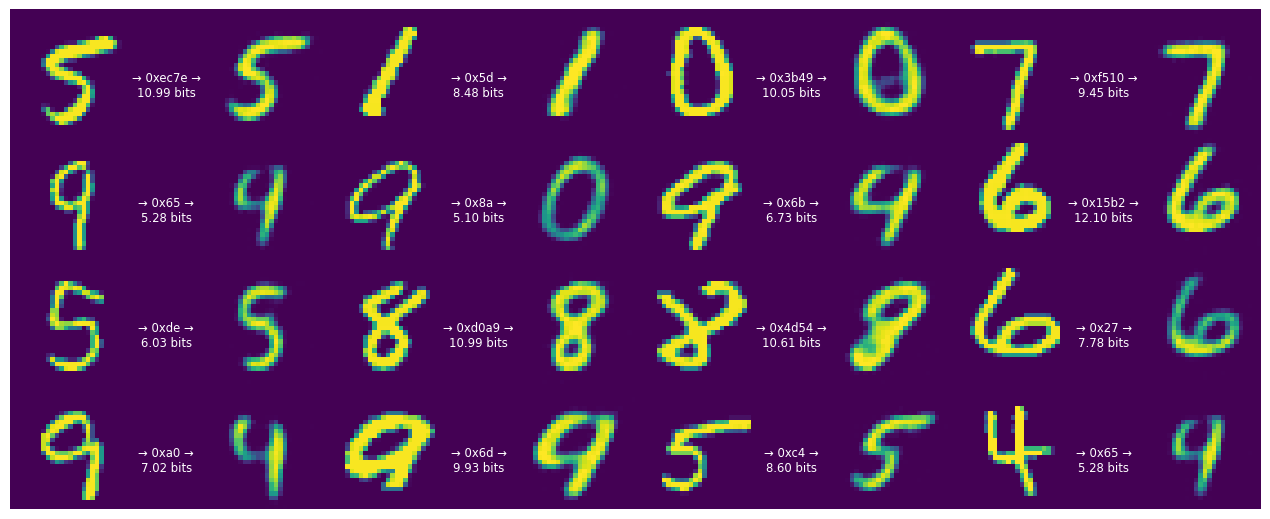

In [26]:
train_and_visualize_model(lmbda=300)


The strings begin to get much shorter now, on the order of one byte per digit. However, this comes at a cost. More digits are becoming unrecognizable.

This demonstrates that this model is agnostic to human perceptions of error, it just measures the absolute deviation in terms of pixel values. To achieve a better perceived image quality, we would need to replace the pixel loss with a perceptual loss.

## Use the decoder as a generative model.

If we feed the decoder random bits, this will effectively sample from the distribution that the model learned to represent digits.

First, re-instantiate the compressor/decompressor without a sanity check that would detect if the input string isn't completely decoded.

In [27]:
compressor, decompressor = make_mnist_codec(trainer, decode_sanity_check=False)


Now, feed long enough random strings into the decompressor so that it can decode/sample digits from them.

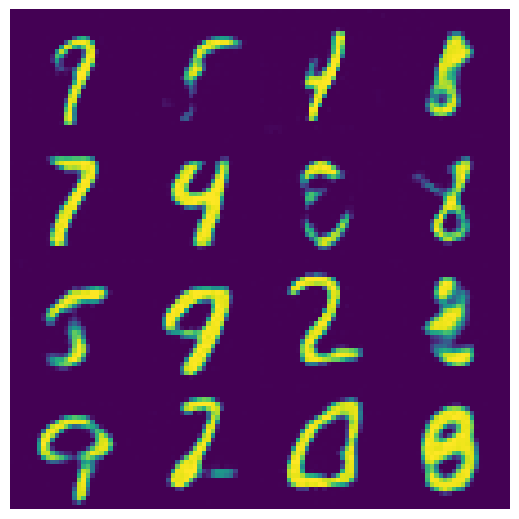

In [28]:
import os

strings = tf.constant([os.urandom(8) for _ in range(16)])
samples = decompressor(strings)

fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.ravel()
for i in range(len(axes)):
  axes[i].imshow(tf.squeeze(samples[i]))
  axes[i].axis("off")
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
